In [1]:
#Imports
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch           
import torch.nn as nn   
import torchvision     
from torch.utils.data import Dataset, DataLoader, random_split, Subset 
import torchvision.transforms as tt 

import torch.nn.functional as F 

from torchvision.utils import make_grid  
import matplotlib.pyplot as plt          
from matplotlib.image import imread     
import os
import random
from tqdm import tqdm 

In [2]:
#Load and Modify Data
data_orig = pd.read_csv("soccer-data/spi_matches.csv")

#Select columns
#data_col = data_orig[['team1', 'team2', 'spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2']]
data_col = data_orig[['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2']]

#Remove NAs
data = data_col.dropna()
print(data.head())

     spi1   spi2   prob1   prob2  probtie  proj_score1  proj_score2  score1  \
10  51.16  85.68  0.0463  0.8380   0.1157         0.91         2.36     0.0   
11  68.85  56.48  0.5714  0.1669   0.2617         1.82         0.86     2.0   
12  53.57  66.81  0.3459  0.3621   0.2921         1.16         1.24     2.0   
13  58.98  59.74  0.4482  0.2663   0.2854         1.37         1.05     0.0   
14  69.49  59.33  0.5759  0.1874   0.2367         1.91         1.05     1.0   

    score2   xg1   xg2  nsxg1  nsxg2  
10     1.0  0.97  0.63   0.43   0.45  
11     2.0  2.45  0.77   1.75   0.42  
12     1.0  0.85  2.77   0.17   1.25  
13     1.0  1.24  1.84   1.71   1.56  
14     1.0  1.05  0.22   1.52   0.41  


In [3]:
# Normalizing Data
# Match outcome
winner = [
    data['score1'] > data['score2'],
    data['score1'] < data['score2'],
    data['score1'] == data['score2']
]
choices = ['win', 'loss', 'tie']
data['winner'] = np.select(winner, choices)
encoder = LabelEncoder()
data['outcome'] = encoder.fit_transform(data['winner'])

# Scale numeric columns
scaler = MinMaxScaler()
num_cols = ['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2', 'year', 'month', 'day']
num_cols = ['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2']
data[num_cols] = scaler.fit_transform(data[num_cols])


# Scale team names
#team_cols = ['team1', 'team2']
#data[team_cols] = scaler.fit_transform(data[team_cols].apply(lambda x: encoder.fit_transform(x)))

# Drop unnecessary columns
data.drop(['score1', 'score2', 'winner'], axis=1, inplace=True)

/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_24761/3218173394.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['winner'] = np.select(winner, choices)
/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_24761/3218173394.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['outcome'] = encoder.fit_transform(data['winner'])
/var/folders/70/g894nzz50q5f5bvvjsf9zj8w0000gn/T/ipykernel_24761/3218173394.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [4]:
#Print head and shape
print(data.head())
print(data.shape)
#data.to_csv('soccer-data/normalized_data.csv', index=False)

# Separate the features and the target variable
X = data.drop(columns=['outcome'])
y = data['outcome']

# Initialize the PolynomialFeatures object
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform the features to create polynomial features
X_poly = poly.fit_transform(X)

# Create a dataframe with the new polynomial features
# 'get_feature_names' will be deprecated soon, use 'get_feature_names_out' for sklearn versions 1.0+
poly_feature_names = poly.get_feature_names_out(input_features=X.columns) if hasattr(poly, 'get_feature_names_out') else poly.get_feature_names(X.columns)
poly_features = pd.DataFrame(X_poly, columns=poly_feature_names)

        spi1      spi2     prob1     prob2   probtie  proj_score1  \
10  0.488165  0.877063  0.019170  0.950364  0.323455     0.174603   
11  0.687556  0.553660  0.572256  0.186362  0.731619     0.415344   
12  0.515329  0.668070  0.334738  0.408584  0.816606     0.240741   
13  0.576307  0.589766  0.442490  0.299522  0.797875     0.296296   
14  0.694770  0.585225  0.576996  0.209699  0.661728     0.439153   

    proj_score2       xg1       xg2     nsxg1     nsxg2  outcome  
10     0.668731  0.137199  0.076179  0.062409  0.062762        0  
11     0.204334  0.346535  0.093108  0.253991  0.058577        1  
12     0.321981  0.120226  0.334946  0.024673  0.174338        2  
13     0.263158  0.175389  0.222491  0.248186  0.217573        0  
14     0.263158  0.148515  0.026602  0.220610  0.057183        1  
(22857, 12)


In [5]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())


outcome
2    8251
0    5401
1    4633
Name: count, dtype: int64
outcome
2    2063
0    1351
1    1158
Name: count, dtype: int64


In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class MyCNNWithAttention(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyCNNWithAttention, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.attn1 = ChannelAttention(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.attn2 = ChannelAttention(32)
        self.flatten = nn.Flatten()

        # Calculate the output size of the previous layers
        conv1_output_size = (input_size + 2 * 1 - 3) // 1 + 1
        pool1_output_size = (conv1_output_size - 2) // 2 + 1
        conv2_output_size = (pool1_output_size + 2 * 1 - 3) // 1 + 1
        pool2_output_size = (conv2_output_size - 2) // 2 + 1
        fc1_input_size = 32 * pool2_output_size

        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_size) 
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 1, self.input_size)  # Reshape the input to (batch_size, 1, input_size)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.attn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.attn2(x)
        x = self.flatten(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [7]:
input_size = X_train.shape[1]
print("input size:", input_size)
output_size = len(np.unique(y))
print("output size:", output_size)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).long()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).long()

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = MyCNNWithAttention(input_size, output_size)


input size: 77
output size: 3


In [8]:
def training(model, loss_function, optimizer, train_loader, n_epochs, update_interval):
    losses = []
    for n in range(n_epochs):
        epoch_losses = []
        for i, (image, label) in enumerate(tqdm(iter(train_loader))):
            
            optimizer.zero_grad()
            my_output = model(image)
            loss = loss_function(my_output, label)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            
            if i % update_interval == 0:
                avg_loss = sum(epoch_losses) / len(epoch_losses)
                losses.append(round(avg_loss, 2))
                epoch_losses = []
                
    avg_total_loss = sum(losses) / len(losses)
    print("Training losses:", losses)
    print(f"Average loss over entire training: {avg_total_loss:.2f}")
    
    return model, losses

100%|██████████| 286/286 [00:01<00:00, 179.93it/s]


Training losses: [1.17, 1.0, 0.86, 0.94, 0.81, 0.92, 0.86, 0.92, 0.9, 0.92, 0.97, 0.92, 0.94, 0.92, 0.91, 0.92, 0.91, 0.91, 0.93, 0.91, 0.89, 0.91, 0.9, 0.91, 0.97, 0.91, 0.89, 0.91, 0.88, 0.91, 0.92, 0.91, 0.91, 0.91, 0.92, 0.91, 0.93, 0.91, 0.92, 0.91, 0.86, 0.91, 0.85, 0.91, 0.92, 0.91, 0.87, 0.91, 0.86, 0.9, 0.87, 0.91, 0.89, 0.9, 0.81, 0.9, 0.9, 0.91, 0.86, 0.91, 0.84, 0.9, 0.87, 0.91, 0.81, 0.91, 0.91, 0.91, 0.81, 0.9, 0.89, 0.9, 0.81, 0.9, 0.97, 0.9, 0.9, 0.9, 0.91, 0.9, 0.83, 0.9, 0.87, 0.9, 0.86, 0.9, 0.88, 0.89, 0.8, 0.9, 0.86, 0.9, 0.81, 0.89, 0.8, 0.9, 0.84, 0.89, 0.88, 0.89]
Average loss over entire training: 0.90


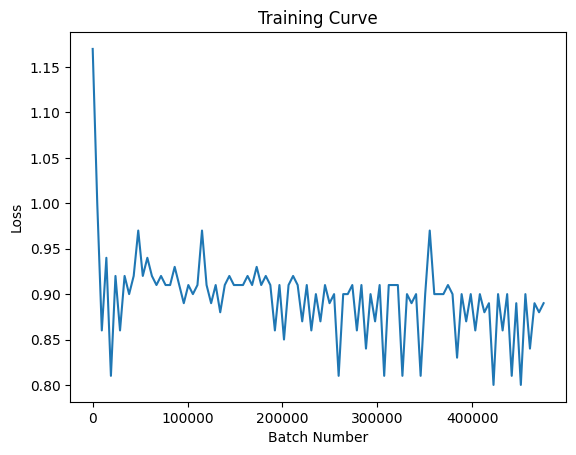

In [9]:
#Model Training
lr = 0.001   
batch_size = 24       
update_interval = 200   
n_epochs = 50          

class_counts = y_train.value_counts().sort_index()
weights = 1. / class_counts
class_weights = torch.tensor(weights.values).float()

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_loader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("Training Curve")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.show()


In [10]:
def testing(model, loss_function, test_loader):
    model.eval()
    sum_loss = 0
    n_correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for i, (data, label) in enumerate(tqdm(iter(test_loader))):
            
            pred = model(data)
            loss = loss_function(pred, label)
            sum_loss += loss.item()
            
            _, predicted = torch.max(pred, 1)
            n_correct += (predicted == label).sum().item()
            total += label.size(0)
            
            true_labels.extend(label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    test_acc = round((n_correct / total) * 100, 2)
    avg_loss = round(sum_loss / len(test_loader), 2)
    
    return test_acc, avg_loss, true_labels, predicted_labels

In [11]:
#Model Testing
test_acc, avg_loss, true_labels, predicted_labels = testing(trained_model, loss_function, test_loader)
print("Testing accuracy of your trained model:", test_acc)
print("Average loss of your trained model:", avg_loss)

100%|██████████| 72/72 [00:00<00:00, 509.67it/s]

Testing accuracy of your trained model: 59.21
Average loss of your trained model: 0.91


[[ 997  181  173]
 [ 457  306  395]
 [ 353  306 1404]]


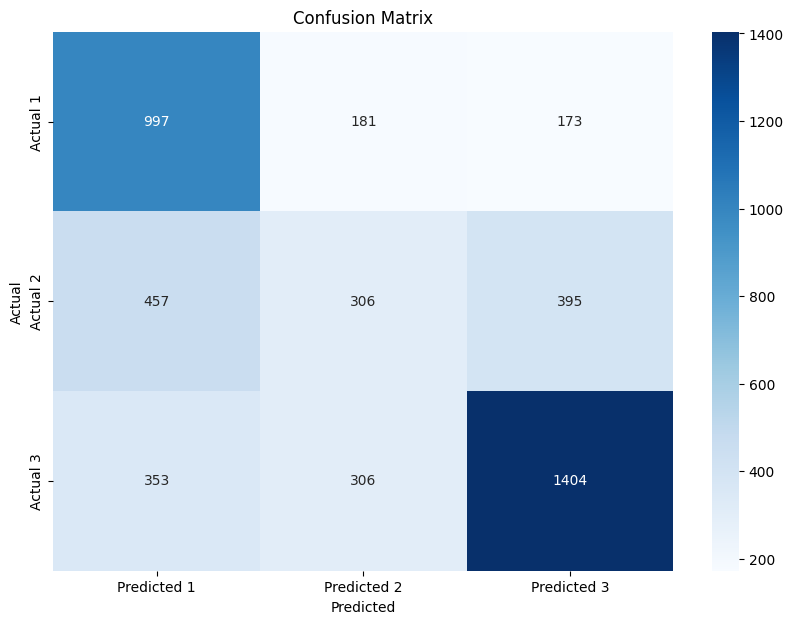

In [12]:
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3'], yticklabels=['Actual 1', 'Actual 2', 'Actual 3'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [14]:
def K_fold(model_class, model_params, dataset, K=5):
    hyperparams_grid = {'batch_size': [24, 32, 64, 128, 256],         
                        'lr': [0.0001, 0.001, 0.01, 0.1, 0.5],         
                        'n_epochs': [8, 10, 20, 30, 50],         
                        'update_interval': [25, 50, 100, 200, 250]}

    best_model = None
    best_accuracy = -1
    best_losses = []
    best_hyperparams = {}

    total_combinations = len(hyperparams_grid['batch_size']) * len(hyperparams_grid['lr']) * len(hyperparams_grid['n_epochs']) * len(hyperparams_grid['update_interval'])
    print("Total combinations: ", total_combinations)

    kfold = KFold(n_splits=K, shuffle=True, random_state=42)

    for batch_size, lr, n_epochs, update_interval in tqdm([(bs, lr, ep, ui) for bs in hyperparams_grid['batch_size'] for lr in hyperparams_grid['lr'] for ep in hyperparams_grid['n_epochs'] for ui in hyperparams_grid['update_interval']], total=total_combinations, desc='Hyperparameter Combinations', disable=False):
        print(f"Testing combination: Batch Size={batch_size}, LR={lr}, Epochs={n_epochs}, Update Interval={update_interval}")
        
        avg_accuracy = 0
        avg_loss = 0

        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
            print(f"Fold {fold+1}/{K}")
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            model = model_class(*model_params)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_function = nn.CrossEntropyLoss()

            # Train model using the provided training method
            trained_model, training_losses = training(model, loss_function, optimizer, train_loader, n_epochs, update_interval)

            # Validate model using the provided testing method
            val_accuracy, val_loss, _, _ = testing(trained_model, loss_function, val_loader)

            if val_accuracy < 58:
                skip_combination = True
                print(f"Accuracy: {val_accuracy}")
                break

            avg_accuracy += val_accuracy
            avg_loss += val_loss

        if skip_combination:
            print("Skipping combination due to low accuracy")
            continue

        avg_accuracy /= K
        avg_loss /= K

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_model = model
            best_losses.append(avg_loss)
            best_hyperparams = {'batch_size': batch_size, 'lr': lr, 'n_epochs': n_epochs, 'update_interval': update_interval}

        print(f"Average accuracy across folds: {avg_accuracy}%, Average loss: {avg_loss}")

    return best_model, best_losses, best_hyperparams


best_model, best_losses, best_hyperparams = K_fold(MyCNNWithAttention, (input_size, output_size), train_dataset)


Total combinations:  625


Hyperparameter Combinations:   0%|          | 0/625 [00:00<?, ?it/s]

Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 241.23it/s]


Training losses: [1.12, 1.11, 1.09, 1.08, 1.06, 1.04, 1.05, 1.0, 1.04, 1.02, 1.02, 1.04, 1.01, 1.0, 1.03, 1.03, 0.97, 0.98, 0.97, 0.98, 0.93, 1.0, 1.0, 0.97, 0.94, 0.97, 0.98, 0.95, 0.94, 0.97, 0.98, 0.96, 0.96, 1.0, 0.91, 0.94, 0.93, 0.94, 0.93, 0.98, 0.95, 0.92, 0.92, 0.94, 0.93, 0.92, 0.96, 0.93, 0.91, 0.95, 0.85, 0.91, 0.9, 0.92, 0.91, 0.88, 0.91, 0.96, 0.94, 0.97, 0.92, 0.9, 0.97, 0.91, 0.92, 0.9, 0.9, 0.89, 0.94, 0.94, 0.93, 0.93, 0.92, 0.88, 0.94, 1.03, 0.89, 0.93, 0.94, 0.91, 0.92, 0.94, 0.91, 0.96, 0.92, 0.93, 0.94, 0.9, 0.92, 0.89, 0.9, 0.88, 0.93, 0.89, 0.93, 0.91, 0.9, 0.92, 0.92, 0.91, 0.84, 0.9, 0.88, 0.85, 0.92, 0.86, 0.91, 0.88, 0.9, 0.91, 0.91, 0.93, 0.93, 0.95, 0.94, 0.91, 0.9, 0.91, 0.91, 0.9, 0.92, 0.9, 0.89, 0.89, 0.94, 0.86, 0.88, 0.92, 0.91, 0.91, 0.92, 0.88, 0.88, 0.91, 0.92, 0.89, 0.91, 0.89, 0.91, 0.87, 0.93, 0.93, 0.89, 0.86, 0.94, 0.89, 0.96, 0.94, 0.84, 0.86, 0.87, 0.87, 0.88, 0.92, 0.92, 0.92, 0.88, 0.9, 0.86, 0.85, 0.88, 0.93, 0.89, 0.86, 0.87, 0.91, 0.89

100%|██████████| 153/153 [00:00<00:00, 924.63it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 237.34it/s]


Training losses: [1.11, 1.12, 1.07, 1.07, 1.06, 1.05, 1.02, 1.0, 1.01, 1.01, 1.06, 1.03, 1.04, 0.99, 1.0, 1.02, 1.02, 1.0, 1.0, 1.0, 1.01, 0.97, 0.99, 0.95, 0.96, 0.86, 0.97, 0.94, 0.93, 0.95, 0.96, 0.97, 0.95, 0.93, 0.98, 0.97, 0.95, 0.95, 0.94, 0.92, 0.94, 0.92, 0.95, 0.95, 0.94, 0.94, 0.96, 0.97, 0.94, 0.91, 1.18, 0.97, 0.91, 0.89, 0.92, 0.9, 0.93, 0.88, 0.91, 0.96, 0.89, 0.89, 0.91, 0.98, 0.93, 0.92, 0.89, 0.95, 0.91, 0.91, 0.97, 0.92, 0.95, 0.92, 0.92, 0.7, 0.92, 0.86, 0.91, 0.85, 0.96, 0.89, 0.9, 0.9, 0.9, 0.87, 0.9, 0.92, 0.93, 0.86, 0.87, 0.91, 0.9, 0.93, 0.93, 0.89, 0.92, 0.96, 0.99, 0.9, 0.9, 0.94, 0.88, 0.87, 0.89, 0.91, 0.92, 0.92, 0.95, 0.87, 0.9, 0.9, 0.92, 0.88, 0.89, 0.86, 0.88, 0.94, 0.88, 0.9, 0.89, 0.86, 0.93, 0.89, 0.9, 0.73, 0.93, 0.91, 0.91, 0.91, 0.91, 0.87, 0.9, 0.93, 0.86, 0.93, 0.86, 0.86, 0.9, 0.92, 0.89, 0.89, 0.9, 0.88, 0.9, 0.9, 0.86, 0.86, 0.89, 0.94, 0.91, 0.93, 0.93, 0.88, 0.89, 0.86, 0.87, 0.88, 0.87, 0.9, 0.88, 0.88, 0.93, 0.88, 0.9, 0.89, 0.9, 0.89, 

Hyperparameter Combinations:   0%|          | 1/625 [00:41<7:16:32, 41.98s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 230.09it/s]


Training losses: [1.09, 1.16, 1.11, 1.09, 1.05, 1.04, 1.0, 0.99, 0.98, 1.0, 0.98, 0.96, 0.96, 0.95, 0.96, 0.96, 0.95, 0.96, 0.97, 0.94, 0.93, 0.93, 0.95, 0.95, 0.92, 0.92, 0.99, 0.93, 0.92, 0.93, 0.91, 0.9, 0.95, 0.91, 0.92, 0.92, 0.92, 0.92, 0.96, 0.88, 0.88, 0.93, 0.91, 0.9, 0.91, 0.91, 0.89, 0.9, 0.91, 0.91, 0.92, 0.92, 0.91, 0.87, 0.91, 0.9, 0.87, 0.9, 0.91, 0.9, 0.88, 0.89, 0.9, 0.91, 0.93, 0.88, 0.91, 0.92, 0.92, 0.91, 0.93, 0.89, 0.91, 0.9, 0.9, 0.91, 0.89, 0.88, 0.92, 0.91, 0.92, 0.89, 0.91, 0.88, 0.88, 0.9, 0.88, 0.91, 0.88, 0.89, 0.91, 1.05, 0.9, 0.86, 0.9, 0.9, 0.92, 0.91, 0.88, 0.89, 0.9, 0.85, 0.91, 0.9]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 755.68it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 225.61it/s]


Training losses: [1.16, 1.1, 1.07, 1.04, 1.01, 1.02, 1.0, 0.98, 0.98, 0.92, 0.94, 0.95, 0.97, 0.92, 0.95, 0.92, 0.92, 0.95, 0.92, 0.91, 0.93, 0.94, 0.94, 0.92, 0.93, 0.94, 1.05, 0.91, 0.88, 0.91, 0.89, 0.94, 0.91, 0.92, 0.91, 0.9, 0.97, 0.92, 0.9, 0.96, 0.94, 0.91, 0.89, 0.89, 0.9, 0.91, 0.9, 0.91, 0.91, 0.93, 0.88, 0.89, 1.1, 0.88, 0.9, 0.89, 0.88, 0.86, 0.92, 0.9, 0.93, 0.91, 0.89, 0.92, 0.88, 0.98, 0.91, 0.88, 0.88, 0.9, 0.91, 0.93, 0.9, 0.87, 0.9, 0.91, 0.87, 0.89, 0.83, 0.93, 0.9, 0.89, 0.9, 0.9, 0.91, 0.87, 0.87, 0.87, 0.86, 0.88, 0.89, 0.88, 0.87, 0.89, 0.87, 0.88, 0.88, 0.91, 0.88, 0.86, 0.87, 0.87, 0.9, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:   0%|          | 2/625 [01:23<7:11:21, 41.54s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 210.44it/s]


Training losses: [1.02, 1.1, 1.04, 1.01, 1.01, 0.97, 0.96, 0.84, 0.97, 0.96, 0.94, 0.93, 0.94, 0.95, 1.15, 0.93, 0.94, 0.92, 0.94, 0.91, 0.92, 1.02, 0.93, 0.91, 0.92, 0.92, 0.92, 0.9, 0.98, 0.93, 0.9, 0.9, 0.9, 0.92, 0.9, 0.96, 0.91, 0.92, 0.9, 0.88, 0.89, 0.92, 1.13, 0.88, 0.9, 0.91, 0.9, 0.93, 0.89, 1.06, 0.89, 0.93, 0.9, 0.9, 0.88, 0.89]
Average loss over entire training: 0.94


100%|██████████| 153/153 [00:00<00:00, 705.04it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 255.69it/s]


Training losses: [1.38, 1.16, 1.06, 1.04, 1.01, 1.0, 0.96, 1.07, 0.96, 0.95, 0.93, 0.97, 0.94, 0.94, 1.04, 0.92, 0.94, 0.92, 0.93, 0.91, 0.93, 0.95, 0.92, 0.91, 0.9, 0.9, 0.89, 0.9, 0.82, 0.88, 0.9, 0.91, 0.9, 0.9, 0.92, 0.91, 0.91, 0.89, 0.91, 0.9, 0.89, 0.88, 0.8, 0.9, 0.9, 0.89, 0.9, 0.88, 0.86, 0.96, 0.87, 0.89, 0.87, 0.89, 0.9, 0.9]
Average loss over entire training: 0.93


Hyperparameter Combinations:   0%|          | 3/625 [02:05<7:15:40, 42.03s/it]

Accuracy: 56.0
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 222.29it/s]


Training losses: [1.07, 1.1, 1.04, 1.01, 1.04, 0.98, 0.96, 0.96, 0.83, 0.93, 0.92, 0.94, 0.96, 0.93, 0.92, 0.92, 0.85, 0.91, 0.92, 0.91, 1.03, 0.91, 0.9, 0.91, 0.93, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.89]
Average loss over entire training: 0.94


100%|██████████| 153/153 [00:00<00:00, 820.35it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 240.33it/s]


Training losses: [1.25, 1.07, 1.03, 0.99, 0.94, 0.96, 0.94, 0.94, 1.02, 0.92, 0.91, 0.92, 0.66, 0.9, 0.91, 0.91, 1.05, 0.9, 0.9, 0.9, 0.74, 0.9, 0.9, 0.9, 0.93, 0.89, 0.89, 0.89, 0.76, 0.89, 0.89, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:   1%|          | 4/625 [02:49<7:20:30, 42.56s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 239.05it/s]


Training losses: [1.5, 1.12, 1.03, 0.93, 0.99, 0.95, 0.84, 0.94, 0.94, 1.11, 0.92, 0.93, 0.97, 0.91, 0.92, 0.65, 0.91, 0.9, 0.87, 0.89, 0.9, 0.97, 0.9, 0.91]
Average loss over entire training: 0.95


100%|██████████| 153/153 [00:00<00:00, 880.22it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 234.17it/s]


Training losses: [1.18, 1.06, 1.0, 1.04, 0.95, 0.93, 0.98, 0.93, 0.92, 0.88, 0.91, 0.9, 0.84, 0.9, 0.91, 0.83, 0.89, 0.9, 0.83, 0.89, 0.89, 0.75, 0.89, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:   1%|          | 5/625 [03:32<7:24:22, 43.00s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 236.52it/s]


Training losses: [1.26, 1.25, 1.13, 1.12, 1.13, 1.09, 1.1, 1.08, 1.05, 1.04, 1.07, 1.01, 1.04, 1.05, 1.0, 1.01, 0.99, 0.97, 1.0, 1.02, 0.96, 0.96, 1.0, 1.0, 0.98, 1.05, 0.99, 0.95, 0.97, 0.96, 0.97, 1.01, 0.96, 0.93, 0.9, 0.95, 0.97, 0.93, 0.98, 0.92, 0.94, 0.96, 0.94, 0.94, 0.94, 0.94, 0.96, 0.94, 0.92, 0.93, 1.09, 0.87, 0.93, 0.93, 0.94, 0.92, 0.94, 0.95, 0.94, 0.92, 0.92, 0.95, 0.91, 0.93, 0.94, 0.93, 0.93, 0.94, 0.92, 0.92, 0.94, 0.93, 0.96, 0.93, 0.94, 0.82, 0.9, 0.91, 0.92, 0.96, 0.92, 0.88, 0.93, 0.87, 0.92, 0.91, 0.92, 0.9, 0.89, 0.93, 0.86, 0.9, 0.93, 0.88, 0.91, 0.87, 0.94, 0.93, 0.91, 0.91, 0.9, 0.93, 0.86, 0.94, 0.94, 0.9, 0.95, 0.91, 0.91, 0.89, 0.9, 0.89, 0.95, 0.92, 0.9, 0.96, 0.94, 0.9, 0.91, 0.91, 0.89, 0.91, 0.89, 0.89, 0.88, 0.99, 0.93, 0.9, 0.92, 0.93, 0.91, 0.92, 0.92, 0.92, 0.9, 0.86, 0.91, 0.9, 0.9, 0.93, 0.88, 0.88, 0.91, 0.93, 0.91, 0.89, 0.95, 0.87, 0.88, 0.88, 0.93, 0.87, 0.93, 0.9, 0.91, 0.92, 0.87, 0.94, 0.9, 0.87, 0.93, 0.87, 0.94, 0.9, 0.91, 0.89, 0.88, 0

100%|██████████| 153/153 [00:00<00:00, 889.10it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 236.15it/s]


Training losses: [0.93, 1.09, 1.06, 1.04, 1.03, 1.04, 1.03, 1.05, 1.01, 1.0, 1.05, 1.01, 1.04, 1.01, 0.99, 1.0, 1.02, 1.03, 0.98, 0.98, 0.97, 0.97, 0.95, 0.99, 0.98, 0.93, 0.97, 1.01, 0.96, 0.97, 0.96, 0.98, 0.91, 0.96, 0.93, 0.94, 0.93, 0.98, 0.91, 0.95, 0.93, 0.96, 0.94, 0.94, 0.94, 0.96, 0.94, 0.93, 0.92, 0.91, 1.01, 0.95, 0.95, 0.89, 0.87, 0.95, 0.91, 0.94, 0.94, 0.9, 0.9, 0.93, 0.89, 0.89, 0.95, 0.89, 0.91, 0.94, 0.92, 0.95, 0.88, 0.9, 0.92, 0.93, 0.89, 1.26, 0.88, 0.87, 0.88, 0.92, 0.89, 0.89, 0.93, 0.95, 0.91, 0.91, 0.95, 0.92, 0.92, 0.91, 0.94, 0.91, 0.88, 0.91, 0.89, 0.9, 0.92, 0.9, 0.88, 0.92, 0.71, 0.92, 0.89, 0.89, 0.94, 0.91, 0.88, 0.88, 0.88, 0.89, 0.89, 0.9, 0.89, 0.91, 0.9, 0.91, 0.9, 0.89, 0.88, 0.88, 0.92, 0.91, 0.9, 0.9, 0.91, 1.0, 0.93, 0.87, 0.88, 0.85, 0.88, 0.92, 0.89, 0.88, 0.94, 0.92, 0.9, 0.9, 0.9, 0.86, 0.91, 0.86, 0.9, 0.9, 0.9, 0.88, 0.86, 0.89, 0.94, 0.89, 0.89, 0.89, 0.93, 0.86, 0.88, 0.9, 0.87, 0.88, 0.89, 0.86, 0.88, 0.85, 0.95, 0.91, 0.87, 0.92, 0.86, 

Hyperparameter Combinations:   1%|          | 6/625 [04:27<8:02:51, 46.80s/it]

Accuracy: 57.81
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 223.80it/s]


Training losses: [1.2, 1.22, 1.12, 1.07, 1.04, 1.03, 1.04, 1.0, 0.98, 0.98, 0.95, 0.97, 0.94, 0.94, 0.93, 0.98, 0.95, 0.93, 0.93, 0.93, 0.92, 0.93, 0.94, 0.93, 0.92, 0.97, 0.75, 0.92, 0.96, 0.93, 0.91, 0.94, 0.9, 0.93, 0.9, 0.9, 0.9, 0.9, 0.9, 0.76, 0.91, 0.9, 0.91, 0.91, 0.91, 0.89, 0.91, 0.93, 0.89, 0.92, 0.93, 0.94, 0.65, 0.9, 0.89, 0.88, 0.9, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.88, 0.9, 0.88, 0.88, 0.88, 0.93, 0.89, 0.89, 0.87, 0.9, 0.92, 0.91, 0.91, 0.89, 0.9, 0.85, 0.88, 0.89, 0.93, 0.88, 0.9, 0.88, 0.87, 0.92, 0.89, 0.88, 0.9, 0.91, 0.98, 0.87, 0.92, 0.9, 0.88, 0.92, 0.9, 0.86, 0.91, 0.89, 0.88, 0.89, 0.89, 0.94, 0.9, 0.88, 0.89, 0.9, 0.9, 0.88, 0.88, 0.89, 0.89, 0.9, 0.9, 0.88, 0.8, 0.89, 0.92, 0.89, 0.91, 0.89, 0.88, 0.87, 0.92, 0.87, 0.89, 0.86, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 852.61it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 230.02it/s]


Training losses: [1.26, 1.1, 1.08, 1.04, 1.06, 1.04, 1.02, 1.01, 1.0, 0.97, 0.97, 0.99, 0.99, 0.93, 0.97, 0.99, 0.95, 0.93, 0.94, 0.95, 0.93, 0.92, 0.92, 0.93, 0.94, 0.92, 1.15, 0.95, 0.88, 0.91, 0.9, 0.93, 0.91, 0.92, 0.92, 0.93, 0.9, 0.92, 0.9, 0.9, 0.91, 0.87, 0.9, 0.89, 0.91, 0.93, 0.91, 0.89, 0.92, 0.9, 0.93, 0.89, 0.87, 0.94, 0.9, 0.92, 0.89, 0.87, 0.91, 0.93, 0.89, 0.9, 0.91, 0.92, 0.9, 0.85, 0.9, 0.9, 0.87, 0.87, 0.92, 0.92, 0.91, 0.88, 0.87, 0.89, 0.88, 0.93, 0.79, 0.87, 0.91, 0.89, 0.92, 0.89, 0.88, 0.92, 0.89, 0.86, 0.9, 0.88, 0.86, 0.82, 0.89, 0.89, 0.91, 0.9, 0.88, 0.9, 0.88, 0.87, 0.9, 0.89, 0.89, 0.89, 0.72, 0.89, 0.91, 0.9, 0.89, 0.86, 0.9, 0.88, 0.86, 0.89, 0.88, 0.9, 0.88, 0.99, 0.89, 0.88, 0.85, 0.89, 0.9, 0.88, 0.85, 0.9, 0.89, 0.89, 0.88, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:   1%|          | 7/625 [05:21<8:28:57, 49.41s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 235.90it/s]


Training losses: [1.12, 1.14, 1.06, 1.01, 1.02, 0.98, 0.96, 0.97, 0.95, 0.95, 0.95, 0.95, 0.93, 0.91, 1.07, 0.91, 0.93, 0.93, 0.92, 0.91, 0.94, 0.82, 0.91, 0.91, 0.9, 0.91, 0.89, 0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.92, 0.89, 0.76, 0.9, 0.89, 0.89, 0.92, 0.91, 0.89, 0.82, 0.9, 0.88, 0.88, 0.92, 0.91, 0.9, 0.78, 0.88, 0.92, 0.88, 0.9, 0.91, 0.88, 0.91, 0.88, 0.91, 0.9, 0.87, 0.89, 0.9, 0.71, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 945.93it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 255.61it/s]


Training losses: [1.12, 1.12, 1.03, 1.01, 1.0, 0.98, 0.97, 0.8, 0.96, 0.94, 0.94, 0.93, 0.95, 0.93, 0.85, 0.94, 0.92, 0.9, 0.91, 0.91, 0.91, 0.93, 0.89, 0.91, 0.91, 0.9, 0.9, 0.9, 0.87, 0.89, 0.91, 0.9, 0.91, 0.89, 0.89, 0.81, 0.9, 0.89, 0.92, 0.88, 0.9, 0.87, 1.04, 0.9, 0.88, 0.88, 0.88, 0.88, 0.91, 0.73, 0.89, 0.88, 0.91, 0.89, 0.89, 0.87, 0.82, 0.89, 0.87, 0.87, 0.89, 0.89, 0.89, 0.85, 0.88, 0.89, 0.87, 0.88, 0.89, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:   1%|▏         | 8/625 [06:15<8:40:11, 50.59s/it]

Accuracy: 57.97
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 226.87it/s]


Training losses: [1.35, 1.13, 1.01, 0.98, 0.97, 0.96, 0.94, 0.93, 0.75, 0.92, 0.94, 0.91, 0.94, 0.92, 0.92, 0.92, 0.88, 0.92, 0.91, 0.9, 0.9, 0.9, 0.91, 0.9, 1.02, 0.9, 0.9, 0.89, 0.83, 0.88, 0.9, 0.91, 0.74, 0.89, 0.9, 0.9, 0.87, 0.9, 0.88, 0.88]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 506.72it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 230.65it/s]


Training losses: [1.21, 1.07, 1.0, 0.99, 0.86, 0.95, 0.95, 0.95, 0.93, 0.93, 0.91, 0.92, 0.98, 0.91, 0.91, 0.9, 1.11, 0.91, 0.9, 0.91, 0.78, 0.9, 0.9, 0.9, 1.01, 0.9, 0.9, 0.89, 0.97, 0.9, 0.88, 0.89, 0.96, 0.9, 0.89, 0.89, 0.86, 0.89, 0.89, 0.87]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 884.26it/s]


Fold 3/5


100%|██████████| 610/610 [00:02<00:00, 223.44it/s]


Training losses: [1.11, 1.07, 1.0, 0.99, 1.06, 0.96, 0.94, 0.93, 0.82, 0.93, 0.92, 0.93, 0.99, 0.92, 0.92, 0.91, 0.95, 0.92, 0.9, 0.91, 0.87, 0.9, 0.89, 0.92, 0.93, 0.91, 0.89, 0.89, 1.04, 0.89, 0.89, 0.9, 0.87, 0.89, 0.9, 0.9, 0.96, 0.9, 0.89, 0.9]
Average loss over entire training: 0.93


100%|██████████| 153/153 [00:00<00:00, 875.22it/s]


Fold 4/5


100%|██████████| 610/610 [00:02<00:00, 252.13it/s]


Training losses: [1.37, 1.11, 1.03, 1.0, 1.05, 0.98, 0.96, 0.94, 0.99, 0.93, 0.93, 0.94, 1.01, 0.91, 0.92, 0.92, 0.79, 0.92, 0.91, 0.91, 1.16, 0.9, 0.9, 0.92, 0.93, 0.89, 0.9, 0.91, 0.89, 0.9, 0.91, 0.9, 0.84, 0.89, 0.89, 0.9, 0.79, 0.88, 0.89, 0.91]
Average loss over entire training: 0.94


100%|██████████| 153/153 [00:00<00:00, 986.50it/s]


Fold 5/5


100%|██████████| 610/610 [00:02<00:00, 210.78it/s]


Training losses: [1.43, 1.06, 1.0, 0.97, 0.74, 0.96, 0.94, 0.94, 0.88, 0.92, 0.92, 0.94, 0.8, 0.91, 0.91, 0.92, 0.76, 0.89, 0.91, 0.91, 1.22, 0.91, 0.91, 0.9, 0.9, 0.89, 0.91, 0.89, 0.83, 0.89, 0.9, 0.91, 0.91, 0.9, 0.9, 0.88, 0.87, 0.89, 0.89, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:   1%|▏         | 9/625 [08:30<13:11:58, 77.14s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 225.28it/s]


Training losses: [1.0, 1.06, 1.0, 0.76, 0.95, 0.94, 1.0, 0.93, 0.92, 0.98, 0.91, 0.91, 1.04, 0.9, 0.91, 0.8, 0.89, 0.91, 0.81, 0.9, 0.89, 0.79, 0.9, 0.89, 0.95, 0.9, 0.89, 0.85, 0.87, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 497.84it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 237.32it/s]


Training losses: [1.18, 1.07, 1.0, 0.99, 0.96, 0.94, 0.91, 0.93, 0.93, 1.23, 0.9, 0.9, 1.32, 0.9, 0.91, 0.9, 0.9, 0.89, 0.91, 0.89, 0.89, 0.67, 0.88, 0.9, 0.86, 0.88, 0.89, 0.84, 0.89, 0.89]
Average loss over entire training: 0.94


Hyperparameter Combinations:   2%|▏         | 10/625 [09:26<12:04:28, 70.68s/it]

Accuracy: 57.62
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:03<00:00, 199.39it/s]


Training losses: [1.27, 1.23, 1.16, 1.11, 1.15, 1.12, 1.14, 1.08, 1.04, 1.04, 1.04, 1.07, 1.04, 1.03, 1.01, 1.01, 1.01, 1.02, 0.97, 1.02, 0.98, 1.01, 1.02, 0.99, 0.95, 0.82, 0.99, 0.95, 0.93, 0.96, 0.95, 1.03, 0.96, 0.99, 0.98, 0.92, 0.97, 0.98, 0.94, 0.94, 0.97, 0.95, 0.93, 0.92, 0.92, 0.95, 0.9, 0.95, 0.95, 0.88, 0.98, 0.89, 0.92, 0.94, 0.93, 0.92, 0.96, 0.95, 0.97, 0.94, 0.9, 0.92, 0.91, 0.94, 0.97, 0.94, 0.93, 0.89, 0.91, 0.93, 0.96, 0.91, 0.9, 0.89, 0.95, 0.96, 0.89, 0.94, 0.91, 0.99, 0.88, 0.92, 0.89, 0.87, 0.92, 0.92, 0.91, 0.89, 0.93, 0.87, 0.95, 0.92, 0.9, 0.89, 0.92, 0.9, 0.92, 0.91, 0.92, 0.84, 0.97, 0.96, 0.88, 0.89, 0.93, 0.92, 0.93, 0.91, 0.9, 0.9, 0.92, 0.9, 0.9, 0.93, 0.92, 0.89, 0.89, 0.9, 0.91, 0.89, 0.93, 0.91, 0.89, 0.93, 0.84, 1.07, 0.88, 0.93, 0.88, 0.91, 0.87, 0.92, 0.91, 0.95, 0.95, 0.91, 0.92, 0.96, 0.87, 0.9, 0.89, 0.87, 0.9, 0.87, 0.9, 0.86, 0.86, 0.89, 0.94, 0.9, 0.9, 0.93, 0.92, 0.9, 0.92, 0.9, 0.9, 0.89, 0.84, 0.86, 0.91, 0.92, 0.9, 0.9, 0.88, 0.88, 0.92, 

100%|██████████| 153/153 [00:00<00:00, 805.31it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 229.05it/s]


Training losses: [0.93, 1.14, 1.09, 1.06, 1.08, 1.04, 1.05, 1.05, 1.03, 1.0, 0.99, 0.99, 1.0, 0.98, 0.99, 1.02, 0.98, 0.99, 0.94, 0.92, 0.95, 0.95, 0.94, 0.94, 0.96, 1.07, 0.96, 0.93, 0.97, 0.93, 0.91, 0.93, 0.94, 0.95, 0.91, 0.91, 0.94, 0.92, 0.97, 0.96, 0.91, 0.9, 0.93, 0.87, 0.88, 0.94, 0.91, 0.93, 0.91, 0.94, 0.81, 0.9, 0.89, 0.88, 0.93, 0.89, 0.93, 0.92, 0.91, 0.95, 0.91, 0.9, 0.91, 0.96, 0.95, 0.9, 0.92, 0.91, 0.88, 0.96, 0.93, 0.9, 0.9, 0.89, 0.9, 0.82, 0.89, 0.85, 0.94, 0.9, 0.9, 0.92, 0.91, 0.91, 0.88, 0.92, 0.9, 0.9, 0.9, 0.91, 0.87, 0.87, 0.91, 0.9, 0.87, 0.93, 0.92, 0.86, 0.93, 0.93, 1.22, 0.9, 0.87, 0.88, 0.92, 0.92, 0.87, 0.91, 0.91, 0.92, 0.9, 0.88, 0.91, 0.91, 0.96, 0.91, 0.87, 0.91, 0.86, 0.91, 0.84, 0.94, 0.9, 0.91, 0.9, 1.04, 0.85, 0.87, 0.9, 0.91, 0.89, 0.88, 0.87, 0.86, 0.93, 0.89, 0.84, 0.91, 0.86, 0.92, 0.87, 0.85, 0.92, 0.9, 0.9, 0.93, 0.84, 0.93, 0.89, 0.86, 0.8, 0.83, 0.86, 0.89, 0.89, 0.88, 0.87, 0.89, 0.95, 0.91, 0.87, 0.88, 0.91, 0.89, 0.92, 0.89, 0.87, 0.9

Hyperparameter Combinations:   2%|▏         | 11/625 [11:15<14:02:24, 82.32s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 220.82it/s]


Training losses: [1.32, 1.21, 1.12, 1.06, 1.07, 1.05, 1.02, 0.98, 0.99, 1.01, 1.0, 0.98, 0.98, 0.9, 0.96, 1.0, 0.96, 0.95, 0.94, 0.97, 0.95, 0.96, 0.93, 0.94, 0.91, 0.93, 1.03, 0.95, 0.93, 0.92, 0.92, 0.9, 0.92, 0.91, 0.91, 0.93, 0.91, 0.91, 0.92, 0.81, 0.9, 0.91, 0.91, 0.91, 0.94, 0.91, 0.9, 0.87, 0.92, 0.93, 0.92, 0.89, 0.8, 0.94, 0.88, 0.9, 0.92, 0.87, 0.91, 0.89, 0.9, 0.91, 0.89, 0.91, 0.91, 0.88, 0.93, 0.86, 0.89, 0.92, 0.87, 0.91, 0.9, 0.89, 0.9, 0.91, 0.89, 0.89, 1.19, 0.88, 0.9, 0.88, 0.9, 0.89, 0.9, 0.86, 0.93, 0.87, 0.9, 0.9, 0.91, 0.92, 0.9, 0.9, 0.89, 0.88, 0.88, 0.91, 0.9, 0.88, 0.92, 0.89, 0.89, 0.86, 0.91, 0.88, 0.88, 0.93, 0.9, 0.87, 0.9, 0.88, 0.88, 0.88, 0.9, 0.88, 0.91, 0.79, 0.87, 0.86, 0.91, 0.87, 0.88, 0.88, 0.88, 0.93, 0.88, 0.9, 0.89, 0.87, 0.83, 0.89, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.88, 0.87, 0.91, 0.87, 0.88, 1.05, 0.88, 0.88, 0.92, 0.88, 0.88, 0.89, 0.89, 0.87, 0.88, 0.88, 0.91, 0.87, 0.89, 0.89, 0.91, 0.88, 0.89, 0.87, 0.87, 0.85, 0.86, 0.93, 0.89, 0.9, 0.

100%|██████████| 153/153 [00:00<00:00, 737.59it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 236.06it/s]


Training losses: [1.31, 1.14, 1.06, 1.05, 1.03, 1.0, 0.99, 0.99, 0.99, 0.97, 0.95, 0.99, 0.96, 0.9, 0.95, 0.94, 0.94, 0.95, 0.91, 0.95, 0.91, 0.95, 0.93, 0.93, 0.93, 0.92, 0.97, 0.9, 0.91, 0.93, 0.91, 0.91, 0.89, 0.89, 0.92, 0.9, 0.9, 0.94, 0.93, 1.0, 0.87, 0.91, 0.91, 0.9, 0.91, 0.88, 0.88, 0.9, 0.87, 0.91, 0.91, 0.92, 0.56, 0.92, 0.91, 0.93, 0.89, 0.9, 0.89, 0.9, 0.88, 0.88, 0.89, 0.86, 0.91, 0.89, 0.9, 0.92, 0.88, 0.87, 0.88, 0.9, 0.9, 0.88, 0.91, 0.88, 0.88, 0.89, 0.64, 0.89, 0.89, 0.91, 0.88, 0.9, 0.9, 0.87, 0.89, 0.9, 0.87, 0.88, 0.89, 0.85, 0.88, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.93, 0.92, 0.86, 0.81, 0.9, 0.85, 0.88, 0.9, 0.93, 0.88, 0.9, 0.88, 0.88, 0.88, 0.87, 0.91, 0.96, 0.86, 0.86, 0.9, 0.86, 0.89, 0.87, 0.89, 0.87, 0.91, 0.87, 0.9, 0.86, 0.83, 0.87, 0.92, 0.87, 0.92, 0.86, 0.89, 0.9, 0.89, 0.88, 0.87, 0.88, 0.85, 0.69, 0.91, 0.88, 0.85, 0.87, 0.88, 0.84, 0.85, 0.91, 0.88, 0.88, 0.87, 0.87, 0.9, 0.87, 0.86, 0.85, 0.9, 0.86, 0.88, 0.9, 0.87, 0.88, 0.9, 0.89, 

Hyperparameter Combinations:   2%|▏         | 12/625 [13:01<15:15:46, 89.64s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 236.49it/s]


Training losses: [1.16, 1.11, 1.05, 1.03, 1.01, 0.97, 0.98, 0.83, 0.95, 0.97, 0.94, 0.93, 0.94, 0.93, 0.79, 0.94, 0.92, 0.92, 0.94, 0.92, 0.91, 0.85, 0.9, 0.9, 0.91, 0.92, 0.93, 0.9, 0.9, 0.91, 0.92, 0.9, 0.9, 0.91, 0.89, 0.98, 0.89, 0.92, 0.88, 0.87, 0.9, 0.91, 0.9, 0.9, 0.91, 0.89, 0.89, 0.91, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.89, 0.89, 0.84, 0.89, 0.9, 0.9, 0.88, 0.89, 0.88, 0.81, 0.88, 0.9, 0.91, 0.9, 0.89, 0.89, 0.87, 0.88, 0.91, 0.89, 0.86, 0.88, 0.92, 0.95, 0.9, 0.87, 0.89, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 0.87, 0.89, 0.9, 0.77, 0.91, 0.87, 0.9, 0.88, 0.89, 0.88, 0.79, 0.87, 0.89, 0.9, 0.88, 0.88, 0.88, 0.98, 0.86, 0.89, 0.89, 0.88, 0.87, 0.89, 1.26, 0.9, 0.9, 0.89, 0.88, 0.86, 0.87, 0.88, 0.87, 0.89, 0.89, 0.88, 0.87, 0.89, 0.76, 0.91, 0.88, 0.87, 0.86, 0.89, 0.87, 0.72, 0.89, 0.88, 0.89, 0.86, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 890.59it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 222.12it/s]


Training losses: [1.05, 1.09, 1.03, 1.0, 0.99, 0.99, 0.97, 1.34, 0.96, 0.96, 0.96, 0.94, 0.92, 0.92, 1.01, 0.92, 0.95, 0.9, 0.91, 0.93, 0.89, 0.82, 0.91, 0.92, 0.92, 0.9, 0.88, 0.91, 0.87, 0.92, 0.9, 0.9, 0.89, 0.92, 0.9, 0.96, 0.91, 0.89, 0.9, 0.88, 0.89, 0.91, 1.08, 0.9, 0.89, 0.88, 0.92, 0.9, 0.87, 0.73, 0.89, 0.92, 0.9, 0.89, 0.86, 0.87, 0.71, 0.86, 0.9, 0.89, 0.89, 0.91, 0.89, 0.99, 0.9, 0.89, 0.88, 0.87, 0.9, 0.88, 0.75, 0.89, 0.89, 0.92, 0.89, 0.88, 0.87, 0.84, 0.88, 0.87, 0.88, 0.9, 0.88, 0.89, 0.77, 0.9, 0.87, 0.88, 0.88, 0.88, 0.88, 0.81, 0.89, 0.87, 0.9, 0.87, 0.88, 0.9, 0.81, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 1.12, 0.89, 0.89, 0.88, 0.87, 0.86, 0.89, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.9, 0.88, 0.89, 0.87, 0.87, 0.88, 0.86, 0.95, 0.89, 0.88, 0.86, 0.87, 0.88, 0.87, 1.04, 0.88, 0.87, 0.88, 0.86, 0.89, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:   2%|▏         | 13/625 [14:47<16:02:58, 94.41s/it]

Accuracy: 57.72
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 227.27it/s]


Training losses: [1.29, 1.07, 1.0, 0.98, 1.02, 0.96, 0.95, 0.93, 0.96, 0.92, 0.92, 0.92, 0.91, 0.92, 0.91, 0.92, 0.99, 0.9, 0.91, 0.9, 0.79, 0.9, 0.9, 0.9, 0.78, 0.89, 0.91, 0.9, 0.88, 0.9, 0.89, 0.89, 0.74, 0.89, 0.89, 0.89, 1.05, 0.89, 0.88, 0.9, 0.94, 0.89, 0.9, 0.89, 1.08, 0.9, 0.88, 0.88, 0.76, 0.89, 0.9, 0.89, 0.77, 0.89, 0.89, 0.88, 0.84, 0.88, 0.9, 0.89, 0.84, 0.89, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.93, 0.88, 0.88, 0.88, 0.91, 0.87, 0.9, 0.88, 0.89, 0.88, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 872.61it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 236.10it/s]


Training losses: [1.2, 1.12, 1.04, 1.02, 0.8, 0.98, 0.97, 0.96, 0.74, 0.94, 0.94, 0.93, 1.05, 0.91, 0.92, 0.93, 0.85, 0.91, 0.92, 0.89, 0.84, 0.9, 0.92, 0.89, 0.69, 0.89, 0.89, 0.89, 0.91, 0.9, 0.89, 0.88, 0.83, 0.89, 0.89, 0.89, 0.83, 0.87, 0.88, 0.89, 1.05, 0.88, 0.89, 0.89, 0.8, 0.87, 0.89, 0.88, 1.14, 0.88, 0.88, 0.87, 0.94, 0.88, 0.88, 0.87, 0.79, 0.87, 0.88, 0.88, 0.88, 0.88, 0.89, 0.87, 0.73, 0.89, 0.87, 0.87, 0.87, 0.88, 0.87, 0.88, 0.89, 0.88, 0.87, 0.88, 0.74, 0.87, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 969.90it/s] 


Fold 3/5


100%|██████████| 610/610 [00:02<00:00, 253.85it/s]


Training losses: [1.15, 1.07, 1.02, 0.99, 1.08, 0.97, 0.96, 0.95, 0.94, 0.94, 0.93, 0.92, 0.95, 0.93, 0.89, 0.93, 1.07, 0.91, 0.91, 0.91, 0.81, 0.91, 0.9, 0.92, 0.87, 0.91, 0.9, 0.9, 1.09, 0.88, 0.91, 0.9, 1.0, 0.91, 0.9, 0.88, 0.73, 0.89, 0.89, 0.89, 0.77, 0.9, 0.88, 0.9, 0.77, 0.89, 0.88, 0.89, 0.78, 0.89, 0.89, 0.9, 0.92, 0.88, 0.88, 0.9, 0.72, 0.87, 0.89, 0.91, 0.89, 0.87, 0.9, 0.89, 0.74, 0.89, 0.88, 0.88, 0.74, 0.89, 0.88, 0.88, 0.8, 0.89, 0.88, 0.89, 1.07, 0.88, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 558.17it/s]


Fold 4/5


100%|██████████| 610/610 [00:02<00:00, 255.70it/s]


Training losses: [1.32, 1.09, 1.04, 0.99, 0.85, 0.96, 0.94, 0.95, 0.96, 0.94, 0.92, 0.93, 0.96, 0.91, 0.91, 0.93, 1.38, 0.89, 0.92, 0.9, 0.66, 0.9, 0.9, 0.89, 0.82, 0.9, 0.9, 0.91, 0.99, 0.89, 0.89, 0.9, 1.04, 0.89, 0.89, 0.89, 0.74, 0.9, 0.89, 0.89, 0.97, 0.88, 0.9, 0.9, 0.75, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 0.9, 0.93, 0.89, 0.88, 0.88, 1.05, 0.89, 0.88, 0.88, 0.87, 0.89, 0.89, 0.88, 0.93, 0.89, 0.88, 0.89, 0.94, 0.88, 0.87, 0.89, 0.7, 0.89, 0.88, 0.88, 0.93, 0.88, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 948.41it/s]


Fold 5/5


100%|██████████| 610/610 [00:02<00:00, 238.68it/s]


Training losses: [1.34, 1.11, 1.04, 1.01, 1.08, 0.97, 0.94, 0.94, 0.74, 0.92, 0.92, 0.93, 1.06, 0.91, 0.92, 0.91, 0.77, 0.9, 0.92, 0.91, 0.81, 0.91, 0.91, 0.9, 0.8, 0.92, 0.9, 0.9, 0.98, 0.88, 0.9, 0.92, 1.06, 0.9, 0.89, 0.88, 0.86, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.88, 0.77, 0.89, 0.9, 0.89, 1.02, 0.88, 0.9, 0.9, 0.81, 0.91, 0.88, 0.87, 0.73, 0.89, 0.89, 0.88, 0.74, 0.89, 0.88, 0.9, 0.91, 0.87, 0.89, 0.89, 0.92, 0.88, 0.88, 0.89, 0.77, 0.89, 0.88, 0.88, 0.79, 0.87, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:   2%|▏         | 14/625 [19:01<24:13:18, 142.72s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 240.74it/s]


Training losses: [1.15, 1.08, 1.0, 0.82, 0.96, 0.95, 0.84, 0.92, 0.93, 1.04, 0.91, 0.91, 0.87, 0.9, 0.91, 1.0, 0.89, 0.92, 0.67, 0.91, 0.89, 0.98, 0.9, 0.89, 1.12, 0.88, 0.9, 0.88, 0.89, 0.89, 0.82, 0.89, 0.88, 0.68, 0.89, 0.89, 0.8, 0.89, 0.89, 0.66, 0.88, 0.88, 0.86, 0.89, 0.88, 0.84, 0.88, 0.89, 0.72, 0.87, 0.89, 0.71, 0.88, 0.88, 0.93, 0.89, 0.87, 0.98, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 945.48it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 252.57it/s]


Training losses: [1.21, 1.08, 1.0, 0.84, 0.95, 0.94, 0.96, 0.93, 0.91, 1.02, 0.91, 0.91, 1.27, 0.9, 0.89, 0.75, 0.88, 0.89, 1.01, 0.89, 0.89, 1.03, 0.88, 0.89, 0.94, 0.88, 0.88, 0.93, 0.88, 0.89, 0.69, 0.89, 0.89, 0.67, 0.86, 0.89, 0.99, 0.89, 0.88, 1.05, 0.87, 0.88, 0.71, 0.88, 0.88, 1.1, 0.87, 0.88, 0.89, 0.87, 0.87, 0.83, 0.87, 0.87, 0.85, 0.88, 0.88, 1.03, 0.87, 0.86]
Average loss over entire training: 0.91


Hyperparameter Combinations:   2%|▏         | 15/625 [20:40<21:57:23, 129.58s/it]

Accuracy: 57.67
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 236.00it/s]


Training losses: [1.2, 1.11, 1.07, 1.07, 1.05, 1.03, 0.99, 1.03, 0.98, 1.03, 0.98, 0.94, 1.0, 1.0, 1.02, 1.0, 1.01, 0.96, 0.99, 0.95, 0.94, 0.97, 0.99, 0.97, 0.98, 0.86, 0.93, 0.91, 0.91, 0.97, 0.9, 0.91, 0.94, 0.94, 0.95, 0.89, 0.93, 0.94, 0.92, 0.97, 0.92, 0.95, 0.94, 0.95, 0.93, 0.93, 0.97, 0.94, 0.96, 0.93, 0.81, 0.92, 0.93, 0.89, 0.9, 0.92, 0.94, 0.92, 0.92, 0.88, 0.89, 0.95, 0.94, 0.93, 0.93, 0.93, 0.87, 0.95, 0.9, 0.89, 0.92, 0.97, 0.95, 0.92, 0.92, 0.79, 0.89, 0.9, 0.97, 0.91, 0.9, 0.87, 0.92, 0.93, 0.93, 0.94, 0.9, 0.92, 0.93, 0.89, 0.86, 0.91, 0.91, 0.89, 0.93, 0.9, 0.93, 0.9, 0.9, 0.9, 0.87, 0.89, 0.94, 0.9, 0.94, 0.87, 0.91, 0.92, 0.92, 0.88, 0.88, 0.94, 0.89, 0.92, 0.87, 0.9, 0.94, 0.89, 0.86, 0.87, 0.91, 0.9, 0.92, 0.86, 0.94, 0.8, 0.85, 0.88, 0.88, 0.89, 0.89, 0.91, 0.9, 0.87, 0.9, 0.9, 0.9, 0.88, 0.89, 0.92, 0.92, 0.94, 0.89, 0.89, 0.89, 0.88, 0.87, 0.93, 0.93, 0.88, 0.86, 0.95, 0.89, 0.91, 0.87, 0.9, 0.89, 0.9, 0.88, 0.93, 0.91, 0.89, 0.91, 0.93, 0.84, 0.86, 0.88, 0.9,

100%|██████████| 153/153 [00:00<00:00, 950.43it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 218.80it/s]


Training losses: [1.39, 1.19, 1.16, 1.08, 1.09, 1.05, 1.05, 1.01, 1.04, 1.02, 1.06, 1.0, 1.01, 1.01, 1.01, 0.96, 1.0, 0.98, 0.99, 1.01, 0.95, 0.96, 1.0, 0.99, 0.96, 0.85, 0.96, 1.0, 0.97, 0.96, 0.96, 0.94, 0.94, 0.93, 0.94, 0.94, 0.95, 0.93, 0.94, 0.95, 0.95, 0.98, 0.91, 0.93, 0.94, 0.9, 0.93, 0.92, 0.91, 0.9, 1.1, 0.93, 0.9, 0.89, 0.89, 0.97, 0.92, 0.93, 0.91, 0.94, 0.95, 0.91, 0.91, 0.91, 0.91, 0.86, 0.93, 0.93, 0.94, 0.92, 0.92, 0.89, 0.95, 0.91, 0.89, 0.72, 0.93, 0.9, 0.92, 0.93, 0.94, 0.92, 0.94, 0.92, 0.86, 0.84, 0.85, 0.93, 0.91, 0.88, 0.91, 0.92, 0.95, 0.91, 0.9, 0.91, 0.91, 0.88, 0.92, 0.88, 0.93, 0.93, 0.91, 0.88, 0.92, 0.9, 0.92, 0.91, 0.89, 0.91, 0.89, 0.89, 0.89, 0.91, 0.87, 0.88, 0.91, 0.91, 0.92, 0.89, 0.91, 0.9, 0.9, 0.9, 0.88, 0.87, 0.87, 0.87, 0.93, 0.94, 0.88, 0.84, 0.89, 0.87, 0.92, 0.92, 0.87, 0.9, 0.87, 0.9, 0.93, 0.91, 0.93, 0.94, 0.85, 0.87, 0.89, 0.91, 0.89, 0.89, 0.99, 0.91, 0.87, 0.94, 0.89, 0.89, 0.86, 0.89, 0.85, 0.89, 0.86, 0.9, 0.85, 0.9, 0.87, 0.85, 0.88

Hyperparameter Combinations:   3%|▎         | 16/625 [23:17<23:18:40, 137.80s/it]

Accuracy: 57.89
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 219.08it/s]


Training losses: [1.33, 1.18, 1.13, 1.06, 1.04, 1.05, 1.0, 1.01, 1.0, 1.01, 0.97, 0.98, 0.95, 1.02, 0.95, 0.97, 0.93, 0.95, 0.95, 0.96, 0.92, 0.97, 0.93, 0.93, 0.92, 0.92, 0.99, 0.93, 0.92, 0.9, 0.93, 0.92, 0.91, 0.95, 0.88, 0.92, 0.92, 0.94, 0.91, 0.93, 0.9, 0.91, 0.91, 0.9, 0.91, 0.9, 0.92, 0.9, 0.9, 0.9, 0.91, 0.91, 0.91, 0.88, 0.89, 0.92, 0.91, 0.89, 0.93, 0.88, 0.89, 0.91, 0.91, 0.92, 0.92, 0.68, 0.91, 0.89, 0.9, 0.91, 0.9, 0.91, 0.89, 0.92, 0.88, 0.89, 0.91, 0.93, 1.13, 0.87, 0.9, 0.91, 0.89, 0.91, 0.9, 0.88, 0.89, 0.91, 0.92, 0.91, 0.9, 0.93, 0.9, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.9, 0.91, 0.9, 0.92, 0.9, 0.74, 0.92, 0.89, 0.9, 0.9, 0.9, 0.89, 0.89, 0.93, 0.86, 0.88, 0.86, 0.88, 0.9, 0.9, 0.92, 0.89, 0.9, 0.92, 0.89, 0.87, 0.86, 0.89, 0.86, 0.9, 0.88, 0.92, 0.91, 0.92, 0.89, 0.88, 0.88, 0.86, 0.89, 0.87, 0.89, 0.88, 0.92, 0.92, 0.96, 0.89, 0.86, 0.88, 0.92, 0.94, 0.87, 0.86, 0.88, 0.86, 0.88, 0.89, 0.89, 0.83, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.9, 0.87, 0.86, 0.88, 0.8

100%|██████████| 153/153 [00:00<00:00, 809.75it/s]


Fold 2/5


100%|██████████| 610/610 [00:03<00:00, 180.77it/s]


Training losses: [1.29, 1.16, 1.12, 1.07, 1.05, 1.04, 1.03, 1.02, 1.03, 1.03, 1.01, 1.0, 0.95, 1.13, 1.0, 0.96, 0.93, 0.96, 0.98, 0.94, 1.0, 0.96, 0.93, 0.95, 0.93, 0.93, 0.82, 0.94, 0.93, 0.94, 0.92, 0.89, 0.9, 0.91, 0.91, 0.93, 0.94, 0.93, 0.94, 0.87, 0.91, 0.92, 0.93, 0.91, 0.9, 0.92, 0.9, 0.91, 0.94, 0.91, 0.91, 0.9, 0.81, 0.91, 0.9, 0.91, 0.88, 0.88, 0.88, 0.93, 0.91, 0.94, 0.88, 0.91, 0.89, 0.88, 0.91, 0.91, 0.88, 0.91, 0.91, 0.87, 0.89, 0.92, 0.9, 0.87, 0.9, 0.88, 0.73, 0.9, 0.93, 0.89, 0.88, 0.9, 0.89, 0.9, 0.9, 0.88, 0.89, 0.89, 0.9, 1.07, 0.87, 0.88, 0.87, 0.93, 0.89, 0.9, 0.88, 0.88, 0.88, 0.9, 0.9, 0.88, 0.79, 0.93, 0.92, 0.89, 0.87, 0.87, 0.87, 0.88, 0.92, 0.88, 0.89, 0.86, 0.88, 0.89, 0.87, 0.85, 0.93, 0.9, 0.92, 0.86, 0.88, 0.88, 0.87, 0.88, 0.9, 0.89, 0.78, 0.89, 0.87, 0.88, 0.89, 0.92, 0.89, 0.87, 0.91, 0.89, 0.88, 0.86, 0.89, 0.94, 0.89, 0.87, 0.87, 0.86, 0.86, 0.88, 0.89, 0.87, 0.91, 0.9, 0.9, 0.89, 0.7, 0.89, 0.88, 0.85, 0.86, 0.9, 0.86, 0.88, 0.85, 0.91, 0.87, 0.91

Hyperparameter Combinations:   3%|▎         | 17/625 [26:06<24:51:09, 147.15s/it]

Accuracy: 57.64
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:03<00:00, 185.78it/s]


Training losses: [1.12, 1.1, 1.04, 1.04, 1.02, 1.0, 0.97, 0.97, 0.96, 0.95, 0.97, 0.94, 0.95, 0.93, 0.88, 0.93, 0.93, 0.93, 0.93, 0.9, 0.9, 1.05, 0.91, 0.91, 0.91, 0.92, 0.91, 0.91, 0.89, 0.92, 0.89, 0.89, 0.91, 0.9, 0.92, 0.88, 0.91, 0.89, 0.92, 0.9, 0.89, 0.92, 0.93, 0.9, 0.9, 0.9, 0.88, 0.91, 0.89, 0.75, 0.88, 0.88, 0.91, 0.91, 0.91, 0.87, 0.91, 0.89, 0.89, 0.9, 0.88, 0.88, 0.9, 0.66, 0.87, 0.89, 0.89, 0.89, 0.89, 0.9, 1.07, 0.88, 0.88, 0.89, 0.87, 0.9, 0.9, 0.88, 0.88, 0.9, 0.88, 0.88, 0.89, 0.89, 0.98, 0.9, 0.85, 0.89, 0.91, 0.89, 0.88, 0.84, 0.89, 0.89, 0.89, 0.89, 0.89, 0.87, 0.87, 0.88, 0.89, 0.89, 0.88, 0.87, 0.89, 0.82, 0.89, 0.88, 0.88, 0.89, 0.87, 0.88, 1.25, 0.89, 0.88, 0.88, 0.88, 0.88, 0.87, 1.05, 0.86, 0.88, 0.88, 0.89, 0.89, 0.89, 1.01, 0.87, 0.9, 0.88, 0.86, 0.87, 0.89, 0.92, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.78, 0.89, 0.88, 0.87, 0.88, 0.9, 0.87, 0.64, 0.86, 0.88, 0.89, 0.86, 0.88, 0.88, 0.97, 0.88, 0.87, 0.88, 0.89, 0.89, 0.88, 0.75, 0.89, 0.86, 0.9, 0.88, 0.88,

100%|██████████| 153/153 [00:00<00:00, 662.37it/s]


Fold 2/5


100%|██████████| 610/610 [00:05<00:00, 119.42it/s]


Training losses: [1.15, 1.1, 1.05, 1.04, 1.01, 1.0, 1.0, 1.15, 0.96, 0.97, 0.98, 0.94, 0.94, 0.94, 1.13, 0.91, 0.91, 0.92, 0.92, 0.92, 0.91, 1.22, 0.92, 0.91, 0.88, 0.93, 0.92, 0.88, 1.02, 0.9, 0.89, 0.89, 0.91, 0.9, 0.9, 0.8, 0.91, 0.89, 0.9, 0.9, 0.9, 0.87, 0.84, 0.9, 0.89, 0.89, 0.89, 0.91, 0.87, 0.79, 0.87, 0.88, 0.88, 0.89, 0.9, 0.89, 0.7, 0.89, 0.89, 0.88, 0.88, 0.88, 0.89, 0.76, 0.88, 0.89, 0.9, 0.89, 0.86, 0.89, 0.89, 0.88, 0.88, 0.89, 0.87, 0.88, 0.9, 0.88, 0.87, 0.87, 0.87, 0.91, 0.9, 0.88, 0.81, 0.87, 0.87, 0.88, 0.89, 0.88, 0.88, 0.75, 0.88, 0.86, 0.87, 0.87, 0.87, 0.91, 0.75, 0.88, 0.87, 0.87, 0.87, 0.88, 0.89, 0.83, 0.87, 0.85, 0.89, 0.87, 0.91, 0.86, 0.81, 0.88, 0.86, 0.88, 0.89, 0.87, 0.86, 0.9, 0.87, 0.88, 0.89, 0.86, 0.88, 0.89, 0.75, 0.86, 0.88, 0.87, 0.85, 0.9, 0.88, 1.12, 0.88, 0.88, 0.86, 0.85, 0.88, 0.88, 0.81, 0.87, 0.85, 0.89, 0.87, 0.88, 0.87, 0.96, 0.88, 0.86, 0.87, 0.87, 0.86, 0.87, 0.69, 0.87, 0.88, 0.86, 0.86, 0.88, 0.89, 0.92, 0.87, 0.87, 0.89, 0.84, 0.88

Hyperparameter Combinations:   3%|▎         | 18/625 [29:47<28:33:14, 169.35s/it]

Accuracy: 57.83
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:06<00:00, 98.30it/s]


Training losses: [1.2, 1.07, 1.01, 0.97, 1.07, 0.96, 0.94, 0.92, 1.03, 0.94, 0.92, 0.93, 0.78, 0.92, 0.91, 0.92, 0.86, 0.92, 0.89, 0.91, 0.89, 0.9, 0.91, 0.91, 0.75, 0.9, 0.9, 0.89, 0.71, 0.89, 0.89, 0.9, 1.0, 0.89, 0.89, 0.89, 0.91, 0.88, 0.89, 0.9, 1.16, 0.89, 0.9, 0.88, 1.07, 0.89, 0.88, 0.89, 0.9, 0.88, 0.9, 0.88, 0.96, 0.87, 0.88, 0.9, 0.87, 0.88, 0.88, 0.89, 0.91, 0.87, 0.88, 0.9, 0.82, 0.9, 0.87, 0.87, 0.98, 0.88, 0.88, 0.88, 0.82, 0.88, 0.88, 0.89, 0.98, 0.88, 0.88, 0.88, 0.97, 0.89, 0.88, 0.87, 1.0, 0.87, 0.89, 0.87, 0.88, 0.89, 0.89, 0.87, 0.92, 0.88, 0.87, 0.88, 0.74, 0.89, 0.87, 0.86, 1.06, 0.88, 0.88, 0.87, 0.91, 0.87, 0.89, 0.88, 1.04, 0.87, 0.88, 0.87, 0.98, 0.88, 0.87, 0.88, 0.89, 0.88, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 337.14it/s]


Fold 2/5


100%|██████████| 610/610 [00:06<00:00, 96.51it/s] 


Training losses: [1.27, 1.08, 1.02, 0.97, 1.04, 0.96, 0.94, 0.92, 0.82, 0.91, 0.94, 0.91, 0.96, 0.91, 0.9, 0.91, 0.96, 0.89, 0.9, 0.9, 0.86, 0.89, 0.9, 0.9, 0.76, 0.9, 0.89, 0.9, 1.16, 0.9, 0.89, 0.87, 1.11, 0.88, 0.88, 0.9, 0.84, 0.89, 0.88, 0.88, 1.02, 0.89, 0.88, 0.87, 0.96, 0.89, 0.88, 0.86, 0.77, 0.87, 0.88, 0.88, 0.76, 0.87, 0.89, 0.88, 1.01, 0.88, 0.89, 0.87, 0.84, 0.88, 0.86, 0.88, 0.83, 0.88, 0.87, 0.87, 0.71, 0.88, 0.87, 0.88, 0.81, 0.87, 0.89, 0.87, 0.8, 0.89, 0.86, 0.87, 1.1, 0.86, 0.88, 0.88, 0.95, 0.87, 0.86, 0.88, 0.9, 0.87, 0.86, 0.88, 0.74, 0.88, 0.86, 0.86, 0.79, 0.87, 0.87, 0.86, 0.82, 0.87, 0.85, 0.88, 0.77, 0.87, 0.85, 0.88, 0.67, 0.85, 0.86, 0.88, 0.77, 0.85, 0.88, 0.87, 0.81, 0.85, 0.86, 0.89]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 409.91it/s]


Fold 3/5


100%|██████████| 610/610 [00:05<00:00, 118.05it/s]


Training losses: [1.33, 1.09, 1.03, 0.99, 0.87, 0.98, 0.96, 0.93, 1.17, 0.94, 0.93, 0.94, 0.96, 0.92, 0.94, 0.91, 1.14, 0.91, 0.9, 0.91, 1.04, 0.91, 0.89, 0.92, 0.85, 0.91, 0.9, 0.91, 0.8, 0.9, 0.9, 0.91, 0.7, 0.89, 0.91, 0.91, 0.79, 0.89, 0.9, 0.9, 0.81, 0.88, 0.9, 0.9, 1.12, 0.89, 0.89, 0.88, 0.71, 0.88, 0.9, 0.9, 1.06, 0.88, 0.89, 0.89, 0.91, 0.9, 0.88, 0.88, 0.79, 0.89, 0.9, 0.87, 0.84, 0.89, 0.87, 0.89, 1.08, 0.88, 0.9, 0.87, 1.07, 0.89, 0.89, 0.87, 0.99, 0.88, 0.88, 0.88, 1.04, 0.88, 0.89, 0.88, 0.85, 0.87, 0.9, 0.89, 0.94, 0.88, 0.88, 0.88, 0.96, 0.88, 0.88, 0.88, 1.02, 0.87, 0.88, 0.88, 1.13, 0.89, 0.89, 0.88, 1.15, 0.88, 0.9, 0.86, 0.82, 0.87, 0.88, 0.89, 0.96, 0.87, 0.87, 0.88, 1.02, 0.88, 0.89, 0.87]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 417.16it/s]


Fold 4/5


100%|██████████| 610/610 [00:06<00:00, 93.06it/s] 


Training losses: [1.15, 1.07, 0.99, 0.98, 1.03, 0.95, 0.94, 0.93, 1.35, 0.94, 0.93, 0.92, 0.91, 0.91, 0.91, 0.93, 0.91, 0.91, 0.92, 0.89, 0.83, 0.91, 0.9, 0.9, 1.16, 0.9, 0.89, 0.9, 0.94, 0.89, 0.9, 0.9, 1.11, 0.9, 0.89, 0.89, 1.13, 0.89, 0.89, 0.9, 0.87, 0.9, 0.89, 0.89, 0.97, 0.89, 0.88, 0.9, 0.86, 0.88, 0.88, 0.9, 0.82, 0.88, 0.89, 0.89, 0.76, 0.9, 0.88, 0.88, 1.11, 0.88, 0.9, 0.89, 0.78, 0.88, 0.89, 0.88, 0.73, 0.89, 0.89, 0.87, 0.8, 0.89, 0.88, 0.88, 0.85, 0.9, 0.88, 0.87, 0.85, 0.87, 0.88, 0.88, 1.0, 0.88, 0.88, 0.88, 1.15, 0.88, 0.87, 0.89, 0.7, 0.87, 0.9, 0.87, 0.87, 0.87, 0.88, 0.89, 0.75, 0.89, 0.89, 0.86, 0.9, 0.88, 0.87, 0.87, 1.13, 0.87, 0.88, 0.87, 1.03, 0.88, 0.86, 0.88, 0.78, 0.87, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 384.22it/s]


Fold 5/5


100%|██████████| 610/610 [00:08<00:00, 76.25it/s]


Training losses: [1.11, 1.08, 1.02, 0.98, 0.83, 0.97, 0.95, 0.96, 0.76, 0.94, 0.94, 0.92, 1.18, 0.93, 0.92, 0.91, 0.99, 0.9, 0.93, 0.91, 0.88, 0.9, 0.91, 0.9, 0.77, 0.89, 0.9, 0.9, 0.97, 0.9, 0.91, 0.89, 0.76, 0.9, 0.9, 0.89, 0.84, 0.89, 0.9, 0.9, 0.75, 0.89, 0.9, 0.89, 0.96, 0.88, 0.89, 0.89, 1.05, 0.9, 0.88, 0.89, 0.75, 0.89, 0.88, 0.88, 0.81, 0.88, 0.88, 0.89, 0.9, 0.87, 0.89, 0.89, 0.7, 0.88, 0.89, 0.89, 0.86, 0.88, 0.88, 0.89, 1.25, 0.88, 0.88, 0.89, 0.65, 0.91, 0.87, 0.87, 0.82, 0.89, 0.88, 0.88, 0.86, 0.87, 0.88, 0.89, 0.81, 0.89, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 1.15, 0.88, 0.88, 0.87, 0.93, 0.89, 0.88, 0.87, 0.69, 0.86, 0.88, 0.88, 1.13, 0.87, 0.87, 0.88, 1.07, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:   3%|▎         | 19/625 [45:03<66:15:20, 393.60s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:07<00:00, 79.64it/s]


Training losses: [1.08, 1.06, 0.98, 0.84, 0.95, 0.94, 0.87, 0.92, 0.92, 0.99, 0.9, 0.91, 1.08, 0.91, 0.89, 0.72, 0.89, 0.91, 1.0, 0.9, 0.89, 0.86, 0.9, 0.88, 0.84, 0.9, 0.89, 0.8, 0.89, 0.89, 0.8, 0.9, 0.89, 0.86, 0.89, 0.89, 0.76, 0.89, 0.89, 0.86, 0.88, 0.89, 0.9, 0.88, 0.89, 0.79, 0.89, 0.88, 0.82, 0.87, 0.89, 0.93, 0.88, 0.89, 0.82, 0.87, 0.89, 1.07, 0.87, 0.89, 0.93, 0.88, 0.88, 0.78, 0.86, 0.88, 0.92, 0.89, 0.87, 0.83, 0.88, 0.88, 0.89, 0.87, 0.88, 0.79, 0.88, 0.87, 0.85, 0.88, 0.87, 0.73, 0.88, 0.87, 0.77, 0.89, 0.87, 1.39, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 344.06it/s]


Fold 2/5


100%|██████████| 610/610 [00:07<00:00, 82.18it/s]


Training losses: [1.32, 1.06, 1.0, 0.95, 0.96, 0.95, 0.97, 0.92, 0.92, 1.15, 0.9, 0.91, 0.79, 0.89, 0.9, 0.93, 0.9, 0.89, 0.93, 0.88, 0.89, 1.39, 0.88, 0.89, 0.9, 0.89, 0.88, 0.91, 0.89, 0.88, 1.15, 0.88, 0.87, 0.7, 0.88, 0.89, 0.74, 0.87, 0.89, 0.72, 0.87, 0.88, 0.85, 0.88, 0.88, 0.97, 0.88, 0.87, 0.9, 0.87, 0.88, 0.93, 0.87, 0.88, 0.98, 0.87, 0.88, 0.74, 0.88, 0.87, 0.95, 0.88, 0.87, 0.72, 0.88, 0.87, 0.71, 0.87, 0.89, 1.06, 0.87, 0.87, 0.72, 0.87, 0.88, 0.74, 0.87, 0.86, 0.59, 0.87, 0.87, 0.97, 0.87, 0.87, 0.73, 0.87, 0.87, 0.84, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:   3%|▎         | 20/625 [52:52<69:55:30, 416.08s/it]

Accuracy: 57.72
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:03<00:00, 192.30it/s]


Training losses: [1.1, 1.17, 1.11, 1.08, 1.07, 1.06, 1.06, 1.05, 1.0, 1.04, 1.03, 0.98, 0.99, 0.99, 0.99, 1.01, 0.98, 0.95, 0.97, 1.0, 0.98, 1.0, 0.97, 0.96, 0.96, 0.88, 0.96, 0.94, 0.96, 0.98, 0.93, 0.93, 0.94, 0.95, 0.97, 0.89, 0.9, 0.94, 0.98, 0.9, 0.92, 0.93, 0.96, 0.94, 0.96, 0.87, 0.92, 0.95, 0.93, 0.95, 0.79, 0.93, 0.95, 0.86, 0.93, 0.92, 0.9, 0.91, 0.96, 0.96, 0.9, 0.91, 0.94, 0.9, 0.91, 0.94, 0.91, 0.94, 0.93, 0.89, 0.96, 0.94, 0.91, 0.91, 0.91, 0.81, 0.9, 0.96, 0.92, 0.93, 0.91, 0.89, 0.9, 0.87, 0.93, 0.9, 0.88, 0.97, 0.86, 0.9, 0.92, 0.9, 0.94, 0.94, 0.89, 0.91, 0.86, 0.93, 0.95, 0.87, 0.71, 0.91, 0.89, 0.93, 0.94, 0.9, 0.88, 0.91, 0.91, 0.94, 0.91, 0.89, 0.88, 0.92, 0.94, 0.9, 0.91, 0.9, 0.89, 0.91, 0.92, 0.84, 0.91, 0.9, 0.92, 1.07, 0.91, 0.91, 0.9, 0.89, 0.85, 0.91, 0.87, 0.9, 0.82, 0.9, 0.91, 0.91, 0.94, 0.94, 0.92, 0.92, 0.92, 0.87, 0.85, 0.87, 0.94, 0.9, 0.87, 0.88, 0.86, 0.89, 0.84, 0.92, 0.9, 0.91, 0.86, 0.86, 0.92, 0.91, 0.88, 0.92, 0.88, 0.88, 0.87, 0.93, 0.9, 0.9,

100%|██████████| 153/153 [00:00<00:00, 546.31it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 231.21it/s]


Training losses: [1.14, 1.15, 1.11, 1.06, 1.08, 1.01, 1.03, 1.04, 1.01, 1.01, 1.01, 1.01, 0.99, 1.0, 0.97, 0.95, 0.95, 1.0, 0.99, 0.95, 0.95, 1.0, 1.0, 0.96, 1.0, 1.01, 0.97, 0.99, 0.87, 0.93, 0.94, 0.95, 0.96, 0.95, 0.98, 0.92, 0.99, 0.94, 0.98, 0.97, 0.94, 0.93, 0.95, 0.88, 0.95, 0.93, 0.95, 0.94, 0.93, 0.93, 0.93, 0.94, 0.9, 0.95, 0.92, 0.93, 0.9, 0.92, 0.96, 0.9, 0.94, 0.89, 0.93, 0.92, 0.94, 0.92, 0.9, 0.89, 0.89, 0.95, 0.93, 0.9, 0.89, 0.94, 0.87, 0.94, 0.92, 0.91, 0.93, 0.9, 0.87, 0.93, 0.93, 0.91, 0.94, 0.86, 0.95, 0.94, 0.95, 0.89, 0.93, 0.89, 0.97, 0.92, 0.93, 0.98, 0.9, 0.9, 0.9, 0.9, 0.8, 0.88, 0.9, 0.9, 0.93, 0.88, 0.89, 0.93, 0.88, 0.91, 0.93, 0.88, 0.89, 0.9, 0.95, 0.86, 0.91, 0.92, 0.91, 0.95, 0.87, 0.87, 0.89, 0.87, 0.91, 1.0, 0.89, 0.87, 0.88, 0.9, 0.84, 0.92, 0.9, 0.9, 0.91, 0.9, 0.93, 0.88, 0.94, 0.91, 0.89, 0.86, 0.92, 0.94, 0.87, 0.89, 0.89, 0.91, 0.87, 0.9, 0.96, 0.89, 0.87, 0.91, 0.92, 0.86, 0.93, 0.89, 0.91, 0.9, 0.85, 0.88, 0.9, 0.93, 0.88, 0.91, 0.9, 0.88, 0.

Hyperparameter Combinations:   3%|▎         | 21/625 [59:23<68:33:36, 408.64s/it]

Accuracy: 57.48
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 231.65it/s]


Training losses: [1.01, 1.16, 1.09, 1.08, 1.05, 1.02, 1.02, 0.99, 1.01, 1.0, 0.97, 0.98, 0.98, 1.1, 0.98, 0.95, 0.95, 0.96, 0.95, 0.94, 0.96, 0.94, 0.95, 0.92, 0.91, 0.93, 0.93, 0.93, 0.92, 0.93, 0.92, 0.89, 0.95, 0.91, 0.91, 0.92, 0.92, 0.92, 0.91, 1.0, 0.96, 0.93, 0.9, 0.92, 0.91, 0.91, 0.89, 0.88, 0.88, 0.92, 0.92, 0.91, 0.76, 0.92, 0.94, 0.91, 0.88, 0.89, 0.91, 0.9, 0.9, 0.91, 0.88, 0.91, 0.91, 0.84, 0.89, 0.9, 0.9, 0.88, 0.93, 0.91, 0.89, 0.92, 0.96, 0.88, 0.88, 0.9, 0.96, 0.88, 0.86, 0.92, 0.9, 0.89, 0.89, 0.88, 0.91, 0.91, 0.89, 0.91, 0.88, 0.8, 0.87, 0.91, 0.86, 0.89, 0.9, 0.89, 0.88, 0.89, 0.91, 0.92, 0.87, 0.9, 0.8, 0.88, 0.88, 0.88, 0.91, 0.9, 0.91, 0.92, 0.88, 0.88, 0.9, 0.87, 0.88, 0.74, 0.91, 0.88, 0.91, 0.89, 0.88, 0.88, 0.87, 0.85, 0.89, 0.92, 0.92, 0.87, 0.79, 0.9, 0.91, 0.85, 0.91, 0.89, 0.88, 0.89, 0.9, 0.87, 0.88, 0.9, 0.89, 0.76, 0.9, 0.86, 0.88, 0.89, 0.9, 0.91, 0.88, 0.87, 0.89, 0.89, 0.9, 0.88, 1.0, 0.89, 0.88, 0.89, 0.88, 0.89, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89,

100%|██████████| 153/153 [00:00<00:00, 820.10it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 223.89it/s]


Training losses: [1.29, 1.11, 1.06, 1.04, 1.03, 0.99, 0.99, 1.0, 1.02, 0.98, 0.93, 0.98, 0.97, 0.9, 0.94, 0.94, 0.93, 0.91, 0.94, 0.96, 0.92, 0.92, 0.91, 0.93, 0.89, 0.91, 0.83, 0.93, 0.93, 0.89, 0.91, 0.9, 0.94, 0.9, 0.86, 0.92, 0.89, 0.92, 0.93, 0.89, 0.9, 0.92, 0.88, 0.9, 0.9, 0.9, 0.92, 0.87, 0.88, 0.93, 0.89, 0.88, 0.9, 0.93, 0.88, 0.93, 0.9, 0.88, 0.89, 0.87, 0.9, 0.87, 0.89, 0.9, 0.91, 0.8, 0.9, 0.89, 0.88, 0.89, 0.91, 0.88, 0.88, 0.91, 0.91, 0.87, 0.91, 0.91, 1.0, 0.89, 0.87, 0.88, 0.9, 0.88, 0.86, 0.9, 0.88, 0.88, 0.88, 0.89, 0.92, 0.8, 0.9, 0.85, 0.89, 0.89, 0.9, 0.89, 0.89, 0.87, 0.91, 0.91, 0.86, 0.88, 0.94, 0.9, 0.9, 0.91, 0.88, 0.9, 0.86, 0.88, 0.88, 0.86, 0.86, 0.9, 0.88, 0.94, 0.91, 0.89, 0.92, 0.85, 0.9, 0.86, 0.91, 0.88, 0.84, 0.9, 0.88, 0.88, 0.85, 0.9, 0.89, 0.89, 0.88, 0.87, 0.88, 0.86, 0.91, 0.87, 0.87, 0.88, 0.88, 0.83, 0.86, 0.88, 0.86, 0.88, 0.87, 0.89, 0.89, 0.87, 0.88, 0.91, 0.88, 0.89, 0.68, 0.88, 0.86, 0.88, 0.87, 0.85, 0.9, 0.9, 0.88, 0.89, 0.86, 0.87, 0.8

Hyperparameter Combinations:   4%|▎         | 22/625 [1:03:48<61:15:27, 365.72s/it]

Accuracy: 57.78
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 228.29it/s]


Training losses: [1.0, 1.09, 1.03, 1.01, 0.98, 0.96, 0.95, 0.81, 0.96, 0.94, 0.94, 0.93, 0.94, 0.9, 0.82, 0.91, 0.92, 0.91, 0.9, 0.94, 0.91, 0.75, 0.91, 0.93, 0.91, 0.91, 0.91, 0.92, 0.71, 0.91, 0.91, 0.91, 0.92, 0.91, 0.87, 0.78, 0.9, 0.89, 0.89, 0.92, 0.91, 0.9, 0.83, 0.88, 0.9, 0.91, 0.89, 0.89, 0.91, 1.01, 0.89, 0.88, 0.88, 0.92, 0.89, 0.9, 0.88, 0.89, 0.91, 0.89, 0.88, 0.89, 0.88, 0.89, 0.88, 0.9, 0.89, 0.88, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.87, 0.9, 0.9, 0.93, 0.88, 0.87, 0.89, 0.88, 0.89, 0.91, 0.88, 0.9, 0.9, 0.88, 0.87, 0.87, 0.88, 0.89, 0.88, 0.87, 0.89, 0.89, 0.89, 0.9, 0.79, 0.89, 0.88, 0.89, 0.9, 0.87, 0.89, 0.79, 0.87, 0.89, 0.88, 0.88, 0.88, 0.87, 0.69, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.84, 0.89, 0.87, 0.88, 0.9, 0.87, 0.89, 0.91, 0.87, 0.89, 0.89, 0.87, 0.88, 0.88, 0.77, 0.88, 0.88, 0.87, 0.87, 0.89, 0.9, 1.04, 0.87, 0.88, 0.88, 0.89, 0.87, 0.88, 1.16, 0.85, 0.88, 0.88, 0.9, 0.87, 0.89, 0.72, 0.87, 0.89, 0.89, 0.87, 0.89, 0.87, 1.15, 0.88, 0.88, 0.88, 0.87, 0.9,

100%|██████████| 153/153 [00:00<00:00, 919.72it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 241.80it/s]


Training losses: [1.15, 1.09, 1.05, 1.03, 1.01, 0.99, 0.98, 1.08, 0.95, 0.94, 0.95, 0.95, 0.92, 0.94, 0.88, 0.92, 0.93, 0.91, 0.93, 0.93, 0.92, 0.95, 0.92, 0.9, 0.9, 0.9, 0.91, 0.9, 0.82, 0.9, 0.91, 0.88, 0.91, 0.9, 0.89, 0.96, 0.89, 0.88, 0.92, 0.9, 0.89, 0.9, 1.07, 0.89, 0.87, 0.88, 0.88, 0.91, 0.9, 0.97, 0.87, 0.88, 0.88, 0.89, 0.91, 0.9, 1.08, 0.89, 0.89, 0.89, 0.89, 0.88, 0.88, 0.64, 0.88, 0.88, 0.88, 0.9, 0.9, 0.87, 1.12, 0.9, 0.87, 0.9, 0.86, 0.88, 0.87, 0.71, 0.88, 0.87, 0.88, 0.87, 0.87, 0.88, 0.95, 0.88, 0.87, 0.88, 0.87, 0.89, 0.89, 0.88, 0.88, 0.89, 0.87, 0.87, 0.87, 0.88, 0.83, 0.88, 0.89, 0.88, 0.87, 0.86, 0.88, 0.77, 0.87, 0.87, 0.89, 0.89, 0.87, 0.87, 0.73, 0.88, 0.86, 0.9, 0.88, 0.88, 0.87, 0.93, 0.88, 0.86, 0.88, 0.88, 0.87, 0.89, 1.01, 0.87, 0.87, 0.87, 0.88, 0.87, 0.87, 0.95, 0.87, 0.85, 0.87, 0.88, 0.89, 0.88, 0.78, 0.9, 0.86, 0.86, 0.88, 0.88, 0.87, 0.84, 0.89, 0.89, 0.85, 0.87, 0.87, 0.88, 1.06, 0.87, 0.86, 0.87, 0.89, 0.87, 0.88, 0.8, 0.89, 0.87, 0.86, 0.88, 0.8

Hyperparameter Combinations:   4%|▎         | 23/625 [1:08:13<56:03:46, 335.26s/it]

Accuracy: 57.86
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 238.78it/s]


Training losses: [1.22, 1.08, 1.01, 0.99, 1.02, 0.95, 0.95, 0.96, 1.16, 0.93, 0.93, 0.91, 0.86, 0.92, 0.91, 0.92, 0.84, 0.91, 0.91, 0.9, 0.84, 0.91, 0.9, 0.89, 0.79, 0.9, 0.9, 0.9, 0.75, 0.89, 0.9, 0.89, 1.18, 0.9, 0.89, 0.9, 0.71, 0.9, 0.88, 0.89, 0.82, 0.89, 0.89, 0.89, 0.99, 0.89, 0.89, 0.89, 0.94, 0.89, 0.87, 0.9, 0.67, 0.88, 0.89, 0.89, 0.8, 0.88, 0.88, 0.89, 0.68, 0.88, 0.87, 0.89, 0.89, 0.88, 0.9, 0.88, 0.81, 0.88, 0.88, 0.89, 0.93, 0.88, 0.89, 0.88, 0.9, 0.89, 0.87, 0.87, 0.81, 0.88, 0.88, 0.88, 0.77, 0.88, 0.88, 0.88, 0.81, 0.88, 0.88, 0.87, 0.83, 0.89, 0.89, 0.86, 0.97, 0.87, 0.87, 0.89, 0.97, 0.86, 0.9, 0.88, 0.84, 0.88, 0.87, 0.88, 1.03, 0.88, 0.88, 0.87, 0.82, 0.9, 0.86, 0.87, 1.04, 0.89, 0.86, 0.88, 0.76, 0.86, 0.88, 0.87, 0.74, 0.89, 0.87, 0.86, 0.89, 0.88, 0.87, 0.88, 0.89, 0.87, 0.87, 0.87, 1.09, 0.88, 0.88, 0.86, 0.83, 0.86, 0.89, 0.86, 0.64, 0.85, 0.89, 0.87, 1.0, 0.86, 0.87, 0.88, 0.89, 0.85, 0.86, 0.88, 0.72, 0.86, 0.87, 0.88, 0.81, 0.87, 0.86, 0.86, 0.88, 0.87, 0.

100%|██████████| 153/153 [00:00<00:00, 946.30it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 240.49it/s]


Training losses: [1.16, 1.12, 1.02, 0.99, 0.91, 0.94, 0.95, 0.93, 0.79, 0.91, 0.92, 0.9, 1.08, 0.92, 0.9, 0.89, 0.99, 0.91, 0.89, 0.89, 0.96, 0.9, 0.9, 0.87, 0.81, 0.9, 0.89, 0.88, 0.75, 0.87, 0.89, 0.89, 0.77, 0.88, 0.87, 0.9, 0.92, 0.89, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.74, 0.88, 0.89, 0.88, 0.71, 0.89, 0.87, 0.88, 0.74, 0.88, 0.87, 0.87, 0.75, 0.89, 0.87, 0.88, 0.96, 0.88, 0.88, 0.86, 0.89, 0.87, 0.87, 0.88, 0.93, 0.87, 0.87, 0.88, 0.8, 0.87, 0.87, 0.87, 0.78, 0.87, 0.87, 0.88, 1.05, 0.87, 0.89, 0.87, 0.79, 0.87, 0.87, 0.88, 0.77, 0.88, 0.86, 0.88, 0.69, 0.88, 0.86, 0.87, 0.89, 0.86, 0.88, 0.86, 0.72, 0.86, 0.87, 0.88, 0.76, 0.88, 0.86, 0.87, 0.82, 0.86, 0.85, 0.89, 0.79, 0.87, 0.87, 0.87, 0.81, 0.88, 0.87, 0.85, 0.82, 0.87, 0.86, 0.87, 0.82, 0.87, 0.87, 0.85, 1.0, 0.85, 0.88, 0.87, 0.76, 0.87, 0.87, 0.87, 1.01, 0.87, 0.86, 0.87, 0.62, 0.86, 0.87, 0.87, 0.93, 0.85, 0.87, 0.87, 0.85, 0.85, 0.87, 0.87, 0.83, 0.86, 0.86, 0.87, 0.94, 0.86, 0.86, 0.86, 0.74, 0.87, 0.87, 0.86, 0.83, 0

Hyperparameter Combinations:   4%|▍         | 24/625 [1:12:37<52:23:47, 313.86s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 240.78it/s]


Training losses: [1.14, 1.07, 1.0, 0.77, 0.96, 0.93, 0.89, 0.92, 0.92, 0.9, 0.91, 0.92, 0.77, 0.91, 0.91, 0.86, 0.91, 0.89, 1.09, 0.9, 0.9, 0.68, 0.89, 0.9, 0.9, 0.91, 0.88, 1.05, 0.88, 0.9, 0.88, 0.88, 0.9, 0.88, 0.89, 0.88, 1.04, 0.89, 0.89, 0.79, 0.89, 0.89, 1.04, 0.89, 0.88, 0.89, 0.88, 0.88, 0.63, 0.89, 0.89, 0.89, 0.89, 0.88, 0.99, 0.87, 0.9, 0.74, 0.88, 0.88, 0.93, 0.88, 0.88, 0.99, 0.88, 0.88, 0.93, 0.89, 0.88, 0.73, 0.88, 0.88, 0.88, 0.89, 0.87, 0.95, 0.88, 0.87, 1.07, 0.88, 0.88, 0.82, 0.89, 0.87, 0.86, 0.88, 0.87, 0.91, 0.88, 0.88, 0.95, 0.88, 0.88, 0.81, 0.89, 0.87, 0.74, 0.87, 0.87, 0.75, 0.88, 0.86, 0.83, 0.87, 0.87, 0.61, 0.88, 0.88, 0.78, 0.88, 0.88, 0.94, 0.86, 0.88, 0.75, 0.87, 0.87, 1.04, 0.87, 0.88, 0.92, 0.87, 0.87, 0.71, 0.88, 0.87, 0.68, 0.87, 0.87, 0.85, 0.87, 0.87, 0.7, 0.88, 0.86, 0.86, 0.86, 0.87, 0.69, 0.86, 0.88, 0.98, 0.87, 0.86, 0.88, 0.86, 0.88, 1.07, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 835.07it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 224.36it/s]


Training losses: [1.18, 1.06, 0.99, 0.91, 0.96, 0.94, 1.11, 0.92, 0.93, 0.9, 0.91, 0.91, 0.85, 0.91, 0.89, 1.02, 0.88, 0.9, 0.9, 0.9, 0.88, 1.09, 0.89, 0.89, 0.79, 0.89, 0.88, 1.02, 0.89, 0.89, 1.01, 0.88, 0.89, 0.84, 0.88, 0.89, 0.96, 0.89, 0.87, 0.86, 0.88, 0.89, 1.07, 0.87, 0.88, 0.76, 0.87, 0.88, 0.72, 0.87, 0.89, 0.83, 0.87, 0.89, 0.95, 0.88, 0.88, 0.98, 0.87, 0.88, 0.94, 0.88, 0.88, 1.06, 0.87, 0.87, 0.75, 0.87, 0.87, 0.85, 0.87, 0.87, 0.84, 0.87, 0.88, 0.72, 0.87, 0.87, 0.81, 0.87, 0.87, 0.76, 0.87, 0.88, 0.84, 0.87, 0.87, 0.75, 0.88, 0.86, 1.09, 0.87, 0.87, 0.72, 0.86, 0.86, 1.03, 0.87, 0.86, 0.7, 0.87, 0.87, 0.68, 0.87, 0.86, 0.83, 0.87, 0.87, 0.87, 0.86, 0.87, 0.73, 0.86, 0.86, 0.76, 0.87, 0.87, 0.68, 0.86, 0.88, 0.76, 0.87, 0.85, 0.85, 0.87, 0.87, 0.9, 0.86, 0.86, 0.7, 0.86, 0.86, 0.8, 0.87, 0.85, 0.79, 0.87, 0.87, 0.89, 0.86, 0.86, 1.06, 0.86, 0.87, 0.9, 0.87, 0.85, 0.94, 0.86, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:   4%|▍         | 25/625 [1:16:58<49:40:19, 298.03s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 221.68it/s]


Training losses: [1.29, 1.1, 1.06, 1.01, 0.99, 0.98, 0.99, 0.96, 0.9, 0.93, 0.95, 0.89, 0.95, 0.93, 0.92, 0.92, 0.92, 0.94, 0.93, 0.94, 0.89, 0.89, 0.92, 0.92, 0.89, 0.72, 0.88, 0.86, 0.98, 0.92, 0.91, 0.91, 0.92, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 0.93, 0.92, 0.9, 0.89, 0.95, 0.92, 0.85, 0.86, 0.92, 0.88, 0.9, 0.76, 0.9, 0.87, 0.87, 0.9, 0.92, 0.92, 0.86, 0.92, 0.9, 0.89, 0.93, 0.87, 0.88, 0.9, 0.92, 0.87, 0.89, 0.9, 0.9, 0.9, 0.88, 0.96, 0.89, 0.88, 0.88, 0.91, 0.88, 0.88, 0.9, 0.89, 0.92, 0.91, 0.94, 0.89, 0.9, 0.88, 0.87, 0.88, 0.9, 0.9, 0.86, 0.84, 0.89, 0.9, 0.91, 0.95, 0.91, 0.87, 0.9, 0.78, 0.91, 0.86, 0.9, 0.89, 0.87, 0.91, 0.89, 0.91, 0.9, 0.9, 0.9, 0.88, 0.92, 0.9, 0.89, 0.85, 0.88, 0.89, 0.87, 0.91, 0.9, 0.89, 0.91, 0.91, 0.81, 0.9, 0.87, 0.88, 0.88, 0.89, 0.85, 0.88, 0.89, 0.89, 0.88, 0.93, 0.9, 0.93, 0.9, 0.9, 0.9, 0.91, 0.9, 0.88, 0.92, 0.88, 0.88, 0.85, 0.91, 0.85, 0.89, 0.9, 0.9, 0.9, 0.85, 0.88, 0.91, 0.86, 0.91, 0.91, 0.89, 0.87, 0.87, 0.9, 0.88, 0.9, 0.9, 0.89, 0.94,

100%|██████████| 153/153 [00:00<00:00, 885.63it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 237.51it/s]


Training losses: [1.32, 1.11, 1.01, 0.99, 1.01, 1.02, 0.98, 0.94, 0.93, 0.93, 0.91, 0.9, 0.9, 0.88, 0.86, 0.96, 0.91, 0.87, 0.93, 0.9, 0.89, 0.89, 0.93, 0.92, 0.88, 0.83, 0.88, 0.89, 0.89, 0.91, 0.89, 0.9, 0.88, 0.88, 0.9, 0.93, 0.92, 0.89, 0.9, 0.87, 0.85, 0.91, 0.89, 0.87, 0.91, 0.93, 0.9, 0.88, 0.88, 0.83, 0.85, 0.9, 0.89, 0.9, 0.88, 0.9, 0.86, 0.88, 0.85, 0.9, 0.89, 0.85, 0.87, 0.86, 0.91, 0.92, 0.87, 0.93, 0.9, 0.9, 0.88, 0.87, 0.89, 0.88, 0.93, 0.86, 0.88, 0.91, 0.89, 0.92, 0.84, 0.88, 0.83, 0.89, 0.85, 0.92, 0.9, 0.94, 0.86, 0.84, 0.89, 0.9, 0.87, 0.89, 0.91, 0.89, 0.89, 0.9, 0.88, 0.86, 0.87, 0.87, 0.92, 0.9, 0.91, 0.91, 0.88, 0.88, 0.86, 0.89, 0.86, 0.9, 0.86, 0.92, 0.85, 0.89, 0.9, 0.86, 0.92, 0.86, 0.88, 0.89, 0.86, 0.87, 0.87, 0.97, 0.89, 0.87, 0.84, 0.9, 0.87, 0.93, 0.87, 0.88, 0.91, 0.9, 0.82, 0.82, 0.89, 0.89, 0.88, 0.87, 0.87, 0.88, 0.91, 0.88, 0.86, 0.93, 0.96, 0.87, 0.73, 0.91, 0.91, 0.88, 0.89, 0.87, 0.89, 0.87, 0.87, 0.87, 0.86, 0.87, 0.85, 0.93, 0.86, 0.87, 0.86, 0

Hyperparameter Combinations:   4%|▍         | 26/625 [1:17:40<36:49:52, 221.36s/it]

Accuracy: 56.58
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 232.70it/s]


Training losses: [1.42, 1.07, 1.0, 0.98, 0.96, 0.96, 0.94, 0.94, 0.9, 0.9, 0.91, 0.86, 0.9, 0.77, 0.89, 0.93, 0.92, 0.89, 0.91, 0.88, 0.91, 0.92, 0.85, 0.9, 0.89, 0.91, 0.96, 0.92, 0.89, 0.89, 0.88, 0.89, 0.88, 0.89, 0.92, 0.9, 0.87, 0.91, 0.88, 0.68, 0.91, 0.89, 0.86, 0.88, 0.89, 0.89, 0.9, 0.89, 0.9, 0.93, 0.88, 0.91, 0.91, 0.88, 0.87, 0.87, 0.9, 0.88, 0.88, 0.89, 0.9, 0.87, 0.91, 0.88, 0.9, 0.88, 0.89, 0.88, 0.85, 0.87, 0.9, 0.91, 0.9, 0.89, 0.9, 0.9, 0.87, 0.9, 0.95, 0.9, 0.9, 0.89, 0.89, 0.91, 0.87, 0.9, 0.87, 0.86, 0.86, 0.89, 0.89, 0.87, 0.9, 0.89, 0.87, 0.89, 0.87, 0.91, 0.9, 0.91, 0.86, 0.88, 0.92, 0.85]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 894.82it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 229.63it/s]


Training losses: [1.09, 1.04, 0.98, 0.96, 0.95, 0.93, 0.91, 0.94, 0.91, 0.88, 0.89, 0.9, 0.9, 0.85, 0.91, 0.86, 0.87, 0.9, 0.89, 0.86, 0.87, 0.87, 0.93, 0.93, 0.89, 0.88, 0.87, 0.88, 0.88, 0.87, 0.91, 0.89, 0.9, 0.88, 0.9, 0.91, 0.91, 0.86, 0.87, 0.69, 0.87, 0.9, 0.87, 0.85, 0.85, 0.9, 0.9, 0.89, 0.88, 0.88, 0.88, 0.9, 0.87, 0.87, 0.84, 0.89, 0.91, 0.87, 0.86, 0.89, 0.89, 0.89, 0.88, 0.9, 0.88, 0.87, 0.87, 0.89, 0.88, 0.87, 0.87, 0.89, 0.88, 0.86, 0.9, 0.9, 0.88, 0.91, 0.82, 0.88, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.88, 0.89, 0.89, 0.89, 0.88, 1.2, 0.88, 0.88, 0.89, 0.88, 0.87, 0.88, 0.84, 0.87, 0.85, 0.88, 0.9, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:   4%|▍         | 27/625 [1:18:23<27:50:56, 167.65s/it]

Accuracy: 54.94
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 239.51it/s]


Training losses: [1.32, 1.05, 0.96, 0.95, 0.93, 0.9, 0.9, 0.93, 0.88, 0.9, 0.89, 0.9, 0.91, 0.91, 1.03, 0.92, 0.9, 0.91, 0.89, 0.9, 0.89, 1.07, 0.89, 0.88, 0.89, 0.89, 0.91, 0.9, 0.76, 0.86, 0.89, 0.89, 0.91, 0.91, 0.89, 0.73, 0.89, 0.87, 0.89, 0.89, 0.9, 0.9, 0.85, 0.87, 0.89, 0.88, 0.89, 0.91, 0.89, 0.83, 0.9, 0.89, 0.89, 0.88, 0.87, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 923.29it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 241.33it/s]


Training losses: [1.22, 1.02, 0.95, 0.92, 0.92, 0.92, 0.91, 0.85, 0.9, 0.89, 0.88, 0.89, 0.88, 0.92, 1.07, 0.89, 0.88, 0.9, 0.88, 0.89, 0.9, 0.91, 0.87, 0.87, 0.88, 0.91, 0.89, 0.9, 0.82, 0.89, 0.89, 0.86, 0.87, 0.88, 0.89, 0.74, 0.87, 0.89, 0.88, 0.88, 0.9, 0.88, 0.94, 0.88, 0.88, 0.86, 0.87, 0.9, 0.87, 0.67, 0.88, 0.88, 0.86, 0.9, 0.88, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:   4%|▍         | 28/625 [1:19:05<21:34:25, 130.09s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 228.04it/s]


Training losses: [1.16, 0.99, 0.94, 0.91, 0.91, 0.92, 0.89, 0.91, 0.91, 0.89, 0.89, 0.9, 0.73, 0.88, 0.9, 0.89, 0.69, 0.89, 0.88, 0.9, 0.96, 0.89, 0.89, 0.9, 1.27, 0.89, 0.9, 0.88, 0.78, 0.89, 0.89, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 813.28it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 237.02it/s]


Training losses: [1.24, 0.99, 0.93, 0.91, 1.0, 0.88, 0.9, 0.9, 0.77, 0.9, 0.88, 0.89, 0.78, 0.88, 0.89, 0.88, 0.74, 0.88, 0.88, 0.88, 0.99, 0.87, 0.88, 0.89, 0.84, 0.87, 0.89, 0.89, 0.93, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:   5%|▍         | 29/625 [1:19:47<17:10:01, 103.69s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 240.78it/s]


Training losses: [1.37, 0.99, 0.91, 0.86, 0.91, 0.89, 0.83, 0.89, 0.9, 0.8, 0.9, 0.88, 0.78, 0.89, 0.89, 0.81, 0.89, 0.88, 0.82, 0.88, 0.9, 0.91, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:   5%|▍         | 30/625 [1:20:08<13:01:42, 78.83s/it] 

Accuracy: 51.63
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 227.84it/s]


Training losses: [1.16, 1.04, 1.02, 1.03, 1.0, 1.03, 0.98, 0.95, 0.92, 0.91, 0.92, 0.9, 0.91, 0.9, 0.92, 0.87, 0.9, 0.9, 0.89, 0.91, 0.88, 0.91, 0.94, 0.96, 0.89, 0.92, 0.92, 0.87, 0.88, 0.91, 0.91, 0.9, 0.96, 0.93, 0.86, 0.93, 0.84, 0.93, 0.9, 0.9, 0.87, 0.9, 0.96, 0.89, 0.89, 0.89, 0.86, 0.88, 0.9, 0.94, 0.88, 0.92, 0.85, 0.84, 0.89, 0.9, 0.87, 0.92, 0.89, 0.9, 0.87, 0.89, 0.89, 0.89, 0.93, 0.92, 0.89, 0.9, 0.85, 0.88, 0.93, 0.94, 0.87, 0.91, 0.91, 0.86, 0.9, 0.88, 0.91, 0.9, 0.89, 0.88, 0.89, 0.93, 0.88, 0.91, 0.88, 0.9, 0.88, 0.89, 0.91, 0.91, 0.87, 0.87, 0.93, 0.86, 0.89, 0.88, 0.88, 0.89, 0.76, 0.88, 0.89, 0.86, 0.9, 0.87, 0.87, 0.89, 0.87, 0.93, 0.84, 0.94, 0.9, 0.91, 0.87, 0.93, 0.92, 0.92, 0.89, 0.95, 0.88, 0.87, 0.89, 0.86, 0.88, 0.86, 0.87, 0.85, 0.88, 0.92, 0.83, 0.92, 0.91, 0.84, 0.88, 0.86, 0.85, 0.9, 0.88, 0.88, 0.88, 0.92, 0.89, 0.93, 0.92, 0.9, 0.93, 0.9, 0.88, 0.92, 0.92, 0.92, 0.9, 0.88, 0.88, 0.93, 0.93, 0.87, 0.91, 0.89, 0.9, 0.87, 0.87, 0.89, 0.86, 0.88, 0.88, 0.8

Hyperparameter Combinations:   5%|▍         | 31/625 [1:20:34<10:24:35, 63.09s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 240.90it/s]


Training losses: [1.3, 1.04, 0.99, 0.97, 0.94, 0.93, 0.88, 0.93, 0.94, 0.95, 0.92, 0.91, 0.91, 1.02, 0.9, 0.9, 0.88, 0.92, 0.9, 0.91, 0.9, 0.86, 0.89, 0.91, 0.88, 0.92, 0.98, 0.89, 0.88, 0.88, 0.89, 0.9, 0.9, 0.88, 0.87, 0.89, 0.92, 0.89, 0.91, 1.05, 0.87, 0.85, 0.94, 0.88, 0.9, 0.89, 0.87, 0.9, 0.87, 0.92, 0.91, 0.91, 0.81, 0.9, 0.9, 0.9, 0.88, 0.89, 0.89, 0.9, 0.89, 0.86, 0.87, 0.87, 0.9, 0.76, 0.9, 0.9, 0.86, 0.88, 0.86, 0.88, 0.89, 0.9, 0.89, 0.92, 0.88, 0.89, 0.76, 0.87, 0.89, 0.88, 0.9, 0.88, 0.9, 0.9, 0.87, 0.9, 0.89, 0.87, 0.89, 1.02, 0.9, 0.92, 0.86, 0.89, 0.9, 0.9, 0.89, 0.85, 0.88, 0.89, 0.85, 0.88, 0.85, 0.9, 0.88, 0.9, 0.89, 0.88, 0.91, 0.85, 0.85, 0.92, 0.9, 0.9, 0.89, 0.85, 0.89, 0.89, 0.88, 0.88, 0.87, 0.89, 0.91, 0.89, 0.91, 0.89, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 843.92it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 234.90it/s]


Training losses: [1.29, 1.06, 0.98, 0.97, 0.93, 0.93, 0.92, 0.92, 0.9, 0.88, 0.9, 0.93, 0.89, 0.73, 0.93, 0.88, 0.9, 0.93, 0.89, 0.87, 0.88, 0.87, 0.87, 0.89, 0.91, 0.89, 0.82, 0.9, 0.86, 0.92, 0.89, 0.89, 0.88, 0.89, 0.88, 0.91, 0.87, 0.9, 0.88, 0.99, 0.86, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.86, 0.9, 0.88, 0.89, 0.9, 0.87, 0.87, 0.86, 0.88, 0.89, 0.9, 0.86, 0.89, 0.91, 0.87, 0.88, 0.88, 0.89, 0.89, 0.87, 0.86, 0.87, 0.87, 0.88, 0.88, 0.89, 0.9, 0.87, 0.89, 0.87, 0.9, 0.76, 0.86, 0.92, 0.88, 0.89, 0.89, 0.88, 0.87, 0.87, 0.87, 0.87, 0.89, 0.88, 0.99, 0.89, 0.88, 0.89, 0.87, 0.86, 0.87, 0.89, 0.89, 0.85, 0.89, 0.9, 0.89, 0.92, 0.86, 0.85, 0.88, 0.89, 0.86, 0.88, 0.89, 0.86, 0.88, 0.87, 0.92, 0.9, 0.98, 0.86, 0.89, 0.84, 0.89, 0.87, 0.89, 0.86, 0.9, 0.89, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:   5%|▌         | 32/625 [1:21:26<9:51:20, 59.83s/it] 

Accuracy: 57.48
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 238.41it/s]


Training losses: [1.05, 1.04, 0.97, 0.93, 0.92, 0.92, 0.92, 0.81, 0.9, 0.9, 0.92, 0.89, 0.9, 0.9, 0.79, 0.9, 0.91, 0.91, 0.89, 0.88, 0.89, 0.69, 0.89, 0.9, 0.9, 0.88, 0.9, 0.9, 0.98, 0.88, 0.89, 0.9, 0.88, 0.9, 0.9, 1.17, 0.87, 0.87, 0.89, 0.91, 0.89, 0.9, 0.8, 0.87, 0.88, 0.91, 0.88, 0.89, 0.88, 0.78, 0.87, 0.88, 0.9, 0.88, 0.89, 0.9, 0.94, 0.88, 0.87, 0.88, 0.9, 0.91, 0.89, 0.73, 0.91, 0.88, 0.9, 0.87, 0.86, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 943.39it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 228.86it/s]


Training losses: [1.3, 1.05, 0.98, 0.93, 0.9, 0.93, 0.88, 1.06, 0.89, 0.9, 0.9, 0.88, 0.92, 0.89, 1.1, 0.89, 0.88, 0.9, 0.89, 0.88, 0.88, 0.79, 0.88, 0.89, 0.9, 0.89, 0.88, 0.87, 0.87, 0.88, 0.86, 0.89, 0.88, 0.9, 0.88, 0.69, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.74, 0.88, 0.87, 0.87, 0.89, 0.87, 0.88, 0.7, 0.89, 0.9, 0.89, 0.87, 0.87, 0.87, 0.81, 0.88, 0.87, 0.87, 0.87, 0.89, 0.87, 0.9, 0.87, 0.88, 0.88, 0.89, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:   5%|▌         | 33/625 [1:22:19<9:28:24, 57.61s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 241.17it/s]


Training losses: [1.28, 1.0, 0.93, 0.91, 0.73, 0.9, 0.91, 0.89, 0.8, 0.9, 0.89, 0.9, 1.0, 0.88, 0.9, 0.89, 1.04, 0.88, 0.9, 0.89, 0.82, 0.89, 0.9, 0.88, 0.94, 0.88, 0.88, 0.9, 0.8, 0.89, 0.9, 0.88, 1.12, 0.89, 0.89, 0.89, 0.72, 0.88, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 871.34it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 229.06it/s]


Training losses: [1.28, 1.0, 0.92, 0.91, 1.03, 0.9, 0.89, 0.89, 0.91, 0.89, 0.88, 0.89, 1.11, 0.89, 0.89, 0.88, 0.85, 0.87, 0.89, 0.88, 0.65, 0.87, 0.9, 0.89, 0.83, 0.88, 0.89, 0.86, 1.21, 0.87, 0.87, 0.89, 0.84, 0.87, 0.88, 0.88, 0.91, 0.86, 0.89, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:   5%|▌         | 34/625 [1:23:11<9:11:32, 55.99s/it]

Accuracy: 57.21
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 239.49it/s]


Training losses: [1.18, 0.98, 0.92, 0.97, 0.9, 0.89, 0.94, 0.91, 0.88, 0.73, 0.9, 0.89, 1.02, 0.88, 0.89, 0.98, 0.89, 0.89, 0.95, 0.88, 0.89, 0.88, 0.88, 0.88, 1.02, 0.87, 0.89, 0.73, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 883.90it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 232.52it/s]


Training losses: [1.17, 1.01, 0.91, 0.81, 0.9, 0.89, 1.11, 0.9, 0.88, 0.84, 0.88, 0.9, 0.92, 0.89, 0.87, 1.12, 0.88, 0.89, 0.94, 0.88, 0.89, 0.98, 0.89, 0.87, 0.88, 0.88, 0.87, 0.96, 0.87, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:   6%|▌         | 35/625 [1:24:03<8:59:01, 54.82s/it]

Accuracy: 57.89
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 230.04it/s]


Training losses: [1.08, 1.11, 1.07, 0.99, 1.0, 0.98, 0.93, 0.97, 0.97, 0.91, 0.96, 0.96, 0.89, 0.89, 0.91, 0.91, 0.91, 0.97, 0.92, 0.89, 0.89, 0.89, 0.9, 0.91, 0.92, 0.8, 0.94, 0.89, 0.92, 0.94, 0.9, 0.84, 0.89, 0.87, 0.87, 0.92, 0.9, 0.86, 0.91, 0.89, 0.93, 0.94, 0.88, 0.86, 0.92, 0.9, 0.91, 0.95, 0.94, 0.9, 0.73, 0.9, 0.9, 0.89, 0.91, 0.9, 0.9, 0.87, 0.88, 0.92, 0.91, 0.89, 0.91, 0.9, 0.87, 0.88, 0.89, 0.86, 0.89, 0.89, 0.91, 0.91, 0.88, 0.88, 0.88, 0.8, 0.88, 0.88, 0.89, 0.85, 0.87, 0.91, 0.87, 0.87, 0.92, 0.92, 0.85, 0.88, 0.88, 0.91, 0.87, 0.9, 0.89, 0.9, 0.9, 0.88, 0.92, 0.93, 0.88, 0.87, 0.84, 0.89, 0.92, 0.89, 0.9, 0.91, 0.86, 0.9, 0.89, 0.87, 0.89, 0.9, 0.87, 0.9, 0.93, 0.92, 0.87, 0.9, 0.86, 0.87, 0.89, 0.88, 0.86, 0.91, 0.86, 0.96, 0.9, 0.88, 0.9, 0.9, 0.85, 0.93, 0.89, 0.9, 0.89, 0.89, 0.86, 0.92, 0.94, 0.88, 0.89, 0.86, 0.88, 0.82, 0.89, 0.85, 0.93, 0.9, 0.89, 0.92, 1.01, 0.88, 0.89, 0.88, 0.88, 0.86, 0.92, 0.87, 0.88, 0.92, 0.86, 0.87, 0.89, 0.9, 0.93, 0.92, 0.85, 0.86, 0

100%|██████████| 153/153 [00:00<00:00, 871.60it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 236.27it/s]


Training losses: [1.25, 1.08, 1.02, 0.99, 0.99, 0.92, 0.96, 0.97, 0.97, 0.89, 0.91, 0.93, 0.95, 0.91, 0.93, 0.88, 0.96, 0.92, 0.9, 0.93, 0.89, 0.92, 0.92, 0.92, 0.92, 0.83, 0.92, 0.95, 0.88, 0.9, 0.89, 0.91, 0.91, 0.86, 0.92, 0.89, 0.9, 0.89, 0.9, 0.95, 0.9, 0.86, 0.88, 0.86, 0.9, 0.85, 0.92, 0.91, 0.88, 0.91, 0.93, 0.88, 0.93, 0.93, 0.85, 0.89, 0.87, 0.93, 0.93, 0.88, 0.92, 0.87, 0.86, 0.85, 0.86, 0.86, 0.9, 0.91, 0.89, 0.88, 0.87, 0.86, 0.9, 0.88, 0.87, 0.95, 0.85, 0.88, 0.91, 0.9, 0.88, 0.87, 0.86, 0.85, 0.93, 0.85, 0.92, 0.93, 0.93, 0.86, 0.88, 0.93, 0.87, 0.87, 0.91, 0.88, 0.88, 0.9, 0.89, 0.89, 0.95, 0.88, 0.9, 0.86, 0.87, 0.91, 0.88, 0.87, 0.85, 0.85, 0.91, 0.9, 0.92, 0.88, 0.88, 0.93, 0.88, 0.91, 0.85, 0.89, 0.88, 0.85, 0.88, 0.92, 0.88, 0.76, 0.9, 0.9, 0.89, 0.82, 0.87, 0.92, 0.88, 0.89, 0.9, 0.89, 0.89, 0.83, 0.9, 0.85, 0.85, 0.88, 0.87, 0.89, 0.87, 0.93, 0.91, 0.89, 0.88, 0.94, 0.85, 0.9, 0.88, 0.88, 0.88, 0.83, 0.86, 0.88, 0.86, 0.88, 0.89, 0.9, 0.92, 0.85, 0.92, 0.88, 0.88

Hyperparameter Combinations:   6%|▌         | 36/625 [1:25:47<11:23:18, 69.61s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 241.48it/s]


Training losses: [1.12, 1.07, 0.98, 0.97, 0.93, 0.95, 0.92, 0.94, 0.93, 0.9, 0.91, 0.9, 0.92, 0.83, 0.88, 0.93, 0.92, 0.91, 0.88, 0.87, 0.9, 0.87, 0.89, 0.9, 0.9, 0.92, 0.83, 0.89, 0.87, 0.89, 0.88, 0.92, 0.91, 0.91, 0.89, 0.91, 0.87, 0.87, 0.89, 0.86, 0.89, 0.92, 0.92, 0.89, 0.89, 0.89, 0.91, 0.88, 0.85, 0.89, 0.86, 0.86, 0.91, 0.89, 0.89, 0.88, 0.89, 0.86, 0.91, 0.9, 0.92, 0.9, 0.92, 0.87, 0.88, 0.84, 0.9, 0.87, 0.88, 0.89, 0.91, 0.87, 0.91, 0.89, 0.87, 0.9, 0.87, 0.91, 0.92, 0.88, 0.88, 0.89, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.92, 0.88, 0.93, 0.75, 0.88, 0.86, 0.88, 0.91, 0.89, 0.87, 0.89, 0.91, 0.88, 0.87, 0.9, 0.9, 0.77, 0.88, 0.87, 0.87, 0.89, 0.88, 0.9, 0.89, 0.87, 0.89, 0.88, 0.87, 0.91, 0.85, 0.88, 0.87, 0.9, 0.9, 0.87, 0.89, 0.89, 0.9, 0.87, 0.88, 0.88, 0.88, 0.73, 0.88, 0.88, 0.9, 0.9, 0.87, 0.9, 0.89, 0.88, 0.89, 0.84, 0.88, 0.86, 1.23, 0.89, 0.88, 0.84, 0.89, 0.89, 0.89, 0.91, 0.88, 0.88, 0.88, 0.89, 0.88, 0.92, 0.83, 0.87, 0.85, 0.9, 0.92, 0.88, 0.87, 0.87, 0.92, 0.9, 

100%|██████████| 153/153 [00:00<00:00, 845.16it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 240.84it/s]


Training losses: [1.36, 1.07, 1.0, 0.95, 0.93, 0.96, 0.89, 0.91, 0.93, 0.94, 0.94, 0.88, 0.89, 0.99, 0.92, 0.9, 0.87, 0.91, 0.9, 0.87, 0.91, 0.9, 0.9, 0.88, 0.88, 0.89, 0.84, 0.88, 0.9, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.91, 0.88, 0.9, 0.88, 0.97, 0.91, 0.91, 0.84, 0.9, 0.87, 0.91, 0.88, 0.86, 0.91, 0.88, 0.87, 0.85, 0.7, 0.85, 0.91, 0.9, 0.88, 0.9, 0.92, 0.89, 0.89, 0.89, 0.9, 0.88, 0.87, 0.88, 0.86, 0.85, 0.9, 0.9, 0.92, 0.91, 0.89, 0.88, 0.87, 0.93, 0.85, 0.84, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87, 0.89, 0.87, 0.89, 0.9, 0.87, 0.89, 0.87, 0.88, 0.9, 0.89, 0.87, 0.86, 0.86, 0.88, 0.87, 0.86, 0.9, 0.9, 0.87, 0.87, 0.8, 0.91, 0.88, 0.85, 0.86, 0.91, 0.89, 0.86, 0.86, 0.88, 0.89, 0.87, 0.87, 0.78, 0.89, 0.87, 0.89, 0.87, 0.85, 0.87, 0.9, 0.86, 0.88, 0.9, 0.9, 0.86, 1.08, 0.86, 0.87, 0.86, 0.92, 0.89, 0.9, 0.86, 0.88, 0.88, 0.86, 0.89, 0.87, 1.13, 0.88, 0.89, 0.86, 0.88, 0.89, 0.87, 0.87, 0.87, 0.85, 0.89, 0.89, 0.87, 1.13, 0.86, 0.87, 0.89, 0.9, 0.88, 0.86, 0.88, 0.87, 0.87, 0.88, 0.86, 0

Hyperparameter Combinations:   6%|▌         | 37/625 [1:27:31<13:03:40, 79.97s/it]

Accuracy: 57.64
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 230.38it/s]


Training losses: [1.21, 1.02, 0.96, 0.94, 0.95, 0.9, 0.9, 0.8, 0.88, 0.92, 0.89, 0.89, 0.93, 0.91, 0.95, 0.9, 0.89, 0.91, 0.89, 0.88, 0.9, 1.06, 0.88, 0.89, 0.88, 0.9, 0.91, 0.88, 0.86, 0.87, 0.89, 0.89, 0.89, 0.9, 0.89, 0.71, 0.88, 0.89, 0.89, 0.9, 0.89, 0.87, 0.81, 0.9, 0.87, 0.9, 0.88, 0.9, 0.88, 0.98, 0.89, 0.88, 0.89, 0.89, 0.89, 0.9, 1.06, 0.87, 0.9, 0.89, 0.89, 0.9, 0.89, 1.11, 0.9, 0.88, 0.89, 0.87, 0.89, 0.9, 0.72, 0.89, 0.87, 0.89, 0.9, 0.87, 0.89, 0.91, 0.9, 0.88, 0.86, 0.88, 0.89, 0.89, 0.63, 0.89, 0.87, 0.89, 0.87, 0.88, 0.9, 0.7, 0.88, 0.89, 0.89, 0.87, 0.89, 0.89, 0.72, 0.89, 0.88, 0.89, 0.87, 0.91, 0.88, 0.96, 0.87, 0.88, 0.88, 0.88, 0.9, 0.89, 0.85, 0.91, 0.87, 0.89, 0.86, 0.9, 0.87, 1.12, 0.87, 0.88, 0.9, 0.88, 0.88, 0.88, 0.76, 0.89, 0.89, 0.88, 0.86, 0.88, 0.88, 0.96, 0.89, 0.89, 0.89, 0.88, 0.86, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 881.52it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 234.20it/s]


Training losses: [1.26, 1.02, 0.94, 0.92, 0.91, 0.91, 0.91, 0.75, 0.89, 0.9, 0.89, 0.89, 0.87, 0.89, 0.82, 0.91, 0.89, 0.9, 0.9, 0.88, 0.86, 0.98, 0.9, 0.88, 0.88, 0.88, 0.86, 0.88, 1.24, 0.89, 0.88, 0.91, 0.9, 0.88, 0.87, 0.94, 0.89, 0.87, 0.89, 0.88, 0.88, 0.88, 0.84, 0.88, 0.89, 0.88, 0.89, 0.88, 0.87, 0.86, 0.89, 0.87, 0.89, 0.87, 0.88, 0.89, 0.89, 0.86, 0.88, 0.9, 0.89, 0.87, 0.88, 0.88, 0.88, 0.86, 0.89, 0.9, 0.86, 0.89, 1.01, 0.87, 0.86, 0.89, 0.88, 0.89, 0.88, 0.79, 0.88, 0.87, 0.86, 0.88, 0.87, 0.89, 0.96, 0.88, 0.89, 0.84, 0.88, 0.88, 0.89, 0.91, 0.9, 0.89, 0.87, 0.87, 0.88, 0.85, 0.68, 0.88, 0.89, 0.87, 0.88, 0.87, 0.86, 0.88, 0.89, 0.87, 0.84, 0.88, 0.89, 0.88, 1.06, 0.88, 0.87, 0.88, 0.87, 0.85, 0.89, 0.88, 0.89, 0.87, 0.84, 0.86, 0.89, 0.89, 1.15, 0.87, 0.86, 0.9, 0.87, 0.86, 0.87, 0.6, 0.86, 0.89, 0.87, 0.88, 0.88, 0.85]
Average loss over entire training: 0.89


Hyperparameter Combinations:   6%|▌         | 38/625 [1:29:16<14:15:05, 87.40s/it]

Accuracy: 57.07
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 230.01it/s]


Training losses: [1.23, 1.0, 0.92, 0.91, 0.94, 0.9, 0.89, 0.9, 0.84, 0.9, 0.9, 0.88, 0.8, 0.88, 0.9, 0.89, 0.91, 0.89, 0.88, 0.89, 0.97, 0.88, 0.89, 0.89, 0.67, 0.9, 0.89, 0.87, 0.92, 0.88, 0.88, 0.89, 0.89, 0.88, 0.89, 0.88, 0.79, 0.89, 0.87, 0.89, 0.71, 0.89, 0.88, 0.88, 0.86, 0.88, 0.88, 0.9, 0.81, 0.87, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 1.06, 0.89, 0.89, 0.88, 0.76, 0.87, 0.88, 0.88, 0.82, 0.88, 0.88, 0.88, 0.76, 0.87, 0.88, 0.89, 0.71, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 881.88it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 218.72it/s]


Training losses: [1.29, 1.0, 0.91, 0.9, 0.9, 0.9, 0.89, 0.89, 0.69, 0.89, 0.9, 0.89, 0.84, 0.89, 0.89, 0.88, 0.74, 0.89, 0.87, 0.9, 0.78, 0.87, 0.89, 0.89, 0.84, 0.88, 0.87, 0.89, 0.91, 0.87, 0.89, 0.88, 0.97, 0.88, 0.88, 0.87, 0.91, 0.87, 0.87, 0.89, 0.77, 0.87, 0.89, 0.87, 0.94, 0.88, 0.88, 0.88, 0.86, 0.88, 0.88, 0.87, 0.75, 0.88, 0.88, 0.88, 0.92, 0.88, 0.87, 0.88, 0.96, 0.87, 0.88, 0.88, 0.81, 0.88, 0.87, 0.88, 0.74, 0.87, 0.88, 0.87, 0.97, 0.86, 0.88, 0.87, 0.85, 0.87, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 853.23it/s]


Fold 3/5


100%|██████████| 610/610 [00:02<00:00, 230.24it/s]


Training losses: [1.16, 0.99, 0.93, 0.91, 0.73, 0.91, 0.9, 0.9, 0.79, 0.91, 0.89, 0.91, 0.97, 0.89, 0.89, 0.9, 0.81, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 0.74, 0.89, 0.88, 0.89, 0.76, 0.9, 0.87, 0.89, 0.79, 0.9, 0.87, 0.89, 0.75, 0.88, 0.89, 0.9, 1.08, 0.87, 0.87, 0.9, 0.87, 0.88, 0.88, 0.88, 0.91, 0.89, 0.88, 0.88, 0.93, 0.88, 0.88, 0.88, 1.02, 0.88, 0.88, 0.88, 0.89, 0.87, 0.89, 0.88, 0.92, 0.88, 0.88, 0.89, 0.99, 0.88, 0.87, 0.89, 0.96, 0.88, 0.88, 0.89, 0.81, 0.9, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 916.40it/s]


Fold 4/5


100%|██████████| 610/610 [00:02<00:00, 226.51it/s]


Training losses: [1.16, 1.0, 0.91, 0.91, 1.01, 0.91, 0.9, 0.9, 0.83, 0.91, 0.9, 0.89, 0.9, 0.9, 0.9, 0.89, 0.74, 0.88, 0.89, 0.91, 0.78, 0.89, 0.89, 0.89, 0.91, 0.9, 0.89, 0.88, 1.03, 0.89, 0.88, 0.89, 0.86, 0.89, 0.89, 0.9, 1.05, 0.9, 0.86, 0.9, 0.86, 0.88, 0.88, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.87, 0.89, 0.89, 0.84, 0.88, 0.89, 0.87, 0.71, 0.88, 0.88, 0.88, 0.91, 0.87, 0.88, 0.87, 0.8, 0.87, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.86, 0.88, 0.89, 0.87, 0.92, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 153/153 [00:00<00:00, 800.19it/s]


Fold 5/5


100%|██████████| 610/610 [00:02<00:00, 231.72it/s]


Training losses: [1.2, 1.01, 0.93, 0.92, 0.75, 0.9, 0.9, 0.9, 0.7, 0.88, 0.9, 0.91, 0.81, 0.89, 0.9, 0.89, 0.98, 0.88, 0.9, 0.9, 1.0, 0.88, 0.9, 0.88, 0.94, 0.87, 0.89, 0.9, 0.85, 0.9, 0.88, 0.9, 1.0, 0.89, 0.88, 0.89, 1.12, 0.89, 0.88, 0.89, 0.67, 0.87, 0.9, 0.89, 0.78, 0.87, 0.89, 0.88, 0.66, 0.89, 0.89, 0.88, 0.83, 0.87, 0.87, 0.88, 0.91, 0.88, 0.88, 0.88, 0.9, 0.89, 0.87, 0.89, 0.92, 0.88, 0.88, 0.87, 0.82, 0.86, 0.9, 0.88, 0.8, 0.87, 0.89, 0.88, 0.98, 0.87, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:   6%|▌         | 39/625 [1:33:37<22:42:59, 139.55s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 237.30it/s]


Training losses: [1.36, 0.98, 0.91, 1.04, 0.9, 0.9, 0.91, 0.91, 0.89, 0.86, 0.9, 0.88, 0.95, 0.89, 0.89, 0.8, 0.88, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.96, 0.89, 0.88, 0.8, 0.88, 0.89, 0.84, 0.88, 0.88, 0.83, 0.88, 0.89, 0.98, 0.89, 0.89, 0.68, 0.88, 0.88, 0.85, 0.88, 0.89, 0.86, 0.88, 0.89, 0.86, 0.89, 0.89, 1.15, 0.89, 0.87, 0.95, 0.88, 0.88, 0.77, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 854.34it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 235.15it/s]


Training losses: [1.23, 0.99, 0.91, 0.84, 0.89, 0.9, 0.95, 0.88, 0.9, 0.72, 0.87, 0.9, 0.77, 0.89, 0.88, 0.94, 0.88, 0.88, 0.98, 0.87, 0.88, 0.81, 0.89, 0.88, 0.85, 0.89, 0.87, 0.81, 0.88, 0.87, 1.03, 0.87, 0.88, 0.82, 0.88, 0.87, 0.7, 0.88, 0.87, 0.96, 0.87, 0.88, 1.09, 0.86, 0.89, 0.69, 0.86, 0.88, 0.96, 0.87, 0.88, 0.88, 0.86, 0.87, 1.03, 0.88, 0.87, 0.79, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:   6%|▋         | 40/625 [1:35:22<20:59:15, 129.16s/it]

Accuracy: 56.96
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 242.31it/s]


Training losses: [1.19, 1.1, 1.03, 1.01, 0.95, 0.96, 1.0, 0.98, 0.96, 0.95, 0.9, 0.87, 0.93, 0.87, 0.92, 0.93, 0.95, 0.9, 0.93, 0.91, 0.89, 0.9, 0.99, 0.94, 0.91, 0.81, 0.91, 0.88, 0.93, 0.91, 0.92, 0.87, 0.92, 0.92, 0.87, 0.93, 0.88, 0.91, 0.88, 0.87, 0.92, 0.93, 0.93, 0.9, 0.88, 0.89, 0.86, 0.89, 0.9, 0.89, 1.06, 0.87, 0.88, 0.91, 0.9, 0.91, 0.92, 0.87, 0.92, 0.91, 0.89, 0.91, 0.87, 0.87, 0.92, 0.88, 0.9, 0.92, 0.9, 0.91, 0.88, 0.89, 0.93, 0.92, 0.87, 0.82, 0.87, 0.88, 0.89, 0.88, 0.89, 0.85, 0.86, 0.88, 0.86, 0.93, 0.89, 0.91, 0.93, 0.91, 0.89, 0.89, 0.89, 0.87, 0.92, 0.9, 0.88, 0.89, 0.91, 0.9, 0.77, 0.9, 0.9, 0.87, 0.9, 0.87, 0.88, 0.86, 0.9, 0.91, 0.94, 0.89, 0.87, 0.92, 0.86, 0.92, 0.9, 0.89, 0.9, 0.9, 0.87, 0.87, 0.87, 0.88, 0.83, 0.92, 0.88, 0.85, 0.85, 0.86, 0.89, 0.88, 0.88, 0.91, 0.89, 0.89, 0.93, 0.92, 0.84, 0.9, 0.89, 0.91, 0.86, 0.86, 0.9, 0.89, 0.88, 0.87, 0.91, 0.88, 0.95, 0.91, 0.91, 0.83, 0.87, 0.88, 0.87, 0.89, 0.89, 0.86, 0.92, 0.9, 0.86, 0.92, 0.93, 0.89, 0.89, 0.

100%|██████████| 153/153 [00:00<00:00, 962.49it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 227.43it/s]


Training losses: [0.99, 1.07, 1.03, 1.02, 0.98, 0.95, 1.0, 0.96, 0.9, 0.93, 0.91, 0.92, 0.92, 0.97, 0.92, 0.97, 0.93, 0.9, 0.92, 0.93, 0.92, 0.9, 0.89, 0.92, 0.89, 1.0, 0.91, 0.91, 0.92, 0.88, 0.88, 0.92, 0.84, 0.93, 0.89, 0.94, 0.92, 0.88, 0.91, 0.9, 0.89, 0.86, 0.89, 0.92, 0.9, 0.93, 0.91, 0.87, 0.9, 0.91, 0.87, 0.83, 0.92, 0.88, 0.87, 0.9, 0.9, 0.92, 0.91, 0.91, 0.9, 0.88, 0.86, 0.93, 0.84, 0.89, 0.86, 0.93, 0.88, 0.88, 0.93, 0.85, 0.87, 0.95, 0.89, 0.87, 0.86, 0.85, 0.91, 0.87, 0.91, 0.85, 0.86, 0.89, 0.94, 0.9, 0.91, 0.91, 0.9, 0.84, 0.88, 0.84, 0.93, 0.91, 0.9, 0.84, 0.85, 0.9, 0.89, 0.89, 0.74, 0.87, 0.9, 0.86, 0.9, 0.88, 0.87, 0.91, 0.86, 0.91, 0.88, 0.91, 0.9, 0.91, 0.85, 0.87, 0.85, 0.87, 0.91, 0.88, 0.86, 0.91, 0.83, 0.93, 0.9, 0.83, 0.88, 0.9, 0.86, 0.89, 0.87, 0.87, 0.85, 0.87, 0.87, 0.85, 0.91, 0.91, 0.82, 0.88, 0.87, 0.9, 0.94, 0.93, 0.91, 0.89, 0.85, 0.91, 0.88, 0.84, 1.08, 0.89, 0.86, 0.87, 0.88, 0.93, 0.9, 0.89, 0.92, 0.85, 0.85, 0.87, 0.88, 0.91, 0.86, 0.86, 0.9, 0.9

Hyperparameter Combinations:   7%|▋         | 41/625 [1:37:59<22:18:32, 137.52s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 233.37it/s]


Training losses: [1.11, 1.08, 1.0, 0.97, 0.94, 0.96, 0.95, 0.94, 0.91, 0.91, 0.91, 0.93, 0.89, 0.97, 0.91, 0.9, 0.87, 0.87, 0.89, 0.89, 0.9, 0.89, 0.9, 0.9, 0.93, 0.89, 0.93, 0.89, 0.91, 0.9, 0.87, 0.92, 0.88, 0.88, 0.91, 0.9, 0.91, 0.88, 0.89, 0.91, 0.86, 0.86, 0.9, 0.92, 0.9, 0.87, 0.88, 0.89, 0.88, 0.93, 0.9, 0.88, 0.76, 0.88, 0.88, 0.91, 0.89, 0.87, 0.87, 0.9, 0.91, 0.89, 0.88, 0.9, 0.9, 0.96, 0.9, 0.89, 0.89, 0.87, 0.9, 0.89, 0.9, 0.88, 0.88, 0.89, 0.9, 0.88, 0.73, 0.91, 0.86, 0.89, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.89, 0.88, 0.91, 0.79, 0.86, 0.86, 0.9, 0.9, 0.89, 0.91, 0.86, 0.88, 0.9, 0.9, 0.93, 0.88, 0.78, 0.87, 0.87, 0.85, 0.85, 0.88, 0.91, 0.89, 0.91, 0.89, 0.87, 0.94, 0.88, 0.81, 0.92, 0.85, 0.89, 0.89, 0.88, 0.88, 0.88, 0.87, 0.9, 0.92, 0.88, 0.89, 0.93, 0.87, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.88, 0.88, 0.87, 0.85, 0.88, 0.77, 0.88, 0.87, 0.91, 0.86, 0.87, 0.88, 0.88, 0.9, 0.89, 0.87, 0.89, 0.87, 1.1, 0.85, 0.88, 0.86, 0.9, 0.9, 0.88, 0.86, 0.88, 0.9, 0.91, 0.89, 0.84

100%|██████████| 153/153 [00:00<00:00, 886.61it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 241.94it/s]


Training losses: [1.05, 1.05, 0.99, 0.96, 0.94, 0.92, 0.91, 0.92, 0.89, 0.92, 0.93, 0.92, 0.92, 0.94, 0.9, 0.88, 0.9, 0.9, 0.9, 0.86, 0.9, 0.92, 0.91, 0.9, 0.86, 0.88, 0.75, 0.91, 0.92, 0.87, 0.89, 0.88, 0.89, 0.87, 0.87, 0.93, 0.88, 0.9, 0.88, 0.93, 0.87, 0.91, 0.9, 0.9, 0.91, 0.87, 0.88, 0.87, 0.85, 0.91, 0.89, 0.9, 0.73, 0.86, 0.9, 0.87, 0.87, 0.88, 0.9, 0.91, 0.89, 0.89, 0.85, 0.87, 0.91, 1.06, 0.87, 0.87, 0.9, 0.89, 0.86, 0.91, 0.89, 0.89, 0.87, 0.89, 0.89, 0.88, 0.85, 0.89, 0.88, 0.84, 0.89, 0.87, 0.92, 0.9, 0.89, 0.85, 0.88, 0.88, 0.88, 0.99, 0.87, 0.88, 0.87, 0.9, 0.89, 0.89, 0.88, 0.89, 0.86, 0.86, 0.87, 0.89, 0.71, 0.87, 0.86, 0.89, 0.83, 0.87, 0.88, 0.89, 0.88, 0.89, 0.89, 0.91, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.87, 0.85, 0.9, 0.89, 0.87, 0.85, 0.87, 0.91, 0.91, 0.88, 0.86, 0.91, 0.86, 0.85, 0.9, 0.86, 0.89, 0.9, 0.89, 0.89, 0.87, 0.8, 0.9, 0.86, 0.88, 0.88, 0.88, 0.89, 0.89, 0.85, 0.88, 0.89, 0.86, 0.91, 0.77, 0.87, 0.87, 0.88, 0.86, 0.88, 0.89, 0.89, 0.88, 0.89, 0.87, 

Hyperparameter Combinations:   7%|▋         | 42/625 [1:40:35<23:10:15, 143.08s/it]

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 242.52it/s]


Training losses: [1.01, 1.02, 0.96, 0.92, 0.92, 0.92, 0.89, 1.01, 0.9, 0.91, 0.9, 0.86, 0.92, 0.89, 0.78, 0.91, 0.9, 0.89, 0.9, 0.89, 0.89, 0.94, 0.9, 0.87, 0.88, 0.89, 0.9, 0.91, 1.02, 0.9, 0.88, 0.87, 0.91, 0.88, 0.89, 0.97, 0.88, 0.89, 0.9, 0.89, 0.9, 0.88, 0.92, 0.9, 0.89, 0.89, 0.89, 0.88, 0.88, 0.79, 0.88, 0.91, 0.89, 0.9, 0.89, 0.86, 0.85, 0.88, 0.89, 0.88, 0.9, 0.88, 0.88, 1.0, 0.89, 0.88, 0.88, 0.9, 0.87, 0.9, 0.97, 0.88, 0.89, 0.89, 0.91, 0.88, 0.86, 0.94, 0.88, 0.89, 0.87, 0.9, 0.87, 0.89, 0.85, 0.88, 0.87, 0.9, 0.86, 0.91, 0.87, 0.74, 0.87, 0.89, 0.87, 0.9, 0.9, 0.88, 0.67, 0.89, 0.88, 0.89, 0.88, 0.88, 0.87, 0.93, 0.87, 0.88, 0.87, 0.88, 0.88, 0.9, 0.91, 0.88, 0.86, 0.88, 0.88, 0.87, 0.9, 0.7, 0.87, 0.87, 0.88, 0.88, 0.9, 0.86, 0.73, 0.87, 0.9, 0.89, 0.87, 0.88, 0.87, 0.81, 0.87, 0.9, 0.88, 0.89, 0.87, 0.86, 0.67, 0.85, 0.87, 0.89, 0.89, 0.88, 0.9, 0.86, 0.87, 0.88, 0.87, 0.86, 0.9, 0.88, 0.82, 0.87, 0.86, 0.89, 0.89, 0.87, 0.89, 0.85, 0.89, 0.87, 0.89, 0.86, 0.87, 0.89, 0

100%|██████████| 153/153 [00:00<00:00, 833.17it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 230.19it/s]


Training losses: [1.13, 1.05, 0.98, 0.95, 0.94, 0.91, 0.93, 0.93, 0.89, 0.91, 0.9, 0.86, 0.91, 0.91, 0.88, 0.91, 0.87, 0.88, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.9, 0.9, 0.86, 0.88, 0.97, 0.88, 0.89, 0.9, 0.89, 0.88, 0.89, 0.94, 0.91, 0.88, 0.89, 0.87, 0.88, 0.87, 0.86, 0.87, 0.9, 0.88, 0.87, 0.89, 0.88, 0.87, 0.87, 0.88, 0.88, 0.89, 0.89, 0.88, 0.92, 0.9, 0.89, 0.87, 0.88, 0.88, 0.87, 1.12, 0.89, 0.88, 0.88, 0.87, 0.89, 0.86, 0.92, 0.89, 0.9, 0.84, 0.87, 0.88, 0.9, 0.82, 0.87, 0.88, 0.84, 0.89, 0.9, 0.89, 0.87, 0.88, 0.87, 0.87, 0.9, 0.89, 0.87, 0.73, 0.88, 0.89, 0.88, 0.87, 0.89, 0.87, 0.79, 0.85, 0.91, 0.87, 0.87, 0.88, 0.87, 0.85, 0.9, 0.88, 0.87, 0.87, 0.88, 0.88, 0.7, 0.88, 0.87, 0.88, 0.89, 0.87, 0.86, 0.92, 0.87, 0.89, 0.89, 0.87, 0.87, 0.87, 0.89, 0.9, 0.87, 0.89, 0.86, 0.87, 0.88, 0.83, 0.88, 0.88, 0.87, 0.86, 0.88, 0.89, 0.77, 0.89, 0.88, 0.88, 0.86, 0.89, 0.87, 0.89, 0.89, 0.87, 0.89, 0.89, 0.87, 0.88, 0.79, 0.89, 0.87, 0.89, 0.88, 0.87, 0.87, 1.04, 0.87, 0.86, 0.88, 0.88, 

Hyperparameter Combinations:   7%|▋         | 43/625 [1:43:13<23:50:21, 147.46s/it]

Accuracy: 57.26
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 244.75it/s]


Training losses: [1.16, 0.99, 0.93, 0.91, 0.7, 0.9, 0.89, 0.9, 0.73, 0.9, 0.9, 0.88, 0.85, 0.9, 0.89, 0.89, 0.83, 0.89, 0.89, 0.88, 0.83, 0.88, 0.89, 0.9, 1.37, 0.89, 0.88, 0.89, 1.09, 0.89, 0.87, 0.89, 0.76, 0.88, 0.89, 0.89, 1.04, 0.87, 0.9, 0.88, 1.09, 0.88, 0.89, 0.87, 0.93, 0.89, 0.88, 0.89, 0.92, 0.89, 0.88, 0.89, 0.61, 0.88, 0.9, 0.89, 1.13, 0.9, 0.88, 0.88, 0.78, 0.89, 0.86, 0.89, 0.91, 0.88, 0.88, 0.88, 0.84, 0.88, 0.88, 0.9, 0.8, 0.9, 0.87, 0.87, 0.67, 0.89, 0.88, 0.87, 0.82, 0.88, 0.88, 0.88, 0.94, 0.88, 0.87, 0.88, 0.99, 0.88, 0.88, 0.88, 0.76, 0.88, 0.88, 0.88, 0.86, 0.88, 0.87, 0.89, 0.77, 0.87, 0.88, 0.88, 0.79, 0.89, 0.87, 0.89, 0.92, 0.86, 0.88, 0.87, 0.8, 0.86, 0.88, 0.89, 0.82, 0.87, 0.88, 0.88]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 533.52it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 240.06it/s]


Training losses: [1.21, 0.98, 0.93, 0.91, 0.87, 0.89, 0.88, 0.89, 0.84, 0.89, 0.89, 0.89, 0.82, 0.88, 0.88, 0.89, 0.77, 0.88, 0.89, 0.88, 0.96, 0.87, 0.87, 0.89, 0.78, 0.88, 0.86, 0.89, 0.94, 0.87, 0.88, 0.89, 0.7, 0.88, 0.88, 0.88, 0.83, 0.88, 0.88, 0.88, 0.81, 0.88, 0.87, 0.88, 0.78, 0.87, 0.87, 0.88, 0.8, 0.87, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.99, 0.86, 0.88, 0.88, 0.93, 0.88, 0.88, 0.87, 1.01, 0.88, 0.86, 0.89, 1.05, 0.87, 0.88, 0.87, 0.81, 0.86, 0.87, 0.89, 0.82, 0.87, 0.86, 0.89, 1.0, 0.87, 0.87, 0.88, 0.77, 0.88, 0.87, 0.88, 0.82, 0.86, 0.88, 0.87, 0.87, 0.85, 0.88, 0.89, 0.78, 0.87, 0.88, 0.86, 0.92, 0.87, 0.87, 0.87, 0.75, 0.87, 0.87, 0.88, 0.78, 0.88, 0.86, 0.87, 0.84, 0.86, 0.87, 0.87, 0.77, 0.85, 0.87, 0.87]
Average loss over entire training: 0.87


Hyperparameter Combinations:   7%|▋         | 44/625 [1:45:50<24:16:10, 150.38s/it]

Accuracy: 56.33
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:12<00:00, 50.66it/s]


Training losses: [1.15, 1.01, 0.93, 0.82, 0.91, 0.91, 0.78, 0.9, 0.91, 1.0, 0.9, 0.89, 1.07, 0.9, 0.89, 0.85, 0.91, 0.88, 0.89, 0.89, 0.88, 0.92, 0.89, 0.89, 0.75, 0.89, 0.89, 0.79, 0.89, 0.88, 1.02, 0.89, 0.88, 0.89, 0.88, 0.89, 1.03, 0.89, 0.88, 0.79, 0.88, 0.89, 0.89, 0.88, 0.88, 0.7, 0.88, 0.88, 0.75, 0.87, 0.89, 0.79, 0.88, 0.88, 0.77, 0.87, 0.88, 0.72, 0.88, 0.9, 0.81, 0.88, 0.88, 1.0, 0.87, 0.89, 0.81, 0.87, 0.88, 0.89, 0.88, 0.88, 0.9, 0.87, 0.89, 1.08, 0.88, 0.87, 0.99, 0.88, 0.87, 0.8, 0.87, 0.88, 0.81, 0.88, 0.87, 0.79, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 174.29it/s]


Fold 2/5


100%|██████████| 610/610 [00:11<00:00, 55.11it/s]


Training losses: [1.16, 0.98, 0.91, 0.98, 0.89, 0.9, 0.93, 0.88, 0.88, 0.91, 0.88, 0.88, 0.64, 0.88, 0.89, 0.65, 0.89, 0.87, 0.98, 0.88, 0.87, 0.83, 0.88, 0.87, 1.05, 0.87, 0.89, 0.84, 0.88, 0.86, 0.91, 0.88, 0.88, 0.82, 0.88, 0.88, 0.86, 0.86, 0.87, 0.71, 0.87, 0.87, 0.94, 0.88, 0.87, 1.19, 0.86, 0.88, 0.91, 0.86, 0.88, 0.85, 0.87, 0.87, 1.08, 0.86, 0.87, 0.86, 0.87, 0.86, 0.83, 0.88, 0.87, 0.86, 0.87, 0.87, 0.83, 0.86, 0.87, 0.87, 0.86, 0.87, 0.89, 0.87, 0.86, 1.0, 0.87, 0.88, 0.85, 0.86, 0.87, 0.67, 0.86, 0.86, 0.66, 0.86, 0.86, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:   7%|▋         | 45/625 [1:55:42<45:33:43, 282.80s/it]

Accuracy: 57.29
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:13<00:00, 46.19it/s]


Training losses: [1.2, 1.1, 1.0, 0.99, 0.97, 1.01, 0.95, 0.96, 0.92, 0.93, 0.91, 0.92, 0.96, 0.95, 0.91, 0.88, 0.85, 0.92, 0.87, 0.96, 0.93, 0.94, 0.86, 0.91, 0.93, 1.0, 0.94, 0.93, 0.91, 0.95, 0.88, 0.87, 0.92, 0.94, 0.87, 0.93, 0.87, 0.91, 0.88, 0.91, 0.91, 0.87, 0.86, 0.85, 0.85, 0.89, 0.85, 0.91, 0.89, 0.91, 0.91, 0.88, 0.87, 0.85, 0.93, 0.91, 0.92, 0.9, 0.93, 0.93, 0.9, 0.89, 0.87, 0.88, 0.88, 0.94, 0.9, 0.92, 0.87, 0.85, 0.89, 0.92, 0.92, 0.88, 0.85, 0.98, 0.91, 0.9, 0.91, 0.9, 0.9, 0.87, 0.85, 0.87, 0.9, 0.87, 0.88, 0.89, 0.86, 0.89, 0.9, 0.92, 0.91, 0.88, 0.9, 0.89, 0.92, 0.87, 0.86, 0.9, 0.98, 0.88, 0.9, 0.88, 0.92, 0.84, 0.87, 0.95, 0.87, 0.88, 0.86, 0.86, 0.89, 0.93, 0.93, 0.86, 0.88, 0.89, 0.94, 0.9, 0.88, 0.89, 0.89, 0.86, 0.88, 0.64, 0.88, 0.88, 0.88, 0.92, 0.9, 0.92, 0.85, 0.85, 0.85, 0.87, 0.91, 0.87, 0.92, 0.87, 0.94, 0.88, 0.88, 0.88, 0.87, 0.88, 0.89, 0.9, 0.87, 0.9, 0.8, 0.9, 0.9, 0.91, 0.89, 0.87, 0.87, 0.87, 0.86, 0.89, 0.87, 0.86, 0.87, 0.88, 0.9, 0.91, 0.92, 0.8

100%|██████████| 153/153 [00:00<00:00, 239.13it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 244.13it/s]


Training losses: [1.09, 1.08, 1.04, 1.01, 0.99, 1.02, 0.97, 0.98, 0.91, 0.99, 0.95, 0.95, 0.94, 0.91, 0.91, 0.92, 0.89, 0.88, 0.91, 0.89, 0.92, 0.89, 0.9, 0.9, 0.89, 0.81, 0.86, 0.87, 0.91, 0.92, 0.9, 0.85, 0.88, 0.88, 0.89, 0.89, 0.95, 0.89, 0.89, 0.84, 0.89, 0.84, 0.89, 0.88, 0.9, 0.95, 0.9, 0.87, 0.95, 0.9, 1.11, 0.89, 0.85, 0.87, 0.93, 0.89, 0.9, 0.87, 0.88, 0.88, 0.87, 0.86, 0.9, 0.87, 0.89, 0.87, 0.84, 0.9, 0.91, 0.88, 0.88, 0.93, 0.91, 0.87, 0.92, 0.97, 0.86, 0.91, 0.83, 0.89, 0.89, 0.91, 0.84, 0.89, 0.92, 0.91, 0.89, 0.87, 0.88, 0.86, 0.9, 0.86, 0.86, 0.89, 0.87, 0.91, 0.92, 0.89, 0.88, 0.9, 0.97, 0.89, 0.84, 0.84, 0.85, 0.92, 0.87, 0.91, 0.83, 0.89, 0.9, 0.89, 0.91, 0.88, 0.93, 0.86, 0.82, 0.86, 0.91, 0.93, 0.89, 0.9, 0.88, 0.9, 0.87, 0.92, 0.87, 0.85, 0.89, 0.88, 0.93, 0.88, 0.85, 0.87, 0.89, 0.91, 0.91, 0.9, 0.88, 0.87, 0.9, 0.9, 0.89, 0.84, 0.92, 0.84, 0.88, 0.85, 0.83, 0.92, 0.97, 0.86, 0.9, 0.89, 0.9, 0.88, 0.84, 0.9, 0.91, 0.87, 0.89, 0.9, 0.86, 0.87, 0.89, 0.86, 0.88, 0

Hyperparameter Combinations:   7%|▋         | 46/625 [2:26:15<120:16:10, 747.79s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:03<00:00, 196.10it/s]


Training losses: [1.09, 1.06, 1.02, 0.95, 0.97, 0.95, 0.94, 0.9, 0.92, 0.94, 0.9, 0.91, 0.92, 0.71, 0.94, 0.89, 0.92, 0.9, 0.92, 0.91, 0.88, 0.89, 0.89, 0.91, 0.9, 0.87, 0.94, 0.91, 0.92, 0.88, 0.9, 0.89, 0.88, 0.9, 0.91, 0.88, 0.89, 0.9, 0.87, 1.26, 0.92, 0.87, 0.89, 0.85, 0.91, 0.89, 0.92, 0.89, 0.87, 0.88, 0.9, 0.91, 0.85, 0.86, 0.91, 0.9, 0.92, 0.88, 0.92, 0.88, 0.88, 0.87, 0.88, 0.89, 0.89, 0.79, 0.91, 0.9, 0.88, 0.87, 0.87, 0.9, 0.89, 0.88, 0.89, 0.91, 0.88, 0.89, 0.84, 0.87, 0.86, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 0.88, 0.93, 0.9, 0.89, 0.77, 0.88, 0.9, 0.9, 0.88, 0.89, 0.88, 0.92, 0.89, 0.85, 0.91, 0.87, 0.87, 0.93, 0.9, 0.9, 0.88, 0.89, 0.87, 0.88, 0.87, 0.91, 0.87, 0.88, 0.91, 0.85, 0.83, 0.9, 0.9, 0.86, 0.87, 0.92, 0.92, 0.9, 0.89, 0.87, 0.89, 0.89, 0.89, 0.83, 0.86, 0.86, 0.86, 0.91, 0.88, 0.88, 0.89, 0.92, 0.91, 0.9, 0.91, 0.9, 0.89, 0.88, 0.89, 0.88, 0.89, 0.87, 0.89, 0.87, 0.89, 0.88, 0.89, 0.86, 0.92, 0.83, 0.88, 0.89, 0.88, 0.9, 0.89, 0.88, 0.89, 0.87, 0.9, 0.9, 0.89,

100%|██████████| 153/153 [00:00<00:00, 795.10it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 223.18it/s]


Training losses: [1.19, 1.03, 1.0, 0.94, 0.95, 0.94, 0.93, 0.92, 0.88, 0.87, 0.9, 0.93, 0.92, 1.02, 0.9, 0.88, 0.9, 0.92, 0.89, 0.91, 0.89, 0.92, 0.85, 0.91, 0.91, 0.89, 0.82, 0.85, 0.89, 0.89, 0.85, 0.89, 0.88, 0.9, 0.89, 0.88, 0.91, 0.88, 0.9, 0.91, 0.88, 0.89, 0.88, 0.85, 0.87, 0.91, 0.9, 0.89, 0.92, 0.88, 0.85, 0.86, 0.97, 0.88, 0.87, 0.89, 0.89, 0.89, 0.87, 0.9, 0.9, 0.88, 0.87, 0.88, 0.87, 1.07, 0.91, 0.88, 0.91, 0.87, 0.86, 0.88, 0.88, 0.88, 0.9, 0.89, 0.89, 0.89, 0.86, 0.87, 0.9, 0.9, 0.9, 0.85, 0.87, 0.85, 0.89, 0.91, 0.88, 0.9, 0.85, 0.79, 0.87, 0.86, 0.91, 0.89, 0.87, 0.88, 0.86, 0.84, 0.9, 0.9, 0.88, 0.87, 0.88, 0.86, 0.87, 0.91, 0.87, 0.89, 0.87, 0.86, 0.88, 0.9, 0.89, 0.86, 0.89, 0.8, 0.85, 0.89, 0.9, 0.88, 0.86, 0.85, 0.87, 0.89, 0.9, 0.88, 0.87, 0.88, 0.86, 0.86, 0.89, 0.85, 0.9, 0.83, 0.89, 0.9, 0.9, 0.87, 0.85, 0.91, 0.9, 0.72, 0.87, 0.84, 0.84, 0.9, 0.88, 0.89, 0.91, 0.87, 0.85, 0.88, 0.88, 0.88, 0.97, 0.86, 0.86, 0.83, 0.9, 0.86, 0.87, 0.88, 0.86, 0.88, 0.89, 0.88, 

Hyperparameter Combinations:   8%|▊         | 47/625 [2:30:55<97:31:08, 607.39s/it] 

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 230.10it/s]


Training losses: [1.18, 1.04, 0.96, 0.93, 0.93, 0.9, 0.91, 0.84, 0.88, 0.9, 0.87, 0.93, 0.91, 0.91, 0.73, 0.9, 0.89, 0.89, 0.91, 0.89, 0.88, 0.75, 0.89, 0.9, 0.89, 0.9, 0.9, 0.88, 0.87, 0.9, 0.89, 0.89, 0.89, 0.88, 0.9, 0.98, 0.88, 0.89, 0.89, 0.91, 0.88, 0.89, 0.95, 0.9, 0.89, 0.88, 0.88, 0.87, 0.9, 0.87, 0.88, 0.88, 0.89, 0.88, 0.9, 0.89, 0.92, 0.88, 0.9, 0.89, 0.87, 0.87, 0.9, 0.94, 0.87, 0.89, 0.88, 0.89, 0.89, 0.87, 0.92, 0.88, 0.88, 0.87, 0.89, 0.89, 0.88, 0.94, 0.88, 0.88, 0.88, 0.89, 0.88, 0.89, 0.78, 0.89, 0.87, 0.87, 0.88, 0.87, 0.9, 1.08, 0.88, 0.87, 0.9, 0.86, 0.86, 0.9, 0.76, 0.88, 0.89, 0.87, 0.88, 0.89, 0.89, 1.12, 0.88, 0.89, 0.9, 0.88, 0.87, 0.87, 0.98, 0.91, 0.88, 0.87, 0.86, 0.87, 0.88, 0.83, 0.9, 0.87, 0.89, 0.87, 0.88, 0.88, 0.98, 0.87, 0.88, 0.88, 0.87, 0.89, 0.86, 0.77, 0.87, 0.88, 0.88, 0.88, 0.9, 0.87, 1.12, 0.87, 0.89, 0.85, 0.88, 0.88, 0.89, 0.9, 0.86, 0.88, 0.88, 0.87, 0.88, 0.88, 0.65, 0.86, 0.89, 0.88, 0.88, 0.88, 0.86, 0.91, 0.86, 0.86, 0.87, 0.88, 0.88, 

100%|██████████| 153/153 [00:00<00:00, 841.88it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 208.69it/s]


Training losses: [1.34, 1.06, 0.95, 0.93, 0.91, 0.9, 0.92, 1.04, 0.89, 0.9, 0.9, 0.91, 0.86, 0.91, 1.03, 0.9, 0.88, 0.88, 0.87, 0.9, 0.89, 0.76, 0.86, 0.89, 0.9, 0.88, 0.89, 0.89, 1.04, 0.89, 0.87, 0.89, 0.88, 0.89, 0.89, 1.05, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.72, 0.88, 0.88, 0.86, 0.9, 0.88, 0.87, 0.9, 0.87, 0.86, 0.89, 0.88, 0.88, 0.88, 1.0, 0.88, 0.88, 0.86, 0.91, 0.88, 0.86, 0.95, 0.86, 0.91, 0.85, 0.85, 0.9, 0.89, 0.72, 0.88, 0.89, 0.87, 0.87, 0.86, 0.89, 0.94, 0.85, 0.88, 0.86, 0.89, 0.87, 0.9, 0.65, 0.87, 0.87, 0.89, 0.87, 0.87, 0.88, 0.78, 0.87, 0.86, 0.86, 0.88, 0.89, 0.89, 0.8, 0.89, 0.86, 0.89, 0.86, 0.87, 0.87, 0.84, 0.86, 0.88, 0.88, 0.87, 0.87, 0.87, 0.61, 0.9, 0.88, 0.86, 0.87, 0.88, 0.86, 0.77, 0.86, 0.86, 0.88, 0.88, 0.88, 0.88, 0.92, 0.84, 0.87, 0.87, 0.89, 0.86, 0.88, 0.97, 0.87, 0.88, 0.88, 0.88, 0.86, 0.86, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.86, 1.03, 0.87, 0.85, 0.87, 0.89, 0.88, 0.86, 0.91, 0.87, 0.86, 0.84, 0.86, 0.89, 0.89, 0.82, 0.89, 0.85, 0.88, 0.86,

Hyperparameter Combinations:   8%|▊         | 48/625 [2:35:29<81:20:18, 507.48s/it]

Accuracy: 57.15
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 207.74it/s]


Training losses: [1.28, 1.03, 0.94, 0.92, 0.76, 0.91, 0.88, 0.9, 0.85, 0.89, 0.9, 0.9, 0.96, 0.89, 0.9, 0.89, 0.91, 0.89, 0.89, 0.88, 0.99, 0.89, 0.88, 0.89, 0.76, 0.89, 0.89, 0.87, 0.76, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.94, 0.86, 0.89, 0.9, 0.99, 0.88, 0.89, 0.88, 0.9, 0.87, 0.89, 0.89, 0.88, 0.87, 0.89, 0.88, 0.77, 0.88, 0.89, 0.87, 1.24, 0.88, 0.88, 0.9, 0.87, 0.88, 0.88, 0.88, 0.78, 0.87, 0.88, 0.88, 0.87, 0.88, 0.89, 0.88, 0.93, 0.87, 0.89, 0.87, 0.98, 0.89, 0.86, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 0.86, 0.89, 0.89, 0.76, 0.89, 0.88, 0.87, 0.88, 0.88, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 1.11, 0.87, 0.88, 0.87, 0.95, 0.88, 0.88, 0.87, 0.97, 0.87, 0.88, 0.87, 0.97, 0.86, 0.88, 0.88, 0.81, 0.88, 0.88, 0.87, 0.74, 0.87, 0.88, 0.87, 1.0, 0.87, 0.88, 0.86, 0.85, 0.87, 0.88, 0.87, 0.87, 0.87, 0.88, 0.87, 0.82, 0.86, 0.87, 0.87, 0.82, 0.88, 0.87, 0.87, 0.89, 0.88, 0.87, 0.87, 0.69, 0.87, 0.87, 0.87, 0.82, 0.88, 0.86, 0.88, 0.82, 0.86, 0.88, 0.87, 0.85, 0.87, 0.86, 0.89, 0.84, 

100%|██████████| 153/153 [00:00<00:00, 818.48it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 207.98it/s]


Training losses: [1.2, 0.97, 0.93, 0.89, 1.01, 0.89, 0.9, 0.88, 0.78, 0.88, 0.88, 0.9, 1.04, 0.88, 0.88, 0.89, 0.74, 0.89, 0.89, 0.87, 0.81, 0.89, 0.87, 0.88, 0.89, 0.88, 0.86, 0.9, 0.86, 0.88, 0.87, 0.89, 0.96, 0.88, 0.86, 0.9, 0.82, 0.87, 0.88, 0.88, 0.74, 0.88, 0.88, 0.88, 0.83, 0.88, 0.87, 0.88, 0.83, 0.88, 0.89, 0.87, 0.8, 0.89, 0.86, 0.88, 0.96, 0.86, 0.87, 0.88, 0.93, 0.88, 0.88, 0.86, 0.8, 0.88, 0.88, 0.86, 0.72, 0.86, 0.87, 0.88, 0.78, 0.88, 0.87, 0.87, 0.9, 0.87, 0.87, 0.88, 0.69, 0.87, 0.88, 0.87, 0.99, 0.89, 0.87, 0.86, 0.77, 0.87, 0.87, 0.88, 0.86, 0.87, 0.87, 0.88, 0.76, 0.87, 0.86, 0.87, 0.72, 0.86, 0.87, 0.88, 0.88, 0.86, 0.87, 0.87, 0.71, 0.87, 0.89, 0.86, 0.97, 0.87, 0.86, 0.87, 0.82, 0.87, 0.88, 0.86, 0.79, 0.85, 0.88, 0.87, 0.94, 0.85, 0.86, 0.88, 0.79, 0.86, 0.86, 0.88, 0.78, 0.86, 0.86, 0.87, 0.95, 0.85, 0.88, 0.87, 1.05, 0.87, 0.86, 0.86, 0.88, 0.86, 0.86, 0.87, 0.88, 0.88, 0.85, 0.86, 0.88, 0.85, 0.87, 0.88, 0.91, 0.86, 0.87, 0.86, 0.89, 0.86, 0.85, 0.88, 0.79, 

Hyperparameter Combinations:   8%|▊         | 49/625 [2:40:13<70:27:59, 440.42s/it]

Accuracy: 57.21
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 230.23it/s]


Training losses: [1.41, 0.97, 0.93, 0.87, 0.91, 0.9, 1.06, 0.9, 0.88, 0.98, 0.89, 0.89, 0.81, 0.9, 0.88, 1.08, 0.89, 0.88, 0.74, 0.89, 0.89, 1.07, 0.89, 0.89, 0.75, 0.88, 0.89, 0.9, 0.87, 0.9, 0.74, 0.9, 0.88, 0.77, 0.89, 0.88, 1.17, 0.88, 0.88, 0.9, 0.87, 0.89, 0.9, 0.88, 0.88, 0.77, 0.88, 0.88, 0.91, 0.88, 0.89, 0.88, 0.87, 0.88, 0.83, 0.88, 0.88, 0.95, 0.88, 0.88, 1.14, 0.88, 0.88, 0.76, 0.88, 0.88, 0.88, 0.88, 0.88, 0.78, 0.89, 0.88, 0.85, 0.88, 0.88, 0.84, 0.88, 0.88, 0.86, 0.87, 0.88, 0.87, 0.88, 0.88, 0.82, 0.88, 0.88, 1.02, 0.88, 0.87, 0.78, 0.87, 0.89, 1.09, 0.88, 0.87, 0.84, 0.87, 0.88, 0.81, 0.88, 0.86, 0.69, 0.88, 0.87, 0.71, 0.87, 0.86, 0.88, 0.87, 0.87, 0.86, 0.88, 0.87, 0.86, 0.87, 0.88, 0.73, 0.88, 0.87, 0.96, 0.86, 0.87, 1.05, 0.87, 0.87, 0.91, 0.87, 0.87, 0.91, 0.87, 0.87, 0.79, 0.87, 0.87, 0.75, 0.86, 0.87, 0.73, 0.87, 0.88, 0.8, 0.86, 0.87, 0.75, 0.87, 0.87, 0.65, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 153/153 [00:00<00:00, 886.84it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 247.36it/s]


Training losses: [1.25, 0.99, 0.9, 0.94, 0.89, 0.88, 0.89, 0.89, 0.89, 0.86, 0.89, 0.88, 0.82, 0.88, 0.89, 1.02, 0.88, 0.88, 0.86, 0.86, 0.89, 0.78, 0.88, 0.88, 0.69, 0.87, 0.89, 0.84, 0.88, 0.87, 0.88, 0.88, 0.88, 0.68, 0.88, 0.88, 0.98, 0.89, 0.87, 0.92, 0.87, 0.87, 0.94, 0.88, 0.87, 0.78, 0.87, 0.87, 0.89, 0.87, 0.87, 0.95, 0.87, 0.88, 0.72, 0.87, 0.88, 0.86, 0.87, 0.87, 1.2, 0.87, 0.86, 0.83, 0.87, 0.86, 0.7, 0.86, 0.87, 0.84, 0.87, 0.87, 0.74, 0.87, 0.88, 0.78, 0.87, 0.87, 0.92, 0.87, 0.86, 0.91, 0.87, 0.86, 0.9, 0.87, 0.85, 0.87, 0.88, 0.87, 0.74, 0.86, 0.86, 0.99, 0.86, 0.85, 1.02, 0.86, 0.87, 0.88, 0.85, 0.87, 0.86, 0.86, 0.86, 0.72, 0.85, 0.89, 0.84, 0.86, 0.87, 1.05, 0.86, 0.87, 0.75, 0.86, 0.87, 1.27, 0.85, 0.88, 1.17, 0.86, 0.86, 0.88, 0.85, 0.87, 0.81, 0.86, 0.86, 0.87, 0.85, 0.87, 0.77, 0.86, 0.85, 0.68, 0.86, 0.86, 0.69, 0.86, 0.86, 0.99, 0.87, 0.84, 0.76, 0.86, 0.85, 0.86, 0.86, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:   8%|▊         | 50/625 [2:44:51<62:33:09, 391.63s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 214.12it/s]


Training losses: [1.15, 1.06, 1.02, 0.98, 0.98, 0.94, 0.95, 0.91, 0.92, 0.95, 0.92, 0.94, 0.95, 0.92, 0.91, 0.89, 0.9, 0.98, 0.95, 0.94, 0.91, 0.95, 0.94, 0.88, 0.91, 0.87, 0.91, 0.91, 0.96, 0.95, 0.91, 0.93, 0.95, 0.91, 0.89, 0.95, 0.88, 0.95, 0.95, 0.93, 0.97, 0.94, 0.93, 0.89, 0.9, 0.93, 0.92, 0.94, 0.86, 0.9, 1.0, 0.96, 0.9, 0.92, 0.91, 0.94, 0.94, 0.93, 0.93, 0.91, 0.9, 0.86, 0.89, 0.93, 0.9, 0.94, 0.93, 0.9, 0.9, 0.89, 0.94, 0.87, 0.9, 0.9, 0.91, 0.94, 0.91, 0.87, 0.9, 0.9, 0.9, 0.91, 0.92, 0.94, 0.88, 0.91, 0.89, 0.92, 0.93, 0.9, 0.92, 0.96, 0.89, 0.91, 0.91, 0.87, 0.89, 0.95, 0.89, 0.92, 1.11, 0.89, 0.86, 0.86, 0.94, 0.92, 0.87, 0.88, 0.88, 0.91, 0.91, 0.9, 0.89, 0.89, 0.92, 0.94, 0.89, 0.94, 0.93, 0.9, 0.89, 0.93, 0.88, 0.92, 0.89, 1.01, 0.9, 0.9, 0.89, 0.91, 0.87, 0.91, 0.9, 0.94, 0.91, 0.92, 0.95, 0.88, 0.88, 0.93, 0.86, 0.91, 0.93, 0.9, 0.91, 0.94, 0.89, 0.95, 0.91, 0.92, 0.93, 0.92, 0.9, 0.92, 0.86, 0.89, 0.94, 0.95, 0.91, 0.94, 0.91, 0.87, 0.94, 0.9, 0.91, 0.92, 0.96, 0.8

100%|██████████| 153/153 [00:00<00:00, 919.81it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 240.90it/s]


Training losses: [0.99, 1.1, 0.98, 1.0, 0.95, 0.91, 0.94, 0.92, 0.93, 0.92, 0.92, 0.95, 0.94, 0.92, 0.91, 0.9, 0.9, 0.89, 0.93, 0.93, 0.93, 0.88, 0.91, 0.91, 0.93, 0.82, 0.89, 0.92, 0.93, 0.92, 0.88, 0.91, 0.89, 0.93, 0.92, 0.89, 0.89, 0.9, 0.9, 0.92, 0.93, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.94, 0.91, 0.89, 1.11, 0.9, 0.87, 0.95, 0.91, 0.9, 0.92, 0.89, 0.92, 0.93, 0.89, 0.92, 0.88, 0.88, 0.91, 0.92, 0.9, 0.93, 0.9, 0.92, 0.87, 0.91, 0.87, 0.89, 0.91, 0.97, 0.91, 0.91, 0.93, 0.94, 0.91, 0.92, 0.94, 0.89, 0.89, 0.91, 0.88, 0.88, 0.9, 0.9, 0.88, 0.89, 0.89, 0.89, 0.9, 0.92, 0.91, 0.87, 0.89, 0.86, 0.92, 0.89, 0.95, 0.91, 0.91, 0.9, 0.91, 0.87, 0.9, 0.89, 0.91, 0.9, 0.9, 0.91, 0.9, 0.89, 0.89, 0.88, 0.93, 0.91, 0.9, 0.87, 0.91, 0.89, 0.88, 0.89, 0.86, 0.85, 0.9, 0.86, 0.86, 0.91, 0.87, 0.92, 0.89, 0.95, 0.9, 0.88, 0.91, 0.89, 0.93, 0.89, 0.91, 0.92, 0.91, 0.86, 0.9, 0.89, 0.94, 0.91, 0.87, 0.86, 0.88, 0.87, 0.89, 0.91, 0.87, 0.87, 0.94, 0.9, 0.96, 0.92, 0.93, 0.92, 0.92, 0.88, 0.9, 0.91,

Hyperparameter Combinations:   8%|▊         | 51/625 [2:45:35<45:48:37, 287.31s/it]

Accuracy: 56.28
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 230.52it/s]


Training losses: [1.2, 1.05, 0.97, 0.94, 0.94, 0.91, 0.92, 0.95, 0.94, 0.94, 0.92, 0.93, 0.86, 1.3, 0.91, 0.94, 0.93, 0.92, 0.9, 0.89, 0.91, 0.92, 0.93, 0.9, 0.89, 0.89, 0.84, 0.89, 0.91, 0.9, 0.91, 0.92, 0.93, 0.91, 0.92, 0.89, 0.91, 0.9, 0.92, 0.75, 0.91, 0.92, 0.92, 0.9, 0.9, 0.9, 0.9, 0.92, 0.93, 0.9, 0.92, 0.92, 0.86, 0.88, 0.9, 0.93, 0.91, 0.9, 0.88, 0.9, 0.9, 0.89, 0.91, 0.9, 0.93, 1.01, 0.92, 0.93, 0.89, 0.91, 0.92, 0.89, 0.91, 0.89, 0.9, 0.89, 0.88, 0.91, 1.06, 0.89, 0.86, 0.91, 0.91, 0.91, 0.89, 0.91, 0.91, 0.89, 0.93, 0.92, 0.89, 1.04, 0.91, 0.93, 0.9, 0.92, 0.89, 0.92, 0.88, 0.89, 0.86, 0.88, 0.91, 0.93]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 926.68it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 229.57it/s]


Training losses: [1.13, 1.01, 0.98, 0.94, 0.92, 0.92, 0.94, 0.92, 0.91, 0.89, 0.92, 0.91, 0.93, 0.89, 0.94, 0.92, 0.91, 0.94, 0.91, 0.91, 0.89, 0.9, 0.89, 0.9, 0.93, 0.92, 0.84, 0.89, 0.92, 0.93, 0.9, 0.89, 0.92, 0.91, 0.9, 0.88, 0.91, 0.89, 0.94, 1.3, 0.91, 0.88, 0.93, 0.88, 0.91, 0.91, 0.9, 0.9, 0.93, 0.92, 0.89, 0.88, 0.85, 0.91, 0.91, 0.87, 0.88, 0.89, 0.91, 0.9, 0.89, 0.87, 0.9, 0.92, 0.91, 0.97, 0.87, 0.89, 0.93, 0.94, 0.88, 0.87, 0.9, 0.92, 0.86, 0.91, 0.89, 0.89, 0.78, 0.86, 0.92, 0.89, 0.9, 0.92, 0.9, 0.9, 0.9, 0.91, 0.91, 0.85, 0.93, 0.71, 0.9, 0.91, 0.9, 0.92, 0.91, 0.92, 0.87, 0.87, 0.9, 0.88, 0.89, 0.9]
Average loss over entire training: 0.91


Hyperparameter Combinations:   8%|▊         | 52/625 [2:46:17<34:00:57, 213.71s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 243.71it/s]


Training losses: [1.28, 1.06, 0.94, 0.92, 0.91, 0.94, 0.93, 0.84, 0.9, 0.91, 0.93, 0.92, 0.91, 0.92, 0.81, 0.91, 0.94, 0.9, 0.91, 0.92, 0.9, 0.73, 0.9, 0.91, 0.9, 0.9, 0.92, 0.93, 0.91, 0.9, 0.91, 0.9, 0.91, 0.89, 0.92, 1.04, 0.9, 0.92, 0.91, 0.89, 0.9, 0.89, 0.94, 0.88, 0.93, 0.91, 0.9, 0.91, 0.89, 0.79, 0.91, 0.91, 0.9, 0.9, 0.91, 0.91]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 723.45it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 230.24it/s]


Training losses: [1.26, 1.02, 0.94, 0.93, 0.92, 0.91, 0.91, 0.96, 0.9, 0.9, 0.91, 0.92, 0.9, 0.92, 0.79, 0.9, 0.89, 0.92, 0.91, 0.89, 0.9, 0.82, 0.9, 0.91, 0.9, 0.9, 0.9, 0.9, 0.72, 0.9, 0.88, 0.93, 0.9, 0.9, 0.89, 0.92, 0.92, 0.89, 0.89, 0.9, 0.9, 0.94, 1.13, 0.94, 0.91, 0.92, 0.9, 0.91, 0.91, 1.07, 0.91, 0.92, 0.89, 0.92, 0.9, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:   8%|▊         | 53/625 [2:46:58<25:44:55, 162.06s/it]

Accuracy: 57.94
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 233.73it/s]


Training losses: [1.21, 0.99, 0.93, 0.91, 0.86, 0.9, 0.93, 0.91, 0.87, 0.91, 0.9, 0.91, 0.74, 0.91, 0.9, 0.91, 1.01, 0.91, 0.91, 0.92, 0.91, 0.91, 0.91, 0.9, 0.82, 0.91, 0.9, 0.89, 0.81, 0.89, 0.91, 0.91]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 883.12it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 225.77it/s]


Training losses: [1.31, 0.98, 0.94, 0.91, 0.92, 0.9, 0.93, 0.91, 0.99, 0.91, 0.91, 0.91, 0.87, 0.91, 0.91, 0.91, 1.17, 0.91, 0.9, 0.89, 0.86, 0.9, 0.9, 0.9, 0.9, 0.91, 0.89, 0.9, 1.1, 0.9, 0.89, 0.9]
Average loss over entire training: 0.94


Hyperparameter Combinations:   9%|▊         | 54/625 [2:47:42<20:03:19, 126.44s/it]

Accuracy: 56.82
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 239.03it/s]


Training losses: [1.1, 0.97, 0.91, 1.11, 0.9, 0.92, 0.7, 0.9, 0.91, 0.85, 0.9, 0.91, 0.82, 0.91, 0.9, 0.98, 0.91, 0.9, 0.89, 0.9, 0.91, 0.77, 0.91, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 856.50it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 222.13it/s]


Training losses: [1.19, 0.96, 0.91, 0.77, 0.91, 0.91, 0.9, 0.91, 0.9, 0.99, 0.91, 0.88, 0.87, 0.9, 0.9, 1.0, 0.91, 0.9, 0.73, 0.89, 0.9, 0.88, 0.88, 0.91]
Average loss over entire training: 0.91


Hyperparameter Combinations:   9%|▉         | 55/625 [2:48:24<16:03:01, 101.37s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 235.44it/s]


Training losses: [1.27, 1.09, 1.05, 1.0, 0.98, 0.98, 0.94, 0.92, 0.99, 0.94, 0.96, 0.94, 0.91, 0.95, 0.95, 0.92, 0.89, 0.9, 0.95, 0.96, 0.93, 0.9, 0.92, 0.92, 0.9, 0.79, 0.93, 0.93, 0.94, 0.87, 0.92, 0.92, 0.94, 0.87, 0.92, 0.91, 0.95, 0.9, 0.93, 0.91, 0.91, 0.94, 0.88, 0.93, 0.9, 0.87, 0.93, 0.9, 0.9, 0.94, 0.87, 0.93, 0.96, 0.93, 0.92, 0.9, 0.88, 0.96, 0.9, 0.92, 0.92, 0.9, 0.93, 0.92, 0.92, 0.89, 0.92, 0.92, 0.88, 0.9, 0.94, 0.88, 0.93, 0.89, 0.89, 0.99, 0.87, 0.9, 0.9, 0.9, 0.9, 0.9, 0.95, 0.89, 0.93, 0.89, 0.87, 0.92, 0.88, 0.88, 0.88, 0.87, 0.9, 0.91, 0.91, 0.92, 0.91, 0.95, 0.95, 0.94, 0.97, 0.9, 0.89, 0.93, 0.91, 0.88, 0.88, 0.94, 0.89, 0.91, 0.88, 0.89, 0.93, 0.86, 0.9, 0.89, 0.9, 0.86, 0.91, 0.91, 0.93, 0.92, 0.91, 0.95, 0.87, 0.83, 0.92, 0.92, 0.88, 0.91, 0.97, 0.88, 0.92, 0.9, 0.84, 0.94, 0.93, 0.89, 0.91, 0.91, 0.89, 0.91, 0.91, 0.9, 0.93, 0.93, 0.86, 0.86, 0.91, 0.86, 0.82, 0.9, 0.89, 0.86, 0.91, 0.92, 0.88, 0.92, 0.89, 0.89, 0.91, 0.93, 0.94, 0.9, 0.92, 0.91, 0.91, 0.93,

100%|██████████| 153/153 [00:00<00:00, 510.68it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 250.05it/s]


Training losses: [1.18, 1.07, 1.0, 0.98, 0.97, 0.94, 0.94, 0.98, 0.92, 0.97, 0.92, 0.88, 0.92, 0.93, 0.9, 0.98, 0.93, 0.91, 0.91, 0.91, 0.89, 0.92, 0.92, 0.9, 0.94, 0.96, 0.94, 0.94, 0.9, 0.89, 0.85, 0.95, 0.88, 0.91, 0.9, 0.93, 0.94, 0.92, 0.93, 0.94, 0.94, 0.93, 0.87, 0.92, 0.93, 0.94, 0.92, 0.87, 0.92, 0.91, 1.08, 0.92, 0.91, 0.9, 0.89, 0.9, 0.9, 0.95, 0.9, 0.94, 0.9, 0.9, 0.89, 0.89, 0.93, 0.93, 0.87, 0.91, 0.89, 0.9, 0.92, 0.96, 0.92, 0.9, 0.88, 1.03, 0.91, 0.92, 0.9, 0.9, 0.9, 0.91, 0.92, 0.89, 0.92, 0.88, 0.89, 0.87, 0.91, 0.9, 0.86, 0.89, 0.89, 0.89, 0.92, 0.9, 0.86, 0.91, 0.92, 0.92, 0.94, 0.92, 0.9, 0.89, 0.93, 0.9, 0.91, 0.9, 0.88, 0.92, 0.9, 0.84, 0.91, 0.91, 0.91, 0.9, 0.92, 0.91, 0.92, 0.89, 0.9, 0.93, 0.87, 0.9, 0.92, 0.95, 0.92, 0.89, 0.88, 0.88, 0.91, 0.91, 0.9, 0.86, 0.9, 0.87, 0.89, 0.91, 0.88, 0.87, 0.87, 0.93, 0.89, 0.9, 0.92, 0.89, 0.89, 0.94, 0.9, 0.92, 0.8, 0.95, 0.92, 0.9, 0.87, 0.89, 0.9, 0.9, 0.86, 0.95, 0.88, 0.9, 0.93, 0.91, 0.9, 0.91, 0.91, 0.93, 0.9, 0.86

Hyperparameter Combinations:   9%|▉         | 56/625 [2:49:17<13:43:53, 86.88s/it] 

Accuracy: 57.64
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 235.26it/s]


Training losses: [1.18, 1.05, 0.98, 0.94, 0.94, 0.95, 0.94, 0.89, 0.94, 0.91, 0.92, 0.9, 0.94, 0.9, 0.9, 0.91, 0.91, 0.88, 0.92, 0.91, 0.92, 0.93, 0.94, 0.91, 0.9, 0.87, 0.88, 0.89, 0.91, 0.91, 0.93, 0.93, 0.93, 0.91, 0.91, 0.9, 0.92, 0.89, 0.89, 0.81, 0.93, 0.92, 0.9, 0.9, 0.92, 0.91, 0.9, 0.92, 0.91, 0.92, 0.88, 0.89, 0.78, 0.92, 0.93, 0.9, 0.93, 0.9, 0.92, 0.9, 0.91, 0.92, 0.86, 0.93, 0.9, 0.75, 0.89, 0.92, 0.92, 0.9, 0.91, 0.92, 0.96, 0.89, 0.9, 0.89, 0.93, 0.91, 1.08, 0.9, 0.91, 0.9, 0.86, 0.92, 0.9, 0.93, 0.89, 0.89, 0.94, 0.89, 0.9, 0.8, 0.92, 0.9, 0.93, 0.91, 0.93, 0.9, 0.91, 0.91, 0.87, 0.9, 0.9, 0.93, 0.9, 0.89, 0.89, 0.93, 0.9, 0.9, 0.9, 0.93, 0.88, 0.92, 0.89, 0.89, 0.91, 0.99, 0.88, 0.92, 0.9, 0.9, 0.91, 0.9, 0.9, 0.92, 0.88, 0.91, 0.94, 0.88]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 924.93it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 253.78it/s]


Training losses: [1.26, 1.07, 0.95, 0.99, 0.94, 0.92, 0.91, 0.89, 0.92, 0.9, 0.92, 0.91, 0.93, 0.76, 0.9, 0.92, 0.9, 0.92, 0.89, 0.89, 0.86, 0.89, 0.92, 0.93, 0.91, 0.89, 1.02, 0.89, 0.86, 0.91, 0.9, 0.91, 0.88, 0.88, 0.89, 0.93, 0.94, 0.89, 0.91, 0.88, 0.93, 0.89, 0.91, 0.89, 0.88, 0.9, 0.87, 0.89, 0.88, 0.92, 0.89, 0.91, 0.87, 0.9, 0.87, 0.9, 0.9, 0.91, 0.93, 0.88, 0.91, 0.89, 0.89, 0.89, 0.92, 0.9, 0.92, 0.89, 0.89, 0.89, 0.94, 0.88, 0.91, 0.9, 0.9, 0.9, 0.89, 0.91, 0.95, 0.89, 0.9, 0.89, 0.89, 0.91, 0.88, 0.93, 0.89, 0.9, 0.89, 0.9, 0.89, 0.79, 0.9, 0.89, 0.95, 0.9, 0.87, 0.86, 0.89, 0.93, 0.86, 0.89, 0.9, 0.87, 0.95, 0.91, 0.88, 0.88, 0.88, 0.91, 0.9, 0.91, 0.89, 0.89, 0.91, 0.9, 0.92, 1.02, 0.94, 0.88, 0.91, 0.88, 0.89, 0.86, 0.89, 0.9, 0.89, 0.88, 0.9, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:   9%|▉         | 57/625 [2:50:09<12:01:09, 76.18s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 232.48it/s]


Training losses: [1.22, 1.03, 0.96, 0.92, 0.92, 0.93, 0.93, 0.84, 0.93, 0.91, 0.92, 0.91, 0.9, 0.92, 0.85, 0.91, 0.93, 0.91, 0.91, 0.91, 0.91, 0.69, 0.9, 0.91, 0.91, 0.9, 0.91, 0.94, 1.07, 0.9, 0.93, 0.9, 0.92, 0.9, 0.91, 0.92, 0.91, 0.89, 0.9, 0.91, 0.91, 0.92, 0.66, 0.91, 0.91, 0.9, 0.91, 0.9, 0.9, 0.98, 0.89, 0.91, 0.91, 0.9, 0.9, 0.91, 0.78, 0.89, 0.88, 0.89, 0.9, 0.92, 0.93, 0.91, 0.9, 0.93, 0.9, 0.89, 0.91, 0.92]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 860.38it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 247.73it/s]


Training losses: [1.21, 1.0, 0.92, 0.94, 0.92, 0.92, 0.91, 0.71, 0.9, 0.9, 0.9, 0.92, 0.89, 0.91, 1.11, 0.9, 0.9, 0.89, 0.91, 0.9, 0.9, 0.8, 0.9, 0.9, 0.9, 0.91, 0.9, 0.89, 1.05, 0.93, 0.87, 0.88, 0.91, 0.89, 0.9, 0.95, 0.89, 0.89, 0.91, 0.92, 0.89, 0.9, 1.2, 0.89, 0.9, 0.91, 0.9, 0.9, 0.9, 0.76, 0.89, 0.89, 0.9, 0.89, 0.9, 0.9, 1.16, 0.88, 0.89, 0.91, 0.92, 0.88, 0.89, 1.02, 0.87, 0.89, 0.9, 0.91, 0.9, 0.9]
Average loss over entire training: 0.92


Hyperparameter Combinations:   9%|▉         | 58/625 [2:51:02<10:55:39, 69.38s/it]

Accuracy: 56.85
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 211.98it/s]


Training losses: [1.06, 0.98, 0.93, 0.92, 0.78, 0.92, 0.91, 0.92, 1.01, 0.92, 0.91, 0.91, 0.66, 0.92, 0.91, 0.91, 0.7, 0.9, 0.9, 0.91, 1.08, 0.91, 0.89, 0.91, 0.85, 0.89, 0.91, 0.91, 0.84, 0.89, 0.91, 0.91, 0.72, 0.9, 0.91, 0.89, 0.85, 0.9, 0.9, 0.92]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 908.93it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 255.68it/s]


Training losses: [1.26, 0.97, 0.92, 0.92, 0.97, 0.91, 0.91, 0.91, 1.09, 0.9, 0.92, 0.9, 1.0, 0.91, 0.91, 0.91, 1.07, 0.91, 0.89, 0.91, 0.86, 0.9, 0.91, 0.9, 0.76, 0.9, 0.9, 0.91, 1.33, 0.89, 0.91, 0.9, 1.09, 0.9, 0.9, 0.9, 1.0, 0.91, 0.88, 0.9]
Average loss over entire training: 0.94


Hyperparameter Combinations:   9%|▉         | 59/625 [2:51:57<10:14:20, 65.12s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 227.34it/s]


Training losses: [1.23, 0.96, 0.91, 0.88, 0.91, 0.9, 0.86, 0.91, 0.91, 1.02, 0.91, 0.91, 0.96, 0.91, 0.9, 0.91, 0.9, 0.9, 0.79, 0.91, 0.9, 0.98, 0.91, 0.9, 1.02, 0.9, 0.9, 0.89, 0.91, 0.89]
Average loss over entire training: 0.92


100%|██████████| 153/153 [00:00<00:00, 906.53it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 230.29it/s]


Training losses: [0.99, 0.96, 0.91, 1.03, 0.91, 0.9, 1.04, 0.9, 0.91, 1.11, 0.9, 0.91, 0.69, 0.9, 0.9, 0.85, 0.9, 0.9, 0.98, 0.89, 0.9, 0.84, 0.89, 0.89, 0.83, 0.9, 0.9, 0.76, 0.9, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  10%|▉         | 60/625 [2:52:49<9:35:45, 61.14s/it] 

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 243.89it/s]


Training losses: [1.1, 1.07, 0.99, 0.98, 1.0, 0.94, 0.98, 0.95, 0.99, 0.93, 0.91, 0.91, 0.93, 0.91, 0.94, 0.94, 0.91, 0.9, 0.94, 0.9, 0.94, 0.89, 0.93, 0.93, 0.89, 0.87, 0.89, 0.88, 0.9, 0.86, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.94, 0.93, 0.89, 0.93, 0.97, 0.93, 0.92, 0.92, 0.91, 0.93, 0.92, 0.9, 0.9, 0.93, 0.9, 0.95, 0.95, 0.88, 0.86, 0.88, 0.9, 0.91, 0.89, 0.92, 0.91, 0.9, 0.96, 0.9, 0.86, 0.93, 0.93, 0.9, 0.91, 0.91, 0.93, 0.91, 0.93, 0.95, 0.9, 0.94, 0.91, 0.91, 0.93, 0.91, 0.91, 0.98, 0.9, 0.9, 0.98, 0.9, 0.93, 0.89, 0.89, 0.87, 0.88, 0.87, 0.94, 0.93, 0.93, 0.88, 0.9, 0.9, 0.93, 0.91, 0.92, 0.88, 0.91, 0.9, 0.94, 0.93, 0.94, 0.9, 0.93, 0.91, 0.89, 0.89, 0.91, 0.88, 0.91, 0.89, 0.91, 0.88, 0.9, 0.92, 0.9, 0.91, 0.87, 0.92, 0.95, 1.04, 0.92, 0.92, 0.91, 0.94, 0.91, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.95, 0.9, 0.91, 0.87, 0.92, 0.87, 0.89, 0.92, 0.88, 0.91, 0.88, 0.96, 0.9, 0.91, 0.93, 0.89, 0.87, 0.93, 0.91, 0.86, 0.88, 0.93, 0.92, 0.89, 0.91, 0.95, 0.89, 0.9, 0.94, 0.

100%|██████████| 153/153 [00:00<00:00, 533.08it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 260.57it/s]


Training losses: [1.07, 1.05, 1.07, 0.99, 0.93, 0.97, 0.95, 0.94, 0.96, 0.92, 0.92, 0.93, 0.95, 0.93, 0.91, 0.95, 0.91, 0.89, 0.95, 0.91, 0.88, 0.92, 0.91, 0.96, 0.92, 1.03, 0.92, 0.92, 0.95, 0.9, 0.9, 0.89, 0.94, 0.89, 0.91, 0.94, 0.89, 0.89, 0.91, 0.94, 0.92, 0.92, 0.87, 0.91, 0.91, 0.87, 0.91, 0.92, 0.89, 0.9, 0.73, 0.89, 0.93, 0.94, 0.9, 0.93, 0.9, 0.87, 0.93, 0.93, 0.92, 0.94, 0.86, 0.86, 0.89, 0.88, 0.88, 0.9, 0.9, 0.92, 0.92, 0.89, 0.93, 0.92, 0.87, 0.74, 0.9, 0.93, 0.87, 0.95, 0.91, 0.91, 0.89, 0.9, 0.89, 0.93, 0.93, 0.91, 0.9, 0.9, 0.92, 0.88, 0.9, 0.88, 0.9, 0.89, 0.9, 0.89, 0.94, 0.92, 1.14, 0.89, 0.89, 0.85, 0.9, 0.88, 0.91, 0.89, 0.92, 0.9, 0.89, 0.93, 0.87, 0.91, 0.91, 0.92, 0.9, 0.88, 0.91, 0.89, 0.95, 0.89, 0.89, 0.9, 0.86, 1.08, 0.89, 0.92, 0.93, 0.88, 0.89, 0.91, 0.88, 0.91, 0.9, 0.88, 0.94, 0.9, 0.88, 0.95, 0.9, 0.84, 0.9, 0.87, 0.94, 0.91, 0.93, 0.88, 0.88, 0.91, 0.93, 0.9, 0.94, 0.88, 0.92, 0.9, 0.88, 0.97, 0.89, 0.78, 0.89, 0.9, 0.9, 0.91, 0.86, 0.87, 0.96, 0.93, 

Hyperparameter Combinations:  10%|▉         | 61/625 [2:54:33<11:36:10, 74.06s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 236.02it/s]


Training losses: [1.26, 1.06, 0.97, 0.94, 0.93, 0.95, 0.92, 0.9, 0.94, 0.91, 0.93, 0.95, 0.93, 0.79, 0.9, 0.9, 0.91, 0.93, 0.92, 0.91, 0.92, 0.92, 0.92, 0.94, 0.91, 0.88, 0.99, 0.93, 0.92, 0.9, 0.91, 0.92, 0.9, 0.9, 0.91, 0.9, 0.91, 0.91, 0.92, 0.85, 0.88, 0.88, 0.92, 0.9, 0.92, 0.93, 0.92, 0.9, 0.91, 0.92, 0.88, 0.93, 0.72, 0.9, 0.91, 0.89, 0.89, 0.91, 0.91, 0.92, 0.91, 0.9, 0.91, 0.91, 0.91, 0.75, 0.91, 0.9, 0.89, 0.94, 0.88, 0.93, 0.9, 0.9, 0.92, 0.89, 0.88, 0.89, 0.9, 0.89, 0.88, 0.92, 0.9, 0.92, 0.91, 0.91, 0.92, 0.9, 0.91, 0.88, 0.91, 1.11, 0.88, 0.91, 0.91, 0.91, 0.93, 0.9, 0.89, 0.89, 0.91, 0.92, 0.91, 0.9, 0.65, 0.87, 0.9, 0.9, 0.88, 0.89, 0.91, 0.91, 0.91, 0.89, 0.93, 0.93, 0.9, 0.74, 0.89, 0.91, 0.9, 0.91, 0.9, 0.94, 0.89, 0.87, 0.91, 0.91, 0.91, 0.88, 1.07, 0.9, 0.9, 0.89, 0.89, 0.93, 0.87, 0.89, 0.91, 0.9, 0.91, 0.89, 0.88, 0.97, 0.93, 0.9, 0.87, 0.91, 0.91, 0.89, 0.91, 0.87, 0.89, 0.92, 0.9, 0.94, 0.96, 0.91, 0.86, 0.89, 0.92, 0.91, 0.9, 0.9, 0.9, 0.86, 0.91, 0.92, 0.9, 0

100%|██████████| 153/153 [00:00<00:00, 776.91it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 242.64it/s]


Training losses: [1.11, 1.01, 0.96, 0.93, 0.96, 0.94, 0.9, 0.91, 0.92, 0.91, 0.9, 0.9, 0.92, 0.88, 0.91, 0.94, 0.93, 0.88, 0.9, 0.9, 0.91, 0.92, 0.91, 0.92, 0.88, 0.9, 1.11, 0.92, 0.92, 0.9, 0.88, 0.9, 0.91, 0.92, 0.91, 0.91, 0.91, 0.89, 0.89, 1.12, 0.91, 0.89, 0.9, 0.87, 0.89, 0.9, 0.9, 0.9, 0.92, 0.89, 0.91, 0.88, 0.87, 0.87, 0.93, 0.9, 0.91, 0.9, 0.91, 0.89, 0.9, 0.88, 0.88, 0.89, 0.92, 0.78, 0.89, 0.9, 0.86, 0.9, 0.91, 0.9, 0.89, 0.92, 0.89, 0.91, 0.91, 0.93, 0.81, 0.93, 0.9, 0.9, 0.93, 0.89, 0.88, 0.93, 0.92, 0.88, 0.87, 0.88, 0.89, 0.65, 0.89, 0.88, 0.89, 0.91, 0.89, 0.93, 0.91, 0.89, 0.89, 0.87, 0.88, 0.91, 0.93, 0.9, 0.9, 0.9, 0.9, 0.92, 0.9, 0.87, 0.92, 0.86, 0.89, 0.89, 0.91, 0.83, 0.89, 0.89, 0.9, 0.88, 0.88, 0.86, 0.9, 0.9, 0.89, 0.89, 0.93, 0.92, 0.92, 0.87, 0.89, 0.9, 0.89, 0.88, 0.93, 0.9, 0.95, 0.88, 0.88, 0.89, 0.9, 0.86, 0.9, 0.87, 0.9, 0.9, 0.89, 0.92, 0.91, 0.87, 0.9, 0.88, 0.93, 0.91, 0.86, 0.85, 0.88, 0.89, 0.9, 0.87, 0.89, 0.89, 0.9, 0.9, 0.92, 0.9, 0.9, 0.88, 0.

Hyperparameter Combinations:  10%|▉         | 62/625 [2:56:20<13:05:52, 83.75s/it]

Accuracy: 56.85
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 222.65it/s]


Training losses: [1.02, 1.02, 0.95, 0.9, 0.92, 0.94, 0.92, 0.7, 0.91, 0.93, 0.89, 0.91, 0.93, 0.91, 0.7, 0.91, 0.92, 0.9, 0.9, 0.91, 0.91, 0.8, 0.9, 0.91, 0.89, 0.92, 0.93, 0.89, 0.92, 0.91, 0.9, 0.91, 0.9, 0.9, 0.9, 1.04, 0.9, 0.9, 0.91, 0.93, 0.91, 0.89, 0.8, 0.9, 0.92, 0.9, 0.91, 0.88, 0.91, 0.8, 0.89, 0.91, 0.9, 0.89, 0.91, 0.9, 0.68, 0.89, 0.92, 0.91, 0.91, 0.9, 0.9, 0.78, 0.9, 0.89, 0.9, 0.92, 0.9, 0.91, 0.88, 0.92, 0.89, 0.91, 0.91, 0.91, 0.89, 1.03, 0.89, 0.92, 0.91, 0.88, 0.9, 0.89, 0.81, 0.9, 0.91, 0.92, 0.89, 0.89, 0.9, 0.81, 0.91, 0.89, 0.91, 0.91, 0.9, 0.89, 1.06, 0.92, 0.88, 0.91, 0.9, 0.91, 0.9, 0.92, 0.9, 0.91, 0.89, 0.9, 0.9, 0.92, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.87, 0.9, 0.89, 0.88, 0.89, 0.9, 0.92, 0.97, 0.9, 0.91, 0.89, 0.91, 0.91, 0.88, 0.86, 0.89, 0.89, 0.91, 0.9, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 889.45it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 220.59it/s]


Training losses: [1.24, 1.0, 0.94, 0.92, 0.92, 0.93, 0.91, 0.86, 0.88, 0.92, 0.91, 0.91, 0.93, 0.91, 0.76, 0.91, 0.9, 0.91, 0.92, 0.91, 0.91, 0.82, 0.89, 0.92, 0.88, 0.92, 0.88, 0.91, 0.97, 0.88, 0.9, 0.93, 0.9, 0.89, 0.89, 0.67, 0.92, 0.89, 0.91, 0.9, 0.88, 0.91, 0.81, 0.88, 0.91, 0.91, 0.91, 0.88, 0.89, 0.84, 0.9, 0.91, 0.93, 0.92, 0.89, 0.88, 0.95, 0.89, 0.91, 0.92, 0.88, 0.9, 0.91, 0.81, 0.89, 0.9, 0.9, 0.88, 0.89, 0.91, 0.96, 0.89, 0.89, 0.89, 0.9, 0.89, 0.91, 0.86, 0.9, 0.88, 0.91, 0.9, 0.88, 0.89, 0.99, 0.89, 0.89, 0.9, 0.92, 0.87, 0.89, 0.75, 0.88, 0.89, 0.92, 0.89, 0.92, 0.88, 0.93, 0.9, 0.89, 0.9, 0.9, 0.88, 0.92, 0.84, 0.89, 0.91, 0.89, 0.88, 0.9, 0.89, 0.96, 0.9, 0.89, 0.9, 0.89, 0.88, 0.9, 0.98, 0.91, 0.89, 0.91, 0.88, 0.88, 0.87, 0.79, 0.9, 0.87, 0.88, 0.9, 0.92, 0.89, 0.86, 0.88, 0.87, 0.89, 0.9, 0.9, 0.9]
Average loss over entire training: 0.90


Hyperparameter Combinations:  10%|█         | 63/625 [2:58:07<14:09:38, 90.71s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 234.32it/s]


Training losses: [1.13, 0.98, 0.93, 0.91, 0.88, 0.91, 0.92, 0.91, 1.15, 0.91, 0.91, 0.91, 0.85, 0.89, 0.91, 0.91, 0.77, 0.9, 0.9, 0.92, 0.98, 0.9, 0.9, 0.9, 0.95, 0.89, 0.92, 0.91, 0.97, 0.91, 0.91, 0.9, 0.94, 0.9, 0.91, 0.91, 0.84, 0.91, 0.91, 0.9, 0.9, 0.91, 0.89, 0.9, 0.9, 0.91, 0.89, 0.9, 0.84, 0.92, 0.9, 0.9, 0.95, 0.9, 0.9, 0.9, 0.68, 0.9, 0.9, 0.91, 0.9, 0.89, 0.9, 0.9, 0.81, 0.9, 0.9, 0.89, 1.0, 0.89, 0.9, 0.9, 0.9, 0.91, 0.91, 0.89, 0.88, 0.9, 0.91, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  10%|█         | 64/625 [2:59:00<12:23:53, 79.56s/it]

Accuracy: 56.11
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 221.41it/s]


Training losses: [1.09, 0.96, 0.92, 0.77, 0.91, 0.91, 0.8, 0.92, 0.9, 1.01, 0.9, 0.91, 1.02, 0.91, 0.91, 0.93, 0.91, 0.9, 0.84, 0.92, 0.9, 0.94, 0.89, 0.9, 0.87, 0.9, 0.91, 0.93, 0.9, 0.91, 0.87, 0.9, 0.89, 0.94, 0.91, 0.89, 0.92, 0.9, 0.9, 0.97, 0.89, 0.91, 0.78, 0.9, 0.9, 0.78, 0.9, 0.9, 0.95, 0.9, 0.88, 1.07, 0.89, 0.89, 0.92, 0.91, 0.89, 0.98, 0.9, 0.89]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 811.03it/s]


Fold 2/5


100%|██████████| 610/610 [00:03<00:00, 202.68it/s]


Training losses: [0.99, 0.95, 0.92, 0.85, 0.9, 0.91, 0.89, 0.91, 0.92, 0.86, 0.91, 0.89, 0.82, 0.9, 0.9, 1.11, 0.9, 0.9, 0.97, 0.9, 0.9, 0.77, 0.89, 0.9, 1.02, 0.9, 0.9, 1.06, 0.9, 0.9, 1.04, 0.9, 0.91, 0.89, 0.9, 0.89, 0.79, 0.9, 0.9, 0.87, 0.9, 0.89, 0.81, 0.9, 0.89, 0.83, 0.9, 0.88, 0.91, 0.9, 0.89, 0.86, 0.9, 0.9, 0.86, 0.89, 0.9, 0.91, 0.9, 0.9]
Average loss over entire training: 0.90


Hyperparameter Combinations:  10%|█         | 65/625 [3:00:48<13:42:23, 88.11s/it]

Accuracy: 57.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 232.66it/s]


Training losses: [1.22, 1.03, 1.01, 1.01, 0.92, 0.93, 0.94, 0.91, 0.94, 0.96, 0.92, 0.93, 0.92, 0.94, 0.94, 0.97, 0.93, 0.96, 0.92, 0.94, 0.91, 0.9, 0.95, 0.94, 0.95, 0.7, 0.93, 0.91, 0.89, 0.98, 0.95, 0.95, 0.91, 0.94, 0.88, 0.85, 0.88, 0.93, 0.86, 0.91, 0.9, 0.86, 0.91, 0.89, 0.92, 0.98, 0.91, 0.92, 0.89, 0.94, 0.81, 0.87, 0.89, 0.93, 0.96, 0.88, 0.88, 0.96, 0.89, 0.93, 0.92, 0.92, 0.91, 0.94, 0.89, 0.96, 0.91, 0.87, 0.89, 0.91, 0.88, 0.91, 0.9, 0.91, 0.92, 0.93, 0.88, 0.95, 0.92, 0.89, 0.93, 0.91, 0.89, 0.87, 0.93, 0.9, 0.93, 0.94, 0.92, 0.87, 0.89, 0.92, 0.9, 0.9, 0.87, 0.88, 0.95, 0.9, 0.83, 0.88, 0.96, 0.91, 0.91, 0.93, 0.9, 0.89, 0.84, 0.93, 0.93, 0.91, 0.87, 0.88, 0.88, 0.93, 0.89, 0.93, 0.9, 0.86, 0.91, 0.9, 0.92, 0.9, 0.89, 0.94, 0.94, 0.95, 0.9, 0.89, 0.89, 0.85, 0.96, 0.94, 0.91, 0.89, 0.89, 0.94, 0.9, 0.89, 0.92, 0.9, 0.91, 0.93, 0.89, 0.89, 0.91, 0.92, 0.86, 0.93, 0.92, 0.87, 1.08, 0.93, 0.92, 0.91, 0.92, 0.93, 0.9, 0.86, 0.91, 0.89, 0.9, 0.93, 0.88, 0.85, 0.93, 0.89, 0.9

100%|██████████| 153/153 [00:00<00:00, 917.15it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 243.45it/s]


Training losses: [1.16, 1.07, 1.05, 1.03, 1.02, 0.98, 0.91, 0.94, 0.95, 0.91, 0.92, 0.9, 0.96, 0.91, 0.95, 0.94, 0.89, 0.92, 0.91, 0.92, 0.86, 0.92, 0.88, 0.87, 0.9, 0.9, 0.95, 0.89, 0.93, 0.92, 0.87, 0.91, 0.89, 0.9, 0.96, 0.9, 0.91, 0.89, 0.92, 0.87, 0.92, 0.9, 0.89, 0.9, 0.91, 0.94, 0.92, 0.9, 0.93, 0.9, 1.19, 0.88, 0.9, 0.91, 0.92, 0.91, 0.89, 0.89, 0.95, 0.89, 0.88, 0.91, 0.89, 0.89, 0.94, 0.96, 0.9, 0.86, 0.89, 0.89, 0.85, 0.89, 0.92, 0.94, 0.89, 0.8, 0.86, 0.89, 0.89, 0.91, 0.91, 0.95, 0.92, 0.87, 0.92, 0.9, 0.87, 0.92, 0.88, 0.92, 0.87, 0.9, 0.89, 0.89, 0.91, 0.88, 0.93, 0.89, 0.86, 0.88, 0.77, 0.88, 0.89, 0.9, 0.92, 0.87, 0.9, 0.91, 0.89, 0.88, 0.93, 0.91, 0.84, 0.91, 0.89, 0.91, 0.89, 0.93, 0.94, 0.9, 0.89, 0.92, 0.91, 0.96, 0.88, 1.14, 0.91, 0.89, 0.87, 0.9, 0.89, 0.89, 0.86, 0.89, 0.9, 0.86, 0.9, 0.88, 0.88, 0.88, 0.86, 0.91, 0.93, 0.89, 0.89, 0.9, 0.86, 0.94, 0.9, 0.93, 0.87, 0.9, 0.86, 0.87, 0.88, 0.9, 0.87, 0.85, 0.87, 0.89, 0.92, 0.89, 0.93, 0.91, 0.88, 0.94, 0.92, 0.9,

Hyperparameter Combinations:  11%|█         | 66/625 [3:03:24<16:49:43, 108.38s/it]

Accuracy: 57.07
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 228.85it/s]


Training losses: [1.32, 1.02, 0.96, 0.96, 0.93, 0.94, 0.92, 0.96, 0.92, 0.93, 0.9, 0.96, 0.93, 0.9, 0.94, 0.92, 0.95, 0.9, 0.92, 0.92, 0.91, 0.92, 0.91, 0.92, 0.94, 0.94, 1.02, 0.87, 0.93, 0.93, 0.92, 0.94, 0.88, 0.9, 0.89, 0.91, 0.92, 0.93, 0.9, 0.95, 0.91, 0.86, 0.93, 0.89, 0.92, 0.89, 0.9, 0.96, 0.91, 0.92, 0.91, 0.93, 0.97, 0.89, 0.92, 0.89, 0.9, 0.89, 0.9, 0.93, 0.92, 0.92, 0.91, 0.9, 0.94, 0.85, 0.91, 0.9, 0.94, 0.91, 0.9, 0.91, 0.92, 0.9, 0.9, 0.88, 0.95, 0.88, 0.77, 0.92, 0.9, 0.9, 0.92, 0.9, 0.9, 0.91, 0.92, 0.88, 0.93, 0.92, 0.91, 1.05, 0.93, 0.9, 0.9, 0.92, 0.91, 0.91, 0.89, 0.9, 0.91, 0.9, 0.93, 0.9, 0.91, 0.91, 0.92, 0.94, 0.9, 0.87, 0.9, 0.92, 0.91, 0.9, 0.92, 0.88, 0.91, 0.85, 0.9, 0.9, 0.88, 0.93, 0.91, 0.91, 0.91, 0.91, 0.9, 0.92, 0.9, 0.92, 0.98, 0.9, 0.92, 0.9, 0.9, 0.91, 0.91, 0.89, 0.9, 0.92, 0.93, 0.89, 0.91, 0.86, 0.89, 0.87, 0.9, 0.9, 0.9, 0.9, 0.92, 0.89, 0.9, 0.91, 0.92, 0.92, 0.83, 0.91, 0.94, 0.92, 0.91, 0.88, 0.91, 0.94, 0.88, 0.88, 0.9, 0.91, 0.9, 0.84, 0.

100%|██████████| 153/153 [00:00<00:00, 980.30it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 255.53it/s]


Training losses: [1.16, 1.03, 0.94, 0.99, 0.91, 0.93, 0.9, 0.93, 0.94, 0.91, 0.91, 0.9, 0.92, 0.72, 0.92, 0.89, 0.92, 0.93, 0.9, 0.9, 0.9, 0.92, 0.93, 0.9, 0.91, 0.91, 0.85, 0.89, 0.87, 0.91, 0.91, 0.92, 0.92, 0.93, 0.92, 0.93, 0.91, 0.89, 0.88, 0.88, 0.89, 0.87, 0.87, 0.91, 0.92, 0.92, 0.92, 0.93, 0.91, 0.9, 0.9, 0.89, 0.92, 0.89, 0.9, 0.89, 0.89, 0.89, 0.89, 0.88, 0.91, 0.91, 0.91, 0.92, 0.91, 0.74, 0.89, 0.91, 0.91, 0.87, 0.9, 0.9, 0.91, 0.89, 0.88, 0.89, 0.89, 0.9, 1.11, 0.89, 0.92, 0.88, 0.9, 0.91, 0.89, 0.9, 0.9, 0.89, 0.85, 0.91, 0.91, 0.68, 0.92, 0.88, 0.89, 0.9, 0.89, 0.88, 0.92, 0.88, 0.91, 0.88, 0.9, 0.9, 0.95, 0.89, 0.91, 0.88, 0.93, 0.88, 0.9, 0.89, 0.89, 0.9, 0.92, 0.87, 0.9, 0.91, 0.89, 0.88, 0.88, 0.9, 0.91, 0.92, 0.88, 0.89, 0.9, 0.87, 0.91, 0.87, 0.71, 0.89, 0.89, 0.9, 0.89, 0.9, 0.88, 0.91, 0.91, 0.92, 0.87, 0.88, 0.91, 0.81, 0.92, 0.91, 0.87, 0.9, 0.88, 0.9, 0.89, 0.88, 0.88, 0.88, 0.93, 0.88, 0.9, 0.9, 0.86, 0.89, 0.91, 0.9, 0.93, 0.91, 0.9, 0.88, 0.9, 0.88, 0.88, 

Hyperparameter Combinations:  11%|█         | 67/625 [3:05:58<18:55:43, 122.12s/it]

Accuracy: 56.9
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 254.22it/s]


Training losses: [1.22, 1.04, 0.94, 0.91, 0.92, 0.93, 0.92, 0.67, 0.92, 0.91, 0.92, 0.9, 0.92, 0.9, 1.12, 0.9, 0.92, 0.91, 0.9, 0.9, 0.91, 0.91, 0.91, 0.9, 0.91, 0.91, 0.91, 0.9, 0.86, 0.9, 0.9, 0.93, 0.89, 0.9, 0.92, 0.87, 0.9, 0.9, 0.9, 0.9, 0.92, 0.92, 0.9, 0.91, 0.93, 0.89, 0.91, 0.9, 0.91, 0.88, 0.9, 0.89, 0.91, 0.92, 0.89, 0.9, 0.91, 0.9, 0.89, 0.89, 0.94, 0.94, 0.9, 0.88, 0.9, 0.91, 0.91, 0.9, 0.89, 0.9, 0.89, 0.91, 0.9, 0.9, 0.9, 0.91, 0.92, 0.83, 0.89, 0.92, 0.91, 0.9, 0.89, 0.91, 0.88, 0.92, 0.92, 0.9, 0.88, 0.9, 0.91, 0.88, 0.91, 0.88, 0.9, 0.89, 0.9, 0.91, 0.82, 0.9, 0.88, 0.88, 0.9, 0.92, 0.9, 0.9, 0.89, 0.91, 0.9, 0.89, 0.89, 0.91, 0.91, 0.89, 0.9, 0.9, 0.9, 0.89, 0.91, 1.06, 0.9, 0.91, 0.89, 0.88, 0.93, 0.9, 1.01, 0.9, 0.9, 0.88, 0.92, 0.92, 0.89, 0.97, 0.89, 0.9, 0.91, 0.9, 0.92, 0.86, 1.07, 0.91, 0.9, 0.92, 0.9, 0.86, 0.93, 1.06, 0.9, 0.91, 0.89, 0.91, 0.9, 0.89, 1.15, 0.9, 0.88, 0.91, 0.93, 0.88, 0.9, 0.98, 0.91, 0.89, 0.91, 0.9, 0.89, 0.89, 0.77, 0.9, 0.89, 0.9, 0.88

100%|██████████| 153/153 [00:00<00:00, 881.33it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 253.59it/s]


Training losses: [1.21, 1.0, 0.94, 0.93, 0.89, 0.92, 0.9, 1.05, 0.9, 0.93, 0.91, 0.92, 0.92, 0.91, 0.9, 0.91, 0.9, 0.91, 0.9, 0.91, 0.91, 1.03, 0.9, 0.9, 0.91, 0.9, 0.89, 0.9, 0.95, 0.91, 0.9, 0.9, 0.89, 0.88, 0.89, 0.82, 0.89, 0.9, 0.91, 0.92, 0.89, 0.91, 0.85, 0.89, 0.9, 0.89, 0.88, 0.9, 0.89, 0.83, 0.88, 0.89, 0.89, 0.89, 0.91, 0.91, 0.95, 0.9, 0.91, 0.91, 0.9, 0.89, 0.88, 0.86, 0.92, 0.89, 0.87, 0.89, 0.89, 0.9, 0.77, 0.89, 0.89, 0.9, 0.91, 0.88, 0.89, 0.85, 0.89, 0.88, 0.9, 0.9, 0.91, 0.89, 0.91, 0.91, 0.89, 0.88, 0.9, 0.91, 0.89, 0.83, 0.9, 0.9, 0.9, 0.9, 0.88, 0.88, 1.03, 0.88, 0.88, 0.88, 0.9, 0.9, 0.91, 0.78, 0.9, 0.91, 0.89, 0.9, 0.88, 0.9, 0.91, 0.89, 0.89, 0.91, 0.9, 0.9, 0.87, 0.89, 0.89, 0.9, 0.88, 0.91, 0.89, 0.9, 0.9, 0.88, 0.89, 0.9, 0.9, 0.89, 0.9, 0.82, 0.89, 0.88, 0.9, 0.9, 0.9, 0.89, 0.78, 0.92, 0.88, 0.89, 0.89, 0.87, 0.91, 0.93, 0.9, 0.92, 0.88, 0.88, 0.88, 0.91, 0.92, 0.91, 0.88, 0.87, 0.89, 0.9, 0.9, 0.91, 0.91, 0.87, 0.91, 0.91, 0.89, 0.89, 0.85, 0.88, 0.88, 0

Hyperparameter Combinations:  11%|█         | 68/625 [3:08:30<20:16:57, 131.09s/it]

Accuracy: 57.29
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 241.10it/s]


Training losses: [1.17, 0.97, 0.92, 0.94, 0.72, 0.92, 0.9, 0.92, 1.02, 0.9, 0.92, 0.91, 0.78, 0.91, 0.91, 0.91, 0.76, 0.91, 0.91, 0.9, 0.93, 0.91, 0.9, 0.9, 1.14, 0.91, 0.91, 0.9, 0.73, 0.91, 0.9, 0.9, 1.01, 0.9, 0.91, 0.91, 1.03, 0.9, 0.89, 0.92, 1.08, 0.9, 0.9, 0.92, 1.04, 0.92, 0.91, 0.89, 0.97, 0.91, 0.9, 0.9, 0.81, 0.9, 0.91, 0.9, 0.84, 0.89, 0.91, 0.91, 0.89, 0.9, 0.91, 0.89, 0.96, 0.9, 0.91, 0.89, 0.85, 0.92, 0.9, 0.88, 0.82, 0.89, 0.9, 0.9, 0.83, 0.91, 0.9, 0.89, 1.06, 0.9, 0.9, 0.9, 0.97, 0.91, 0.89, 0.92, 0.89, 0.91, 0.9, 0.89, 1.02, 0.89, 0.92, 0.91, 0.85, 0.89, 0.91, 0.9, 0.73, 0.89, 0.91, 0.9, 0.75, 0.9, 0.9, 0.9, 0.97, 0.89, 0.9, 0.9, 0.63, 0.88, 0.91, 0.89, 0.86, 0.9, 0.91, 0.9]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 939.26it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 244.33it/s]


Training losses: [1.11, 0.99, 0.91, 0.91, 0.93, 0.91, 0.9, 0.91, 0.91, 0.91, 0.9, 0.9, 0.77, 0.9, 0.91, 0.9, 0.77, 0.9, 0.91, 0.88, 1.08, 0.88, 0.9, 0.9, 1.18, 0.9, 0.89, 0.91, 1.07, 0.91, 0.88, 0.9, 0.95, 0.89, 0.89, 0.89, 0.98, 0.89, 0.89, 0.9, 0.99, 0.89, 0.9, 0.89, 0.75, 0.89, 0.89, 0.89, 0.85, 0.89, 0.9, 0.89, 0.92, 0.9, 0.9, 0.88, 1.01, 0.89, 0.9, 0.9, 1.03, 0.89, 0.88, 0.9, 0.74, 0.89, 0.89, 0.91, 0.81, 0.87, 0.9, 0.91, 1.02, 0.89, 0.9, 0.88, 0.94, 0.9, 0.9, 0.89, 0.85, 0.89, 0.89, 0.9, 0.99, 0.89, 0.89, 0.89, 0.73, 0.88, 0.9, 0.89, 0.71, 0.9, 0.88, 0.9, 0.77, 0.89, 0.9, 0.88, 1.0, 0.88, 0.89, 0.89, 0.63, 0.89, 0.89, 0.9, 0.93, 0.88, 0.88, 0.9, 0.88, 0.9, 0.89, 0.88, 1.01, 0.89, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  11%|█         | 69/625 [3:10:57<20:59:35, 135.93s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:03<00:00, 197.23it/s]


Training losses: [1.33, 0.97, 0.92, 0.97, 0.92, 0.91, 0.99, 0.9, 0.91, 0.74, 0.91, 0.91, 1.15, 0.91, 0.9, 0.9, 0.9, 0.91, 0.84, 0.9, 0.89, 0.86, 0.9, 0.91, 0.74, 0.9, 0.9, 0.86, 0.9, 0.9, 0.91, 0.88, 0.91, 1.07, 0.91, 0.9, 1.05, 0.9, 0.91, 0.78, 0.9, 0.9, 0.87, 0.9, 0.91, 0.77, 0.89, 0.91, 0.99, 0.91, 0.9, 0.93, 0.89, 0.91, 1.06, 0.91, 0.89, 0.92, 0.89, 0.9, 0.81, 0.9, 0.9, 1.04, 0.9, 0.9, 0.94, 0.9, 0.9, 1.29, 0.89, 0.89, 0.75, 0.89, 0.91, 0.81, 0.89, 0.9, 0.85, 0.9, 0.9, 1.1, 0.9, 0.88, 0.94, 0.89, 0.91, 0.94, 0.89, 0.9]
Average loss over entire training: 0.91


100%|██████████| 153/153 [00:00<00:00, 680.29it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 252.82it/s]


Training losses: [1.15, 0.97, 0.92, 0.79, 0.9, 0.91, 0.71, 0.92, 0.92, 0.89, 0.92, 0.9, 0.88, 0.9, 0.91, 0.98, 0.9, 0.9, 0.74, 0.9, 0.91, 0.96, 0.89, 0.9, 0.88, 0.9, 0.89, 0.82, 0.9, 0.9, 0.97, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 0.91, 0.9, 0.86, 0.89, 0.91, 0.89, 0.9, 0.9, 0.73, 0.9, 0.89, 0.85, 0.9, 0.89, 0.78, 0.91, 0.89, 1.03, 0.89, 0.89, 0.8, 0.89, 0.9, 0.89, 0.9, 0.89, 0.95, 0.9, 0.89, 1.06, 0.89, 0.89, 0.8, 0.9, 0.89, 1.02, 0.9, 0.89, 0.89, 0.89, 0.89, 0.88, 0.9, 0.88, 1.18, 0.9, 0.88, 0.9, 0.88, 0.9, 0.75, 0.89, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  11%|█         | 70/625 [3:13:28<21:37:34, 140.28s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 253.98it/s]


Training losses: [1.27, 1.07, 0.98, 0.96, 0.95, 0.92, 0.89, 0.94, 0.94, 0.9, 0.94, 0.93, 0.9, 0.95, 0.93, 0.87, 0.9, 0.93, 0.94, 0.93, 0.91, 0.93, 0.92, 0.89, 0.98, 0.99, 0.9, 0.93, 0.91, 0.89, 0.92, 0.92, 0.85, 0.93, 0.9, 0.88, 0.94, 0.87, 0.88, 0.95, 0.89, 0.96, 0.89, 0.92, 0.88, 0.93, 0.93, 0.89, 0.97, 0.93, 1.03, 0.93, 0.91, 0.92, 0.89, 0.88, 0.91, 0.88, 0.9, 0.93, 0.89, 0.95, 0.89, 0.91, 0.95, 0.92, 0.9, 0.91, 0.9, 0.89, 0.93, 0.96, 0.88, 0.87, 0.93, 0.87, 0.88, 0.89, 0.91, 0.88, 0.91, 0.94, 0.93, 0.9, 0.98, 0.88, 0.92, 0.9, 0.91, 0.89, 0.92, 0.92, 0.89, 0.93, 0.93, 0.91, 0.88, 0.91, 0.86, 0.88, 0.79, 0.93, 0.88, 0.9, 0.88, 0.95, 0.89, 0.89, 0.91, 0.92, 0.95, 0.9, 0.88, 0.89, 0.88, 0.89, 0.91, 0.89, 0.91, 0.92, 0.88, 0.91, 0.89, 0.9, 0.96, 1.15, 0.91, 0.91, 0.93, 0.91, 0.85, 0.94, 0.92, 0.86, 0.92, 0.92, 0.89, 0.93, 0.91, 0.88, 0.9, 0.88, 0.91, 0.96, 0.91, 0.89, 0.91, 0.93, 0.89, 0.86, 1.11, 0.89, 0.91, 0.91, 0.91, 0.92, 0.92, 0.91, 0.94, 0.86, 0.91, 0.92, 0.89, 0.92, 0.92, 0.93, 

100%|██████████| 153/153 [00:00<00:00, 921.28it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 239.94it/s]


Training losses: [1.35, 1.03, 1.02, 0.99, 0.97, 0.91, 0.92, 0.95, 0.93, 0.92, 0.96, 0.9, 0.94, 0.92, 0.92, 0.95, 0.93, 0.9, 0.91, 0.92, 0.88, 0.9, 0.92, 0.88, 0.92, 1.02, 0.9, 0.93, 0.92, 0.89, 0.92, 0.93, 0.94, 0.93, 0.91, 0.91, 0.88, 0.89, 0.89, 0.89, 0.87, 0.87, 0.88, 0.91, 0.95, 0.9, 0.93, 0.91, 0.91, 0.89, 0.78, 0.91, 0.94, 0.9, 0.91, 0.92, 0.87, 0.91, 0.88, 0.89, 0.87, 0.92, 0.9, 0.97, 0.88, 0.89, 0.92, 0.89, 0.89, 0.91, 0.88, 0.88, 0.89, 0.92, 0.93, 0.84, 0.88, 0.91, 0.88, 0.85, 0.9, 0.91, 0.88, 0.92, 0.92, 0.88, 0.9, 0.89, 0.84, 0.91, 0.91, 0.89, 0.91, 0.94, 0.9, 0.91, 0.9, 0.93, 0.89, 0.89, 0.82, 0.88, 0.85, 0.91, 0.9, 0.92, 0.89, 0.97, 0.92, 0.92, 0.93, 0.93, 0.9, 0.88, 0.93, 0.89, 0.87, 0.94, 0.9, 0.91, 0.87, 0.91, 0.87, 0.89, 0.89, 1.02, 0.86, 0.85, 0.88, 0.88, 0.91, 0.9, 0.86, 0.9, 0.89, 0.9, 0.96, 0.94, 0.86, 0.95, 0.88, 0.88, 0.94, 0.91, 0.93, 0.88, 0.91, 0.92, 0.91, 0.89, 0.84, 0.89, 0.9, 0.91, 0.92, 0.88, 0.89, 0.88, 0.9, 0.88, 0.89, 0.94, 0.92, 0.9, 0.91, 0.87, 0.86, 

Hyperparameter Combinations:  11%|█▏        | 71/625 [3:17:43<26:52:23, 174.63s/it]

Accuracy: 57.34
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 255.23it/s]


Training losses: [1.28, 1.02, 0.98, 0.95, 0.95, 0.91, 0.94, 0.88, 0.9, 0.92, 0.93, 0.93, 0.9, 1.07, 0.93, 0.91, 0.93, 0.9, 0.92, 0.9, 0.9, 0.92, 0.9, 0.9, 0.93, 0.92, 0.79, 0.9, 0.91, 0.89, 0.9, 0.9, 0.92, 0.95, 0.93, 0.93, 0.9, 0.9, 0.93, 0.87, 0.89, 0.9, 0.94, 0.89, 0.89, 0.9, 0.91, 0.92, 0.9, 0.89, 0.92, 0.9, 0.86, 0.92, 0.91, 0.91, 0.9, 0.88, 0.91, 0.91, 0.92, 0.89, 0.92, 0.91, 0.91, 0.88, 0.93, 0.91, 0.93, 0.9, 0.89, 0.89, 0.89, 0.91, 0.91, 0.89, 0.89, 0.89, 0.96, 0.88, 0.9, 0.92, 0.89, 0.93, 0.92, 0.88, 0.87, 0.93, 0.89, 0.9, 0.91, 0.73, 0.95, 0.91, 0.88, 0.89, 0.88, 0.92, 0.94, 0.88, 0.9, 0.91, 0.9, 0.9, 0.83, 0.92, 0.88, 0.9, 0.93, 0.89, 0.92, 0.9, 0.91, 0.92, 0.91, 0.89, 0.92, 0.81, 0.91, 0.9, 0.91, 0.88, 0.89, 0.94, 0.93, 0.91, 0.89, 0.92, 0.91, 0.92, 1.04, 0.9, 0.94, 0.88, 0.91, 0.89, 0.9, 0.89, 0.9, 0.9, 0.89, 0.89, 0.91, 0.73, 0.9, 0.86, 0.88, 0.92, 0.91, 0.91, 0.89, 0.89, 0.91, 0.92, 0.89, 0.91, 0.78, 0.88, 0.9, 0.91, 0.89, 0.9, 0.9, 0.91, 0.89, 0.94, 0.92, 0.92, 0.88, 0.

100%|██████████| 153/153 [00:00<00:00, 893.49it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 238.78it/s]


Training losses: [1.26, 1.06, 0.98, 0.95, 0.99, 0.93, 0.89, 0.92, 0.91, 0.94, 0.92, 0.88, 0.89, 0.99, 0.89, 0.93, 0.93, 0.9, 0.9, 0.93, 0.9, 0.92, 0.92, 0.91, 0.91, 0.91, 0.87, 0.9, 0.91, 0.9, 0.9, 0.91, 0.94, 0.92, 0.94, 0.9, 0.91, 0.88, 0.88, 1.01, 0.9, 0.9, 0.87, 0.92, 0.91, 0.9, 0.89, 0.91, 0.91, 0.86, 0.93, 0.88, 0.95, 0.91, 0.91, 0.89, 0.88, 0.91, 0.88, 0.9, 0.9, 0.92, 0.89, 0.92, 0.9, 1.1, 0.88, 0.92, 0.89, 0.92, 0.9, 0.91, 0.91, 0.91, 0.88, 0.87, 0.89, 0.92, 0.95, 0.93, 0.9, 0.92, 0.88, 0.9, 0.89, 0.9, 0.84, 0.91, 0.89, 0.88, 0.92, 0.89, 0.9, 0.89, 0.86, 0.91, 0.89, 0.9, 0.88, 0.92, 0.89, 0.9, 0.9, 0.88, 1.06, 0.89, 0.89, 0.88, 0.9, 0.88, 0.89, 0.91, 0.9, 0.89, 0.92, 0.91, 0.89, 0.89, 0.93, 0.88, 0.89, 0.89, 0.9, 0.92, 0.87, 0.92, 0.85, 0.93, 0.87, 0.88, 1.12, 0.89, 0.9, 0.91, 0.87, 0.9, 0.88, 0.89, 0.87, 0.93, 0.89, 0.87, 0.91, 0.91, 0.9, 0.9, 0.86, 0.87, 0.92, 0.92, 0.92, 0.89, 0.9, 0.87, 0.92, 0.86, 1.06, 0.93, 0.93, 0.89, 0.9, 0.87, 0.9, 0.92, 0.86, 0.87, 0.88, 0.91, 0.91, 

Hyperparameter Combinations:  12%|█▏        | 72/625 [3:21:55<30:23:06, 197.80s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 241.12it/s]


Training losses: [1.54, 1.02, 0.92, 0.94, 0.92, 0.93, 0.93, 1.02, 0.92, 0.9, 0.93, 0.89, 0.91, 0.93, 0.82, 0.92, 0.93, 0.9, 0.91, 0.91, 0.91, 0.95, 0.92, 0.91, 0.9, 0.89, 0.91, 0.91, 0.89, 0.92, 0.89, 0.92, 0.87, 0.92, 0.9, 0.87, 0.91, 0.89, 0.91, 0.88, 0.9, 0.92, 0.84, 0.92, 0.89, 0.91, 0.89, 0.91, 0.9, 0.67, 0.91, 0.89, 0.9, 0.91, 0.91, 0.91, 1.12, 0.91, 0.92, 0.91, 0.9, 0.89, 0.9, 0.94, 0.91, 0.89, 0.93, 0.9, 0.89, 0.89, 0.91, 0.87, 0.92, 0.91, 0.9, 0.91, 0.9, 0.9, 0.91, 0.9, 0.91, 0.9, 0.9, 0.91, 0.75, 0.91, 0.9, 0.9, 0.92, 0.91, 0.9, 0.79, 0.89, 0.91, 0.91, 0.9, 0.9, 0.91, 0.94, 0.9, 0.92, 0.9, 0.9, 0.9, 0.89, 0.87, 0.88, 0.91, 0.91, 0.93, 0.89, 0.9, 1.01, 0.88, 0.9, 0.88, 0.92, 0.9, 0.9, 0.89, 0.91, 0.92, 0.91, 0.89, 0.91, 0.88, 1.32, 0.89, 0.89, 0.89, 0.89, 0.92, 0.9, 0.99, 0.9, 0.89, 0.9, 0.88, 0.91, 0.9, 0.7, 0.91, 0.9, 0.92, 0.9, 0.89, 0.88, 0.91, 0.9, 0.89, 0.92, 0.89, 0.91, 0.88, 0.65, 0.88, 0.91, 0.89, 0.89, 0.92, 0.89, 1.17, 0.89, 0.9, 0.89, 0.91, 0.89, 0.9, 0.87, 0.89, 0

100%|██████████| 153/153 [00:00<00:00, 627.88it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 228.91it/s]


Training losses: [1.14, 0.99, 0.93, 0.9, 0.93, 0.92, 0.92, 0.96, 0.9, 0.9, 0.93, 0.89, 0.91, 0.91, 0.75, 0.89, 0.93, 0.9, 0.9, 0.89, 0.91, 0.96, 0.9, 0.89, 0.89, 0.9, 0.91, 0.9, 1.05, 0.9, 0.89, 0.9, 0.91, 0.88, 0.89, 0.7, 0.9, 0.9, 0.91, 0.88, 0.9, 0.9, 0.81, 0.89, 0.9, 0.91, 0.91, 0.9, 0.87, 0.9, 0.93, 0.87, 0.89, 0.88, 0.92, 0.9, 0.72, 0.93, 0.89, 0.91, 0.9, 0.89, 0.88, 0.73, 0.9, 0.91, 0.92, 0.9, 0.88, 0.88, 0.91, 0.9, 0.91, 0.89, 0.9, 0.9, 0.9, 0.82, 0.88, 0.9, 0.91, 0.9, 0.9, 0.9, 1.05, 0.89, 0.87, 0.9, 0.9, 0.89, 0.91, 0.92, 0.91, 0.88, 0.91, 0.9, 0.88, 0.9, 0.72, 0.87, 0.91, 0.89, 0.9, 0.91, 0.9, 0.75, 0.9, 0.9, 0.89, 0.9, 0.89, 0.89, 0.95, 0.9, 0.86, 0.91, 0.89, 0.89, 0.9, 0.81, 0.91, 0.87, 0.88, 0.87, 0.92, 0.89, 0.9, 0.89, 0.89, 0.89, 0.91, 0.88, 0.9, 0.85, 0.88, 0.9, 0.88, 0.91, 0.89, 0.89, 1.09, 0.9, 0.88, 0.89, 0.88, 0.9, 0.91, 0.73, 0.9, 0.89, 0.89, 0.88, 0.87, 0.92, 0.86, 0.88, 0.92, 0.9, 0.89, 0.89, 0.87, 0.72, 0.89, 0.88, 0.89, 0.89, 0.89, 0.91, 0.7, 0.87, 0.91, 0.9, 

Hyperparameter Combinations:  12%|█▏        | 73/625 [5:05:58<308:24:51, 2011.40s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 242.20it/s]


Training losses: [1.31, 0.98, 0.92, 0.92, 0.86, 0.91, 0.92, 0.92, 0.76, 0.92, 0.91, 0.91, 0.89, 0.91, 0.9, 0.9, 1.05, 0.91, 0.92, 0.89, 0.87, 0.9, 0.91, 0.9, 0.84, 0.91, 0.9, 0.9, 0.95, 0.9, 0.9, 0.9, 1.04, 0.88, 0.89, 0.92, 0.94, 0.9, 0.9, 0.9, 0.76, 0.9, 0.92, 0.89, 0.94, 0.89, 0.92, 0.9, 0.73, 0.91, 0.9, 0.89, 0.73, 0.91, 0.9, 0.89, 0.77, 0.91, 0.9, 0.9, 0.82, 0.91, 0.9, 0.9, 1.05, 0.9, 0.9, 0.89, 1.09, 0.89, 0.9, 0.9, 1.01, 0.89, 0.9, 0.9, 0.85, 0.89, 0.9, 0.9, 0.95, 0.9, 0.89, 0.9, 0.81, 0.91, 0.89, 0.9, 0.84, 0.9, 0.9, 0.89, 0.81, 0.9, 0.91, 0.9, 1.05, 0.9, 0.9, 0.9, 0.75, 0.9, 0.9, 0.9, 0.89, 0.91, 0.9, 0.9, 0.88, 0.9, 0.9, 0.9, 0.93, 0.89, 0.89, 0.9, 0.9, 0.89, 0.9, 0.9, 0.83, 0.91, 0.89, 0.89, 0.99, 0.89, 0.89, 0.9, 0.86, 0.87, 0.9, 0.91, 0.88, 0.9, 0.89, 0.9, 0.86, 0.9, 0.89, 0.9, 0.77, 0.9, 0.9, 0.89, 0.8, 0.9, 0.89, 0.9, 0.98, 0.89, 0.9, 0.89, 0.74, 0.9, 0.88, 0.9, 0.9, 0.89, 0.89, 0.9, 0.97, 0.88, 0.89, 0.89, 0.75, 0.9, 0.9, 0.89, 0.72, 0.89, 0.9, 0.9, 1.0, 0.9, 0.89, 0.89

100%|██████████| 153/153 [00:00<00:00, 907.83it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 230.75it/s]


Training losses: [1.24, 0.99, 0.94, 0.92, 1.05, 0.9, 0.92, 0.89, 0.71, 0.91, 0.89, 0.9, 0.88, 0.89, 0.89, 0.91, 0.82, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.84, 0.91, 0.9, 0.89, 0.76, 0.89, 0.9, 0.9, 0.91, 0.9, 0.9, 0.89, 0.92, 0.9, 0.9, 0.9, 0.98, 0.88, 0.9, 0.91, 0.95, 0.9, 0.89, 0.91, 0.73, 0.89, 0.9, 0.89, 1.01, 0.91, 0.89, 0.9, 0.97, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.91, 0.99, 0.9, 0.89, 0.9, 0.76, 0.9, 0.9, 0.89, 0.93, 0.88, 0.89, 0.89, 1.09, 0.9, 0.89, 0.88, 1.15, 0.89, 0.89, 0.89, 1.06, 0.89, 0.89, 0.89, 0.85, 0.89, 0.89, 0.9, 0.85, 0.89, 0.9, 0.89, 0.95, 0.89, 0.9, 0.89, 0.97, 0.9, 0.9, 0.87, 0.8, 0.88, 0.9, 0.88, 0.75, 0.88, 0.89, 0.91, 0.77, 0.9, 0.88, 0.88, 0.84, 0.91, 0.88, 0.9, 0.89, 0.89, 0.9, 0.89, 1.0, 0.88, 0.9, 0.89, 1.04, 0.88, 0.91, 0.88, 0.96, 0.88, 0.87, 0.91, 1.04, 0.89, 0.89, 0.9, 0.9, 0.9, 0.89, 0.88, 0.87, 0.89, 0.88, 0.9, 0.86, 0.88, 0.9, 0.87, 0.76, 0.88, 0.9, 0.9, 0.64, 0.88, 0.89, 0.89, 1.01, 0.88, 0.9, 0.89, 0.97, 0.88, 0.9, 0.89, 0.96, 0.9, 0.89, 0.8

Hyperparameter Combinations:  12%|█▏        | 74/625 [5:10:26<227:49:41, 1488.53s/it]

Accuracy: 57.07
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 229.61it/s]


Training losses: [1.35, 0.97, 0.92, 0.92, 0.91, 0.92, 0.92, 0.91, 0.91, 0.9, 0.91, 0.91, 1.08, 0.92, 0.9, 0.89, 0.91, 0.91, 0.79, 0.89, 0.9, 1.07, 0.91, 0.9, 0.86, 0.89, 0.92, 0.87, 0.88, 0.9, 0.83, 0.9, 0.9, 0.88, 0.9, 0.9, 0.92, 0.89, 0.9, 0.84, 0.9, 0.9, 0.96, 0.9, 0.9, 0.98, 0.89, 0.91, 0.87, 0.9, 0.89, 0.99, 0.9, 0.9, 1.16, 0.89, 0.9, 0.82, 0.89, 0.91, 1.27, 0.9, 0.89, 0.83, 0.89, 0.9, 1.05, 0.89, 0.88, 0.75, 0.89, 0.9, 1.05, 0.89, 0.9, 0.92, 0.89, 0.9, 0.77, 0.9, 0.89, 0.85, 0.89, 0.9, 0.83, 0.9, 0.89, 0.94, 0.88, 0.91, 0.95, 0.88, 0.9, 1.14, 0.9, 0.9, 0.92, 0.9, 0.89, 0.81, 0.88, 0.9, 0.99, 0.9, 0.88, 0.83, 0.89, 0.89, 0.85, 0.89, 0.89, 0.9, 0.89, 0.9, 0.64, 0.9, 0.9, 0.84, 0.89, 0.89, 0.84, 0.89, 0.88, 0.95, 0.89, 0.89, 0.81, 0.89, 0.88, 0.81, 0.89, 0.89, 1.02, 0.89, 0.9, 0.81, 0.89, 0.89, 0.99, 0.89, 0.9, 0.99, 0.88, 0.89, 0.88, 0.89, 0.89, 0.82, 0.89, 0.91]
Average loss over entire training: 0.90


100%|██████████| 153/153 [00:00<00:00, 746.83it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 255.87it/s]


Training losses: [1.27, 0.96, 0.93, 0.95, 0.91, 0.9, 1.18, 0.91, 0.91, 0.83, 0.91, 0.89, 1.07, 0.91, 0.89, 0.84, 0.89, 0.9, 1.0, 0.9, 0.9, 0.78, 0.9, 0.9, 0.96, 0.89, 0.9, 0.87, 0.9, 0.89, 0.84, 0.89, 0.9, 0.74, 0.89, 0.89, 0.83, 0.9, 0.89, 1.07, 0.89, 0.88, 0.8, 0.89, 0.9, 0.83, 0.88, 0.89, 0.94, 0.89, 0.89, 0.72, 0.89, 0.89, 1.13, 0.9, 0.89, 0.99, 0.89, 0.89, 0.84, 0.89, 0.89, 0.87, 0.89, 0.88, 0.97, 0.9, 0.88, 0.99, 0.89, 0.89, 0.88, 0.89, 0.89, 0.79, 0.89, 0.89, 1.08, 0.88, 0.89, 0.93, 0.89, 0.88, 0.97, 0.89, 0.9, 0.83, 0.89, 0.88, 1.03, 0.89, 0.89, 1.21, 0.87, 0.89, 0.87, 0.89, 0.88, 0.8, 0.9, 0.89, 0.86, 0.88, 0.89, 1.07, 0.89, 0.88, 0.68, 0.88, 0.88, 1.02, 0.89, 0.9, 0.97, 0.88, 0.89, 0.89, 0.89, 0.88, 0.78, 0.88, 0.88, 1.03, 0.88, 0.88, 0.8, 0.88, 0.88, 0.93, 0.88, 0.89, 1.22, 0.88, 0.88, 0.79, 0.88, 0.88, 0.81, 0.88, 0.88, 0.95, 0.88, 0.88, 0.92, 0.88, 0.88, 0.91, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  12%|█▏        | 75/625 [5:14:50<171:17:41, 1121.20s/it]

Accuracy: 57.81
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 247.57it/s]


Training losses: [1.24, 1.44, 1.08, 1.06, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.06, 1.06, 1.05, 1.02, 1.06, 1.04, 1.08, 1.04, 1.06, 1.07, 1.04, 1.05, 1.06, 1.04, 1.01, 1.01, 1.06, 1.04, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.05, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.04, 1.08, 1.08, 1.08, 1.09, 1.04, 1.09, 1.08, 1.09, 1.06, 1.07, 1.07, 1.08, 1.07, 1.1, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.12, 1.07, 1.07, 1.06, 1.06, 1.07, 1.08, 1.09, 1.09, 1.06, 1.07, 1.08, 1.08, 1.09, 1.08, 1.05, 1.07, 1.08, 1.08, 1.06, 1.08, 1.08, 1.08, 1.1, 1.04, 1.13, 1.09, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.06, 1.07, 1.06, 1.08, 1.08, 1.07, 1.07, 1.09, 1.06, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.09, 1.11, 1.06, 1.06, 1.07, 1.09, 1.07, 1.07, 1.06, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.06, 1.07, 1.06, 1.07, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.08, 1

Hyperparameter Combinations:  12%|█▏        | 76/625 [5:15:10<120:34:49, 790.69s/it] 

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 258.31it/s]


Training losses: [1.2, 1.19, 1.06, 1.03, 1.06, 1.05, 1.07, 1.09, 1.07, 1.07, 1.09, 1.07, 1.07, 0.97, 1.08, 1.07, 1.06, 1.07, 1.07, 1.09, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.05, 1.07, 1.08, 1.08, 1.09, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.09, 1.08, 1.07, 1.09, 1.07, 1.12, 1.08, 1.06, 1.06, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.07, 1.07, 1.1, 1.07, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.06, 1.07, 1.02, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.06, 1.08, 1.06, 1.04, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.06, 1.09, 1.07, 1.07, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations:  12%|█▏        | 77/625 [5:15:29<85:08:04, 559.28s/it] 

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 249.22it/s]


Training losses: [1.28, 1.15, 1.06, 1.02, 1.03, 1.02, 1.02, 1.03, 1.03, 1.04, 1.04, 1.04, 1.04, 1.05, 1.01, 1.06, 1.04, 1.06, 1.04, 1.03, 1.02, 0.94, 1.03, 1.04, 1.05, 1.03, 1.04, 1.04, 1.11, 1.05, 1.02, 1.02, 1.02, 1.04, 1.04, 1.03, 1.03, 1.03, 1.04, 1.02, 1.03, 1.03, 1.07, 1.04, 1.05, 1.03, 1.02, 1.04, 1.05, 0.98, 1.05, 1.03, 1.04, 1.04, 1.02, 1.04]
Average loss over entire training: 1.04


Hyperparameter Combinations:  12%|█▏        | 78/625 [5:15:49<60:22:24, 397.34s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 261.47it/s]


Training losses: [1.27, 1.09, 1.02, 1.04, 1.04, 1.02, 1.03, 1.03, 0.94, 1.04, 1.02, 1.05, 1.18, 1.03, 1.04, 1.03, 1.02, 1.04, 1.03, 1.04, 1.16, 1.04, 1.03, 1.03, 1.07, 1.02, 1.04, 1.05, 1.08, 1.08, 1.07, 1.08]
Average loss over entire training: 1.05


Hyperparameter Combinations:  13%|█▎        | 79/625 [5:16:08<43:04:08, 283.97s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 229.59it/s]


Training losses: [1.17, 1.09, 1.02, 1.09, 1.01, 1.02, 0.88, 1.01, 1.0, 0.95, 1.0, 1.01, 1.1, 1.01, 1.01, 0.78, 1.0, 1.01, 1.07, 1.01, 0.99, 1.08, 1.02, 1.0]
Average loss over entire training: 1.01


100%|██████████| 153/153 [00:00<00:00, 703.45it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 232.59it/s]


Training losses: [1.13, 1.09, 1.04, 0.86, 1.01, 1.02, 0.98, 1.04, 1.03, 1.06, 1.04, 1.02, 0.93, 1.04, 1.03, 0.95, 1.03, 1.03, 0.9, 1.04, 1.03, 0.96, 1.04, 1.03]
Average loss over entire training: 1.01


Hyperparameter Combinations:  13%|█▎        | 80/625 [5:16:49<31:57:25, 211.09s/it]

Accuracy: 55.78
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 227.52it/s]


Training losses: [1.04, 1.47, 1.09, 1.07, 1.09, 1.06, 1.02, 1.07, 1.02, 1.06, 1.02, 1.06, 1.03, 1.04, 1.02, 1.04, 1.04, 0.99, 1.07, 1.04, 1.07, 1.08, 1.08, 1.07, 1.05, 1.01, 1.08, 1.08, 1.06, 1.07, 1.09, 1.09, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.05, 1.08, 1.07, 1.08, 1.06, 1.07, 1.09, 1.08, 1.08, 1.06, 1.08, 1.03, 1.07, 1.08, 1.05, 1.06, 1.07, 1.08, 1.06, 1.09, 1.06, 1.08, 1.06, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.08, 1.08, 1.08, 1.05, 1.08, 1.07, 1.1, 1.06, 1.08, 1.08, 1.06, 1.07, 1.06, 1.08, 1.09, 1.06, 1.08, 1.09, 1.07, 1.08, 1.06, 1.07, 1.09, 1.0, 1.06, 1.08, 1.07, 1.06, 1.08, 1.07, 1.07, 1.08, 1.07, 1.09, 1.09, 1.08, 1.07, 1.08, 1.1, 1.07, 1.08, 1.07, 1.07, 1.07, 1.05, 1.08, 1.07, 1.08, 1.12, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.06, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.07, 1.08, 1.07, 1.08, 1.06, 1.06, 1.09, 1.07, 1.08, 1.1, 1.06, 1.08, 1.09, 1.08, 1.07, 1.08, 1.06, 1.09, 1.07, 1.08, 1.09, 1.07, 1.05, 1.

Hyperparameter Combinations:  13%|█▎        | 81/625 [5:17:15<23:29:25, 155.45s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 245.11it/s]


Training losses: [1.22, 1.22, 1.08, 1.05, 1.06, 1.04, 1.05, 1.03, 1.05, 1.06, 1.07, 1.05, 1.03, 0.98, 1.03, 1.06, 1.06, 1.03, 1.03, 1.03, 1.04, 1.03, 1.05, 1.05, 1.05, 1.04, 0.98, 1.02, 1.03, 1.04, 1.02, 1.03, 1.03, 1.05, 1.04, 1.03, 1.03, 1.05, 1.04, 0.85, 1.04, 1.06, 1.03, 1.05, 1.02, 1.04, 1.04, 1.05, 1.05, 1.03, 1.04, 1.03, 1.18, 1.01, 1.04, 1.04, 1.03, 1.03, 1.03, 1.02, 1.02, 1.02, 1.05, 1.03, 1.05, 0.9, 1.05, 1.04, 1.01, 1.02, 1.04, 1.03, 1.04, 1.04, 1.03, 1.03, 1.04, 1.03, 1.09, 1.05, 1.03, 1.04, 1.03, 1.04, 1.02, 1.05, 1.03, 1.03, 1.03, 1.04, 1.01, 1.18, 1.04, 1.03, 1.01, 1.03, 1.03, 1.04, 1.07, 1.04, 1.04, 1.08, 1.05, 1.04, 0.94, 1.03, 1.06, 1.04, 1.03, 1.05, 1.03, 1.04, 1.04, 1.03, 1.05, 1.01, 1.05, 1.11, 1.04, 1.04, 1.02, 1.06, 1.08, 1.07, 1.07, 1.07, 1.06, 1.06, 1.07, 1.09]
Average loss over entire training: 1.04


Hyperparameter Combinations:  13%|█▎        | 82/625 [5:17:40<17:34:53, 116.56s/it]

Accuracy: 25.08
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 212.33it/s]


Training losses: [1.04, 1.15, 1.04, 1.02, 1.04, 1.01, 1.05, 0.94, 1.03, 1.04, 1.06, 1.04, 1.04, 1.05, 1.01, 1.03, 1.04, 1.04, 1.05, 1.03, 1.02, 1.22, 1.06, 1.05, 1.03, 1.05, 1.04, 1.05, 1.12, 1.03, 1.06, 1.03, 1.04, 1.05, 1.04, 1.24, 1.04, 1.04, 1.08, 1.07, 1.07, 1.08, 1.24, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 0.92, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 0.95, 1.07, 1.08, 1.08, 1.06, 1.07, 1.08, 1.11, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07]
Average loss over entire training: 1.06


Hyperparameter Combinations:  13%|█▎        | 83/625 [5:18:08<13:30:49, 89.76s/it] 

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 241.12it/s]


Training losses: [1.22, 1.09, 1.03, 1.01, 0.94, 1.03, 1.02, 1.04, 1.09, 1.04, 1.05, 1.03, 1.02, 1.04, 1.03, 1.03, 1.02, 1.04, 1.04, 1.04, 1.18, 1.02, 1.04, 1.03, 0.99, 1.03, 1.04, 1.04, 1.02, 1.03, 1.03, 1.03, 1.14, 1.03, 1.04, 1.03, 1.06, 1.02, 1.03, 1.04]
Average loss over entire training: 1.04


Hyperparameter Combinations:  13%|█▎        | 84/625 [5:18:35<10:39:33, 70.93s/it]

Accuracy: 56.96
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 226.04it/s]


Training losses: [1.13, 1.08, 1.05, 1.2, 1.03, 1.03, 1.06, 1.03, 1.04, 1.0, 1.05, 1.02, 0.9, 1.03, 1.04, 1.15, 1.02, 1.04, 1.01, 1.04, 1.02, 1.14, 1.04, 1.04, 1.1, 1.03, 1.03, 1.13, 1.04, 1.03]
Average loss over entire training: 1.05


Hyperparameter Combinations:  14%|█▎        | 85/625 [5:19:01<8:37:59, 57.55s/it] 

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 246.48it/s]


Training losses: [1.18, 1.37, 1.11, 1.07, 1.07, 1.09, 1.08, 1.07, 1.09, 1.05, 1.08, 1.03, 1.05, 1.04, 1.08, 1.07, 1.07, 1.05, 1.06, 1.07, 1.01, 1.04, 1.06, 1.04, 1.03, 1.05, 1.07, 1.07, 1.06, 1.04, 1.07, 1.01, 1.07, 1.06, 1.06, 1.03, 1.07, 1.07, 1.04, 1.06, 1.08, 1.06, 1.04, 1.04, 1.09, 1.04, 1.04, 1.05, 1.05, 1.04, 1.14, 1.05, 1.05, 1.06, 1.04, 1.04, 1.01, 1.04, 1.03, 1.02, 1.03, 1.03, 1.04, 1.04, 1.03, 1.0, 1.05, 1.06, 1.07, 1.02, 1.05, 1.05, 1.03, 1.04, 1.05, 1.06, 1.04, 1.04, 1.03, 1.0, 1.04, 1.04, 1.02, 1.07, 1.04, 1.03, 1.07, 1.04, 1.05, 1.03, 1.02, 1.06, 1.02, 1.03, 1.01, 1.03, 1.01, 1.11, 1.07, 1.06, 1.08, 1.07, 1.08, 1.06, 1.06, 1.07, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.06, 1.09, 1.1, 1.08, 1.07, 1.07, 1.07, 1.09, 1.07, 1.09, 1.05, 1.09, 1.1, 1.05, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.06, 1.09, 1.06, 1.07, 1.08, 1.07, 1.07, 1.09, 1.09, 1.08, 1.07, 1.06, 1.06, 1.07, 1.07, 1.08, 1.07, 1.08, 1.18, 1.05, 1.07, 1.08, 1.07, 1.07, 1.08, 1.06, 1.08, 1.07, 1.06, 1.08, 1.09, 1.09, 1.

Hyperparameter Combinations:  14%|█▍        | 86/625 [5:19:54<8:23:23, 56.04s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 237.02it/s]


Training losses: [1.39, 1.26, 1.04, 1.07, 1.06, 1.05, 1.05, 1.04, 1.06, 1.07, 1.07, 1.08, 1.06, 1.08, 1.06, 1.06, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.06, 1.07, 1.08, 1.08, 1.07, 1.07, 1.06, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.04, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.07, 1.08, 1.07, 1.02, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.09, 1.08, 1.06, 1.09, 1.03, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.06, 1.06, 1.08, 1.08, 1.07, 1.07, 1.04, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.01, 1.08, 1.08, 1.06, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.06, 1.08, 1.06, 1.06, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.06, 1.07, 1.07, 1.08, 1.06, 1.08, 1.09, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 0.93, 1.08, 1.08, 1.07, 1.09, 1.06, 1.07, 1.07, 1.06, 1.08, 1.08, 1.06, 1.07, 1.06, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.06, 1.08, 1.08, 1.09, 1.06, 0.99, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08

Hyperparameter Combinations:  14%|█▍        | 87/625 [5:20:47<8:15:34, 55.27s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 244.35it/s]


Training losses: [1.08, 1.14, 1.05, 1.03, 1.05, 1.04, 1.02, 1.07, 1.04, 1.05, 1.03, 1.03, 1.04, 1.04, 1.06, 1.03, 1.05, 1.04, 1.02, 1.04, 1.02, 1.12, 1.02, 1.03, 1.05, 1.02, 1.03, 1.04, 0.99, 1.03, 1.02, 1.03, 1.05, 1.03, 1.04, 1.0, 1.02, 1.04, 1.04, 1.04, 1.03, 1.02, 1.2, 1.04, 1.08, 1.07, 1.07, 1.08, 1.07, 1.1, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 0.92, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 0.99, 1.08, 1.07, 1.07, 1.07, 1.06, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.11, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 0.96, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.14, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.01, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.05, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.03, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08]
Average loss over entire training: 1.06


Hyperparameter Combinations:  14%|█▍        | 88/625 [5:21:40<8:08:45, 54.61s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 237.67it/s]


Training losses: [1.17, 1.08, 1.04, 1.04, 1.01, 1.03, 1.03, 1.03, 0.98, 1.01, 1.01, 1.02, 1.12, 1.03, 1.02, 1.0, 1.12, 1.02, 1.02, 1.01, 0.97, 1.02, 1.0, 1.01, 1.18, 1.02, 1.01, 1.01, 1.07, 1.01, 1.01, 1.01, 1.15, 1.02, 1.0, 1.0, 0.97, 0.99, 1.01, 1.01, 1.05, 1.04, 1.03, 1.02, 1.04, 1.04, 1.04, 1.03, 1.16, 1.02, 1.03, 1.03, 0.99, 1.03, 1.03, 1.04, 1.05, 1.03, 1.03, 1.03, 1.07, 1.03, 1.03, 1.03, 0.93, 1.03, 1.03, 1.04, 1.01, 1.03, 1.03, 1.04, 1.06, 1.03, 1.04, 1.03, 0.94, 1.04, 1.02, 1.03]
Average loss over entire training: 1.03


Hyperparameter Combinations:  14%|█▍        | 89/625 [5:22:31<7:57:49, 53.49s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 243.29it/s]


Training losses: [1.31, 1.1, 1.03, 0.94, 1.02, 1.02, 1.15, 1.03, 1.01, 1.11, 1.01, 1.0, 1.15, 1.03, 1.03, 1.11, 1.03, 1.04, 1.03, 1.04, 1.03, 1.0, 1.04, 1.03, 1.0, 1.07, 1.07, 1.1, 1.07, 1.08, 1.14, 1.07, 1.08, 1.13, 1.07, 1.07, 1.05, 1.07, 1.07, 1.13, 1.07, 1.08, 1.09, 1.08, 1.08, 1.09, 1.07, 1.08, 1.03, 1.07, 1.07, 1.12, 1.08, 1.07, 1.16, 1.07, 1.08, 1.04, 1.08, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations:  14%|█▍        | 90/625 [5:23:22<7:49:29, 52.65s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 239.57it/s]


Training losses: [0.96, 1.42, 1.06, 1.03, 1.04, 1.05, 1.03, 1.06, 1.04, 1.06, 1.05, 1.03, 0.99, 1.0, 1.02, 1.01, 1.04, 1.04, 1.02, 1.02, 1.01, 1.03, 1.02, 1.03, 1.01, 0.99, 1.01, 1.03, 1.05, 0.97, 1.0, 1.0, 1.0, 1.0, 1.02, 1.01, 1.04, 1.02, 0.97, 1.01, 1.04, 1.01, 1.02, 1.01, 1.0, 1.0, 1.04, 1.01, 1.02, 1.04, 1.04, 1.07, 1.03, 1.01, 0.99, 1.01, 1.0, 1.03, 1.02, 0.99, 0.99, 1.01, 1.0, 1.0, 1.02, 0.99, 1.02, 1.03, 0.98, 1.0, 1.04, 1.04, 0.99, 1.01, 1.01, 0.89, 1.0, 1.06, 1.09, 1.05, 1.03, 1.02, 1.09, 1.09, 1.08, 1.07, 1.07, 1.07, 1.05, 1.09, 1.06, 1.09, 1.06, 1.06, 1.07, 1.07, 1.06, 1.09, 1.07, 1.07, 1.01, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.06, 1.08, 1.09, 1.06, 1.06, 1.06, 1.09, 1.07, 1.07, 1.04, 1.09, 1.09, 1.07, 1.08, 1.07, 1.12, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.09, 1.09, 1.08, 1.09, 1.07, 1.06, 1.08, 1.06, 1.07, 1.06, 1.08, 1.06, 1.09, 1.07, 1.07, 1.06, 1.08, 1.08, 1.06, 1.05, 1.07, 1.05, 1.08, 1.08

Hyperparameter Combinations:  15%|█▍        | 91/625 [5:24:39<8:54:09, 60.02s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 237.98it/s]


Training losses: [1.21, 1.2, 1.04, 1.07, 1.02, 1.07, 1.06, 1.05, 1.05, 1.05, 1.06, 1.06, 1.06, 0.97, 1.07, 1.03, 1.06, 1.06, 1.05, 1.03, 1.07, 1.04, 1.05, 1.06, 1.06, 1.05, 1.05, 1.04, 1.05, 1.05, 1.03, 1.05, 1.02, 1.05, 1.05, 1.03, 1.04, 1.05, 1.05, 0.93, 1.03, 1.02, 1.02, 1.02, 1.04, 1.06, 1.01, 1.06, 1.04, 1.03, 1.03, 1.03, 1.03, 1.01, 1.04, 1.04, 1.04, 1.05, 1.03, 1.06, 1.06, 1.04, 1.04, 1.04, 1.03, 0.98, 1.04, 1.03, 1.03, 1.03, 1.04, 1.03, 1.02, 1.03, 1.04, 1.04, 1.02, 1.03, 0.86, 1.04, 1.03, 1.03, 1.02, 1.05, 1.04, 1.01, 1.03, 1.03, 1.02, 1.06, 1.02, 0.96, 1.02, 1.05, 1.04, 1.05, 1.03, 1.06, 1.04, 1.03, 1.04, 1.07, 1.02, 1.05, 1.12, 1.03, 1.03, 1.04, 1.02, 1.04, 1.05, 1.02, 1.03, 1.03, 1.02, 1.03, 1.02, 1.04, 1.03, 1.04, 1.04, 1.02, 1.02, 1.04, 1.04, 1.06, 1.0, 1.03, 1.03, 1.03, 0.97, 1.02, 1.03, 1.04, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 1.05, 1.03, 1.03, 1.11, 1.03, 1.03, 1.03, 1.04, 1.04, 1.01, 1.03, 1.05, 1.05, 1.03, 1.05, 1.04, 1.0, 1.04, 1.03, 1.03, 1.04, 1.04, 1.04, 1.02, 1

100%|██████████| 153/153 [00:00<00:00, 946.70it/s]


Fold 2/5


100%|██████████| 610/610 [00:02<00:00, 255.50it/s]


Training losses: [1.09, 1.33, 1.04, 1.04, 1.06, 1.01, 1.02, 1.01, 1.05, 1.05, 1.05, 1.04, 1.05, 1.03, 1.04, 1.04, 1.04, 1.05, 1.02, 1.02, 1.05, 1.05, 1.04, 1.03, 1.04, 1.04, 1.08, 1.02, 1.04, 1.03, 1.03, 1.02, 1.03, 1.02, 1.04, 1.04, 1.02, 1.04, 1.01, 0.94, 1.01, 1.03, 1.02, 1.04, 1.04, 1.05, 1.03, 1.05, 1.03, 1.03, 1.02, 1.04, 1.11, 1.04, 1.02, 1.01, 1.06, 1.03, 1.01, 1.05, 1.03, 1.01, 1.03, 1.03, 1.04, 1.11, 1.02, 1.03, 1.04, 1.01, 1.03, 1.01, 1.04, 1.04, 1.04, 1.03, 1.05, 1.03, 1.12, 1.04, 1.05, 1.01, 1.02, 1.04, 1.01, 1.04, 1.04, 1.01, 1.06, 1.02, 1.02, 1.0, 1.07, 1.03, 1.04, 1.04, 1.04, 1.03, 1.04, 1.04, 1.03, 1.02, 1.03, 1.03, 1.01, 1.06, 1.01, 1.03, 1.05, 1.03, 1.02, 1.02, 1.04, 1.03, 1.01, 1.03, 1.04, 1.05, 1.01, 1.02, 1.02, 1.04, 1.01, 1.06, 1.02, 1.05, 1.04, 1.02, 1.03, 1.02, 1.14, 1.04, 1.03, 1.03, 1.03, 1.01, 1.05, 1.03, 1.03, 1.05, 1.02, 1.06, 1.06, 1.04, 1.06, 1.03, 1.01, 1.06, 1.04, 1.02, 1.04, 1.04, 1.04, 1.03, 1.02, 1.03, 1.08, 1.02, 1.03, 1.03, 1.05, 1.06, 1.02, 1.05,

Hyperparameter Combinations:  15%|█▍        | 92/625 [5:27:12<13:01:39, 87.99s/it]

Accuracy: 55.81
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 243.76it/s]


Training losses: [1.31, 1.19, 1.06, 1.06, 1.04, 1.03, 1.04, 1.01, 1.05, 1.04, 1.06, 1.04, 1.04, 1.02, 0.99, 1.05, 1.04, 1.04, 1.04, 1.04, 1.02, 1.0, 1.05, 1.04, 1.03, 1.03, 1.04, 1.02, 0.99, 1.04, 1.04, 1.03, 1.03, 1.03, 1.05, 1.02, 1.03, 1.03, 1.02, 1.03, 1.02, 1.02, 1.08, 1.04, 1.06, 1.03, 1.02, 1.04, 1.04, 0.96, 1.02, 1.03, 1.02, 1.03, 1.04, 1.04, 0.97, 1.04, 1.03, 1.03, 1.04, 1.02, 1.03, 0.94, 1.03, 1.03, 1.05, 1.02, 1.04, 1.02, 1.03, 1.03, 1.02, 1.02, 1.03, 1.03, 1.03, 1.0, 1.04, 1.04, 1.02, 1.03, 1.02, 1.05, 0.94, 1.03, 1.04, 1.03, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.02, 1.07, 1.02, 1.02, 1.03, 1.05, 1.03, 1.03, 1.08, 1.06, 1.05, 1.02, 1.03, 1.03, 1.03, 0.9, 1.03, 1.02, 1.02, 1.04, 1.04, 1.03, 1.02, 1.04, 1.04, 1.03, 1.05, 1.05, 1.02, 1.13, 1.04, 1.04, 1.02, 1.03, 1.03, 1.03, 1.09, 1.03, 1.03, 1.05, 1.02, 1.02, 1.04, 0.94, 1.03, 1.03, 1.04, 1.03, 1.03, 1.03, 1.05, 1.03, 1.03, 1.02, 1.02, 1.04, 1.02, 0.99, 1.02, 1.04, 1.02, 1.04, 1.05, 1.03, 0.99, 1.02, 1.03, 1

Hyperparameter Combinations:  15%|█▍        | 93/625 [5:28:28<12:27:41, 84.33s/it]

Accuracy: 48.56
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 258.82it/s]


Training losses: [1.1, 1.09, 1.06, 1.08, 1.08, 1.08, 1.08, 1.07, 0.97, 1.08, 1.07, 1.07, 1.06, 1.08, 1.07, 1.08, 1.02, 1.07, 1.08, 1.07, 1.02, 1.08, 1.07, 1.08, 1.09, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.02, 1.07, 1.08, 1.07, 1.13, 1.07, 1.07, 1.07, 1.11, 1.08, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.12, 1.07, 1.08, 1.07, 1.03, 1.08, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.12, 1.08, 1.07, 1.08, 1.14, 1.07, 1.08, 1.08, 1.1, 1.07, 1.07, 1.07, 1.03, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.07, 1.08, 1.07, 1.05, 1.07, 1.08, 1.07, 1.06, 1.07, 1.08, 1.08, 1.11, 1.07, 1.07, 1.08, 1.04, 1.07, 1.07, 1.07, 1.06, 1.07, 1.08, 1.08, 0.98, 1.07, 1.08, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations:  15%|█▌        | 94/625 [5:29:41<11:56:19, 80.94s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 244.42it/s]


Training losses: [1.11, 1.08, 1.06, 1.12, 1.08, 1.08, 1.09, 1.08, 1.07, 1.01, 1.07, 1.07, 1.07, 1.07, 1.08, 1.13, 1.08, 1.07, 1.06, 1.08, 1.07, 1.1, 1.07, 1.08, 1.03, 1.07, 1.07, 1.07, 1.08, 1.07, 1.04, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.15, 1.07, 1.08, 0.99, 1.07, 1.07, 1.04, 1.08, 1.07, 1.1, 1.07, 1.07, 1.11, 1.08, 1.07, 1.04, 1.08, 1.07, 1.06, 1.07, 1.07, 1.0, 1.08, 1.08, 1.13, 1.07, 1.07, 0.97, 1.08, 1.07, 0.99, 1.07, 1.07, 1.07, 1.07, 1.07, 1.11, 1.08, 1.07, 1.11, 1.07, 1.08, 1.11, 1.08, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08]
Average loss over entire training: 1.07


Hyperparameter Combinations:  15%|█▌        | 95/625 [5:30:57<11:43:03, 79.59s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 221.62it/s]


Training losses: [1.39, 1.38, 1.1, 1.06, 1.04, 1.06, 1.03, 1.05, 1.01, 1.03, 0.99, 0.97, 1.03, 1.03, 1.0, 1.0, 1.02, 1.0, 1.04, 0.99, 1.05, 1.01, 0.98, 1.04, 1.03, 0.86, 1.0, 1.03, 1.02, 1.03, 1.07, 1.05, 1.07, 1.06, 0.99, 1.02, 1.01, 1.03, 0.99, 1.03, 1.01, 0.98, 1.01, 1.06, 1.02, 1.01, 1.02, 1.01, 1.05, 1.04, 1.03, 0.99, 1.01, 0.99, 1.06, 1.04, 1.08, 1.07, 1.07, 1.09, 1.09, 1.09, 1.05, 1.06, 1.07, 1.05, 1.05, 0.99, 1.03, 1.02, 1.02, 1.01, 1.02, 1.0, 1.0, 1.03, 1.05, 1.03, 0.99, 1.02, 1.04, 1.07, 1.05, 1.07, 0.99, 1.05, 1.03, 1.05, 1.03, 1.04, 1.01, 1.0, 1.06, 1.01, 1.0, 1.02, 1.03, 1.02, 1.02, 1.02, 0.97, 1.03, 1.0, 0.99, 1.02, 0.95, 1.05, 1.01, 1.01, 1.02, 1.03, 0.99, 1.03, 1.03, 1.01, 1.02, 0.95, 1.04, 1.01, 1.02, 1.02, 1.03, 1.03, 1.02, 0.98, 1.01, 1.03, 1.03, 1.01, 1.0, 1.01, 1.03, 1.04, 1.04, 1.04, 0.98, 1.04, 1.02, 1.06, 1.04, 0.99, 1.0, 1.05, 1.04, 1.01, 0.99, 1.01, 0.99, 1.01, 0.98, 0.92, 1.03, 1.03, 1.03, 1.03, 1.01, 0.99, 1.01, 1.02, 1.02, 1.0, 1.03, 1.01, 1.02, 1.0, 1.03, 

Hyperparameter Combinations:  15%|█▌        | 96/625 [5:33:04<13:45:01, 93.58s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 243.84it/s]


Training losses: [1.24, 1.2, 1.05, 1.05, 1.06, 1.05, 1.05, 1.06, 1.08, 1.08, 1.06, 1.08, 1.08, 1.06, 1.07, 1.09, 1.09, 1.08, 1.06, 1.09, 1.07, 1.07, 1.05, 1.08, 1.08, 1.07, 1.18, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.07, 1.06, 1.05, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.06, 1.08, 1.08, 1.08, 1.09, 1.07, 1.07, 1.09, 1.06, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.06, 1.07, 1.05, 1.07, 1.07, 1.07, 1.06, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.04, 1.08, 1.08, 1.07, 1.09, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 0.98, 1.09, 1.08, 1.08, 1.07, 1.06, 1.08, 1.08, 1.08, 1.06, 1.07, 1.07, 1.07, 1.11, 1.06, 1.06, 1.09, 1.08, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.06, 1.06, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.06, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.06, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.14, 1.07, 1.08, 1.06, 1.08, 1.07, 1.08, 1.08,

Hyperparameter Combinations:  16%|█▌        | 97/625 [5:35:09<15:07:03, 103.07s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 204.35it/s]


Training losses: [1.21, 1.14, 1.04, 1.04, 1.02, 1.03, 1.02, 1.13, 1.03, 1.05, 1.04, 1.04, 1.05, 1.03, 1.46, 1.04, 1.03, 1.04, 1.02, 1.02, 1.08, 1.09, 1.07, 1.08, 1.07, 1.08, 1.07, 1.06, 1.03, 1.07, 1.06, 1.04, 1.06, 1.03, 1.03, 1.1, 1.02, 1.03, 1.04, 1.06, 1.04, 1.04, 1.04, 1.03, 1.03, 1.02, 1.05, 1.04, 1.03, 1.17, 1.05, 1.05, 1.04, 1.03, 1.04, 1.03, 0.96, 1.03, 1.04, 1.03, 1.04, 1.05, 1.03, 0.95, 1.03, 1.05, 1.03, 1.03, 1.05, 1.03, 1.15, 1.05, 1.02, 1.04, 1.04, 1.04, 1.02, 1.06, 1.04, 1.03, 1.03, 1.05, 1.03, 1.05, 1.05, 1.01, 1.04, 1.02, 1.04, 1.04, 1.04, 1.1, 1.03, 1.05, 1.04, 1.05, 1.03, 1.03, 1.17, 1.02, 1.03, 1.02, 1.03, 1.03, 1.04, 1.05, 1.01, 1.03, 1.03, 1.03, 1.06, 1.02, 0.83, 1.03, 1.04, 1.03, 1.03, 1.03, 1.01, 1.07, 1.03, 1.03, 1.02, 1.03, 1.03, 1.05, 0.94, 1.03, 1.03, 1.03, 1.02, 1.05, 1.04, 0.95, 1.02, 1.04, 1.03, 1.02, 1.04, 1.02, 1.06, 1.04, 1.03, 1.04, 1.04, 1.04, 1.02, 0.86, 1.03, 1.04, 1.04, 1.04, 1.02, 1.01, 1.05, 1.01, 1.03, 1.04, 1.04, 1.04, 1.02, 0.83, 1.05, 1.02, 

Hyperparameter Combinations:  16%|█▌        | 98/625 [5:37:13<16:01:41, 109.49s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 255.52it/s]


Training losses: [1.33, 1.09, 1.05, 1.03, 1.15, 1.03, 1.01, 1.02, 0.91, 1.0, 1.03, 1.04, 0.9, 1.04, 1.04, 1.04, 0.96, 1.05, 1.03, 1.04, 0.92, 1.03, 1.04, 1.04, 1.12, 1.04, 1.03, 1.03, 1.13, 1.02, 1.04, 1.07, 1.01, 1.08, 1.07, 1.07, 1.29, 1.08, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.01, 1.07, 1.06, 1.08, 1.02, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.04, 1.07, 1.08, 1.07, 1.05, 1.07, 1.07, 1.07, 1.13, 1.08, 1.07, 1.07, 1.13, 1.08, 1.07, 1.07, 1.17, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.17, 1.07, 1.07, 1.08, 0.98, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.1, 1.08, 1.07, 1.07, 1.12, 1.08, 1.07, 1.07, 1.03, 1.07, 1.07, 1.07, 1.1, 1.07, 1.08, 1.08, 1.03, 1.08, 1.07, 1.08, 1.1, 1.07, 1.07, 1.07, 1.09, 1.07, 1.08, 1.08, 0.99, 1.08, 1.07, 1.08, 0.92, 1.07, 1.08, 1.07, 1.06, 1.07, 1.08, 1.08, 1.01, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.12, 1.08, 1.08, 1.07, 1.0

Hyperparameter Combinations:  16%|█▌        | 99/625 [5:39:20<16:44:09, 114.54s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 257.15it/s]


Training losses: [1.17, 1.07, 1.03, 1.03, 1.04, 1.04, 0.97, 1.04, 1.04, 1.06, 1.03, 1.03, 1.11, 1.05, 1.04, 0.95, 1.04, 1.04, 1.02, 1.03, 1.04, 1.1, 1.03, 1.04, 1.14, 1.03, 1.03, 0.96, 1.04, 1.04, 1.03, 1.04, 1.04, 0.94, 1.03, 1.03, 0.98, 1.03, 1.04, 1.16, 1.04, 1.02, 1.07, 1.03, 1.04, 1.07, 1.03, 1.04, 0.9, 1.04, 1.04, 1.0, 1.03, 1.03, 1.15, 1.02, 1.03, 1.01, 1.03, 1.03, 1.0, 1.03, 1.04, 1.13, 1.04, 1.03, 1.0, 1.04, 1.03, 1.15, 1.04, 1.03, 1.01, 1.02, 1.03, 0.99, 1.03, 1.03, 1.09, 1.04, 1.02, 1.08, 1.03, 1.03, 0.97, 1.03, 1.04, 0.99, 1.03, 1.04, 1.04, 1.02, 1.03, 1.02, 1.03, 1.03, 0.98, 1.04, 1.03, 0.99, 1.03, 1.03, 1.08, 1.04, 1.03, 1.02, 1.03, 1.03, 1.15, 1.03, 1.03, 1.2, 1.03, 1.03, 0.86, 1.04, 1.03, 1.05, 1.05, 1.03, 0.97, 1.03, 1.03, 0.99, 1.03, 1.02, 1.14, 1.03, 1.03, 1.06, 1.04, 1.03, 1.1, 1.03, 1.03, 1.01, 1.04, 1.03, 0.94, 1.04, 1.03, 0.93, 1.02, 1.02, 0.98, 1.02, 1.03, 1.04, 1.04, 1.03]
Average loss over entire training: 1.03


Hyperparameter Combinations:  16%|█▌        | 100/625 [5:41:26<17:14:27, 118.22s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 254.32it/s]


Training losses: [1.19, 3.13, 1.35, 1.2, 1.09, 1.07, 1.12, 1.1, 1.09, 1.11, 1.12, 1.07, 1.09, 1.11, 1.19, 1.15, 1.08, 1.11, 1.12, 1.09, 1.09, 1.18, 1.1, 1.1, 1.1, 1.1, 1.09, 1.08, 1.07, 1.11, 1.08, 1.09, 1.08, 1.1, 1.1, 1.09, 1.07, 1.07, 1.11, 1.11, 1.07, 1.09, 1.1, 1.1, 1.13, 1.1, 1.2, 1.09, 1.09, 1.1, 1.03, 1.08, 1.09, 1.13, 1.1, 1.11, 1.16, 1.1, 1.09, 1.1, 1.08, 1.07, 1.07, 1.12, 1.07, 1.07, 1.12, 1.09, 1.11, 1.13, 1.11, 1.11, 1.16, 1.12, 1.1, 1.28, 1.1, 1.09, 1.07, 1.08, 1.11, 1.1, 1.09, 1.09, 1.11, 1.11, 1.1, 1.09, 1.12, 1.11, 1.1, 1.08, 1.18, 1.08, 1.16, 1.16, 1.1, 1.08, 1.1, 1.09, 1.15, 1.09, 1.09, 1.22, 1.08, 1.1, 1.11, 1.08, 1.11, 1.1, 1.09, 1.13, 1.1, 1.1, 1.13, 1.08, 1.08, 1.08, 1.1, 1.1, 1.09, 1.1, 1.1, 1.11, 1.1, 1.25, 1.09, 1.1, 1.1, 1.1, 1.1, 1.12, 1.1, 1.09, 1.09, 1.08, 1.1, 1.07, 1.07, 1.09, 1.1, 1.1, 1.07, 1.11, 1.1, 1.09, 1.09, 1.11, 1.1, 1.07, 1.0, 1.08, 1.14, 1.08, 1.07, 1.11, 1.1, 1.08, 1.08, 1.11, 1.1, 1.09, 1.1, 1.09, 1.09, 1.13, 1.07, 1.06, 1.09, 1.09, 1.09, 1.

Hyperparameter Combinations:  16%|█▌        | 101/625 [5:41:47<12:55:23, 88.78s/it] 

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 228.24it/s]


Training losses: [1.36, 2.24, 1.1, 1.09, 1.11, 1.11, 1.1, 1.09, 1.09, 1.1, 1.12, 1.09, 1.08, 1.1, 1.09, 1.12, 1.07, 1.11, 1.11, 1.07, 1.11, 1.1, 1.09, 1.08, 1.08, 1.1, 1.16, 1.13, 1.09, 1.09, 1.12, 1.07, 1.1, 1.1, 1.09, 1.08, 1.11, 1.09, 1.08, 1.07, 1.1, 1.1, 1.1, 1.09, 1.09, 1.1, 1.08, 1.1, 1.1, 1.11, 1.12, 1.09, 1.1, 1.18, 1.17, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.08, 1.08, 1.09, 1.08, 8.28, 1.12, 1.12, 1.1, 1.09, 1.14, 1.09, 1.12, 1.1, 1.14, 1.1, 1.38, 1.08, 1.04, 1.11, 1.14, 1.18, 1.12, 1.07, 1.11, 1.08, 1.1, 1.1, 1.09, 1.09, 1.09, 1.11, 1.11, 1.08, 1.1, 1.09, 1.09, 1.06, 1.08, 1.1, 1.11, 1.1, 1.11, 1.08]
Average loss over entire training: 1.18


Hyperparameter Combinations:  16%|█▋        | 102/625 [5:42:07<9:56:03, 68.38s/it] 

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 223.15it/s]


Training losses: [1.42, 1.49, 1.12, 1.1, 1.09, 1.11, 1.14, 1.1, 1.11, 1.09, 1.09, 1.11, 1.1, 1.1, 1.06, 1.09, 1.1, 1.27, 1.11, 1.1, 1.08, 1.01, 1.08, 1.08, 1.1, 1.09, 1.1, 1.09, 1.09, 1.12, 1.09, 1.1, 1.1, 1.08, 1.12, 1.23, 1.09, 1.1, 1.08, 1.12, 1.1, 1.08, 1.1, 1.1, 1.08, 1.1, 1.11, 1.11, 1.07, 1.09, 1.14, 1.09, 1.1, 1.1, 1.1, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  16%|█▋        | 103/625 [5:42:29<7:52:23, 54.30s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 222.07it/s]


Training losses: [1.29, 1.4, 1.11, 1.1, 1.16, 1.1, 1.1, 1.09, 1.15, 1.09, 1.09, 1.1, 1.07, 1.1, 1.1, 1.09, 1.01, 1.1, 1.1, 1.09, 1.1, 1.1, 1.11, 1.08, 1.09, 1.1, 1.1, 1.09, 1.07, 1.09, 1.1, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  17%|█▋        | 104/625 [5:42:51<6:28:33, 44.75s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 225.87it/s]


Training losses: [1.15, 1.33, 1.09, 1.12, 1.1, 1.09, 1.1, 1.09, 1.09, 1.08, 1.1, 1.1, 1.1, 1.1, 1.09, 1.07, 1.1, 1.12, 1.06, 1.1, 1.09, 1.16, 1.1, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  17%|█▋        | 105/625 [5:43:13<5:27:47, 37.82s/it]

Accuracy: 44.93
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 225.54it/s]


Training losses: [1.15, 3.71, 1.23, 1.2, 1.11, 1.11, 1.1, 1.12, 1.09, 1.12, 1.08, 1.12, 1.14, 1.08, 1.09, 1.16, 1.06, 1.1, 1.11, 1.13, 1.13, 1.1, 1.08, 1.12, 1.11, 1.12, 1.12, 1.13, 1.32, 1.08, 1.34, 1.25, 1.12, 1.1, 1.1, 1.1, 1.12, 1.11, 1.08, 1.09, 1.08, 1.11, 1.07, 1.08, 1.09, 1.13, 1.12, 1.08, 1.13, 1.07, 1.09, 1.09, 1.07, 1.1, 1.11, 1.1, 1.08, 1.08, 1.07, 1.09, 1.11, 1.06, 1.09, 1.09, 1.14, 1.11, 1.13, 1.09, 1.12, 1.1, 1.07, 1.1, 1.09, 1.1, 1.09, 1.1, 1.09, 1.11, 1.07, 1.08, 1.09, 1.09, 1.11, 1.13, 1.09, 1.09, 1.07, 1.14, 1.14, 1.08, 1.1, 1.13, 1.11, 1.05, 1.1, 1.22, 1.12, 1.12, 1.06, 1.09, 1.07, 1.09, 1.11, 1.13, 1.1, 1.09, 1.07, 1.13, 1.07, 1.08, 1.11, 1.1, 1.09, 1.09, 1.1, 1.07, 1.1, 1.1, 1.09, 1.09, 1.14, 1.09, 1.08, 1.07, 1.1, 1.06, 1.06, 1.1, 1.06, 1.09, 1.1, 1.12, 1.11, 1.13, 1.11, 1.13, 1.1, 1.14, 1.1, 1.1, 1.09, 1.07, 1.15, 1.08, 1.09, 1.1, 1.08, 1.13, 1.1, 1.17, 1.22, 1.12, 1.13, 1.08, 1.09, 1.1, 1.1, 1.11, 1.1, 1.13, 1.11, 1.11, 1.1, 1.17, 1.13, 1.07, 1.09, 1.1, 1.12, 1

Hyperparameter Combinations:  17%|█▋        | 106/625 [5:43:40<4:58:40, 34.53s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 216.44it/s]


Training losses: [1.15, 2.26, 1.14, 1.11, 1.13, 1.1, 1.09, 1.08, 1.11, 1.09, 1.1, 1.08, 1.12, 1.09, 1.07, 1.1, 1.11, 1.1, 1.13, 1.09, 1.08, 1.08, 1.1, 1.1, 1.1, 1.08, 1.1, 1.11, 1.09, 1.08, 1.1, 1.1, 1.11, 1.1, 1.09, 1.11, 1.1, 1.1, 1.1, 1.06, 1.09, 1.08, 1.09, 1.09, 1.09, 1.11, 1.07, 1.11, 1.09, 1.12, 1.09, 1.09, 1.13, 1.07, 1.13, 1.09, 1.09, 1.09, 1.08, 1.09, 1.17, 1.25, 1.15, 1.15, 1.08, 1.25, 1.08, 1.08, 1.11, 1.07, 1.09, 1.08, 1.12, 1.09, 1.09, 1.11, 1.12, 1.11, 1.2, 1.11, 1.1, 1.1, 1.11, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.12, 1.1, 1.06, 1.08, 1.11, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.09, 1.06, 1.08, 1.12, 1.11, 1.09, 1.09, 1.11, 1.1, 1.09, 1.13, 1.1, 1.07, 1.09, 1.09, 1.09, 1.09, 1.16, 1.1, 1.09, 1.1, 1.1, 1.09, 1.1, 1.1, 1.1, 1.1, 1.1, 1.11, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  17%|█▋        | 107/625 [5:44:07<4:40:12, 32.46s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 238.73it/s]


Training losses: [1.25, 1.73, 1.11, 1.1, 1.1, 1.12, 1.11, 1.01, 1.1, 1.1, 1.09, 1.12, 1.09, 1.13, 1.14, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.13, 1.1, 1.09, 1.1, 1.15, 1.09, 1.1, 1.1, 1.11, 1.12, 1.11, 1.08, 1.08, 1.1, 1.28, 1.11, 1.11, 1.09, 1.09, 1.1, 1.12, 1.12, 1.09, 1.11, 1.1, 1.09, 1.1, 1.09, 0.95, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.07, 1.09, 1.08, 1.1, 1.1, 1.1, 1.09, 1.08, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  17%|█▋        | 108/625 [5:44:34<4:25:23, 30.80s/it]

Accuracy: 25.05
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 227.16it/s]


Training losses: [1.24, 1.33, 1.11, 1.11, 1.07, 1.09, 1.1, 1.1, 1.1, 1.1, 1.08, 1.11, 1.06, 1.09, 1.09, 1.09, 1.09, 1.1, 1.11, 1.09, 1.05, 1.09, 1.1, 1.11, 1.03, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.06, 1.1, 1.1, 1.08, 0.98, 1.08, 1.1, 1.1]
Average loss over entire training: 1.10


Hyperparameter Combinations:  17%|█▋        | 109/625 [5:45:01<4:14:27, 29.59s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 224.63it/s]


Training losses: [1.12, 1.35, 1.12, 1.02, 1.1, 1.11, 1.09, 1.09, 1.11, 1.09, 1.09, 1.09, 1.12, 1.1, 1.09, 1.06, 1.1, 1.09, 1.03, 1.09, 1.09, 1.06, 1.1, 1.09, 1.04, 1.08, 1.1, 1.0, 1.09, 1.1]
Average loss over entire training: 1.09


Hyperparameter Combinations:  18%|█▊        | 110/625 [5:45:28<4:08:24, 28.94s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 221.33it/s]


Training losses: [1.18, 3.15, 1.18, 1.09, 1.13, 1.21, 1.13, 1.09, 1.13, 1.1, 1.09, 1.06, 1.14, 1.1, 1.08, 1.08, 1.09, 1.12, 1.09, 1.09, 1.08, 1.1, 1.12, 1.09, 1.11, 1.07, 1.09, 1.09, 1.11, 1.11, 1.15, 1.09, 1.08, 1.08, 1.06, 1.07, 1.1, 1.12, 1.11, 1.1, 1.06, 1.12, 1.1, 1.06, 1.09, 1.1, 1.09, 1.12, 1.09, 1.08, 1.07, 1.12, 1.12, 1.1, 1.09, 1.09, 1.07, 1.11, 1.11, 1.09, 1.09, 1.09, 1.11, 1.14, 1.09, 1.11, 1.12, 1.09, 1.11, 1.1, 1.09, 1.11, 1.09, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.13, 1.09, 1.06, 1.11, 1.09, 1.09, 1.09, 1.13, 1.11, 1.11, 1.09, 1.09, 1.07, 1.11, 1.12, 1.12, 1.08, 1.07, 1.13, 1.14, 1.09, 1.12, 1.11, 1.08, 1.1, 1.11, 1.11, 1.08, 1.1, 1.1, 1.1, 1.09, 1.08, 1.1, 1.1, 1.06, 1.07, 1.07, 1.09, 1.06, 1.07, 1.13, 1.09, 1.08, 1.12, 1.15, 1.09, 1.07, 1.11, 1.13, 1.11, 1.12, 1.08, 1.1, 1.09, 1.09, 1.11, 1.1, 1.1, 1.09, 1.09, 1.08, 1.08, 1.07, 1.06, 1.08, 1.1, 1.1, 1.07, 1.09, 1.19, 1.1, 1.16, 1.08, 1.11, 1.11, 1.08, 1.13, 1.12, 1.11, 1.11, 1.08, 1.09, 1.08, 1.11, 1.09, 1.09, 1.08,

Hyperparameter Combinations:  18%|█▊        | 111/625 [5:46:23<5:13:29, 36.59s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 234.20it/s]


Training losses: [1.14, 2.57, 1.13, 1.13, 1.1, 1.08, 1.14, 1.14, 1.1, 1.09, 1.11, 1.09, 1.09, 1.14, 1.1, 1.11, 1.09, 1.09, 1.1, 1.08, 1.1, 1.09, 1.08, 1.09, 1.11, 1.09, 1.1, 1.09, 1.09, 1.12, 1.1, 1.1, 1.11, 1.09, 1.08, 1.11, 1.07, 1.08, 1.1, 1.16, 1.11, 1.09, 1.08, 1.09, 1.09, 1.08, 1.09, 1.1, 1.11, 1.09, 1.09, 1.06, 1.12, 1.09, 1.09, 1.11, 1.1, 1.18, 1.54, 1.14, 1.13, 1.3, 1.09, 1.08, 1.09, 1.07, 1.1, 1.08, 1.11, 1.11, 1.09, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09, 1.12, 1.33, 1.11, 1.1, 1.11, 1.1, 1.09, 1.1, 1.1, 1.1, 1.09, 1.11, 1.09, 1.11, 1.11, 1.1, 1.11, 1.09, 1.08, 1.11, 1.09, 1.08, 1.09, 1.09, 1.08, 1.07, 1.1, 1.08, 1.11, 1.08, 1.24, 1.12, 1.1, 1.1, 1.11, 1.08, 1.08, 1.1, 1.1, 1.12, 1.13, 1.08, 1.08, 1.11, 1.09, 1.09, 1.11, 1.09, 1.09, 1.1, 1.12, 1.11, 1.11, 1.1, 1.09, 1.1, 1.07, 1.1, 1.1, 1.12, 1.12, 1.09, 1.09, 1.1, 1.1, 1.1, 1.03, 1.13, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.08, 1.08, 1.08, 1.09, 1.08, 1.1, 1.09, 1.09, 1.1, 1.12, 1.1, 1.1, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.11, 

Hyperparameter Combinations:  18%|█▊        | 112/625 [5:47:17<5:57:15, 41.79s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 236.97it/s]


Training losses: [1.42, 1.47, 1.12, 1.1, 1.1, 1.12, 1.11, 1.17, 1.09, 1.11, 1.12, 1.1, 1.1, 1.09, 1.07, 1.1, 1.11, 1.12, 1.09, 1.09, 1.11, 1.17, 1.1, 1.1, 1.08, 1.09, 1.08, 1.07, 1.0, 1.1, 1.09, 1.09, 1.1, 1.1, 1.1, 1.06, 1.08, 1.1, 1.09, 1.11, 1.1, 1.09, 1.08, 1.09, 1.1, 1.1, 1.11, 1.09, 1.11, 1.14, 1.09, 1.09, 1.09, 1.08, 1.1, 1.1, 1.06, 1.08, 1.12, 1.09, 1.1, 1.09, 1.1, 1.13, 1.1, 1.1, 1.09, 1.1, 1.1, 1.1, 1.24, 1.08, 1.1, 1.1, 1.1, 1.1, 1.1, 1.11, 1.11, 1.11, 1.1, 1.1, 1.09, 1.1, 1.17, 1.08, 1.1, 1.08, 1.09, 1.09, 1.08, 1.03, 1.1, 1.1, 1.11, 1.09, 1.09, 1.1, 1.12, 1.11, 1.1, 1.09, 1.11, 1.08, 1.1, 1.18, 1.09, 1.11, 1.1, 1.09, 1.11, 1.09, 1.11, 1.1, 1.09, 1.09, 1.08, 1.11, 1.1, 1.07, 1.1, 1.1, 1.19, 1.09, 1.1, 1.1, 1.1, 1.08, 1.09, 1.11, 1.09, 1.1, 1.11, 1.18, 1.11, 1.09, 1.09, 1.08, 1.09, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  18%|█▊        | 113/625 [5:48:11<6:27:11, 45.37s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 230.79it/s]


Training losses: [1.32, 1.4, 1.11, 1.09, 1.03, 1.1, 1.09, 1.28, 1.16, 1.12, 1.1, 1.09, 1.01, 1.09, 1.1, 1.09, 1.1, 1.09, 1.09, 1.1, 1.16, 1.09, 1.11, 1.1, 1.01, 1.09, 1.1, 1.09, 1.11, 1.1, 1.1, 1.1, 1.01, 1.09, 1.09, 1.1, 1.08, 1.1, 1.08, 1.1, 1.06, 1.1, 1.1, 1.1, 1.05, 1.1, 1.11, 1.09, 1.1, 1.1, 1.1, 1.1, 1.05, 1.09, 1.11, 1.11, 1.1, 1.11, 1.1, 1.09, 1.13, 1.09, 1.1, 1.09, 1.24, 1.1, 1.11, 1.08, 1.11, 1.1, 1.1, 1.09, 1.12, 1.1, 1.1, 1.09, 1.09, 1.12, 1.1, 1.12]
Average loss over entire training: 1.11


Hyperparameter Combinations:  18%|█▊        | 114/625 [5:49:04<6:46:56, 47.78s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 228.91it/s]


Training losses: [1.32, 1.37, 1.09, 1.06, 1.1, 1.1, 1.07, 1.09, 1.09, 1.05, 1.09, 1.11, 1.24, 1.1, 1.09, 1.02, 1.1, 1.1, 1.14, 1.1, 1.09, 1.0, 1.1, 1.11, 1.01, 1.1, 1.1, 1.05, 1.1, 1.09, 1.1, 1.1, 1.1, 1.12, 1.1, 1.09, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.2, 1.11, 1.09, 1.08, 1.12, 1.11, 1.16, 1.09, 1.11, 1.14, 1.09, 1.1, 1.13, 1.09, 1.09, 0.97, 1.11, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  18%|█▊        | 115/625 [5:49:58<7:02:36, 49.72s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 239.09it/s]


Training losses: [1.18, 2.57, 1.29, 1.18, 1.11, 1.17, 1.1, 1.14, 1.08, 1.08, 1.08, 1.08, 1.1, 1.13, 1.12, 1.15, 1.11, 1.1, 1.08, 1.1, 1.11, 1.12, 1.1, 1.08, 1.09, 1.0, 1.09, 1.08, 1.1, 1.08, 1.11, 1.07, 1.06, 1.08, 1.09, 1.1, 1.1, 1.11, 1.11, 1.14, 1.13, 1.09, 1.11, 1.09, 1.1, 1.09, 1.09, 1.11, 1.06, 1.09, 1.02, 1.12, 1.06, 1.09, 1.09, 1.11, 1.13, 1.1, 1.08, 1.14, 1.1, 1.07, 1.08, 1.09, 1.12, 1.11, 1.11, 1.11, 1.13, 1.07, 1.12, 1.12, 1.08, 1.09, 1.12, 1.03, 1.09, 1.08, 1.09, 1.08, 1.09, 1.12, 1.08, 1.09, 1.07, 1.08, 1.09, 1.1, 1.11, 1.09, 1.1, 1.07, 1.13, 1.08, 1.08, 1.09, 1.07, 1.09, 1.11, 1.07, 1.21, 1.14, 1.13, 1.1, 1.07, 1.1, 1.12, 1.1, 1.08, 1.08, 1.08, 1.08, 1.09, 1.11, 1.11, 1.1, 1.1, 1.1, 1.09, 1.13, 1.21, 1.11, 1.09, 1.12, 1.1, 1.04, 1.11, 1.06, 1.12, 1.11, 1.1, 1.08, 1.15, 1.13, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.12, 1.11, 1.1, 1.09, 1.12, 1.1, 1.0, 1.11, 1.06, 1.09, 1.08, 1.07, 1.1, 1.1, 1.09, 1.08, 1.09, 1.08, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.07

Hyperparameter Combinations:  19%|█▊        | 116/625 [5:51:17<8:15:14, 58.38s/it]

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 224.07it/s]


Training losses: [1.45, 2.14, 1.14, 1.09, 1.07, 1.1, 1.11, 1.09, 1.08, 1.09, 1.09, 1.1, 1.14, 0.99, 1.12, 1.09, 1.09, 1.09, 1.1, 1.1, 1.08, 1.08, 1.12, 1.07, 1.1, 1.11, 1.12, 1.08, 1.13, 1.09, 1.09, 1.28, 1.11, 1.08, 1.09, 1.1, 1.07, 1.12, 1.09, 1.26, 1.14, 1.1, 1.1, 1.11, 1.11, 1.11, 1.09, 1.08, 1.1, 1.1, 1.07, 1.1, 1.18, 1.1, 1.1, 1.1, 1.1, 1.11, 1.15, 1.12, 1.09, 1.12, 1.09, 1.11, 1.1, 1.13, 1.11, 1.09, 1.09, 1.1, 1.08, 1.09, 1.08, 1.09, 1.13, 1.08, 1.08, 1.12, 0.95, 1.08, 1.11, 1.08, 1.08, 1.1, 1.11, 1.1, 1.08, 1.08, 1.09, 1.1, 1.1, 1.15, 1.1, 1.08, 1.12, 1.09, 1.08, 1.1, 1.08, 1.1, 1.09, 1.07, 1.09, 1.11, 1.09, 1.1, 1.09, 1.11, 1.1, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.1, 1.09, 0.99, 1.11, 1.08, 1.09, 1.3, 1.09, 1.11, 1.09, 1.1, 1.11, 1.07, 1.1, 1.07, 1.01, 1.1, 1.11, 1.08, 1.11, 1.1, 1.11, 1.1, 1.09, 1.08, 1.18, 1.09, 1.1, 1.28, 1.1, 1.1, 1.12, 1.12, 1.07, 1.12, 1.08, 1.09, 1.1, 1.08, 1.08, 1.08, 0.89, 1.11, 1.09, 1.1, 1.1, 1.09, 1.14, 1.11, 1.08, 1.11, 1.1, 1.1, 1.11, 1.05, 1.09, 

Hyperparameter Combinations:  19%|█▊        | 117/625 [5:52:36<9:06:50, 64.59s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 218.52it/s]


Training losses: [1.38, 1.55, 1.13, 1.1, 1.09, 1.09, 1.1, 1.13, 1.1, 1.09, 1.09, 1.09, 1.12, 1.09, 1.09, 1.1, 1.14, 1.09, 1.12, 1.1, 1.1, 1.12, 1.11, 1.1, 1.09, 1.12, 1.07, 1.09, 1.15, 1.09, 1.09, 1.09, 1.09, 1.08, 1.1, 1.02, 1.1, 1.1, 1.09, 1.11, 1.09, 1.11, 1.01, 1.09, 1.09, 1.11, 1.08, 1.09, 1.08, 1.1, 1.09, 1.11, 1.1, 1.09, 1.1, 1.11, 1.05, 1.09, 1.1, 1.09, 1.09, 1.1, 1.09, 1.17, 1.09, 1.1, 1.08, 1.08, 1.11, 1.09, 1.11, 1.11, 1.1, 1.09, 1.09, 1.1, 1.12, 1.21, 1.1, 1.1, 1.09, 1.09, 1.1, 1.12, 1.19, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.14, 1.1, 1.1, 1.11, 1.09, 1.11, 1.08, 1.11, 1.09, 1.09, 1.1, 1.12, 1.08, 1.09, 1.05, 1.08, 1.1, 1.08, 1.1, 1.1, 1.1, 0.94, 1.09, 1.1, 1.1, 1.1, 1.1, 1.09, 1.06, 1.1, 1.1, 1.08, 1.1, 1.09, 1.09, 1.12, 1.1, 1.1, 1.1, 1.11, 1.09, 1.11, 1.12, 1.09, 1.09, 1.1, 1.09, 1.1, 1.08, 1.07, 1.08, 1.11, 1.09, 1.1, 1.11, 1.09, 1.13, 1.11, 1.1, 1.09, 1.11, 1.09, 1.11, 1.13, 1.11, 1.1, 1.09, 1.1, 1.08, 1.09, 1.08, 1.11, 1.09, 1.1, 1.09, 1.11, 1.09, 0.97, 1.08, 1.1, 1.1,

Hyperparameter Combinations:  19%|█▉        | 118/625 [5:53:57<9:47:55, 69.58s/it]

Accuracy: 25.05
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 227.24it/s]


Training losses: [1.12, 1.32, 1.1, 1.09, 1.08, 1.09, 1.1, 1.1, 1.04, 1.09, 1.09, 1.09, 1.02, 1.11, 1.11, 1.09, 1.11, 1.11, 1.14, 1.12, 1.23, 1.11, 1.1, 1.1, 1.06, 1.1, 1.09, 1.1, 1.04, 1.1, 1.1, 1.1, 1.07, 1.09, 1.09, 1.11, 1.09, 1.1, 1.09, 1.09, 1.03, 1.1, 1.09, 1.08, 1.03, 1.09, 1.1, 1.09, 1.16, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 0.96, 1.1, 1.1, 1.1, 1.07, 1.09, 1.1, 1.1, 1.03, 1.09, 1.09, 1.11, 1.08, 1.11, 1.1, 1.11, 1.07, 1.1, 1.09, 1.09, 1.06, 1.11, 1.09, 1.12, 1.03, 1.09, 1.11, 1.1, 1.07, 1.09, 1.1, 1.09, 1.0, 1.08, 1.09, 1.12, 1.12, 1.09, 1.1, 1.09, 1.14, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.09, 1.17, 1.09, 1.12, 1.08, 1.1, 1.1, 1.1, 1.1, 0.96, 1.1, 1.09, 1.11, 1.13, 1.11, 1.09, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  19%|█▉        | 119/625 [5:55:19<10:18:30, 73.34s/it]

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 240.52it/s]


Training losses: [1.4, 1.28, 1.11, 1.08, 1.09, 1.09, 1.08, 1.1, 1.1, 1.09, 1.09, 1.11, 1.11, 1.1, 1.1, 1.03, 1.1, 1.1, 1.14, 1.08, 1.1, 0.9, 1.11, 1.13, 1.06, 1.11, 1.09, 1.07, 1.09, 1.12, 1.04, 1.09, 1.1, 1.05, 1.09, 1.09, 1.0, 1.1, 1.11, 0.99, 1.1, 1.1, 1.1, 1.11, 1.1, 1.1, 1.1, 1.11, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 1.0, 1.11, 1.09, 1.09, 1.08, 1.1, 1.09, 1.1, 1.09, 1.18, 1.13, 1.11, 0.99, 1.1, 1.09, 1.09, 1.1, 1.1, 0.99, 1.09, 1.1, 1.25, 1.08, 1.1, 1.11, 1.09, 1.11, 1.09, 1.1, 1.11, 1.06, 1.11, 1.09, 1.13, 1.09, 1.1]
Average loss over entire training: 1.10


Hyperparameter Combinations:  19%|█▉        | 120/625 [5:56:41<10:38:54, 75.91s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 214.91it/s]


Training losses: [1.21, 3.05, 1.27, 1.09, 1.16, 1.13, 1.08, 1.09, 1.12, 1.06, 1.16, 1.2, 1.08, 1.06, 1.08, 1.11, 1.09, 1.07, 1.07, 1.1, 1.09, 1.12, 1.11, 1.11, 1.1, 1.09, 1.12, 1.1, 1.08, 1.14, 1.24, 1.32, 1.1, 1.13, 1.06, 1.09, 1.13, 1.14, 1.09, 1.1, 1.1, 1.1, 1.08, 1.09, 1.08, 1.06, 1.06, 1.09, 1.07, 1.09, 1.1, 1.08, 1.08, 1.07, 1.12, 1.1, 1.09, 1.09, 1.1, 1.11, 1.09, 1.08, 1.11, 1.08, 1.09, 1.09, 1.13, 1.09, 1.11, 1.1, 1.1, 1.08, 1.09, 1.11, 1.05, 1.14, 1.08, 1.1, 1.09, 1.11, 1.12, 1.09, 1.1, 1.11, 1.09, 1.09, 1.06, 1.1, 1.08, 1.1, 1.12, 1.08, 1.08, 1.08, 1.09, 1.11, 1.16, 1.15, 1.08, 1.11, 1.09, 1.1, 1.09, 1.08, 1.11, 1.06, 1.16, 1.13, 1.09, 1.1, 1.07, 1.06, 1.11, 1.11, 1.1, 1.07, 1.08, 1.09, 1.07, 1.14, 1.08, 1.09, 1.11, 1.08, 1.1, 1.06, 1.07, 1.08, 1.08, 1.08, 1.08, 1.09, 1.22, 1.15, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.11, 1.1, 1.07, 1.12, 1.07, 1.11, 1.12, 1.13, 1.1, 1.17, 1.1, 1.11, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.13, 1.13, 1.11, 1.09, 1.07, 1.07, 1.08, 1.09, 1.09, 1

Hyperparameter Combinations:  19%|█▉        | 121/625 [5:58:56<13:07:24, 93.74s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 222.84it/s]


Training losses: [1.25, 2.21, 1.11, 1.08, 1.12, 1.12, 1.13, 1.09, 1.07, 1.1, 1.09, 1.09, 1.08, 1.2, 1.09, 1.13, 1.14, 1.09, 1.1, 1.07, 1.07, 1.08, 1.13, 1.12, 1.1, 1.11, 1.18, 1.09, 1.1, 1.1, 1.09, 1.11, 1.1, 1.17, 1.11, 1.14, 1.1, 1.09, 1.08, 1.16, 1.17, 1.08, 1.09, 1.1, 1.12, 1.1, 1.11, 1.11, 1.09, 1.12, 1.11, 1.08, 1.1, 1.11, 1.1, 1.09, 1.15, 1.09, 1.11, 1.11, 1.08, 1.1, 1.08, 1.11, 1.1, 0.99, 1.06, 1.11, 1.09, 1.09, 1.08, 1.08, 1.11, 1.1, 1.09, 1.1, 1.14, 1.1, 1.17, 1.1, 1.11, 1.1, 1.1, 1.12, 1.08, 1.07, 1.11, 1.09, 1.09, 1.07, 1.13, 1.21, 1.13, 1.09, 1.1, 1.08, 1.1, 1.09, 1.08, 1.08, 1.1, 1.11, 1.09, 1.09, 1.08, 1.12, 1.09, 1.08, 1.1, 1.09, 1.11, 1.08, 1.1, 1.11, 1.1, 1.1, 1.08, 1.06, 1.11, 1.09, 1.11, 1.11, 1.08, 1.1, 1.12, 1.11, 1.07, 1.08, 1.1, 1.11, 1.07, 1.11, 1.1, 1.08, 1.09, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.11, 1.24, 1.09, 1.08, 1.09, 1.1, 1.1, 1.08, 1.08, 1.12, 1.08, 1.09, 1.09, 1.1, 1.0, 1.09, 1.07, 1.11, 1.08, 1.07, 1.1, 1.08, 1.11, 1.09, 1.09, 1.1, 1.09, 1.15, 

Hyperparameter Combinations:  20%|█▉        | 122/625 [6:01:12<14:52:02, 106.41s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 215.00it/s]


Training losses: [1.09, 1.59, 1.1, 1.1, 1.1, 1.1, 1.09, 1.08, 1.16, 1.14, 1.1, 1.1, 1.09, 1.1, 1.03, 1.16, 1.1, 1.11, 1.1, 1.09, 1.09, 1.03, 1.1, 1.09, 1.1, 1.1, 1.11, 1.09, 1.16, 1.08, 1.1, 1.09, 1.12, 1.09, 1.09, 1.07, 1.09, 1.1, 1.09, 1.09, 1.1, 1.1, 1.1, 1.09, 1.11, 1.13, 1.08, 1.09, 1.09, 1.01, 1.1, 1.09, 1.08, 1.1, 1.09, 1.09, 0.94, 1.11, 1.09, 1.11, 1.08, 1.15, 1.09, 1.08, 1.09, 1.08, 1.08, 1.1, 1.1, 1.09, 1.11, 1.1, 1.1, 1.1, 1.1, 1.11, 1.08, 1.32, 1.12, 1.09, 1.09, 1.1, 1.09, 1.11, 1.05, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.17, 1.1, 1.1, 1.09, 1.08, 1.1, 1.07, 1.21, 1.09, 1.09, 1.1, 1.09, 1.11, 1.09, 1.1, 1.12, 1.11, 1.08, 1.11, 1.09, 1.09, 1.01, 1.1, 1.1, 1.08, 1.1, 1.08, 1.09, 1.06, 1.1, 1.1, 1.09, 1.08, 1.09, 1.1, 1.08, 1.09, 1.1, 1.08, 1.1, 1.09, 1.09, 1.22, 1.1, 1.11, 1.09, 1.09, 1.09, 1.11, 1.04, 1.09, 1.11, 1.1, 1.08, 1.09, 1.11, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.1, 1.09, 1.08, 1.09, 1.05, 1.1, 1.09, 1.1, 1.1, 1.12, 1.1, 1.28, 1.1, 1.1, 1.09, 1.09, 1

Hyperparameter Combinations:  20%|█▉        | 123/625 [6:03:27<16:02:06, 114.99s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 214.90it/s]


Training losses: [1.19, 1.4, 1.1, 1.11, 1.12, 1.09, 1.1, 1.1, 1.21, 1.11, 1.09, 1.1, 1.03, 1.09, 1.12, 1.1, 1.11, 1.09, 1.09, 1.1, 1.05, 1.11, 1.09, 1.1, 0.95, 1.09, 1.09, 1.1, 1.07, 1.1, 1.12, 1.09, 1.07, 1.1, 1.1, 1.13, 0.97, 1.1, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.02, 1.1, 1.12, 1.1, 1.05, 1.09, 1.09, 1.1, 1.24, 1.1, 1.1, 1.09, 1.07, 1.11, 1.09, 1.09, 0.98, 1.09, 1.11, 1.09, 1.13, 1.1, 1.09, 1.09, 1.12, 1.09, 1.09, 1.1, 1.13, 1.08, 1.09, 1.1, 1.03, 1.1, 1.1, 1.1, 1.03, 1.09, 1.09, 1.1, 1.17, 1.1, 1.1, 1.1, 1.07, 1.11, 1.09, 1.11, 1.09, 1.09, 1.09, 1.11, 1.12, 1.09, 1.1, 1.09, 1.01, 1.11, 1.09, 1.11, 1.09, 1.11, 1.09, 1.14, 1.1, 1.09, 1.1, 1.1, 1.45, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.09, 1.22, 1.1, 1.09, 1.1, 1.06, 1.1, 1.09, 1.1, 1.17, 1.1, 1.1, 1.1, 1.08, 1.1, 1.08, 1.1, 1.25, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.11, 1.1, 1.09, 1.09, 1.12, 1.09, 1.08, 1.1, 1.04, 1.1, 1.1, 1.1, 1.2, 1.11, 1.09, 1.09, 1.1, 1.11, 1.09, 1.1, 1.16, 1.08,

Hyperparameter Combinations:  20%|█▉        | 124/625 [6:05:42<16:48:05, 120.73s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=24, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 610/610 [00:02<00:00, 233.84it/s]


Training losses: [1.05, 1.34, 1.09, 1.09, 1.11, 1.15, 1.07, 1.09, 1.12, 1.03, 1.11, 1.09, 1.1, 1.09, 1.09, 0.95, 1.09, 1.1, 1.1, 1.09, 1.1, 1.15, 1.1, 1.1, 1.08, 1.1, 1.09, 0.93, 1.09, 1.1, 0.96, 1.1, 1.09, 1.05, 1.1, 1.1, 1.13, 1.1, 1.09, 1.03, 1.1, 1.1, 1.05, 1.09, 1.09, 1.12, 1.1, 1.09, 1.11, 1.09, 1.09, 1.1, 1.11, 1.09, 1.1, 1.1, 1.1, 1.09, 1.1, 1.09, 1.07, 1.1, 1.11, 1.08, 1.09, 1.1, 1.21, 1.1, 1.1, 1.16, 1.09, 1.1, 1.14, 1.09, 1.09, 1.07, 1.09, 1.09, 1.21, 1.1, 1.09, 1.09, 1.11, 1.09, 1.17, 1.09, 1.1, 1.05, 1.1, 1.09, 1.07, 1.09, 1.09, 1.08, 1.1, 1.1, 1.08, 1.09, 1.1, 1.08, 1.09, 1.1, 1.05, 1.1, 1.1, 1.06, 1.1, 1.09, 0.93, 1.09, 1.08, 1.01, 1.09, 1.11, 1.07, 1.1, 1.09, 1.15, 1.1, 1.1, 1.19, 1.1, 1.11, 1.13, 1.09, 1.1, 1.1, 1.09, 1.1, 1.11, 1.08, 1.1, 1.09, 1.09, 1.1, 1.25, 1.09, 1.1, 1.09, 1.09, 1.1, 1.06, 1.09, 1.1, 1.13, 1.1, 1.09, 1.05, 1.1, 1.1]
Average loss over entire training: 1.09


Hyperparameter Combinations:  20%|██        | 125/625 [6:07:57<17:22:00, 125.04s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 213.62it/s]


Training losses: [1.13, 1.2, 1.14, 1.11, 1.04, 1.09, 1.05, 1.02, 1.07, 1.0, 0.98, 0.96, 1.03, 0.96, 0.96, 1.0, 0.97, 0.99, 0.97, 0.81, 0.96, 0.96, 0.94, 0.91, 0.97, 0.97, 0.94, 0.92, 0.94, 0.96, 0.92, 0.93, 0.9, 0.88, 0.94, 0.97, 0.94, 0.91, 0.78, 0.9, 0.89, 0.93, 0.91, 0.91, 0.93, 0.97, 0.9, 0.9, 0.94, 0.91, 0.92, 0.89, 0.92, 0.9, 0.95, 0.92, 0.9, 0.93, 0.9, 0.89, 0.93, 0.89, 0.94, 0.91, 0.94, 0.89, 0.9, 0.9, 0.88, 0.94, 0.91, 0.93, 0.92, 0.88, 0.91, 0.88, 0.86, 0.89, 0.88, 0.91, 0.91, 0.91, 0.91, 0.9, 0.9, 0.9, 0.88, 0.92, 0.96, 0.91, 0.91, 0.91, 0.89, 0.94, 0.91, 0.86, 0.9, 0.93, 0.9, 0.89, 0.91, 0.91, 0.88, 0.88, 0.9, 0.91, 0.88, 0.91, 0.88, 0.92, 0.87, 0.89, 0.89, 0.93, 0.75, 0.88, 0.91, 0.89, 0.92, 0.9, 0.88, 0.91, 0.9, 0.92, 0.89, 0.91, 0.87, 0.87, 0.92, 0.88, 0.88, 0.91, 0.9, 0.9, 0.87, 0.86, 0.9, 0.88, 0.86, 0.87, 0.91, 0.87, 0.92, 0.92, 0.87, 0.92, 0.88, 0.88, 0.86, 0.9, 0.92, 0.9]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 667.62it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 221.15it/s]


Training losses: [1.15, 1.18, 1.13, 1.08, 1.1, 1.08, 1.04, 1.04, 1.01, 1.03, 1.01, 1.04, 1.01, 1.01, 0.98, 0.98, 1.02, 1.0, 0.97, 1.07, 0.99, 0.93, 0.97, 0.95, 0.96, 0.97, 0.96, 0.99, 0.96, 0.93, 0.95, 0.92, 0.94, 0.97, 0.96, 0.95, 0.92, 0.95, 0.9, 0.94, 0.93, 0.95, 0.91, 0.91, 0.91, 0.91, 0.92, 0.89, 0.96, 0.92, 0.87, 0.92, 0.89, 0.93, 0.94, 0.92, 0.93, 0.84, 0.95, 0.92, 0.93, 0.91, 0.94, 0.89, 0.88, 0.88, 0.91, 0.86, 0.9, 0.92, 0.91, 0.92, 0.89, 0.93, 0.92, 0.91, 0.98, 0.94, 0.9, 0.92, 0.89, 0.91, 0.93, 0.91, 0.91, 0.87, 0.9, 0.89, 0.89, 0.89, 0.91, 0.91, 0.91, 0.88, 0.85, 0.8, 0.9, 0.92, 0.93, 0.91, 0.92, 0.84, 0.89, 0.91, 0.88, 0.92, 0.92, 0.9, 0.88, 0.9, 0.9, 0.88, 0.89, 0.9, 0.95, 0.91, 0.87, 0.88, 0.92, 0.86, 0.87, 0.92, 0.9, 0.86, 0.91, 0.87, 0.87, 0.88, 0.89, 0.9, 0.89, 0.88, 0.88, 0.74, 0.93, 0.87, 0.86, 0.87, 0.91, 0.93, 0.89, 0.91, 0.89, 0.89, 0.87, 0.9, 0.86, 0.88, 0.88, 0.89, 0.91, 0.89]
Average loss over entire training: 0.93


Hyperparameter Combinations:  20%|██        | 126/625 [6:08:32<13:36:36, 98.19s/it] 

Accuracy: 57.26
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 202.25it/s]


Training losses: [1.27, 1.15, 1.08, 1.07, 1.04, 1.05, 1.03, 1.0, 0.97, 0.98, 0.87, 0.97, 0.99, 0.95, 0.93, 0.95, 0.94, 0.94, 0.94, 0.91, 0.79, 0.92, 0.94, 0.93, 0.92, 0.93, 0.94, 0.9, 0.93, 0.92, 0.78, 0.93, 0.91, 0.9, 0.92, 0.92, 0.91, 0.89, 0.92, 0.89, 1.1, 0.9, 0.91, 0.89, 0.9, 0.9, 0.92, 0.89, 0.92, 0.91, 0.9, 0.89, 0.91, 0.91, 0.9, 0.89, 0.89, 0.87, 0.91, 0.89, 1.0, 0.91, 0.91, 0.91, 0.88, 0.9, 0.87, 0.91, 0.88, 0.89, 0.93, 0.94, 0.89, 0.88, 0.91, 0.89, 0.89, 0.87, 0.9, 0.9]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 757.05it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 213.25it/s]


Training losses: [1.34, 1.19, 1.1, 1.07, 1.03, 1.0, 0.99, 0.99, 0.98, 0.96, 1.08, 0.98, 0.96, 0.94, 0.95, 0.92, 0.94, 0.92, 0.92, 0.93, 0.87, 0.94, 0.92, 0.91, 0.92, 0.91, 0.91, 0.91, 0.9, 0.93, 0.69, 0.92, 0.92, 0.91, 0.89, 0.91, 0.91, 0.92, 0.89, 0.88, 0.73, 0.88, 0.89, 0.88, 0.91, 0.89, 0.92, 0.9, 0.9, 0.89, 0.96, 0.88, 0.91, 0.88, 0.89, 0.93, 0.88, 0.88, 0.9, 0.88, 0.68, 0.92, 0.91, 0.86, 0.89, 0.89, 0.88, 0.91, 0.9, 0.9, 0.71, 0.86, 0.92, 0.91, 0.88, 0.89, 0.86, 0.88, 0.87, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  20%|██        | 127/625 [6:09:08<10:59:42, 79.48s/it]

Accuracy: 57.75
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 212.67it/s]


Training losses: [1.15, 1.15, 1.07, 1.02, 1.02, 1.07, 0.97, 0.98, 0.96, 0.93, 0.91, 0.92, 0.93, 0.94, 0.94, 1.03, 0.91, 0.93, 0.93, 0.91, 0.97, 0.91, 0.9, 0.91, 0.91, 0.84, 0.91, 0.89, 0.92, 0.92, 1.0, 0.9, 0.89, 0.9, 0.91, 0.7, 0.91, 0.91, 0.9, 0.9]
Average loss over entire training: 0.94


100%|██████████| 115/115 [00:00<00:00, 785.80it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 213.77it/s]


Training losses: [1.29, 1.18, 1.06, 1.05, 1.0, 0.91, 0.96, 0.94, 0.95, 0.94, 0.9, 0.93, 0.9, 0.91, 0.91, 0.87, 0.91, 0.89, 0.91, 0.91, 0.82, 0.89, 0.91, 0.89, 0.92, 0.96, 0.9, 0.92, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.9, 0.68, 0.89, 0.88, 0.89, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  20%|██        | 128/625 [6:09:44<9:09:13, 66.30s/it] 

Accuracy: 57.67
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 201.52it/s]


Training losses: [1.32, 1.09, 1.02, 1.01, 0.98, 0.96, 0.83, 0.93, 0.92, 0.97, 0.92, 0.92, 0.96, 0.91, 0.9, 0.8, 0.9, 0.9, 0.95, 0.9, 0.89, 0.92, 0.9, 0.89]
Average loss over entire training: 0.95


100%|██████████| 115/115 [00:00<00:00, 663.80it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 219.22it/s]


Training losses: [1.1, 1.05, 1.0, 0.98, 0.95, 0.94, 1.09, 0.93, 0.91, 0.76, 0.89, 0.9, 0.94, 0.9, 0.9, 0.98, 0.89, 0.88, 0.84, 0.89, 0.89, 0.71, 0.87, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  21%|██        | 129/625 [6:10:19<7:50:56, 56.97s/it]

Accuracy: 57.75
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 217.32it/s]


Training losses: [1.15, 1.06, 0.86, 0.94, 0.81, 0.92, 0.88, 0.92, 1.12, 0.9, 0.69, 0.9, 0.87, 0.9, 0.79, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 759.65it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 207.58it/s]


Training losses: [1.26, 1.06, 1.08, 0.96, 1.0, 0.92, 0.83, 0.91, 0.72, 0.9, 1.11, 0.89, 1.02, 0.9, 0.8, 0.89]
Average loss over entire training: 0.95


Hyperparameter Combinations:  21%|██        | 130/625 [6:10:54<6:56:42, 50.51s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 214.84it/s]


Training losses: [1.2, 1.19, 1.1, 1.08, 1.08, 1.09, 1.05, 1.08, 1.07, 1.04, 1.01, 1.02, 1.04, 1.01, 1.06, 1.03, 1.03, 1.04, 0.98, 1.03, 0.98, 0.99, 1.02, 0.97, 0.97, 0.97, 0.96, 0.97, 0.94, 0.96, 0.98, 0.97, 0.98, 1.01, 1.0, 0.96, 0.99, 0.98, 0.89, 0.95, 0.92, 0.93, 0.99, 0.93, 0.92, 0.97, 0.91, 0.95, 0.96, 0.92, 0.94, 0.92, 0.91, 0.94, 0.95, 0.92, 0.92, 0.84, 0.89, 0.94, 0.93, 0.88, 0.92, 0.95, 0.94, 0.92, 0.93, 0.93, 0.91, 0.91, 0.9, 0.91, 0.9, 0.92, 0.94, 0.9, 0.76, 0.93, 0.91, 0.94, 0.89, 0.91, 0.91, 0.91, 0.92, 0.92, 0.91, 0.9, 0.9, 0.91, 0.95, 0.92, 0.88, 0.93, 0.89, 0.87, 0.9, 0.9, 0.9, 0.9, 0.89, 0.91, 0.91, 0.9, 0.91, 0.9, 0.91, 0.92, 0.92, 0.92, 0.91, 0.92, 0.89, 0.91, 0.76, 0.91, 0.94, 0.92, 0.9, 0.87, 0.9, 0.87, 0.92, 0.93, 0.9, 0.88, 0.86, 0.92, 0.92, 0.86, 0.9, 0.89, 0.91, 1.05, 0.89, 0.9, 0.93, 0.9, 0.9, 0.88, 0.9, 0.88, 0.9, 0.88, 0.93, 0.91, 0.92, 0.87, 0.92, 0.86, 0.9, 0.88, 0.87, 0.89, 0.89, 0.9, 0.88, 0.9, 0.86, 0.9, 0.86, 0.9, 0.91, 0.92, 0.87, 0.91, 0.88, 0.93, 0.

100%|██████████| 115/115 [00:00<00:00, 784.18it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 215.14it/s]


Training losses: [1.19, 1.15, 1.13, 1.08, 1.06, 1.05, 1.01, 1.01, 1.01, 1.02, 0.99, 1.0, 1.0, 1.0, 0.97, 0.97, 0.95, 0.97, 0.93, 0.86, 0.98, 0.96, 0.93, 0.91, 0.97, 0.95, 0.9, 0.94, 0.96, 0.96, 0.93, 0.93, 0.93, 0.99, 0.93, 0.94, 0.91, 0.93, 1.07, 0.91, 0.92, 0.89, 0.93, 0.89, 0.92, 0.92, 0.93, 0.9, 0.88, 0.9, 0.9, 0.91, 0.9, 0.91, 0.91, 0.95, 0.9, 0.92, 0.89, 0.88, 0.89, 0.9, 0.9, 0.9, 0.89, 0.95, 0.88, 0.89, 0.91, 0.92, 0.94, 0.98, 0.91, 0.89, 0.9, 0.9, 0.78, 0.88, 0.89, 0.97, 0.89, 0.87, 0.89, 0.91, 0.91, 0.93, 0.89, 0.93, 0.91, 0.89, 0.85, 0.89, 0.88, 0.91, 0.87, 0.95, 0.9, 0.92, 0.89, 0.87, 0.9, 0.93, 0.9, 0.91, 0.89, 0.9, 0.88, 0.89, 0.9, 0.89, 0.86, 0.86, 0.89, 0.9, 0.76, 0.88, 0.88, 0.89, 0.92, 0.9, 0.93, 0.86, 0.89, 0.89, 0.88, 0.89, 0.86, 0.88, 0.9, 0.87, 0.92, 0.9, 0.89, 0.66, 0.89, 0.9, 0.87, 0.84, 0.89, 0.87, 0.9, 0.87, 0.93, 0.89, 0.84, 0.88, 0.92, 0.87, 0.87, 0.92, 0.88, 0.91, 0.78, 0.91, 0.89, 0.9, 0.91, 0.85, 0.87, 0.91, 0.89, 0.88, 0.89, 0.89, 0.88, 0.87, 0.95, 0.87, 

Hyperparameter Combinations:  21%|██        | 131/625 [6:11:38<6:39:30, 48.52s/it]

Accuracy: 56.93
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 210.37it/s]


Training losses: [1.19, 1.16, 1.05, 1.05, 1.02, 1.01, 1.01, 0.98, 0.99, 0.98, 1.15, 0.98, 0.96, 0.95, 0.96, 0.96, 0.94, 0.94, 0.93, 0.93, 0.82, 0.93, 0.93, 0.93, 0.93, 0.92, 0.96, 0.94, 0.91, 0.9, 0.84, 0.92, 0.94, 0.91, 0.91, 0.92, 0.93, 0.91, 0.9, 0.89, 1.17, 0.91, 0.89, 0.92, 0.9, 0.93, 0.91, 0.94, 0.89, 0.88, 1.03, 0.91, 0.91, 0.9, 0.92, 0.9, 0.95, 0.9, 0.88, 0.87, 0.96, 0.91, 0.88, 0.91, 0.9, 0.9, 0.89, 0.92, 0.9, 0.92, 0.77, 0.88, 0.9, 0.94, 0.91, 0.88, 0.89, 0.9, 0.87, 0.88, 0.95, 0.91, 0.88, 0.89, 0.88, 0.89, 0.9, 0.89, 0.91, 0.9, 1.05, 0.89, 0.88, 0.92, 0.9, 0.87, 0.89, 0.91, 0.9, 0.88]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 714.25it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 207.71it/s]


Training losses: [1.04, 1.05, 1.06, 1.03, 1.01, 0.98, 1.01, 0.98, 0.99, 0.96, 0.83, 0.96, 0.94, 0.94, 0.96, 0.93, 0.95, 0.91, 0.91, 0.91, 0.66, 0.9, 0.91, 0.92, 0.9, 0.94, 0.91, 0.9, 0.9, 0.92, 0.84, 0.92, 0.91, 0.91, 0.88, 0.89, 0.89, 0.92, 0.88, 0.9, 0.89, 0.87, 0.91, 0.89, 0.9, 0.9, 0.9, 0.89, 0.9, 0.89, 0.88, 0.87, 0.9, 0.89, 0.9, 0.91, 0.9, 0.88, 0.88, 0.89, 0.94, 0.89, 0.88, 0.89, 0.9, 0.86, 0.9, 0.87, 0.92, 0.9, 0.72, 0.88, 0.93, 0.88, 0.87, 0.89, 0.9, 0.88, 0.87, 0.86, 0.8, 0.86, 0.89, 0.88, 0.87, 0.9, 0.88, 0.91, 0.87, 0.89, 0.8, 0.87, 0.89, 0.9, 0.89, 0.86, 0.89, 0.86, 0.88, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  21%|██        | 132/625 [6:12:22<6:28:02, 47.23s/it]

Accuracy: 57.72
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 198.70it/s]


Training losses: [1.2, 1.11, 1.03, 1.01, 0.97, 1.04, 0.95, 0.94, 0.94, 0.92, 0.9, 0.93, 0.94, 0.9, 0.91, 0.84, 0.9, 0.9, 0.91, 0.91, 0.91, 0.87, 0.92, 0.9, 0.91, 0.74, 0.9, 0.89, 0.9, 0.88, 0.96, 0.9, 0.87, 0.89, 0.9, 0.86, 0.88, 0.89, 0.89, 0.9, 1.06, 0.88, 0.89, 0.89, 0.9, 0.88, 0.87, 0.89, 0.91, 0.87]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 799.09it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 208.10it/s]


Training losses: [1.19, 1.11, 1.03, 0.99, 0.98, 1.07, 0.97, 0.95, 0.93, 0.95, 0.97, 0.96, 0.91, 0.93, 0.92, 0.72, 0.92, 0.92, 0.93, 0.91, 1.11, 0.91, 0.91, 0.91, 0.9, 0.86, 0.91, 0.9, 0.9, 0.88, 0.94, 0.9, 0.89, 0.89, 0.88, 1.05, 0.88, 0.89, 0.9, 0.9, 0.86, 0.91, 0.86, 0.88, 0.88, 0.99, 0.89, 0.89, 0.89, 0.87]
Average loss over entire training: 0.93


Hyperparameter Combinations:  21%|██▏       | 133/625 [6:13:07<6:20:33, 46.41s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 223.02it/s]


Training losses: [1.23, 1.06, 0.98, 0.91, 0.95, 0.94, 0.96, 0.92, 0.92, 0.97, 0.91, 0.92, 0.85, 0.91, 0.91, 1.08, 0.89, 0.89, 0.71, 0.89, 0.9, 0.82, 0.89, 0.9, 0.98, 0.9, 0.89, 0.79, 0.89, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 760.94it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 210.12it/s]


Training losses: [1.08, 1.06, 0.99, 0.9, 0.95, 0.92, 1.0, 0.91, 0.91, 0.7, 0.91, 0.9, 0.84, 0.89, 0.89, 0.87, 0.9, 0.88, 0.7, 0.89, 0.89, 0.73, 0.89, 0.89, 0.84, 0.88, 0.88, 0.81, 0.87, 0.9]
Average loss over entire training: 0.89


Hyperparameter Combinations:  21%|██▏       | 134/625 [6:13:50<6:12:41, 45.54s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 199.77it/s]


Training losses: [1.09, 1.08, 1.06, 0.96, 1.04, 0.93, 0.86, 0.91, 1.01, 0.92, 0.76, 0.9, 0.85, 0.9, 0.76, 0.9, 0.71, 0.89, 0.91, 0.88]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 720.43it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 203.31it/s]


Training losses: [1.19, 1.08, 0.9, 0.96, 0.99, 0.93, 0.82, 0.91, 0.9, 0.91, 1.04, 0.89, 0.76, 0.9, 0.8, 0.88, 0.83, 0.88, 0.74, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  22%|██▏       | 135/625 [6:14:34<6:08:36, 45.14s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 219.98it/s]


Training losses: [1.1, 1.17, 1.1, 1.07, 1.06, 1.06, 1.05, 1.03, 1.04, 1.02, 1.03, 0.99, 0.98, 1.02, 1.02, 1.02, 1.0, 0.97, 0.97, 0.99, 0.94, 0.95, 0.96, 0.95, 0.97, 0.95, 0.97, 1.01, 0.95, 0.97, 0.95, 0.95, 0.96, 0.93, 0.95, 0.94, 0.92, 0.94, 1.05, 0.94, 0.94, 0.97, 0.92, 0.93, 0.95, 0.91, 0.93, 0.91, 0.93, 0.9, 0.92, 0.96, 0.9, 0.92, 0.9, 0.92, 0.9, 0.81, 0.9, 0.9, 0.93, 0.89, 0.91, 0.94, 0.93, 0.87, 0.93, 0.89, 0.92, 0.89, 0.92, 0.9, 0.93, 0.95, 0.91, 0.91, 1.01, 0.92, 0.88, 0.94, 0.85, 0.91, 0.88, 0.91, 0.91, 0.89, 0.95, 0.87, 0.89, 0.93, 0.93, 0.89, 0.92, 0.89, 0.9, 0.75, 0.9, 0.94, 0.92, 0.91, 0.92, 0.92, 0.94, 0.92, 0.88, 0.89, 0.87, 0.88, 0.87, 0.87, 0.88, 0.91, 0.9, 0.88, 0.82, 0.89, 0.88, 0.89, 0.92, 0.88, 0.91, 0.91, 0.88, 0.89, 0.9, 0.86, 0.87, 0.91, 0.91, 0.89, 0.93, 0.94, 0.93, 1.1, 0.87, 0.89, 0.88, 0.92, 0.92, 0.87, 0.86, 0.89, 0.91, 0.93, 0.89, 0.9, 0.91, 0.88, 0.87, 0.9, 0.88, 0.9, 0.84, 0.89, 0.87, 0.86, 0.91, 0.88, 0.86, 0.86, 0.9, 0.86, 0.92, 0.91, 0.9, 0.89, 0.88, 

100%|██████████| 115/115 [00:00<00:00, 680.77it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 204.03it/s]


Training losses: [1.29, 1.13, 1.11, 1.03, 1.04, 1.05, 1.02, 1.03, 1.01, 0.99, 0.96, 1.0, 0.99, 0.98, 0.99, 0.95, 0.96, 0.97, 0.96, 0.88, 0.96, 0.94, 0.96, 0.96, 0.96, 0.94, 0.93, 0.93, 0.95, 0.91, 0.97, 0.95, 0.88, 0.95, 0.93, 0.91, 0.91, 0.93, 0.88, 0.93, 0.91, 0.9, 0.88, 0.91, 0.88, 0.86, 0.93, 0.91, 0.91, 0.92, 0.94, 0.91, 0.94, 0.89, 0.92, 0.87, 0.93, 0.77, 0.91, 0.87, 0.93, 0.91, 0.93, 0.89, 0.92, 0.91, 0.86, 0.89, 0.92, 0.87, 0.92, 0.9, 0.91, 0.94, 0.85, 0.9, 0.88, 0.87, 0.89, 0.9, 0.91, 0.88, 0.93, 0.93, 0.9, 0.9, 0.88, 0.88, 0.89, 0.88, 0.9, 0.91, 0.87, 0.86, 0.91, 0.9, 0.91, 0.89, 0.87, 0.9, 0.9, 0.92, 0.87, 0.92, 0.88, 0.92, 0.86, 0.87, 0.87, 0.87, 0.86, 0.88, 0.91, 0.93, 0.77, 0.9, 0.87, 0.85, 0.9, 0.87, 0.91, 0.85, 0.89, 0.88, 0.89, 0.87, 0.95, 0.88, 0.89, 0.9, 0.89, 0.88, 0.89, 1.01, 0.86, 0.87, 0.91, 0.91, 0.89, 0.89, 0.91, 0.88, 0.87, 0.89, 0.89, 0.89, 0.86, 0.9, 0.85, 0.84, 0.86, 0.87, 0.77, 0.87, 0.91, 0.89, 0.91, 0.87, 0.85, 0.88, 0.88, 0.89, 0.88, 0.82, 0.88, 0.91, 0

Hyperparameter Combinations:  22%|██▏       | 136/625 [6:16:03<7:53:57, 58.15s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 210.22it/s]


Training losses: [1.13, 1.14, 1.07, 1.03, 1.05, 1.01, 0.96, 0.97, 0.97, 0.95, 0.87, 0.97, 0.94, 0.96, 0.92, 0.94, 0.93, 0.91, 0.95, 0.95, 1.0, 0.91, 0.93, 0.94, 0.92, 0.92, 0.94, 0.92, 0.93, 0.88, 0.71, 0.92, 0.91, 0.88, 0.93, 0.9, 0.91, 0.9, 0.9, 0.91, 0.79, 0.88, 0.9, 0.91, 0.9, 0.89, 0.91, 0.89, 0.89, 0.92, 0.86, 0.89, 0.91, 0.86, 0.9, 0.9, 0.91, 0.89, 0.9, 0.89, 0.97, 0.9, 0.89, 0.87, 0.91, 0.89, 0.92, 0.89, 0.91, 0.9, 0.83, 0.88, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.9, 0.92, 0.95, 0.88, 0.9, 0.86, 0.9, 0.9, 0.89, 0.92, 0.9, 0.87, 0.77, 0.89, 0.9, 0.9, 0.87, 0.9, 0.89, 0.89, 0.88, 0.86, 0.79, 0.89, 0.9, 0.87, 0.89, 0.88, 0.91, 0.88, 0.88, 0.89, 0.93, 0.91, 0.87, 0.88, 0.89, 0.89, 0.88, 0.87, 0.87, 0.88, 0.81, 0.88, 0.88, 0.86, 0.88, 0.89, 0.88, 0.89, 0.89, 0.9, 0.96, 0.85, 0.89, 0.88, 0.89, 0.88, 0.87, 0.88, 0.9, 0.89, 0.85, 0.88, 0.89, 0.87, 0.89, 0.9, 0.86, 0.88, 0.89, 0.87, 0.8, 0.87, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.87, 0.9, 0.87, 0.86, 0.91, 0.9, 0.87, 0.87, 0.88, 0.85, 0.

100%|██████████| 115/115 [00:00<00:00, 809.44it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 206.38it/s]


Training losses: [1.15, 1.17, 1.11, 1.08, 1.04, 1.04, 1.02, 1.0, 0.99, 1.0, 0.92, 0.97, 0.96, 1.0, 0.97, 0.95, 0.96, 0.94, 0.93, 0.94, 0.85, 0.95, 0.94, 0.93, 0.92, 0.91, 0.94, 0.93, 0.93, 0.94, 0.99, 0.93, 0.93, 0.93, 0.92, 0.91, 0.89, 0.95, 0.91, 0.88, 1.03, 0.88, 0.93, 0.91, 0.91, 0.91, 0.9, 0.91, 0.91, 0.88, 0.89, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.89, 0.9, 0.98, 0.9, 0.91, 0.88, 0.88, 0.89, 0.91, 0.89, 0.89, 0.88, 0.92, 0.89, 0.88, 0.88, 0.9, 0.91, 0.88, 0.9, 0.85, 0.91, 0.96, 0.9, 0.9, 0.9, 0.89, 0.91, 0.87, 0.86, 0.92, 0.85, 0.75, 0.88, 0.91, 0.87, 0.9, 0.88, 0.88, 0.88, 0.88, 0.9, 0.84, 0.88, 0.91, 0.87, 0.88, 0.9, 0.89, 0.88, 0.87, 0.88, 0.66, 0.91, 0.89, 0.9, 0.88, 0.89, 0.87, 0.87, 0.89, 0.9, 0.92, 0.86, 0.86, 0.89, 0.89, 0.87, 0.9, 0.87, 0.9, 0.88, 0.99, 0.88, 0.9, 0.92, 0.86, 0.86, 0.88, 0.86, 0.9, 0.88, 0.76, 0.88, 0.88, 0.87, 0.87, 0.85, 0.87, 0.87, 0.9, 0.88, 0.76, 0.87, 0.86, 0.89, 0.86, 0.88, 0.87, 0.85, 0.88, 0.89, 0.79, 0.89, 0.88, 0.86, 0.9, 0.86, 0.85, 0.88, 0.

Hyperparameter Combinations:  22%|██▏       | 137/625 [6:17:30<9:03:27, 66.82s/it]

Accuracy: 57.48
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 220.33it/s]


Training losses: [1.29, 1.07, 1.03, 1.01, 1.0, 0.97, 0.98, 0.96, 0.95, 0.94, 1.03, 0.93, 0.95, 0.91, 0.91, 0.97, 0.92, 0.9, 0.91, 0.95, 0.86, 0.92, 0.92, 0.91, 0.91, 0.89, 0.9, 0.9, 0.91, 0.9, 0.9, 0.88, 0.91, 0.9, 0.89, 0.84, 0.89, 0.89, 0.89, 0.9, 0.74, 0.9, 0.92, 0.88, 0.87, 0.95, 0.88, 0.9, 0.88, 0.89, 1.02, 0.88, 0.89, 0.88, 0.88, 0.81, 0.87, 0.89, 0.9, 0.89, 0.76, 0.9, 0.88, 0.87, 0.89, 0.97, 0.88, 0.88, 0.89, 0.88, 0.73, 0.88, 0.88, 0.9, 0.87, 0.88, 0.87, 0.9, 0.87, 0.9, 0.83, 0.89, 0.89, 0.88, 0.88, 0.99, 0.89, 0.88, 0.87, 0.88, 0.91, 0.88, 0.86, 0.87, 0.88, 0.75, 0.88, 0.88, 0.88, 0.86]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 792.98it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 190.51it/s]


Training losses: [1.27, 1.09, 1.04, 1.01, 1.02, 0.95, 0.98, 0.96, 0.97, 0.95, 1.0, 0.93, 0.92, 0.93, 0.93, 1.15, 0.91, 0.92, 0.91, 0.91, 0.82, 0.93, 0.91, 0.89, 0.89, 0.88, 0.9, 0.9, 0.9, 0.87, 0.95, 0.91, 0.9, 0.9, 0.88, 0.87, 0.89, 0.9, 0.89, 0.88, 0.81, 0.88, 0.88, 0.89, 0.9, 0.82, 0.89, 0.88, 0.87, 0.9, 0.74, 0.88, 0.89, 0.88, 0.89, 0.83, 0.88, 0.88, 0.89, 0.87, 0.71, 0.88, 0.88, 0.9, 0.87, 0.81, 0.86, 0.86, 0.89, 0.89, 0.94, 0.89, 0.86, 0.88, 0.88, 0.78, 0.89, 0.88, 0.89, 0.87, 0.8, 0.88, 0.87, 0.88, 0.86, 0.99, 0.87, 0.88, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.88, 0.74, 0.85, 0.87, 0.89, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  22%|██▏       | 138/625 [6:18:58<9:54:33, 73.25s/it]

Accuracy: 57.62
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 208.46it/s]


Training losses: [1.08, 1.09, 0.99, 1.01, 0.94, 0.94, 1.02, 0.91, 0.93, 0.82, 0.91, 0.91, 0.79, 0.91, 0.9, 1.06, 0.9, 0.9, 0.94, 0.89, 0.89, 0.87, 0.89, 0.89, 0.85, 0.89, 0.88, 0.81, 0.89, 0.87, 0.77, 0.87, 0.9, 1.03, 0.88, 0.88, 0.77, 0.89, 0.88, 0.85, 0.88, 0.89, 0.99, 0.89, 0.88, 0.94, 0.88, 0.88, 0.91, 0.88, 0.88, 0.81, 0.88, 0.88, 1.07, 0.87, 0.88, 0.9, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 772.22it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 214.65it/s]


Training losses: [1.18, 1.06, 1.01, 0.84, 0.96, 0.94, 1.01, 0.91, 0.94, 0.83, 0.91, 0.91, 0.85, 0.92, 0.89, 1.07, 0.9, 0.9, 0.85, 0.89, 0.9, 0.98, 0.88, 0.89, 0.86, 0.89, 0.88, 0.9, 0.88, 0.88, 0.77, 0.89, 0.88, 0.79, 0.87, 0.88, 1.1, 0.88, 0.88, 0.95, 0.89, 0.87, 0.77, 0.88, 0.88, 0.76, 0.87, 0.88, 0.83, 0.89, 0.86, 0.97, 0.88, 0.87, 0.95, 0.87, 0.88, 0.94, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  22%|██▏       | 139/625 [6:20:26<10:27:27, 77.46s/it]

Accuracy: 57.62
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 200.11it/s]


Training losses: [1.06, 1.04, 1.01, 0.97, 0.87, 0.92, 1.25, 0.91, 0.86, 0.89, 0.9, 0.9, 0.72, 0.89, 1.04, 0.89, 0.97, 0.9, 0.87, 0.88, 0.8, 0.9, 0.79, 0.89, 1.19, 0.88, 0.83, 0.88, 1.08, 0.89, 0.98, 0.88, 0.89, 0.88, 0.82, 0.88, 0.93, 0.87, 1.02, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  22%|██▏       | 140/625 [6:21:10<9:05:16, 67.46s/it] 

Accuracy: 56.14
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 219.98it/s]


Training losses: [1.13, 1.14, 1.11, 1.08, 1.05, 1.05, 1.04, 1.04, 1.08, 1.02, 1.01, 1.04, 1.0, 1.0, 1.04, 0.98, 0.98, 0.98, 0.98, 0.93, 1.0, 1.0, 0.97, 0.98, 0.95, 0.97, 0.97, 0.96, 0.96, 0.97, 0.97, 0.92, 0.96, 0.95, 0.94, 0.95, 0.94, 0.91, 1.05, 0.93, 0.93, 0.91, 0.94, 0.92, 0.96, 0.93, 0.91, 0.91, 0.96, 0.96, 0.96, 0.89, 0.93, 0.92, 0.95, 0.92, 0.94, 0.79, 0.91, 0.95, 0.92, 0.94, 0.89, 0.94, 0.91, 0.92, 0.88, 0.93, 0.87, 0.87, 0.89, 0.92, 0.9, 0.93, 0.95, 0.9, 0.82, 0.93, 0.92, 0.88, 0.93, 0.91, 0.94, 0.9, 0.94, 0.89, 0.9, 0.9, 0.89, 0.96, 0.89, 0.89, 0.91, 0.91, 0.89, 0.81, 0.91, 0.91, 0.87, 0.94, 0.89, 0.9, 0.89, 0.94, 0.87, 0.92, 0.91, 0.91, 0.89, 0.88, 0.87, 0.91, 0.88, 0.89, 0.93, 0.89, 0.89, 0.92, 0.85, 0.93, 0.89, 0.91, 0.88, 0.93, 0.87, 0.89, 0.94, 0.92, 0.9, 0.91, 0.9, 0.91, 0.87, 0.86, 0.87, 0.9, 0.9, 0.87, 0.86, 0.89, 0.9, 0.86, 0.91, 0.95, 0.9, 0.86, 0.86, 0.93, 0.93, 0.91, 0.91, 0.88, 0.86, 0.88, 0.89, 0.93, 0.9, 0.9, 0.87, 0.92, 0.91, 0.89, 0.9, 0.88, 0.87, 0.89, 0.87,

100%|██████████| 115/115 [00:00<00:00, 679.89it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 214.16it/s]


Training losses: [1.26, 1.18, 1.14, 1.12, 1.09, 1.05, 1.04, 1.06, 1.06, 1.04, 1.02, 1.0, 0.97, 1.01, 0.97, 0.99, 0.96, 0.98, 0.99, 0.87, 0.98, 0.97, 0.94, 0.94, 0.97, 0.93, 0.93, 0.97, 0.88, 0.93, 0.91, 0.95, 0.97, 0.94, 0.93, 0.9, 0.95, 0.91, 0.77, 0.89, 0.95, 0.89, 0.94, 0.9, 0.97, 0.94, 0.9, 0.9, 0.95, 0.93, 0.93, 0.95, 0.92, 0.94, 0.94, 0.92, 0.91, 1.04, 0.94, 0.92, 0.89, 0.93, 0.94, 0.95, 0.92, 0.88, 0.91, 0.91, 0.91, 0.89, 0.91, 0.88, 0.92, 0.88, 0.9, 0.91, 1.09, 0.92, 0.87, 0.9, 0.93, 0.88, 0.89, 0.86, 0.89, 0.88, 0.91, 0.9, 0.92, 0.9, 0.9, 0.89, 0.88, 0.9, 0.95, 0.93, 0.96, 0.88, 0.89, 0.91, 0.89, 0.87, 0.88, 0.9, 0.88, 0.87, 0.87, 0.94, 0.91, 0.9, 0.88, 0.9, 0.9, 0.88, 1.11, 0.88, 0.94, 0.9, 0.89, 0.85, 0.91, 0.9, 0.9, 0.91, 0.87, 0.91, 0.87, 0.9, 0.91, 0.87, 0.88, 0.89, 0.88, 0.86, 0.88, 0.89, 0.9, 0.85, 0.89, 0.89, 0.87, 0.9, 0.92, 0.91, 0.89, 0.87, 0.9, 0.88, 0.88, 0.9, 0.84, 0.89, 0.98, 0.89, 0.93, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.9, 0.89, 0.87, 0.85, 0.91, 0.9, 0.89,

Hyperparameter Combinations:  23%|██▎       | 141/625 [6:23:21<11:39:24, 86.70s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [06:50<00:00,  1.12it/s]


Training losses: [1.12, 1.17, 1.08, 1.06, 1.02, 1.01, 1.0, 0.97, 0.98, 0.96, 1.06, 0.94, 0.94, 0.95, 0.94, 0.93, 0.93, 0.92, 0.94, 0.93, 0.95, 0.9, 0.94, 0.93, 0.92, 0.9, 0.9, 0.91, 0.93, 0.91, 0.82, 0.91, 0.93, 0.91, 0.92, 0.9, 0.88, 0.89, 0.89, 0.91, 0.84, 0.91, 0.89, 0.92, 0.89, 0.92, 0.89, 0.9, 0.88, 0.9, 0.74, 0.9, 0.9, 0.89, 0.88, 0.94, 0.89, 0.88, 0.9, 0.88, 0.87, 0.89, 0.88, 0.91, 0.9, 0.86, 0.9, 0.88, 0.9, 0.9, 1.13, 0.88, 0.88, 0.9, 0.88, 0.89, 0.86, 0.89, 0.9, 0.92, 0.79, 0.9, 0.86, 0.88, 0.86, 0.88, 0.9, 0.9, 0.89, 0.92, 0.86, 0.89, 0.88, 0.87, 0.88, 0.89, 0.91, 0.88, 0.88, 0.89, 0.86, 0.87, 0.88, 0.9, 0.88, 0.9, 0.9, 0.88, 0.88, 0.9, 0.94, 0.89, 0.87, 0.89, 0.9, 0.87, 0.89, 0.88, 0.89, 0.89, 1.0, 0.88, 0.88, 0.89, 0.89, 0.9, 0.88, 0.88, 0.9, 0.89, 0.87, 0.9, 0.89, 0.86, 0.87, 0.9, 0.88, 0.88, 0.87, 0.87, 0.81, 0.9, 0.88, 0.89, 0.88, 0.87, 0.88, 0.89, 0.86, 0.87, 1.08, 0.9, 0.86, 0.88, 0.89, 0.86, 0.89, 0.89, 0.89, 0.87, 0.77, 0.88, 0.86, 0.88, 0.89, 0.88, 0.88, 0.9, 0.89, 

100%|██████████| 115/115 [00:00<00:00, 750.73it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 225.56it/s]


Training losses: [1.24, 1.14, 1.08, 1.05, 1.0, 1.01, 0.98, 0.96, 0.96, 0.95, 0.86, 0.94, 0.94, 0.95, 0.95, 0.94, 0.94, 0.92, 0.91, 0.91, 0.81, 0.92, 0.92, 0.91, 0.88, 0.93, 0.9, 0.93, 0.91, 0.94, 1.0, 0.92, 0.91, 0.91, 0.92, 0.89, 0.9, 0.91, 0.9, 0.88, 0.75, 0.91, 0.91, 0.88, 0.92, 0.9, 0.88, 0.89, 0.86, 0.92, 0.78, 0.91, 0.9, 0.88, 0.89, 0.87, 0.9, 0.89, 0.9, 0.89, 0.81, 0.91, 0.9, 0.89, 0.9, 0.9, 0.89, 0.86, 0.87, 0.86, 0.79, 0.92, 0.9, 0.88, 0.88, 0.87, 0.88, 0.9, 0.9, 0.85, 0.71, 0.9, 0.89, 0.87, 0.9, 0.88, 0.85, 0.89, 0.91, 0.88, 0.72, 0.89, 0.86, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.99, 0.89, 0.86, 0.87, 0.88, 0.88, 0.91, 0.88, 0.87, 0.85, 0.95, 0.87, 0.88, 0.89, 0.88, 0.88, 0.88, 0.88, 0.85, 0.87, 0.74, 0.87, 0.87, 0.88, 0.87, 0.87, 0.89, 0.87, 0.88, 0.86, 0.86, 0.86, 0.88, 0.88, 0.87, 0.88, 0.9, 0.9, 0.85, 0.86, 1.02, 0.88, 0.87, 0.88, 0.85, 0.88, 0.89, 0.85, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.9, 0.86, 0.86, 0.87, 0.89, 1.15, 0.88, 0.86, 0.88, 0.87, 0.88, 0.89, 

Hyperparameter Combinations:  23%|██▎       | 142/625 [7:01:01<99:05:51, 738.62s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 206.36it/s]


Training losses: [1.27, 1.09, 1.04, 1.01, 0.99, 0.95, 0.97, 0.95, 0.95, 0.95, 1.01, 0.92, 0.93, 0.91, 0.91, 0.93, 0.89, 0.9, 0.92, 0.91, 1.02, 0.89, 0.91, 0.9, 0.9, 0.9, 0.9, 0.92, 0.9, 0.88, 0.79, 0.89, 0.9, 0.89, 0.88, 1.06, 0.87, 0.89, 0.89, 0.91, 1.11, 0.89, 0.89, 0.88, 0.9, 0.83, 0.9, 0.89, 0.87, 0.89, 0.88, 0.89, 0.88, 0.9, 0.9, 0.95, 0.86, 0.89, 0.88, 0.9, 0.95, 0.88, 0.88, 0.9, 0.88, 0.83, 0.88, 0.88, 0.89, 0.88, 1.05, 0.88, 0.88, 0.88, 0.88, 0.73, 0.88, 0.89, 0.89, 0.87, 0.85, 0.88, 0.9, 0.88, 0.87, 0.88, 0.88, 0.9, 0.87, 0.87, 0.78, 0.89, 0.87, 0.87, 0.88, 0.88, 0.89, 0.86, 0.87, 0.87, 0.73, 0.87, 0.87, 0.88, 0.88, 0.95, 0.88, 0.87, 0.88, 0.88, 0.85, 0.87, 0.87, 0.89, 0.89, 0.86, 0.87, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.87, 0.85, 0.99, 0.88, 0.86, 0.87, 0.89, 0.75, 0.87, 0.89, 0.87, 0.89, 0.89, 0.87, 0.88, 0.87, 0.88, 0.99, 0.86, 0.87, 0.88, 0.88, 0.73, 0.86, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 721.56it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 208.84it/s]


Training losses: [1.29, 1.12, 1.04, 1.02, 0.99, 0.96, 0.97, 0.97, 0.92, 0.93, 1.22, 0.92, 0.91, 0.92, 0.91, 1.01, 0.91, 0.92, 0.91, 0.89, 0.92, 0.91, 0.9, 0.9, 0.89, 0.88, 0.9, 0.86, 0.91, 0.89, 0.69, 0.91, 0.89, 0.9, 0.88, 0.87, 0.87, 0.91, 0.89, 0.87, 1.1, 0.89, 0.88, 0.88, 0.88, 0.8, 0.87, 0.91, 0.88, 0.88, 0.76, 0.88, 0.87, 0.9, 0.88, 0.82, 0.88, 0.89, 0.88, 0.88, 0.99, 0.89, 0.88, 0.88, 0.87, 0.92, 0.88, 0.88, 0.86, 0.88, 0.89, 0.89, 0.87, 0.89, 0.87, 1.04, 0.86, 0.86, 0.89, 0.87, 0.85, 0.88, 0.88, 0.89, 0.88, 0.95, 0.87, 0.87, 0.87, 0.89, 0.96, 0.87, 0.87, 0.87, 0.87, 0.92, 0.87, 0.88, 0.87, 0.87, 0.97, 0.87, 0.87, 0.87, 0.87, 0.91, 0.87, 0.87, 0.86, 0.86, 0.76, 0.88, 0.86, 0.88, 0.87, 0.92, 0.87, 0.86, 0.88, 0.86, 0.84, 0.87, 0.88, 0.86, 0.88, 0.88, 0.86, 0.88, 0.87, 0.86, 0.76, 0.87, 0.85, 0.88, 0.86, 0.69, 0.88, 0.86, 0.86, 0.88, 0.86, 0.86, 0.87, 0.85, 0.89, 1.0, 0.84, 0.87, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  23%|██▎       | 143/625 [7:03:10<74:23:22, 555.61s/it]

Accuracy: 57.72
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 216.70it/s]


Training losses: [1.12, 1.05, 0.99, 0.97, 0.96, 0.94, 0.79, 0.91, 0.94, 0.99, 0.91, 0.9, 0.8, 0.9, 0.9, 0.83, 0.89, 0.91, 0.96, 0.9, 0.89, 0.83, 0.9, 0.89, 0.83, 0.9, 0.9, 0.91, 0.9, 0.88, 0.88, 0.88, 0.89, 0.95, 0.89, 0.88, 0.89, 0.89, 0.89, 0.9, 0.88, 0.88, 1.06, 0.89, 0.86, 0.83, 0.87, 0.89, 0.84, 0.89, 0.88, 0.85, 0.88, 0.89, 1.01, 0.87, 0.88, 0.82, 0.87, 0.88, 1.05, 0.87, 0.88, 0.85, 0.88, 0.87, 0.76, 0.89, 0.87, 0.94, 0.88, 0.88, 0.71, 0.87, 0.88, 0.83, 0.88, 0.88, 0.86, 0.88, 0.87, 0.94, 0.87, 0.88, 0.94, 0.87, 0.88, 1.12, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 833.50it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 211.07it/s]


Training losses: [1.3, 1.09, 1.01, 0.8, 0.96, 0.95, 0.77, 0.92, 0.92, 1.06, 0.9, 0.91, 0.84, 0.91, 0.89, 0.7, 0.89, 0.89, 0.9, 0.89, 0.89, 0.85, 0.89, 0.89, 1.02, 0.88, 0.88, 0.88, 0.88, 0.88, 0.94, 0.89, 0.87, 1.07, 0.88, 0.89, 0.62, 0.88, 0.89, 0.78, 0.87, 0.87, 1.07, 0.87, 0.88, 1.01, 0.86, 0.88, 0.77, 0.87, 0.87, 0.91, 0.86, 0.87, 0.72, 0.87, 0.87, 0.96, 0.87, 0.87, 0.89, 0.86, 0.87, 0.73, 0.87, 0.87, 1.06, 0.88, 0.87, 0.76, 0.87, 0.87, 0.81, 0.86, 0.86, 1.05, 0.87, 0.86, 0.69, 0.87, 0.87, 0.89, 0.87, 0.86, 0.73, 0.87, 0.87, 1.02, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  23%|██▎       | 144/625 [7:05:13<56:54:41, 425.95s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 238.12it/s]


Training losses: [1.28, 1.1, 0.99, 0.95, 1.2, 0.92, 0.88, 0.91, 0.87, 0.91, 1.28, 0.89, 0.79, 0.9, 1.02, 0.89, 0.83, 0.89, 0.92, 0.89, 0.74, 0.89, 0.9, 0.88, 0.86, 0.88, 0.92, 0.88, 0.95, 0.88, 0.95, 0.88, 0.88, 0.88, 1.05, 0.88, 0.81, 0.88, 0.81, 0.87, 0.84, 0.87, 0.81, 0.87, 0.97, 0.87, 0.86, 0.88, 0.87, 0.87, 0.76, 0.87, 0.91, 0.88, 0.78, 0.88, 1.07, 0.87, 0.83, 0.87]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 767.24it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 238.35it/s]


Training losses: [1.25, 1.05, 0.86, 0.95, 0.75, 0.92, 0.93, 0.91, 0.82, 0.91, 0.88, 0.9, 1.01, 0.88, 1.0, 0.89, 0.8, 0.89, 0.83, 0.88, 0.7, 0.88, 0.93, 0.87, 0.78, 0.88, 0.71, 0.88, 1.09, 0.88, 1.13, 0.88, 0.8, 0.88, 0.81, 0.87, 0.88, 0.87, 0.91, 0.87, 1.07, 0.87, 1.03, 0.87, 0.82, 0.88, 0.86, 0.86, 0.97, 0.87, 0.94, 0.86, 0.84, 0.87, 0.74, 0.86, 0.9, 0.87, 0.93, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  23%|██▎       | 145/625 [7:07:16<44:39:19, 334.91s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 236.60it/s]


Training losses: [1.15, 1.13, 1.09, 1.09, 1.02, 1.03, 1.02, 1.03, 1.04, 0.97, 1.01, 0.96, 0.99, 0.97, 0.95, 0.97, 0.99, 0.98, 0.97, 0.87, 1.0, 0.99, 0.94, 0.94, 0.98, 0.93, 0.94, 0.92, 0.95, 0.99, 0.95, 0.91, 0.93, 0.92, 0.93, 0.95, 0.91, 0.95, 0.85, 0.91, 0.93, 0.94, 0.91, 0.94, 0.93, 0.9, 0.94, 0.89, 0.94, 0.92, 0.92, 0.91, 0.94, 0.91, 0.96, 0.89, 0.94, 0.91, 0.92, 0.89, 0.92, 0.9, 0.88, 0.95, 0.9, 0.96, 0.97, 0.9, 0.89, 0.89, 0.91, 0.91, 0.9, 0.95, 0.93, 0.91, 1.01, 0.9, 0.92, 0.87, 0.89, 0.91, 0.95, 0.88, 0.9, 0.92, 0.88, 0.9, 0.9, 0.85, 0.91, 0.9, 0.93, 0.94, 0.91, 0.92, 0.91, 0.92, 0.89, 0.89, 0.94, 0.91, 0.9, 0.9, 0.88, 0.91, 0.92, 0.94, 0.89, 0.91, 0.91, 0.92, 0.9, 0.86, 0.89, 0.91, 0.88, 0.85, 0.89, 0.91, 0.92, 0.91, 0.9, 0.9, 0.91, 0.91, 0.91, 0.87, 0.9, 0.91, 0.88, 0.9, 0.85, 0.84, 0.88, 0.88, 0.85, 0.89, 0.92, 0.88, 0.87, 0.91, 0.89, 0.93, 0.9, 0.89, 0.9, 0.9, 0.9, 0.89, 0.87, 0.91, 0.75, 0.92, 0.9, 0.88, 0.87, 0.88, 0.87, 0.89, 0.91, 0.87, 0.91, 0.86, 0.88, 0.9, 0.89, 0.88

100%|██████████| 115/115 [00:00<00:00, 867.30it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 216.13it/s]


Training losses: [1.25, 1.14, 1.1, 1.07, 1.06, 1.03, 1.04, 1.03, 1.04, 0.99, 1.03, 1.01, 1.01, 1.04, 0.96, 1.02, 0.99, 0.96, 0.97, 0.9, 0.96, 0.96, 0.94, 0.95, 0.95, 0.96, 0.93, 0.94, 0.97, 0.97, 0.97, 0.91, 0.94, 0.9, 0.95, 0.95, 0.95, 0.87, 0.95, 0.9, 0.92, 0.93, 0.92, 0.9, 0.96, 0.9, 0.89, 0.98, 0.92, 0.92, 0.89, 0.93, 0.9, 0.95, 0.92, 0.91, 0.91, 1.11, 0.92, 0.9, 0.88, 0.92, 0.87, 0.93, 0.89, 0.89, 0.89, 0.9, 0.93, 0.92, 0.91, 0.91, 0.92, 0.88, 0.91, 0.91, 1.04, 0.89, 0.91, 0.92, 0.92, 0.87, 0.92, 0.92, 0.9, 0.85, 0.86, 0.9, 0.91, 0.88, 0.89, 0.91, 0.94, 0.91, 0.93, 0.64, 0.88, 0.88, 0.92, 0.84, 0.87, 0.91, 0.88, 0.93, 0.85, 0.91, 0.86, 0.9, 0.87, 0.95, 0.88, 0.91, 0.9, 0.91, 0.78, 0.88, 0.92, 0.88, 0.9, 0.88, 0.88, 0.89, 0.91, 0.94, 0.86, 0.92, 0.88, 0.88, 0.85, 0.88, 0.88, 0.9, 0.93, 1.0, 0.89, 0.86, 0.89, 0.89, 0.87, 0.87, 0.86, 0.89, 0.93, 0.91, 0.87, 0.91, 0.88, 0.88, 0.92, 0.88, 0.87, 0.89, 0.81, 0.9, 0.89, 0.88, 0.94, 0.88, 0.85, 0.87, 0.89, 0.89, 0.87, 0.91, 0.88, 0.86, 0.8

Hyperparameter Combinations:  23%|██▎       | 146/625 [7:10:35<39:09:46, 294.33s/it]

Accuracy: 57.48
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 237.90it/s]


Training losses: [1.0, 1.09, 1.02, 1.0, 1.02, 0.99, 0.98, 0.93, 0.98, 0.96, 1.06, 0.93, 0.95, 0.95, 0.93, 0.9, 0.96, 0.94, 0.93, 0.93, 0.79, 0.91, 0.93, 0.94, 0.92, 0.92, 0.91, 0.89, 0.94, 0.92, 0.9, 0.9, 0.92, 0.92, 0.91, 0.87, 0.93, 0.91, 0.94, 0.88, 0.85, 0.88, 0.92, 0.88, 0.89, 0.9, 0.94, 0.91, 0.9, 0.9, 0.98, 0.9, 0.9, 0.91, 0.89, 0.89, 0.89, 0.9, 0.9, 0.89, 0.96, 0.9, 0.9, 0.87, 0.89, 0.9, 0.89, 0.89, 0.89, 0.88, 0.76, 0.87, 0.9, 0.87, 0.91, 0.9, 0.9, 0.88, 0.89, 0.88, 0.87, 0.87, 0.91, 0.92, 0.91, 0.86, 0.9, 0.89, 0.86, 0.88, 0.6, 0.9, 0.88, 0.9, 0.87, 0.87, 0.91, 0.89, 0.88, 0.88, 1.02, 0.9, 0.93, 0.88, 0.9, 0.9, 0.89, 0.89, 0.86, 0.86, 0.95, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.89, 0.9, 0.88, 0.85, 0.87, 0.89, 0.87, 0.88, 0.89, 0.92, 0.87, 0.86, 0.87, 0.96, 0.88, 0.86, 0.9, 0.89, 0.87, 0.87, 0.89, 0.87, 0.9, 0.98, 0.88, 0.88, 0.88, 0.89, 0.87, 0.88, 0.9, 0.87, 0.88, 0.76, 0.88, 0.89, 0.87, 0.89, 0.89, 0.89, 0.88, 0.84, 0.88, 0.82, 0.86, 0.88, 0.86, 0.87, 0.89, 0.91, 0.88, 0.8

Hyperparameter Combinations:  24%|██▎       | 147/625 [7:12:15<31:19:57, 235.98s/it]

Accuracy: 57.78
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 237.02it/s]


Training losses: [1.16, 1.14, 1.06, 1.03, 1.0, 0.83, 0.97, 0.95, 0.97, 0.97, 0.98, 0.93, 0.93, 0.95, 0.91, 0.79, 0.92, 0.92, 0.91, 0.92, 1.01, 0.91, 0.92, 0.9, 0.9, 1.01, 0.9, 0.9, 0.9, 0.91, 0.73, 0.89, 0.9, 0.9, 0.89, 0.91, 0.9, 0.9, 0.89, 0.89, 0.92, 0.9, 0.88, 0.9, 0.88, 0.96, 0.9, 0.88, 0.87, 0.89, 0.91, 0.89, 0.9, 0.86, 0.91, 1.0, 0.87, 0.88, 0.89, 0.89, 1.09, 0.86, 0.91, 0.89, 0.89, 1.02, 0.88, 0.9, 0.88, 0.87, 0.75, 0.88, 0.89, 0.9, 0.86, 1.04, 0.88, 0.86, 0.89, 0.89, 0.94, 0.88, 0.88, 0.86, 0.88, 0.76, 0.89, 0.88, 0.87, 0.88, 0.87, 0.89, 0.86, 0.88, 0.86, 0.81, 0.86, 0.88, 0.87, 0.88, 0.86, 0.88, 0.89, 0.88, 0.87, 0.93, 0.88, 0.87, 0.86, 0.88, 1.0, 0.89, 0.86, 0.87, 0.87, 0.97, 0.88, 0.88, 0.88, 0.88, 0.87, 0.86, 0.87, 0.87, 0.88, 0.75, 0.87, 0.88, 0.87, 0.86, 1.04, 0.86, 0.87, 0.88, 0.87, 0.93, 0.87, 0.87, 0.88, 0.87, 0.8, 0.87, 0.87, 0.87, 0.88, 0.79, 0.85, 0.86, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.86, 1.03, 0.86, 0.87, 0.87, 0.87, 0.68, 0.85, 0.87, 0.89, 0.86, 0.85, 0.87,

100%|██████████| 115/115 [00:00<00:00, 828.45it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 224.82it/s]


Training losses: [1.25, 1.09, 1.03, 1.02, 0.99, 0.88, 0.97, 0.96, 0.94, 0.95, 0.89, 0.93, 0.91, 0.93, 0.94, 0.91, 0.92, 0.93, 0.92, 0.9, 0.91, 0.9, 0.91, 0.89, 0.92, 0.84, 0.89, 0.9, 0.89, 0.89, 0.92, 0.89, 0.9, 0.88, 0.89, 0.86, 0.89, 0.88, 0.89, 0.88, 0.79, 0.89, 0.89, 0.91, 0.88, 1.02, 0.88, 0.9, 0.89, 0.88, 0.93, 0.89, 0.88, 0.88, 0.86, 0.84, 0.87, 0.88, 0.88, 0.89, 1.19, 0.89, 0.88, 0.88, 0.86, 0.93, 0.88, 0.89, 0.88, 0.87, 0.8, 0.88, 0.9, 0.87, 0.88, 0.79, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87, 0.86, 0.89, 0.89, 0.87, 0.87, 0.86, 0.71, 0.88, 0.87, 0.89, 0.86, 0.98, 0.87, 0.86, 0.87, 0.89, 0.8, 0.87, 0.87, 0.86, 0.87, 0.75, 0.87, 0.88, 0.86, 0.89, 0.91, 0.88, 0.86, 0.87, 0.87, 1.1, 0.87, 0.86, 0.88, 0.85, 0.74, 0.86, 0.88, 0.85, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87, 0.9, 0.86, 0.86, 0.88, 0.87, 0.85, 0.87, 0.89, 0.86, 0.88, 0.84, 0.85, 0.87, 0.88, 0.87, 0.85, 0.88, 0.87, 0.85, 0.86, 0.9, 0.87, 0.89, 0.85, 0.86, 0.78, 0.86, 0.86, 0.87, 0.88, 0.76, 0.85, 0.85, 0.88, 0.86, 1.0

Hyperparameter Combinations:  24%|██▎       | 148/625 [7:15:35<29:50:09, 225.18s/it]

Accuracy: 57.29
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 234.02it/s]


Training losses: [1.3, 1.12, 1.01, 1.21, 0.96, 0.95, 0.9, 0.92, 0.92, 0.93, 0.91, 0.92, 0.76, 0.9, 0.9, 1.02, 0.9, 0.9, 0.91, 0.9, 0.9, 0.96, 0.9, 0.88, 0.99, 0.89, 0.88, 0.85, 0.88, 0.9, 0.94, 0.9, 0.88, 0.85, 0.88, 0.89, 0.83, 0.88, 0.88, 0.81, 0.88, 0.88, 0.94, 0.88, 0.88, 0.74, 0.89, 0.89, 0.98, 0.88, 0.87, 0.81, 0.89, 0.87, 0.76, 0.87, 0.88, 1.04, 0.88, 0.87, 0.76, 0.87, 0.88, 0.89, 0.87, 0.88, 0.81, 0.89, 0.87, 0.99, 0.87, 0.88, 0.78, 0.88, 0.87, 1.09, 0.87, 0.88, 0.89, 0.88, 0.86, 0.76, 0.89, 0.87, 0.76, 0.87, 0.87, 0.89, 0.86, 0.88, 0.69, 0.88, 0.87, 0.68, 0.86, 0.88, 0.8, 0.87, 0.87, 0.86, 0.87, 0.87, 0.97, 0.87, 0.88, 0.73, 0.87, 0.87, 0.92, 0.87, 0.87, 0.83, 0.87, 0.86, 1.05, 0.87, 0.87, 0.88, 0.86, 0.88, 0.74, 0.86, 0.87, 0.93, 0.87, 0.87, 0.73, 0.86, 0.87, 0.98, 0.87, 0.87, 1.01, 0.86, 0.87, 1.02, 0.87, 0.87, 0.83, 0.86, 0.88, 0.97, 0.85, 0.88, 0.84, 0.87, 0.87, 0.68, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 803.35it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 218.42it/s]


Training losses: [1.4, 1.08, 1.0, 0.99, 0.98, 0.94, 1.02, 0.93, 0.92, 0.75, 0.91, 0.92, 0.9, 0.9, 0.89, 1.1, 0.9, 0.89, 0.85, 0.89, 0.9, 1.02, 0.89, 0.88, 0.87, 0.89, 0.88, 1.0, 0.89, 0.88, 0.99, 0.89, 0.87, 0.74, 0.88, 0.89, 0.89, 0.87, 0.88, 0.83, 0.88, 0.88, 0.7, 0.88, 0.87, 0.84, 0.88, 0.88, 0.77, 0.88, 0.88, 0.97, 0.87, 0.87, 1.01, 0.88, 0.87, 0.7, 0.89, 0.87, 0.8, 0.86, 0.88, 0.81, 0.87, 0.88, 0.84, 0.86, 0.88, 0.84, 0.87, 0.87, 1.04, 0.87, 0.87, 0.85, 0.87, 0.87, 0.85, 0.87, 0.86, 0.83, 0.87, 0.88, 0.84, 0.86, 0.86, 0.93, 0.86, 0.87, 0.79, 0.87, 0.87, 0.88, 0.87, 0.86, 0.89, 0.86, 0.86, 1.17, 0.86, 0.86, 0.92, 0.87, 0.86, 0.89, 0.86, 0.87, 0.91, 0.87, 0.86, 0.85, 0.87, 0.86, 0.93, 0.86, 0.86, 0.81, 0.86, 0.87, 0.93, 0.86, 0.86, 0.87, 0.86, 0.87, 0.75, 0.87, 0.85, 1.0, 0.86, 0.86, 0.98, 0.86, 0.86, 0.76, 0.86, 0.86, 0.97, 0.86, 0.86, 1.02, 0.85, 0.85, 0.94, 0.85, 0.86, 0.88, 0.85, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  24%|██▍       | 149/625 [7:18:54<28:44:15, 217.34s/it]

Accuracy: 57.01
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 238.61it/s]


Training losses: [1.32, 1.07, 0.77, 0.95, 0.88, 0.92, 0.87, 0.91, 1.04, 0.91, 0.74, 0.9, 1.04, 0.9, 0.9, 0.9, 0.82, 0.89, 0.81, 0.89, 1.01, 0.89, 0.95, 0.88, 0.96, 0.88, 0.88, 0.88, 0.76, 0.89, 1.01, 0.88, 0.85, 0.88, 1.16, 0.86, 0.96, 0.88, 1.06, 0.88, 0.72, 0.88, 0.98, 0.87, 0.88, 0.88, 0.87, 0.89, 0.86, 0.87, 0.92, 0.88, 0.82, 0.88, 0.73, 0.88, 0.79, 0.88, 0.78, 0.87, 0.71, 0.87, 0.93, 0.86, 0.93, 0.87, 0.68, 0.87, 0.7, 0.86, 0.71, 0.87, 0.88, 0.87, 1.03, 0.87, 0.88, 0.87, 0.89, 0.87, 0.92, 0.86, 1.09, 0.87, 0.97, 0.87, 1.1, 0.87, 0.9, 0.87, 0.73, 0.86, 0.71, 0.86, 0.86, 0.87, 0.8, 0.87, 0.86, 0.86]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 784.37it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 221.95it/s]


Training losses: [1.16, 1.07, 0.92, 0.94, 1.15, 0.91, 0.8, 0.91, 0.97, 0.91, 0.8, 0.9, 0.81, 0.89, 0.86, 0.89, 0.9, 0.89, 0.85, 0.87, 0.93, 0.88, 1.01, 0.88, 1.1, 0.88, 0.72, 0.88, 0.8, 0.89, 0.76, 0.87, 0.93, 0.87, 0.83, 0.87, 0.8, 0.87, 0.86, 0.87, 1.09, 0.86, 0.72, 0.87, 0.86, 0.87, 0.89, 0.87, 0.76, 0.87, 0.81, 0.87, 0.75, 0.87, 0.74, 0.88, 0.84, 0.87, 0.87, 0.86, 0.93, 0.86, 1.06, 0.86, 0.76, 0.87, 0.89, 0.86, 0.92, 0.86, 0.74, 0.87, 0.98, 0.86, 0.89, 0.86, 0.91, 0.86, 0.81, 0.85, 0.86, 0.86, 0.95, 0.86, 0.85, 0.86, 0.78, 0.87, 0.72, 0.86, 0.81, 0.85, 0.84, 0.85, 0.98, 0.86, 0.89, 0.86, 0.85, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  24%|██▍       | 150/625 [7:22:19<28:10:05, 213.49s/it]

Accuracy: 56.93
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 219.81it/s]


Training losses: [1.09, 1.07, 1.02, 0.98, 0.98, 0.97, 0.94, 0.92, 0.89, 0.9, 0.97, 0.92, 0.94, 0.93, 0.92, 0.91, 0.89, 0.92, 0.91, 1.02, 0.91, 0.89, 0.91, 0.91, 0.9, 0.9, 0.91, 0.91, 0.89, 0.86, 0.92, 0.89, 0.91, 0.88, 0.94, 0.88, 0.88, 0.91, 0.86, 0.88, 0.91, 0.92, 0.89, 0.91, 0.87, 0.9, 0.89, 0.88, 0.87, 0.9, 0.89, 0.9, 0.87, 0.9, 0.88, 0.87, 0.89, 0.79, 0.87, 0.86, 0.89, 0.92, 0.9, 0.86, 0.93, 0.88, 0.85, 0.9, 0.87, 0.89, 0.9, 0.89, 0.88, 0.85, 0.96, 0.86, 0.78, 0.88, 0.89, 0.88, 0.89, 0.89, 0.91, 0.91, 0.89, 0.85, 0.85, 0.92, 0.87, 0.89, 0.9, 0.86, 0.87, 0.88, 0.88, 0.76, 0.88, 0.89, 0.83, 0.89, 0.91, 0.86, 0.89, 0.86, 0.9, 0.88, 0.88, 0.87, 0.86, 0.89, 0.91, 0.86, 0.9, 0.91, 0.82, 0.88, 0.89, 0.88, 0.87, 0.91, 0.91, 0.86, 0.94, 0.9, 0.91, 0.92, 0.86, 0.85, 0.87, 0.94, 0.88, 0.91, 0.86, 0.68, 0.92, 0.9, 0.88, 0.88, 0.91, 0.87, 0.92, 0.89, 0.89, 0.9, 0.85, 0.87, 0.9, 0.89, 0.92, 0.9, 0.89, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  24%|██▍       | 151/625 [7:22:35<20:20:23, 154.48s/it]

Accuracy: 54.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 212.50it/s]


Training losses: [1.31, 1.06, 1.03, 0.96, 0.95, 0.94, 0.94, 0.91, 0.92, 0.89, 0.81, 0.91, 0.93, 0.9, 0.9, 0.89, 0.87, 0.88, 0.91, 0.92, 0.7, 0.89, 0.87, 0.87, 0.91, 0.91, 0.9, 0.88, 0.91, 0.88, 0.86, 0.89, 0.88, 0.9, 0.89, 0.88, 0.87, 0.89, 0.9, 0.89, 0.88, 0.88, 0.89, 0.87, 0.89, 0.88, 0.9, 0.89, 0.91, 0.87, 0.89, 0.91, 0.86, 0.88, 0.88, 0.9, 0.86, 0.87, 0.9, 0.89, 0.86, 0.86, 0.88, 0.87, 0.88, 0.89, 0.88, 0.89, 0.91, 0.9, 0.78, 0.87, 0.87, 0.89, 0.87, 0.91, 0.89, 0.9, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 825.89it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 200.71it/s]


Training losses: [1.07, 1.04, 0.96, 0.95, 0.95, 0.89, 0.9, 0.9, 0.91, 0.89, 0.87, 0.9, 0.89, 0.88, 0.88, 0.89, 0.88, 0.87, 0.9, 0.87, 0.98, 0.9, 0.87, 0.91, 0.87, 0.85, 0.87, 0.89, 0.91, 0.89, 0.84, 0.88, 0.88, 0.86, 0.9, 0.87, 0.86, 0.87, 0.9, 0.88, 1.01, 0.86, 0.87, 0.9, 0.87, 0.9, 0.87, 0.9, 0.9, 0.86, 1.04, 0.88, 0.87, 0.86, 0.89, 0.88, 0.87, 0.87, 0.86, 0.91, 0.99, 0.87, 0.88, 0.86, 0.86, 0.86, 0.87, 0.88, 0.88, 0.9, 1.17, 0.9, 0.87, 0.84, 0.88, 0.88, 0.88, 0.87, 0.87, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  24%|██▍       | 152/625 [7:23:10<15:33:41, 118.44s/it]

Accuracy: 56.52
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 239.03it/s]


Training losses: [1.11, 1.01, 0.94, 0.92, 0.92, 1.18, 0.89, 0.9, 0.9, 0.89, 0.76, 0.9, 0.88, 0.89, 0.9, 0.88, 0.91, 0.88, 0.9, 0.88, 0.77, 0.88, 0.89, 0.88, 0.89, 0.93, 0.88, 0.89, 0.89, 0.88, 0.95, 0.89, 0.89, 0.89, 0.88, 0.85, 0.87, 0.88, 0.87, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 716.82it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 232.68it/s]


Training losses: [1.19, 1.0, 0.95, 0.91, 0.88, 1.14, 0.89, 0.88, 0.9, 0.89, 1.13, 0.88, 0.89, 0.87, 0.89, 0.76, 0.88, 0.88, 0.88, 0.88, 0.97, 0.89, 0.87, 0.88, 0.89, 0.68, 0.88, 0.88, 0.86, 0.88, 0.96, 0.86, 0.86, 0.9, 0.88, 0.99, 0.87, 0.87, 0.88, 0.85]
Average loss over entire training: 0.90


Hyperparameter Combinations:  24%|██▍       | 153/625 [7:23:43<12:10:10, 92.82s/it] 

Accuracy: 57.21
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 226.49it/s]


Training losses: [1.35, 0.99, 0.92, 0.93, 0.91, 0.89, 0.98, 0.9, 0.88, 0.98, 0.89, 0.89, 0.87, 0.88, 0.9, 0.88, 0.89, 0.88, 0.75, 0.87, 0.9, 0.76, 0.88, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 824.86it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 230.15it/s]


Training losses: [1.16, 1.0, 0.91, 0.96, 0.9, 0.9, 0.92, 0.88, 0.9, 0.84, 0.88, 0.88, 0.77, 0.88, 0.89, 1.2, 0.87, 0.88, 0.81, 0.87, 0.88, 0.72, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 803.47it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 237.85it/s]


Training losses: [1.28, 0.98, 0.92, 1.02, 0.9, 0.9, 1.01, 0.89, 0.9, 1.0, 0.89, 0.89, 0.93, 0.89, 0.87, 0.93, 0.89, 0.88, 0.82, 0.89, 0.89, 0.86, 0.88, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 782.58it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 234.29it/s]


Training losses: [1.12, 0.99, 0.92, 0.79, 0.9, 0.9, 0.94, 0.9, 0.88, 0.77, 0.9, 0.88, 0.84, 0.87, 0.9, 0.87, 0.89, 0.89, 0.94, 0.88, 0.89, 0.85, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 696.36it/s]


Fold 5/5


100%|██████████| 458/458 [00:01<00:00, 237.01it/s]


Training losses: [1.34, 1.0, 0.91, 1.04, 0.9, 0.89, 0.9, 0.89, 0.9, 0.89, 0.9, 0.88, 0.96, 0.88, 0.89, 0.81, 0.89, 0.88, 0.73, 0.89, 0.88, 0.81, 0.87, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  25%|██▍       | 154/625 [7:25:04<11:42:16, 89.46s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 223.02it/s]


Training losses: [1.21, 0.97, 1.02, 0.9, 0.92, 0.9, 0.96, 0.9, 0.82, 0.89, 0.81, 0.89, 0.93, 0.88, 0.8, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 877.02it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 219.88it/s]


Training losses: [1.31, 0.96, 0.76, 0.89, 0.76, 0.88, 0.78, 0.88, 1.01, 0.87, 0.96, 0.88, 0.9, 0.87, 0.75, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  25%|██▍       | 155/625 [7:25:37<9:27:33, 72.45s/it] 

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 220.74it/s]


Training losses: [1.35, 1.09, 1.04, 0.99, 0.96, 0.96, 0.96, 0.97, 0.93, 0.92, 0.91, 0.91, 0.92, 0.94, 0.9, 0.87, 0.92, 0.97, 0.92, 0.86, 0.87, 0.92, 0.89, 0.89, 0.91, 0.89, 0.92, 0.88, 0.88, 0.93, 0.9, 0.89, 0.95, 0.86, 0.89, 0.93, 0.9, 0.91, 1.17, 0.9, 0.89, 0.89, 0.91, 0.85, 0.88, 0.89, 0.88, 0.91, 0.9, 0.9, 0.87, 0.88, 0.92, 0.89, 0.86, 0.89, 0.9, 0.87, 0.92, 0.87, 0.89, 0.88, 0.92, 0.93, 0.88, 0.89, 0.86, 0.91, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.92, 0.86, 0.81, 0.93, 0.87, 0.86, 0.9, 0.9, 0.88, 0.88, 0.89, 0.88, 0.86, 0.91, 0.91, 0.92, 0.91, 0.92, 0.83, 0.9, 0.83, 0.78, 0.92, 0.86, 0.87, 0.91, 0.88, 0.86, 0.94, 0.91, 0.87, 0.89, 0.9, 0.9, 0.86, 0.89, 0.88, 0.86, 0.84, 0.85, 0.94, 0.89, 0.87, 0.87, 0.89, 0.87, 0.87, 0.88, 0.92, 0.91, 0.89, 0.86, 0.9, 0.92, 0.88, 0.89, 0.87, 0.87, 0.88, 1.1, 0.85, 0.89, 0.86, 0.9, 0.88, 0.89, 0.92, 0.88, 0.85, 0.91, 0.9, 0.89, 0.85, 0.87, 0.86, 0.9, 0.89, 0.89, 0.9, 0.89, 0.9, 0.86, 0.89, 0.88, 0.92, 0.85, 0.89, 0.88, 0.9, 0.87, 0.92, 0.9, 0.85, 0

100%|██████████| 115/115 [00:00<00:00, 646.74it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 213.95it/s]


Training losses: [1.03, 1.04, 1.0, 0.98, 0.94, 0.95, 0.95, 0.91, 0.94, 0.88, 0.94, 0.89, 0.93, 0.93, 0.93, 0.9, 0.9, 0.91, 0.87, 0.71, 0.93, 0.9, 0.91, 0.91, 0.91, 0.91, 0.85, 0.91, 0.89, 0.89, 0.91, 0.88, 0.89, 0.9, 0.89, 0.87, 0.86, 0.86, 0.96, 0.9, 0.86, 0.9, 0.89, 0.92, 0.86, 0.85, 0.87, 0.93, 0.92, 0.89, 0.87, 0.88, 0.9, 0.87, 0.84, 0.83, 0.9, 0.98, 0.9, 0.86, 0.82, 0.89, 0.87, 0.88, 0.95, 0.88, 0.91, 0.88, 0.9, 0.85, 0.87, 0.89, 0.87, 0.86, 0.87, 0.87, 0.9, 0.9, 0.89, 0.91, 0.91, 0.88, 0.89, 0.91, 0.86, 0.85, 0.9, 0.86, 0.87, 0.85, 0.89, 0.86, 0.85, 0.88, 0.87, 0.73, 0.88, 0.86, 0.87, 0.89, 0.88, 0.88, 0.86, 0.83, 0.89, 0.9, 0.91, 0.89, 0.86, 0.91, 0.9, 0.86, 0.91, 0.87, 0.91, 0.89, 0.9, 0.9, 0.85, 0.87, 0.89, 0.89, 0.88, 0.86, 0.88, 0.87, 0.87, 0.87, 0.86, 0.9, 0.86, 0.85, 0.84, 0.79, 0.86, 0.92, 0.92, 0.85, 0.9, 0.83, 0.87, 0.85, 0.88, 0.9, 0.86, 0.85, 0.85, 0.89, 0.87, 0.87, 0.89, 0.88, 0.82, 0.86, 0.88, 0.87, 0.87, 0.88, 0.91, 0.86, 0.88, 0.88, 0.88, 0.91, 0.84, 0.81, 0.87, 0

Hyperparameter Combinations:  25%|██▍       | 156/625 [7:26:19<8:14:01, 63.20s/it]

Accuracy: 56.41
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 221.09it/s]


Training losses: [1.16, 1.06, 0.99, 0.96, 0.95, 0.91, 0.94, 0.93, 0.92, 0.88, 0.9, 0.93, 0.91, 0.89, 0.92, 0.92, 0.88, 0.89, 0.92, 0.9, 1.02, 0.89, 0.89, 0.88, 0.92, 0.91, 0.88, 0.91, 0.88, 0.87, 0.92, 0.88, 0.9, 0.87, 0.91, 0.87, 0.88, 0.88, 0.9, 0.89, 1.0, 0.89, 0.9, 0.89, 0.88, 0.9, 0.87, 0.87, 0.9, 0.9, 0.83, 0.9, 0.88, 0.89, 0.89, 0.87, 0.87, 0.9, 0.89, 0.89, 0.75, 0.89, 0.86, 0.87, 0.88, 0.89, 0.91, 0.87, 0.89, 0.89, 0.72, 0.89, 0.88, 0.87, 0.89, 0.87, 0.9, 0.88, 0.91, 0.86, 0.78, 0.88, 0.89, 0.85, 0.88, 0.9, 0.87, 0.9, 0.88, 0.89, 0.84, 0.89, 0.87, 0.89, 0.87, 0.85, 0.87, 0.91, 0.9, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 756.76it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 233.62it/s]


Training losses: [1.23, 1.05, 0.99, 0.94, 0.93, 0.9, 0.92, 0.89, 0.9, 0.91, 0.8, 0.91, 0.91, 0.87, 0.89, 0.89, 0.92, 0.88, 0.88, 0.89, 0.89, 0.88, 0.87, 0.91, 0.87, 0.86, 0.9, 0.92, 0.87, 0.89, 1.03, 0.88, 0.86, 0.88, 0.89, 0.89, 0.89, 0.87, 0.9, 0.88, 1.01, 0.88, 0.86, 0.89, 0.88, 0.86, 0.89, 0.88, 0.87, 0.9, 0.98, 0.85, 0.87, 0.9, 0.89, 0.87, 0.91, 0.86, 0.88, 0.87, 0.79, 0.89, 0.88, 0.88, 0.87, 0.89, 0.86, 0.88, 0.89, 0.87, 0.77, 0.87, 0.85, 0.88, 0.87, 0.87, 0.9, 0.89, 0.9, 0.86, 1.0, 0.87, 0.86, 0.89, 0.89, 0.84, 0.88, 0.91, 0.86, 0.87, 0.71, 0.87, 0.86, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.9]
Average loss over entire training: 0.89


Hyperparameter Combinations:  25%|██▌       | 157/625 [7:27:03<7:27:51, 57.42s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 227.49it/s]


Training losses: [1.1, 1.05, 0.96, 0.92, 0.89, 0.98, 0.91, 0.89, 0.9, 0.89, 0.84, 0.88, 0.89, 0.89, 0.89, 0.91, 0.88, 0.88, 0.88, 0.88, 0.87, 0.89, 0.89, 0.86, 0.89, 0.76, 0.89, 0.87, 0.9, 0.88, 1.03, 0.87, 0.88, 0.88, 0.89, 0.8, 0.87, 0.88, 0.89, 0.89, 1.07, 0.88, 0.89, 0.86, 0.91, 0.73, 0.86, 0.89, 0.88, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 702.84it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 216.30it/s]


Training losses: [1.15, 1.0, 0.91, 0.91, 0.91, 0.76, 0.88, 0.91, 0.91, 0.87, 0.8, 0.89, 0.87, 0.89, 0.88, 0.94, 0.86, 0.89, 0.89, 0.89, 0.74, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.89, 0.86, 0.89, 0.82, 0.88, 0.88, 0.88, 0.87, 0.99, 0.86, 0.88, 0.86, 0.87, 0.77, 0.89, 0.87, 0.86, 0.87, 0.89, 0.88, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  25%|██▌       | 158/625 [7:27:44<6:49:33, 52.62s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 233.61it/s]


Training losses: [1.09, 0.97, 0.92, 1.04, 0.9, 0.89, 0.95, 0.89, 0.89, 0.82, 0.89, 0.9, 0.86, 0.89, 0.88, 0.77, 0.88, 0.89, 0.73, 0.89, 0.89, 0.75, 0.88, 0.88, 0.81, 0.88, 0.88, 0.8, 0.89, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 825.77it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 228.66it/s]


Training losses: [1.33, 1.0, 0.92, 0.87, 0.9, 0.89, 0.8, 0.89, 0.88, 0.77, 0.88, 0.88, 0.81, 0.87, 0.88, 0.84, 0.88, 0.88, 1.04, 0.88, 0.88, 0.84, 0.87, 0.88, 0.77, 0.87, 0.88, 0.71, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  25%|██▌       | 159/625 [7:28:25<6:21:39, 49.14s/it]

Accuracy: 56.55
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 213.49it/s]


Training losses: [1.15, 0.98, 1.16, 0.9, 0.78, 0.89, 1.04, 0.89, 0.9, 0.9, 0.81, 0.88, 0.95, 0.88, 0.83, 0.88, 0.92, 0.89, 0.84, 0.89]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 781.30it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 230.48it/s]


Training losses: [1.04, 0.95, 0.96, 0.89, 0.91, 0.89, 1.06, 0.89, 0.88, 0.87, 0.94, 0.87, 1.1, 0.88, 0.94, 0.88, 1.05, 0.87, 0.74, 0.87]
Average loss over entire training: 0.92


Hyperparameter Combinations:  26%|██▌       | 160/625 [7:29:06<6:01:47, 46.68s/it]

Accuracy: 57.86
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 240.00it/s]


Training losses: [1.44, 1.15, 1.07, 1.0, 0.96, 0.99, 0.93, 0.97, 0.94, 0.95, 0.91, 0.97, 0.92, 0.91, 0.91, 0.87, 0.85, 0.9, 0.91, 0.95, 0.95, 0.9, 0.88, 0.92, 0.88, 0.93, 0.86, 0.85, 0.91, 0.94, 0.89, 0.89, 0.87, 0.88, 0.93, 0.89, 0.88, 0.92, 0.9, 0.9, 0.9, 0.92, 0.89, 0.92, 0.91, 0.88, 0.88, 0.84, 0.88, 0.9, 0.87, 0.93, 0.85, 0.88, 0.87, 0.85, 0.91, 0.89, 0.9, 0.89, 0.88, 0.87, 0.85, 0.96, 0.89, 0.95, 0.9, 0.92, 0.89, 0.87, 0.89, 0.86, 0.89, 0.9, 0.92, 0.89, 1.01, 0.88, 0.88, 0.87, 0.87, 0.88, 0.87, 0.88, 0.91, 0.91, 0.89, 0.85, 0.88, 0.92, 0.88, 0.87, 0.88, 0.88, 0.91, 0.95, 0.88, 0.87, 0.88, 0.87, 0.88, 0.86, 0.87, 0.86, 0.88, 0.9, 0.89, 0.89, 0.89, 0.9, 0.88, 0.93, 0.88, 0.85, 1.06, 0.82, 0.87, 0.89, 0.9, 0.89, 0.9, 0.9, 0.84, 0.87, 0.94, 0.91, 0.88, 0.87, 0.88, 0.93, 0.89, 0.89, 0.91, 0.78, 0.9, 0.89, 0.87, 0.87, 0.88, 0.92, 0.92, 0.89, 0.9, 0.84, 0.89, 0.85, 0.86, 0.85, 0.87, 0.88, 0.88, 0.91, 1.05, 0.89, 0.89, 0.87, 0.91, 0.89, 0.86, 0.86, 0.87, 0.86, 0.92, 0.89, 0.9, 0.9, 0.86,

100%|██████████| 115/115 [00:00<00:00, 696.39it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 225.66it/s]


Training losses: [1.15, 1.06, 1.03, 1.0, 1.02, 0.96, 0.95, 0.95, 0.9, 0.91, 0.96, 0.92, 0.93, 0.88, 0.9, 0.91, 0.92, 0.91, 0.85, 0.79, 0.91, 0.93, 0.92, 0.89, 0.87, 0.88, 0.91, 0.87, 0.89, 0.87, 0.85, 0.92, 0.88, 0.9, 0.86, 0.9, 0.91, 0.87, 0.85, 0.88, 0.87, 0.89, 0.89, 0.88, 0.92, 0.92, 0.91, 0.89, 0.86, 0.88, 0.85, 0.9, 0.93, 0.9, 0.86, 0.9, 0.86, 1.03, 0.93, 0.87, 0.91, 0.89, 0.89, 0.9, 0.89, 0.88, 0.84, 0.85, 0.92, 0.86, 0.9, 0.85, 0.89, 0.89, 0.89, 0.87, 0.82, 0.88, 0.85, 0.88, 0.9, 0.86, 0.86, 0.91, 0.87, 0.9, 0.86, 0.88, 0.91, 0.87, 0.92, 0.88, 0.87, 0.86, 0.88, 0.7, 0.87, 0.92, 0.88, 0.89, 0.87, 0.89, 0.88, 0.86, 0.87, 0.9, 0.85, 0.86, 0.86, 0.86, 0.88, 0.85, 0.87, 0.9, 0.85, 0.88, 0.87, 0.89, 0.92, 0.92, 0.84, 0.91, 0.88, 0.9, 0.86, 0.86, 0.89, 0.86, 0.84, 0.89, 0.89, 0.87, 0.91, 0.87, 0.9, 0.85, 0.9, 0.86, 0.88, 0.9, 0.87, 0.86, 0.86, 0.88, 0.87, 0.86, 0.82, 0.93, 0.9, 0.87, 0.92, 0.87, 0.77, 0.94, 0.92, 0.88, 0.86, 0.87, 0.85, 0.91, 0.84, 0.89, 0.87, 0.84, 0.95, 0.88, 0.85, 

Hyperparameter Combinations:  26%|██▌       | 161/625 [7:30:27<7:21:18, 57.07s/it]

Accuracy: 56.77
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 202.15it/s]


Training losses: [1.26, 1.05, 0.95, 0.93, 0.93, 0.93, 0.91, 0.92, 0.93, 0.9, 0.78, 0.92, 0.89, 0.93, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.67, 0.88, 0.88, 0.87, 0.92, 0.9, 0.88, 0.91, 0.91, 0.89, 0.81, 0.9, 0.89, 0.91, 0.87, 0.88, 0.88, 0.89, 0.88, 0.89, 1.11, 0.92, 0.88, 0.89, 0.88, 0.85, 0.89, 0.87, 0.88, 0.91, 0.97, 0.9, 0.89, 0.87, 0.89, 0.86, 0.88, 0.9, 0.89, 0.88, 0.83, 0.85, 0.88, 0.87, 0.86, 0.92, 0.88, 0.9, 0.89, 0.92, 0.76, 0.87, 0.88, 0.88, 0.86, 0.9, 0.89, 0.87, 0.9, 0.89, 0.83, 0.89, 0.89, 0.87, 0.86, 0.89, 0.86, 0.9, 0.89, 0.88, 0.89, 0.91, 0.87, 0.89, 0.87, 0.88, 0.86, 0.87, 0.89, 0.9, 0.88, 0.88, 0.85, 0.89, 0.89, 0.88, 0.87, 0.89, 0.91, 0.88, 0.92, 0.89, 0.88, 0.88, 0.88, 0.87, 0.87, 0.89, 0.87, 0.9, 0.91, 0.89, 0.87, 0.86, 0.88, 0.91, 0.88, 0.88, 0.85, 0.85, 1.01, 0.87, 0.86, 0.88, 0.9, 0.89, 0.88, 0.88, 0.89, 0.86, 0.78, 0.88, 0.87, 0.88, 0.9, 0.86, 0.89, 0.88, 0.86, 0.88, 0.85, 0.86, 0.87, 0.86, 0.88, 0.88, 0.89, 0.91, 0.87, 0.89, 0.95, 0.87, 0.87, 0.9, 0.85, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 774.54it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 224.86it/s]


Training losses: [1.27, 1.05, 1.01, 0.96, 0.93, 0.92, 0.9, 0.92, 0.91, 0.89, 0.83, 0.92, 0.9, 0.88, 0.9, 0.91, 0.91, 0.88, 0.89, 0.87, 0.71, 0.89, 0.91, 0.86, 0.84, 0.9, 0.89, 0.88, 0.91, 0.91, 0.81, 0.91, 0.89, 0.9, 0.89, 0.87, 0.86, 0.87, 0.89, 0.89, 1.11, 0.88, 0.87, 0.89, 0.86, 0.9, 0.88, 0.88, 0.89, 0.89, 0.81, 0.86, 0.87, 0.88, 0.86, 0.89, 0.91, 0.9, 0.87, 0.9, 0.98, 0.87, 0.89, 0.86, 0.86, 0.89, 0.86, 0.89, 0.89, 0.89, 1.01, 0.88, 0.88, 0.89, 0.86, 0.89, 0.87, 0.86, 0.87, 0.88, 0.78, 0.89, 0.87, 0.86, 0.88, 0.85, 0.89, 0.86, 0.89, 0.89, 0.85, 0.87, 0.87, 0.86, 0.91, 0.88, 0.87, 0.87, 0.86, 0.88, 0.87, 0.87, 0.86, 0.87, 0.89, 0.9, 0.89, 0.85, 0.86, 0.87, 0.69, 0.86, 0.87, 0.87, 0.87, 0.89, 0.88, 0.88, 0.87, 0.86, 0.99, 0.87, 0.9, 0.87, 0.87, 0.85, 0.85, 0.87, 0.89, 0.87, 0.86, 0.87, 0.89, 0.85, 0.89, 0.89, 0.88, 0.89, 0.87, 0.86, 0.87, 0.85, 0.88, 0.88, 0.91, 0.87, 0.88, 0.89, 0.86, 0.86, 0.72, 0.86, 0.89, 0.86, 0.89, 0.88, 0.88, 0.85, 0.86, 0.9, 1.08, 0.89, 0.87, 0.87, 0.87, 0.8

100%|██████████| 115/115 [00:00<00:00, 846.17it/s]


Fold 3/5


100%|██████████| 458/458 [00:02<00:00, 222.48it/s]


Training losses: [1.08, 1.03, 0.98, 0.95, 0.94, 0.95, 0.91, 0.91, 0.89, 0.89, 0.9, 0.92, 0.91, 0.89, 0.89, 0.89, 0.91, 0.89, 0.89, 0.89, 0.91, 0.9, 0.88, 0.9, 0.91, 0.9, 0.88, 0.9, 0.89, 0.9, 1.08, 0.86, 0.9, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.89, 1.09, 0.89, 0.89, 0.89, 0.84, 0.88, 0.92, 0.9, 0.91, 0.87, 1.26, 0.87, 0.88, 0.91, 0.87, 0.89, 0.87, 0.89, 0.89, 0.9, 0.82, 0.89, 0.9, 0.89, 0.88, 0.88, 0.9, 0.87, 0.88, 0.87, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.73, 0.89, 0.88, 0.89, 0.86, 0.89, 0.86, 0.88, 0.87, 0.88, 0.79, 0.85, 0.86, 0.89, 0.89, 0.87, 0.9, 0.9, 0.87, 0.89, 0.91, 0.88, 0.89, 0.87, 0.89, 0.89, 0.88, 0.89, 0.87, 0.88, 1.01, 0.87, 0.87, 0.86, 0.9, 0.88, 0.89, 0.88, 0.9, 0.88, 0.84, 0.86, 0.93, 0.91, 0.89, 0.87, 0.87, 0.88, 0.85, 0.87, 0.87, 0.87, 0.86, 0.9, 0.87, 0.9, 0.86, 0.89, 0.87, 0.87, 0.74, 0.88, 0.89, 0.9, 0.85, 0.91, 0.86, 0.88, 0.86, 0.89, 0.79, 0.85, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.89, 0.89, 0.92, 0.89, 0.87, 0.9, 0.86, 0.86, 0.88, 0

100%|██████████| 115/115 [00:00<00:00, 720.47it/s]


Fold 4/5


100%|██████████| 458/458 [00:02<00:00, 215.14it/s]


Training losses: [1.29, 1.04, 1.01, 0.95, 0.95, 0.93, 0.93, 0.91, 0.93, 0.91, 0.88, 0.92, 0.93, 0.89, 0.89, 0.91, 0.9, 0.9, 0.91, 0.91, 0.8, 0.89, 0.91, 0.91, 0.89, 0.89, 0.91, 0.88, 0.9, 0.89, 0.93, 0.88, 0.9, 0.88, 0.9, 0.89, 0.9, 0.91, 0.88, 0.9, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.89, 0.89, 0.88, 0.88, 0.81, 0.91, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.86, 0.87, 0.96, 0.9, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88, 0.91, 0.88, 0.99, 0.88, 0.89, 0.91, 0.88, 0.9, 0.89, 0.88, 0.87, 0.9, 0.97, 0.88, 0.87, 0.91, 0.89, 0.87, 0.9, 0.87, 0.92, 0.89, 0.73, 0.9, 0.87, 0.89, 0.86, 0.9, 0.87, 0.88, 0.9, 0.88, 1.02, 0.86, 0.87, 0.87, 0.91, 0.89, 0.88, 0.88, 0.9, 0.89, 0.86, 0.88, 0.88, 0.88, 0.89, 0.88, 0.9, 0.89, 0.88, 0.89, 0.63, 0.88, 0.88, 0.9, 0.86, 0.89, 0.89, 0.87, 0.89, 0.88, 0.94, 0.85, 0.89, 0.85, 0.88, 0.87, 0.89, 0.9, 0.88, 0.91, 0.85, 0.87, 0.88, 0.87, 0.87, 0.9, 0.89, 0.86, 0.88, 0.9, 0.96, 0.88, 0.87, 0.87, 0.88, 0.9, 0.9, 0.89, 0.87, 0.86, 0.82, 0.88, 0.89, 0.85, 0.88, 0.88, 0.91, 0.88, 0.88

100%|██████████| 115/115 [00:00<00:00, 874.99it/s]


Fold 5/5


100%|██████████| 458/458 [00:02<00:00, 216.79it/s]


Training losses: [1.09, 1.05, 1.0, 0.95, 0.94, 0.94, 0.92, 0.91, 0.88, 0.92, 0.91, 0.89, 0.89, 0.93, 0.9, 0.89, 0.9, 0.88, 0.92, 0.9, 0.81, 0.92, 0.91, 0.88, 0.9, 0.87, 0.88, 0.88, 0.88, 0.9, 0.89, 0.9, 0.89, 0.9, 0.89, 0.87, 0.89, 0.89, 0.89, 0.91, 0.86, 0.87, 0.9, 0.89, 0.9, 0.87, 0.9, 0.89, 0.88, 0.88, 1.07, 0.89, 0.9, 0.87, 0.9, 0.88, 0.88, 0.91, 0.88, 0.88, 0.96, 0.88, 0.89, 0.89, 0.87, 0.88, 0.89, 0.91, 0.89, 0.87, 0.75, 0.88, 0.88, 0.88, 0.86, 0.87, 0.89, 0.9, 0.88, 0.89, 0.78, 0.88, 0.91, 0.89, 0.87, 0.87, 0.88, 0.89, 0.89, 0.88, 0.99, 0.86, 0.89, 0.89, 0.9, 0.86, 0.88, 0.89, 0.88, 0.9, 0.97, 0.87, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 0.89, 0.88, 0.82, 0.86, 0.88, 0.9, 0.87, 0.89, 0.9, 0.89, 0.86, 0.9, 0.93, 0.86, 0.89, 0.89, 0.87, 0.9, 0.87, 0.86, 0.89, 0.89, 0.85, 0.89, 0.86, 0.89, 0.88, 0.85, 0.87, 0.88, 0.87, 0.89, 1.03, 0.87, 0.85, 0.89, 0.88, 0.9, 0.88, 0.87, 0.88, 0.88, 0.94, 0.9, 0.89, 0.88, 0.9, 0.88, 0.87, 0.89, 0.85, 0.87, 0.91, 0.86, 0.91, 0.88, 0.88, 0.87, 0.89, 0.8

Hyperparameter Combinations:  26%|██▌       | 162/625 [7:33:55<13:10:03, 102.38s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 217.49it/s]


Training losses: [1.13, 1.02, 0.93, 0.93, 0.92, 1.04, 0.92, 0.91, 0.88, 0.88, 0.99, 0.88, 0.91, 0.87, 0.89, 0.87, 0.89, 0.89, 0.88, 0.9, 1.05, 0.89, 0.88, 0.89, 0.89, 0.82, 0.89, 0.87, 0.89, 0.89, 0.87, 0.87, 0.87, 0.89, 0.89, 0.97, 0.88, 0.89, 0.88, 0.87, 0.94, 0.86, 0.89, 0.89, 0.9, 0.89, 0.88, 0.88, 0.87, 0.9, 0.88, 0.88, 0.9, 0.88, 0.87, 0.79, 0.88, 0.87, 0.88, 0.89, 0.7, 0.88, 0.87, 0.88, 0.9, 0.9, 0.88, 0.87, 0.87, 0.89, 0.91, 0.88, 0.88, 0.87, 0.89, 0.98, 0.89, 0.88, 0.89, 0.88, 0.96, 0.86, 0.87, 0.88, 0.9, 0.86, 0.89, 0.86, 0.87, 0.89, 0.79, 0.88, 0.88, 0.86, 0.89, 0.86, 0.87, 0.87, 0.9, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 759.46it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 226.44it/s]


Training losses: [1.16, 0.99, 0.93, 0.93, 0.9, 0.96, 0.9, 0.9, 0.9, 0.89, 0.84, 0.88, 0.89, 0.89, 0.88, 0.87, 0.89, 0.87, 0.89, 0.88, 0.94, 0.87, 0.89, 0.87, 0.88, 1.02, 0.9, 0.89, 0.89, 0.86, 0.8, 0.87, 0.87, 0.86, 0.9, 0.67, 0.87, 0.89, 0.88, 0.87, 0.74, 0.87, 0.9, 0.87, 0.88, 0.9, 0.88, 0.87, 0.87, 0.87, 0.86, 0.86, 0.89, 0.88, 0.87, 0.82, 0.87, 0.87, 0.88, 0.85, 0.87, 0.87, 0.87, 0.87, 0.87, 0.7, 0.87, 0.89, 0.88, 0.86, 0.63, 0.88, 0.87, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.87, 0.68, 0.87, 0.86, 0.87, 0.89, 0.78, 0.87, 0.84, 0.88, 0.89, 0.86, 0.87, 0.87, 0.87, 0.87, 0.98, 0.87, 0.87, 0.87, 0.87]
Average loss over entire training: 0.87


Hyperparameter Combinations:  26%|██▌       | 163/625 [7:36:10<14:22:32, 112.02s/it]

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 224.39it/s]


Training losses: [1.35, 0.99, 0.92, 0.99, 0.9, 0.9, 0.94, 0.89, 0.89, 1.06, 0.88, 0.89, 0.75, 0.89, 0.88, 1.07, 0.88, 0.88, 0.8, 0.87, 0.89, 0.9, 0.88, 0.88, 0.99, 0.88, 0.88, 0.76, 0.89, 0.88, 0.88, 0.88, 0.88, 0.79, 0.88, 0.88, 0.9, 0.88, 0.88, 0.75, 0.87, 0.89, 0.89, 0.88, 0.88, 0.91, 0.87, 0.88, 1.05, 0.88, 0.87, 0.87, 0.89, 0.86, 0.92, 0.88, 0.88, 0.73, 0.87, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  26%|██▌       | 164/625 [7:36:55<11:45:21, 91.80s/it] 

Accuracy: 57.92
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 242.46it/s]


Training losses: [1.19, 0.98, 0.9, 0.91, 0.76, 0.89, 0.86, 0.88, 0.89, 0.89, 0.81, 0.88, 0.84, 0.89, 0.96, 0.88, 0.79, 0.88, 0.71, 0.88, 0.91, 0.89, 0.73, 0.88, 0.82, 0.88, 0.83, 0.88, 0.88, 0.88, 0.82, 0.89, 0.86, 0.87, 0.98, 0.88, 0.92, 0.88, 0.94, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:54<00:00,  2.10it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 245.50it/s]


Training losses: [1.23, 0.96, 0.79, 0.91, 0.79, 0.89, 1.04, 0.88, 0.87, 0.88, 0.89, 0.88, 0.95, 0.87, 0.97, 0.87, 0.9, 0.87, 0.74, 0.87, 0.87, 0.88, 0.93, 0.89, 0.91, 0.88, 0.7, 0.86, 0.89, 0.87, 0.78, 0.87, 0.92, 0.86, 0.76, 0.87, 1.0, 0.87, 0.95, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  26%|██▋       | 165/625 [7:39:12<13:29:19, 105.56s/it]

Accuracy: 56.8
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 210.58it/s]


Training losses: [1.19, 1.08, 1.03, 1.0, 0.96, 0.97, 0.95, 0.94, 0.92, 0.97, 0.93, 0.95, 0.93, 0.92, 0.92, 0.89, 0.9, 0.93, 0.88, 0.84, 0.87, 0.91, 0.9, 0.9, 0.91, 0.91, 0.92, 0.93, 0.89, 0.87, 0.9, 0.89, 0.89, 0.91, 0.87, 0.93, 0.86, 0.91, 0.94, 0.89, 0.88, 0.92, 0.91, 0.9, 0.85, 0.89, 0.87, 0.9, 0.86, 0.86, 0.91, 0.88, 0.92, 0.89, 0.91, 0.87, 0.88, 0.82, 0.9, 0.87, 0.9, 0.89, 0.92, 0.9, 0.88, 0.85, 0.88, 0.91, 0.87, 0.91, 0.88, 0.88, 0.87, 0.9, 0.92, 0.87, 1.01, 0.91, 0.89, 0.83, 0.88, 0.88, 0.87, 0.9, 0.87, 0.89, 0.9, 0.91, 0.89, 0.88, 0.9, 0.88, 0.86, 0.91, 0.91, 0.82, 0.87, 0.87, 0.91, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.86, 0.88, 0.9, 0.89, 0.89, 0.86, 0.89, 0.85, 0.9, 1.12, 0.9, 0.9, 0.88, 0.89, 0.85, 0.87, 0.91, 0.89, 0.88, 0.87, 0.9, 0.89, 0.88, 0.91, 0.85, 0.88, 0.86, 0.9, 0.84, 0.87, 0.89, 0.89, 0.88, 0.9, 0.87, 0.89, 0.9, 0.88, 0.88, 0.87, 0.88, 0.88, 0.86, 0.89, 0.88, 0.88, 0.89, 0.88, 0.89, 0.86, 0.88, 0.88, 0.85, 0.9, 0.87, 0.91, 0.89, 0.88, 0.88, 0.88, 0.9, 0.88, 0.87, 

100%|██████████| 115/115 [00:00<00:00, 751.86it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 240.86it/s]


Training losses: [1.14, 1.1, 1.02, 1.01, 1.02, 0.93, 0.9, 0.94, 0.9, 0.91, 0.87, 0.95, 0.95, 0.9, 0.94, 0.93, 0.89, 0.85, 0.93, 0.85, 0.88, 0.88, 0.93, 0.94, 0.88, 0.92, 0.91, 0.88, 0.88, 0.89, 0.89, 0.85, 0.88, 0.9, 0.86, 0.93, 0.89, 0.88, 0.89, 0.85, 0.87, 0.87, 0.88, 0.89, 0.87, 0.89, 0.89, 0.87, 0.92, 0.91, 0.88, 0.93, 0.89, 0.86, 0.9, 0.9, 0.88, 0.69, 0.88, 0.87, 0.88, 0.86, 0.88, 0.86, 0.92, 0.93, 0.85, 0.91, 0.87, 0.92, 0.87, 0.88, 0.84, 0.87, 0.89, 0.87, 0.89, 0.88, 0.88, 0.89, 0.88, 0.88, 0.9, 0.87, 0.88, 0.88, 0.86, 0.87, 0.92, 0.88, 0.87, 0.87, 0.87, 0.88, 0.87, 0.8, 0.91, 0.88, 0.88, 0.9, 0.9, 0.85, 0.87, 0.88, 0.89, 0.82, 0.95, 0.88, 0.87, 0.9, 0.87, 0.85, 0.86, 0.89, 0.95, 0.88, 0.86, 0.85, 0.92, 0.83, 0.85, 0.87, 0.88, 0.9, 0.86, 0.85, 0.89, 0.89, 0.86, 0.84, 0.86, 0.9, 0.9, 0.84, 0.91, 0.84, 0.91, 0.89, 0.91, 0.87, 0.85, 0.9, 0.87, 0.84, 0.86, 0.86, 0.87, 0.89, 0.87, 0.85, 0.87, 0.89, 0.81, 0.85, 0.9, 0.87, 0.86, 0.9, 0.89, 0.87, 0.88, 0.87, 0.87, 0.88, 0.86, 0.89, 0.89

Hyperparameter Combinations:  27%|██▋       | 166/625 [8:11:49<84:16:33, 660.99s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 222.63it/s]


Training losses: [1.38, 1.07, 0.97, 0.94, 0.91, 0.91, 0.9, 0.94, 0.89, 0.92, 1.0, 0.88, 0.91, 0.91, 0.89, 0.91, 0.88, 0.9, 0.9, 0.89, 0.91, 0.91, 0.89, 0.9, 0.89, 0.88, 0.9, 0.88, 0.87, 0.89, 0.8, 0.88, 0.89, 0.88, 0.88, 0.89, 0.89, 0.9, 0.89, 0.88, 1.04, 0.9, 0.88, 0.88, 0.89, 0.86, 0.89, 0.88, 0.9, 0.9, 1.08, 0.88, 0.85, 0.87, 0.87, 0.89, 0.89, 0.9, 0.88, 0.88, 0.8, 0.88, 0.87, 0.87, 0.9, 0.89, 0.86, 0.89, 0.88, 0.88, 0.82, 0.86, 0.88, 0.87, 0.89, 0.89, 0.88, 0.88, 0.9, 0.89, 0.78, 0.87, 0.88, 0.87, 0.87, 0.89, 0.87, 0.88, 0.89, 0.9, 1.24, 0.88, 0.89, 0.89, 0.89, 0.9, 0.86, 0.88, 0.86, 0.89, 0.69, 0.88, 0.88, 0.89, 0.85, 0.88, 0.9, 0.86, 0.88, 0.9, 0.86, 0.86, 0.87, 0.89, 0.88, 0.88, 0.86, 0.87, 0.89, 0.89, 1.07, 0.86, 0.89, 0.87, 0.86, 0.88, 0.89, 0.9, 0.86, 0.87, 0.72, 0.88, 0.86, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 0.88, 0.78, 0.86, 0.9, 0.88, 0.87, 0.89, 0.85, 0.89, 0.88, 0.87, 0.84, 0.89, 0.89, 0.89, 0.87, 0.86, 0.87, 0.89, 0.89, 0.86, 0.8, 0.86, 0.87, 0.88, 0.88, 0.88, 0.88, 0.

100%|██████████| 115/115 [00:00<00:00, 432.41it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 175.57it/s]


Training losses: [1.27, 1.09, 1.0, 0.94, 0.88, 0.89, 0.9, 0.91, 0.93, 0.93, 0.84, 0.87, 0.9, 0.88, 0.88, 0.9, 0.9, 0.9, 0.88, 0.9, 0.9, 0.9, 0.91, 0.88, 0.86, 0.89, 0.88, 0.88, 0.87, 0.88, 1.01, 0.89, 0.89, 0.88, 0.89, 0.88, 0.89, 0.87, 0.88, 0.89, 1.03, 0.89, 0.89, 0.88, 0.88, 0.88, 0.9, 0.85, 0.88, 0.85, 0.7, 0.89, 0.87, 0.85, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.74, 0.88, 0.86, 0.88, 0.87, 0.9, 0.89, 0.91, 0.86, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 0.91, 0.87, 0.88, 0.86, 0.85, 0.94, 0.85, 0.89, 0.87, 0.84, 0.88, 0.88, 0.88, 0.9, 0.89, 0.81, 0.89, 0.9, 0.88, 0.89, 0.88, 0.86, 0.86, 0.88, 0.87, 1.17, 0.87, 0.86, 0.85, 0.88, 0.9, 0.89, 0.86, 0.88, 0.89, 0.89, 0.84, 0.91, 0.88, 0.85, 0.87, 0.87, 0.89, 0.87, 0.89, 0.93, 0.86, 0.88, 0.88, 0.85, 0.86, 0.89, 0.88, 0.89, 0.89, 0.93, 0.88, 0.87, 0.88, 0.85, 0.88, 0.89, 0.86, 0.88, 0.86, 0.95, 0.88, 0.88, 0.89, 0.85, 0.88, 0.87, 0.87, 0.83, 0.89, 1.03, 0.87, 0.88, 0.85, 0.87, 0.89, 0.86, 0.88, 0.88, 0.88, 0.81, 0.87, 0.86, 0.85, 0.86, 0.86, 0.8

Hyperparameter Combinations:  27%|██▋       | 167/625 [8:42:29<129:05:43, 1014.72s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 179.70it/s]


Training losses: [1.34, 1.04, 0.95, 0.91, 0.91, 1.03, 0.9, 0.91, 0.89, 0.89, 0.94, 0.9, 0.89, 0.88, 0.9, 1.37, 0.88, 0.88, 0.91, 0.88, 0.98, 0.89, 0.88, 0.89, 0.9, 0.86, 0.9, 0.89, 0.89, 0.87, 0.74, 0.88, 0.87, 0.89, 0.88, 0.84, 0.87, 0.89, 0.88, 0.87, 0.86, 0.89, 0.89, 0.88, 0.87, 0.93, 0.86, 0.88, 0.87, 0.88, 0.84, 0.89, 0.89, 0.9, 0.86, 1.0, 0.88, 0.86, 0.88, 0.89, 0.93, 0.87, 0.88, 0.87, 0.89, 0.77, 0.87, 0.88, 0.87, 0.89, 0.73, 0.89, 0.88, 0.88, 0.88, 1.06, 0.88, 0.87, 0.87, 0.88, 0.75, 0.87, 0.88, 0.89, 0.86, 1.14, 0.86, 0.9, 0.86, 0.87, 1.05, 0.89, 0.87, 0.88, 0.87, 0.87, 0.88, 0.86, 0.9, 0.87, 0.8, 0.88, 0.88, 0.88, 0.88, 0.85, 0.87, 0.87, 0.88, 0.89, 0.81, 0.87, 0.89, 0.86, 0.88, 0.87, 0.87, 0.88, 0.87, 0.89, 0.8, 0.86, 0.88, 0.9, 0.86, 0.85, 0.88, 0.86, 0.88, 0.87, 0.89, 0.88, 0.87, 0.87, 0.87, 0.85, 0.86, 0.87, 0.86, 0.88, 0.92, 0.88, 0.89, 0.89, 0.87, 0.7, 0.88, 0.86, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 627.09it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 178.73it/s]


Training losses: [1.25, 1.01, 0.94, 0.9, 0.91, 0.94, 0.91, 0.87, 0.9, 0.87, 1.01, 0.89, 0.87, 0.86, 0.89, 0.92, 0.89, 0.88, 0.87, 0.89, 0.99, 0.87, 0.87, 0.88, 0.88, 0.78, 0.87, 0.88, 0.87, 0.89, 0.9, 0.88, 0.86, 0.9, 0.87, 0.85, 0.87, 0.89, 0.88, 0.86, 0.97, 0.88, 0.88, 0.87, 0.87, 0.68, 0.87, 0.87, 0.86, 0.88, 1.02, 0.87, 0.87, 0.87, 0.87, 0.86, 0.87, 0.88, 0.84, 0.88, 0.98, 0.86, 0.87, 0.86, 0.88, 0.68, 0.87, 0.88, 0.86, 0.86, 0.97, 0.86, 0.86, 0.88, 0.89, 0.78, 0.86, 0.87, 0.87, 0.87, 0.97, 0.87, 0.87, 0.86, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 1.0, 0.86, 0.86, 0.87, 0.86, 0.68, 0.87, 0.87, 0.86, 0.86, 0.95, 0.87, 0.86, 0.85, 0.88, 0.87, 0.85, 0.87, 0.86, 0.88, 0.86, 0.87, 0.87, 0.88, 0.87, 1.01, 0.86, 0.88, 0.87, 0.86, 1.0, 0.87, 0.83, 0.9, 0.86, 0.85, 0.87, 0.87, 0.88, 0.85, 0.74, 0.87, 0.86, 0.85, 0.88, 0.73, 0.84, 0.86, 0.85, 0.89, 0.77, 0.85, 0.86, 0.86, 0.89, 0.81, 0.85, 0.87, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  27%|██▋       | 168/625 [8:45:06<96:08:40, 757.38s/it]  

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:08<00:00, 55.47it/s]


Training losses: [1.41, 0.99, 0.92, 1.13, 0.89, 0.9, 0.98, 0.9, 0.89, 1.12, 0.89, 0.88, 0.82, 0.88, 0.89, 0.98, 0.88, 0.89, 0.89, 0.89, 0.88, 1.0, 0.89, 0.88, 0.84, 0.88, 0.88, 0.92, 0.88, 0.88, 1.05, 0.89, 0.87, 0.87, 0.87, 0.89, 1.02, 0.88, 0.88, 0.97, 0.88, 0.87, 0.76, 0.88, 0.88, 0.73, 0.88, 0.88, 0.8, 0.87, 0.87, 1.1, 0.87, 0.87, 0.9, 0.87, 0.87, 0.87, 0.87, 0.87, 0.81, 0.87, 0.87, 0.85, 0.87, 0.87, 0.74, 0.87, 0.87, 0.83, 0.88, 0.86, 0.84, 0.87, 0.87, 0.78, 0.86, 0.88, 0.83, 0.87, 0.87, 0.71, 0.88, 0.87, 0.74, 0.87, 0.87, 0.98, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:01<00:00, 93.81it/s] 


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 172.25it/s]


Training losses: [1.21, 1.0, 0.9, 0.74, 0.89, 0.89, 0.88, 0.88, 0.88, 0.69, 0.88, 0.87, 0.72, 0.86, 0.89, 0.89, 0.88, 0.88, 0.95, 0.87, 0.88, 1.01, 0.86, 0.88, 0.9, 0.87, 0.88, 0.89, 0.87, 0.87, 0.8, 0.88, 0.87, 1.01, 0.88, 0.88, 0.83, 0.87, 0.88, 0.85, 0.87, 0.88, 0.81, 0.88, 0.87, 0.92, 0.86, 0.87, 1.11, 0.86, 0.88, 0.69, 0.86, 0.87, 0.74, 0.86, 0.87, 1.07, 0.88, 0.86, 0.97, 0.87, 0.87, 0.77, 0.86, 0.86, 0.91, 0.87, 0.86, 0.98, 0.86, 0.87, 0.8, 0.85, 0.88, 0.82, 0.87, 0.87, 0.81, 0.86, 0.87, 1.03, 0.86, 0.87, 0.79, 0.87, 0.86, 0.71, 0.87, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  27%|██▋       | 169/625 [8:49:50<77:56:17, 615.30s/it]

Accuracy: 57.29
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 236.47it/s]


Training losses: [1.1, 0.95, 0.93, 0.9, 0.94, 0.89, 0.85, 0.9, 0.97, 0.89, 0.85, 0.88, 0.76, 0.88, 0.9, 0.89, 0.79, 0.87, 0.78, 0.88, 0.96, 0.88, 0.7, 0.88, 0.95, 0.88, 0.77, 0.88, 0.88, 0.88, 0.84, 0.87, 0.98, 0.88, 0.9, 0.86, 0.97, 0.87, 0.82, 0.88, 1.05, 0.88, 0.76, 0.87, 0.96, 0.87, 0.85, 0.87, 0.87, 0.87, 0.87, 0.87, 0.89, 0.87, 0.73, 0.86, 0.82, 0.86, 0.95, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 740.29it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 239.54it/s]


Training losses: [1.18, 0.96, 0.88, 0.89, 0.87, 0.88, 0.84, 0.89, 1.08, 0.87, 0.9, 0.88, 0.73, 0.88, 0.81, 0.87, 0.97, 0.87, 0.79, 0.88, 0.91, 0.87, 0.82, 0.86, 0.94, 0.87, 0.81, 0.87, 0.71, 0.88, 0.91, 0.87, 0.77, 0.87, 0.79, 0.85, 0.99, 0.87, 0.99, 0.86, 0.96, 0.87, 0.93, 0.86, 0.78, 0.86, 0.84, 0.87, 0.83, 0.86, 1.0, 0.86, 0.92, 0.87, 0.89, 0.87, 1.14, 0.87, 0.94, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  27%|██▋       | 170/625 [9:14:14<109:56:22, 869.85s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 226.74it/s]


Training losses: [1.15, 1.06, 1.0, 1.02, 0.98, 0.94, 0.97, 0.92, 0.96, 0.91, 0.88, 0.92, 0.94, 0.95, 0.95, 0.9, 0.92, 0.88, 0.91, 0.75, 0.88, 0.88, 0.89, 0.95, 0.92, 0.92, 0.9, 0.9, 0.9, 0.87, 0.87, 0.93, 0.88, 0.88, 0.9, 0.88, 0.91, 0.88, 0.71, 0.86, 0.9, 0.91, 0.91, 0.89, 0.89, 0.88, 0.87, 0.9, 0.93, 0.84, 0.89, 0.9, 0.88, 0.87, 0.89, 0.87, 0.88, 0.84, 0.91, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.9, 0.86, 0.88, 0.9, 0.85, 0.88, 0.87, 0.93, 0.89, 0.89, 0.9, 0.97, 0.87, 0.89, 0.85, 0.9, 0.88, 0.89, 0.89, 0.87, 0.87, 0.91, 0.87, 0.88, 0.86, 0.91, 0.88, 0.91, 0.89, 0.86, 0.94, 0.86, 0.87, 0.85, 0.9, 0.86, 0.89, 0.89, 0.89, 0.89, 0.87, 0.88, 0.9, 0.9, 0.89, 0.9, 0.86, 0.89, 0.89, 0.82, 0.84, 0.91, 0.89, 0.88, 0.88, 0.9, 0.91, 0.88, 0.86, 0.95, 0.85, 0.87, 0.86, 0.9, 0.88, 0.88, 0.88, 0.88, 1.15, 0.91, 0.84, 0.89, 0.86, 0.91, 0.88, 0.9, 0.88, 0.88, 0.89, 0.88, 0.85, 0.91, 0.88, 0.89, 0.85, 0.89, 0.86, 0.8, 0.87, 0.84, 0.88, 0.92, 0.88, 0.88, 0.88, 0.93, 0.9, 0.86, 0.87, 0.83, 0.89, 0.89, 0.

100%|██████████| 115/115 [00:00<00:00, 825.94it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 238.17it/s]


Training losses: [1.38, 1.07, 1.02, 0.99, 0.97, 0.96, 0.92, 0.96, 0.98, 0.9, 0.89, 0.92, 0.89, 0.91, 0.88, 0.87, 0.93, 0.91, 0.93, 0.83, 0.88, 0.9, 0.92, 0.88, 0.88, 0.87, 0.91, 0.88, 0.86, 0.92, 0.88, 0.88, 0.9, 0.92, 0.88, 0.88, 0.9, 0.89, 0.79, 0.88, 0.9, 0.86, 0.89, 0.84, 0.9, 0.85, 0.89, 0.89, 0.87, 0.9, 0.91, 0.9, 0.87, 0.87, 0.85, 0.88, 0.91, 0.79, 0.87, 0.89, 0.86, 0.87, 0.87, 0.85, 0.89, 0.86, 0.93, 0.89, 0.87, 0.85, 0.91, 0.88, 0.91, 0.86, 0.85, 0.9, 1.01, 0.9, 0.9, 0.89, 0.92, 0.85, 0.9, 0.9, 0.87, 0.86, 0.88, 0.84, 0.89, 0.89, 0.87, 0.86, 0.88, 0.86, 0.88, 0.86, 0.85, 0.88, 0.88, 0.92, 0.89, 0.88, 0.88, 0.86, 0.89, 0.85, 0.86, 0.88, 0.89, 0.89, 0.86, 0.86, 0.88, 0.88, 0.8, 0.9, 0.9, 0.87, 0.9, 0.86, 0.88, 0.88, 0.9, 0.87, 0.88, 0.89, 0.89, 0.84, 0.85, 0.9, 0.88, 0.89, 0.84, 0.77, 0.85, 0.85, 0.9, 0.9, 0.91, 0.86, 0.88, 0.87, 0.89, 0.89, 0.88, 0.85, 0.9, 0.83, 0.84, 0.9, 0.9, 0.88, 1.05, 0.88, 0.87, 0.83, 0.9, 0.9, 0.89, 0.84, 0.86, 0.89, 0.92, 0.88, 0.86, 0.87, 0.85, 0.89, 

Hyperparameter Combinations:  27%|██▋       | 171/625 [9:17:36<84:26:14, 669.55s/it] 

Accuracy: 57.78
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 229.56it/s]


Training losses: [1.21, 1.03, 0.98, 0.95, 0.93, 0.94, 0.92, 0.93, 0.91, 0.9, 0.94, 0.91, 0.9, 0.91, 0.89, 0.9, 0.85, 0.91, 0.89, 0.88, 0.99, 0.89, 0.87, 0.9, 0.89, 0.91, 0.87, 0.86, 0.89, 0.91, 0.93, 0.87, 0.87, 0.91, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.78, 0.88, 0.89, 0.87, 0.91, 0.88, 0.9, 0.9, 0.86, 0.87, 0.79, 0.9, 0.86, 0.9, 0.88, 0.88, 0.87, 0.89, 0.89, 0.89, 1.15, 0.87, 0.91, 0.91, 0.87, 0.85, 0.89, 0.9, 0.89, 0.91, 0.77, 0.92, 0.88, 0.88, 0.9, 0.87, 0.89, 0.85, 0.9, 0.86, 1.17, 0.87, 0.9, 0.83, 0.89, 0.89, 0.86, 0.88, 0.86, 0.91, 0.96, 0.87, 0.89, 0.86, 0.86, 0.86, 0.89, 0.9, 0.88, 0.9, 0.85, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.87, 0.87, 0.82, 0.88, 0.87, 0.89, 0.88, 0.88, 0.88, 0.9, 0.88, 0.88, 0.88, 0.87, 0.9, 0.88, 0.86, 0.86, 0.85, 0.88, 0.9, 0.89, 1.2, 0.87, 0.88, 0.88, 0.9, 0.87, 0.88, 0.88, 0.9, 0.87, 0.78, 0.87, 0.87, 0.89, 0.87, 0.89, 0.88, 0.86, 0.85, 0.9, 0.75, 0.88, 0.88, 0.87, 0.86, 0.87, 0.88, 0.9, 0.86, 0.89, 0.75, 0.88, 0.86, 0.88, 0.88, 0.87, 0.86, 0.

100%|██████████| 115/115 [00:00<00:00, 828.38it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 237.15it/s]


Training losses: [1.26, 1.04, 1.0, 0.98, 0.94, 0.93, 0.9, 0.9, 0.92, 0.9, 0.82, 0.89, 0.9, 0.92, 0.91, 0.89, 0.9, 0.92, 0.89, 0.88, 0.85, 0.88, 0.89, 0.9, 0.9, 0.88, 0.89, 0.87, 0.86, 0.9, 0.99, 0.87, 0.88, 0.89, 0.9, 0.87, 0.89, 0.89, 0.89, 0.88, 0.98, 0.89, 0.88, 0.86, 0.85, 0.9, 0.88, 0.88, 0.87, 0.9, 1.02, 0.9, 0.87, 0.86, 0.85, 0.91, 0.89, 0.88, 0.87, 0.89, 0.78, 0.91, 0.88, 0.89, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.84, 0.88, 0.9, 0.88, 0.9, 0.89, 0.88, 0.85, 0.85, 0.86, 0.74, 0.86, 0.89, 0.9, 0.88, 0.87, 0.88, 0.85, 0.88, 0.88, 1.02, 0.86, 0.85, 0.9, 0.85, 0.89, 0.87, 0.88, 0.89, 0.88, 0.92, 0.89, 0.87, 0.89, 0.85, 0.86, 0.89, 0.88, 0.85, 0.87, 0.87, 0.88, 0.89, 0.86, 0.89, 0.87, 0.87, 0.89, 0.87, 0.87, 0.92, 0.89, 0.88, 0.89, 0.87, 0.87, 0.89, 0.85, 0.88, 0.83, 0.7, 0.86, 0.89, 0.89, 0.86, 0.86, 0.86, 0.85, 0.88, 0.89, 0.83, 0.88, 0.85, 0.86, 0.87, 0.88, 0.88, 0.87, 0.85, 0.88, 0.78, 0.88, 0.87, 0.87, 0.85, 0.89, 0.85, 0.87, 0.87, 0.9, 1.14, 0.88, 0.86, 0.87, 0.85, 0.87, 0.9, 

Hyperparameter Combinations:  28%|██▊       | 172/625 [9:25:10<76:06:11, 604.79s/it]

Accuracy: 56.74
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 224.16it/s]


Training losses: [1.27, 1.03, 0.91, 0.96, 0.9, 0.97, 0.91, 0.9, 0.89, 0.9, 1.13, 0.89, 0.89, 0.9, 0.88, 1.01, 0.88, 0.89, 0.9, 0.87, 0.88, 0.89, 0.89, 0.89, 0.87, 0.95, 0.89, 0.88, 0.9, 0.89, 1.06, 0.88, 0.87, 0.89, 0.9, 0.65, 0.89, 0.89, 0.88, 0.89, 0.95, 0.87, 0.89, 0.88, 0.88, 0.93, 0.89, 0.87, 0.89, 0.87, 0.88, 0.89, 0.87, 0.88, 0.87, 0.87, 0.89, 0.88, 0.87, 0.88, 0.92, 0.88, 0.91, 0.87, 0.88, 1.08, 0.88, 0.88, 0.86, 0.87, 0.84, 0.88, 0.88, 0.87, 0.87, 0.74, 0.87, 0.88, 0.88, 0.88, 0.87, 0.87, 0.89, 0.88, 0.88, 0.72, 0.87, 0.88, 0.87, 0.87, 0.86, 0.87, 0.87, 0.87, 0.87, 0.91, 0.87, 0.87, 0.88, 0.89, 1.21, 0.88, 0.87, 0.86, 0.88, 0.88, 0.9, 0.86, 0.88, 0.85, 0.72, 0.89, 0.86, 0.89, 0.86, 0.96, 0.86, 0.86, 0.88, 0.88, 0.95, 0.88, 0.88, 0.86, 0.87, 0.85, 0.87, 0.88, 0.86, 0.86, 0.86, 0.86, 0.88, 0.88, 0.87, 0.88, 0.86, 0.87, 0.87, 0.88, 0.78, 0.89, 0.87, 0.86, 0.87, 0.82, 0.86, 0.87, 0.87, 0.87, 0.89, 0.87, 0.87, 0.86, 0.86, 0.78, 0.86, 0.85, 0.87, 0.88, 0.76, 0.88, 0.88, 0.86, 0.86, 

100%|██████████| 115/115 [00:00<00:00, 414.34it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 230.83it/s]


Training losses: [1.18, 1.0, 0.95, 0.91, 0.89, 0.97, 0.89, 0.89, 0.9, 0.88, 0.97, 0.88, 0.87, 0.9, 0.88, 0.98, 0.9, 0.88, 0.86, 0.89, 0.92, 0.9, 0.87, 0.89, 0.86, 0.82, 0.88, 0.9, 0.89, 0.87, 0.93, 0.87, 0.88, 0.89, 0.87, 0.99, 0.88, 0.87, 0.88, 0.88, 0.81, 0.88, 0.88, 0.88, 0.87, 0.74, 0.86, 0.88, 0.88, 0.88, 0.73, 0.88, 0.88, 0.88, 0.86, 0.76, 0.87, 0.87, 0.88, 0.87, 0.83, 0.87, 0.89, 0.88, 0.86, 0.7, 0.86, 0.87, 0.86, 0.89, 1.0, 0.85, 0.9, 0.86, 0.87, 0.84, 0.87, 0.87, 0.88, 0.87, 1.13, 0.86, 0.87, 0.87, 0.87, 0.96, 0.86, 0.87, 0.87, 0.87, 0.83, 0.87, 0.84, 0.88, 0.88, 0.86, 0.87, 0.87, 0.86, 0.89, 0.86, 0.87, 0.86, 0.87, 0.85, 0.83, 0.86, 0.86, 0.88, 0.85, 0.96, 0.88, 0.87, 0.88, 0.86, 0.85, 0.87, 0.84, 0.87, 0.87, 0.97, 0.86, 0.86, 0.87, 0.87, 0.7, 0.88, 0.85, 0.87, 0.89, 0.8, 0.86, 0.86, 0.87, 0.87, 0.7, 0.86, 0.88, 0.88, 0.85, 0.89, 0.86, 0.87, 0.86, 0.86, 0.69, 0.87, 0.84, 0.86, 0.87, 1.0, 0.88, 0.86, 0.86, 0.85, 0.83, 0.84, 0.85, 0.87, 0.87, 0.89, 0.87, 0.87, 0.86, 0.85, 0.96,

Hyperparameter Combinations:  28%|██▊       | 173/625 [9:47:33<103:45:00, 826.33s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 226.67it/s]


Training losses: [1.14, 0.96, 0.92, 0.9, 0.9, 0.89, 0.97, 0.89, 0.89, 1.17, 0.9, 0.89, 0.8, 0.9, 0.88, 0.89, 0.89, 0.89, 0.93, 0.87, 0.88, 0.95, 0.88, 0.89, 0.87, 0.89, 0.88, 0.85, 0.88, 0.89, 0.86, 0.88, 0.88, 0.88, 0.88, 0.87, 0.9, 0.87, 0.89, 1.13, 0.88, 0.88, 0.84, 0.87, 0.89, 0.76, 0.88, 0.87, 0.85, 0.88, 0.88, 0.83, 0.88, 0.88, 0.76, 0.88, 0.88, 0.87, 0.86, 0.88, 0.76, 0.87, 0.89, 0.85, 0.87, 0.88, 0.83, 0.88, 0.87, 0.75, 0.88, 0.87, 0.99, 0.88, 0.86, 0.79, 0.88, 0.86, 0.76, 0.87, 0.87, 0.98, 0.88, 0.87, 0.99, 0.88, 0.87, 0.99, 0.87, 0.87, 0.89, 0.87, 0.87, 1.02, 0.87, 0.88, 0.83, 0.87, 0.87, 0.93, 0.87, 0.87, 0.88, 0.86, 0.89, 1.05, 0.87, 0.87, 0.75, 0.87, 0.87, 1.06, 0.87, 0.87, 0.92, 0.87, 0.86, 0.78, 0.87, 0.86, 0.69, 0.87, 0.88, 0.89, 0.87, 0.87, 0.94, 0.88, 0.86, 0.89, 0.87, 0.86, 0.96, 0.87, 0.86, 0.93, 0.87, 0.87, 0.7, 0.87, 0.86, 0.86, 0.86, 0.86, 0.69, 0.86, 0.87, 0.96, 0.85, 0.87]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 755.27it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 244.18it/s]


Training losses: [1.05, 0.98, 0.91, 0.68, 0.9, 0.88, 0.8, 0.9, 0.87, 0.83, 0.88, 0.89, 0.68, 0.88, 0.88, 0.8, 0.87, 0.88, 0.87, 0.87, 0.89, 0.71, 0.88, 0.88, 0.83, 0.87, 0.88, 0.8, 0.87, 0.87, 0.8, 0.88, 0.87, 0.93, 0.87, 0.88, 0.68, 0.88, 0.86, 1.04, 0.87, 0.88, 0.8, 0.88, 0.87, 0.91, 0.87, 0.88, 1.02, 0.87, 0.87, 0.91, 0.88, 0.86, 0.87, 0.86, 0.87, 0.86, 0.87, 0.87, 0.85, 0.85, 0.87, 1.03, 0.87, 0.88, 1.06, 0.87, 0.86, 0.85, 0.86, 0.87, 0.67, 0.87, 0.86, 0.92, 0.86, 0.86, 0.73, 0.86, 0.87, 0.79, 0.86, 0.87, 0.82, 0.86, 0.86, 0.92, 0.87, 0.86, 0.88, 0.87, 0.86, 0.93, 0.86, 0.87, 0.89, 0.87, 0.85, 0.88, 0.85, 0.87, 0.87, 0.85, 0.87, 0.9, 0.85, 0.86, 0.87, 0.85, 0.86, 0.85, 0.85, 0.85, 0.98, 0.86, 0.87, 1.0, 0.85, 0.87, 0.8, 0.86, 0.85, 0.77, 0.86, 0.85, 0.73, 0.85, 0.87, 0.9, 0.85, 0.87, 0.84, 0.86, 0.86, 0.77, 0.86, 0.86, 1.07, 0.85, 0.85, 0.91, 0.85, 0.86, 0.93, 0.87, 0.84, 0.76, 0.86, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  28%|██▊       | 174/625 [10:31:25<171:22:57, 1368.02s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 198.42it/s]


Training losses: [1.34, 0.96, 0.88, 0.89, 1.05, 0.89, 0.82, 0.89, 1.13, 0.88, 0.8, 0.88, 0.99, 0.87, 0.82, 0.88, 0.85, 0.89, 1.12, 0.88, 0.96, 0.88, 0.8, 0.88, 0.63, 0.88, 1.06, 0.88, 1.04, 0.88, 0.82, 0.89, 0.66, 0.88, 0.99, 0.87, 0.93, 0.87, 0.92, 0.88, 0.82, 0.86, 0.84, 0.87, 0.79, 0.88, 1.16, 0.87, 0.91, 0.87, 0.79, 0.88, 0.91, 0.87, 1.0, 0.87, 0.79, 0.87, 0.72, 0.87, 0.88, 0.87, 0.66, 0.86, 0.79, 0.86, 0.94, 0.87, 0.8, 0.87, 0.98, 0.86, 0.85, 0.87, 0.99, 0.87, 0.75, 0.87, 0.81, 0.86, 0.83, 0.86, 0.88, 0.86, 0.87, 0.87, 0.73, 0.86, 0.79, 0.85, 0.76, 0.86, 0.73, 0.86, 0.82, 0.86, 0.84, 0.87, 0.76, 0.87]
Average loss over entire training: 0.87


100%|██████████| 115/115 [00:00<00:00, 653.16it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 233.19it/s]


Training losses: [1.21, 0.96, 1.0, 0.89, 0.94, 0.88, 0.9, 0.88, 0.75, 0.87, 0.94, 0.88, 0.76, 0.87, 0.81, 0.89, 0.77, 0.86, 1.1, 0.87, 0.8, 0.87, 0.7, 0.86, 0.84, 0.88, 0.84, 0.87, 1.08, 0.87, 0.9, 0.87, 0.75, 0.86, 0.71, 0.87, 0.59, 0.86, 1.06, 0.86, 0.99, 0.87, 0.86, 0.87, 0.84, 0.87, 0.87, 0.86, 0.88, 0.85, 0.74, 0.87, 0.91, 0.86, 0.75, 0.87, 0.82, 0.86, 0.85, 0.86, 0.79, 0.87, 0.79, 0.86, 0.81, 0.86, 0.91, 0.86, 1.08, 0.85, 1.08, 0.86, 0.91, 0.85, 0.83, 0.86, 0.79, 0.86, 0.85, 0.86, 0.72, 0.86, 0.69, 0.87, 0.65, 0.86, 0.95, 0.86, 0.88, 0.86, 0.75, 0.86, 0.81, 0.86, 0.83, 0.85, 0.91, 0.86, 0.79, 0.85]
Average loss over entire training: 0.86


Hyperparameter Combinations:  28%|██▊       | 175/625 [10:50:00<161:30:29, 1292.07s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 241.61it/s]


Training losses: [1.21, 1.06, 0.96, 0.95, 0.94, 0.89, 0.92, 0.95, 0.93, 0.91, 0.92, 0.92, 0.9, 0.91, 0.92, 0.9, 0.92, 0.93, 0.9, 1.16, 0.89, 0.91, 0.92, 0.94, 0.91, 0.91, 0.89, 0.89, 0.92, 0.91, 0.91, 0.88, 0.91, 0.89, 0.88, 0.94, 0.93, 0.91, 0.9, 0.91, 0.89, 0.92, 0.88, 0.89, 0.93, 0.9, 0.91, 0.92, 0.89, 0.9, 0.88, 0.95, 0.89, 0.89, 0.87, 0.89, 0.93, 0.89, 0.87, 0.88, 0.92, 0.91, 0.89, 0.89, 0.9, 0.87, 0.86, 0.91, 0.95, 0.93, 0.91, 0.92, 0.94, 0.91, 0.91, 0.88, 0.97, 0.9, 0.91, 0.87, 0.88, 0.87, 0.92, 0.88, 0.88, 0.9, 0.9, 0.91, 0.91, 0.91, 0.91, 0.9, 0.93, 0.88, 0.91, 1.12, 0.88, 0.92, 0.86, 0.97, 0.92, 0.9, 0.92, 0.94, 0.87, 0.9, 0.9, 0.9, 0.88, 0.88, 0.85, 0.86, 0.88, 0.9, 0.8, 0.9, 0.88, 0.9, 0.9, 0.88, 0.86, 0.92, 0.92, 0.84, 0.92, 0.88, 0.89, 0.89, 0.87, 0.91, 0.89, 0.93, 0.92, 0.86, 0.88, 0.93, 0.9, 0.93, 0.9, 0.9, 0.9, 0.87, 0.87, 0.92, 0.9, 0.89, 0.92, 0.86, 0.95, 0.89, 0.84, 0.89]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 743.34it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 243.96it/s]


Training losses: [1.28, 1.05, 1.02, 0.94, 0.95, 0.99, 0.94, 0.95, 0.89, 0.91, 0.93, 0.87, 0.9, 0.88, 0.89, 0.87, 0.91, 0.94, 0.93, 1.01, 0.93, 0.93, 0.89, 0.9, 0.88, 0.93, 0.89, 0.91, 0.88, 0.94, 0.87, 0.89, 0.92, 0.86, 0.88, 0.94, 0.88, 0.92, 0.86, 0.88, 0.94, 0.88, 0.9, 0.89, 0.87, 0.9, 0.86, 0.87, 0.87, 0.9, 0.9, 0.92, 0.88, 0.89, 0.92, 0.91, 0.91, 0.81, 0.94, 0.93, 0.9, 0.89, 0.9, 0.88, 0.91, 0.88, 0.91, 0.88, 0.89, 0.89, 0.89, 0.89, 0.92, 0.88, 0.88, 0.9, 0.98, 0.92, 0.92, 0.92, 0.89, 0.88, 0.91, 0.91, 0.91, 0.91, 0.9, 0.85, 0.92, 0.89, 0.9, 0.85, 0.86, 0.92, 0.87, 1.08, 0.91, 0.87, 0.92, 0.88, 0.9, 0.88, 0.87, 0.92, 0.9, 0.91, 0.92, 0.91, 0.89, 0.89, 0.86, 0.86, 0.93, 0.91, 1.02, 0.87, 0.9, 0.88, 0.89, 0.9, 0.88, 0.88, 0.9, 0.91, 0.9, 0.87, 0.9, 0.87, 0.88, 0.91, 0.91, 0.92, 0.91, 0.92, 0.87, 0.9, 0.89, 0.9, 0.89, 0.88, 0.86, 0.91, 0.9, 0.9, 0.88, 0.89, 0.91, 0.9, 0.87, 0.9, 0.91, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  28%|██▊       | 176/625 [10:50:31<113:58:30, 913.83s/it] 

Accuracy: 55.84
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 240.34it/s]


Training losses: [1.22, 1.01, 0.95, 0.93, 0.94, 0.91, 0.93, 0.92, 0.91, 0.93, 0.72, 0.9, 0.9, 0.92, 0.91, 0.89, 0.92, 0.9, 0.93, 0.9, 0.79, 0.91, 0.89, 0.91, 0.9, 0.89, 0.9, 0.91, 0.89, 0.92, 1.15, 0.91, 0.91, 0.9, 0.87, 0.93, 0.89, 0.87, 0.92, 0.91, 1.08, 0.88, 0.91, 0.91, 0.9, 0.9, 0.91, 0.9, 0.9, 0.91, 0.86, 0.89, 0.89, 0.91, 0.93, 0.92, 0.87, 0.89, 0.92, 0.9, 0.98, 0.92, 0.91, 0.89, 0.89, 0.87, 0.89, 0.91, 0.9, 0.95, 0.76, 0.9, 0.89, 0.91, 0.92, 0.91, 0.89, 0.92, 0.9, 0.91]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 436.09it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 221.33it/s]


Training losses: [1.31, 1.01, 0.95, 0.92, 0.91, 0.93, 0.91, 0.92, 0.89, 0.91, 0.82, 0.89, 0.9, 0.89, 0.88, 0.88, 0.92, 0.91, 0.9, 0.88, 1.01, 0.92, 0.88, 0.89, 0.89, 0.88, 0.9, 0.86, 0.93, 0.9, 0.81, 0.91, 0.91, 0.88, 0.91, 0.91, 0.88, 0.89, 0.88, 0.9, 0.87, 0.91, 0.89, 0.86, 0.87, 0.9, 0.91, 0.93, 0.9, 0.91, 0.81, 0.9, 0.9, 0.89, 0.91, 0.93, 0.88, 0.87, 0.87, 0.9, 1.03, 0.89, 0.91, 0.88, 0.89, 0.87, 0.9, 0.91, 0.9, 0.9, 0.99, 0.89, 0.9, 0.9, 0.88, 0.87, 0.9, 0.9, 0.89, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  28%|██▊       | 177/625 [11:06:44<115:55:26, 931.53s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 234.44it/s]


Training losses: [1.34, 0.97, 0.93, 0.91, 0.91, 1.1, 0.9, 0.91, 0.92, 0.91, 1.02, 0.91, 0.91, 0.91, 0.91, 0.93, 0.89, 0.9, 0.91, 0.9, 1.0, 0.9, 0.91, 0.92, 0.9, 1.05, 0.92, 0.9, 0.9, 0.91, 0.87, 0.9, 0.89, 0.92, 0.89, 0.85, 0.91, 0.88, 0.9, 0.9]
Average loss over entire training: 0.93


100%|██████████| 115/115 [00:00<00:00, 436.45it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 243.62it/s]


Training losses: [1.01, 0.99, 0.92, 0.91, 0.9, 0.92, 0.9, 0.89, 0.9, 0.91, 0.85, 0.89, 0.89, 0.9, 0.9, 0.8, 0.89, 0.9, 0.9, 0.88, 0.9, 0.89, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.9, 0.79, 0.88, 0.88, 0.89, 0.9, 0.93, 0.91, 0.9, 0.87, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  28%|██▊       | 178/625 [11:07:16<82:09:20, 661.66s/it] 

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 226.21it/s]


Training losses: [1.14, 0.98, 0.9, 0.97, 0.91, 0.89, 1.09, 0.91, 0.91, 0.73, 0.91, 0.91, 0.78, 0.89, 0.91, 0.85, 0.9, 0.89, 0.83, 0.9, 0.9, 0.97, 0.91, 0.9]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 883.72it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 224.61it/s]


Training losses: [1.4, 0.95, 0.91, 0.77, 0.9, 0.9, 0.77, 0.89, 0.9, 0.73, 0.89, 0.9, 0.94, 0.9, 0.89, 0.95, 0.89, 0.89, 0.72, 0.89, 0.9, 0.89, 0.9, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  29%|██▊       | 179/625 [11:07:47<58:32:17, 472.50s/it]

Accuracy: 57.62
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 229.36it/s]


Training losses: [1.17, 0.95, 0.83, 0.9, 0.75, 0.91, 0.93, 0.9, 0.88, 0.9, 0.96, 0.9, 0.75, 0.9, 0.86, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 803.94it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 252.23it/s]


Training losses: [1.1, 0.96, 0.88, 0.9, 0.77, 0.9, 0.97, 0.9, 0.83, 0.9, 0.91, 0.9, 0.88, 0.9, 0.84, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  29%|██▉       | 180/625 [11:08:18<42:01:52, 340.03s/it]

Accuracy: 57.86
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 241.91it/s]


Training losses: [1.01, 1.1, 0.98, 0.98, 0.9, 0.93, 0.93, 0.95, 0.92, 0.87, 0.91, 0.94, 0.92, 0.89, 0.94, 0.93, 0.92, 0.89, 0.94, 0.83, 0.87, 0.98, 0.9, 0.9, 0.9, 0.94, 0.96, 0.9, 0.88, 0.91, 0.92, 0.88, 0.92, 0.89, 0.92, 0.85, 0.95, 0.91, 1.05, 0.89, 0.91, 0.91, 0.94, 0.89, 0.91, 0.91, 0.92, 0.88, 0.9, 0.93, 0.88, 0.9, 0.91, 0.88, 0.9, 0.92, 0.94, 0.93, 0.89, 0.87, 0.9, 0.91, 0.9, 0.91, 0.93, 0.89, 0.91, 0.93, 0.9, 0.93, 0.92, 0.88, 0.93, 0.91, 0.89, 0.89, 0.73, 0.94, 0.89, 0.89, 0.88, 0.89, 0.92, 0.89, 0.89, 0.88, 0.89, 0.89, 0.85, 0.88, 0.92, 0.87, 0.96, 0.9, 0.93, 1.05, 0.88, 0.9, 0.93, 0.9, 0.87, 0.92, 0.92, 0.88, 0.94, 0.88, 0.89, 0.89, 0.91, 0.88, 0.86, 0.91, 0.9, 0.89, 0.92, 0.91, 0.88, 0.94, 0.86, 0.93, 0.88, 0.9, 0.91, 0.9, 0.89, 0.87, 0.93, 0.91, 0.9, 0.9, 0.91, 0.87, 0.87, 1.02, 0.9, 0.9, 0.9, 0.92, 0.92, 0.94, 0.91, 0.86, 0.84, 0.86, 0.93, 0.85, 0.92, 0.89, 0.88, 0.92, 0.88, 0.9, 0.73, 0.87, 0.94, 0.91, 0.94, 0.89, 0.92, 0.92, 0.89, 0.87, 0.9, 0.87, 0.87, 0.89, 0.94, 0.9, 

100%|██████████| 115/115 [00:00<00:00, 766.05it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 243.46it/s]


Training losses: [1.24, 1.1, 0.93, 0.94, 0.92, 0.9, 0.86, 0.91, 0.9, 0.91, 0.89, 0.9, 0.96, 0.91, 0.88, 0.94, 0.95, 0.92, 0.92, 0.98, 0.9, 0.89, 0.91, 0.89, 0.9, 0.88, 0.91, 0.87, 0.89, 0.92, 0.88, 0.94, 0.9, 0.9, 0.93, 0.88, 0.9, 0.9, 0.9, 0.88, 0.85, 0.89, 0.92, 0.9, 0.89, 0.89, 0.93, 0.86, 0.92, 0.93, 0.92, 0.92, 0.93, 0.9, 0.92, 0.88, 0.88, 1.21, 0.88, 0.86, 0.9, 0.91, 0.94, 0.9, 0.92, 0.9, 0.88, 0.88, 0.87, 0.92, 0.88, 0.88, 0.89, 0.91, 0.91, 0.88, 0.87, 0.9, 0.91, 0.9, 0.87, 0.88, 0.87, 0.94, 0.86, 0.88, 0.9, 0.87, 0.92, 0.92, 0.87, 0.93, 0.9, 0.9, 0.91, 0.9, 0.9, 0.88, 0.92, 0.92, 0.89, 0.9, 0.92, 0.86, 0.89, 0.9, 0.87, 0.87, 0.92, 0.88, 0.96, 0.88, 0.87, 0.87, 1.04, 0.89, 0.89, 0.9, 0.9, 0.9, 0.86, 0.9, 0.9, 0.89, 0.91, 0.87, 0.92, 0.92, 0.92, 0.87, 0.93, 0.85, 0.93, 0.84, 0.92, 0.85, 0.93, 0.91, 0.88, 0.88, 0.9, 0.85, 0.88, 0.88, 0.87, 0.89, 0.9, 0.92, 0.89, 0.92, 0.95, 0.89, 0.79, 0.9, 0.87, 0.93, 0.92, 0.92, 0.89, 0.91, 0.86, 0.86, 0.87, 0.86, 0.91, 0.86, 0.91, 0.92, 0.87, 0

Hyperparameter Combinations:  29%|██▉       | 181/625 [11:08:57<30:47:04, 249.61s/it]

Accuracy: 57.64
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 242.08it/s]


Training losses: [1.38, 1.04, 0.95, 0.94, 0.9, 0.91, 0.93, 0.94, 0.89, 0.92, 0.95, 0.94, 0.92, 0.91, 0.91, 0.92, 0.9, 0.88, 0.91, 0.91, 0.95, 0.9, 0.89, 0.91, 0.9, 0.92, 0.91, 0.89, 0.91, 0.9, 0.81, 0.91, 0.91, 0.88, 0.9, 0.92, 0.87, 0.9, 0.9, 0.91, 0.89, 0.89, 0.91, 0.91, 0.88, 0.89, 0.9, 0.92, 0.91, 0.91, 0.88, 0.87, 0.89, 0.92, 0.9, 0.9, 0.91, 0.9, 0.89, 0.91, 1.05, 0.9, 0.9, 0.89, 0.91, 0.89, 0.89, 0.91, 0.93, 0.91, 0.83, 0.9, 0.89, 0.88, 0.9, 0.89, 0.88, 0.91, 0.9, 0.93, 1.15, 0.91, 0.93, 0.9, 0.89, 0.9, 0.9, 0.88, 0.91, 0.89, 0.89, 0.91, 0.89, 0.9, 0.9, 0.9, 0.91, 0.88, 0.9, 0.91]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 764.64it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 247.93it/s]


Training losses: [1.16, 1.02, 0.94, 0.93, 0.92, 0.93, 0.89, 0.93, 0.91, 0.92, 0.92, 0.91, 0.91, 0.91, 0.9, 0.89, 0.9, 0.88, 0.9, 0.94, 0.88, 0.88, 0.9, 0.91, 0.87, 0.87, 0.9, 0.92, 0.89, 0.91, 0.87, 0.88, 0.91, 0.91, 0.9, 0.91, 0.92, 0.89, 0.89, 0.88, 1.01, 0.92, 0.88, 0.9, 0.87, 0.9, 0.88, 0.89, 0.9, 0.91, 0.78, 0.87, 0.9, 0.92, 0.9, 0.88, 0.88, 0.9, 0.89, 0.91, 1.15, 0.9, 0.87, 0.92, 0.89, 0.88, 0.89, 0.93, 0.89, 0.88, 0.82, 0.87, 0.93, 0.9, 0.89, 0.89, 0.89, 0.88, 0.87, 0.9, 0.75, 0.9, 0.89, 0.9, 0.93, 0.9, 0.87, 0.89, 0.89, 0.87, 0.89, 0.87, 0.88, 0.9, 0.89, 0.9, 0.88, 0.89, 0.89, 0.91]
Average loss over entire training: 0.90


Hyperparameter Combinations:  29%|██▉       | 182/625 [11:24:34<56:07:26, 456.09s/it]

Accuracy: 57.64
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 241.98it/s]


Training losses: [0.92, 1.0, 0.93, 0.91, 0.89, 0.9, 0.9, 0.91, 0.89, 0.89, 0.86, 0.9, 0.91, 0.9, 0.9, 0.8, 0.91, 0.91, 0.9, 0.89, 0.89, 0.91, 0.9, 0.9, 0.91, 0.72, 0.91, 0.91, 0.91, 0.89, 0.83, 0.89, 0.88, 0.92, 0.88, 0.93, 0.91, 0.9, 0.89, 0.89, 0.81, 0.9, 0.89, 0.9, 0.89, 1.06, 0.89, 0.9, 0.89, 0.91]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 742.09it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 243.90it/s]


Training losses: [1.33, 0.99, 0.92, 0.92, 0.91, 0.72, 0.91, 0.9, 0.89, 0.91, 0.88, 0.91, 0.89, 0.9, 0.9, 0.81, 0.87, 0.9, 0.89, 0.89, 0.9, 0.9, 0.88, 0.89, 0.9, 1.02, 0.9, 0.86, 0.9, 0.9, 0.94, 0.89, 0.89, 0.89, 0.9, 0.89, 0.87, 0.9, 0.9, 0.9, 0.93, 0.92, 0.88, 0.87, 0.88, 1.1, 0.89, 0.9, 0.9, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  29%|██▉       | 183/625 [11:25:13<40:37:45, 330.92s/it]

Accuracy: 57.86
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 238.74it/s]


Training losses: [1.22, 0.97, 0.9, 0.97, 0.91, 0.91, 0.83, 0.91, 0.9, 0.86, 0.91, 0.9, 0.9, 0.9, 0.9, 0.87, 0.9, 0.91, 0.89, 0.9, 0.9, 0.82, 0.9, 0.9, 0.82, 0.9, 0.89, 1.03, 0.9, 0.9]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 824.47it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 243.22it/s]


Training losses: [1.22, 0.97, 0.91, 0.83, 0.9, 0.9, 0.91, 0.9, 0.9, 0.97, 0.91, 0.9, 1.0, 0.89, 0.89, 0.84, 0.9, 0.9, 0.68, 0.91, 0.88, 0.94, 0.89, 0.89, 0.98, 0.89, 0.88, 1.2, 0.9, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  29%|██▉       | 184/625 [11:25:52<29:47:56, 243.26s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 246.01it/s]


Training losses: [1.12, 0.95, 0.92, 0.91, 0.92, 0.91, 0.87, 0.89, 0.78, 0.9, 0.79, 0.9, 1.12, 0.89, 0.82, 0.9, 1.01, 0.9, 0.85, 0.9]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 755.10it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 219.51it/s]


Training losses: [1.09, 0.95, 1.01, 0.91, 0.95, 0.9, 0.78, 0.89, 0.79, 0.89, 0.83, 0.9, 0.88, 0.91, 0.87, 0.89, 0.83, 0.9, 1.21, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  30%|██▉       | 185/625 [11:34:31<39:50:59, 326.04s/it]

Accuracy: 54.74
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 250.44it/s]


Training losses: [1.32, 1.06, 0.98, 0.93, 0.97, 0.9, 0.94, 0.91, 0.92, 0.94, 0.91, 0.92, 0.95, 0.91, 0.91, 0.9, 0.92, 0.92, 0.95, 0.82, 0.89, 0.92, 0.88, 0.95, 0.94, 0.87, 0.95, 0.9, 0.89, 0.89, 0.91, 0.89, 0.93, 0.94, 0.9, 0.9, 0.92, 0.88, 0.88, 0.91, 0.89, 0.9, 0.89, 0.92, 0.88, 0.89, 0.91, 0.89, 0.89, 0.92, 0.91, 0.93, 0.93, 0.87, 0.87, 0.91, 0.89, 0.73, 0.91, 0.86, 0.91, 0.89, 0.92, 0.91, 0.93, 0.88, 0.89, 0.91, 0.91, 0.9, 0.89, 0.91, 0.93, 0.91, 0.87, 0.92, 0.97, 0.89, 0.94, 0.89, 0.89, 0.94, 0.86, 0.91, 0.87, 0.9, 0.9, 0.89, 0.91, 0.91, 0.92, 0.88, 0.91, 0.89, 0.94, 0.85, 0.88, 0.93, 0.88, 0.9, 0.88, 0.89, 0.94, 0.93, 0.88, 0.89, 0.84, 0.91, 0.92, 0.92, 0.88, 0.89, 0.9, 0.92, 0.75, 0.91, 0.9, 0.89, 0.91, 0.89, 0.91, 0.9, 0.9, 0.89, 0.92, 0.91, 0.84, 0.89, 0.94, 0.92, 0.89, 0.9, 0.88, 0.97, 0.92, 0.89, 0.88, 0.92, 0.89, 0.91, 0.9, 0.92, 0.93, 0.9, 0.89, 0.91, 0.89, 0.9, 0.93, 0.87, 0.87, 0.92, 1.0, 0.87, 0.87, 0.95, 0.87, 0.92, 0.91, 0.89, 0.9, 0.9, 0.88, 0.91, 0.9, 0.9, 0.86, 0.8

100%|██████████| 115/115 [00:00<00:00, 795.60it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 242.25it/s]


Training losses: [1.28, 1.09, 1.02, 0.95, 0.94, 0.92, 0.92, 0.93, 0.89, 0.87, 0.92, 0.93, 0.92, 0.92, 0.93, 0.92, 0.91, 0.92, 0.88, 0.88, 0.9, 0.92, 0.91, 0.89, 0.88, 0.9, 0.87, 0.87, 0.92, 0.93, 0.95, 0.92, 0.92, 0.85, 0.92, 0.93, 0.91, 0.9, 0.95, 0.91, 0.9, 0.89, 0.91, 0.92, 0.93, 0.9, 0.86, 0.87, 0.91, 0.9, 0.91, 0.9, 0.87, 0.89, 0.9, 0.88, 0.91, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.89, 0.88, 0.89, 0.91, 0.87, 0.92, 0.91, 0.88, 0.91, 0.89, 0.91, 0.91, 0.9, 1.12, 0.88, 0.9, 0.92, 0.91, 0.89, 0.87, 0.89, 0.94, 0.93, 0.9, 0.89, 0.91, 0.92, 0.87, 0.88, 0.9, 0.85, 0.87, 0.87, 0.91, 0.89, 0.87, 0.86, 0.91, 0.93, 0.88, 0.88, 0.87, 0.92, 0.91, 0.89, 0.89, 0.89, 0.88, 0.88, 0.91, 0.92, 1.09, 0.87, 0.93, 0.9, 0.9, 0.92, 0.92, 0.88, 0.9, 0.92, 0.86, 0.89, 0.87, 0.88, 0.88, 0.9, 0.89, 0.86, 0.86, 0.91, 0.87, 0.88, 0.87, 0.89, 0.9, 0.89, 0.9, 0.92, 0.89, 0.92, 0.87, 0.89, 0.86, 0.92, 0.93, 0.88, 0.86, 0.87, 0.84, 0.91, 0.9, 0.91, 0.89, 0.9, 0.87, 0.89, 0.89, 0.9, 0.88, 0.89, 0.9, 0.87, 0.86, 0.86, 

Hyperparameter Combinations:  30%|██▉       | 186/625 [11:35:48<30:39:08, 251.36s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 245.28it/s]


Training losses: [1.19, 1.01, 0.95, 0.94, 0.92, 0.92, 0.91, 0.92, 0.91, 0.9, 0.84, 0.9, 0.93, 0.91, 0.92, 0.9, 0.91, 0.89, 0.88, 0.91, 1.14, 0.9, 0.9, 0.94, 0.87, 0.92, 0.9, 0.9, 0.9, 0.91, 0.96, 0.89, 0.9, 0.92, 0.9, 0.91, 0.9, 0.91, 0.9, 0.92, 0.93, 0.9, 0.87, 0.9, 0.92, 0.92, 0.9, 0.88, 0.9, 0.88, 0.81, 0.93, 0.88, 0.91, 0.88, 0.9, 0.89, 0.88, 0.91, 0.89, 0.96, 0.9, 0.92, 0.92, 0.88, 0.91, 0.9, 0.91, 0.87, 0.89, 1.07, 0.9, 0.91, 0.93, 0.88, 0.9, 0.91, 0.89, 0.91, 0.84, 0.87, 0.9, 0.9, 0.92, 0.91, 0.91, 0.9, 0.89, 0.88, 0.89, 1.0, 0.89, 0.9, 0.9, 0.92, 0.89, 0.91, 0.89, 0.9, 0.89, 0.93, 0.9, 0.9, 0.87, 0.92, 0.89, 0.92, 0.89, 0.89, 0.9, 1.04, 0.89, 0.9, 0.92, 0.9, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.92, 0.89, 0.88, 0.89, 0.9, 0.91, 0.91, 0.9, 0.89, 0.98, 0.91, 0.87, 0.89, 0.89, 0.89, 0.89, 0.9, 0.87, 0.93, 0.9, 0.9, 0.89, 0.9, 0.9, 0.9, 0.88, 0.9, 0.88, 0.89, 0.99, 0.92, 0.9, 0.9, 0.9, 0.91, 0.89, 0.9, 0.86, 0.88, 0.93, 0.89, 0.9, 0.88, 0.89, 0.89, 0.89, 0.89, 0.92, 0.88, 0.69, 0.9, 

100%|██████████| 115/115 [00:00<00:00, 841.07it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 232.73it/s]


Training losses: [1.23, 1.02, 0.96, 0.92, 0.93, 0.91, 0.91, 0.89, 0.9, 0.93, 1.03, 0.93, 0.91, 0.91, 0.89, 0.89, 0.92, 0.89, 0.9, 0.88, 0.84, 0.9, 0.9, 0.9, 0.91, 0.88, 0.89, 0.9, 0.89, 0.89, 0.91, 0.89, 0.92, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.91, 0.89, 0.88, 0.88, 0.88, 0.91, 0.92, 0.91, 0.88, 0.91, 0.88, 0.75, 0.89, 0.89, 0.91, 0.88, 0.9, 0.92, 0.88, 0.92, 0.86, 0.78, 0.88, 0.9, 0.88, 0.89, 0.89, 0.91, 0.9, 0.88, 0.89, 0.74, 0.88, 0.89, 0.89, 0.88, 0.89, 0.88, 0.9, 0.88, 0.9, 0.81, 0.9, 0.9, 0.9, 0.9, 0.87, 0.89, 0.88, 0.86, 0.92, 0.75, 0.91, 0.88, 0.88, 0.88, 0.9, 0.89, 0.89, 0.9, 0.89, 0.98, 0.91, 0.87, 0.88, 0.87, 0.89, 0.89, 0.86, 0.89, 0.89, 0.75, 0.87, 0.89, 0.88, 0.9, 0.87, 0.9, 0.9, 0.91, 0.87, 0.78, 0.87, 0.9, 0.88, 0.88, 0.89, 0.9, 0.88, 0.89, 0.92, 0.85, 0.88, 0.86, 0.87, 0.91, 0.89, 0.9, 0.89, 0.89, 0.9, 0.81, 0.89, 0.9, 0.89, 0.87, 0.89, 0.88, 0.86, 0.9, 0.89, 1.0, 0.89, 0.9, 0.88, 0.89, 0.9, 0.86, 0.87, 0.89, 0.88, 0.9, 0.89, 0.89, 0.86, 0.89, 0.88, 0.87, 0.9, 0.91,

Hyperparameter Combinations:  30%|██▉       | 187/625 [11:50:23<53:20:14, 438.39s/it]

Accuracy: 57.67
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 229.34it/s]


Training losses: [1.1, 1.0, 0.92, 0.92, 0.93, 0.93, 0.9, 0.92, 0.91, 0.91, 0.91, 0.9, 0.92, 0.92, 0.89, 0.84, 0.92, 0.89, 0.92, 0.89, 0.86, 0.91, 0.9, 0.88, 0.92, 0.93, 0.9, 0.89, 0.9, 0.89, 0.85, 0.9, 0.9, 0.89, 0.89, 0.91, 0.89, 0.9, 0.91, 0.9, 0.84, 0.9, 0.89, 0.9, 0.89, 1.0, 0.9, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.9, 1.11, 0.91, 0.89, 0.9, 0.9, 0.94, 0.91, 0.9, 0.9, 0.88, 0.88, 0.93, 0.89, 0.88, 0.89, 0.86, 0.89, 0.91, 0.89, 0.89, 0.7, 0.9, 0.9, 0.88, 0.91, 1.12, 0.89, 0.9, 0.89, 0.9, 0.82, 0.89, 0.89, 0.91, 0.87, 0.97, 0.88, 0.88, 0.9, 0.9, 0.93, 0.89, 0.9, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 828.76it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 233.23it/s]


Training losses: [1.15, 0.97, 0.93, 0.9, 0.92, 1.0, 0.9, 0.89, 0.9, 0.9, 0.8, 0.89, 0.9, 0.89, 0.9, 1.01, 0.91, 0.89, 0.9, 0.89, 0.68, 0.91, 0.88, 0.87, 0.9, 0.93, 0.9, 0.9, 0.88, 0.88, 0.98, 0.89, 0.89, 0.9, 0.89, 0.78, 0.9, 0.89, 0.9, 0.89, 0.72, 0.9, 0.88, 0.89, 0.9, 0.74, 0.88, 0.89, 0.89, 0.9, 0.74, 0.89, 0.88, 0.88, 0.89, 0.78, 0.9, 0.89, 0.89, 0.89, 0.92, 0.9, 0.9, 0.9, 0.89, 0.73, 0.88, 0.89, 0.89, 0.9, 0.9, 0.87, 0.9, 0.87, 0.89, 0.87, 0.89, 0.89, 0.88, 0.88, 0.9, 0.89, 0.89, 0.88, 0.87, 0.79, 0.9, 0.9, 0.88, 0.86, 0.83, 0.88, 0.89, 0.89, 0.89, 0.7, 0.9, 0.86, 0.88, 0.9]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 836.23it/s]


Fold 3/5


100%|██████████| 458/458 [00:01<00:00, 229.82it/s]


Training losses: [1.17, 0.99, 0.92, 0.92, 0.92, 0.96, 0.91, 0.91, 0.92, 0.9, 0.75, 0.92, 0.9, 0.89, 0.91, 1.0, 0.91, 0.91, 0.91, 0.92, 0.88, 0.89, 0.9, 0.9, 0.93, 0.82, 0.91, 0.89, 0.91, 0.9, 0.9, 0.9, 0.89, 0.9, 0.91, 0.98, 0.91, 0.91, 0.89, 0.89, 0.85, 0.89, 0.92, 0.89, 0.89, 0.92, 0.89, 0.93, 0.91, 0.89, 0.86, 0.88, 0.9, 0.9, 0.92, 0.92, 0.9, 0.89, 0.89, 0.92, 0.99, 0.91, 0.91, 0.9, 0.88, 0.87, 0.91, 0.9, 0.88, 0.89, 1.24, 0.88, 0.9, 0.89, 0.9, 0.91, 0.89, 0.9, 0.89, 0.89, 0.81, 0.88, 0.9, 0.9, 0.89, 1.1, 0.89, 0.89, 0.88, 0.87, 0.8, 0.88, 0.89, 0.89, 0.9, 0.89, 0.89, 0.89, 0.9, 0.87]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 816.73it/s]


Fold 4/5


100%|██████████| 458/458 [00:01<00:00, 239.82it/s]


Training losses: [1.25, 1.0, 0.93, 0.93, 0.9, 0.95, 0.91, 0.9, 0.91, 0.91, 0.78, 0.92, 0.9, 0.9, 0.91, 1.01, 0.91, 0.9, 0.9, 0.92, 0.89, 0.91, 0.89, 0.9, 0.9, 1.16, 0.9, 0.9, 0.89, 0.9, 0.86, 0.9, 0.9, 0.91, 0.91, 0.79, 0.9, 0.9, 0.9, 0.91, 0.8, 0.91, 0.88, 0.91, 0.89, 0.84, 0.9, 0.91, 0.91, 0.9, 0.87, 0.88, 0.9, 0.91, 0.92, 0.85, 0.89, 0.89, 0.91, 0.91, 0.85, 0.9, 0.9, 0.89, 0.91, 0.94, 0.9, 0.9, 0.9, 0.9, 1.09, 0.9, 0.89, 0.91, 0.9, 0.83, 0.91, 0.9, 0.9, 0.9, 0.82, 0.9, 0.9, 0.9, 0.9, 1.06, 0.91, 0.88, 0.92, 0.9, 0.86, 0.91, 0.89, 0.89, 0.91, 1.25, 0.9, 0.91, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 115/115 [00:00<00:00, 449.87it/s]


Fold 5/5


100%|██████████| 458/458 [00:02<00:00, 215.25it/s]


Training losses: [1.24, 0.99, 0.93, 0.92, 0.92, 0.77, 0.91, 0.91, 0.91, 0.9, 0.99, 0.91, 0.9, 0.9, 0.88, 0.86, 0.9, 0.9, 0.9, 0.9, 0.85, 0.9, 0.89, 0.91, 0.9, 1.08, 0.89, 0.9, 0.91, 0.91, 0.86, 0.91, 0.88, 0.9, 0.9, 0.94, 0.9, 0.9, 0.9, 0.89, 0.74, 0.91, 0.91, 0.89, 0.88, 0.95, 0.89, 0.89, 0.9, 0.88, 0.74, 0.89, 0.89, 0.91, 0.9, 0.74, 0.88, 0.88, 0.9, 0.91, 0.88, 0.91, 0.87, 0.89, 0.91, 0.86, 0.89, 0.9, 0.9, 0.9, 0.77, 0.89, 0.9, 0.88, 0.9, 1.03, 0.9, 0.9, 0.88, 0.9, 0.88, 0.9, 0.9, 0.9, 0.89, 0.84, 0.9, 0.89, 0.89, 0.89, 0.77, 0.9, 0.88, 0.9, 0.9, 0.82, 0.88, 0.89, 0.89, 0.9]
Average loss over entire training: 0.90


Hyperparameter Combinations:  30%|███       | 188/625 [12:08:34<76:59:44, 634.29s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 232.25it/s]


Training losses: [1.23, 0.96, 0.91, 0.89, 0.92, 0.9, 1.06, 0.91, 0.9, 0.9, 0.9, 0.91, 0.97, 0.9, 0.91, 0.82, 0.89, 0.91, 0.84, 0.89, 0.91, 0.85, 0.9, 0.9, 0.8, 0.91, 0.89, 0.85, 0.9, 0.89, 0.94, 0.89, 0.9, 0.82, 0.89, 0.9, 0.99, 0.89, 0.9, 0.87, 0.89, 0.91, 0.83, 0.9, 0.9, 0.79, 0.91, 0.89, 0.9, 0.9, 0.9, 0.82, 0.9, 0.9, 0.89, 0.88, 0.9, 0.8, 0.9, 0.9]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 738.70it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 225.19it/s]


Training losses: [1.16, 0.96, 0.92, 0.95, 0.9, 0.9, 0.81, 0.89, 0.9, 0.92, 0.89, 0.9, 0.98, 0.89, 0.89, 0.88, 0.88, 0.91, 0.8, 0.9, 0.9, 0.95, 0.88, 0.89, 0.94, 0.88, 0.9, 1.12, 0.9, 0.88, 0.99, 0.9, 0.88, 1.1, 0.88, 0.89, 0.92, 0.88, 0.89, 0.93, 0.89, 0.89, 1.01, 0.89, 0.89, 0.88, 0.89, 0.89, 1.04, 0.89, 0.89, 0.92, 0.89, 0.9, 0.99, 0.89, 0.88, 0.68, 0.88, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  30%|███       | 189/625 [12:24:51<89:14:08, 736.81s/it]

Accuracy: 55.81
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 235.27it/s]


Training losses: [1.12, 0.95, 1.02, 0.91, 0.87, 0.91, 0.74, 0.91, 0.85, 0.9, 0.91, 0.9, 0.76, 0.9, 0.92, 0.9, 0.89, 0.91, 0.86, 0.9, 1.1, 0.9, 0.89, 0.9, 0.76, 0.89, 0.76, 0.9, 0.77, 0.89, 0.98, 0.91, 0.74, 0.89, 0.7, 0.89, 0.8, 0.9, 0.86, 0.89]
Average loss over entire training: 0.88


100%|██████████| 115/115 [00:00<00:00, 760.66it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 243.11it/s]


Training losses: [0.96, 0.95, 0.87, 0.9, 0.82, 0.91, 0.86, 0.89, 0.8, 0.89, 0.95, 0.88, 0.94, 0.9, 0.95, 0.89, 0.86, 0.89, 0.86, 0.89, 0.87, 0.9, 0.99, 0.89, 0.81, 0.89, 0.89, 0.89, 0.81, 0.89, 0.77, 0.9, 0.88, 0.89, 0.93, 0.89, 0.83, 0.88, 0.85, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  30%|███       | 190/625 [12:26:08<65:08:36, 539.12s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 237.53it/s]


Training losses: [1.12, 1.06, 1.05, 0.98, 0.97, 0.95, 0.92, 0.92, 0.87, 0.92, 0.93, 0.89, 0.9, 0.92, 0.95, 0.92, 0.92, 0.91, 0.93, 1.06, 0.9, 0.92, 0.93, 0.91, 0.9, 0.89, 0.94, 0.93, 0.89, 0.88, 0.96, 0.9, 0.96, 0.9, 0.87, 0.89, 0.88, 0.91, 1.01, 0.9, 0.88, 0.9, 0.92, 0.87, 0.87, 0.91, 0.93, 0.88, 0.91, 0.9, 0.93, 0.88, 0.91, 0.9, 0.9, 0.9, 0.92, 0.76, 0.88, 0.92, 0.87, 0.89, 0.9, 0.91, 0.9, 0.92, 0.92, 0.91, 0.88, 0.92, 0.93, 0.89, 0.89, 0.89, 0.9, 0.9, 0.91, 0.88, 0.88, 0.89, 0.93, 0.92, 0.9, 0.86, 0.89, 0.89, 0.88, 0.91, 0.9, 0.93, 0.92, 0.94, 0.91, 0.85, 0.9, 0.87, 0.87, 0.88, 0.91, 0.92, 0.87, 0.93, 0.93, 0.89, 0.91, 0.88, 0.87, 0.92, 0.93, 0.91, 0.93, 0.91, 0.88, 0.88, 0.87, 0.91, 0.87, 0.94, 0.88, 0.92, 0.93, 0.9, 0.89, 0.87, 0.91, 0.94, 0.9, 0.94, 0.9, 0.89, 0.85, 0.91, 0.89, 1.0, 0.87, 0.88, 0.91, 0.93, 0.87, 0.9, 0.87, 0.91, 0.91, 0.9, 0.92, 0.89, 0.87, 0.94, 0.87, 0.91, 0.89, 0.9, 1.06, 0.9, 0.92, 0.89, 0.91, 0.9, 0.88, 0.9, 0.9, 0.89, 0.88, 0.91, 0.89, 0.89, 0.88, 0.88, 0.9

100%|██████████| 115/115 [00:00<00:00, 426.13it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 243.26it/s]


Training losses: [1.15, 1.06, 1.03, 0.93, 0.95, 0.94, 0.87, 0.93, 0.91, 0.89, 0.94, 0.94, 0.92, 0.94, 0.94, 0.91, 0.91, 0.9, 0.89, 1.07, 0.92, 0.88, 0.89, 0.9, 0.92, 0.89, 0.91, 0.91, 0.91, 0.87, 0.92, 0.91, 0.91, 0.92, 0.9, 0.92, 0.92, 0.88, 0.87, 0.92, 0.91, 0.91, 0.9, 0.9, 0.89, 0.95, 0.91, 0.89, 0.91, 0.91, 0.9, 0.9, 0.89, 0.88, 0.92, 0.96, 0.92, 0.9, 0.87, 0.9, 0.9, 0.88, 0.91, 0.9, 0.92, 0.88, 0.9, 0.89, 0.89, 0.93, 0.92, 0.92, 0.92, 0.88, 0.93, 0.9, 0.79, 0.91, 0.92, 0.89, 0.9, 0.92, 0.88, 0.89, 0.87, 0.9, 0.87, 0.86, 0.94, 0.89, 0.9, 0.89, 0.9, 0.92, 0.91, 0.89, 0.9, 0.92, 0.86, 0.89, 0.87, 0.91, 0.91, 0.91, 0.93, 0.92, 0.89, 0.87, 0.87, 0.88, 0.92, 0.89, 0.94, 0.91, 0.94, 0.88, 0.91, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.91, 0.9, 0.89, 0.92, 0.91, 0.9, 0.89, 1.04, 0.87, 0.9, 0.9, 0.92, 0.9, 0.88, 0.89, 0.85, 0.89, 0.9, 0.9, 0.92, 0.88, 0.89, 0.89, 0.89, 0.89, 0.9, 0.86, 0.88, 0.91, 0.9, 0.92, 0.88, 0.91, 0.86, 0.92, 0.9, 0.86, 0.9, 0.89, 0.91, 0.92, 0.9, 0.86, 0.

Hyperparameter Combinations:  31%|███       | 191/625 [12:37:20<69:47:19, 578.89s/it]

Accuracy: 56.93
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [11:22<00:00,  1.49s/it]


Training losses: [1.51, 1.02, 0.96, 0.92, 0.93, 0.91, 0.93, 0.92, 0.94, 0.9, 1.05, 0.92, 0.91, 0.9, 0.9, 0.92, 0.88, 0.91, 0.89, 0.93, 0.98, 0.88, 0.91, 0.87, 0.91, 0.91, 0.9, 0.9, 0.88, 0.89, 1.05, 0.88, 0.89, 0.91, 0.9, 0.91, 0.88, 0.91, 0.9, 0.92, 0.94, 0.88, 0.92, 0.88, 0.9, 0.91, 0.88, 0.91, 0.91, 0.91, 0.9, 0.88, 0.92, 0.89, 0.91, 0.91, 0.88, 0.9, 0.9, 0.9, 0.77, 0.9, 0.9, 0.88, 0.88, 0.9, 0.9, 0.9, 0.91, 0.92, 0.85, 0.88, 0.93, 0.86, 0.9, 0.91, 0.91, 0.88, 0.9, 0.9, 0.76, 0.9, 0.91, 0.9, 0.9, 0.93, 0.89, 0.89, 0.9, 0.88, 0.86, 0.87, 0.92, 0.9, 0.89, 0.91, 0.9, 0.89, 0.9, 0.89, 1.12, 0.92, 0.89, 0.92, 0.91, 0.89, 0.9, 0.87, 0.89, 0.87, 0.69, 0.93, 0.88, 0.87, 0.91, 0.89, 0.88, 0.9, 0.9, 0.92, 0.8, 0.89, 0.92, 0.89, 0.89, 0.9, 0.9, 0.88, 0.89, 0.9, 1.23, 0.91, 0.9, 0.9, 0.9, 0.91, 0.89, 0.9, 0.87, 0.9, 0.7, 0.9, 0.9, 0.87, 0.91, 0.87, 0.89, 0.9, 0.91, 0.89, 0.86, 0.92, 0.89, 0.9, 0.86, 0.91, 0.9, 0.87, 0.9, 0.9, 1.08, 0.92, 0.91, 0.89, 0.87, 0.86, 0.92, 0.89, 0.9, 0.88, 0.84, 0.91

100%|██████████| 115/115 [00:00<00:00, 872.14it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 225.45it/s]


Training losses: [1.14, 1.05, 0.91, 0.91, 0.91, 0.94, 0.91, 0.93, 0.91, 0.89, 1.0, 0.91, 0.91, 0.92, 0.89, 0.92, 0.89, 0.88, 0.89, 0.91, 0.96, 0.89, 0.87, 0.9, 0.88, 0.9, 0.88, 0.9, 0.91, 0.9, 0.96, 0.91, 0.91, 0.89, 0.87, 0.9, 0.9, 0.89, 0.92, 0.88, 0.9, 0.89, 0.91, 0.89, 0.91, 0.88, 0.9, 0.88, 0.88, 0.91, 0.95, 0.9, 0.88, 0.91, 0.89, 0.9, 0.94, 0.9, 0.87, 0.86, 0.78, 0.92, 0.89, 0.89, 0.87, 0.88, 0.9, 0.89, 0.9, 0.88, 0.76, 0.89, 0.89, 0.89, 0.91, 0.91, 0.89, 0.88, 0.87, 0.87, 0.91, 0.88, 0.89, 0.88, 0.89, 0.9, 0.89, 0.9, 0.9, 0.92, 0.92, 0.89, 0.88, 0.89, 0.9, 0.9, 0.86, 0.91, 0.89, 0.88, 0.92, 0.9, 0.87, 0.88, 0.86, 0.89, 0.89, 0.89, 0.91, 0.9, 0.82, 0.9, 0.87, 0.87, 0.89, 0.89, 0.87, 0.91, 0.91, 0.9, 0.83, 0.89, 0.9, 0.9, 0.9, 0.89, 0.9, 0.86, 0.9, 0.88, 1.0, 0.9, 0.87, 0.87, 0.89, 0.9, 0.87, 0.9, 0.89, 0.89, 0.97, 0.87, 0.92, 0.89, 0.9, 0.86, 0.9, 0.86, 0.89, 0.88, 1.13, 0.85, 0.86, 0.92, 0.89, 0.88, 0.89, 0.87, 0.93, 0.9, 0.88, 0.88, 0.89, 0.87, 0.9, 0.89, 0.86, 0.91, 0.87, 0.91

Hyperparameter Combinations:  31%|███       | 192/625 [12:50:40<77:36:33, 645.25s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 226.57it/s]


Training losses: [1.13, 1.01, 0.94, 0.92, 0.9, 0.76, 0.91, 0.91, 0.91, 0.89, 0.86, 0.92, 0.9, 0.89, 0.89, 0.93, 0.9, 0.89, 0.9, 0.9, 0.75, 0.91, 0.91, 0.89, 0.9, 0.83, 0.89, 0.9, 0.89, 0.89, 0.94, 0.89, 0.9, 0.89, 0.91, 0.84, 0.91, 0.9, 0.9, 0.91, 0.8, 0.88, 0.9, 0.92, 0.9, 0.73, 0.9, 0.9, 0.89, 0.9, 1.05, 0.91, 0.89, 0.89, 0.9, 0.95, 0.88, 0.89, 0.88, 0.92, 0.92, 0.89, 0.89, 0.88, 0.91, 0.99, 0.91, 0.89, 0.9, 0.9, 1.11, 0.9, 0.91, 0.89, 0.89, 0.87, 0.88, 0.89, 0.88, 0.9, 0.92, 0.89, 0.9, 0.89, 0.91, 0.95, 0.9, 0.9, 0.87, 0.88, 1.01, 0.87, 0.9, 0.89, 0.9, 0.81, 0.9, 0.91, 0.89, 0.87, 0.73, 0.9, 0.88, 0.88, 0.89, 0.96, 0.88, 0.9, 0.88, 0.91, 0.78, 0.88, 0.88, 0.91, 0.88, 0.86, 0.9, 0.88, 0.89, 0.88, 0.78, 0.88, 0.9, 0.89, 0.9, 1.14, 0.87, 0.91, 0.89, 0.87, 0.78, 0.87, 0.89, 0.91, 0.88, 1.12, 0.88, 0.9, 0.89, 0.88, 0.89, 0.88, 0.88, 0.87, 0.92, 0.9, 0.9, 0.88, 0.89, 0.89]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 887.33it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 229.82it/s]


Training losses: [1.32, 0.96, 0.9, 0.93, 0.91, 0.91, 0.89, 0.88, 0.92, 0.9, 1.08, 0.91, 0.89, 0.89, 0.9, 0.73, 0.89, 0.89, 0.9, 0.9, 0.85, 0.88, 0.9, 0.87, 0.89, 0.85, 0.89, 0.88, 0.87, 0.92, 1.07, 0.88, 0.89, 0.9, 0.88, 0.9, 0.9, 0.88, 0.9, 0.9, 0.89, 0.89, 0.9, 0.89, 0.9, 0.87, 0.9, 0.9, 0.9, 0.89, 0.89, 0.86, 0.89, 0.91, 0.9, 1.0, 0.9, 0.89, 0.88, 0.89, 0.74, 0.9, 0.88, 0.88, 0.89, 0.91, 0.9, 0.89, 0.89, 0.89, 1.18, 0.86, 0.89, 0.89, 0.89, 0.92, 0.9, 0.88, 0.88, 0.89, 0.94, 0.9, 0.88, 0.88, 0.88, 1.06, 0.88, 0.9, 0.89, 0.89, 0.8, 0.87, 0.89, 0.88, 0.89, 0.86, 0.89, 0.9, 0.88, 0.89, 0.84, 0.9, 0.89, 0.89, 0.86, 1.22, 0.89, 0.88, 0.88, 0.89, 1.06, 0.87, 0.89, 0.87, 0.9, 0.88, 0.88, 0.88, 0.9, 0.88, 0.77, 0.88, 0.89, 0.89, 0.89, 0.92, 0.89, 0.88, 0.88, 0.89, 0.83, 0.87, 0.88, 0.87, 0.9, 0.85, 0.88, 0.88, 0.89, 0.88, 0.75, 0.89, 0.87, 0.9, 0.88, 0.78, 0.89, 0.87, 0.9, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  31%|███       | 193/625 [12:52:43<58:37:21, 488.52s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 228.38it/s]


Training losses: [1.2, 0.97, 0.92, 0.93, 0.91, 0.91, 0.76, 0.91, 0.92, 0.98, 0.9, 0.91, 0.72, 0.9, 0.9, 0.71, 0.89, 0.92, 0.78, 0.91, 0.91, 1.03, 0.9, 0.92, 0.79, 0.9, 0.9, 0.8, 0.91, 0.9, 0.95, 0.9, 0.9, 0.94, 0.9, 0.9, 0.78, 0.9, 0.9, 0.73, 0.89, 0.9, 0.77, 0.89, 0.89, 1.01, 0.9, 0.9, 0.87, 0.9, 0.9, 0.83, 0.9, 0.89, 0.82, 0.9, 0.9, 0.75, 0.89, 0.9, 0.89, 0.9, 0.9, 0.87, 0.89, 0.9, 1.0, 0.9, 0.89, 0.96, 0.89, 0.89, 0.79, 0.89, 0.9, 0.81, 0.89, 0.9, 0.92, 0.88, 0.9, 0.93, 0.89, 0.9, 0.79, 0.89, 0.89, 0.77, 0.89, 0.89]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 861.15it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 232.29it/s]


Training losses: [1.34, 0.95, 0.91, 0.69, 0.9, 0.91, 0.87, 0.92, 0.88, 0.73, 0.9, 0.89, 0.9, 0.88, 0.9, 0.98, 0.9, 0.89, 0.95, 0.89, 0.89, 1.01, 0.89, 0.9, 0.87, 0.89, 0.88, 0.86, 0.89, 0.9, 0.71, 0.89, 0.89, 0.83, 0.89, 0.89, 0.84, 0.89, 0.88, 0.82, 0.88, 0.89, 0.79, 0.88, 0.89, 1.03, 0.88, 0.89, 0.88, 0.9, 0.88, 0.93, 0.9, 0.88, 0.78, 0.89, 0.89, 0.8, 0.88, 0.89, 0.9, 0.89, 0.89, 0.79, 0.89, 0.89, 1.24, 0.89, 0.87, 0.85, 0.89, 0.87, 0.9, 0.89, 0.87, 0.9, 0.88, 0.88, 0.99, 0.88, 0.89, 0.92, 0.89, 0.88, 0.92, 0.87, 0.89, 0.85, 0.89, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  31%|███       | 194/625 [12:54:45<45:19:54, 378.64s/it]

Accuracy: 56.3
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 239.35it/s]


Training losses: [1.09, 0.95, 0.86, 0.9, 1.0, 0.9, 0.87, 0.9, 0.93, 0.9, 1.05, 0.9, 0.81, 0.9, 1.05, 0.9, 0.75, 0.9, 0.78, 0.9, 1.01, 0.9, 0.88, 0.9, 1.02, 0.9, 0.86, 0.89, 0.94, 0.9, 0.67, 0.9, 0.82, 0.9, 0.9, 0.89, 0.91, 0.9, 1.15, 0.89, 1.14, 0.89, 0.84, 0.89, 0.88, 0.89, 0.72, 0.89, 0.86, 0.91, 0.64, 0.89, 0.99, 0.89, 0.85, 0.89, 0.97, 0.89, 0.92, 0.88]
Average loss over entire training: 0.90


100%|██████████| 115/115 [00:00<00:00, 724.68it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 223.78it/s]


Training losses: [1.13, 0.96, 0.72, 0.91, 0.88, 0.9, 1.02, 0.89, 0.91, 0.89, 0.72, 0.9, 0.89, 0.9, 0.86, 0.88, 1.08, 0.89, 0.79, 0.89, 1.15, 0.88, 0.73, 0.88, 1.0, 0.89, 0.8, 0.88, 0.82, 0.89, 0.78, 0.89, 0.86, 0.89, 0.81, 0.88, 1.16, 0.88, 0.67, 0.89, 0.94, 0.88, 0.87, 0.88, 1.01, 0.89, 0.71, 0.88, 0.92, 0.88, 1.07, 0.88, 0.74, 0.88, 0.99, 0.88, 0.99, 0.88, 0.84, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  31%|███       | 195/625 [13:12:07<69:00:02, 577.68s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 242.92it/s]


Training losses: [1.13, 1.01, 1.0, 0.93, 0.96, 0.94, 0.93, 0.94, 0.92, 0.94, 0.9, 0.92, 0.91, 0.92, 0.88, 0.92, 0.88, 0.9, 0.87, 0.94, 0.93, 0.93, 0.9, 0.91, 0.89, 0.89, 0.92, 0.94, 0.89, 0.87, 0.92, 0.91, 0.91, 0.9, 0.87, 0.9, 0.89, 0.91, 1.06, 0.92, 0.92, 0.9, 0.9, 0.94, 0.88, 0.92, 0.87, 0.88, 0.87, 0.89, 0.89, 0.9, 0.93, 0.87, 0.9, 0.91, 0.93, 0.78, 0.93, 0.92, 0.89, 0.9, 0.89, 0.88, 0.91, 0.91, 0.92, 0.91, 0.88, 0.88, 0.87, 0.9, 0.88, 0.87, 0.92, 0.93, 1.0, 0.91, 0.94, 0.91, 0.85, 0.89, 0.88, 0.91, 0.88, 0.95, 0.95, 0.9, 0.92, 0.88, 0.91, 0.89, 0.89, 0.89, 0.93, 1.02, 0.88, 0.9, 0.91, 0.86, 0.88, 0.91, 0.92, 0.9, 0.87, 0.9, 0.9, 0.91, 0.9, 0.91, 0.91, 0.89, 0.89, 0.91, 0.68, 0.87, 0.88, 0.88, 0.89, 0.9, 0.89, 0.92, 0.91, 0.95, 0.94, 0.91, 0.91, 0.89, 0.9, 0.9, 0.88, 0.91, 0.9, 0.74, 0.91, 0.87, 0.91, 0.86, 0.92, 0.89, 0.88, 0.9, 0.9, 0.89, 0.86, 0.9, 0.92, 0.88, 0.92, 0.91, 0.91, 0.91, 0.73, 0.88, 0.91, 0.89, 0.9, 0.9, 0.9, 0.92, 0.91, 0.88, 0.88, 0.91, 0.9, 0.89, 0.93, 0.9, 0.86,

100%|██████████| 115/115 [00:00<00:00, 738.89it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 230.36it/s]


Training losses: [1.17, 1.05, 0.99, 0.94, 0.98, 0.93, 0.92, 0.91, 0.88, 0.9, 0.9, 0.93, 0.87, 0.93, 0.91, 0.91, 0.91, 0.91, 0.92, 0.86, 0.82, 0.96, 0.92, 0.93, 0.91, 0.9, 0.91, 0.87, 0.9, 0.91, 0.89, 0.89, 0.9, 0.9, 0.87, 0.92, 0.88, 0.88, 0.93, 0.93, 0.9, 0.91, 0.84, 0.92, 0.85, 0.88, 0.94, 0.88, 0.92, 0.9, 0.9, 0.93, 0.89, 0.88, 0.9, 0.9, 0.88, 0.78, 0.91, 0.92, 0.87, 0.88, 0.87, 0.93, 0.92, 0.86, 0.86, 0.91, 0.87, 0.9, 0.88, 0.91, 0.89, 0.89, 0.89, 0.92, 0.79, 0.83, 0.94, 0.87, 0.9, 0.88, 0.87, 0.89, 0.89, 0.89, 0.89, 0.9, 0.9, 0.87, 0.9, 0.9, 0.87, 0.92, 0.92, 0.83, 0.92, 0.84, 0.9, 0.88, 0.9, 0.9, 0.94, 0.89, 0.85, 0.87, 0.93, 0.87, 0.89, 0.93, 0.88, 0.85, 0.92, 0.9, 0.94, 0.87, 0.89, 0.89, 0.89, 0.92, 0.89, 0.92, 0.89, 0.89, 0.87, 0.91, 0.88, 0.93, 0.85, 0.9, 0.89, 0.88, 0.89, 1.06, 0.85, 0.89, 0.88, 0.87, 0.88, 0.91, 0.9, 0.89, 0.89, 0.93, 0.93, 0.89, 0.91, 0.89, 0.91, 0.91, 0.84, 0.93, 0.78, 0.92, 0.89, 0.86, 0.89, 0.9, 0.9, 0.89, 0.9, 0.9, 0.9, 0.9, 0.91, 0.89, 0.92, 0.86, 0.8

Hyperparameter Combinations:  31%|███▏      | 196/625 [13:30:47<88:13:06, 740.30s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 243.73it/s]


Training losses: [1.19, 1.06, 0.97, 0.93, 0.93, 0.93, 0.94, 0.92, 0.92, 0.89, 0.99, 0.93, 0.91, 0.89, 0.91, 0.93, 0.91, 0.9, 0.9, 0.91, 0.89, 0.89, 0.9, 0.92, 0.89, 0.9, 0.93, 0.91, 0.9, 0.91, 0.78, 0.89, 0.94, 0.9, 0.9, 0.9, 0.91, 0.89, 0.88, 0.9, 0.92, 0.91, 0.89, 0.9, 0.9, 0.92, 0.88, 0.89, 0.9, 0.91, 0.72, 0.91, 0.9, 0.88, 0.88, 0.91, 0.89, 0.89, 0.91, 0.9, 1.11, 0.91, 0.9, 0.9, 0.87, 0.91, 0.9, 0.9, 0.9, 0.9, 0.88, 0.91, 0.93, 0.91, 0.89, 0.91, 0.87, 0.89, 0.89, 0.9, 1.19, 0.87, 0.9, 0.92, 0.88, 0.92, 0.9, 0.91, 0.88, 0.9, 0.89, 0.92, 0.9, 0.87, 0.89, 0.91, 0.89, 0.91, 0.88, 0.89, 0.85, 0.9, 0.91, 0.87, 0.89, 0.91, 0.88, 0.93, 0.88, 0.89, 1.11, 0.91, 0.88, 0.89, 0.92, 0.89, 0.9, 0.9, 0.89, 0.89, 0.79, 0.89, 0.92, 0.91, 0.88, 0.91, 0.89, 0.89, 0.9, 0.88, 0.81, 0.91, 0.87, 0.89, 0.89, 0.9, 0.91, 0.89, 0.9, 0.9, 0.95, 0.92, 0.9, 0.91, 0.89, 0.88, 0.9, 0.87, 0.88, 0.9, 1.01, 0.88, 0.88, 0.9, 0.9, 0.91, 0.89, 0.89, 0.87, 0.91, 0.93, 0.88, 0.92, 0.88, 0.87, 0.91, 0.89, 0.9, 0.9, 0.92, 0

100%|██████████| 115/115 [00:00<00:00, 747.97it/s]


Fold 2/5


100%|██████████| 458/458 [15:29<00:00,  2.03s/it]


Training losses: [1.26, 1.0, 0.94, 0.93, 0.89, 0.88, 0.93, 0.91, 0.91, 0.91, 0.91, 0.94, 0.91, 0.91, 0.91, 0.92, 0.91, 0.88, 0.91, 0.88, 0.75, 0.93, 0.92, 0.91, 0.9, 0.89, 0.89, 0.89, 0.89, 0.91, 0.86, 0.92, 0.89, 0.92, 0.9, 0.88, 0.89, 0.91, 0.92, 0.89, 0.98, 0.91, 0.89, 0.87, 0.92, 0.89, 0.92, 0.89, 0.89, 0.91, 0.76, 0.93, 0.92, 0.9, 0.89, 0.87, 0.89, 0.91, 0.88, 0.88, 0.73, 0.88, 0.9, 0.9, 0.88, 0.89, 0.89, 0.91, 0.9, 0.86, 0.86, 0.89, 0.87, 0.88, 0.9, 0.9, 0.9, 0.89, 0.88, 0.91, 0.97, 0.89, 0.89, 0.92, 0.88, 0.88, 0.89, 0.91, 0.89, 0.89, 0.87, 0.89, 0.9, 0.89, 0.91, 0.87, 0.89, 0.89, 0.88, 0.89, 0.93, 0.88, 0.89, 0.87, 0.9, 0.89, 0.89, 0.89, 0.88, 0.9, 0.83, 0.89, 0.92, 0.9, 0.88, 0.88, 0.86, 0.89, 0.91, 0.9, 0.99, 0.91, 0.89, 0.91, 0.91, 0.88, 0.88, 0.88, 0.88, 0.88, 1.16, 0.9, 0.88, 0.91, 0.9, 0.88, 0.9, 0.91, 0.91, 0.86, 0.91, 0.89, 0.88, 0.88, 0.89, 0.9, 0.89, 0.9, 0.9, 0.91, 1.01, 0.9, 0.87, 0.89, 0.91, 0.88, 0.87, 0.9, 0.89, 0.91, 0.99, 0.88, 0.88, 0.88, 0.88, 0.91, 0.9, 0.87

Hyperparameter Combinations:  32%|███▏      | 197/625 [14:06:37<138:18:01, 1163.28s/it]

Accuracy: 57.89
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 224.76it/s]


Training losses: [1.31, 1.01, 0.91, 0.93, 0.91, 1.19, 0.92, 0.92, 0.9, 0.9, 0.85, 0.9, 0.9, 0.92, 0.93, 0.83, 0.88, 0.9, 0.92, 0.91, 1.06, 0.9, 0.9, 0.89, 0.9, 0.89, 0.9, 0.88, 0.92, 0.9, 0.78, 0.9, 0.88, 0.9, 0.91, 0.93, 0.89, 0.9, 0.89, 0.91, 0.9, 0.89, 0.9, 0.9, 0.89, 1.13, 0.91, 0.92, 0.89, 0.89, 0.89, 0.89, 0.91, 0.89, 0.89, 0.83, 0.9, 0.89, 0.9, 0.89, 0.86, 0.9, 0.92, 0.89, 0.89, 0.8, 0.9, 0.89, 0.89, 0.9, 0.94, 0.89, 0.89, 0.89, 0.91, 0.95, 0.91, 0.89, 0.89, 0.87, 0.85, 0.88, 0.9, 0.9, 0.89, 0.79, 0.89, 0.91, 0.9, 0.88, 1.0, 0.89, 0.9, 0.89, 0.9, 0.98, 0.9, 0.89, 0.9, 0.9, 0.68, 0.91, 0.89, 0.9, 0.89, 1.11, 0.92, 0.9, 0.89, 0.88, 1.06, 0.89, 0.9, 0.9, 0.89, 0.86, 0.9, 0.88, 0.9, 0.89, 0.9, 0.88, 0.9, 0.88, 0.88, 0.91, 0.9, 0.87, 0.9, 0.9, 0.96, 0.89, 0.88, 0.91, 0.9, 0.99, 0.89, 0.88, 0.9, 0.88, 0.93, 0.88, 0.9, 0.89, 0.89, 0.72, 0.88, 0.89, 0.9, 0.9, 0.82, 0.91, 0.89, 0.89, 0.88, 0.86, 0.88, 0.9, 0.89, 0.87, 0.78, 0.89, 0.89, 0.89, 0.88, 0.74, 0.88, 0.89, 0.89, 0.9, 0.8, 0.89, 

100%|██████████| 115/115 [00:00<00:00, 758.48it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 243.93it/s]


Training losses: [1.49, 1.0, 0.92, 0.91, 0.89, 0.96, 0.9, 0.9, 0.9, 0.9, 1.02, 0.88, 0.91, 0.9, 0.88, 0.83, 0.88, 0.89, 0.9, 0.9, 0.9, 0.88, 0.91, 0.89, 0.89, 0.93, 0.88, 0.9, 0.88, 0.89, 0.89, 0.89, 0.9, 0.9, 0.9, 0.86, 0.9, 0.89, 0.89, 0.88, 0.83, 0.89, 0.89, 0.89, 0.88, 0.99, 0.89, 0.91, 0.88, 0.86, 0.87, 0.9, 0.88, 0.88, 0.9, 0.88, 0.9, 0.87, 0.9, 0.9, 0.74, 0.88, 0.9, 0.88, 0.89, 0.97, 0.88, 0.89, 0.89, 0.9, 1.32, 0.9, 0.87, 0.89, 0.88, 0.85, 0.89, 0.88, 0.89, 0.87, 0.88, 0.89, 0.88, 0.9, 0.88, 0.91, 0.88, 0.89, 0.9, 0.9, 0.92, 0.89, 0.88, 0.86, 0.89, 1.13, 0.91, 0.89, 0.87, 0.88, 0.77, 0.89, 0.89, 0.9, 0.87, 0.81, 0.88, 0.88, 0.89, 0.9, 0.98, 0.89, 0.91, 0.89, 0.87, 1.14, 0.89, 0.88, 0.88, 0.89, 0.93, 0.9, 0.89, 0.89, 0.87, 0.89, 0.89, 0.88, 0.89, 0.86, 0.78, 0.89, 0.88, 0.89, 0.87, 1.07, 0.89, 0.88, 0.88, 0.9, 1.06, 0.88, 0.89, 0.89, 0.89, 1.02, 0.89, 0.87, 0.88, 0.88, 0.98, 0.88, 0.89, 0.89, 0.87, 0.79, 0.89, 0.88, 0.88, 0.89, 1.15, 0.87, 0.88, 0.89, 0.89, 0.8, 0.88, 0.88, 0.89

Hyperparameter Combinations:  32%|███▏      | 198/625 [14:26:50<139:44:28, 1178.15s/it]

Accuracy: 56.88
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 244.01it/s]


Training losses: [1.22, 0.98, 0.92, 0.98, 0.92, 0.9, 0.87, 0.9, 0.91, 0.93, 0.9, 0.9, 1.0, 0.91, 0.9, 0.81, 0.9, 0.9, 0.9, 0.89, 0.91, 0.85, 0.89, 0.9, 0.9, 0.9, 0.89, 0.92, 0.9, 0.89, 0.9, 0.9, 0.88, 0.91, 0.89, 0.9, 0.82, 0.89, 0.89, 0.82, 0.89, 0.91, 0.66, 0.9, 0.88, 1.05, 0.9, 0.89, 0.85, 0.89, 0.89, 0.96, 0.88, 0.9, 0.98, 0.88, 0.9, 0.81, 0.89, 0.88, 0.83, 0.89, 0.89, 0.82, 0.88, 0.9, 0.92, 0.89, 0.89, 0.92, 0.89, 0.89, 0.84, 0.88, 0.89, 0.86, 0.89, 0.89, 0.89, 0.89, 0.89, 0.87, 0.88, 0.89, 0.9, 0.89, 0.89, 0.79, 0.89, 0.88, 1.04, 0.89, 0.89, 0.86, 0.88, 0.9, 0.82, 0.88, 0.9, 0.89, 0.89, 0.89, 1.09, 0.89, 0.89, 0.87, 0.89, 0.88, 0.74, 0.88, 0.9, 0.72, 0.89, 0.88, 0.85, 0.88, 0.89, 0.87, 0.89, 0.88, 0.9, 0.88, 0.89, 0.87, 0.88, 0.89, 0.78, 0.89, 0.87, 1.0, 0.89, 0.88, 0.93, 0.9, 0.88, 0.82, 0.88, 0.88, 1.02, 0.89, 0.88, 0.74, 0.89, 0.88, 0.76, 0.89, 0.89, 0.74, 0.88, 0.88]
Average loss over entire training: 0.89


100%|██████████| 115/115 [00:00<00:00, 441.49it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 241.78it/s]


Training losses: [1.15, 0.97, 0.9, 0.76, 0.92, 0.9, 0.83, 0.89, 0.9, 0.86, 0.89, 0.9, 1.21, 0.9, 0.91, 0.84, 0.9, 0.89, 0.76, 0.9, 0.9, 0.94, 0.91, 0.9, 0.86, 0.89, 0.91, 0.93, 0.91, 0.9, 0.9, 0.9, 0.91, 0.82, 0.91, 0.89, 0.86, 0.9, 0.89, 0.78, 0.88, 0.9, 0.96, 0.9, 0.89, 0.79, 0.9, 0.89, 0.81, 0.89, 0.9, 0.88, 0.89, 0.91, 1.14, 0.9, 0.89, 0.93, 0.9, 0.89, 0.95, 0.89, 0.89, 0.84, 0.89, 0.89, 0.82, 0.89, 0.9, 0.96, 0.89, 0.89, 0.87, 0.89, 0.9, 0.62, 0.9, 0.89, 0.76, 0.9, 0.89, 0.87, 0.9, 0.9, 1.16, 0.87, 0.9, 0.83, 0.88, 0.9, 0.9, 0.89, 0.89, 0.91, 0.9, 0.88, 0.71, 0.9, 0.9, 0.77, 0.89, 0.89, 0.95, 0.89, 0.89, 0.96, 0.89, 0.89, 0.93, 0.89, 0.88, 0.88, 0.88, 0.89, 0.71, 0.89, 0.9, 1.12, 0.89, 0.89, 0.79, 0.89, 0.89, 1.12, 0.9, 0.88, 0.96, 0.88, 0.89, 0.77, 0.89, 0.88, 0.96, 0.89, 0.88, 0.88, 0.89, 0.89, 0.72, 0.89, 0.88, 0.88, 0.89, 0.89, 0.75, 0.89, 0.89, 0.74, 0.89, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  32%|███▏      | 199/625 [14:30:03<104:25:45, 882.50s/it] 

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 242.85it/s]


Training losses: [1.37, 0.96, 0.94, 0.92, 0.95, 0.9, 0.9, 0.9, 0.93, 0.9, 0.93, 0.9, 0.94, 0.9, 0.99, 0.9, 1.34, 0.89, 1.06, 0.9, 0.97, 0.9, 0.89, 0.9, 0.99, 0.89, 0.9, 0.88, 0.81, 0.89, 0.89, 0.89, 0.9, 0.88, 0.94, 0.9, 1.05, 0.9, 0.83, 0.89, 0.89, 0.89, 0.77, 0.89, 1.08, 0.88, 0.89, 0.89, 1.0, 0.89, 0.93, 0.88, 0.95, 0.89, 0.75, 0.89, 0.9, 0.88, 0.83, 0.89, 0.87, 0.89, 0.65, 0.88, 0.83, 0.88, 0.86, 0.9, 1.03, 0.88, 0.9, 0.89, 0.84, 0.89, 0.96, 0.89, 1.21, 0.89, 1.02, 0.88, 0.8, 0.88, 0.87, 0.88, 0.95, 0.89, 1.23, 0.88, 0.99, 0.89, 0.89, 0.88, 0.87, 0.89, 1.08, 0.9, 0.86, 0.89, 0.89, 0.88]
Average loss over entire training: 0.92


100%|██████████| 115/115 [00:00<00:00, 443.45it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 239.43it/s]


Training losses: [1.36, 0.95, 0.83, 0.9, 1.02, 0.9, 0.96, 0.9, 0.8, 0.9, 0.75, 0.89, 0.86, 0.89, 0.77, 0.89, 1.01, 0.89, 0.87, 0.9, 0.78, 0.89, 1.13, 0.89, 0.96, 0.88, 0.79, 0.89, 0.72, 0.9, 0.81, 0.89, 0.93, 0.89, 0.85, 0.89, 1.17, 0.88, 0.97, 0.88, 1.18, 0.88, 0.97, 0.88, 0.94, 0.88, 0.92, 0.89, 1.26, 0.89, 0.88, 0.89, 0.9, 0.88, 0.8, 0.89, 0.92, 0.88, 0.96, 0.9, 0.96, 0.88, 0.8, 0.87, 0.77, 0.88, 1.05, 0.88, 0.94, 0.89, 0.93, 0.88, 1.03, 0.88, 0.86, 0.88, 0.96, 0.89, 1.0, 0.87, 1.0, 0.89, 0.87, 0.87, 0.78, 0.88, 0.84, 0.88, 0.93, 0.88, 0.88, 0.88, 0.86, 0.88, 1.07, 0.88, 0.76, 0.87, 0.93, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  32%|███▏      | 200/625 [14:46:02<106:55:03, 905.66s/it]

Accuracy: 56.63
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 238.70it/s]


Training losses: [1.18, 1.32, 1.07, 1.01, 1.05, 1.04, 1.07, 1.05, 1.04, 1.0, 1.03, 1.05, 1.04, 1.0, 1.02, 1.0, 1.02, 1.03, 1.02, 1.07, 1.0, 1.04, 1.03, 1.03, 1.02, 1.0, 1.0, 1.04, 1.0, 1.02, 1.01, 1.03, 1.03, 1.02, 1.01, 1.01, 1.03, 1.02, 1.01, 1.02, 1.02, 1.0, 1.02, 1.03, 1.04, 1.02, 1.0, 1.01, 1.04, 1.04, 1.04, 1.04, 1.05, 1.02, 1.02, 1.05, 1.02, 0.98, 1.01, 1.04, 1.04, 1.05, 1.02, 1.02, 1.06, 1.04, 1.02, 1.02, 1.02, 1.04, 1.03, 1.04, 1.0, 1.05, 1.04, 1.03, 1.03, 1.04, 1.04, 1.04, 1.03, 1.03, 1.02, 1.03, 1.03, 1.01, 1.0, 1.03, 1.06, 1.02, 1.02, 1.02, 1.02, 1.03, 1.02, 0.98, 1.03, 1.04, 1.04, 1.01, 1.04, 1.0, 1.03, 1.01, 1.04, 1.02, 1.04, 1.04, 1.03, 1.05, 1.03, 1.01, 1.01, 1.03, 1.1, 1.03, 1.01, 1.04, 1.02, 1.04, 1.02, 1.04, 1.03, 1.02, 1.02, 1.02, 1.03, 1.02, 1.03, 1.02, 1.03, 1.02, 1.03, 1.05, 1.02, 1.02, 1.02, 1.01, 1.03, 1.02, 1.04, 1.02, 1.03, 1.04, 1.03, 1.02, 1.02, 1.04, 1.05, 1.03, 1.02, 1.03]
Average loss over entire training: 1.03


Hyperparameter Combinations:  32%|███▏      | 201/625 [14:46:18<75:12:55, 638.62s/it] 

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 241.39it/s]


Training losses: [1.19, 1.19, 1.03, 1.02, 1.05, 1.0, 1.06, 1.05, 1.05, 1.03, 1.09, 1.03, 1.05, 1.03, 1.03, 1.03, 1.04, 1.03, 1.04, 1.05, 1.09, 1.08, 1.07, 1.07, 1.06, 1.07, 1.08, 1.09, 1.08, 1.07, 1.03, 1.08, 1.08, 1.08, 1.08, 1.06, 1.07, 1.07, 1.06, 1.07, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.06, 1.08, 1.06, 1.07, 1.06, 1.08, 1.07, 1.07, 1.08, 1.09, 1.07, 1.07, 1.02, 1.08, 1.06, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08]
Average loss over entire training: 1.07


Hyperparameter Combinations:  32%|███▏      | 202/625 [14:46:33<53:04:14, 451.67s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 225.40it/s]


Training losses: [1.14, 1.11, 1.02, 1.02, 1.02, 1.0, 1.01, 1.01, 1.01, 1.01, 1.0, 1.02, 1.01, 1.02, 1.0, 0.86, 1.02, 0.99, 1.02, 1.02, 1.0, 0.99, 1.01, 1.0, 1.0, 1.13, 1.0, 0.99, 1.01, 1.01, 1.01, 1.0, 1.01, 0.99, 1.01, 0.93, 1.02, 1.01, 1.0, 1.02]
Average loss over entire training: 1.01


Hyperparameter Combinations:  32%|███▏      | 203/625 [14:53:49<52:21:57, 446.72s/it]

Accuracy: 54.31
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 237.28it/s]


Training losses: [1.23, 1.09, 1.03, 1.12, 1.04, 1.03, 0.97, 1.04, 1.03, 0.85, 1.03, 1.03, 0.94, 1.04, 1.03, 1.03, 1.03, 1.04, 1.0, 1.02, 1.03, 1.0, 1.03, 1.03]
Average loss over entire training: 1.03


Hyperparameter Combinations:  33%|███▎      | 204/625 [14:54:04<37:07:22, 317.44s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 243.93it/s]


Training losses: [1.15, 1.06, 0.98, 1.02, 1.09, 1.01, 1.08, 1.02, 1.01, 1.01, 1.0, 1.01, 0.92, 1.01, 1.58, 1.01]
Average loss over entire training: 1.06


Hyperparameter Combinations:  33%|███▎      | 205/625 [14:54:20<26:28:15, 226.89s/it]

Accuracy: 55.67
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 226.53it/s]


Training losses: [1.13, 1.3, 1.06, 1.04, 1.08, 1.05, 1.03, 1.03, 1.01, 1.04, 1.05, 1.06, 1.03, 1.03, 1.06, 1.05, 1.04, 1.06, 1.0, 1.08, 1.02, 1.04, 1.03, 1.04, 1.05, 1.02, 1.02, 1.04, 1.04, 1.04, 1.02, 1.06, 1.03, 1.03, 1.02, 1.02, 1.04, 1.04, 0.94, 1.04, 1.04, 1.05, 1.06, 1.03, 1.04, 1.05, 1.02, 1.01, 1.02, 1.04, 0.99, 1.05, 1.04, 1.04, 1.04, 1.02, 1.06, 0.94, 1.02, 1.03, 1.03, 1.06, 1.05, 1.03, 1.03, 1.05, 1.03, 1.01, 1.02, 1.0, 1.01, 1.03, 1.03, 1.05, 1.04, 1.03, 0.96, 1.05, 1.04, 1.02, 1.03, 1.02, 1.0, 1.01, 1.02, 1.01, 1.06, 1.04, 1.03, 1.0, 1.05, 1.04, 1.04, 1.02, 1.03, 1.12, 1.06, 1.03, 1.01, 1.03, 1.04, 1.01, 1.04, 1.02, 1.05, 1.02, 1.04, 1.02, 1.04, 1.01, 1.03, 1.05, 1.02, 1.05, 1.04, 1.04, 1.03, 1.04, 1.01, 1.02, 1.02, 1.06, 1.06, 1.05, 1.03, 1.01, 1.05, 1.03, 1.01, 1.02, 1.05, 1.02, 1.0, 0.91, 1.05, 1.03, 1.05, 1.02, 1.05, 1.02, 1.05, 1.02, 1.03, 1.01, 1.04, 1.03, 1.03, 1.02, 1.04, 1.04, 1.03, 1.06, 1.04, 1.0, 1.01, 1.03, 1.03, 1.01, 1.05, 1.03, 1.01, 1.03, 1.01, 1.04, 1.04,

Hyperparameter Combinations:  33%|███▎      | 206/625 [15:01:42<33:55:39, 291.50s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 228.76it/s]


Training losses: [1.19, 1.23, 1.04, 1.05, 1.03, 1.03, 1.0, 1.03, 1.03, 1.0, 1.01, 1.08, 1.07, 1.06, 1.05, 1.05, 1.03, 1.03, 1.04, 1.03, 1.01, 1.01, 1.04, 1.04, 1.04, 1.04, 1.05, 1.03, 1.05, 1.04, 1.05, 1.02, 1.03, 1.04, 1.03, 1.05, 1.04, 1.04, 1.04, 1.04, 1.1, 1.01, 1.04, 1.04, 1.03, 1.02, 1.03, 1.03, 1.02, 1.04, 1.06, 1.05, 1.02, 1.04, 1.02, 1.04, 1.02, 1.03, 1.04, 1.03, 1.1, 1.02, 1.05, 1.0, 1.01, 1.04, 1.03, 1.04, 1.04, 1.03, 0.93, 1.04, 1.04, 1.03, 1.01, 1.01, 1.02, 1.02, 1.04, 1.05, 1.12, 1.01, 1.03, 1.03, 1.03, 1.02, 1.05, 1.03, 1.04, 1.01, 1.02, 1.02, 1.03, 1.02, 1.04, 1.04, 1.02, 1.03, 1.03, 1.04]
Average loss over entire training: 1.04


Hyperparameter Combinations:  33%|███▎      | 207/625 [15:02:03<24:24:31, 210.22s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 245.70it/s]


Training losses: [1.29, 1.13, 1.06, 1.06, 1.03, 1.14, 1.07, 1.07, 1.07, 1.08, 1.05, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.0, 1.07, 1.07, 1.08, 1.07, 1.1, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.06, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.16, 1.08, 1.08, 1.06, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations:  33%|███▎      | 208/625 [15:19:36<53:39:03, 463.17s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 224.12it/s]


Training losses: [1.2, 1.08, 1.03, 0.89, 1.02, 1.01, 0.99, 1.01, 1.01, 0.95, 1.01, 1.02, 0.96, 1.0, 1.01, 0.95, 1.01, 1.0, 0.99, 1.02, 1.01, 0.97, 1.01, 1.0, 0.95, 1.0, 1.01, 1.18, 1.01, 1.0]
Average loss over entire training: 1.01


Hyperparameter Combinations:  33%|███▎      | 209/625 [15:19:56<38:08:48, 330.12s/it]

Accuracy: 48.43
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 239.05it/s]


Training losses: [1.22, 1.08, 1.09, 1.01, 0.89, 1.04, 1.1, 1.03, 1.09, 1.03, 1.06, 1.03, 1.07, 1.03, 1.15, 1.03, 1.11, 1.02, 1.13, 1.03]
Average loss over entire training: 1.06


Hyperparameter Combinations:  34%|███▎      | 210/625 [15:20:15<27:18:27, 236.89s/it]

Accuracy: 46.29
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 246.77it/s]


Training losses: [1.15, 1.35, 1.07, 1.05, 1.05, 1.03, 1.03, 1.06, 1.01, 1.0, 1.05, 1.05, 1.02, 1.01, 1.01, 1.03, 1.04, 1.05, 1.04, 1.06, 1.06, 1.03, 1.05, 1.05, 1.06, 1.02, 1.03, 1.03, 1.02, 0.99, 0.99, 1.03, 1.05, 1.02, 1.04, 1.03, 1.02, 1.03, 0.98, 1.09, 1.05, 1.06, 1.04, 1.04, 1.04, 1.06, 1.05, 1.02, 1.06, 1.01, 1.03, 1.04, 1.01, 1.06, 1.03, 1.03, 1.02, 1.0, 1.05, 1.06, 1.08, 1.09, 1.07, 1.07, 1.07, 1.08, 1.06, 1.09, 1.07, 1.08, 1.06, 1.09, 1.04, 1.08, 1.08, 1.07, 1.08, 1.07, 1.07, 1.06, 1.05, 1.08, 1.07, 1.06, 1.06, 1.09, 1.08, 1.09, 1.07, 1.05, 1.09, 1.07, 1.08, 1.1, 1.07, 1.13, 1.08, 1.09, 1.08, 1.07, 1.06, 1.07, 1.07, 1.07, 1.09, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.09, 1.07, 1.07, 1.12, 1.09, 1.07, 1.06, 1.07, 1.08, 1.03, 1.09, 1.07, 1.07, 1.08, 1.08, 1.05, 1.08, 1.07, 1.07, 1.08, 1.07, 1.09, 1.15, 1.07, 1.08, 1.06, 1.09, 1.08, 1.08, 1.08, 1.06, 1.08, 1.06, 1.09, 1.06, 1.07, 1.07, 1.06, 1.06, 1.09, 1.08, 1.14, 1.08, 1.08, 1.07, 1.08, 1.06, 1.07, 1.07, 1.08, 1.07, 1.07, 1.06, 1

Hyperparameter Combinations:  34%|███▍      | 211/625 [15:28:54<36:57:40, 321.40s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 238.67it/s]


Training losses: [1.32, 1.15, 1.05, 1.04, 1.01, 1.04, 1.04, 1.01, 1.02, 1.03, 1.05, 1.04, 1.03, 1.02, 1.02, 1.02, 1.02, 1.03, 1.01, 1.01, 0.98, 1.04, 1.01, 1.01, 1.02, 1.0, 1.0, 1.0, 1.08, 1.09, 1.26, 1.07, 1.07, 1.07, 1.06, 1.09, 1.07, 1.08, 1.07, 1.08, 1.05, 1.07, 1.07, 1.07, 1.06, 1.09, 1.08, 1.07, 1.07, 1.07, 1.21, 1.07, 1.08, 1.08, 1.07, 1.07, 1.06, 1.08, 1.07, 1.08, 1.05, 1.06, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.08, 1.07, 1.09, 1.06, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.06, 1.07, 1.08, 1.08, 1.07, 1.07, 1.06, 1.08, 1.07, 1.07, 1.07, 1.07, 1.03, 1.08, 1.06, 1.08, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.1, 1.07, 1.06, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.11, 1.06, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.06, 1.02, 1.06, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.13, 1.08, 1.06, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.05, 1.06, 1.07, 1.12, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.01, 1.07, 1.08, 1.05, 1.

Hyperparameter Combinations:  34%|███▍      | 212/625 [15:29:33<27:08:48, 236.63s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 247.38it/s]


Training losses: [1.06, 1.13, 1.06, 1.04, 1.02, 1.04, 1.04, 1.02, 1.03, 1.06, 1.09, 1.05, 1.06, 1.02, 1.04, 1.08, 1.02, 1.02, 1.02, 1.0, 1.02, 1.04, 1.02, 1.0, 1.02, 0.94, 1.01, 1.01, 1.0, 1.0, 1.05, 1.01, 1.01, 1.01, 1.01, 0.99, 1.0, 1.01, 1.02, 1.01, 1.12, 1.0, 1.0, 1.02, 0.99, 1.17, 1.0, 0.99, 1.01, 1.0, 0.96, 1.0, 1.01, 1.0, 1.01, 1.07, 1.0, 1.02, 1.01, 1.0, 1.01, 1.01, 1.0, 1.0, 0.99, 1.02, 1.01, 1.01, 1.0, 1.0, 1.0, 0.99, 1.01, 1.0, 1.01, 0.93, 0.99, 1.0, 1.01, 1.0, 0.94, 1.0, 1.0, 1.0, 1.0, 1.03, 1.01, 1.0, 1.01, 0.99, 1.08, 0.99, 1.0, 1.0, 0.99, 0.97, 1.0, 1.03, 1.03, 1.02]
Average loss over entire training: 1.02


Hyperparameter Combinations:  34%|███▍      | 213/625 [15:30:11<20:16:55, 177.22s/it]

Accuracy: 57.92
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 242.12it/s]


Training losses: [1.14, 1.08, 1.03, 0.89, 1.0, 1.01, 1.0, 1.0, 1.01, 1.01, 1.02, 0.99, 1.29, 1.0, 1.0, 0.83, 1.0, 1.0, 1.01, 1.0, 1.0, 0.94, 1.0, 1.0, 1.02, 1.0, 1.0, 1.14, 1.0, 1.0, 1.05, 1.0, 1.0, 1.02, 1.0, 0.99, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.17, 1.0, 1.0, 1.04, 1.04, 1.03, 0.95, 1.03, 1.03, 1.08, 1.02, 1.01, 0.94, 1.03, 1.04, 1.09, 1.03, 1.02]
Average loss over entire training: 1.02


Hyperparameter Combinations:  34%|███▍      | 214/625 [15:30:50<15:29:09, 135.64s/it]

Accuracy: 57.72
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 244.10it/s]


Training losses: [1.18, 1.06, 1.04, 1.01, 1.0, 1.01, 0.97, 1.03, 0.98, 1.03, 0.95, 1.03, 1.06, 1.03, 1.01, 1.03, 0.96, 1.03, 1.04, 1.02, 0.92, 1.03, 1.02, 1.03, 0.9, 1.03, 1.0, 1.03, 1.11, 1.04, 0.97, 1.02, 1.13, 1.03, 1.04, 1.03, 0.98, 1.02, 1.06, 1.03]
Average loss over entire training: 1.02


Hyperparameter Combinations:  34%|███▍      | 215/625 [15:46:42<43:20:49, 380.61s/it]

Accuracy: 45.09
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 246.34it/s]


Training losses: [1.08, 1.32, 1.08, 1.05, 1.02, 1.01, 1.0, 1.05, 1.04, 1.03, 1.01, 1.01, 1.04, 1.0, 0.99, 1.01, 1.0, 1.02, 0.99, 1.03, 1.02, 1.02, 1.02, 1.03, 1.02, 0.98, 1.04, 1.01, 0.99, 1.01, 1.01, 0.99, 1.0, 1.02, 1.0, 0.99, 0.98, 1.0, 1.24, 1.04, 1.03, 0.98, 0.98, 1.05, 1.03, 1.04, 1.06, 1.04, 1.07, 1.04, 1.0, 0.99, 0.97, 1.01, 1.03, 0.98, 1.03, 0.98, 1.03, 1.03, 1.0, 1.01, 1.02, 1.0, 1.01, 1.0, 1.01, 0.98, 1.02, 1.06, 1.02, 0.99, 1.03, 1.0, 0.99, 1.02, 1.19, 1.02, 1.01, 1.02, 1.03, 1.07, 0.99, 1.02, 1.03, 1.04, 1.01, 1.04, 1.0, 1.0, 1.0, 1.01, 1.03, 1.04, 1.0, 1.13, 1.01, 1.02, 1.01, 1.0, 1.04, 1.05, 1.01, 1.02, 1.03, 1.02, 1.02, 1.08, 1.06, 1.04, 1.04, 1.03, 1.04, 1.05, 1.07, 1.02, 1.02, 1.04, 1.05, 1.05, 1.04, 1.04, 1.03, 1.02, 1.02, 1.03, 1.02, 1.04, 1.04, 1.03, 1.02, 1.05, 1.03, 1.1, 1.02, 1.05, 1.04, 1.02, 1.06, 1.04, 1.04, 1.04, 1.07, 1.03, 1.04, 1.03, 1.02, 1.03, 1.03, 1.0, 1.03, 1.05, 1.08, 1.03, 1.01, 1.04, 1.02, 1.01, 1.02, 1.02, 1.02, 1.0, 1.05, 1.03, 1.02, 1.03, 1.05,

Hyperparameter Combinations:  35%|███▍      | 216/625 [15:47:41<32:15:44, 283.97s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 248.48it/s]


Training losses: [1.07, 1.18, 1.04, 1.06, 1.04, 1.03, 1.02, 0.99, 1.02, 1.01, 1.04, 1.0, 1.0, 1.0, 0.99, 1.0, 1.02, 1.03, 1.03, 1.0, 0.89, 1.01, 1.01, 1.0, 1.0, 1.01, 1.02, 0.99, 1.02, 1.01, 0.9, 1.0, 1.0, 1.03, 1.0, 1.0, 0.98, 1.0, 1.02, 1.0, 1.03, 1.02, 0.99, 1.02, 1.0, 0.98, 1.01, 0.98, 1.02, 1.02, 0.86, 1.02, 0.99, 1.01, 1.01, 1.01, 1.01, 1.0, 0.99, 1.0, 1.04, 1.0, 1.01, 1.0, 1.0, 1.02, 0.99, 1.0, 0.99, 1.02, 0.9, 1.01, 1.0, 0.99, 1.0, 1.01, 1.0, 0.98, 1.0, 1.01, 1.02, 1.0, 0.98, 0.99, 1.0, 1.02, 0.99, 1.0, 0.99, 0.99, 0.91, 1.01, 1.02, 1.02, 0.98, 0.99, 0.99, 1.02, 1.01, 1.0, 1.01, 1.02, 1.04, 1.04, 1.02, 1.01, 1.02, 1.04, 1.03, 1.01, 1.18, 1.03, 1.04, 1.04, 1.02, 1.02, 1.03, 1.01, 1.04, 1.03, 0.9, 1.03, 1.04, 1.04, 1.03, 1.03, 1.02, 1.0, 1.02, 1.02, 1.04, 1.06, 1.04, 1.03, 1.03, 1.01, 1.05, 1.04, 1.05, 1.01, 1.14, 1.03, 1.04, 1.01, 1.05, 1.01, 1.03, 1.03, 1.02, 1.03, 0.98, 1.02, 1.02, 1.02, 1.02, 1.03, 1.01, 1.05, 1.03, 1.04, 1.03, 1.04, 1.03, 1.03, 1.02, 1.03, 1.02, 1.04, 1.04, 

100%|██████████| 115/115 [00:00<00:00, 739.27it/s]


Fold 2/5


100%|██████████| 458/458 [00:02<00:00, 226.14it/s]


Training losses: [1.18, 1.17, 1.06, 1.02, 1.02, 1.03, 1.02, 1.03, 1.03, 1.04, 1.12, 1.05, 1.02, 1.02, 0.99, 1.0, 1.01, 0.99, 1.02, 1.02, 0.99, 1.0, 1.0, 1.01, 1.01, 1.03, 0.99, 1.01, 0.99, 1.0, 1.01, 1.05, 1.04, 1.04, 1.04, 1.04, 1.02, 1.03, 1.03, 1.01, 1.04, 1.02, 1.02, 1.05, 1.05, 1.04, 1.03, 1.03, 1.02, 1.0, 1.2, 1.04, 1.03, 1.04, 1.03, 1.04, 1.02, 1.03, 1.03, 1.03, 0.99, 1.02, 1.02, 1.05, 1.02, 1.0, 1.06, 1.04, 1.02, 1.03, 0.99, 1.03, 1.03, 1.06, 1.02, 1.04, 1.03, 1.02, 1.02, 1.04, 0.95, 1.03, 1.03, 1.03, 1.02, 1.03, 1.02, 1.02, 1.03, 1.04, 1.07, 1.05, 1.02, 1.03, 1.02, 1.04, 1.01, 1.02, 1.01, 1.03, 0.89, 1.04, 1.02, 1.03, 1.04, 1.01, 1.03, 1.03, 1.04, 1.02, 1.0, 1.04, 1.02, 1.04, 1.02, 1.02, 1.02, 1.03, 1.01, 1.03, 1.04, 1.03, 1.01, 1.04, 1.01, 1.02, 1.03, 1.04, 1.04, 1.03, 0.99, 1.02, 1.01, 1.02, 1.02, 1.03, 1.03, 1.04, 1.03, 1.05, 1.01, 1.02, 1.05, 1.02, 1.04, 1.03, 1.02, 1.02, 1.02, 1.0, 1.05, 1.02, 1.02, 1.03, 1.01, 1.02, 1.02, 1.01, 1.03, 1.04, 1.04, 1.04, 1.04, 1.02, 1.04, 1

Hyperparameter Combinations:  35%|███▍      | 217/625 [15:50:41<28:40:32, 253.02s/it]

Accuracy: 56.11
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 243.17it/s]


Training losses: [1.24, 1.13, 1.05, 1.02, 1.05, 1.03, 1.03, 1.03, 1.03, 1.04, 0.96, 1.04, 1.03, 1.02, 1.04, 1.05, 1.05, 1.05, 1.05, 1.05, 1.2, 1.05, 1.04, 1.04, 1.03, 1.04, 1.04, 1.02, 1.03, 1.03, 1.01, 1.04, 1.02, 1.03, 1.03, 1.0, 1.04, 1.03, 1.04, 1.04, 0.92, 1.02, 1.03, 1.02, 1.02, 1.0, 1.03, 1.03, 1.03, 1.03, 1.09, 1.03, 1.03, 1.02, 1.04, 1.01, 1.03, 1.03, 1.03, 1.04, 0.97, 1.02, 1.04, 1.04, 1.04, 0.99, 1.04, 1.02, 1.03, 1.04, 1.03, 1.03, 1.04, 1.01, 1.03, 0.95, 1.03, 1.03, 1.03, 1.03, 1.19, 1.02, 1.02, 1.03, 1.04, 1.04, 1.04, 1.03, 1.03, 1.04, 0.94, 1.03, 1.02, 1.02, 1.03, 1.2, 1.02, 1.03, 1.03, 1.04, 1.09, 1.03, 1.03, 1.02, 1.03, 1.04, 1.03, 1.03, 1.04, 1.03, 1.11, 1.03, 1.02, 1.02, 1.03, 0.76, 1.04, 1.03, 1.03, 1.03, 1.05, 1.03, 1.04, 1.03, 1.02, 0.99, 1.02, 1.03, 1.04, 1.03, 1.09, 1.03, 1.02, 1.02, 1.03, 1.1, 1.03, 1.02, 1.02, 1.03, 0.98, 1.03, 1.03, 1.02, 1.01, 1.09, 1.03, 1.03, 1.02, 1.03]
Average loss over entire training: 1.03


100%|██████████| 115/115 [00:00<00:00, 820.46it/s]


Fold 2/5


100%|██████████| 458/458 [00:01<00:00, 231.23it/s]


Training losses: [1.05, 1.13, 1.02, 1.01, 1.0, 0.97, 1.01, 1.01, 1.01, 1.02, 0.99, 1.02, 1.03, 1.04, 1.04, 1.08, 1.08, 1.07, 1.08, 1.07, 1.04, 1.08, 1.05, 1.03, 1.03, 1.13, 1.05, 1.03, 1.04, 1.02, 1.14, 1.02, 1.04, 1.03, 1.02, 0.96, 1.03, 1.03, 1.03, 1.01, 1.08, 1.04, 1.03, 1.03, 1.03, 1.19, 1.03, 1.04, 1.02, 1.03, 1.09, 1.04, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.03, 1.01, 1.11, 1.03, 1.03, 1.03, 1.02, 1.24, 1.03, 1.03, 1.02, 1.02, 1.01, 1.03, 1.02, 1.03, 1.02, 0.94, 1.02, 1.04, 1.03, 1.02, 1.08, 1.02, 1.03, 1.03, 1.02, 1.08, 1.03, 1.03, 1.02, 1.02, 1.12, 1.03, 1.02, 1.02, 1.02, 0.96, 1.01, 1.03, 1.03, 1.03, 1.23, 1.03, 1.02, 1.03, 1.02, 0.92, 1.03, 1.03, 1.03, 1.02, 1.07, 1.01, 1.03, 1.03, 1.03, 0.98, 1.02, 1.02, 1.03, 1.02, 1.14, 1.03, 1.02, 1.03, 1.02, 1.15, 1.03, 1.02, 1.01, 1.03, 1.02, 1.03, 1.03, 1.02, 1.02, 1.07, 1.03, 1.02, 1.03, 1.03, 0.94, 1.02, 1.02, 1.02, 1.03, 1.05, 1.02, 1.02, 1.01, 1.03]
Average loss over entire training: 1.03


Hyperparameter Combinations:  35%|███▍      | 218/625 [16:09:49<58:57:38, 521.52s/it]

Accuracy: 44.44
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 242.40it/s]


Training losses: [1.25, 1.08, 1.0, 0.92, 0.99, 0.98, 1.02, 0.99, 0.98, 0.98, 1.01, 0.99, 0.97, 1.0, 1.0, 1.07, 1.06, 1.08, 1.11, 1.07, 1.05, 0.99, 1.07, 1.07, 1.17, 1.07, 1.07, 1.02, 1.08, 1.07, 0.98, 1.07, 1.07, 1.14, 1.08, 1.07, 1.1, 1.07, 1.08, 1.13, 1.07, 1.07, 1.09, 1.07, 1.07, 1.03, 1.07, 1.08, 1.06, 1.08, 1.07, 1.04, 1.07, 1.08, 1.09, 1.07, 1.08, 1.14, 1.07, 1.08, 1.07, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.07, 1.01, 1.08, 1.07, 1.12, 1.07, 1.08, 1.04, 1.07, 1.07, 0.98, 1.07, 1.07, 1.09, 1.07, 1.07, 1.09, 1.07, 1.07, 1.1, 1.08, 1.07]
Average loss over entire training: 1.06


Hyperparameter Combinations:  35%|███▌      | 219/625 [16:10:47<43:07:08, 382.34s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 240.17it/s]


Training losses: [1.22, 1.06, 1.03, 1.01, 0.97, 1.0, 1.15, 1.0, 1.06, 1.01, 1.0, 1.0, 1.09, 0.99, 0.98, 1.0, 1.01, 1.01, 1.08, 1.03, 1.09, 1.04, 0.97, 1.03, 1.0, 1.03, 1.1, 1.03, 1.03, 1.03, 1.07, 1.02, 0.9, 1.02, 0.98, 1.03, 1.16, 1.02, 1.01, 1.03, 1.03, 1.02, 1.14, 1.03, 0.98, 1.03, 1.03, 1.03, 1.18, 1.03, 1.03, 1.03, 1.22, 1.02, 0.94, 1.02, 1.02, 1.02, 0.94, 1.02]
Average loss over entire training: 1.03


Hyperparameter Combinations:  35%|███▌      | 220/625 [16:28:44<66:27:10, 590.69s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 241.75it/s]


Training losses: [1.07, 1.35, 1.1, 1.04, 1.04, 0.99, 1.06, 1.06, 1.06, 1.0, 1.03, 1.03, 1.02, 1.02, 0.98, 1.03, 1.02, 0.97, 1.01, 1.02, 0.99, 0.99, 0.97, 1.03, 1.04, 1.03, 1.04, 1.03, 1.06, 1.03, 1.03, 1.03, 1.0, 1.02, 1.06, 1.03, 1.01, 1.03, 1.02, 1.05, 1.01, 1.03, 1.04, 1.04, 1.01, 1.05, 1.03, 1.02, 1.03, 1.04, 1.03, 1.04, 1.05, 1.03, 1.03, 1.04, 1.03, 0.99, 1.07, 1.06, 1.01, 1.03, 1.04, 1.0, 1.04, 1.04, 1.05, 1.04, 1.04, 1.03, 1.07, 1.03, 1.04, 1.03, 1.02, 1.05, 1.1, 1.01, 1.01, 1.02, 1.04, 1.01, 1.03, 1.04, 1.04, 1.08, 1.03, 1.05, 1.02, 1.05, 1.02, 1.05, 1.0, 1.02, 1.05, 1.1, 1.02, 1.02, 1.04, 1.03, 1.04, 1.04, 1.03, 0.99, 1.04, 1.04, 1.04, 1.03, 1.02, 1.04, 1.02, 1.04, 1.03, 1.02, 1.12, 1.02, 1.03, 1.02, 1.06, 1.0, 1.03, 1.02, 1.04, 1.0, 1.04, 1.04, 1.03, 1.06, 1.04, 1.0, 1.04, 1.08, 1.05, 1.12, 1.05, 1.03, 1.05, 1.06, 1.04, 1.02, 1.01, 1.01, 1.05, 1.06, 1.09, 1.06, 1.02, 1.03, 1.03, 1.01, 1.04, 1.04, 1.1, 1.02, 1.04, 1.02, 1.03, 1.05, 1.0, 1.04, 1.05, 1.04, 1.06, 1.02, 1.03, 1.03

Hyperparameter Combinations:  35%|███▌      | 221/625 [16:30:20<49:38:11, 442.30s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 229.64it/s]


Training losses: [1.23, 1.2, 1.05, 1.04, 1.05, 1.04, 1.05, 1.07, 1.06, 1.06, 1.07, 1.04, 1.05, 1.04, 1.05, 1.06, 1.07, 1.07, 1.09, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.06, 1.08, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.07, 1.12, 1.08, 1.07, 1.07, 1.08, 1.06, 1.08, 1.08, 1.07, 1.08, 1.05, 1.07, 1.09, 1.08, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.11, 1.06, 1.06, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.1, 1.08, 1.07, 1.08, 1.06, 1.09, 1.07, 1.07, 1.09, 1.07, 1.05, 1.07, 1.07, 1.07, 1.06, 1.08, 1.07, 1.07, 1.07, 1.08, 1.12, 1.07, 1.06, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.06, 1.08, 1.06, 1.07, 1.08, 1.06, 1.07, 1.08, 1.07, 1.07, 1.1, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.1, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.06, 1.08, 1.06, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.13, 1.09, 1.08, 1.06, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.06, 1.07, 1.08, 1.

Hyperparameter Combinations:  36%|███▌      | 222/625 [16:47:06<68:27:21, 611.52s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 243.29it/s]


Training losses: [1.03, 1.11, 1.02, 1.02, 1.02, 0.98, 1.0, 1.02, 1.03, 1.0, 1.02, 1.03, 1.04, 1.01, 1.04, 1.03, 1.03, 1.05, 1.03, 1.03, 1.04, 1.05, 1.03, 1.03, 1.03, 1.01, 1.03, 1.04, 1.04, 1.02, 1.24, 1.04, 1.03, 1.03, 1.02, 1.11, 1.03, 1.03, 1.04, 1.03, 1.08, 1.03, 1.03, 1.05, 1.02, 1.05, 1.02, 1.03, 1.04, 1.02, 0.99, 1.02, 1.03, 1.04, 1.02, 0.9, 1.04, 1.03, 1.03, 1.02, 1.08, 1.04, 1.05, 1.04, 1.03, 0.98, 1.02, 1.03, 1.03, 1.04, 1.03, 1.04, 1.03, 1.04, 1.05, 1.01, 1.04, 1.02, 1.04, 1.01, 0.97, 1.02, 1.03, 1.03, 1.04, 0.99, 1.02, 1.04, 1.04, 1.03, 0.97, 1.01, 1.03, 1.03, 1.03, 1.05, 1.02, 1.03, 1.04, 1.03, 1.05, 1.03, 1.02, 1.03, 1.04, 0.93, 1.03, 1.03, 1.03, 1.02, 1.07, 1.04, 1.03, 1.02, 1.02, 1.21, 1.07, 1.07, 1.08, 1.07, 1.03, 1.07, 1.08, 1.08, 1.07, 1.14, 1.07, 1.07, 1.07, 1.07, 1.09, 1.08, 1.06, 1.07, 1.08, 1.14, 1.07, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 0.99, 1.07, 1.08, 1.08, 1.07, 1.03, 1.07, 1.07, 1.08, 1.07, 1.02, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1

Hyperparameter Combinations:  36%|███▌      | 223/625 [16:59:47<73:17:12, 656.30s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 226.07it/s]


Training losses: [1.19, 1.07, 1.02, 1.04, 1.01, 1.0, 1.08, 1.01, 1.03, 1.04, 1.03, 1.03, 1.34, 1.03, 1.02, 1.03, 1.03, 1.03, 0.93, 1.04, 1.03, 1.02, 1.02, 1.03, 0.97, 1.02, 1.03, 1.08, 1.03, 1.03, 1.1, 1.02, 1.03, 1.02, 1.03, 1.03, 1.08, 1.04, 1.02, 1.07, 1.03, 1.03, 1.05, 1.03, 1.03, 1.0, 1.03, 1.03, 1.13, 1.02, 1.03, 1.08, 1.04, 1.03, 0.98, 1.03, 1.03, 1.01, 1.03, 1.02, 0.97, 1.03, 1.03, 0.99, 1.03, 1.03, 1.17, 1.04, 1.03, 1.07, 1.03, 1.03, 1.01, 1.03, 1.02, 0.96, 1.03, 1.03, 0.96, 1.02, 1.03, 0.95, 1.02, 1.04, 1.11, 1.03, 1.02, 0.9, 1.02, 1.04, 1.08, 1.03, 1.03, 1.11, 1.03, 1.03, 1.06, 1.02, 1.03, 1.08, 1.03, 1.03, 1.0, 1.02, 1.04, 1.06, 1.03, 1.03, 0.99, 1.03, 1.03, 1.09, 1.03, 1.02, 1.07, 1.03, 1.02, 1.06, 1.03, 1.03, 1.02, 1.02, 1.03, 1.06, 1.03, 1.03, 1.2, 1.04, 1.03, 0.96, 1.04, 1.02, 0.95, 1.02, 1.04, 0.88, 1.06, 1.07, 1.05, 1.07, 1.08, 1.03, 1.07, 1.07, 1.21, 1.07, 1.07, 1.12, 1.07, 1.07]
Average loss over entire training: 1.04


Hyperparameter Combinations:  36%|███▌      | 224/625 [17:17:41<87:02:46, 781.46s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 232.65it/s]


Training losses: [1.27, 1.05, 0.87, 1.01, 0.99, 1.03, 1.0, 1.03, 1.01, 1.03, 0.94, 1.03, 1.09, 1.03, 1.08, 1.04, 1.07, 1.03, 0.93, 1.02, 0.97, 1.03, 1.12, 1.02, 1.02, 1.04, 1.03, 1.04, 1.09, 1.03, 1.02, 1.03, 0.97, 1.03, 1.1, 1.03, 1.07, 1.03, 0.99, 1.02, 1.07, 1.02, 1.06, 1.03, 1.13, 1.02, 0.95, 1.03, 1.03, 1.03, 1.11, 1.03, 1.08, 1.03, 1.03, 1.03, 1.17, 1.04, 0.94, 1.03, 0.96, 1.04, 0.97, 1.02, 0.95, 1.03, 1.15, 1.03, 1.0, 1.02, 0.91, 1.03, 1.02, 1.03, 0.97, 1.03, 0.95, 1.02, 0.99, 1.03, 1.03, 1.04, 1.01, 1.03, 0.95, 1.03, 0.97, 1.03, 1.05, 1.03, 1.09, 1.02, 1.15, 1.02, 0.99, 1.03, 1.14, 1.03, 0.95, 1.03]
Average loss over entire training: 1.03


Hyperparameter Combinations:  36%|███▌      | 225/625 [17:19:22<64:10:22, 577.56s/it]

Accuracy: 57.07
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 231.90it/s]


Training losses: [1.23, 2.62, 1.2, 1.12, 1.11, 1.05, 1.1, 1.12, 1.08, 1.08, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.09, 1.1, 1.13, 1.09, 1.12, 1.09, 1.1, 1.1, 1.11, 1.1, 1.16, 1.09, 1.08, 1.14, 1.07, 1.16, 1.11, 1.09, 1.1, 1.1, 1.1, 1.11, 1.11, 1.13, 1.08, 1.11, 1.11, 1.09, 1.08, 1.12, 1.12, 1.09, 1.1, 1.09, 1.1, 1.07, 1.09, 1.07, 1.07, 1.14, 1.14, 1.07, 1.07, 1.1, 1.1, 1.1, 1.08, 1.09, 1.06, 1.1, 1.12, 1.1, 1.08, 1.1, 1.13, 1.07, 1.1, 1.1, 1.09, 1.16, 1.11, 1.11, 1.11, 1.09, 1.12, 1.11, 1.12, 1.09, 1.12, 1.09, 1.11, 1.1, 1.07, 1.09, 1.1, 1.08, 1.09, 1.11, 1.06, 1.12, 1.13, 1.1, 1.1, 1.11, 1.1, 1.06, 1.1, 1.1, 1.11, 1.09, 1.08, 1.1, 1.09, 1.08, 1.09, 1.1, 1.09, 1.01, 1.09, 1.09, 1.1, 1.09, 1.08, 1.12, 1.1, 1.09, 1.08, 1.08, 1.12, 1.08, 1.1, 1.07, 1.08, 1.1, 1.08, 1.09, 1.09, 1.1, 1.08, 1.08, 1.09, 1.09, 1.11, 1.06, 1.08, 1.11, 1.11, 1.09, 1.07, 1.11, 1.1, 1.09, 1.1, 1.08, 1.11]
Average loss over entire training: 1.11


Hyperparameter Combinations:  36%|███▌      | 226/625 [17:19:39<45:21:14, 409.21s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 213.91it/s]


Training losses: [1.2, 2.07, 1.12, 1.08, 1.1, 1.07, 1.08, 1.08, 1.1, 1.09, 1.06, 1.11, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.09, 1.09, 1.12, 1.12, 1.08, 1.08, 1.09, 1.1, 1.1, 1.16, 1.15, 1.08, 1.12, 1.1, 1.09, 1.1, 1.08, 1.1, 1.09, 1.09, 1.09, 1.1, 1.03, 1.09, 1.1, 1.1, 1.1, 1.09, 1.1, 1.11, 1.11, 1.08, 1.14, 1.08, 1.1, 1.1, 1.09, 1.1, 1.1, 1.08, 1.09, 1.08, 1.09, 1.09, 1.09, 1.07, 1.1, 1.11, 1.09, 1.07, 1.09, 1.1, 1.09, 1.09, 1.11, 1.09, 1.11, 1.09, 1.11, 1.09, 1.1, 1.08]
Average loss over entire training: 1.11


Hyperparameter Combinations:  36%|███▋      | 227/625 [17:19:55<32:12:59, 291.41s/it]

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 216.24it/s]


Training losses: [1.33, 1.59, 1.13, 1.09, 1.12, 0.97, 1.1, 1.1, 1.1, 1.07, 1.09, 1.1, 1.09, 1.1, 1.08, 1.02, 1.09, 1.1, 1.14, 1.09, 1.11, 1.1, 1.09, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.07, 1.1, 1.11, 1.09, 1.08, 1.03, 1.09, 1.09, 1.09, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  36%|███▋      | 228/625 [17:20:12<23:02:11, 208.89s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 228.90it/s]


Training losses: [1.21, 1.25, 1.1, 1.09, 1.1, 1.16, 1.12, 1.1, 1.09, 1.15, 1.08, 1.09, 1.07, 1.1, 1.1, 1.07, 1.1, 1.09, 1.13, 1.09, 1.09, 1.12, 1.09, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  37%|███▋      | 229/625 [17:20:28<16:37:26, 151.13s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 228.90it/s]


Training losses: [1.14, 1.32, 1.12, 1.08, 1.05, 1.09, 1.09, 1.09, 1.04, 1.1, 1.09, 1.09, 1.17, 1.09, 1.18, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  37%|███▋      | 230/625 [17:20:44<12:08:47, 110.70s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 235.15it/s]


Training losses: [1.14, 2.34, 1.15, 1.09, 1.15, 1.09, 1.11, 1.09, 1.11, 1.13, 1.09, 1.08, 1.13, 1.09, 1.07, 1.09, 1.1, 1.08, 1.09, 1.21, 1.1, 1.09, 1.09, 1.1, 1.1, 1.06, 1.07, 1.09, 1.11, 1.11, 1.11, 1.08, 1.07, 1.09, 1.11, 1.12, 1.11, 1.08, 1.03, 1.09, 1.08, 1.11, 1.13, 1.1, 1.08, 1.1, 1.1, 1.08, 1.08, 1.08, 1.1, 1.1, 1.09, 1.08, 1.1, 1.09, 1.11, 1.05, 1.13, 1.1, 1.08, 1.1, 1.09, 1.07, 1.09, 1.07, 1.09, 1.08, 1.09, 1.1, 1.12, 1.09, 1.09, 1.07, 1.08, 1.1, 1.03, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.1, 1.1, 1.08, 1.07, 1.08, 1.11, 1.11, 1.11, 1.11, 1.08, 1.1, 1.11, 1.11, 1.08, 1.07, 1.12, 1.1, 1.1, 1.09, 1.11, 1.1, 1.08, 1.09, 1.1, 1.07, 1.07, 1.12, 1.11, 1.08, 1.1, 1.01, 1.08, 1.1, 1.09, 1.08, 1.11, 1.47, 1.08, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.1, 1.11, 1.1, 1.1, 1.12, 1.08, 1.08, 1.07, 1.07, 1.14, 1.09, 1.11, 1.1, 1.09, 1.11, 1.09, 1.08, 1.08, 1.09, 1.09, 1.07, 1.11, 1.09, 1.12, 1.34, 1.08, 1.08, 1.11, 1.07, 1.18, 1.08, 1.11, 1.09, 1.09, 1.09, 1.09, 1.07, 1.1, 1.14, 1.1, 1.12, 

Hyperparameter Combinations:  37%|███▋      | 231/625 [17:21:05<9:08:37, 83.55s/it]  

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 230.07it/s]


Training losses: [1.27, 2.14, 1.11, 1.08, 1.1, 1.09, 1.1, 1.11, 1.1, 1.1, 1.06, 1.08, 1.08, 1.09, 1.09, 1.1, 1.08, 1.09, 1.08, 1.09, 1.03, 1.09, 1.11, 1.09, 1.11, 1.09, 1.08, 1.08, 1.1, 1.1, 1.08, 1.1, 1.1, 1.08, 1.09, 1.09, 1.09, 1.11, 1.09, 1.1, 1.07, 1.09, 1.09, 1.1, 1.1, 1.09, 1.1, 1.11, 1.09, 1.09, 0.88, 1.1, 1.15, 1.1, 1.13, 1.09, 1.11, 1.09, 1.08, 1.08, 1.12, 1.17, 1.1, 1.1, 1.08, 1.08, 1.1, 1.09, 1.09, 1.09, 1.11, 1.1, 1.08, 1.11, 1.09, 1.09, 1.09, 1.1, 1.1, 1.11, 1.13, 1.08, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.11, 1.12, 1.17, 1.1, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.08, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  37%|███▋      | 232/625 [17:21:25<7:03:01, 64.58s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 217.28it/s]


Training losses: [1.12, 1.41, 1.09, 1.1, 1.09, 1.06, 1.1, 1.12, 1.09, 1.09, 1.04, 1.1, 1.08, 1.1, 1.1, 1.14, 1.09, 1.09, 1.09, 1.08, 1.1, 1.08, 1.09, 1.1, 1.09, 1.08, 1.09, 1.11, 1.08, 1.09, 0.99, 1.1, 1.1, 1.09, 1.09, 1.06, 1.1, 1.09, 1.09, 1.09, 1.03, 1.1, 1.09, 1.09, 1.08, 1.16, 1.08, 1.08, 1.1, 1.1]
Average loss over entire training: 1.10


Hyperparameter Combinations:  37%|███▋      | 233/625 [17:21:45<5:35:32, 51.36s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 247.39it/s]


Training losses: [1.02, 1.36, 1.08, 1.11, 1.11, 1.09, 1.02, 1.08, 1.1, 1.17, 1.09, 1.1, 1.14, 1.1, 1.09, 1.07, 1.09, 1.08, 1.13, 1.1, 1.1, 1.12, 1.1, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  37%|███▋      | 234/625 [17:22:05<4:33:18, 41.94s/it]

Accuracy: 45.06
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 244.11it/s]


Training losses: [1.06, 1.33, 1.17, 1.1, 1.14, 1.1, 1.05, 1.09, 1.02, 1.1, 1.21, 1.09, 1.06, 1.1, 1.06, 1.09, 1.12, 1.1, 1.13, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  38%|███▊      | 235/625 [17:22:25<3:48:41, 35.18s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 243.66it/s]


Training losses: [1.12, 3.11, 1.25, 1.11, 1.13, 1.08, 1.08, 1.1, 1.1, 1.11, 1.11, 1.09, 1.09, 1.07, 1.13, 1.11, 1.08, 1.08, 1.12, 1.23, 1.12, 1.1, 1.07, 1.07, 1.1, 1.07, 1.11, 1.08, 1.1, 1.08, 1.09, 1.11, 1.1, 1.08, 1.07, 1.12, 1.07, 1.09, 1.05, 1.11, 1.09, 1.08, 1.1, 1.11, 1.11, 1.09, 1.08, 1.09, 1.09, 1.07, 1.09, 1.08, 1.07, 1.09, 1.12, 1.1, 1.09, 1.03, 1.08, 1.1, 1.11, 1.1, 1.1, 1.09, 1.14, 1.11, 1.12, 1.1, 1.1, 1.08, 1.1, 1.09, 1.07, 1.14, 1.08, 1.08, 1.2, 1.15, 1.07, 1.07, 1.12, 1.1, 1.13, 1.1, 1.1, 1.07, 1.08, 1.13, 1.11, 1.08, 1.09, 1.12, 1.1, 1.12, 1.09, 1.1, 1.11, 1.12, 1.09, 1.08, 1.07, 1.09, 1.1, 1.1, 1.08, 1.11, 1.11, 1.09, 1.08, 1.08, 1.08, 1.1, 1.07, 1.09, 1.12, 1.09, 1.08, 1.11, 1.12, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.07, 1.14, 1.13, 1.09, 1.08, 1.07, 1.05, 1.08, 1.08, 1.08, 1.09, 1.1, 1.1, 1.1, 1.12, 1.08, 1.1, 1.09, 1.07, 1.07, 1.1, 1.08, 1.09, 1.07, 1.12, 1.11, 1.1, 1.06, 1.09, 1.07, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 1.08, 1.08, 1.1, 1.1, 1.09, 1.08, 1.08, 1.09,

Hyperparameter Combinations:  38%|███▊      | 236/625 [17:23:03<3:55:02, 36.25s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 228.89it/s]


Training losses: [1.19, 1.67, 1.12, 1.1, 1.15, 1.11, 1.08, 1.11, 1.11, 1.09, 1.12, 1.1, 1.09, 1.09, 1.08, 1.1, 1.09, 1.09, 1.1, 1.07, 1.04, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.08, 1.1, 1.08, 1.01, 1.1, 1.08, 1.09, 1.08, 1.09, 1.08, 1.1, 1.09, 1.1, 1.2, 1.11, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.09, 1.04, 1.09, 1.08, 1.12, 1.09, 1.09, 1.1, 1.12, 1.1, 1.11, 1.1, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.08, 1.09, 1.17, 1.1, 1.09, 1.09, 1.1, 1.1, 1.1, 1.08, 1.08, 1.13, 1.19, 1.14, 1.11, 1.08, 1.27, 1.16, 1.09, 1.11, 1.1, 1.09, 1.03, 1.09, 1.11, 1.1, 1.1, 1.07, 1.08, 1.11, 1.07, 1.08, 1.12, 1.22, 1.1, 1.1, 1.1, 1.08, 1.1, 1.09, 1.09, 1.09, 1.13, 1.08, 1.12, 1.1, 1.11, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.1, 1.06, 1.09, 1.16, 1.1, 1.11, 1.09, 1.08, 1.09, 1.02, 1.1, 1.09, 1.08, 1.1, 1.12, 1.09, 1.1, 1.08, 1.09, 1.26, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.11, 1.09, 1.08, 1.2, 1.1, 1.1, 1.08, 1.08, 1.09, 1.13, 1.1, 1.09, 1.1, 1.11, 1.08, 1.09, 1.11, 1.1, 1.1, 1.1, 1.09, 1.09, 1.08, 1.

Hyperparameter Combinations:  38%|███▊      | 237/625 [17:23:43<4:00:16, 37.16s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 251.98it/s]


Training losses: [1.37, 1.5, 1.1, 1.14, 1.09, 1.1, 1.1, 1.11, 1.1, 1.09, 1.11, 1.11, 1.09, 1.09, 1.09, 1.32, 1.09, 1.1, 1.12, 1.1, 1.11, 1.1, 1.09, 1.09, 1.09, 1.1, 1.11, 1.11, 1.08, 1.09, 0.96, 1.12, 1.1, 1.09, 1.09, 1.1, 1.08, 1.09, 1.09, 1.1, 1.16, 1.09, 1.09, 1.1, 1.08, 1.25, 1.09, 1.07, 1.1, 1.09, 0.98, 1.1, 1.1, 1.1, 1.09, 1.05, 1.09, 1.11, 1.09, 1.09, 1.11, 1.09, 1.1, 1.08, 1.11, 1.12, 1.08, 1.09, 1.09, 1.1, 1.1, 1.1, 1.09, 1.09, 1.08, 1.05, 1.09, 1.12, 1.09, 1.07, 1.1, 1.1, 1.08, 1.09, 1.08, 1.11, 1.1, 1.09, 1.1, 1.1, 1.11, 1.09, 1.09, 1.08, 1.09, 1.14, 1.09, 1.09, 1.08, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  38%|███▊      | 238/625 [17:35:44<26:02:52, 242.31s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 244.46it/s]


Training losses: [1.25, 1.25, 1.11, 1.05, 1.1, 1.09, 1.06, 1.1, 1.09, 1.14, 1.09, 1.09, 1.2, 1.09, 1.1, 0.98, 1.12, 1.1, 1.16, 1.1, 1.09, 1.1, 1.09, 1.08, 1.06, 1.09, 1.09, 1.09, 1.09, 1.1, 1.26, 1.09, 1.08, 1.06, 1.08, 1.09, 1.1, 1.09, 1.08, 1.12, 1.1, 1.09, 1.23, 1.09, 1.09, 1.1, 1.09, 1.08, 1.14, 1.1, 1.09, 1.14, 1.09, 1.09, 1.13, 1.11, 1.09, 1.03, 1.09, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  38%|███▊      | 239/625 [17:36:22<19:25:29, 181.16s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 238.99it/s]


Training losses: [1.0, 1.38, 0.93, 1.1, 1.17, 1.11, 1.12, 1.09, 1.08, 1.09, 1.08, 1.09, 1.11, 1.1, 0.97, 1.09, 0.98, 1.09, 1.08, 1.09, 1.08, 1.1, 1.16, 1.1, 1.1, 1.09, 1.08, 1.09, 0.97, 1.09, 1.06, 1.09, 1.08, 1.09, 1.15, 1.11, 1.12, 1.09, 1.17, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  38%|███▊      | 240/625 [17:37:00<14:47:19, 138.28s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 222.81it/s]


Training losses: [1.24, 2.33, 1.12, 1.13, 1.11, 1.1, 1.1, 1.07, 1.07, 1.12, 1.09, 1.09, 1.11, 1.08, 1.12, 1.13, 1.13, 1.11, 1.1, 1.11, 1.09, 1.1, 1.08, 1.07, 1.09, 1.08, 1.06, 1.08, 1.09, 1.08, 1.08, 1.14, 1.12, 1.1, 1.09, 1.09, 1.1, 1.12, 1.08, 1.08, 1.09, 1.07, 1.11, 1.08, 1.07, 1.08, 1.13, 1.11, 1.1, 1.08, 1.09, 1.1, 1.08, 1.09, 1.1, 1.11, 1.08, 1.09, 1.1, 1.05, 1.09, 1.09, 1.12, 1.09, 1.13, 1.08, 1.06, 1.07, 1.11, 1.08, 1.1, 1.08, 1.09, 1.1, 1.13, 1.13, 1.09, 1.1, 1.08, 1.08, 1.06, 1.09, 1.13, 1.13, 1.11, 1.09, 1.08, 1.07, 1.09, 1.21, 1.14, 1.09, 1.11, 1.18, 1.1, 1.01, 1.09, 1.1, 1.1, 1.08, 1.08, 1.09, 1.1, 1.07, 1.08, 1.09, 1.08, 1.11, 1.08, 1.11, 1.08, 1.1, 1.1, 1.08, 1.09, 1.07, 1.11, 1.09, 1.1, 1.09, 1.08, 1.1, 1.09, 1.09, 1.08, 1.09, 1.11, 1.11, 1.1, 1.09, 1.09, 1.09, 1.06, 1.11, 1.09, 1.1, 1.11, 1.07, 1.1, 1.1, 1.08, 1.1, 1.09, 1.1, 1.07, 1.09, 1.1, 1.08, 1.09, 1.09, 1.1, 1.1, 1.06, 1.07, 1.1, 1.09, 1.05, 1.09, 1.08, 1.09, 1.08, 1.08, 1.12, 1.09, 1.11, 1.1, 1.11, 1.09, 1.1, 1

Hyperparameter Combinations:  39%|███▊      | 241/625 [17:47:20<30:09:35, 282.75s/it]

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 241.89it/s]


Training losses: [1.13, 1.76, 1.09, 1.09, 1.1, 1.08, 1.09, 1.13, 1.2, 1.1, 1.16, 1.16, 1.1, 1.12, 1.11, 1.14, 1.07, 1.08, 1.1, 1.09, 1.13, 1.09, 1.09, 1.08, 1.1, 1.1, 1.09, 1.09, 1.07, 1.1, 1.16, 1.11, 1.09, 1.15, 1.11, 1.18, 1.1, 1.09, 1.08, 1.1, 1.17, 1.08, 1.09, 1.12, 1.08, 1.09, 1.1, 1.09, 1.1, 1.09, 1.14, 1.1, 1.09, 1.09, 1.08, 1.08, 1.09, 1.09, 1.09, 1.08, 1.07, 1.09, 1.08, 1.12, 1.09, 1.08, 1.09, 1.11, 1.1, 1.11, 1.17, 1.08, 1.08, 1.09, 1.17, 1.1, 1.09, 1.08, 1.12, 1.12, 1.18, 1.09, 1.08, 1.33, 1.08, 1.09, 1.08, 1.09, 1.1, 1.11, 1.14, 1.1, 1.09, 1.09, 1.08, 1.14, 1.1, 1.09, 1.07, 1.08, 1.13, 1.09, 1.08, 1.07, 1.09, 1.1, 1.11, 1.12, 1.07, 1.1, 1.12, 1.09, 1.09, 1.09, 1.08, 1.1, 1.11, 1.1, 1.11, 1.08, 1.03, 1.12, 1.08, 1.11, 1.09, 1.1, 1.09, 1.09, 1.09, 1.1, 1.26, 1.1, 1.09, 1.09, 1.08, 1.08, 1.08, 1.11, 1.1, 1.11, 1.19, 1.09, 1.09, 1.08, 1.12, 1.08, 1.09, 1.08, 1.07, 1.08, 1.06, 1.09, 1.1, 1.12, 1.1, 1.1, 1.13, 1.09, 1.08, 1.09, 1.14, 1.12, 1.1, 1.08, 1.08, 1.09, 1.09, 1.1, 1.1, 

Hyperparameter Combinations:  39%|███▊      | 242/625 [17:48:19<22:55:07, 215.42s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 247.35it/s]


Training losses: [1.09, 1.45, 1.11, 1.1, 1.1, 1.1, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.08, 1.09, 1.03, 1.12, 1.09, 1.12, 1.16, 0.96, 1.1, 1.1, 1.11, 1.08, 1.04, 1.11, 1.09, 1.09, 1.08, 1.04, 1.09, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.08, 1.08, 1.18, 1.1, 1.08, 1.1, 1.09, 1.18, 1.11, 1.09, 1.1, 1.08, 1.09, 1.09, 1.09, 1.09, 1.08, 1.06, 1.1, 1.09, 1.09, 1.09, 1.09, 1.1, 1.1, 1.09, 1.08, 1.15, 1.09, 1.11, 1.09, 1.09, 1.21, 1.1, 1.09, 1.08, 1.11, 1.05, 1.09, 1.11, 1.11, 1.08, 1.24, 1.09, 1.1, 1.09, 1.1, 1.04, 1.09, 1.08, 1.1, 1.1, 1.18, 1.1, 1.1, 1.09, 1.09, 1.11, 1.08, 1.09, 1.1, 1.09, 1.03, 1.1, 1.09, 1.08, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.06, 1.11, 1.08, 1.09, 1.09, 1.15, 1.1, 1.1, 1.09, 1.11, 1.04, 1.09, 1.09, 1.07, 1.1, 1.06, 1.08, 1.09, 1.1, 1.1, 1.03, 1.09, 1.09, 1.09, 1.09, 1.1, 1.08, 1.09, 1.08, 1.08, 1.1, 1.12, 1.09, 1.09, 1.09, 1.11, 1.09, 1.1, 1.09, 1.1]
Average loss over entire training: 1.10


Hyperparameter Combinations:  39%|███▉      | 243/625 [17:49:17<17:51:24, 168.28s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 227.55it/s]


Training losses: [1.13, 1.32, 1.1, 1.12, 1.13, 1.11, 1.17, 1.09, 1.09, 1.11, 1.09, 1.1, 1.06, 1.09, 1.1, 1.07, 1.09, 1.1, 1.14, 1.09, 1.08, 1.12, 1.08, 1.09, 1.1, 1.09, 1.09, 1.05, 1.1, 1.1, 1.01, 1.09, 1.1, 1.24, 1.09, 1.09, 1.01, 1.09, 1.09, 1.09, 1.1, 1.09, 1.07, 1.09, 1.1, 1.11, 1.1, 1.09, 1.03, 1.09, 1.09, 1.09, 1.09, 1.1, 1.07, 1.08, 1.09, 1.08, 1.09, 1.09, 0.99, 1.1, 1.1, 1.26, 1.09, 1.1, 1.0, 1.11, 1.1, 1.0, 1.09, 1.1, 1.02, 1.09, 1.09, 1.11, 1.08, 1.09, 0.97, 1.09, 1.1, 1.21, 1.08, 1.1, 0.98, 1.09, 1.09, 1.08, 1.08, 1.11]
Average loss over entire training: 1.09


Hyperparameter Combinations:  39%|███▉      | 244/625 [17:51:47<17:14:40, 162.94s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 244.67it/s]


Training losses: [1.32, 1.29, 1.12, 1.08, 1.03, 1.1, 1.1, 1.12, 1.28, 1.1, 1.2, 1.09, 1.1, 1.09, 1.12, 1.09, 1.1, 1.1, 1.24, 1.08, 1.01, 1.12, 1.05, 1.09, 1.17, 1.09, 1.1, 1.1, 1.12, 1.09, 1.13, 1.09, 1.21, 1.1, 1.1, 1.09, 1.07, 1.09, 1.15, 1.09, 1.1, 1.1, 1.05, 1.09, 1.16, 1.1, 1.12, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.06, 1.08, 1.1, 1.09, 1.06, 1.1]
Average loss over entire training: 1.11


Hyperparameter Combinations:  39%|███▉      | 245/625 [17:52:46<13:52:52, 131.51s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 228.57it/s]


Training losses: [1.3, 2.39, 1.32, 1.1, 1.13, 1.18, 1.07, 1.1, 1.09, 1.12, 1.11, 1.07, 1.07, 1.07, 1.11, 1.09, 1.09, 1.12, 1.07, 1.14, 1.13, 1.07, 1.11, 1.09, 1.08, 1.09, 1.09, 1.07, 1.08, 1.1, 1.1, 1.08, 1.1, 1.07, 1.1, 1.08, 1.09, 1.09, 0.99, 1.14, 1.09, 1.11, 1.08, 1.08, 1.08, 1.1, 1.07, 1.08, 1.08, 1.11, 1.09, 1.09, 1.09, 1.09, 1.08, 1.11, 1.11, 1.09, 1.12, 1.11, 1.1, 1.08, 1.07, 1.12, 1.07, 1.09, 1.1, 1.1, 1.1, 1.08, 1.13, 1.1, 1.1, 1.12, 1.26, 1.07, 1.09, 1.07, 1.1, 1.09, 1.11, 1.11, 1.12, 1.13, 1.11, 1.08, 1.15, 1.08, 1.09, 1.08, 1.09, 1.08, 1.07, 1.08, 1.1, 1.05, 1.07, 1.06, 1.09, 1.08, 1.16, 1.1, 1.09, 1.09, 1.1, 1.1, 1.11, 1.09, 1.12, 1.13, 1.08, 1.11, 1.1, 1.09, 1.2, 1.08, 1.1, 1.09, 1.07, 1.09, 1.12, 1.08, 1.1, 1.08, 1.12, 1.09, 1.08, 1.06, 1.07, 1.08, 1.06, 1.11, 1.09, 1.03, 1.1, 1.08, 1.08, 1.1, 1.1, 1.11, 1.05, 1.06, 1.09, 1.09, 1.07, 1.09, 1.11, 1.09, 1.09, 1.1, 1.08, 1.1, 1.08, 1.07, 1.08, 1.09, 1.09, 1.1, 1.09, 1.1, 1.09, 1.1, 1.1, 1.08, 1.09, 1.09, 1.1, 1.08, 1.08, 1

Hyperparameter Combinations:  39%|███▉      | 246/625 [17:55:58<15:46:26, 149.83s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 238.50it/s]


Training losses: [1.25, 1.84, 1.11, 1.1, 1.1, 1.11, 1.1, 1.13, 1.12, 1.15, 1.01, 1.13, 1.1, 1.08, 1.1, 1.09, 1.11, 1.08, 1.08, 1.08, 1.1, 1.1, 1.08, 1.1, 1.13, 1.21, 1.29, 1.12, 1.09, 1.11, 1.06, 1.12, 1.08, 1.09, 1.08, 1.09, 1.08, 1.1, 1.08, 1.09, 1.1, 1.1, 1.12, 1.1, 1.1, 1.08, 1.09, 1.11, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.09, 1.09, 1.09, 1.1, 1.08, 1.09, 1.11, 1.1, 1.1, 1.09, 1.09, 1.11, 1.09, 1.08, 1.09, 1.09, 1.08, 1.1, 1.1, 1.09, 1.07, 1.08, 1.09, 1.09, 1.09, 1.1, 1.19, 1.11, 1.07, 1.09, 1.08, 1.1, 1.09, 1.08, 1.09, 1.08, 1.03, 1.1, 1.12, 1.09, 1.1, 1.08, 1.11, 1.09, 1.08, 1.07, 1.06, 1.11, 1.09, 1.1, 1.12, 1.11, 1.08, 1.08, 1.09, 1.13, 1.17, 1.16, 1.1, 1.09, 1.08, 1.08, 1.09, 1.11, 1.11, 1.08, 1.08, 1.1, 1.09, 1.1, 1.1, 1.1, 1.11, 1.09, 1.08, 1.1, 1.03, 1.08, 1.09, 1.09, 1.09, 1.1, 1.11, 1.09, 1.1, 1.09, 1.11, 1.09, 1.09, 1.11, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.12, 1.08, 1.08, 1.1, 1.1, 1.09, 1.09, 1.1, 1.13, 1.08, 1.08, 1.1, 1.07, 1.09, 1.1, 1.09, 1.13, 1.11, 1.09, 1.08,

Hyperparameter Combinations:  40%|███▉      | 247/625 [17:57:34<14:02:22, 133.71s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 244.26it/s]


Training losses: [1.3, 1.56, 1.09, 1.09, 1.12, 1.11, 1.12, 1.09, 1.1, 1.1, 1.12, 1.09, 1.09, 1.09, 1.11, 1.04, 1.1, 1.11, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.09, 1.1, 1.1, 1.1, 1.08, 1.08, 1.05, 1.09, 1.09, 1.09, 1.09, 1.23, 1.18, 1.14, 1.23, 1.09, 1.13, 1.22, 1.09, 1.1, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.05, 1.09, 1.09, 1.08, 1.1, 1.06, 1.09, 1.09, 1.1, 1.1, 1.09, 1.09, 1.13, 1.07, 1.09, 1.18, 1.11, 1.09, 1.07, 1.1, 1.08, 1.08, 1.09, 1.09, 1.09, 1.3, 1.09, 1.08, 1.09, 1.09, 1.42, 1.09, 1.09, 1.09, 1.09, 1.07, 1.08, 1.1, 1.09, 1.1, 0.86, 1.09, 1.1, 1.08, 1.17, 1.09, 1.1, 1.09, 1.09, 1.1, 1.08, 1.1, 1.09, 1.09, 1.08, 1.1, 1.09, 1.09, 1.09, 1.1, 1.16, 1.09, 1.09, 1.09, 1.1, 1.02, 1.09, 1.09, 1.09, 1.1, 1.1, 1.1, 1.08, 1.09, 1.08, 1.2, 1.08, 1.09, 1.09, 1.09, 1.1, 1.08, 1.09, 1.09, 1.09, 1.06, 1.1, 1.09, 1.1, 1.08, 1.17, 1.11, 1.1, 1.08, 1.09, 1.21, 1.09, 1.09, 1.08, 1.09, 1.12, 1.09, 1.09, 1.1, 1.09, 1.11, 1.1, 1.09, 1.08, 1.1, 1.19, 1.1, 1.09, 1.08, 1.1, 1.07, 1.11, 1.11, 1.09, 1.1,

Hyperparameter Combinations:  40%|███▉      | 248/625 [18:00:31<15:20:44, 146.54s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 458/458 [00:01<00:00, 241.88it/s]


Training losses: [1.2, 1.34, 1.1, 1.12, 1.09, 1.09, 1.15, 1.08, 1.1, 1.04, 1.09, 1.09, 1.07, 1.08, 1.09, 1.15, 1.09, 1.09, 1.19, 1.1, 1.1, 1.05, 1.15, 1.08, 1.25, 1.11, 1.11, 1.16, 1.1, 1.09, 1.16, 1.09, 1.09, 1.08, 1.11, 1.08, 1.2, 1.08, 1.09, 1.09, 1.09, 1.09, 1.0, 1.09, 1.1, 1.25, 1.09, 1.09, 1.04, 1.1, 1.1, 1.06, 1.1, 1.09, 1.12, 1.1, 1.1, 1.03, 1.09, 1.09, 0.99, 1.09, 1.09, 1.04, 1.09, 1.09, 1.1, 1.09, 1.1, 1.15, 1.09, 1.08, 1.17, 1.09, 1.09, 1.1, 1.09, 1.09, 1.2, 1.09, 1.09, 1.01, 1.1, 1.1, 1.06, 1.1, 1.09, 1.09, 1.1, 1.1, 1.11, 1.08, 1.09, 1.06, 1.1, 1.1, 1.2, 1.09, 1.09, 1.25, 1.09, 1.09, 1.1, 1.11, 1.09, 1.09, 1.1, 1.09, 0.92, 1.09, 1.1, 1.03, 1.1, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.1, 1.07, 1.09, 1.1, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.11, 1.09, 1.08, 1.11, 1.09, 1.09, 1.03, 1.09, 1.08, 1.09, 1.09, 1.08, 1.07, 1.09, 1.11, 1.05, 1.09, 1.09, 1.09, 1.09, 1.12]
Average loss over entire training: 1.10


Hyperparameter Combinations:  40%|███▉      | 249/625 [18:02:09<13:47:03, 131.98s/it]

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=32, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 458/458 [00:02<00:00, 219.05it/s]


Training losses: [1.17, 1.3, 1.03, 1.09, 1.14, 1.09, 1.04, 1.1, 1.05, 1.09, 1.1, 1.09, 1.1, 1.09, 1.03, 1.09, 1.16, 1.09, 1.02, 1.1, 1.22, 1.1, 1.09, 1.09, 1.11, 1.09, 1.14, 1.09, 1.08, 1.13, 1.1, 1.09, 1.08, 1.09, 1.12, 1.1, 1.08, 1.09, 1.11, 1.09, 1.11, 1.1, 1.14, 1.09, 1.12, 1.1, 1.05, 1.1, 0.98, 1.1, 1.15, 1.1, 1.09, 1.1, 1.11, 1.09, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.11, 1.1, 1.15, 1.09, 1.14, 1.1, 1.18, 1.08, 1.13, 1.09, 1.06, 1.09, 1.12, 1.1, 1.2, 1.09, 1.0, 1.1, 1.22, 1.09, 0.96, 1.09, 1.04, 1.1, 1.07, 1.09, 1.1, 1.09, 1.12, 1.09, 0.93, 1.09, 1.03, 1.09, 1.09, 1.09, 1.18, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  40%|████      | 250/625 [18:03:49<12:46:01, 122.56s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 192.41it/s]


Training losses: [1.27, 1.11, 1.07, 1.04, 1.05, 1.06, 1.03, 1.02, 0.99, 1.01, 1.03, 0.98, 0.96, 0.98, 0.98, 0.95, 0.97, 0.97, 0.94, 0.94, 1.01, 0.95, 0.94, 0.92, 0.92, 0.93, 0.93, 0.94, 0.93, 0.92, 0.94, 0.94, 0.91, 0.89, 0.93, 0.89, 0.92, 0.89, 0.92, 0.92, 0.94, 0.93, 0.87, 0.89, 0.9, 0.9, 0.93, 0.9, 0.91, 0.93, 0.93, 0.92, 0.9, 0.92, 0.89, 0.91, 0.89, 0.9, 0.88, 0.9, 0.84, 0.89, 0.89, 0.89, 0.89, 0.9, 0.88, 0.9, 0.89, 0.92, 0.91, 0.89, 0.89, 0.88, 0.88, 0.89, 0.89, 0.89, 0.93, 0.88]
Average loss over entire training: 0.94


Hyperparameter Combinations:  40%|████      | 251/625 [18:03:59<9:13:03, 88.73s/it]  

Accuracy: 56.36
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 174.43it/s]


Training losses: [1.11, 1.14, 1.07, 1.04, 1.02, 0.91, 1.0, 0.96, 0.96, 0.95, 0.85, 0.94, 0.93, 0.93, 0.93, 0.91, 0.92, 0.94, 0.91, 0.91, 1.02, 0.89, 0.92, 0.92, 0.91, 0.78, 0.9, 0.9, 0.91, 0.91, 0.9, 0.89, 0.91, 0.9, 0.87, 0.99, 0.89, 0.91, 0.87, 0.9]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 591.56it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 184.71it/s]


Training losses: [1.2, 1.09, 1.04, 1.01, 1.0, 0.89, 0.97, 0.96, 0.96, 0.92, 0.88, 0.94, 0.93, 0.92, 0.94, 0.83, 0.91, 0.93, 0.9, 0.92, 0.94, 0.92, 0.9, 0.91, 0.89, 0.74, 0.9, 0.88, 0.88, 0.91, 0.87, 0.88, 0.88, 0.9, 0.9, 0.87, 0.9, 0.88, 0.9, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  40%|████      | 252/625 [18:04:19<7:03:05, 68.06s/it]

Accuracy: 56.69
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 193.79it/s]


Training losses: [1.36, 1.1, 1.03, 0.91, 0.99, 0.96, 1.08, 0.95, 0.94, 0.84, 0.93, 0.92, 0.88, 0.92, 0.92, 1.08, 0.91, 0.91, 0.88, 0.91, 0.89, 0.79, 0.9, 0.9]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 285.50it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 198.11it/s]


Training losses: [1.26, 1.06, 1.01, 0.99, 0.97, 0.96, 0.85, 0.93, 0.92, 0.96, 0.92, 0.91, 0.88, 0.9, 0.91, 0.89, 0.89, 0.9, 0.78, 0.88, 0.9, 0.9, 0.89, 0.89]
Average loss over entire training: 0.93


Hyperparameter Combinations:  40%|████      | 253/625 [18:04:39<5:32:26, 53.62s/it]

Accuracy: 57.48
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 188.00it/s]


Training losses: [1.21, 1.05, 0.89, 0.96, 0.89, 0.94, 0.84, 0.92, 1.06, 0.91, 0.89, 0.9, 0.85, 0.9, 0.88, 0.9]
Average loss over entire training: 0.94


100%|██████████| 58/58 [00:00<00:00, 667.80it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 175.22it/s]


Training losses: [1.2, 1.03, 0.94, 0.95, 0.97, 0.92, 1.06, 0.91, 0.9, 0.89, 0.83, 0.9, 0.87, 0.89, 0.88, 0.88]
Average loss over entire training: 0.94


Hyperparameter Combinations:  41%|████      | 254/625 [18:04:58<4:28:28, 43.42s/it]

Accuracy: 56.28
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 193.06it/s]


Training losses: [1.19, 1.0, 0.96, 0.94, 0.94, 0.83, 0.96, 0.88]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 639.41it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 174.75it/s]


Training losses: [1.17, 0.95, 0.92, 0.91, 0.81, 0.89, 0.87, 0.84]
Average loss over entire training: 0.92


Hyperparameter Combinations:  41%|████      | 255/625 [18:05:18<3:43:40, 36.27s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 193.45it/s]


Training losses: [1.28, 1.13, 1.06, 1.04, 1.02, 1.01, 1.01, 1.0, 1.0, 0.98, 0.94, 0.98, 0.97, 0.97, 0.95, 0.95, 0.93, 0.96, 0.93, 0.93, 1.0, 0.92, 0.91, 0.91, 0.93, 0.93, 0.91, 0.95, 0.91, 0.91, 0.87, 0.94, 0.94, 0.92, 0.88, 0.92, 0.91, 0.9, 0.91, 0.9, 1.1, 0.89, 0.9, 0.9, 0.91, 0.92, 0.88, 0.89, 0.92, 0.92, 0.89, 0.9, 0.89, 0.89, 0.88, 0.9, 0.91, 0.89, 0.9, 0.9, 0.85, 0.88, 0.89, 0.88, 0.89, 0.92, 0.89, 0.88, 0.92, 0.91, 0.8, 0.87, 0.9, 0.87, 0.89, 0.89, 0.89, 0.9, 0.89, 0.9, 0.84, 0.87, 0.88, 0.88, 0.87, 0.9, 0.89, 0.88, 0.9, 0.91, 0.92, 0.88, 0.9, 0.89, 0.87, 0.87, 0.9, 0.87, 0.88, 0.87]
Average loss over entire training: 0.92


Hyperparameter Combinations:  41%|████      | 256/625 [18:05:30<2:58:56, 29.10s/it]

Accuracy: 57.07
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 192.19it/s]


Training losses: [1.19, 1.08, 1.04, 1.02, 1.01, 1.08, 0.99, 0.98, 0.96, 0.96, 1.01, 0.93, 0.94, 0.94, 0.91, 0.94, 0.92, 0.9, 0.93, 0.91, 0.82, 0.91, 0.9, 0.9, 0.9, 0.98, 0.91, 0.9, 0.88, 0.89, 0.81, 0.9, 0.89, 0.89, 0.9, 0.76, 0.9, 0.89, 0.88, 0.89, 0.81, 0.9, 0.89, 0.88, 0.88, 0.92, 0.89, 0.87, 0.88, 0.89]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 627.90it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 174.57it/s]


Training losses: [1.23, 1.11, 1.05, 1.03, 1.01, 1.01, 0.98, 0.97, 0.99, 0.97, 0.84, 0.94, 0.92, 0.94, 0.93, 0.81, 0.91, 0.91, 0.92, 0.92, 0.98, 0.92, 0.9, 0.92, 0.9, 0.9, 0.89, 0.9, 0.89, 0.91, 0.82, 0.92, 0.89, 0.9, 0.89, 0.99, 0.89, 0.89, 0.89, 0.88, 0.85, 0.89, 0.9, 0.89, 0.89, 1.04, 0.89, 0.89, 0.9, 0.87]
Average loss over entire training: 0.93


Hyperparameter Combinations:  41%|████      | 257/625 [18:05:55<2:49:43, 27.67s/it]

Accuracy: 56.88
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 194.53it/s]


Training losses: [1.14, 1.14, 1.03, 0.91, 0.98, 0.96, 0.82, 0.94, 0.93, 0.89, 0.92, 0.92, 1.04, 0.91, 0.92, 0.87, 0.9, 0.91, 0.85, 0.9, 0.91, 0.96, 0.9, 0.89, 0.85, 0.9, 0.88, 0.98, 0.89, 0.89]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 632.60it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 192.44it/s]


Training losses: [1.23, 1.06, 1.0, 0.95, 0.96, 0.94, 0.96, 0.93, 0.92, 0.83, 0.91, 0.9, 0.84, 0.9, 0.9, 1.03, 0.89, 0.89, 0.91, 0.89, 0.89, 0.9, 0.89, 0.88, 0.88, 0.88, 0.89, 0.87, 0.87, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  41%|████▏     | 258/625 [18:06:19<2:43:44, 26.77s/it]

Accuracy: 56.88
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 192.21it/s]


Training losses: [1.32, 1.07, 1.01, 0.97, 1.03, 0.93, 0.93, 0.92, 0.97, 0.91, 0.91, 0.9, 1.02, 0.89, 1.0, 0.9, 0.89, 0.89, 1.07, 0.89]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 629.14it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 174.63it/s]


Training losses: [1.26, 1.07, 0.85, 0.96, 0.95, 0.92, 0.85, 0.9, 0.81, 0.9, 0.95, 0.89, 0.86, 0.89, 0.85, 0.89, 0.89, 0.88, 0.93, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  41%|████▏     | 259/625 [18:06:44<2:38:50, 26.04s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 186.17it/s]


Training losses: [1.23, 1.06, 1.02, 1.07, 0.87, 0.81, 0.81, 0.87, 0.78, 0.68]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 597.17it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 192.42it/s]


Training losses: [1.18, 1.03, 1.02, 0.85, 0.84, 0.88, 1.01, 1.03, 1.02, 0.88]
Average loss over entire training: 0.97


Hyperparameter Combinations:  42%|████▏     | 260/625 [18:07:09<2:36:46, 25.77s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 190.18it/s]


Training losses: [1.1, 1.09, 1.05, 1.04, 1.01, 1.01, 1.02, 1.0, 0.99, 0.97, 1.04, 0.98, 0.97, 0.96, 0.95, 0.95, 0.97, 0.92, 0.92, 0.93, 1.16, 0.94, 0.93, 0.93, 0.93, 0.93, 0.95, 0.92, 0.89, 0.9, 0.88, 0.92, 0.92, 0.9, 0.93, 0.9, 0.94, 0.9, 0.89, 0.89, 0.91, 0.92, 0.9, 0.9, 0.89, 0.89, 0.89, 0.93, 0.9, 0.89, 0.86, 0.88, 0.93, 0.89, 0.89, 0.88, 0.9, 0.89, 0.92, 0.9, 0.88, 0.9, 0.9, 0.87, 0.94, 0.89, 0.89, 0.91, 0.87, 0.89, 0.98, 0.89, 0.9, 0.89, 0.9, 0.89, 0.89, 0.89, 0.87, 0.9, 0.9, 0.87, 0.89, 0.89, 0.89, 0.86, 0.91, 0.9, 0.86, 0.9, 0.81, 0.88, 0.91, 0.88, 0.88, 0.88, 0.88, 0.88, 0.91, 0.9, 0.9, 0.88, 0.89, 0.87, 0.92, 0.87, 0.87, 0.89, 0.86, 0.87, 0.81, 0.88, 0.9, 0.89, 0.88, 0.87, 0.92, 0.88, 0.85, 0.88, 0.84, 0.87, 0.89, 0.91, 0.85, 0.88, 0.86, 0.86, 0.87, 0.9, 0.83, 0.87, 0.87, 0.88, 0.89, 0.88, 0.89, 0.89, 0.89, 0.86, 0.95, 0.88, 0.88, 0.89, 0.87, 0.88, 0.88, 0.85, 0.87, 0.89, 0.87, 0.86, 0.84, 0.9, 0.9, 0.91, 0.86, 0.88, 0.86, 0.87, 0.77, 0.87, 0.88, 0.91, 0.88, 0.87, 0.87, 0.86,

100%|██████████| 58/58 [00:00<00:00, 535.83it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 195.64it/s]


Training losses: [1.17, 1.12, 1.08, 1.03, 1.02, 1.05, 1.0, 1.01, 0.98, 0.98, 0.9, 0.97, 0.97, 0.95, 0.94, 0.97, 0.96, 0.93, 0.93, 0.95, 0.99, 0.93, 0.93, 0.94, 0.95, 0.9, 0.92, 0.92, 0.92, 0.93, 0.9, 0.9, 0.91, 0.9, 0.91, 0.89, 0.92, 0.91, 0.91, 0.91, 0.77, 0.9, 0.89, 0.91, 0.9, 0.91, 0.89, 0.91, 0.9, 0.88, 0.84, 0.9, 0.91, 0.88, 0.87, 0.89, 0.93, 0.91, 0.87, 0.89, 0.86, 0.9, 0.89, 0.91, 0.88, 0.89, 0.9, 0.88, 0.91, 0.88, 0.87, 0.91, 0.89, 0.87, 0.88, 0.92, 0.87, 0.86, 0.9, 0.88, 0.85, 0.87, 0.88, 0.89, 0.89, 0.87, 0.87, 0.88, 0.9, 0.89, 0.93, 0.9, 0.87, 0.83, 0.9, 0.87, 0.93, 0.88, 0.87, 0.87, 0.9, 0.88, 0.89, 0.87, 0.84, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.87, 0.88, 0.9, 0.84, 0.9, 0.88, 0.88, 0.86, 0.9, 0.8, 0.86, 0.9, 0.87, 0.89, 0.86, 0.85, 0.86, 0.88, 0.91, 0.89, 0.85, 0.86, 0.87, 0.87, 0.89, 0.88, 0.91, 0.85, 0.87, 0.92, 0.86, 0.89, 0.88, 0.86, 0.88, 0.87, 0.84, 0.9, 0.87, 1.12, 0.88, 0.87, 0.89, 0.87, 0.89, 0.87, 0.86, 0.87, 0.86, 0.8, 0.88, 0.87, 0.86, 0.87, 0.87, 0.86, 0.86

Hyperparameter Combinations:  42%|████▏     | 261/625 [18:07:57<3:17:32, 32.56s/it]

Accuracy: 57.7
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 183.85it/s]


Training losses: [1.08, 1.08, 1.03, 1.0, 1.01, 1.11, 1.0, 0.97, 0.95, 0.96, 0.86, 0.94, 0.93, 0.94, 0.92, 0.79, 0.92, 0.91, 0.91, 0.92, 0.88, 0.92, 0.89, 0.9, 0.92, 0.83, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.89, 0.89, 0.9, 0.8, 0.9, 0.89, 0.89, 0.89, 0.81, 0.89, 0.9, 0.89, 0.89, 0.86, 0.88, 0.89, 0.89, 0.89, 0.78, 0.88, 0.89, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.88, 0.85, 0.9, 0.9, 0.86, 0.9, 1.03, 0.87, 0.87, 0.89, 0.89, 0.83, 0.86, 0.9, 0.88, 0.87, 0.95, 0.87, 0.89, 0.88, 0.9, 0.95, 0.89, 0.89, 0.87, 0.88, 0.98, 0.89, 0.88, 0.87, 0.88, 0.83, 0.88, 0.87, 0.89, 0.87, 0.86, 0.88, 0.86, 0.9, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 553.97it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 194.82it/s]


Training losses: [1.1, 1.09, 1.03, 1.03, 1.01, 1.02, 0.96, 0.97, 0.96, 0.96, 1.07, 0.92, 0.92, 0.91, 0.95, 1.02, 0.91, 0.91, 0.92, 0.91, 0.84, 0.91, 0.91, 0.89, 0.91, 0.98, 0.89, 0.91, 0.9, 0.9, 0.82, 0.9, 0.89, 0.89, 0.89, 0.84, 0.88, 0.89, 0.9, 0.87, 0.96, 0.87, 0.9, 0.88, 0.89, 1.01, 0.9, 0.88, 0.89, 0.88, 0.83, 0.87, 0.88, 0.88, 0.9, 0.87, 0.88, 0.89, 0.87, 0.88, 0.95, 0.88, 0.87, 0.9, 0.86, 0.85, 0.86, 0.88, 0.87, 0.88, 0.89, 0.88, 0.85, 0.86, 0.89, 0.99, 0.87, 0.87, 0.88, 0.88, 0.89, 0.87, 0.88, 0.88, 0.85, 0.99, 0.87, 0.87, 0.87, 0.88, 0.93, 0.86, 0.88, 0.86, 0.87, 0.84, 0.86, 0.86, 0.89, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  42%|████▏     | 262/625 [18:08:46<3:45:55, 37.34s/it]

Accuracy: 57.64
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 192.29it/s]


Training losses: [1.33, 1.1, 1.02, 0.96, 0.98, 0.96, 0.91, 0.93, 0.93, 0.84, 0.93, 0.91, 0.91, 0.91, 0.91, 1.01, 0.9, 0.91, 0.8, 0.9, 0.9, 0.93, 0.89, 0.88, 0.9, 0.9, 0.88, 0.86, 0.89, 0.89, 0.87, 0.89, 0.89, 0.87, 0.88, 0.87, 0.8, 0.9, 0.87, 0.77, 0.88, 0.89, 1.01, 0.87, 0.89, 0.86, 0.87, 0.88, 0.8, 0.88, 0.88, 0.77, 0.87, 0.88, 0.84, 0.87, 0.87, 0.97, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 551.67it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 194.88it/s]


Training losses: [1.2, 1.09, 1.02, 1.03, 0.98, 0.95, 0.97, 0.95, 0.92, 1.02, 0.92, 0.91, 0.92, 0.91, 0.89, 0.78, 0.91, 0.88, 0.84, 0.9, 0.88, 0.94, 0.89, 0.89, 0.8, 0.88, 0.88, 0.9, 0.9, 0.87, 0.88, 0.88, 0.88, 0.77, 0.87, 0.87, 0.94, 0.87, 0.89, 0.85, 0.87, 0.89, 0.83, 0.87, 0.87, 0.92, 0.87, 0.87, 0.89, 0.88, 0.87, 0.78, 0.86, 0.88, 0.8, 0.88, 0.87, 0.83, 0.86, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  42%|████▏     | 263/625 [18:09:34<4:05:16, 40.65s/it]

Accuracy: 56.33
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 177.32it/s]


Training losses: [1.17, 1.06, 0.91, 0.97, 0.94, 0.93, 0.94, 0.92, 0.78, 0.91, 1.08, 0.91, 0.77, 0.9, 1.11, 0.89, 0.94, 0.89, 1.05, 0.89, 0.95, 0.89, 0.99, 0.89, 0.93, 0.89, 0.89, 0.88, 0.91, 0.88, 0.88, 0.88, 0.92, 0.88, 0.77, 0.88, 0.82, 0.88, 0.84, 0.87]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 664.28it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 194.39it/s]


Training losses: [1.22, 1.04, 1.01, 0.95, 1.04, 0.91, 1.14, 0.9, 0.71, 0.89, 0.96, 0.89, 0.87, 0.89, 0.9, 0.88, 0.98, 0.88, 0.84, 0.87, 0.87, 0.88, 0.91, 0.88, 0.95, 0.87, 0.84, 0.87, 0.98, 0.87, 0.93, 0.87, 0.77, 0.87, 0.82, 0.87, 0.92, 0.86, 0.92, 0.87]
Average loss over entire training: 0.91


Hyperparameter Combinations:  42%|████▏     | 264/625 [18:10:23<4:18:52, 43.03s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 192.32it/s]


Training losses: [1.14, 0.9, 0.91, 0.99, 0.98, 0.89, 1.0, 0.82, 0.85, 1.06, 1.05, 0.93, 0.92, 0.93, 0.89, 0.8, 0.81, 0.84, 0.8, 0.95]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 591.99it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 189.15it/s]


Training losses: [1.19, 0.93, 0.81, 0.78, 0.83, 0.87, 0.83, 0.77, 0.92, 0.81, 1.06, 0.78, 0.88, 0.96, 0.97, 0.76, 0.96, 0.78, 0.92, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  42%|████▏     | 265/625 [18:11:11<4:28:04, 44.68s/it]

Accuracy: 57.97
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 198.77it/s]


Training losses: [1.25, 1.15, 1.12, 1.06, 1.05, 1.04, 1.02, 1.03, 1.0, 0.96, 1.04, 0.99, 0.95, 0.96, 1.01, 0.97, 0.94, 0.94, 0.96, 0.93, 0.86, 0.92, 0.93, 0.95, 0.95, 0.95, 0.94, 0.92, 0.88, 0.93, 0.83, 0.91, 0.9, 0.92, 0.92, 0.91, 0.93, 0.89, 0.91, 0.92, 0.96, 0.9, 0.91, 0.91, 0.9, 0.92, 0.89, 0.89, 0.89, 0.92, 0.98, 0.9, 0.92, 0.91, 0.9, 0.89, 0.93, 0.91, 0.91, 0.88, 0.94, 0.9, 0.91, 0.89, 0.92, 0.89, 0.87, 0.89, 0.89, 0.89, 0.91, 0.89, 0.89, 0.88, 0.87, 0.92, 0.9, 0.9, 0.9, 0.88, 1.07, 0.9, 0.9, 0.85, 0.9, 0.9, 0.88, 0.91, 0.88, 0.89, 0.82, 0.9, 0.9, 0.87, 0.89, 0.89, 0.89, 0.88, 0.87, 0.91, 0.81, 0.88, 0.87, 0.85, 0.88, 0.9, 0.88, 0.9, 0.91, 0.9, 0.96, 0.86, 0.89, 0.9, 0.89, 0.87, 0.9, 0.9, 0.86, 0.89, 0.91, 0.89, 0.89, 0.9, 0.92, 0.9, 0.85, 0.88, 0.87, 0.88, 0.77, 0.87, 0.91, 0.85, 0.88, 0.9, 0.89, 0.89, 0.87, 0.86, 0.9, 0.87, 0.88, 0.87, 0.89, 0.87, 0.9, 0.84, 0.9, 0.88, 0.91, 0.89, 0.9, 0.86, 0.87, 0.89, 0.9, 0.86, 0.87, 0.88, 0.94, 0.87, 0.9, 0.89, 0.86, 0.87, 0.87, 0.89, 0.88,

100%|██████████| 58/58 [00:00<00:00, 569.32it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 169.33it/s]


Training losses: [1.16, 1.13, 1.09, 1.06, 1.05, 1.04, 1.03, 1.02, 1.01, 0.99, 1.11, 0.98, 0.95, 0.99, 0.96, 0.96, 0.96, 0.95, 0.92, 0.93, 0.84, 0.93, 0.94, 0.94, 0.89, 0.94, 0.92, 0.91, 0.92, 0.88, 0.96, 0.9, 0.91, 0.91, 0.91, 0.9, 0.87, 0.93, 0.9, 0.92, 0.97, 0.89, 0.89, 0.92, 0.92, 0.92, 0.88, 0.88, 0.9, 0.89, 0.85, 0.87, 0.91, 0.89, 0.87, 0.87, 0.86, 0.89, 0.91, 0.93, 0.85, 0.86, 0.88, 0.9, 0.88, 0.91, 0.91, 0.89, 0.87, 0.87, 0.9, 0.9, 0.87, 0.89, 0.88, 0.87, 0.86, 0.88, 0.89, 0.91, 0.87, 0.89, 0.88, 0.87, 0.89, 0.89, 0.88, 0.89, 0.9, 0.88, 0.86, 0.88, 0.88, 0.9, 0.9, 0.88, 0.9, 0.88, 0.89, 0.87, 0.99, 0.89, 0.87, 0.88, 0.87, 0.85, 0.9, 0.88, 0.88, 0.88, 0.97, 0.9, 0.86, 0.86, 0.88, 0.9, 0.85, 0.86, 0.88, 0.88, 0.99, 0.88, 0.86, 0.88, 0.86, 0.87, 0.87, 0.87, 0.88, 0.87, 1.06, 0.88, 0.86, 0.88, 0.9, 0.88, 0.88, 0.86, 0.87, 0.86, 0.96, 0.89, 0.86, 0.88, 0.88, 0.88, 0.9, 0.85, 0.88, 0.86, 0.93, 0.87, 0.88, 0.89, 0.88, 0.86, 0.87, 0.85, 0.88, 0.86, 0.79, 0.87, 0.84, 0.88, 0.87, 0.88, 0.

Hyperparameter Combinations:  43%|████▎     | 266/625 [18:12:26<5:21:39, 53.76s/it]

Accuracy: 57.78
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 201.44it/s]


Training losses: [1.19, 1.12, 1.05, 1.03, 1.0, 0.92, 0.95, 0.96, 0.95, 0.95, 0.88, 0.94, 0.93, 0.93, 0.92, 1.01, 0.92, 0.91, 0.89, 0.92, 0.83, 0.92, 0.9, 0.92, 0.89, 0.91, 0.92, 0.91, 0.9, 0.89, 0.92, 0.91, 0.9, 0.87, 0.9, 0.99, 0.9, 0.86, 0.9, 0.9, 0.99, 0.88, 0.9, 0.89, 0.88, 0.91, 0.88, 0.89, 0.89, 0.89, 0.92, 0.88, 0.88, 0.88, 0.89, 0.78, 0.88, 0.88, 0.89, 0.88, 0.98, 0.89, 0.88, 0.88, 0.87, 0.88, 0.89, 0.88, 0.88, 0.89, 0.86, 0.89, 0.88, 0.87, 0.87, 0.8, 0.86, 0.88, 0.88, 0.88, 1.0, 0.86, 0.88, 0.88, 0.88, 0.87, 0.88, 0.89, 0.87, 0.87, 0.92, 0.89, 0.86, 0.87, 0.87, 0.88, 0.88, 0.86, 0.87, 0.89, 0.94, 0.88, 0.87, 0.86, 0.88, 0.88, 0.88, 0.86, 0.88, 0.88, 0.96, 0.87, 0.88, 0.86, 0.89, 0.99, 0.86, 0.89, 0.88, 0.86, 0.8, 0.87, 0.87, 0.86, 0.88, 0.9, 0.86, 0.87, 0.87, 0.88, 0.78, 0.89, 0.86, 0.86, 0.87, 0.79, 0.87, 0.87, 0.87, 0.87, 0.84, 0.87, 0.87, 0.86, 0.88, 0.83, 0.86, 0.87, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 300.02it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 206.46it/s]


Training losses: [1.36, 1.21, 1.12, 1.09, 1.07, 1.0, 1.02, 1.01, 0.99, 0.99, 1.08, 0.95, 0.96, 0.95, 0.95, 0.9, 0.94, 0.91, 0.94, 0.94, 0.88, 0.9, 0.91, 0.93, 0.92, 0.83, 0.9, 0.92, 0.89, 0.91, 0.92, 0.9, 0.9, 0.89, 0.9, 0.92, 0.9, 0.9, 0.9, 0.88, 0.9, 0.88, 0.89, 0.9, 0.88, 0.81, 0.9, 0.88, 0.89, 0.87, 1.09, 0.89, 0.88, 0.88, 0.87, 0.93, 0.88, 0.87, 0.86, 0.89, 0.96, 0.87, 0.87, 0.88, 0.89, 0.93, 0.88, 0.89, 0.88, 0.86, 1.05, 0.87, 0.86, 0.88, 0.88, 0.79, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.87, 0.87, 0.83, 0.86, 0.87, 0.88, 0.87, 0.96, 0.87, 0.87, 0.86, 0.89, 1.0, 0.88, 0.87, 0.86, 0.87, 0.95, 0.87, 0.86, 0.86, 0.9, 0.76, 0.88, 0.86, 0.85, 0.88, 0.89, 0.87, 0.86, 0.87, 0.87, 0.74, 0.88, 0.87, 0.86, 0.86, 0.81, 0.87, 0.88, 0.86, 0.86, 0.85, 0.86, 0.86, 0.88, 0.86, 0.81, 0.87, 0.87, 0.86, 0.87, 0.83, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.85, 1.02, 0.85, 0.87, 0.88, 0.85]
Average loss over entire training: 0.90


Hyperparameter Combinations:  43%|████▎     | 267/625 [18:13:37<5:52:00, 59.00s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 183.69it/s]


Training losses: [1.31, 1.08, 1.01, 0.97, 0.99, 0.96, 1.05, 0.95, 0.93, 0.96, 0.92, 0.92, 1.0, 0.9, 0.91, 0.91, 0.91, 0.91, 0.93, 0.89, 0.91, 1.08, 0.9, 0.9, 0.93, 0.89, 0.9, 0.93, 0.89, 0.89, 0.85, 0.89, 0.89, 0.94, 0.9, 0.88, 0.93, 0.88, 0.88, 0.97, 0.89, 0.88, 0.86, 0.88, 0.88, 0.94, 0.87, 0.89, 1.03, 0.88, 0.87, 0.81, 0.88, 0.87, 0.95, 0.87, 0.88, 0.79, 0.88, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.87, 0.84, 0.88, 0.88, 0.93, 0.87, 0.87, 0.86, 0.87, 0.87, 0.9, 0.87, 0.88, 0.84, 0.88, 0.87, 0.87, 0.87, 0.87, 0.9, 0.87, 0.87, 0.92, 0.87, 0.87]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 685.40it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 193.01it/s]


Training losses: [1.12, 1.08, 1.01, 1.11, 0.98, 0.95, 0.81, 0.93, 0.94, 0.96, 0.92, 0.91, 0.94, 0.91, 0.9, 0.83, 0.91, 0.89, 0.88, 0.89, 0.89, 0.81, 0.89, 0.89, 0.96, 0.89, 0.88, 0.93, 0.88, 0.89, 0.9, 0.88, 0.88, 0.95, 0.87, 0.88, 0.75, 0.9, 0.88, 0.96, 0.87, 0.88, 0.92, 0.88, 0.88, 0.95, 0.88, 0.87, 0.75, 0.87, 0.88, 0.9, 0.87, 0.88, 0.81, 0.85, 0.88, 1.01, 0.88, 0.87, 0.95, 0.87, 0.87, 0.99, 0.86, 0.88, 0.87, 0.87, 0.87, 0.98, 0.86, 0.86, 0.82, 0.86, 0.86, 0.84, 0.86, 0.85, 0.96, 0.87, 0.85, 0.78, 0.85, 0.87, 0.76, 0.87, 0.86, 0.97, 0.86, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  43%|████▎     | 268/625 [18:14:47<6:09:45, 62.15s/it]

Accuracy: 57.53
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 205.18it/s]


Training losses: [1.2, 1.05, 0.9, 0.96, 1.01, 0.93, 0.92, 0.92, 0.89, 0.9, 0.87, 0.9, 0.84, 0.89, 1.09, 0.89, 0.93, 0.89, 0.83, 0.89, 0.84, 0.88, 0.82, 0.88, 0.94, 0.88, 0.8, 0.88, 0.8, 0.88, 0.95, 0.88, 0.87, 0.88, 0.86, 0.88, 0.79, 0.88, 0.9, 0.87, 0.78, 0.87, 0.85, 0.87, 0.84, 0.88, 0.93, 0.87, 0.82, 0.88, 0.97, 0.88, 1.06, 0.87, 0.94, 0.87, 0.82, 0.87, 0.9, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 599.37it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 206.25it/s]


Training losses: [1.19, 1.04, 1.09, 0.96, 1.04, 0.93, 0.87, 0.91, 0.83, 0.91, 0.91, 0.91, 0.86, 0.89, 0.88, 0.89, 0.83, 0.89, 0.85, 0.89, 0.91, 0.88, 0.94, 0.89, 0.74, 0.88, 0.85, 0.88, 0.94, 0.88, 0.97, 0.88, 0.9, 0.88, 0.85, 0.88, 0.98, 0.87, 0.87, 0.87, 0.92, 0.87, 0.86, 0.87, 0.76, 0.87, 0.77, 0.87, 0.87, 0.87, 0.97, 0.87, 0.8, 0.86, 0.9, 0.87, 0.85, 0.87, 0.91, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  43%|████▎     | 269/625 [18:15:59<6:25:34, 64.98s/it]

Accuracy: 56.9
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 201.47it/s]


Training losses: [1.18, 1.03, 0.95, 0.96, 0.9, 0.93, 0.81, 0.95, 0.83, 0.82, 0.8, 0.9, 1.0, 0.84, 0.95, 0.97, 0.74, 0.85, 0.89, 0.85, 0.99, 0.96, 0.77, 0.81, 0.73, 0.83, 0.89, 0.86, 0.82, 0.73]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 688.45it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 186.82it/s]


Training losses: [1.24, 1.22, 0.89, 0.93, 0.95, 0.8, 0.9, 0.95, 0.9, 0.88, 0.96, 0.79, 0.86, 0.89, 0.85, 0.82, 0.88, 0.9, 0.9, 0.74, 0.93, 0.8, 0.89, 0.82, 0.77, 0.85, 0.74, 0.83, 0.84, 0.92]
Average loss over entire training: 0.89


Hyperparameter Combinations:  43%|████▎     | 270/625 [18:17:09<6:34:31, 66.68s/it]

Accuracy: 57.53
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 179.46it/s]


Training losses: [1.15, 1.14, 1.07, 1.06, 1.02, 1.06, 1.04, 1.0, 1.01, 0.98, 1.01, 0.98, 0.98, 0.96, 0.97, 0.99, 0.99, 0.94, 0.97, 0.95, 0.96, 0.93, 0.97, 0.93, 0.93, 0.92, 0.93, 0.95, 0.93, 0.93, 0.98, 0.91, 0.92, 0.91, 0.91, 0.91, 0.91, 0.94, 0.93, 0.9, 0.91, 0.92, 0.91, 0.91, 0.9, 0.9, 0.93, 0.9, 0.9, 0.91, 0.76, 0.89, 0.89, 0.92, 0.92, 0.88, 0.91, 0.92, 0.91, 0.9, 0.94, 0.92, 0.9, 0.89, 0.89, 0.88, 0.88, 0.88, 0.9, 0.9, 0.85, 0.88, 0.9, 0.91, 0.89, 0.87, 0.89, 0.9, 0.91, 0.88, 0.89, 0.91, 0.88, 0.91, 0.87, 0.89, 0.9, 0.91, 0.88, 0.88, 1.0, 0.9, 0.87, 0.92, 0.87, 0.89, 0.91, 0.87, 0.86, 0.91, 0.84, 0.9, 0.88, 0.87, 0.9, 0.91, 0.86, 0.85, 0.88, 0.91, 0.78, 0.88, 0.89, 0.88, 0.88, 0.86, 0.9, 0.91, 0.86, 0.89, 0.95, 0.9, 0.9, 0.86, 0.88, 0.86, 0.87, 0.9, 0.89, 0.87, 1.02, 0.88, 0.89, 0.88, 0.89, 0.89, 0.85, 0.85, 0.88, 0.9, 0.86, 0.87, 0.9, 0.87, 0.86, 0.89, 0.88, 0.86, 0.89, 0.88, 0.98, 0.87, 0.9, 0.88, 0.86, 0.87, 0.89, 0.86, 0.86, 0.91, 0.76, 0.85, 0.88, 0.88, 0.9, 0.86, 0.89, 0.86,

100%|██████████| 58/58 [00:00<00:00, 272.84it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 184.48it/s]


Training losses: [1.15, 1.11, 1.09, 1.06, 1.03, 1.02, 1.02, 1.01, 1.04, 0.98, 0.98, 0.99, 0.99, 0.97, 0.95, 0.96, 0.96, 0.93, 0.96, 0.95, 0.89, 0.95, 0.95, 0.95, 0.93, 0.92, 0.92, 0.92, 0.93, 0.92, 0.86, 0.91, 0.93, 0.93, 0.89, 0.92, 0.9, 0.92, 0.91, 0.9, 0.89, 0.91, 0.88, 0.89, 0.93, 0.9, 0.9, 0.9, 0.87, 0.88, 0.93, 0.89, 0.88, 0.88, 0.91, 0.92, 0.87, 0.92, 0.89, 0.88, 0.93, 0.87, 0.87, 0.92, 0.89, 0.91, 0.89, 0.87, 0.9, 0.88, 0.83, 0.87, 0.89, 0.89, 0.91, 0.9, 0.88, 0.88, 0.9, 0.89, 1.09, 0.88, 0.89, 0.89, 0.88, 0.87, 0.87, 0.89, 0.88, 0.89, 0.89, 0.87, 0.9, 0.86, 0.86, 0.87, 0.87, 0.88, 0.88, 0.9, 0.8, 0.86, 0.88, 0.87, 0.88, 0.88, 0.86, 0.87, 0.89, 0.9, 0.94, 0.9, 0.88, 0.92, 0.86, 0.86, 0.88, 0.86, 0.85, 0.89, 1.0, 0.88, 0.86, 0.88, 0.86, 0.89, 0.86, 0.87, 0.9, 0.88, 0.91, 0.87, 0.89, 0.87, 0.86, 0.89, 0.87, 0.85, 0.87, 0.87, 0.88, 0.85, 0.87, 0.87, 0.86, 0.86, 0.89, 0.87, 0.89, 0.89, 0.89, 0.88, 0.86, 0.87, 0.88, 0.87, 0.87, 0.85, 0.9, 0.87, 0.77, 0.88, 0.85, 0.86, 0.87, 0.87, 0.

Hyperparameter Combinations:  43%|████▎     | 271/625 [18:19:13<8:13:39, 83.67s/it]

Accuracy: 56.25
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 203.44it/s]


Training losses: [1.36, 1.09, 1.02, 1.02, 0.99, 1.13, 0.94, 0.95, 0.93, 0.93, 0.92, 0.92, 0.91, 0.92, 0.91, 1.02, 0.9, 0.89, 0.93, 0.91, 0.85, 0.93, 0.9, 0.9, 0.89, 0.82, 0.9, 0.9, 0.92, 0.88, 0.83, 0.89, 0.88, 0.9, 0.89, 1.03, 0.9, 0.88, 0.9, 0.88, 0.71, 0.89, 0.89, 0.89, 0.89, 1.02, 0.88, 0.89, 0.88, 0.89, 1.0, 0.88, 0.88, 0.87, 0.9, 0.89, 0.88, 0.9, 0.89, 0.88, 0.88, 0.87, 0.88, 0.89, 0.88, 0.84, 0.87, 0.9, 0.87, 0.88, 0.95, 0.88, 0.87, 0.89, 0.89, 0.81, 0.87, 0.89, 0.87, 0.88, 0.95, 0.88, 0.89, 0.87, 0.87, 0.84, 0.87, 0.88, 0.88, 0.87, 0.92, 0.87, 0.87, 0.87, 0.9, 0.85, 0.87, 0.84, 0.89, 0.89, 0.85, 0.88, 0.87, 0.86, 0.88, 0.92, 0.87, 0.89, 0.86, 0.88, 0.87, 0.88, 0.88, 0.87, 0.87, 0.77, 0.87, 0.88, 0.88, 0.86, 0.95, 0.88, 0.88, 0.86, 0.88, 0.81, 0.87, 0.85, 0.86, 0.9, 0.8, 0.89, 0.85, 0.88, 0.87, 0.77, 0.87, 0.9, 0.87, 0.86, 0.79, 0.86, 0.88, 0.86, 0.88, 0.95, 0.85, 0.89, 0.87, 0.87, 0.81, 0.87, 0.87, 0.86, 0.86, 0.87, 0.86, 0.87, 0.88, 0.87, 0.98, 0.87, 0.87, 0.85, 0.88, 0.76, 0.

100%|██████████| 58/58 [00:00<00:00, 613.68it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 180.31it/s]


Training losses: [1.35, 1.14, 1.06, 1.04, 1.0, 0.94, 0.96, 0.95, 0.94, 0.92, 0.97, 0.91, 0.92, 0.91, 0.91, 0.85, 0.93, 0.9, 0.91, 0.89, 0.91, 0.89, 0.91, 0.92, 0.88, 0.87, 0.9, 0.9, 0.9, 0.88, 0.83, 0.89, 0.89, 0.89, 0.88, 0.84, 0.87, 0.87, 0.9, 0.9, 0.87, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.88, 0.88, 0.88, 0.96, 0.87, 0.89, 0.87, 0.88, 0.87, 0.88, 0.86, 0.88, 0.88, 0.74, 0.88, 0.88, 0.86, 0.88, 1.12, 0.86, 0.88, 0.87, 0.88, 1.03, 0.87, 0.88, 0.87, 0.88, 0.92, 0.88, 0.88, 0.89, 0.86, 0.91, 0.85, 0.87, 0.87, 0.87, 0.89, 0.86, 0.87, 0.87, 0.88, 0.91, 0.88, 0.87, 0.87, 0.86, 0.72, 0.87, 0.84, 0.87, 0.87, 0.82, 0.86, 0.87, 0.87, 0.87, 0.84, 0.88, 0.86, 0.85, 0.88, 0.75, 0.87, 0.86, 0.88, 0.86, 0.84, 0.88, 0.84, 0.87, 0.87, 1.0, 0.86, 0.87, 0.87, 0.87, 0.79, 0.84, 0.87, 0.87, 0.88, 0.96, 0.85, 0.85, 0.86, 0.87, 0.86, 0.85, 0.87, 0.85, 0.88, 0.81, 0.87, 0.87, 0.88, 0.85, 0.89, 0.86, 0.88, 0.86, 0.85, 0.78, 0.85, 0.87, 0.87, 0.86, 0.85, 0.87, 0.85, 0.87, 0.86, 0.83, 0.84, 0.88, 0.85, 0.87, 

Hyperparameter Combinations:  44%|████▎     | 272/625 [18:21:15<9:21:37, 95.46s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 194.78it/s]


Training losses: [1.22, 1.09, 1.02, 0.99, 0.97, 0.96, 0.8, 0.93, 0.94, 0.92, 0.91, 0.92, 0.99, 0.91, 0.91, 0.92, 0.91, 0.89, 0.8, 0.9, 0.91, 0.88, 0.9, 0.9, 0.92, 0.89, 0.89, 0.75, 0.9, 0.88, 0.8, 0.89, 0.89, 0.92, 0.89, 0.88, 0.85, 0.89, 0.88, 0.84, 0.88, 0.89, 0.9, 0.88, 0.89, 0.9, 0.88, 0.88, 0.78, 0.88, 0.88, 0.88, 0.88, 0.88, 0.83, 0.87, 0.88, 0.83, 0.88, 0.88, 0.85, 0.88, 0.87, 0.93, 0.87, 0.88, 0.83, 0.86, 0.9, 0.97, 0.89, 0.86, 0.94, 0.88, 0.87, 0.8, 0.86, 0.88, 0.86, 0.88, 0.87, 0.98, 0.88, 0.87, 0.82, 0.88, 0.87, 0.73, 0.87, 0.87, 0.76, 0.87, 0.87, 0.74, 0.87, 0.86, 0.84, 0.87, 0.87, 0.71, 0.87, 0.87, 0.91, 0.87, 0.86, 0.77, 0.85, 0.88, 0.84, 0.86, 0.87, 0.78, 0.88, 0.86, 0.99, 0.87, 0.86, 0.92, 0.86, 0.87, 0.74, 0.87, 0.86, 0.77, 0.87, 0.86, 0.96, 0.86, 0.87, 0.88, 0.87, 0.85, 0.87, 0.85, 0.87, 0.91, 0.88, 0.85, 0.84, 0.86, 0.87, 0.83, 0.86, 0.88, 0.83, 0.86, 0.87, 0.88, 0.86, 0.86]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 608.21it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 204.35it/s]


Training losses: [1.13, 1.07, 1.01, 0.96, 0.95, 0.95, 1.12, 0.92, 0.92, 0.92, 0.91, 0.9, 0.92, 0.9, 0.9, 1.08, 0.9, 0.88, 0.98, 0.88, 0.9, 0.84, 0.88, 0.87, 0.82, 0.88, 0.89, 0.83, 0.88, 0.87, 0.87, 0.89, 0.88, 0.79, 0.88, 0.88, 0.97, 0.88, 0.87, 0.9, 0.88, 0.87, 0.87, 0.87, 0.87, 0.89, 0.88, 0.87, 0.97, 0.88, 0.86, 0.79, 0.87, 0.88, 0.92, 0.87, 0.87, 0.85, 0.86, 0.88, 0.91, 0.86, 0.87, 0.79, 0.86, 0.87, 0.84, 0.86, 0.87, 0.97, 0.86, 0.86, 0.97, 0.86, 0.87, 0.84, 0.86, 0.86, 1.0, 0.86, 0.87, 0.86, 0.86, 0.87, 0.95, 0.85, 0.87, 0.92, 0.86, 0.86, 0.89, 0.86, 0.86, 0.84, 0.85, 0.86, 1.01, 0.86, 0.86, 1.03, 0.87, 0.85, 0.93, 0.86, 0.86, 0.79, 0.86, 0.86, 0.87, 0.86, 0.86, 0.77, 0.86, 0.86, 0.81, 0.85, 0.86, 0.89, 0.85, 0.86, 0.88, 0.85, 0.86, 0.91, 0.85, 0.86, 0.91, 0.86, 0.85, 0.9, 0.86, 0.85, 0.91, 0.85, 0.85, 0.84, 0.87, 0.84, 0.88, 0.87, 0.84, 0.74, 0.86, 0.85, 0.84, 0.85, 0.85, 0.82, 0.85, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  44%|████▎     | 273/625 [18:23:14<9:59:55, 102.26s/it]

Accuracy: 57.94
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 204.65it/s]


Training losses: [1.22, 1.05, 0.89, 0.97, 0.99, 0.93, 0.93, 0.92, 0.92, 0.91, 0.81, 0.9, 0.81, 0.91, 0.89, 0.89, 0.99, 0.89, 0.85, 0.89, 0.94, 0.88, 0.94, 0.88, 0.74, 0.89, 0.86, 0.89, 0.88, 0.88, 0.92, 0.88, 0.9, 0.88, 0.84, 0.88, 0.89, 0.88, 0.92, 0.88, 0.77, 0.88, 0.83, 0.87, 0.84, 0.88, 0.93, 0.87, 0.78, 0.87, 0.76, 0.87, 0.85, 0.87, 1.03, 0.87, 0.86, 0.87, 0.88, 0.87, 0.94, 0.87, 0.98, 0.87, 0.86, 0.87, 0.86, 0.87, 0.94, 0.87, 0.82, 0.87, 0.82, 0.87, 0.95, 0.87, 0.87, 0.86, 0.84, 0.87, 0.96, 0.87, 0.81, 0.87, 0.81, 0.87, 0.92, 0.87, 0.91, 0.86, 0.92, 0.86, 0.87, 0.87, 0.82, 0.86, 0.89, 0.86, 0.83, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 257.39it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 173.21it/s]


Training losses: [1.12, 1.06, 0.99, 0.98, 0.82, 0.94, 0.81, 0.92, 0.77, 0.9, 0.86, 0.9, 0.85, 0.89, 0.87, 0.89, 0.92, 0.88, 0.77, 0.89, 0.76, 0.88, 0.86, 0.88, 0.82, 0.88, 0.88, 0.88, 0.78, 0.88, 0.83, 0.87, 0.88, 0.87, 0.84, 0.87, 0.87, 0.87, 0.76, 0.87, 0.77, 0.87, 0.98, 0.87, 0.86, 0.87, 0.88, 0.86, 0.91, 0.86, 0.88, 0.86, 1.01, 0.86, 0.92, 0.87, 0.82, 0.86, 0.85, 0.86, 0.71, 0.86, 0.75, 0.86, 0.95, 0.86, 0.87, 0.86, 0.85, 0.86, 0.97, 0.86, 0.87, 0.86, 0.77, 0.86, 0.73, 0.86, 0.82, 0.86, 0.79, 0.86, 0.82, 0.86, 0.88, 0.85, 0.94, 0.86, 0.73, 0.86, 0.74, 0.86, 0.76, 0.85, 1.1, 0.86, 0.83, 0.86, 1.04, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  44%|████▍     | 274/625 [18:25:16<10:33:11, 108.24s/it]

Accuracy: 57.34
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 184.85it/s]


Training losses: [1.28, 0.93, 0.79, 0.85, 1.06, 0.96, 0.89, 0.74, 0.79, 0.88, 0.9, 0.96, 0.96, 0.92, 0.8, 0.96, 0.96, 0.98, 0.79, 0.84, 0.79, 0.79, 0.79, 0.95, 0.91, 0.76, 0.93, 0.96, 0.76, 0.91, 0.78, 0.82, 0.79, 0.87, 0.71, 0.94, 0.98, 0.86, 0.88, 0.94, 0.83, 0.8, 0.93, 0.86, 0.7, 0.86, 0.95, 1.0, 0.89, 0.98]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 515.85it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 183.66it/s]


Training losses: [1.09, 1.01, 0.95, 0.88, 0.87, 0.86, 0.78, 0.88, 0.9, 0.89, 0.93, 1.0, 0.9, 0.81, 0.8, 0.86, 0.79, 0.93, 0.84, 0.79, 0.76, 0.84, 0.91, 0.88, 0.82, 0.91, 0.82, 0.82, 0.77, 0.79, 0.86, 0.85, 0.92, 0.79, 0.85, 0.87, 0.99, 0.79, 0.78, 0.76, 0.87, 0.84, 0.88, 0.86, 0.87, 0.88, 0.77, 0.92, 0.8, 0.87]
Average loss over entire training: 0.86


Hyperparameter Combinations:  44%|████▍     | 275/625 [18:27:19<10:58:22, 112.86s/it]

Accuracy: 57.75
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 205.55it/s]


Training losses: [1.25, 1.06, 1.02, 0.96, 0.95, 0.93, 0.92, 0.91, 0.92, 0.95, 0.89, 0.88, 0.9, 0.92, 0.89, 0.87, 0.91, 0.9, 0.88, 0.9, 0.99, 0.88, 0.91, 0.89, 0.9, 0.87, 0.88, 0.88, 0.9, 0.87, 0.86, 0.88, 0.88, 0.9, 0.88, 0.9, 0.88, 0.89, 0.85, 0.89, 0.85, 0.87, 0.88, 0.9, 0.88, 0.87, 0.87, 0.87, 0.87, 0.9, 0.8, 0.86, 0.9, 0.87, 0.88, 0.85, 0.88, 0.87, 0.89, 0.87, 0.9, 0.88, 0.86, 0.87, 0.86, 0.86, 0.88, 0.91, 0.88, 0.89, 0.95, 0.87, 0.88, 0.85, 0.9, 0.88, 0.86, 0.88, 0.89, 0.86]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 607.72it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 179.57it/s]


Training losses: [1.16, 1.07, 0.99, 0.96, 0.96, 0.92, 0.95, 0.9, 0.89, 0.9, 0.92, 0.89, 0.9, 0.89, 0.91, 0.89, 0.89, 0.87, 0.9, 0.87, 0.9, 0.87, 0.9, 0.87, 0.87, 0.88, 0.91, 0.86, 0.9, 0.89, 0.81, 0.87, 0.87, 0.89, 0.87, 0.89, 0.89, 0.88, 0.88, 0.87, 0.94, 0.88, 0.86, 0.85, 0.87, 0.88, 0.89, 0.9, 0.87, 0.86, 0.87, 0.89, 0.89, 0.87, 0.87, 0.88, 0.87, 0.86, 0.87, 0.88, 0.9, 0.87, 0.89, 0.87, 0.89, 0.87, 0.88, 0.86, 0.86, 0.87, 0.93, 0.88, 0.87, 0.88, 0.87, 0.86, 0.88, 0.86, 0.87, 0.85]
Average loss over entire training: 0.89


Hyperparameter Combinations:  44%|████▍     | 276/625 [18:27:39<8:13:09, 84.78s/it]  

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 178.79it/s]


Training losses: [1.13, 1.01, 0.95, 0.94, 0.92, 0.74, 0.89, 0.9, 0.89, 0.89, 0.77, 0.9, 0.89, 0.88, 0.86, 0.82, 0.87, 0.89, 0.88, 0.88, 0.79, 0.87, 0.88, 0.88, 0.9, 0.9, 0.89, 0.88, 0.88, 0.87, 0.78, 0.88, 0.88, 0.86, 0.87, 0.95, 0.88, 0.88, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 618.72it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 213.08it/s]


Training losses: [1.06, 1.0, 0.93, 0.9, 0.91, 0.78, 0.88, 0.9, 0.89, 0.88, 0.92, 0.9, 0.87, 0.88, 0.87, 0.85, 0.88, 0.84, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 0.86, 0.99, 0.88, 0.86, 0.88, 0.87, 0.78, 0.86, 0.86, 0.86, 0.87, 0.96, 0.86, 0.86, 0.87, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  44%|████▍     | 277/625 [18:27:59<6:18:44, 65.30s/it]

Accuracy: 57.67
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 187.75it/s]


Training losses: [1.23, 0.99, 0.92, 0.84, 0.91, 0.89, 0.68, 0.9, 0.88, 0.82, 0.88, 0.88, 0.94, 0.88, 0.88, 0.81, 0.89, 0.88, 1.05, 0.87, 0.88, 0.81, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 270.64it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 174.10it/s]


Training losses: [1.26, 1.0, 0.9, 0.88, 0.89, 0.89, 0.91, 0.89, 0.87, 0.87, 0.88, 0.88, 0.79, 0.88, 0.87, 0.73, 0.88, 0.88, 0.8, 0.87, 0.87, 0.85, 0.88, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  44%|████▍     | 278/625 [18:28:18<4:58:38, 51.64s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 188.17it/s]


Training losses: [1.13, 0.97, 0.92, 0.9, 0.85, 0.89, 0.82, 0.89, 0.93, 0.88, 0.8, 0.88, 0.85, 0.87, 0.84, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 658.43it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 177.50it/s]


Training losses: [1.12, 0.95, 0.89, 0.89, 0.88, 0.88, 0.85, 0.88, 0.9, 0.88, 0.91, 0.87, 0.8, 0.87, 0.89, 0.86]
Average loss over entire training: 0.90


Hyperparameter Combinations:  45%|████▍     | 279/625 [18:28:39<4:03:32, 42.23s/it]

Accuracy: 56.19
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 192.62it/s]


Training losses: [1.16, 0.85, 0.88, 0.79, 0.77, 0.93, 0.93, 0.97]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 646.61it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 181.59it/s]


Training losses: [1.33, 0.85, 0.87, 0.83, 0.87, 0.87, 0.82, 0.81]
Average loss over entire training: 0.91


Hyperparameter Combinations:  45%|████▍     | 280/625 [18:28:59<3:24:40, 35.59s/it]

Accuracy: 57.81
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 200.11it/s]


Training losses: [1.23, 1.07, 1.02, 0.96, 0.94, 0.95, 0.92, 0.93, 0.92, 0.91, 0.91, 0.88, 0.91, 0.91, 0.9, 0.9, 0.89, 0.88, 0.92, 0.88, 0.97, 0.88, 0.91, 0.88, 0.85, 0.9, 0.88, 0.91, 0.87, 0.9, 0.9, 0.86, 0.88, 0.89, 0.88, 0.9, 0.87, 0.88, 0.86, 0.9, 0.92, 0.88, 0.86, 0.89, 0.88, 0.92, 0.87, 0.89, 0.87, 0.87, 1.03, 0.9, 0.89, 0.91, 0.86, 0.86, 0.86, 0.86, 0.89, 0.86, 0.88, 0.86, 0.9, 0.89, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.82, 0.86, 0.89, 0.84, 0.91, 0.89, 0.88, 0.89, 0.85, 0.87, 0.94, 0.87, 0.88, 0.88, 0.86, 0.87, 0.88, 0.86, 0.87, 0.88, 0.95, 0.9, 0.87, 0.87, 0.86, 0.86, 0.86, 0.9, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 665.31it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 163.86it/s]


Training losses: [1.2, 1.07, 1.0, 0.97, 0.96, 0.94, 0.91, 0.92, 0.91, 0.89, 0.96, 0.9, 0.88, 0.89, 0.87, 0.9, 0.92, 0.89, 0.88, 0.9, 0.84, 0.87, 0.88, 0.87, 0.89, 0.86, 0.91, 0.86, 0.91, 0.87, 1.0, 0.86, 0.86, 0.89, 0.88, 0.89, 0.89, 0.86, 0.87, 0.89, 0.93, 0.87, 0.86, 0.87, 0.87, 0.88, 0.87, 0.89, 0.89, 0.89, 0.89, 0.87, 0.87, 0.88, 0.85, 0.87, 0.86, 0.88, 0.87, 0.88, 0.82, 0.87, 0.86, 0.88, 0.85, 0.89, 0.88, 0.86, 0.89, 0.88, 0.99, 0.88, 0.88, 0.84, 0.87, 0.83, 0.9, 0.88, 0.86, 0.87, 0.89, 0.86, 0.86, 0.89, 0.87, 0.88, 0.85, 0.85, 0.85, 0.89, 0.94, 0.86, 0.86, 0.85, 0.85, 0.86, 0.91, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  45%|████▍     | 281/625 [18:29:24<3:05:53, 32.42s/it]

Accuracy: 57.21
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 205.42it/s]


Training losses: [1.17, 1.03, 0.96, 0.91, 0.93, 0.92, 0.9, 0.89, 0.91, 0.87, 0.93, 0.87, 0.89, 0.88, 0.87, 0.78, 0.9, 0.86, 0.89, 0.87, 0.83, 0.86, 0.89, 0.88, 0.89, 0.9, 0.86, 0.88, 0.89, 0.88, 0.88, 0.89, 0.87, 0.87, 0.88, 0.89, 0.87, 0.87, 0.89, 0.87, 0.88, 0.87, 0.86, 0.88, 0.88, 0.81, 0.85, 0.9, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 707.27it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 207.62it/s]


Training losses: [1.18, 1.04, 0.95, 0.94, 0.9, 0.91, 0.89, 0.89, 0.89, 0.9, 0.83, 0.89, 0.89, 0.88, 0.87, 0.92, 0.88, 0.87, 0.86, 0.88, 0.77, 0.86, 0.86, 0.89, 0.89, 0.84, 0.87, 0.88, 0.87, 0.86, 0.77, 0.86, 0.88, 0.85, 0.88, 0.89, 0.87, 0.87, 0.85, 0.88, 0.83, 0.88, 0.85, 0.86, 0.86, 0.9, 0.87, 0.86, 0.88, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  45%|████▌     | 282/625 [18:29:47<2:50:22, 29.80s/it]

Accuracy: 57.29
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 202.71it/s]


Training losses: [1.43, 1.01, 0.94, 0.92, 0.9, 0.9, 0.9, 0.87, 0.89, 0.85, 0.88, 0.88, 0.99, 0.88, 0.88, 0.79, 0.88, 0.88, 0.77, 0.88, 0.87, 0.81, 0.87, 0.87, 0.98, 0.87, 0.88, 0.9, 0.87, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  45%|████▌     | 283/625 [18:29:59<2:18:50, 24.36s/it]

Accuracy: 50.62
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 209.50it/s]


Training losses: [1.14, 0.96, 0.89, 0.89, 0.84, 0.89, 0.99, 0.88, 1.06, 0.88, 0.85, 0.88, 0.88, 0.88, 0.78, 0.88, 0.91, 0.87, 0.88, 0.88]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 588.94it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 204.79it/s]


Training losses: [1.09, 0.97, 0.94, 0.89, 0.86, 0.88, 0.96, 0.88, 0.82, 0.87, 0.93, 0.87, 0.88, 0.87, 0.84, 0.87, 0.85, 0.87, 1.07, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  45%|████▌     | 284/625 [18:30:22<2:16:05, 23.94s/it]

Accuracy: 44.74
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 202.04it/s]


Training losses: [1.21, 0.95, 0.86, 0.86, 0.8, 1.0, 0.99, 0.69, 0.87, 1.04]
Average loss over entire training: 0.93


100%|██████████| 58/58 [00:00<00:00, 542.04it/s]


Fold 2/5


100%|██████████| 229/229 [00:23<00:00,  9.92it/s]


Training losses: [1.14, 0.89, 0.89, 0.93, 0.94, 1.06, 0.7, 0.98, 0.86, 0.88]
Average loss over entire training: 0.93


Hyperparameter Combinations:  46%|████▌     | 285/625 [18:32:19<4:53:34, 51.81s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:13<00:00, 17.39it/s] 


Training losses: [1.25, 1.06, 0.98, 0.95, 0.92, 0.91, 0.93, 0.93, 0.91, 0.9, 0.85, 0.92, 0.86, 0.89, 0.87, 0.89, 0.91, 0.89, 0.92, 0.91, 0.84, 0.88, 0.92, 0.86, 0.91, 0.89, 0.87, 0.87, 0.89, 0.9, 0.9, 0.9, 0.87, 0.89, 0.91, 0.87, 0.91, 0.88, 0.88, 0.87, 1.04, 0.89, 0.88, 0.86, 0.87, 0.89, 0.89, 0.89, 0.87, 0.86, 0.95, 0.9, 0.87, 0.89, 0.88, 0.87, 0.87, 0.88, 0.89, 0.86, 0.94, 0.86, 0.87, 0.89, 0.86, 0.88, 0.87, 0.87, 0.88, 0.88, 0.9, 0.85, 0.87, 0.87, 0.87, 0.87, 0.91, 0.87, 0.87, 0.9, 0.97, 0.88, 0.86, 0.86, 0.89, 0.88, 0.87, 0.89, 0.88, 0.86, 0.87, 0.86, 0.9, 0.86, 0.86, 0.84, 0.89, 0.89, 0.9, 0.87, 0.79, 0.88, 0.85, 0.89, 0.89, 0.9, 0.88, 0.86, 0.86, 0.89, 0.87, 0.88, 0.89, 0.88, 0.85, 0.88, 0.88, 0.87, 0.86, 0.87, 0.95, 0.88, 0.86, 0.84, 0.92, 0.9, 0.89, 0.85, 0.88, 0.86, 0.8, 0.86, 0.88, 0.88, 0.86, 0.88, 0.87, 0.86, 0.9, 0.88, 0.94, 0.84, 0.87, 0.9, 0.88, 0.87, 0.87, 0.88, 0.88, 0.87, 0.85, 0.88, 0.86, 0.88, 0.86, 0.85, 0.85, 0.84, 0.88, 0.91, 0.91, 0.87, 0.88, 0.87, 0.88, 0.85, 

100%|██████████| 58/58 [00:00<00:00, 600.27it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 160.13it/s]


Training losses: [1.3, 1.06, 0.96, 0.94, 0.87, 0.93, 0.9, 0.91, 0.9, 0.93, 0.88, 0.86, 0.87, 0.91, 0.89, 0.9, 0.88, 0.88, 0.88, 0.88, 0.91, 0.89, 0.88, 0.86, 0.89, 0.9, 0.9, 0.86, 0.88, 0.88, 0.87, 0.86, 0.89, 0.89, 0.84, 0.86, 0.87, 0.92, 0.87, 0.86, 0.77, 0.87, 0.87, 0.88, 0.9, 0.87, 0.86, 0.86, 0.87, 0.86, 0.85, 0.89, 0.87, 0.88, 0.89, 0.88, 0.85, 0.87, 0.86, 0.86, 0.85, 0.88, 0.89, 0.86, 0.84, 0.88, 0.88, 0.87, 0.86, 0.87, 0.93, 0.86, 0.86, 0.87, 0.87, 0.88, 0.86, 0.86, 0.87, 0.89, 0.91, 0.88, 0.87, 0.87, 0.85, 0.87, 0.86, 0.88, 0.87, 0.86, 0.72, 0.85, 0.86, 0.87, 0.86, 0.85, 0.89, 0.86, 0.88, 0.89, 0.76, 0.87, 0.87, 0.87, 0.85, 0.88, 0.87, 0.85, 0.86, 0.87, 0.78, 0.85, 0.86, 0.85, 0.88, 0.84, 0.86, 0.88, 0.88, 0.87, 0.92, 0.88, 0.85, 0.86, 0.85, 0.86, 0.88, 0.85, 0.88, 0.89, 0.82, 0.87, 0.87, 0.84, 0.84, 0.87, 0.86, 0.89, 0.87, 0.86, 0.76, 0.84, 0.87, 0.86, 0.87, 0.86, 0.86, 0.89, 0.86, 0.88, 0.86, 0.85, 0.85, 0.85, 0.86, 0.87, 0.86, 0.87, 0.89, 0.87, 0.95, 0.87, 0.86, 0.87, 0.85,

Hyperparameter Combinations:  46%|████▌     | 286/625 [18:33:50<5:58:51, 63.52s/it]

Accuracy: 56.06
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 203.92it/s]


Training losses: [1.15, 1.04, 0.96, 0.94, 0.9, 0.88, 0.92, 0.88, 0.87, 0.92, 0.96, 0.9, 0.88, 0.88, 0.89, 0.84, 0.9, 0.9, 0.88, 0.87, 0.78, 0.87, 0.88, 0.87, 0.9, 1.06, 0.88, 0.87, 0.87, 0.87, 0.9, 0.87, 0.9, 0.88, 0.86, 0.9, 0.88, 0.88, 0.88, 0.87, 0.95, 0.86, 0.85, 0.88, 0.9, 0.84, 0.86, 0.89, 0.87, 0.88, 0.88, 0.87, 0.85, 0.88, 0.89, 0.94, 0.88, 0.85, 0.9, 0.86, 0.9, 0.89, 0.86, 0.86, 0.88, 0.92, 0.87, 0.88, 0.87, 0.87, 0.89, 0.88, 0.87, 0.85, 0.89, 0.75, 0.87, 0.88, 0.87, 0.86, 0.92, 0.87, 0.88, 0.87, 0.87, 0.99, 0.86, 0.88, 0.87, 0.87, 0.98, 0.86, 0.88, 0.87, 0.86, 0.98, 0.86, 0.86, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 479.26it/s]


Fold 2/5


100%|██████████| 229/229 [07:04<00:00,  1.85s/it]


Training losses: [1.23, 1.02, 0.95, 0.92, 0.91, 0.93, 0.88, 0.89, 0.89, 0.89, 0.83, 0.88, 0.87, 0.89, 0.86, 0.87, 0.88, 0.89, 0.88, 0.87, 0.83, 0.88, 0.87, 0.88, 0.86, 0.82, 0.87, 0.88, 0.86, 0.86, 0.94, 0.85, 0.86, 0.9, 0.88, 0.97, 0.86, 0.87, 0.87, 0.87, 0.78, 0.87, 0.88, 0.87, 0.85, 0.84, 0.86, 0.88, 0.88, 0.86, 0.8, 0.87, 0.86, 0.86, 0.87, 0.91, 0.86, 0.86, 0.87, 0.87, 1.02, 0.86, 0.87, 0.85, 0.87, 0.71, 0.88, 0.85, 0.87, 0.87, 0.77, 0.88, 0.86, 0.87, 0.85, 0.87, 0.87, 0.87, 0.86, 0.86, 0.9, 0.87, 0.86, 0.86, 0.87, 0.72, 0.86, 0.87, 0.87, 0.86, 0.88, 0.85, 0.85, 0.85, 0.87, 0.78, 0.87, 0.86, 0.85, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  46%|████▌     | 287/625 [18:44:08<21:35:29, 229.97s/it]

Accuracy: 57.53
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 202.46it/s]


Training losses: [1.19, 0.99, 0.91, 0.78, 0.91, 0.89, 0.89, 0.89, 0.88, 0.86, 0.88, 0.88, 0.94, 0.87, 0.89, 0.91, 0.87, 0.88, 0.94, 0.87, 0.88, 0.82, 0.88, 0.88, 0.8, 0.88, 0.87, 0.92, 0.87, 0.89, 0.74, 0.87, 0.88, 1.06, 0.86, 0.89, 1.04, 0.87, 0.88, 0.94, 0.88, 0.86, 0.71, 0.88, 0.86, 0.9, 0.87, 0.87, 0.87, 0.86, 0.88, 0.83, 0.87, 0.86, 0.93, 0.87, 0.87, 0.9, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 593.48it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 204.83it/s]


Training losses: [1.18, 0.99, 0.93, 0.91, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.75, 0.87, 0.87, 0.85, 0.87, 0.87, 0.87, 0.87, 0.87, 1.06, 0.87, 0.87, 0.8, 0.86, 0.88, 0.92, 0.87, 0.87, 0.7, 0.86, 0.87, 0.78, 0.88, 0.86, 0.8, 0.87, 0.87, 0.84, 0.86, 0.88, 0.72, 0.87, 0.87, 0.82, 0.86, 0.86, 0.8, 0.86, 0.86, 0.96, 0.86, 0.86, 0.87, 0.87, 0.85, 0.96, 0.86, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  46%|████▌     | 288/625 [18:46:21<18:48:35, 200.94s/it]

Accuracy: 56.9
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 198.15it/s]


Training losses: [1.18, 0.96, 0.93, 0.9, 1.06, 0.89, 0.85, 0.88, 0.83, 0.88, 0.94, 0.88, 0.78, 0.88, 0.89, 0.88, 0.91, 0.88, 1.0, 0.88, 0.83, 0.87, 0.76, 0.88, 0.79, 0.87, 0.83, 0.87, 0.8, 0.87, 0.91, 0.87, 0.81, 0.87, 0.81, 0.87, 0.83, 0.87, 0.88, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  46%|████▌     | 289/625 [18:49:10<17:51:43, 191.38s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 177.63it/s]


Training losses: [1.39, 0.73, 0.88, 1.1, 0.81, 0.72, 0.91, 0.84, 0.85, 0.82, 0.8, 0.84, 0.86, 0.88, 0.86, 0.84, 0.92, 0.87, 0.71, 0.82]
Average loss over entire training: 0.87


Hyperparameter Combinations:  46%|████▋     | 290/625 [18:49:35<13:09:18, 141.37s/it]

Accuracy: 47.14
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 184.74it/s]


Training losses: [1.22, 1.05, 1.03, 0.99, 0.94, 0.92, 0.91, 0.91, 0.94, 0.89, 0.9, 0.87, 0.93, 0.9, 0.9, 0.89, 0.89, 0.89, 0.88, 0.91, 0.85, 0.89, 0.88, 0.89, 0.9, 0.9, 0.88, 0.9, 0.9, 0.87, 0.9, 0.87, 0.9, 0.89, 0.86, 0.91, 0.87, 0.88, 0.87, 0.91, 0.92, 0.87, 0.87, 0.88, 0.87, 0.9, 0.86, 0.87, 0.89, 0.87, 0.86, 0.85, 0.88, 0.87, 0.89, 0.88, 0.9, 0.89, 0.88, 0.86, 0.93, 0.88, 0.88, 0.87, 0.91, 0.87, 0.88, 0.88, 0.89, 0.83, 1.05, 0.88, 0.87, 0.86, 0.85, 0.88, 0.85, 0.9, 0.88, 0.89, 0.81, 0.89, 0.91, 0.87, 0.86, 0.87, 0.87, 0.87, 0.88, 0.87, 0.96, 0.89, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.89, 0.78, 0.84, 0.86, 0.9, 0.87, 0.9, 0.91, 0.87, 0.87, 0.87, 0.94, 0.85, 0.88, 0.87, 0.86, 0.88, 0.87, 0.88, 0.9, 0.86, 0.89, 0.88, 0.88, 0.9, 0.88, 0.86, 0.85, 0.86, 0.87, 0.89, 0.86, 0.87, 0.88, 0.89, 0.88, 0.85, 0.87, 0.88, 0.88, 0.86, 0.85, 0.88, 0.89, 0.87, 0.89, 0.86, 0.86, 0.85, 0.88, 0.86, 0.93, 0.89, 0.86, 0.87, 0.87, 0.89, 0.86, 0.88, 0.87, 0.86, 0.88, 0.87, 0.86, 0.88, 0.88, 0.88, 0.

Hyperparameter Combinations:  47%|████▋     | 291/625 [18:50:13<10:14:15, 110.35s/it]

Accuracy: 57.72
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 177.49it/s]


Training losses: [1.14, 1.01, 0.93, 0.93, 0.91, 0.92, 0.9, 0.88, 0.89, 0.89, 0.89, 0.88, 0.88, 0.89, 0.9, 0.87, 0.87, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.84, 0.85, 0.88, 0.89, 0.88, 0.83, 0.88, 0.87, 0.86, 0.89, 0.79, 0.87, 0.87, 0.87, 0.88, 0.8, 0.87, 0.88, 0.88, 0.88, 0.86, 0.86, 0.87, 0.86, 0.88, 0.87, 0.84, 0.86, 0.88, 0.87, 0.76, 0.85, 0.87, 0.86, 0.89, 0.77, 0.87, 0.86, 0.87, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.85, 0.87, 0.87, 0.85, 0.88, 1.12, 0.84, 0.87, 0.88, 0.87, 1.03, 0.88, 0.88, 0.87, 0.85, 1.06, 0.85, 0.87, 0.88, 0.87, 0.69, 0.88, 0.88, 0.86, 0.87, 0.86, 0.87, 0.87, 0.88, 0.86, 0.75, 0.87, 0.87, 0.87, 0.88, 0.82, 0.87, 0.85, 0.86, 0.87, 0.87, 0.87, 0.85, 0.87, 0.87, 0.86, 0.87, 0.86, 0.85, 0.86, 0.99, 0.86, 0.85, 0.87, 0.87, 0.78, 0.86, 0.87, 0.87, 0.85, 0.82, 0.86, 0.88, 0.85, 0.85, 0.95, 0.87, 0.85, 0.88, 0.86, 0.79, 0.87, 0.86, 0.86, 0.85]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 570.38it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 186.27it/s]


Training losses: [1.15, 1.02, 0.96, 0.92, 0.9, 1.02, 0.88, 0.92, 0.88, 0.9, 0.88, 0.87, 0.89, 0.88, 0.87, 1.06, 0.88, 0.86, 0.87, 0.89, 0.91, 0.87, 0.87, 0.86, 0.87, 0.88, 0.86, 0.88, 0.88, 0.87, 0.86, 0.88, 0.86, 0.87, 0.88, 0.88, 0.87, 0.86, 0.87, 0.87, 0.88, 0.85, 0.89, 0.88, 0.88, 0.68, 0.86, 0.87, 0.85, 0.88, 0.9, 0.86, 0.87, 0.87, 0.86, 0.71, 0.87, 0.88, 0.85, 0.87, 0.75, 0.84, 0.88, 0.85, 0.88, 0.77, 0.85, 0.87, 0.86, 0.87, 0.95, 0.87, 0.86, 0.87, 0.87, 0.84, 0.88, 0.87, 0.86, 0.85, 0.95, 0.88, 0.85, 0.87, 0.86, 0.79, 0.87, 0.85, 0.87, 0.87, 0.82, 0.85, 0.88, 0.85, 0.88, 0.81, 0.86, 0.87, 0.85, 0.87, 0.9, 0.85, 0.86, 0.88, 0.87, 0.8, 0.86, 0.84, 0.89, 0.87, 0.92, 0.87, 0.87, 0.85, 0.84, 0.76, 0.85, 0.86, 0.86, 0.86, 0.98, 0.85, 0.86, 0.86, 0.87, 0.95, 0.86, 0.87, 0.86, 0.86, 0.75, 0.87, 0.86, 0.87, 0.85, 0.86, 0.84, 0.87, 0.86, 0.87, 0.81, 0.86, 0.86, 0.86, 0.86, 0.96, 0.86, 0.86, 0.86, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  47%|████▋     | 292/625 [18:51:27<9:11:38, 99.39s/it]  

Accuracy: 57.53
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 178.58it/s]


Training losses: [1.19, 1.02, 0.92, 0.95, 0.9, 0.89, 0.84, 0.89, 0.9, 0.87, 0.88, 0.88, 0.99, 0.88, 0.88, 0.88, 0.89, 0.87, 0.87, 0.89, 0.87, 0.83, 0.89, 0.87, 0.86, 0.88, 0.88, 0.91, 0.87, 0.87, 0.75, 0.88, 0.88, 0.84, 0.87, 0.88, 1.01, 0.87, 0.87, 0.95, 0.86, 0.88, 0.71, 0.88, 0.86, 0.97, 0.86, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.88, 0.92, 0.87, 0.87, 0.92, 0.86, 0.88, 0.9, 0.87, 0.87, 0.88, 0.87, 0.87, 0.86, 0.85, 0.88, 0.77, 0.87, 0.86, 0.77, 0.86, 0.87, 0.82, 0.86, 0.86, 0.85, 0.86, 0.86, 0.89, 0.87, 0.86, 0.88, 0.86, 0.86, 0.87, 0.86, 0.86]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 629.45it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 203.23it/s]


Training losses: [1.15, 0.97, 0.9, 1.18, 0.88, 0.88, 0.76, 0.89, 0.87, 0.86, 0.89, 0.87, 0.72, 0.87, 0.87, 0.87, 0.87, 0.88, 0.9, 0.86, 0.87, 0.88, 0.86, 0.87, 0.88, 0.87, 0.88, 0.89, 0.87, 0.86, 0.98, 0.86, 0.87, 0.83, 0.87, 0.86, 0.85, 0.87, 0.87, 0.84, 0.87, 0.86, 0.92, 0.87, 0.86, 0.93, 0.86, 0.85, 0.89, 0.86, 0.86, 0.85, 0.86, 0.87, 0.9, 0.87, 0.85, 0.83, 0.87, 0.85, 0.85, 0.86, 0.86, 0.87, 0.86, 0.85, 0.94, 0.86, 0.86, 0.92, 0.86, 0.85, 0.85, 0.86, 0.86, 0.83, 0.86, 0.86, 0.93, 0.86, 0.86, 0.93, 0.85, 0.86, 0.78, 0.86, 0.85, 0.87, 0.85, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  47%|████▋     | 293/625 [18:52:41<8:28:49, 91.96s/it]

Accuracy: 56.96
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 168.15it/s]


Training losses: [1.16, 0.97, 0.97, 0.9, 0.85, 0.89, 0.94, 0.88, 0.78, 0.88, 0.84, 0.88, 0.96, 0.88, 0.84, 0.87, 0.85, 0.87, 0.91, 0.87, 0.86, 0.87, 0.79, 0.88, 0.93, 0.88, 0.78, 0.87, 0.84, 0.87, 0.76, 0.87, 0.92, 0.87, 0.85, 0.87, 0.81, 0.87, 0.82, 0.87, 0.74, 0.87, 0.82, 0.87, 0.77, 0.87, 0.93, 0.86, 0.97, 0.86, 0.79, 0.87, 0.87, 0.86, 0.89, 0.86, 0.94, 0.86, 1.01, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 610.37it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 201.28it/s]


Training losses: [1.16, 0.95, 1.05, 0.89, 0.87, 0.88, 0.86, 0.87, 0.97, 0.87, 0.94, 0.87, 0.9, 0.87, 0.95, 0.87, 0.98, 0.87, 0.84, 0.87, 0.75, 0.87, 0.92, 0.87, 0.86, 0.87, 0.91, 0.87, 0.81, 0.86, 0.8, 0.86, 0.76, 0.86, 0.95, 0.86, 0.89, 0.86, 0.92, 0.86, 0.83, 0.86, 0.86, 0.86, 0.91, 0.86, 0.88, 0.86, 0.83, 0.86, 0.8, 0.86, 0.81, 0.86, 0.83, 0.86, 0.91, 0.86, 0.84, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  47%|████▋     | 294/625 [18:53:54<7:54:53, 86.08s/it]

Accuracy: 56.82
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 170.63it/s]


Training losses: [1.35, 0.9, 0.79, 0.95, 0.98, 0.66, 0.88, 0.86, 0.91, 0.87, 0.85, 0.82, 0.78, 0.94, 0.79, 0.77, 0.87, 0.95, 0.89, 0.85, 0.94, 0.85, 0.93, 0.88, 0.83, 0.8, 0.96, 0.85, 0.77, 0.88]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 599.32it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 181.24it/s]


Training losses: [1.18, 0.93, 0.83, 1.01, 0.85, 0.8, 0.89, 0.96, 0.88, 0.82, 0.82, 0.88, 0.86, 0.9, 0.89, 0.89, 0.9, 0.93, 0.97, 0.74, 0.86, 0.76, 0.83, 0.79, 0.88, 0.86, 0.86, 0.93, 0.83, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  47%|████▋     | 295/625 [18:55:08<7:34:07, 82.57s/it]

Accuracy: 56.74
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 175.74it/s]


Training losses: [1.09, 1.02, 0.99, 0.96, 0.93, 0.92, 0.91, 0.92, 0.9, 0.91, 0.97, 0.9, 0.92, 0.88, 0.87, 0.92, 0.89, 0.89, 0.89, 0.88, 1.01, 0.88, 0.89, 0.89, 0.9, 0.88, 0.87, 0.88, 0.87, 0.9, 0.87, 0.89, 0.87, 0.88, 0.87, 0.91, 0.87, 0.91, 0.88, 0.86, 0.99, 0.88, 0.88, 0.89, 0.86, 0.91, 0.88, 0.88, 0.85, 0.9, 0.84, 0.89, 0.9, 0.86, 0.87, 0.87, 0.87, 0.86, 0.89, 0.89, 0.98, 0.89, 0.85, 0.87, 0.88, 0.9, 0.88, 0.88, 0.88, 0.88, 0.91, 0.88, 0.87, 0.88, 0.87, 0.87, 0.88, 0.86, 0.86, 0.88, 0.93, 0.89, 0.86, 0.89, 0.89, 0.89, 0.84, 0.88, 0.86, 0.85, 0.81, 0.88, 0.87, 0.87, 0.87, 0.88, 0.87, 0.88, 0.9, 0.86, 1.04, 0.87, 0.88, 0.88, 0.87, 0.89, 0.86, 0.87, 0.86, 0.89, 0.84, 0.86, 0.87, 0.87, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.92, 0.86, 0.86, 0.9, 0.88, 0.88, 0.87, 0.86, 0.89, 0.85, 0.82, 0.87, 0.86, 0.85, 0.89, 0.85, 0.89, 0.89, 0.87, 0.87, 0.86, 0.87, 0.86, 0.88, 0.88, 0.85, 0.88, 0.86, 0.85, 0.89, 0.92, 0.84, 0.89, 0.88, 0.85, 0.84, 0.9, 0.88, 0.87, 0.88, 0.83, 0.85, 0.89, 0.87, 0.88, 0.

100%|██████████| 58/58 [00:00<00:00, 596.97it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 205.70it/s]


Training losses: [1.19, 1.07, 1.02, 0.98, 0.98, 0.92, 0.91, 0.91, 0.93, 0.91, 0.88, 0.85, 0.94, 0.91, 0.88, 0.88, 0.91, 0.89, 0.87, 0.9, 0.87, 0.87, 0.86, 0.9, 0.91, 0.86, 0.87, 0.88, 0.88, 0.88, 0.87, 0.86, 0.88, 0.85, 0.87, 0.88, 0.89, 0.87, 0.86, 0.88, 0.94, 0.88, 0.87, 0.87, 0.88, 0.85, 0.87, 0.86, 0.88, 0.89, 0.95, 0.88, 0.87, 0.87, 0.88, 0.87, 0.88, 0.85, 0.87, 0.86, 0.96, 0.87, 0.88, 0.88, 0.86, 0.88, 0.84, 0.87, 0.88, 0.87, 0.91, 0.85, 0.88, 0.88, 0.88, 0.86, 0.85, 0.87, 0.87, 0.89, 0.81, 0.86, 0.84, 0.86, 0.87, 0.88, 0.89, 0.89, 0.85, 0.86, 0.91, 0.87, 0.86, 0.87, 0.88, 0.86, 0.89, 0.86, 0.85, 0.88, 0.91, 0.86, 0.88, 0.87, 0.89, 0.87, 0.86, 0.85, 0.85, 0.87, 0.88, 0.89, 0.85, 0.89, 0.84, 0.86, 0.86, 0.87, 0.87, 0.87, 0.78, 0.85, 0.87, 0.86, 0.86, 0.87, 0.88, 0.87, 0.86, 0.85, 0.9, 0.86, 0.86, 0.87, 0.85, 0.87, 0.85, 0.88, 0.87, 0.87, 0.81, 0.87, 0.86, 0.85, 0.86, 0.86, 0.87, 0.86, 0.86, 0.9, 0.82, 0.88, 0.86, 0.83, 0.88, 0.87, 0.89, 0.86, 0.85, 0.85, 0.99, 0.84, 0.85, 0.88, 0.

Hyperparameter Combinations:  47%|████▋     | 296/625 [18:57:16<8:46:30, 96.02s/it]

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 189.63it/s]


Training losses: [1.19, 1.03, 0.96, 0.93, 0.92, 0.94, 0.89, 0.89, 0.88, 0.89, 0.94, 0.9, 0.88, 0.89, 0.87, 0.84, 0.87, 0.88, 0.87, 0.88, 0.89, 0.86, 0.89, 0.87, 0.89, 0.85, 0.88, 0.87, 0.87, 0.88, 0.86, 0.88, 0.89, 0.88, 0.87, 0.88, 0.86, 0.87, 0.88, 0.87, 0.93, 0.86, 0.88, 0.87, 0.87, 0.89, 0.86, 0.86, 0.88, 0.88, 1.03, 0.87, 0.85, 0.9, 0.87, 0.78, 0.86, 0.88, 0.89, 0.87, 0.98, 0.86, 0.87, 0.88, 0.89, 0.77, 0.87, 0.86, 0.85, 0.89, 0.86, 0.87, 0.86, 0.88, 0.88, 0.82, 0.87, 0.87, 0.86, 0.89, 0.82, 0.87, 0.86, 0.86, 0.87, 0.87, 0.88, 0.84, 0.87, 0.87, 0.87, 0.86, 0.88, 0.86, 0.87, 0.9, 0.85, 0.88, 0.87, 0.87, 0.97, 0.85, 0.87, 0.86, 0.86, 0.86, 0.86, 0.88, 0.86, 0.88, 0.84, 0.87, 0.86, 0.87, 0.88, 0.91, 0.86, 0.88, 0.85, 0.87, 0.84, 0.86, 0.88, 0.86, 0.87, 0.79, 0.86, 0.87, 0.86, 0.87, 0.84, 0.87, 0.85, 0.87, 0.87, 0.95, 0.87, 0.87, 0.86, 0.86, 0.84, 0.85, 0.86, 0.89, 0.86, 0.81, 0.87, 0.87, 0.87, 0.86, 0.93, 0.86, 0.85, 0.86, 0.88, 0.93, 0.86, 0.86, 0.86, 0.86, 0.81, 0.88, 0.86, 0.86, 0

100%|██████████| 58/58 [00:00<00:00, 587.81it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 186.59it/s]


Training losses: [1.29, 1.03, 0.93, 0.92, 0.91, 0.88, 0.9, 0.89, 0.89, 0.89, 0.95, 0.89, 0.88, 0.88, 0.86, 0.78, 0.88, 0.89, 0.88, 0.86, 0.86, 0.87, 0.88, 0.87, 0.87, 0.87, 0.85, 0.86, 0.87, 0.88, 0.89, 0.86, 0.88, 0.88, 0.88, 0.89, 0.88, 0.88, 0.86, 0.85, 0.96, 0.84, 0.89, 0.86, 0.88, 0.92, 0.85, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.85, 0.86, 0.91, 0.85, 0.86, 0.88, 0.86, 0.85, 0.88, 0.86, 0.87, 0.86, 0.77, 0.87, 0.85, 0.85, 0.86, 0.77, 0.86, 0.86, 0.86, 0.86, 0.89, 0.86, 0.85, 0.87, 0.86, 0.96, 0.86, 0.85, 0.88, 0.85, 0.75, 0.85, 0.86, 0.87, 0.87, 0.99, 0.86, 0.87, 0.87, 0.86, 0.74, 0.85, 0.86, 0.86, 0.86, 0.93, 0.85, 0.86, 0.87, 0.85, 0.99, 0.85, 0.86, 0.86, 0.86, 0.88, 0.85, 0.85, 0.86, 0.86, 0.88, 0.86, 0.85, 0.87, 0.86, 0.78, 0.86, 0.86, 0.86, 0.85, 0.93, 0.86, 0.85, 0.86, 0.86, 0.8, 0.87, 0.86, 0.84, 0.85, 0.82, 0.85, 0.83, 0.88, 0.85, 0.94, 0.86, 0.87, 0.85, 0.85, 0.82, 0.83, 0.84, 0.85, 0.87, 0.85, 0.85, 0.86, 0.85, 0.86, 0.94, 0.87, 0.85, 0.84, 0.84, 0.95, 0.85, 0.85, 0.84, 

Hyperparameter Combinations:  48%|████▊     | 297/625 [18:59:17<9:26:52, 103.70s/it]

Accuracy: 57.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 194.34it/s]


Training losses: [1.06, 0.98, 0.91, 0.86, 0.9, 0.89, 0.93, 0.89, 0.88, 0.86, 0.88, 0.89, 0.89, 0.89, 0.88, 0.85, 0.89, 0.86, 0.96, 0.88, 0.87, 0.81, 0.87, 0.88, 0.96, 0.87, 0.88, 0.97, 0.87, 0.87, 0.9, 0.87, 0.87, 0.81, 0.87, 0.88, 0.91, 0.87, 0.87, 0.92, 0.87, 0.87, 0.93, 0.87, 0.87, 0.8, 0.87, 0.87, 1.09, 0.88, 0.86, 1.11, 0.86, 0.88, 0.77, 0.87, 0.87, 0.85, 0.85, 0.88, 0.81, 0.87, 0.88, 0.95, 0.87, 0.86, 0.92, 0.86, 0.87, 0.98, 0.86, 0.88, 0.83, 0.87, 0.87, 0.85, 0.86, 0.87, 1.02, 0.87, 0.86, 0.78, 0.87, 0.86, 0.82, 0.86, 0.88, 0.88, 0.86, 0.86, 0.93, 0.86, 0.86, 0.77, 0.87, 0.86, 0.79, 0.86, 0.87, 0.94, 0.87, 0.86, 0.81, 0.87, 0.86, 0.85, 0.87, 0.85, 0.79, 0.86, 0.86, 1.07, 0.87, 0.86, 0.83, 0.86, 0.86, 0.77, 0.85, 0.87, 0.87, 0.87, 0.86, 0.75, 0.86, 0.86, 1.02, 0.85, 0.86, 1.02, 0.85, 0.86, 0.77, 0.86, 0.86, 0.76, 0.86, 0.86, 0.79, 0.86, 0.85, 0.9, 0.86, 0.86, 0.86, 0.85, 0.86, 0.85, 0.85, 0.86]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 653.96it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 191.67it/s]


Training losses: [1.18, 1.0, 0.91, 0.79, 0.89, 0.88, 0.75, 0.88, 0.88, 0.85, 0.87, 0.88, 0.97, 0.88, 0.86, 0.88, 0.88, 0.87, 0.9, 0.87, 0.87, 0.94, 0.86, 0.87, 0.79, 0.87, 0.86, 0.9, 0.87, 0.86, 0.88, 0.87, 0.86, 0.96, 0.86, 0.86, 0.97, 0.86, 0.87, 0.9, 0.86, 0.87, 1.08, 0.87, 0.85, 0.86, 0.85, 0.87, 0.91, 0.86, 0.85, 0.71, 0.86, 0.87, 0.79, 0.87, 0.86, 0.82, 0.85, 0.87, 0.92, 0.86, 0.86, 0.86, 0.86, 0.85, 0.82, 0.86, 0.86, 0.82, 0.85, 0.86, 0.78, 0.85, 0.87, 0.89, 0.86, 0.85, 0.81, 0.86, 0.86, 0.94, 0.85, 0.86, 0.8, 0.86, 0.85, 0.83, 0.86, 0.86, 0.83, 0.85, 0.87, 0.89, 0.85, 0.86, 0.84, 0.86, 0.85, 0.92, 0.85, 0.85, 0.79, 0.85, 0.86, 0.78, 0.85, 0.85, 0.94, 0.83, 0.86, 0.87, 0.85, 0.85, 1.04, 0.85, 0.85, 0.89, 0.85, 0.85, 0.89, 0.85, 0.86, 0.76, 0.84, 0.86, 0.75, 0.85, 0.85, 0.83, 0.85, 0.86, 0.85, 0.85, 0.85, 0.81, 0.85, 0.85, 0.84, 0.84, 0.85, 0.78, 0.84, 0.86, 0.95, 0.84, 0.85, 0.85, 0.85, 0.85]
Average loss over entire training: 0.86


Hyperparameter Combinations:  48%|████▊     | 298/625 [19:01:20<9:56:19, 109.42s/it]

Accuracy: 57.01
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 195.74it/s]


Training losses: [1.25, 0.96, 1.06, 0.89, 0.84, 0.89, 0.79, 0.88, 0.93, 0.88, 0.96, 0.88, 0.74, 0.88, 0.84, 0.88, 0.85, 0.88, 0.78, 0.87, 0.86, 0.88, 0.85, 0.87, 0.86, 0.87, 0.87, 0.87, 0.81, 0.87, 0.85, 0.87, 0.81, 0.87, 0.94, 0.87, 0.85, 0.87, 0.91, 0.87, 0.79, 0.87, 0.72, 0.87, 0.89, 0.87, 0.95, 0.87, 0.97, 0.86, 0.83, 0.86, 0.83, 0.87, 0.87, 0.87, 0.85, 0.86, 0.86, 0.87, 0.84, 0.87, 0.75, 0.87, 0.68, 0.87, 0.98, 0.87, 0.78, 0.86, 0.87, 0.86, 0.85, 0.86, 0.83, 0.86, 0.79, 0.86, 0.9, 0.86, 1.01, 0.86, 0.77, 0.85, 0.74, 0.86, 0.84, 0.86, 0.9, 0.86, 0.86, 0.85, 0.81, 0.86, 0.94, 0.85, 0.82, 0.86, 0.87, 0.85]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 628.15it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 181.84it/s]


Training losses: [1.22, 0.95, 0.88, 0.89, 0.99, 0.88, 0.84, 0.88, 0.96, 0.87, 0.85, 0.87, 0.96, 0.87, 0.81, 0.87, 0.81, 0.87, 0.74, 0.86, 0.91, 0.86, 0.86, 0.87, 0.89, 0.86, 0.92, 0.87, 1.0, 0.86, 0.83, 0.86, 0.82, 0.86, 0.88, 0.86, 0.97, 0.86, 0.84, 0.86, 0.84, 0.87, 1.01, 0.86, 0.79, 0.86, 0.9, 0.86, 0.8, 0.86, 0.92, 0.86, 0.97, 0.86, 0.81, 0.86, 0.91, 0.86, 0.87, 0.85, 0.91, 0.86, 0.71, 0.86, 0.81, 0.86, 0.9, 0.86, 0.93, 0.86, 0.93, 0.85, 0.86, 0.86, 0.8, 0.85, 0.79, 0.85, 0.7, 0.85, 0.9, 0.85, 0.9, 0.85, 0.81, 0.85, 0.82, 0.85, 0.84, 0.85, 0.93, 0.85, 0.77, 0.85, 0.79, 0.85, 0.74, 0.85, 0.82, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  48%|████▊     | 299/625 [19:03:27<10:24:01, 114.85s/it]

Accuracy: 53.13
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 185.80it/s]


Training losses: [1.24, 0.88, 0.87, 0.85, 0.76, 0.97, 0.94, 0.89, 0.98, 1.05, 0.86, 0.98, 0.95, 0.87, 0.78, 0.87, 0.91, 0.93, 0.9, 0.74, 0.88, 0.82, 0.98, 0.89, 0.82, 0.86, 0.83, 0.9, 0.89, 0.86, 0.68, 0.84, 0.79, 0.77, 0.85, 0.9, 0.85, 0.8, 0.9, 0.76, 0.8, 0.89, 0.72, 0.78, 0.72, 0.89, 1.0, 0.96, 0.85, 0.77]
Average loss over entire training: 0.87


100%|██████████| 58/58 [00:00<00:00, 641.05it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 202.50it/s]


Training losses: [1.3, 0.99, 0.91, 0.88, 0.89, 0.89, 0.76, 0.74, 0.92, 0.73, 0.88, 0.8, 0.86, 0.77, 0.73, 0.84, 0.84, 0.79, 0.83, 0.92, 1.01, 0.89, 0.82, 0.85, 0.83, 0.82, 0.83, 0.95, 0.84, 0.74, 0.92, 0.85, 0.75, 0.99, 0.88, 0.8, 1.02, 0.93, 0.95, 0.94, 0.67, 0.85, 1.0, 0.83, 0.87, 0.92, 0.89, 1.02, 0.96, 0.8]
Average loss over entire training: 0.87


Hyperparameter Combinations:  48%|████▊     | 300/625 [19:05:33<10:39:18, 118.03s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 194.21it/s]


Training losses: [1.25, 1.01, 0.97, 0.95, 0.91, 0.93, 0.9, 0.9, 0.88, 0.9, 0.78, 0.92, 0.91, 0.89, 0.9, 0.86, 0.89, 0.91, 0.91, 0.89, 0.89, 0.89, 0.89, 0.92, 0.87, 0.86, 0.87, 0.9, 0.9, 0.9, 0.85, 0.89, 0.9, 0.89, 0.87, 0.9, 0.9, 0.92, 0.88, 0.89, 0.92, 0.9, 0.9, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.86, 1.05, 0.87, 0.88, 0.89, 0.89, 0.89, 0.91, 0.89, 0.88, 0.89, 0.89, 0.88, 0.86, 0.9, 0.88, 0.93, 0.86, 0.87, 0.87, 0.9, 0.94, 0.89, 0.91, 0.89, 0.88, 0.9, 0.89, 0.89, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 273.00it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 188.41it/s]


Training losses: [1.22, 1.07, 0.97, 0.91, 0.91, 0.93, 0.89, 0.91, 0.88, 0.9, 0.97, 0.91, 0.89, 0.87, 0.9, 0.89, 0.9, 0.91, 0.88, 0.87, 1.05, 0.88, 0.9, 0.89, 0.89, 0.89, 0.88, 0.9, 0.88, 0.88, 0.92, 0.88, 0.88, 0.9, 0.89, 0.89, 0.91, 0.9, 0.89, 0.89, 0.84, 0.88, 0.88, 0.87, 0.88, 0.89, 0.91, 0.9, 0.9, 0.88, 0.9, 0.9, 0.9, 0.87, 0.89, 0.89, 0.88, 0.87, 0.9, 0.89, 0.94, 0.89, 0.88, 0.88, 0.89, 0.88, 0.86, 0.91, 0.88, 0.88, 0.81, 0.89, 0.9, 0.9, 0.88, 0.88, 0.88, 0.86, 0.88, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  48%|████▊     | 301/625 [19:05:53<7:58:00, 88.52s/it]  

Accuracy: 56.77
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 189.25it/s]


Training losses: [1.16, 1.02, 0.91, 0.9, 0.93, 0.81, 0.92, 0.91, 0.89, 0.9, 0.75, 0.88, 0.9, 0.89, 0.9, 0.81, 0.89, 0.9, 0.9, 0.89, 0.81, 0.9, 0.88, 0.88, 0.89, 0.92, 0.89, 0.9, 0.9, 0.89, 0.9, 0.88, 0.89, 0.89, 0.88, 0.97, 0.89, 0.89, 0.89, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 617.57it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 193.93it/s]


Training losses: [1.25, 0.97, 0.91, 0.9, 0.9, 1.08, 0.88, 0.89, 0.9, 0.89, 0.95, 0.87, 0.9, 0.89, 0.89, 0.89, 0.87, 0.88, 0.88, 0.87, 0.84, 0.87, 0.88, 0.89, 0.89, 0.97, 0.88, 0.86, 0.89, 0.88, 1.03, 0.88, 0.88, 0.87, 0.87, 0.8, 0.87, 0.88, 0.89, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  48%|████▊     | 302/625 [19:06:13<6:05:51, 67.96s/it]

Accuracy: 57.21
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 195.94it/s]


Training losses: [1.14, 0.96, 0.91, 0.91, 0.91, 0.89, 0.99, 0.9, 0.88, 0.94, 0.89, 0.89, 0.86, 0.9, 0.88, 0.83, 0.9, 0.88, 0.85, 0.88, 0.9, 0.87, 0.88, 0.9]
Average loss over entire training: 0.91


Hyperparameter Combinations:  48%|████▊     | 303/625 [19:06:22<4:30:32, 50.41s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 197.32it/s]


Training losses: [1.15, 0.93, 0.8, 0.9, 0.83, 0.9, 0.91, 0.89, 0.89, 0.9, 0.87, 0.89, 0.88, 0.89, 0.91, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  49%|████▊     | 304/625 [19:06:31<3:23:49, 38.10s/it]

Accuracy: 57.94
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 195.78it/s]


Training losses: [1.08, 0.97, 0.92, 0.98, 0.8, 0.89, 0.76, 0.86]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 545.70it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 162.40it/s]


Training losses: [1.18, 0.9, 0.77, 0.78, 0.81, 0.95, 0.9, 0.79]
Average loss over entire training: 0.89


Hyperparameter Combinations:  49%|████▉     | 305/625 [19:06:51<2:53:26, 32.52s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 204.62it/s]


Training losses: [1.27, 1.06, 0.96, 0.91, 0.91, 0.93, 0.93, 0.91, 0.91, 0.91, 0.99, 0.9, 0.89, 0.89, 0.87, 0.9, 0.89, 0.91, 0.89, 0.91, 1.1, 0.86, 0.91, 0.89, 0.9, 0.89, 0.88, 0.9, 0.89, 0.89, 0.78, 0.91, 0.88, 0.91, 0.89, 0.89, 0.88, 0.89, 0.9, 0.88, 0.94, 0.89, 0.88, 0.88, 0.92, 0.86, 0.86, 0.9, 0.91, 0.89, 0.96, 0.9, 0.89, 0.91, 0.89, 0.89, 0.85, 0.9, 0.89, 0.87, 0.91, 0.87, 0.9, 0.88, 0.9, 0.9, 0.88, 0.89, 0.88, 0.88, 0.75, 0.9, 0.9, 0.86, 0.88, 0.87, 0.88, 0.9, 0.92, 0.89, 0.8, 0.88, 0.9, 0.85, 0.89, 0.89, 0.91, 0.89, 0.89, 0.89, 0.91, 0.86, 0.88, 0.86, 0.89, 0.91, 0.9, 0.88, 0.9, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 581.27it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 176.55it/s]


Training losses: [1.2, 1.03, 0.92, 0.93, 0.92, 0.9, 0.9, 0.9, 0.89, 0.87, 0.94, 0.88, 0.89, 0.92, 0.91, 0.87, 0.88, 0.88, 0.9, 0.88, 1.06, 0.86, 0.86, 0.9, 0.91, 0.89, 0.87, 0.9, 0.88, 0.89, 0.91, 0.88, 0.91, 0.9, 0.9, 0.89, 0.86, 0.89, 0.9, 0.87, 0.9, 0.9, 0.87, 0.87, 0.87, 0.86, 0.88, 0.88, 0.89, 0.9, 0.93, 0.89, 0.87, 0.86, 0.91, 0.88, 0.87, 0.91, 0.9, 0.88, 0.98, 0.88, 0.91, 0.89, 0.88, 0.87, 0.88, 0.89, 0.87, 0.87, 0.8, 0.88, 0.9, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.84, 0.88, 0.89, 0.89, 0.84, 0.86, 0.89, 0.87, 0.89, 0.9, 0.98, 0.91, 0.86, 0.85, 0.87, 0.88, 0.89, 0.88, 0.88, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  49%|████▉     | 306/625 [19:07:16<2:40:56, 30.27s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 180.81it/s]


Training losses: [1.11, 1.0, 0.92, 0.92, 0.9, 0.89, 0.9, 0.9, 0.88, 0.91, 0.78, 0.88, 0.88, 0.9, 0.91, 0.9, 0.89, 0.9, 0.9, 0.88, 0.92, 0.89, 0.89, 0.89, 0.89, 1.03, 0.89, 0.89, 0.91, 0.87, 0.81, 0.89, 0.89, 0.88, 0.89, 0.94, 0.87, 0.9, 0.89, 0.89, 0.93, 0.88, 0.89, 0.88, 0.89, 0.83, 0.88, 0.9, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 590.71it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 198.46it/s]


Training losses: [1.12, 0.97, 0.91, 0.89, 0.9, 0.88, 0.88, 0.89, 0.9, 0.89, 0.88, 0.9, 0.87, 0.87, 0.89, 0.93, 0.88, 0.89, 0.88, 0.9, 0.87, 0.89, 0.87, 0.91, 0.88, 0.95, 0.87, 0.9, 0.89, 0.9, 0.92, 0.9, 0.89, 0.88, 0.89, 0.9, 0.87, 0.88, 0.9, 0.89, 0.76, 0.89, 0.89, 0.87, 0.87, 0.94, 0.88, 0.87, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  49%|████▉     | 307/625 [19:07:41<2:32:08, 28.71s/it]

Accuracy: 57.48
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 204.24it/s]


Training losses: [1.33, 0.96, 0.91, 0.9, 0.89, 0.9, 0.96, 0.9, 0.89, 0.92, 0.9, 0.88, 0.92, 0.89, 0.89, 0.78, 0.89, 0.89, 0.88, 0.89, 0.88, 0.9, 0.89, 0.88, 0.73, 0.89, 0.88, 0.78, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 549.82it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 175.03it/s]


Training losses: [1.15, 0.95, 0.9, 0.79, 0.89, 0.89, 0.94, 0.88, 0.89, 0.86, 0.88, 0.89, 0.78, 0.89, 0.89, 1.0, 0.88, 0.89, 0.88, 0.89, 0.87, 0.78, 0.88, 0.88, 0.72, 0.88, 0.88, 0.96, 0.87, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  49%|████▉     | 308/625 [19:08:05<2:23:54, 27.24s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 178.59it/s]


Training losses: [1.25, 0.93, 0.94, 0.89, 0.98, 0.89, 1.0, 0.89, 0.86, 0.89, 0.78, 0.89, 1.08, 0.88, 0.93, 0.88, 0.87, 0.88, 0.85, 0.89]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 532.31it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 189.24it/s]


Training losses: [1.12, 0.93, 0.88, 0.89, 0.84, 0.89, 0.84, 0.89, 0.78, 0.88, 0.88, 0.88, 0.93, 0.88, 0.84, 0.88, 0.81, 0.88, 0.9, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  49%|████▉     | 309/625 [19:08:30<2:20:30, 26.68s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 191.27it/s]


Training losses: [1.11, 0.94, 0.97, 0.83, 0.98, 0.79, 0.83, 0.85, 0.8, 0.83]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 264.29it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 202.30it/s]


Training losses: [1.31, 0.92, 0.82, 0.89, 0.81, 0.91, 0.8, 0.83, 1.03, 0.93]
Average loss over entire training: 0.93


Hyperparameter Combinations:  50%|████▉     | 310/625 [19:08:54<2:15:35, 25.83s/it]

Accuracy: 56.88
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 188.98it/s]


Training losses: [1.12, 1.04, 0.91, 0.91, 0.91, 0.92, 0.91, 0.92, 0.89, 0.91, 1.04, 0.92, 0.92, 0.89, 0.91, 0.89, 0.91, 0.86, 0.88, 0.89, 0.82, 0.91, 0.88, 0.9, 0.89, 0.88, 0.85, 0.93, 0.87, 0.9, 0.95, 0.89, 0.88, 0.89, 0.88, 0.89, 0.88, 0.91, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.9, 0.89, 0.93, 0.89, 0.89, 0.85, 0.88, 0.88, 0.86, 0.89, 0.89, 0.9, 0.91, 0.9, 0.91, 0.82, 0.89, 0.89, 0.88, 0.89, 0.87, 0.91, 0.88, 0.91, 0.88, 0.88, 0.89, 0.91, 0.87, 0.9, 0.89, 0.85, 0.89, 0.89, 0.88, 0.79, 0.91, 0.88, 0.89, 0.87, 0.88, 0.9, 0.87, 0.88, 0.9, 0.74, 0.89, 0.88, 0.89, 0.91, 0.89, 0.87, 0.88, 0.86, 0.89, 0.93, 0.88, 0.89, 0.88, 0.89, 0.9, 0.89, 0.86, 0.91, 0.87, 0.9, 0.89, 0.88, 0.89, 0.9, 0.88, 0.89, 0.88, 0.89, 0.89, 0.88, 0.88, 0.9, 0.89, 0.89, 0.88, 0.86, 0.88, 0.88, 0.89, 0.76, 0.9, 0.9, 0.85, 0.87, 0.91, 0.86, 0.88, 0.86, 0.88, 0.76, 0.88, 0.86, 0.87, 0.91, 0.88, 0.9, 0.86, 0.86, 0.91, 0.83, 0.89, 0.88, 0.87, 0.89, 0.88, 0.88, 0.88, 0.89, 0.9, 0.86, 0.89, 0.88, 0.87, 0.87, 0.89, 0.

100%|██████████| 58/58 [00:00<00:00, 227.92it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 187.41it/s]


Training losses: [1.31, 1.01, 0.94, 0.93, 0.92, 0.89, 0.88, 0.91, 0.9, 0.93, 0.84, 0.9, 0.89, 0.91, 0.89, 0.9, 0.88, 0.89, 0.9, 0.9, 0.82, 0.91, 0.87, 0.87, 0.89, 0.92, 0.88, 0.88, 0.89, 0.89, 0.84, 0.86, 0.89, 0.89, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.84, 0.89, 0.88, 0.9, 0.88, 0.88, 0.86, 0.89, 0.89, 0.87, 1.01, 0.89, 0.88, 0.87, 0.9, 0.87, 0.89, 0.9, 0.87, 0.87, 0.83, 0.88, 0.88, 0.88, 0.88, 0.86, 0.86, 0.88, 0.9, 0.89, 0.85, 0.89, 0.9, 0.86, 0.88, 0.89, 0.9, 0.87, 0.84, 0.88, 0.98, 0.88, 0.85, 0.9, 0.87, 0.88, 0.87, 0.88, 0.89, 0.89, 0.97, 0.9, 0.86, 0.87, 0.88, 0.86, 0.87, 0.88, 0.88, 0.87, 0.98, 0.87, 0.86, 0.88, 0.87, 0.89, 0.89, 0.89, 0.86, 0.91, 0.87, 0.87, 0.86, 0.87, 0.88, 0.88, 0.87, 0.9, 0.87, 0.91, 0.8, 0.87, 0.9, 0.88, 0.86, 0.88, 0.88, 0.86, 0.86, 0.87, 0.76, 0.87, 0.87, 0.86, 0.88, 0.85, 0.9, 0.86, 0.87, 0.88, 0.8, 0.87, 0.87, 0.88, 0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.8, 0.87, 0.87, 0.86, 0.86, 0.87, 0.89, 0.88, 0.9, 0.86, 0.92, 0.9, 0.86, 0.88, 0.9, 0.84, 0.87, 0.8

Hyperparameter Combinations:  50%|████▉     | 311/625 [19:09:45<2:54:13, 33.29s/it]

Accuracy: 56.85
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 206.43it/s]


Training losses: [1.15, 1.01, 0.93, 0.91, 0.89, 0.83, 0.91, 0.9, 0.9, 0.91, 1.03, 0.92, 0.89, 0.89, 0.88, 0.87, 0.89, 0.89, 0.89, 0.88, 1.0, 0.88, 0.9, 0.88, 0.9, 1.02, 0.9, 0.88, 0.89, 0.88, 0.97, 0.87, 0.9, 0.89, 0.89, 0.83, 0.89, 0.87, 0.89, 0.88, 0.84, 0.89, 0.88, 0.9, 0.88, 0.79, 0.89, 0.89, 0.88, 0.88, 1.08, 0.9, 0.89, 0.89, 0.86, 0.96, 0.89, 0.89, 0.88, 0.87, 0.81, 0.87, 0.89, 0.9, 0.88, 1.0, 0.87, 0.88, 0.88, 0.9, 0.93, 0.87, 0.89, 0.89, 0.88, 0.93, 0.87, 0.87, 0.87, 0.89, 0.78, 0.88, 0.88, 0.88, 0.89, 0.86, 0.87, 0.88, 0.87, 0.89, 0.83, 0.89, 0.88, 0.86, 0.89, 1.0, 0.88, 0.88, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 58/58 [00:00<00:00, 553.21it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 209.58it/s]


Training losses: [1.19, 1.01, 0.93, 0.9, 0.9, 0.82, 0.9, 0.89, 0.9, 0.88, 0.84, 0.89, 0.88, 0.89, 0.9, 0.84, 0.88, 0.89, 0.89, 0.88, 0.73, 0.89, 0.89, 0.89, 0.89, 0.79, 0.89, 0.87, 0.87, 0.91, 0.8, 0.87, 0.87, 0.89, 0.89, 0.83, 0.88, 0.87, 0.86, 0.88, 0.95, 0.86, 0.89, 0.88, 0.87, 0.8, 0.87, 0.9, 0.89, 0.87, 1.04, 0.89, 0.88, 0.89, 0.9, 0.84, 0.88, 0.87, 0.89, 0.88, 0.76, 0.88, 0.86, 0.87, 0.87, 0.92, 0.87, 0.89, 0.88, 0.87, 0.86, 0.87, 0.87, 0.88, 0.88, 0.91, 0.88, 0.88, 0.86, 0.86, 0.83, 0.86, 0.89, 0.85, 0.9, 0.94, 0.86, 0.9, 0.86, 0.87, 0.85, 0.89, 0.88, 0.86, 0.87, 0.93, 0.88, 0.87, 0.87, 0.91]
Average loss over entire training: 0.88


Hyperparameter Combinations:  50%|████▉     | 312/625 [19:10:31<3:14:03, 37.20s/it]

Accuracy: 57.62
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 207.20it/s]


Training losses: [1.23, 0.99, 0.9, 0.9, 0.91, 0.9, 0.72, 0.9, 0.89, 0.74, 0.9, 0.89, 0.9, 0.9, 0.89, 0.83, 0.89, 0.89, 0.91, 0.9, 0.89, 0.92, 0.88, 0.89, 0.84, 0.89, 0.89, 0.95, 0.88, 0.89, 0.9, 0.89, 0.89, 0.83, 0.88, 0.89, 0.96, 0.88, 0.88, 0.81, 0.88, 0.89, 0.89, 0.87, 0.89, 0.97, 0.88, 0.88, 0.92, 0.9, 0.87, 0.75, 0.88, 0.89, 0.81, 0.88, 0.88, 0.83, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 517.62it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 195.14it/s]


Training losses: [1.22, 0.97, 0.9, 0.9, 0.89, 0.89, 0.85, 0.88, 0.9, 0.98, 0.88, 0.89, 0.86, 0.87, 0.89, 0.83, 0.88, 0.88, 0.96, 0.89, 0.87, 0.87, 0.88, 0.87, 0.85, 0.87, 0.88, 0.9, 0.86, 0.89, 0.81, 0.87, 0.89, 0.88, 0.88, 0.87, 0.93, 0.88, 0.87, 0.98, 0.89, 0.87, 1.09, 0.87, 0.88, 0.87, 0.87, 0.88, 0.83, 0.87, 0.88, 0.89, 0.88, 0.88, 0.94, 0.86, 0.88, 0.78, 0.86, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  50%|█████     | 313/625 [19:11:18<3:28:32, 40.10s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 207.02it/s]


Training losses: [1.25, 0.94, 0.86, 0.91, 0.75, 0.9, 0.96, 0.9, 0.91, 0.89, 0.84, 0.89, 0.8, 0.89, 0.96, 0.89, 0.82, 0.89, 0.95, 0.88, 0.91, 0.88, 0.89, 0.89, 0.84, 0.89, 1.0, 0.88, 0.85, 0.89, 0.79, 0.88, 0.96, 0.88, 0.88, 0.88, 0.81, 0.88, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 588.31it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 187.92it/s]


Training losses: [1.28, 0.93, 0.87, 0.9, 0.82, 0.89, 0.95, 0.88, 0.91, 0.88, 0.82, 0.88, 0.85, 0.88, 0.73, 0.89, 0.86, 0.88, 0.77, 0.88, 0.93, 0.87, 0.95, 0.88, 0.9, 0.88, 0.77, 0.87, 0.92, 0.88, 0.88, 0.88, 0.93, 0.88, 0.9, 0.87, 0.7, 0.87, 0.83, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  50%|█████     | 314/625 [19:12:05<3:38:19, 42.12s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 201.17it/s]


Training losses: [1.19, 0.83, 0.84, 0.84, 1.0, 0.78, 1.0, 0.89, 0.84, 0.9, 0.73, 0.85, 0.91, 0.9, 0.87, 0.82, 0.95, 0.9, 0.92, 0.82]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 548.53it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 198.08it/s]


Training losses: [1.13, 0.87, 0.85, 0.79, 0.84, 1.01, 0.86, 0.94, 0.91, 0.86, 0.83, 0.89, 0.8, 0.76, 0.84, 0.84, 0.86, 0.73, 0.77, 0.83]
Average loss over entire training: 0.86


100%|██████████| 58/58 [00:00<00:00, 583.88it/s]


Fold 3/5


100%|██████████| 229/229 [00:01<00:00, 202.17it/s]


Training losses: [1.17, 0.96, 0.98, 0.8, 0.96, 0.93, 0.96, 0.8, 0.94, 0.96, 0.91, 0.88, 0.78, 0.86, 0.81, 0.91, 0.89, 1.05, 0.97, 0.76]
Average loss over entire training: 0.91


100%|██████████| 58/58 [00:00<00:00, 294.78it/s]


Fold 4/5


100%|██████████| 229/229 [00:01<00:00, 201.51it/s]


Training losses: [1.32, 1.03, 0.99, 0.83, 0.88, 0.92, 0.93, 0.92, 0.82, 0.94, 0.9, 0.87, 0.94, 0.97, 0.83, 0.77, 0.86, 0.91, 0.98, 0.86]
Average loss over entire training: 0.92


100%|██████████| 58/58 [00:00<00:00, 276.87it/s]


Fold 5/5


100%|██████████| 229/229 [00:01<00:00, 198.33it/s]


Training losses: [1.19, 0.85, 0.9, 0.96, 0.76, 0.95, 0.93, 1.0, 0.97, 0.9, 1.11, 0.93, 0.79, 0.86, 0.93, 0.95, 0.88, 0.82, 0.85, 0.83]
Average loss over entire training: 0.92


Hyperparameter Combinations:  50%|█████     | 315/625 [19:14:01<5:33:11, 64.49s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 149.25it/s]


Training losses: [1.11, 1.03, 0.98, 0.95, 0.89, 0.92, 0.93, 0.91, 0.9, 0.9, 0.82, 0.91, 0.88, 0.9, 0.92, 0.88, 0.91, 0.91, 0.9, 0.9, 0.89, 0.92, 0.9, 0.89, 0.88, 0.9, 0.9, 0.89, 0.88, 0.9, 0.83, 0.88, 0.89, 0.88, 0.9, 0.88, 0.85, 0.92, 0.89, 0.92, 0.9, 0.9, 0.89, 0.89, 0.89, 0.91, 0.91, 0.89, 0.88, 0.9, 0.9, 0.89, 0.88, 0.89, 0.89, 0.88, 0.88, 0.91, 0.88, 0.9, 0.84, 0.9, 0.86, 0.91, 0.9, 0.88, 0.89, 0.9, 0.89, 0.88, 0.81, 0.9, 0.89, 0.9, 0.89, 0.89, 0.91, 0.9, 0.85, 0.88, 0.98, 0.9, 0.87, 0.88, 0.91, 0.89, 0.88, 0.86, 0.87, 0.88, 0.91, 0.86, 0.92, 0.91, 0.88, 0.9, 0.89, 0.86, 0.88, 0.89, 0.86, 0.9, 0.86, 0.89, 0.87, 0.89, 0.88, 0.86, 0.89, 0.9, 0.87, 0.91, 0.85, 0.89, 0.9, 0.89, 0.9, 0.88, 0.87, 0.88, 0.89, 0.88, 0.88, 0.86, 0.9, 0.9, 0.88, 0.9, 0.87, 0.86, 0.87, 0.88, 0.87, 0.86, 0.87, 0.87, 0.87, 0.87, 0.9, 0.91, 0.85, 0.89, 0.89, 0.88, 0.89, 0.85, 0.86, 0.89, 0.89, 0.9, 0.92, 0.89, 0.9, 0.89, 0.88, 0.88, 0.89, 0.86, 0.86, 0.89, 0.99, 0.9, 0.87, 0.89, 0.89, 0.89, 0.87, 0.89, 0.89, 0.

100%|██████████| 58/58 [00:00<00:00, 567.44it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 207.69it/s]


Training losses: [1.18, 1.01, 0.97, 0.91, 0.93, 0.92, 0.87, 0.89, 0.89, 0.89, 0.73, 0.86, 0.89, 0.94, 0.9, 0.9, 0.89, 0.87, 0.89, 0.9, 0.82, 0.89, 0.88, 0.9, 0.88, 0.88, 0.87, 0.91, 0.89, 0.89, 0.99, 0.89, 0.88, 0.86, 0.9, 0.88, 0.87, 0.88, 0.89, 0.88, 0.96, 0.91, 0.87, 0.87, 0.9, 0.85, 0.88, 0.88, 0.88, 0.87, 0.81, 0.92, 0.88, 0.89, 0.9, 0.9, 0.88, 0.83, 0.87, 0.9, 0.93, 0.86, 0.86, 0.88, 0.88, 0.89, 0.92, 0.86, 0.86, 0.87, 0.71, 0.88, 0.9, 0.85, 0.89, 0.88, 0.88, 0.89, 0.9, 0.87, 0.81, 0.9, 0.89, 0.89, 0.9, 0.87, 0.87, 0.87, 0.88, 0.88, 0.97, 0.89, 0.85, 0.86, 0.87, 0.89, 0.87, 0.89, 0.88, 0.89, 0.93, 0.9, 0.86, 0.87, 0.89, 0.86, 0.86, 0.9, 0.89, 0.89, 0.81, 0.85, 0.89, 0.88, 0.88, 0.85, 0.87, 0.88, 0.89, 0.9, 0.92, 0.88, 0.87, 0.9, 0.88, 0.91, 0.87, 0.85, 0.87, 0.88, 0.86, 0.91, 0.86, 0.88, 0.88, 0.88, 0.9, 0.87, 0.87, 0.85, 0.88, 0.87, 0.88, 0.88, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 0.88, 0.88, 0.87, 0.88, 0.87, 0.87, 0.88, 0.86, 0.86, 0.89, 0.87, 0.88, 0.9, 0.9, 0.87, 0.86, 0.84, 

Hyperparameter Combinations:  51%|█████     | 316/625 [19:15:17<5:49:17, 67.82s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 196.76it/s]


Training losses: [1.17, 1.01, 0.94, 0.9, 0.91, 0.95, 0.89, 0.9, 0.9, 0.9, 0.82, 0.9, 0.88, 0.89, 0.9, 0.9, 0.89, 0.89, 0.89, 0.9, 1.0, 0.87, 0.89, 0.9, 0.9, 0.95, 0.88, 0.89, 0.9, 0.89, 0.95, 0.87, 0.9, 0.88, 0.9, 1.08, 0.88, 0.88, 0.9, 0.88, 0.91, 0.89, 0.89, 0.88, 0.88, 0.86, 0.9, 0.88, 0.88, 0.89, 0.85, 0.87, 0.89, 0.91, 0.88, 0.88, 0.88, 0.87, 0.89, 0.9, 0.85, 0.88, 0.89, 0.88, 0.88, 0.86, 0.89, 0.88, 0.89, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.83, 0.9, 0.9, 0.88, 0.88, 0.85, 0.88, 0.89, 0.87, 0.89, 0.97, 0.86, 0.89, 0.87, 0.9, 0.77, 0.87, 0.88, 0.9, 0.9, 0.74, 0.88, 0.87, 0.89, 0.88, 0.86, 0.89, 0.88, 0.89, 0.86, 0.86, 0.86, 0.87, 0.89, 0.89, 0.85, 0.88, 0.89, 0.87, 0.87, 0.87, 0.89, 0.87, 0.88, 0.88, 0.78, 0.9, 0.88, 0.89, 0.87, 0.96, 0.87, 0.9, 0.89, 0.87, 0.91, 0.86, 0.89, 0.86, 0.9, 0.88, 0.86, 0.87, 0.89, 0.89, 0.87, 0.88, 0.88, 0.88, 0.88, 0.95, 0.86, 0.89, 0.88, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 656.39it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 202.82it/s]


Training losses: [1.15, 0.97, 0.92, 0.91, 0.89, 0.89, 0.9, 0.9, 0.9, 0.88, 0.83, 0.9, 0.88, 0.89, 0.89, 1.1, 0.85, 0.89, 0.9, 0.89, 0.8, 0.87, 0.88, 0.88, 0.89, 0.92, 0.88, 0.88, 0.87, 0.89, 0.81, 0.88, 0.87, 0.88, 0.89, 0.84, 0.87, 0.92, 0.88, 0.88, 0.79, 0.89, 0.88, 0.88, 0.89, 0.94, 0.89, 0.89, 0.86, 0.9, 0.78, 0.86, 0.89, 0.88, 0.88, 0.83, 0.85, 0.87, 0.89, 0.88, 0.84, 0.87, 0.86, 0.87, 0.89, 0.77, 0.88, 0.87, 0.86, 0.88, 0.98, 0.89, 0.87, 0.88, 0.88, 0.78, 0.88, 0.86, 0.88, 0.88, 0.86, 0.87, 0.86, 0.88, 0.88, 1.0, 0.86, 0.89, 0.88, 0.87, 0.81, 0.87, 0.86, 0.87, 0.87, 0.8, 0.86, 0.87, 0.86, 0.89, 0.85, 0.89, 0.88, 0.88, 0.87, 0.93, 0.88, 0.87, 0.88, 0.87, 0.9, 0.86, 0.87, 0.87, 0.87, 1.14, 0.85, 0.87, 0.89, 0.88, 0.74, 0.87, 0.87, 0.87, 0.88, 0.82, 0.87, 0.86, 0.88, 0.87, 0.95, 0.87, 0.87, 0.88, 0.86, 0.96, 0.85, 0.88, 0.88, 0.88, 0.92, 0.88, 0.86, 0.87, 0.86, 0.96, 0.89, 0.86, 0.87, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  51%|█████     | 317/625 [19:16:27<5:51:33, 68.48s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 190.82it/s]


Training losses: [1.21, 0.95, 0.91, 0.8, 0.91, 0.89, 0.89, 0.89, 0.9, 0.93, 0.9, 0.89, 0.72, 0.9, 0.9, 0.98, 0.9, 0.89, 0.87, 0.88, 0.9, 0.74, 0.89, 0.9, 0.89, 0.88, 0.89, 0.89, 0.88, 0.9, 0.89, 0.89, 0.88, 0.82, 0.89, 0.88, 0.81, 0.89, 0.88, 0.78, 0.88, 0.89, 0.82, 0.88, 0.88, 0.88, 0.88, 0.88, 0.94, 0.89, 0.88, 0.89, 0.89, 0.87, 0.82, 0.88, 0.89, 0.83, 0.89, 0.87, 0.87, 0.87, 0.89, 1.04, 0.88, 0.88, 0.85, 0.88, 0.88, 0.92, 0.88, 0.88, 1.03, 0.88, 0.89, 0.89, 0.88, 0.89, 0.9, 0.87, 0.89, 0.94, 0.87, 0.89, 0.82, 0.89, 0.88, 0.91, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 649.22it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 183.56it/s]


Training losses: [1.17, 0.95, 0.9, 0.92, 0.9, 0.89, 0.96, 0.89, 0.89, 0.9, 0.88, 0.88, 0.74, 0.87, 0.89, 0.94, 0.87, 0.89, 0.82, 0.87, 0.88, 0.84, 0.88, 0.88, 0.83, 0.88, 0.88, 0.89, 0.89, 0.87, 0.78, 0.88, 0.87, 1.03, 0.88, 0.89, 0.78, 0.88, 0.88, 0.86, 0.88, 0.87, 0.8, 0.87, 0.87, 0.87, 0.87, 0.88, 0.76, 0.87, 0.88, 0.83, 0.87, 0.88, 0.96, 0.86, 0.89, 0.87, 0.87, 0.88, 1.03, 0.87, 0.88, 0.94, 0.86, 0.88, 1.02, 0.87, 0.86, 0.83, 0.87, 0.88, 0.92, 0.88, 0.87, 0.78, 0.87, 0.87, 0.95, 0.87, 0.87, 0.83, 0.87, 0.87, 0.95, 0.87, 0.87, 0.78, 0.88, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  51%|█████     | 318/625 [19:17:41<5:58:06, 69.99s/it]

Accuracy: 57.04
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 202.96it/s]


Training losses: [1.34, 0.93, 0.82, 0.9, 0.78, 0.9, 0.9, 0.9, 1.01, 0.89, 0.94, 0.89, 0.8, 0.89, 0.83, 0.89, 0.78, 0.89, 1.0, 0.89, 0.84, 0.89, 0.78, 0.88, 1.05, 0.88, 0.88, 0.89, 0.79, 0.88, 0.87, 0.89, 0.87, 0.88, 0.89, 0.88, 0.95, 0.88, 0.83, 0.88, 0.88, 0.88, 0.75, 0.88, 0.8, 0.88, 0.92, 0.88, 0.92, 0.88, 0.91, 0.88, 0.94, 0.88, 0.81, 0.88, 1.02, 0.89, 0.94, 0.88]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 597.93it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 185.66it/s]


Training losses: [1.23, 0.93, 0.94, 0.89, 0.79, 0.88, 0.88, 0.89, 0.85, 0.89, 0.89, 0.88, 0.95, 0.88, 0.98, 0.88, 1.0, 0.88, 0.88, 0.88, 0.92, 0.88, 0.9, 0.88, 1.03, 0.87, 0.9, 0.88, 0.97, 0.87, 0.82, 0.88, 0.69, 0.88, 0.94, 0.87, 0.73, 0.88, 1.09, 0.87, 0.86, 0.87, 0.85, 0.87, 0.81, 0.87, 0.96, 0.87, 0.79, 0.87, 1.09, 0.87, 0.83, 0.87, 0.83, 0.87, 0.93, 0.88, 0.88, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  51%|█████     | 319/625 [19:18:54<6:01:32, 70.89s/it]

Accuracy: 57.83
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 192.84it/s]


Training losses: [1.26, 0.97, 0.79, 0.84, 0.85, 0.92, 0.91, 0.88, 0.76, 0.94, 0.99, 0.87, 0.94, 0.83, 0.92, 0.85, 0.84, 0.91, 0.88, 0.83, 0.85, 0.81, 0.82, 0.86, 0.74, 0.81, 0.84, 0.78, 0.85, 0.94]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 554.84it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 199.39it/s]


Training losses: [1.26, 0.78, 0.96, 0.84, 0.83, 0.92, 0.89, 0.88, 0.85, 0.84, 0.89, 0.88, 0.91, 0.97, 0.85, 0.84, 0.81, 0.86, 0.76, 0.85, 0.9, 0.91, 1.05, 0.87, 0.81, 0.74, 0.78, 1.08, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  51%|█████     | 320/625 [19:20:06<6:02:50, 71.38s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 191.67it/s]


Training losses: [1.12, 1.04, 0.98, 0.92, 0.95, 0.91, 0.89, 0.91, 0.9, 0.9, 0.92, 0.92, 0.89, 0.89, 0.9, 0.91, 0.9, 0.87, 0.9, 0.92, 0.89, 0.92, 0.9, 0.91, 0.86, 0.91, 0.89, 0.9, 0.9, 0.89, 0.83, 0.9, 0.88, 0.91, 0.91, 0.87, 0.87, 0.89, 0.9, 0.89, 0.91, 0.91, 0.86, 0.89, 0.9, 0.89, 0.89, 0.87, 0.9, 0.9, 0.71, 0.91, 0.88, 0.89, 0.88, 0.89, 0.91, 0.89, 0.88, 0.88, 0.87, 0.88, 0.87, 0.88, 0.89, 0.9, 0.89, 0.9, 0.88, 0.89, 0.86, 0.89, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.87, 0.86, 0.86, 0.89, 0.9, 0.88, 0.92, 0.88, 0.9, 0.89, 0.89, 0.87, 0.88, 0.88, 0.89, 0.87, 0.89, 0.89, 0.89, 0.91, 0.88, 0.87, 0.88, 0.89, 0.87, 0.9, 0.9, 0.87, 0.9, 0.89, 0.89, 0.9, 0.89, 0.91, 0.88, 0.87, 0.89, 0.89, 0.89, 0.88, 0.9, 0.94, 0.87, 0.87, 0.89, 0.87, 0.91, 0.89, 0.91, 0.87, 0.91, 0.81, 0.88, 0.85, 0.89, 0.9, 0.9, 0.88, 0.92, 0.86, 0.89, 0.92, 0.89, 0.88, 0.89, 0.87, 0.9, 0.88, 0.88, 0.9, 0.88, 0.88, 0.87, 0.89, 0.89, 0.91, 0.86, 0.88, 0.89, 0.88, 0.89, 0.84, 0.85, 0.87, 0.89, 0.9, 0.88, 0.87, 0.89, 0

100%|██████████| 58/58 [00:00<00:00, 666.34it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 200.92it/s]


Training losses: [1.05, 1.01, 0.92, 0.92, 0.92, 0.89, 0.9, 0.92, 0.9, 0.87, 0.9, 0.87, 0.9, 0.88, 0.92, 0.88, 0.9, 0.91, 0.88, 0.87, 0.93, 0.88, 0.88, 0.89, 0.91, 0.91, 0.89, 0.88, 0.89, 0.88, 0.92, 0.89, 0.88, 0.86, 0.9, 0.89, 0.87, 0.88, 0.92, 0.87, 0.89, 0.9, 0.88, 0.89, 0.88, 0.89, 0.88, 0.87, 0.88, 0.89, 0.78, 0.86, 0.89, 0.9, 0.87, 0.87, 0.89, 0.87, 0.88, 0.9, 0.87, 0.89, 0.87, 0.85, 0.88, 0.89, 0.91, 0.9, 0.87, 0.88, 0.87, 0.87, 0.89, 0.86, 0.88, 0.87, 0.9, 0.87, 0.88, 0.86, 0.79, 0.88, 0.9, 0.89, 0.88, 0.9, 0.87, 0.84, 0.89, 0.87, 0.9, 0.89, 0.87, 0.91, 0.88, 0.87, 0.86, 0.89, 0.85, 0.88, 0.91, 0.87, 0.88, 0.88, 0.86, 0.86, 0.89, 0.86, 0.87, 0.87, 0.91, 0.88, 0.89, 0.87, 0.86, 0.87, 0.86, 0.87, 0.89, 0.89, 0.81, 0.87, 0.87, 0.85, 0.86, 0.88, 0.86, 0.89, 0.9, 0.9, 0.83, 0.89, 0.86, 0.89, 0.88, 0.86, 0.87, 0.88, 0.88, 0.86, 0.97, 0.89, 0.85, 0.87, 0.86, 0.87, 0.87, 0.88, 0.87, 0.88, 0.93, 0.86, 0.87, 0.88, 0.89, 0.9, 0.88, 0.86, 0.88, 0.87, 0.81, 0.9, 0.88, 0.87, 0.91, 0.88, 0.87

Hyperparameter Combinations:  51%|█████▏    | 321/625 [19:22:05<7:14:35, 85.77s/it]

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 184.42it/s]


Training losses: [1.18, 0.98, 0.93, 0.92, 0.91, 0.88, 0.91, 0.89, 0.9, 0.89, 0.83, 0.91, 0.9, 0.88, 0.88, 0.9, 0.87, 0.9, 0.9, 0.9, 1.0, 0.89, 0.88, 0.89, 0.9, 0.85, 0.89, 0.88, 0.9, 0.89, 0.87, 0.89, 0.89, 0.89, 0.89, 0.77, 0.87, 0.9, 0.88, 0.9, 0.88, 0.86, 0.88, 0.89, 0.89, 0.98, 0.9, 0.87, 0.88, 0.89, 0.84, 0.88, 0.87, 0.87, 0.89, 0.83, 0.89, 0.86, 0.88, 0.88, 0.95, 0.89, 0.9, 0.88, 0.87, 0.85, 0.89, 0.89, 0.88, 0.89, 0.9, 0.89, 0.88, 0.88, 0.89, 0.73, 0.88, 0.89, 0.88, 0.87, 0.85, 0.88, 0.88, 0.88, 0.87, 0.91, 0.87, 0.88, 0.89, 0.89, 0.92, 0.88, 0.87, 0.9, 0.87, 0.82, 0.87, 0.88, 0.9, 0.88, 0.77, 0.86, 0.88, 0.88, 0.89, 0.96, 0.87, 0.87, 0.88, 0.88, 0.85, 0.87, 0.87, 0.88, 0.88, 0.86, 0.86, 0.89, 0.88, 0.88, 0.86, 0.87, 0.89, 0.88, 0.87, 0.85, 0.86, 0.89, 0.88, 0.88, 0.97, 0.88, 0.89, 0.87, 0.88, 0.93, 0.87, 0.86, 0.9, 0.88, 0.91, 0.87, 0.88, 0.88, 0.87, 0.9, 0.87, 0.87, 0.9, 0.87, 0.9, 0.88, 0.87, 0.86, 0.88, 0.85, 0.89, 0.87, 0.87, 0.87, 0.87, 0.87, 0.88, 0.87, 0.87, 0.92, 0.86, 

100%|██████████| 58/58 [00:00<00:00, 581.97it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 180.84it/s]


Training losses: [1.22, 1.01, 0.91, 0.91, 0.89, 0.86, 0.89, 0.89, 0.89, 0.88, 0.83, 0.9, 0.87, 0.89, 0.88, 0.93, 0.89, 0.89, 0.87, 0.9, 0.75, 0.89, 0.88, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.88, 1.01, 0.89, 0.88, 0.87, 0.88, 0.78, 0.87, 0.89, 0.87, 0.87, 0.75, 0.87, 0.87, 0.88, 0.89, 0.84, 0.86, 0.88, 0.88, 0.89, 0.75, 0.88, 0.89, 0.88, 0.87, 1.0, 0.88, 0.87, 0.89, 0.88, 0.74, 0.87, 0.9, 0.88, 0.88, 0.92, 0.88, 0.89, 0.87, 0.88, 0.96, 0.87, 0.88, 0.86, 0.9, 0.95, 0.88, 0.86, 0.88, 0.88, 0.97, 0.87, 0.88, 0.89, 0.87, 0.89, 0.88, 0.87, 0.87, 0.88, 0.83, 0.86, 0.89, 0.86, 0.88, 0.84, 0.87, 0.87, 0.86, 0.89, 0.95, 0.88, 0.85, 0.87, 0.87, 0.88, 0.86, 0.88, 0.87, 0.88, 0.84, 0.88, 0.87, 0.88, 0.87, 0.77, 0.88, 0.88, 0.85, 0.87, 0.81, 0.87, 0.86, 0.87, 0.89, 1.15, 0.86, 0.89, 0.88, 0.87, 0.88, 0.87, 0.86, 0.87, 0.88, 0.97, 0.87, 0.88, 0.87, 0.86, 0.91, 0.86, 0.87, 0.88, 0.87, 0.96, 0.87, 0.87, 0.85, 0.88, 0.88, 0.85, 0.87, 0.89, 0.87, 0.92, 0.87, 0.86, 0.89, 0.87, 0.83, 0.87, 0.87, 0.88, 0.8

Hyperparameter Combinations:  52%|█████▏    | 322/625 [19:24:02<8:00:22, 95.12s/it]

Accuracy: 56.9
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 186.64it/s]


Training losses: [1.27, 0.97, 0.9, 0.99, 0.9, 0.9, 0.85, 0.9, 0.9, 0.81, 0.89, 0.9, 0.91, 0.91, 0.87, 0.86, 0.88, 0.89, 0.9, 0.9, 0.88, 0.94, 0.88, 0.89, 0.79, 0.88, 0.88, 0.8, 0.88, 0.89, 1.05, 0.88, 0.88, 1.07, 0.88, 0.88, 0.81, 0.88, 0.88, 0.79, 0.87, 0.88, 0.9, 0.87, 0.89, 0.71, 0.89, 0.87, 0.85, 0.88, 0.88, 0.84, 0.89, 0.88, 0.89, 0.88, 0.89, 0.93, 0.89, 0.88, 0.83, 0.88, 0.87, 0.85, 0.88, 0.88, 0.97, 0.87, 0.88, 0.8, 0.87, 0.88, 0.82, 0.88, 0.87, 0.89, 0.87, 0.88, 0.86, 0.88, 0.88, 0.85, 0.87, 0.88, 0.85, 0.88, 0.87, 0.85, 0.88, 0.88, 0.86, 0.88, 0.88, 0.75, 0.89, 0.86, 0.97, 0.86, 0.89, 0.87, 0.87, 0.88, 0.8, 0.89, 0.88, 0.87, 0.89, 0.87, 1.02, 0.87, 0.87, 0.81, 0.87, 0.89, 0.84, 0.87, 0.88, 0.79, 0.87, 0.88, 0.87, 0.87, 0.89, 0.97, 0.86, 0.88, 0.78, 0.88, 0.87, 0.87, 0.87, 0.86, 0.71, 0.88, 0.86, 0.94, 0.87, 0.87, 0.86, 0.88, 0.88, 0.95, 0.87, 0.87, 0.82, 0.88, 0.87, 0.81, 0.88, 0.87]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 289.76it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 204.99it/s]


Training losses: [1.22, 0.97, 0.91, 1.02, 0.9, 0.9, 0.86, 0.89, 0.89, 0.81, 0.88, 0.89, 0.84, 0.88, 0.89, 0.87, 0.88, 0.88, 1.2, 0.89, 0.88, 0.99, 0.88, 0.88, 0.92, 0.86, 0.89, 0.91, 0.88, 0.87, 0.95, 0.88, 0.87, 0.92, 0.89, 0.87, 1.03, 0.88, 0.88, 0.86, 0.88, 0.87, 0.85, 0.87, 0.88, 0.79, 0.87, 0.88, 0.85, 0.88, 0.86, 0.88, 0.87, 0.87, 1.01, 0.86, 0.88, 1.0, 0.88, 0.87, 0.83, 0.87, 0.88, 0.98, 0.87, 0.87, 0.83, 0.86, 0.87, 0.87, 0.87, 0.88, 0.86, 0.87, 0.88, 0.87, 0.87, 0.88, 0.92, 0.87, 0.87, 0.82, 0.87, 0.88, 0.82, 0.88, 0.88, 0.76, 0.87, 0.88, 0.83, 0.87, 0.87, 0.92, 0.86, 0.87, 0.83, 0.87, 0.87, 0.87, 0.88, 0.87, 0.8, 0.87, 0.87, 0.84, 0.87, 0.87, 0.86, 0.88, 0.86, 0.89, 0.86, 0.88, 0.88, 0.86, 0.88, 1.14, 0.87, 0.87, 0.8, 0.88, 0.86, 0.84, 0.86, 0.88, 0.9, 0.86, 0.86, 0.84, 0.87, 0.88, 0.84, 0.87, 0.88, 0.82, 0.87, 0.87, 0.71, 0.86, 0.87, 0.86, 0.87, 0.87, 0.99, 0.87, 0.86, 0.8, 0.86, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  52%|█████▏    | 323/625 [19:26:00<8:32:56, 101.91s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 195.31it/s]


Training losses: [1.33, 0.94, 0.93, 0.9, 1.11, 0.89, 1.0, 0.89, 0.84, 0.89, 0.9, 0.89, 0.75, 0.89, 0.91, 0.88, 0.87, 0.88, 0.85, 0.89, 0.85, 0.88, 0.92, 0.89, 0.92, 0.89, 1.0, 0.89, 1.11, 0.88, 0.82, 0.88, 0.81, 0.88, 0.8, 0.88, 0.8, 0.89, 0.81, 0.88, 0.75, 0.88, 0.82, 0.88, 0.91, 0.88, 0.86, 0.88, 0.98, 0.88, 0.92, 0.88, 0.83, 0.88, 0.92, 0.88, 0.83, 0.88, 0.9, 0.88, 0.83, 0.88, 0.96, 0.88, 0.88, 0.88, 0.73, 0.87, 0.93, 0.88, 0.7, 0.88, 0.86, 0.88, 0.74, 0.88, 0.99, 0.88, 0.96, 0.87, 0.84, 0.87, 1.0, 0.87, 0.87, 0.88, 0.92, 0.87, 0.86, 0.88, 0.79, 0.87, 0.82, 0.88, 0.88, 0.87, 0.88, 0.87, 0.98, 0.87]
Average loss over entire training: 0.89


100%|██████████| 58/58 [00:00<00:00, 531.95it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 204.23it/s]


Training losses: [1.13, 0.92, 0.99, 0.89, 0.81, 0.89, 0.86, 0.88, 1.05, 0.88, 0.83, 0.88, 0.81, 0.88, 0.95, 0.88, 0.83, 0.88, 0.94, 0.88, 0.88, 0.88, 0.77, 0.88, 0.96, 0.88, 0.98, 0.87, 0.83, 0.88, 1.08, 0.88, 0.95, 0.88, 0.9, 0.88, 0.81, 0.88, 0.8, 0.88, 0.86, 0.87, 0.96, 0.87, 0.72, 0.87, 0.9, 0.87, 0.9, 0.87, 0.87, 0.87, 0.71, 0.87, 0.9, 0.87, 0.78, 0.87, 0.88, 0.87, 0.84, 0.87, 0.82, 0.87, 0.84, 0.87, 0.97, 0.87, 0.85, 0.87, 0.73, 0.87, 0.87, 0.87, 0.88, 0.87, 0.79, 0.87, 0.78, 0.87, 0.8, 0.86, 0.95, 0.86, 0.8, 0.87, 0.82, 0.87, 0.78, 0.87, 0.91, 0.87, 0.76, 0.87, 0.88, 0.86, 0.81, 0.87, 0.88, 0.87]
Average loss over entire training: 0.87


Hyperparameter Combinations:  52%|█████▏    | 324/625 [19:28:02<9:00:36, 107.76s/it]

Accuracy: 56.9
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 195.34it/s]


Training losses: [1.11, 0.95, 0.9, 0.93, 0.78, 1.0, 0.92, 0.73, 0.86, 0.87, 0.76, 0.93, 0.76, 0.92, 0.77, 0.91, 0.99, 0.84, 0.9, 0.88, 0.91, 0.72, 0.92, 0.94, 0.86, 0.81, 0.93, 0.82, 0.94, 0.92, 0.8, 0.85, 0.96, 0.91, 0.81, 0.78, 0.89, 0.99, 0.86, 0.96, 0.91, 0.85, 0.81, 0.9, 0.87, 0.88, 0.81, 0.82, 0.94, 0.95]
Average loss over entire training: 0.88


100%|██████████| 58/58 [00:00<00:00, 522.76it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 201.59it/s]


Training losses: [1.21, 0.88, 0.77, 0.83, 0.78, 0.96, 0.83, 0.81, 0.93, 0.79, 0.93, 0.77, 0.81, 0.92, 0.82, 0.89, 0.85, 1.05, 0.98, 0.93, 1.11, 0.86, 0.71, 0.88, 0.71, 0.89, 0.93, 0.97, 0.92, 0.84, 0.99, 0.69, 0.79, 0.82, 0.96, 0.83, 1.1, 0.96, 0.89, 0.96, 0.69, 0.92, 0.76, 0.97, 0.78, 0.83, 0.87, 0.76, 0.72, 0.88]
Average loss over entire training: 0.87


Hyperparameter Combinations:  52%|█████▏    | 325/625 [19:30:00<9:14:22, 110.88s/it]

Accuracy: 57.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 177.24it/s]


Training losses: [1.23, 1.16, 1.02, 1.0, 0.96, 0.96, 0.98, 0.99, 0.99, 0.96, 0.96, 0.97, 0.96, 0.99, 0.94, 0.97, 0.96, 0.98, 0.96, 0.97, 1.15, 0.99, 0.97, 0.95, 0.98, 0.96, 0.96, 0.97, 0.93, 0.96, 0.97, 0.98, 0.94, 0.98, 0.96, 0.96, 0.97, 0.98, 0.95, 0.97, 0.98, 0.97, 0.96, 0.95, 0.93, 0.99, 0.97, 0.94, 0.93, 0.97, 0.96, 0.98, 0.99, 0.96, 0.95, 0.95, 0.93, 0.97, 0.99, 0.93, 0.86, 0.96, 0.96, 0.95, 0.96, 0.98, 0.94, 0.96, 0.93, 0.95, 0.92, 0.94, 0.96, 0.97, 0.93, 0.94, 0.94, 0.95, 0.95, 1.0]
Average loss over entire training: 0.97


Hyperparameter Combinations:  52%|█████▏    | 326/625 [19:30:09<6:41:01, 80.47s/it] 

Accuracy: 56.52
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 206.22it/s]


Training losses: [1.26, 1.13, 0.99, 0.95, 0.96, 0.96, 0.98, 0.97, 0.96, 0.96, 0.93, 0.96, 0.97, 0.96, 0.95, 1.02, 0.95, 0.97, 0.96, 0.94, 0.84, 0.99, 0.97, 0.96, 0.96, 1.06, 0.95, 0.95, 0.95, 0.96, 0.97, 0.97, 0.94, 0.96, 0.96, 0.89, 0.97, 0.97, 0.94, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  52%|█████▏    | 327/625 [19:30:19<4:54:08, 59.22s/it]

Accuracy: 55.73
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 201.40it/s]


Training losses: [1.07, 1.05, 0.95, 0.91, 0.96, 0.95, 0.98, 0.97, 0.98, 0.98, 0.97, 0.98, 0.95, 0.97, 0.99, 0.89, 0.98, 0.98, 0.84, 0.98, 0.97, 1.04, 0.97, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  52%|█████▏    | 328/625 [19:30:28<3:38:50, 44.21s/it]

Accuracy: 56.0
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 201.11it/s]


Training losses: [1.21, 1.03, 0.89, 0.97, 1.1, 0.96, 1.01, 0.97, 0.98, 0.97, 0.93, 0.98, 0.81, 0.97, 1.02, 0.97]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 556.52it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 203.62it/s]


Training losses: [1.19, 1.03, 1.0, 0.97, 0.91, 0.97, 0.96, 1.0, 0.91, 0.99, 1.06, 1.0, 1.08, 0.99, 0.98, 1.0]
Average loss over entire training: 1.00


Hyperparameter Combinations:  53%|█████▎    | 329/625 [19:30:47<3:00:34, 36.60s/it]

Accuracy: 44.44
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 208.77it/s]


Training losses: [1.12, 0.93, 1.03, 0.86, 0.88, 0.96, 1.05, 1.02]
Average loss over entire training: 0.98


Hyperparameter Combinations:  53%|█████▎    | 330/625 [19:30:56<2:19:40, 28.41s/it]

Accuracy: 56.77
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 203.19it/s]


Training losses: [1.19, 1.17, 1.04, 1.02, 1.01, 0.99, 0.99, 1.02, 1.01, 0.98, 0.96, 0.99, 0.97, 1.0, 0.97, 0.95, 0.96, 0.95, 0.96, 0.98, 1.02, 0.99, 0.97, 0.99, 0.98, 0.98, 0.96, 0.97, 0.98, 0.98, 0.81, 0.99, 0.98, 1.0, 0.98, 0.98, 0.97, 0.97, 0.98, 0.99, 0.96, 0.99, 0.98, 0.97, 0.96, 0.97, 0.99, 1.0, 0.99, 0.99, 1.0, 0.98, 0.99, 0.98, 0.99, 0.98, 0.96, 0.97, 0.99, 0.97, 0.82, 0.97, 0.98, 0.97, 0.95, 0.98, 0.99, 1.01, 0.99, 0.98, 1.03, 0.97, 0.99, 0.95, 0.99, 0.97, 0.99, 0.95, 0.97, 0.97, 1.14, 0.98, 0.96, 0.96, 0.99, 1.0, 0.97, 0.99, 0.98, 0.98, 0.94, 0.98, 0.98, 0.98, 1.01, 0.97, 0.98, 0.96, 0.97, 0.97]
Average loss over entire training: 0.98


Hyperparameter Combinations:  53%|█████▎    | 331/625 [19:31:08<1:54:58, 23.46s/it]

Accuracy: 56.11
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 203.77it/s]


Training losses: [1.12, 1.12, 0.98, 0.96, 0.96, 0.95, 0.94, 0.94, 0.96, 0.97, 0.88, 0.95, 0.97, 0.97, 0.97, 0.96, 0.96, 0.95, 0.97, 0.98, 0.96, 0.96, 0.97, 0.97, 0.95, 0.89, 0.95, 0.97, 0.97, 0.96, 0.98, 0.98, 0.96, 0.97, 0.96, 1.11, 0.96, 0.95, 0.97, 0.96, 0.95, 0.96, 0.96, 0.97, 0.96, 1.04, 0.96, 0.99, 0.96, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  53%|█████▎    | 332/625 [19:31:20<1:37:09, 19.90s/it]

Accuracy: 57.64
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 212.09it/s]


Training losses: [1.46, 1.06, 1.0, 0.9, 0.98, 0.99, 0.99, 0.97, 0.96, 0.96, 0.97, 0.97, 0.99, 0.95, 0.97, 0.99, 0.98, 0.97, 1.13, 0.98, 0.96, 0.99, 0.98, 0.96, 1.05, 0.97, 0.96, 0.93, 0.97, 0.96]
Average loss over entire training: 1.00


100%|██████████| 58/58 [00:00<00:00, 606.79it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 201.21it/s]


Training losses: [1.35, 1.03, 0.96, 0.9, 0.96, 0.95, 1.09, 0.95, 0.97, 1.02, 0.99, 0.98, 1.18, 0.98, 0.97, 0.91, 0.98, 0.98, 0.93, 0.97, 0.98, 0.9, 0.96, 0.97, 0.98, 0.98, 0.98, 1.02, 0.98, 0.96]
Average loss over entire training: 0.99


Hyperparameter Combinations:  53%|█████▎    | 333/625 [19:31:43<1:41:23, 20.83s/it]

Accuracy: 53.24
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 168.74it/s]


Training losses: [1.26, 1.0, 1.03, 0.97, 0.98, 1.0, 0.97, 1.0, 1.06, 1.0, 0.99, 0.99, 1.06, 0.98, 0.97, 0.98, 0.98, 0.98, 0.79, 0.98]
Average loss over entire training: 1.00


100%|██████████| 58/58 [00:00<00:00, 547.46it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 188.05it/s]


Training losses: [1.24, 0.98, 1.0, 0.96, 0.88, 0.97, 0.99, 0.96, 0.85, 0.97, 0.89, 0.97, 0.88, 0.97, 0.98, 0.97, 0.93, 0.97, 1.01, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  53%|█████▎    | 334/625 [19:32:06<1:44:25, 21.53s/it]

Accuracy: 55.67
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 204.65it/s]


Training losses: [1.25, 1.07, 0.96, 1.02, 0.85, 0.99, 1.03, 0.92, 0.94, 1.01]
Average loss over entire training: 1.00


100%|██████████| 58/58 [00:00<00:00, 523.86it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 204.38it/s]


Training losses: [1.09, 0.92, 0.91, 0.95, 1.04, 0.79, 1.07, 0.93, 0.89, 0.97]
Average loss over entire training: 0.96


Hyperparameter Combinations:  54%|█████▎    | 335/625 [19:32:29<1:46:10, 21.97s/it]

Accuracy: 57.15
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 202.57it/s]


Training losses: [1.34, 1.2, 1.03, 1.0, 1.01, 0.97, 0.97, 0.97, 0.94, 1.0, 0.94, 0.96, 0.93, 0.95, 0.95, 0.95, 0.92, 0.99, 0.97, 1.0, 1.01, 0.98, 0.96, 0.99, 0.98, 0.99, 1.0, 0.99, 0.94, 0.96, 0.94, 0.97, 0.96, 0.98, 0.98, 0.94, 0.97, 0.94, 0.97, 0.97, 1.01, 0.97, 0.96, 0.96, 0.95, 0.97, 0.95, 0.94, 0.97, 0.96, 0.95, 0.95, 0.99, 0.98, 0.96, 0.99, 0.97, 0.98, 0.96, 0.95, 0.93, 0.99, 0.97, 0.99, 0.98, 0.97, 0.98, 0.96, 0.97, 0.99, 0.92, 1.0, 0.98, 0.96, 0.97, 0.96, 0.99, 0.97, 0.97, 0.95, 1.08, 0.99, 0.98, 0.96, 0.98, 0.98, 0.95, 0.96, 0.98, 0.96, 1.01, 0.96, 0.96, 0.96, 0.99, 0.97, 0.99, 0.99, 0.96, 0.98, 0.92, 0.98, 0.97, 0.98, 0.97, 0.96, 0.97, 0.95, 1.0, 0.97, 0.88, 0.99, 0.97, 0.94, 1.0, 0.97, 1.0, 0.98, 0.99, 0.97, 0.91, 0.97, 0.97, 0.96, 0.99, 0.98, 0.97, 0.99, 0.98, 0.97, 1.01, 0.96, 0.97, 0.99, 0.95, 0.98, 0.98, 0.99, 0.96, 0.97, 1.01, 0.97, 0.99, 0.97, 0.99, 0.96, 0.97, 0.96, 0.96, 0.98, 1.01, 0.98, 0.97, 0.99, 0.97, 0.95, 0.96, 1.0, 0.98, 0.95, 0.94, 0.97, 1.0, 0.95, 0.97, 0.9

100%|██████████| 58/58 [00:00<00:00, 255.87it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 171.42it/s]


Training losses: [1.16, 1.22, 1.03, 1.02, 1.01, 0.99, 0.97, 1.02, 1.0, 1.01, 1.05, 0.96, 1.02, 0.99, 0.97, 0.95, 0.98, 0.94, 0.95, 0.95, 0.92, 0.95, 0.96, 0.96, 0.97, 0.96, 0.97, 0.97, 0.99, 0.99, 1.02, 0.98, 0.99, 0.97, 0.98, 0.93, 0.98, 0.99, 0.97, 0.98, 0.94, 0.99, 0.94, 0.96, 0.95, 1.0, 0.97, 0.96, 1.03, 0.98, 1.0, 1.02, 0.98, 0.98, 0.98, 0.97, 0.94, 0.96, 0.97, 0.97, 1.02, 0.97, 0.96, 0.97, 0.98, 0.98, 0.94, 1.0, 0.95, 0.96, 1.0, 0.95, 0.97, 0.97, 0.97, 0.98, 0.98, 0.97, 0.96, 0.97, 1.04, 0.97, 0.96, 0.95, 0.96, 0.95, 1.0, 0.95, 0.96, 0.99, 0.9, 0.96, 0.95, 1.02, 0.99, 0.99, 0.97, 0.97, 0.98, 0.99, 1.0, 0.97, 0.97, 0.99, 0.97, 0.97, 0.98, 0.99, 0.97, 0.99, 1.06, 0.99, 0.98, 0.95, 0.97, 0.96, 0.99, 0.95, 0.96, 0.99, 1.06, 0.97, 0.97, 0.97, 0.99, 0.97, 0.96, 1.0, 0.97, 0.96, 1.1, 0.98, 0.97, 0.97, 0.96, 0.97, 0.97, 0.98, 0.96, 0.97, 0.89, 0.98, 0.96, 0.96, 0.97, 0.96, 0.98, 0.97, 0.97, 0.97, 0.97, 0.96, 0.96, 0.96, 0.97, 0.96, 0.97, 0.96, 0.95, 0.97, 0.94, 0.96, 0.98, 0.96, 0.99, 0.

Hyperparameter Combinations:  54%|█████▍    | 336/625 [19:33:16<2:22:09, 29.51s/it]

Accuracy: 56.74
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 197.68it/s]


Training losses: [1.23, 1.13, 1.03, 0.99, 0.96, 0.93, 0.97, 0.95, 0.97, 0.98, 0.96, 0.97, 0.96, 0.93, 0.99, 0.99, 0.95, 0.99, 0.99, 0.98, 0.9, 0.99, 0.97, 1.0, 0.99, 0.99, 1.01, 0.98, 0.99, 0.99, 0.93, 1.02, 0.99, 0.98, 0.98, 0.99, 0.99, 1.01, 1.0, 0.99, 1.0, 0.99, 0.98, 0.97, 0.98, 1.04, 0.98, 0.99, 0.99, 1.0, 1.06, 1.0, 0.97, 0.99, 1.0, 0.93, 0.98, 1.0, 1.0, 0.98, 0.97, 1.0, 0.98, 1.0, 0.99, 1.09, 0.99, 0.98, 0.99, 1.0, 0.96, 0.98, 1.0, 0.99, 0.98, 1.24, 0.98, 1.0, 0.99, 1.0, 1.0, 0.98, 0.99, 0.98, 1.0, 0.92, 0.98, 0.97, 0.99, 0.99, 0.95, 0.97, 0.99, 1.0, 1.0, 0.97, 0.99, 0.99, 0.98, 0.99]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 604.49it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 186.64it/s]


Training losses: [1.22, 1.1, 1.0, 0.97, 0.97, 0.88, 0.96, 0.96, 0.97, 0.95, 1.03, 0.96, 0.94, 0.96, 0.95, 1.0, 0.95, 0.96, 0.94, 0.95, 1.0, 0.97, 0.94, 0.95, 0.95, 1.14, 0.96, 0.95, 0.95, 0.97, 0.94, 0.97, 0.95, 0.97, 0.94, 1.05, 0.96, 0.96, 0.95, 0.95, 0.9, 0.96, 0.95, 0.96, 0.97, 0.89, 0.96, 0.95, 0.96, 0.96, 0.98, 0.96, 0.95, 0.96, 0.95, 0.94, 0.94, 0.97, 0.96, 0.95, 0.93, 0.96, 0.96, 1.0, 0.94, 0.9, 0.96, 0.95, 0.96, 0.95, 0.84, 0.97, 0.97, 0.96, 0.96, 1.0, 0.94, 0.95, 0.97, 0.95, 1.0, 0.95, 0.98, 0.96, 0.93, 0.87, 0.96, 0.97, 0.95, 0.96, 0.92, 0.94, 0.94, 0.97, 0.96, 0.98, 0.94, 0.96, 0.95, 0.96]
Average loss over entire training: 0.96


Hyperparameter Combinations:  54%|█████▍    | 337/625 [19:34:05<2:49:20, 35.28s/it]

Accuracy: 57.75
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 187.57it/s]


Training losses: [1.24, 1.06, 1.0, 0.84, 0.97, 0.96, 0.92, 0.97, 0.97, 1.07, 0.97, 0.98, 0.98, 0.99, 0.99, 0.95, 0.99, 0.99, 1.01, 0.99, 0.99, 0.94, 1.0, 1.0, 1.01, 0.99, 1.0, 0.98, 0.99, 0.99, 0.91, 0.99, 1.0, 0.94, 0.99, 0.99, 0.92, 0.98, 1.0, 1.01, 0.99, 1.0, 0.95, 1.0, 1.0, 0.97, 0.99, 1.0, 0.96, 0.99, 0.99, 0.97, 0.99, 1.0, 0.97, 1.01, 1.0, 0.91, 0.99, 1.0]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 553.56it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 192.45it/s]


Training losses: [1.18, 1.07, 0.97, 0.94, 0.98, 0.95, 0.86, 0.98, 0.96, 1.1, 0.96, 0.96, 0.94, 0.97, 0.97, 0.93, 0.97, 0.99, 0.98, 0.98, 0.96, 0.97, 0.97, 0.97, 0.92, 0.97, 0.97, 1.0, 0.97, 0.97, 0.93, 0.96, 0.96, 1.01, 0.96, 0.97, 0.87, 0.96, 0.98, 1.09, 0.98, 0.97, 0.89, 0.96, 0.97, 0.95, 0.97, 0.97, 0.92, 0.97, 0.97, 1.0, 0.97, 0.97, 0.9, 0.97, 0.97, 0.95, 0.98, 0.97]
Average loss over entire training: 0.97


Hyperparameter Combinations:  54%|█████▍    | 338/625 [19:34:53<3:07:54, 39.29s/it]

Accuracy: 56.33
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 191.99it/s]


Training losses: [1.15, 1.03, 0.87, 0.99, 0.99, 0.99, 0.89, 0.99, 1.0, 0.98, 1.02, 0.98, 0.98, 0.97, 1.08, 0.97, 1.23, 0.97, 0.99, 0.98, 1.09, 0.97, 0.95, 0.97, 0.88, 0.97, 0.94, 0.97, 1.2, 0.97, 1.01, 0.97, 1.07, 0.97, 0.93, 0.97, 1.01, 0.97, 0.97, 0.97]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 520.13it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 192.80it/s]


Training losses: [1.15, 1.0, 0.97, 0.95, 0.92, 0.96, 0.95, 0.96, 0.95, 0.96, 0.99, 0.96, 0.98, 0.97, 1.01, 0.97, 1.04, 0.97, 0.96, 0.97, 0.93, 0.97, 1.0, 0.97, 1.0, 0.97, 1.04, 0.97, 0.93, 0.97, 0.92, 0.97, 0.91, 0.97, 0.96, 0.97, 0.96, 0.97, 0.98, 0.96]
Average loss over entire training: 0.97


Hyperparameter Combinations:  54%|█████▍    | 339/625 [19:35:42<3:20:18, 42.02s/it]

Accuracy: 56.93
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 192.00it/s]


Training losses: [1.2, 0.97, 1.12, 1.01, 1.08, 0.97, 0.94, 0.98, 0.88, 0.98, 0.99, 0.94, 0.9, 1.09, 0.96, 1.11, 0.97, 0.91, 0.97, 0.99]
Average loss over entire training: 1.00


100%|██████████| 58/58 [00:00<00:00, 280.71it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 196.85it/s]


Training losses: [1.14, 1.05, 0.88, 0.74, 0.86, 0.93, 1.08, 1.0, 1.13, 0.88, 0.95, 1.01, 1.05, 0.85, 0.89, 0.94, 0.95, 0.92, 1.04, 0.97]
Average loss over entire training: 0.96


Hyperparameter Combinations:  54%|█████▍    | 340/625 [19:36:30<3:28:49, 43.96s/it]

Accuracy: 55.48
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 204.69it/s]


Training losses: [1.25, 1.2, 1.04, 1.02, 0.99, 0.97, 0.96, 0.94, 0.97, 0.96, 1.0, 0.94, 0.96, 0.96, 0.97, 0.97, 0.99, 0.97, 0.97, 0.96, 0.96, 0.95, 0.98, 0.92, 0.94, 0.98, 0.98, 0.97, 0.99, 0.98, 0.95, 0.97, 0.97, 0.98, 0.97, 0.95, 0.96, 0.94, 0.97, 0.96, 1.01, 0.95, 0.94, 0.97, 1.0, 0.98, 0.97, 0.99, 0.99, 0.96, 0.97, 0.99, 0.97, 0.97, 0.95, 0.96, 0.95, 0.96, 0.97, 0.95, 0.96, 0.96, 0.98, 0.95, 0.94, 0.97, 0.97, 0.98, 0.96, 0.98, 1.04, 0.95, 0.96, 0.99, 0.93, 0.96, 0.98, 0.96, 0.96, 0.95, 0.88, 0.98, 0.96, 0.93, 0.97, 0.96, 0.95, 0.96, 0.98, 0.97, 0.92, 0.96, 0.96, 0.98, 0.94, 0.97, 0.96, 0.98, 1.0, 0.97, 0.98, 0.95, 0.94, 0.99, 0.96, 0.98, 0.97, 0.96, 0.95, 0.97, 0.9, 0.99, 0.98, 0.96, 0.95, 0.98, 0.96, 0.94, 0.96, 1.0, 1.04, 0.95, 0.96, 0.97, 0.97, 0.98, 0.99, 0.99, 0.98, 0.97, 0.99, 0.97, 0.97, 0.98, 0.96, 0.98, 0.98, 0.97, 0.98, 1.0, 0.97, 0.98, 1.0, 0.98, 0.98, 0.93, 0.98, 0.96, 1.0, 0.97, 1.0, 0.97, 0.98, 0.95, 0.98, 0.95, 0.97, 0.97, 0.97, 0.95, 1.1, 0.99, 0.97, 0.98, 0.99, 0.9

100%|██████████| 58/58 [00:00<00:00, 284.05it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 209.30it/s]


Training losses: [1.17, 1.18, 1.03, 1.01, 0.96, 0.96, 0.96, 0.98, 0.96, 0.97, 0.91, 0.92, 0.95, 0.98, 0.98, 0.97, 1.0, 0.98, 0.96, 0.95, 1.05, 0.94, 0.96, 0.97, 0.98, 0.97, 0.99, 0.95, 0.95, 0.97, 1.0, 0.97, 0.96, 0.94, 0.96, 0.96, 0.94, 0.95, 0.95, 0.97, 0.99, 0.97, 0.95, 0.95, 0.99, 0.97, 0.95, 0.95, 0.96, 0.97, 1.01, 0.98, 0.94, 0.95, 0.97, 0.98, 0.96, 0.96, 0.94, 0.94, 0.84, 0.97, 0.97, 0.98, 0.95, 0.99, 0.96, 0.96, 0.93, 0.96, 1.0, 0.94, 0.95, 0.97, 0.95, 0.94, 0.95, 0.94, 0.98, 0.94, 0.84, 0.94, 0.97, 0.99, 0.96, 0.97, 0.96, 1.0, 0.95, 0.98, 0.97, 0.96, 0.97, 0.96, 0.98, 0.99, 0.96, 0.97, 0.96, 0.96, 1.02, 0.94, 0.99, 0.97, 0.96, 0.92, 0.97, 0.96, 0.97, 0.94, 0.97, 0.97, 0.96, 0.96, 0.98, 0.99, 0.95, 0.97, 1.0, 0.96, 0.96, 0.98, 0.98, 0.96, 0.97, 0.99, 0.97, 0.95, 0.98, 0.96, 0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.95, 0.97, 0.95, 0.96, 1.05, 0.95, 0.95, 0.99, 0.98, 0.96, 0.99, 0.97, 0.98, 0.96, 1.08, 0.97, 0.94, 0.97, 0.97, 0.97, 0.99, 0.98, 0.99, 0.97, 0.93, 0.97, 0.96, 0.96, 0.9

Hyperparameter Combinations:  55%|█████▍    | 341/625 [19:37:40<4:05:28, 51.86s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 183.03it/s]


Training losses: [1.16, 1.11, 1.02, 0.98, 0.98, 1.02, 0.95, 0.98, 0.99, 0.99, 0.95, 0.98, 0.98, 1.01, 0.99, 1.21, 0.98, 0.96, 0.98, 0.99, 0.89, 0.97, 0.99, 0.97, 0.97, 0.99, 0.97, 0.96, 0.99, 0.96, 0.86, 1.0, 0.99, 1.0, 0.98, 1.01, 0.99, 0.98, 0.97, 0.98, 1.1, 0.99, 0.98, 0.98, 0.97, 1.08, 0.98, 0.97, 1.0, 0.97, 1.0, 0.99, 0.98, 0.98, 0.98, 0.94, 0.98, 0.99, 0.96, 0.96, 0.9, 0.96, 0.98, 0.95, 0.98, 1.04, 0.97, 0.99, 0.98, 0.95, 1.06, 0.99, 0.96, 0.97, 0.97, 0.91, 0.98, 0.97, 0.97, 0.98, 0.94, 0.97, 0.98, 0.98, 0.97, 1.04, 0.99, 0.96, 1.0, 1.01, 1.03, 0.98, 0.99, 1.0, 0.99, 1.01, 1.01, 0.99, 0.99, 0.99, 0.92, 1.0, 0.99, 0.99, 0.98, 0.89, 0.99, 0.98, 1.02, 0.99, 1.01, 0.99, 0.99, 0.99, 0.99, 1.07, 1.0, 0.99, 0.98, 0.99, 0.98, 0.99, 1.0, 1.0, 0.99, 1.03, 0.98, 0.99, 1.0, 1.0, 0.97, 0.99, 1.0, 0.99, 0.98, 1.0, 0.97, 0.99, 0.99, 0.99, 0.98, 0.99, 0.99, 0.99, 0.97, 0.89, 0.99, 0.99, 0.99, 0.99]
Average loss over entire training: 0.99


Hyperparameter Combinations:  55%|█████▍    | 342/625 [19:38:15<3:40:40, 46.79s/it]

Accuracy: 55.35
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 201.93it/s]


Training losses: [1.38, 1.05, 1.0, 1.01, 0.98, 0.97, 1.04, 0.99, 0.99, 1.01, 0.99, 0.98, 1.01, 0.98, 0.96, 1.05, 0.98, 0.97, 0.85, 0.97, 0.98, 1.0, 0.97, 0.98, 1.05, 0.97, 0.97, 0.99, 0.98, 0.98, 1.0, 0.98, 0.99, 0.89, 0.98, 0.97, 1.01, 0.98, 0.97, 0.94, 0.98, 0.98, 1.01, 0.97, 0.98, 1.05, 0.97, 1.0, 1.03, 0.98, 0.99, 0.94, 0.99, 0.99, 1.03, 0.99, 0.99, 1.02, 0.99, 0.98, 0.99, 0.99, 0.99, 0.89, 1.02, 0.99, 0.9, 0.99, 0.98, 1.05, 0.99, 0.98, 0.96, 0.98, 0.99, 0.95, 0.99, 0.99, 0.98, 0.99, 0.98, 0.85, 0.98, 0.99, 1.02, 0.97, 0.99, 0.92, 0.99, 0.99]
Average loss over entire training: 0.99


100%|██████████| 58/58 [00:00<00:00, 252.62it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 207.87it/s]


Training losses: [1.36, 1.02, 0.95, 0.95, 0.96, 0.97, 0.86, 0.97, 0.96, 1.11, 0.97, 0.96, 1.05, 0.95, 0.96, 0.89, 0.95, 0.96, 0.92, 0.97, 0.97, 0.95, 0.97, 0.97, 1.08, 0.98, 0.97, 0.93, 0.97, 0.97, 0.93, 0.97, 0.98, 1.0, 0.98, 0.98, 0.86, 0.99, 0.97, 0.95, 0.97, 0.97, 0.86, 0.97, 0.96, 0.78, 0.96, 0.95, 0.91, 0.96, 0.97, 1.16, 0.96, 0.96, 0.99, 0.96, 0.97, 1.08, 0.97, 0.96, 0.9, 0.97, 0.97, 0.87, 0.97, 0.96, 0.9, 0.96, 0.97, 0.89, 0.96, 0.97, 0.84, 0.97, 0.97, 1.04, 0.97, 0.96, 1.05, 0.96, 0.96, 0.89, 0.97, 0.98, 1.01, 0.98, 0.95, 0.93, 0.97, 0.96]
Average loss over entire training: 0.97


Hyperparameter Combinations:  55%|█████▍    | 343/625 [19:39:25<4:12:31, 53.73s/it]

Accuracy: 57.04
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 203.52it/s]


Training losses: [1.1, 1.01, 0.92, 0.96, 0.99, 0.98, 0.91, 0.97, 0.86, 0.97, 0.9, 0.97, 0.96, 0.98, 1.0, 0.98, 0.95, 0.98, 0.95, 0.98, 1.04, 0.97, 0.98, 0.98, 0.87, 0.97, 0.92, 0.98, 1.0, 0.97, 0.93, 0.97, 1.04, 0.97, 1.02, 0.97, 0.98, 0.97, 0.93, 0.97, 0.92, 0.97, 1.0, 0.98, 0.97, 0.97, 0.96, 0.97, 0.98, 0.98, 0.96, 0.97, 0.96, 0.97, 0.95, 0.97, 0.95, 0.97, 1.01, 0.97]
Average loss over entire training: 0.97


100%|██████████| 58/58 [00:00<00:00, 626.07it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 186.49it/s]


Training losses: [1.25, 1.02, 0.95, 0.96, 1.0, 0.96, 1.0, 0.97, 1.03, 0.96, 0.98, 0.97, 0.97, 0.97, 0.98, 0.97, 0.96, 1.0, 1.12, 1.0, 0.94, 0.99, 1.07, 0.99, 1.01, 0.99, 1.03, 0.99, 1.05, 0.99, 1.04, 0.99, 1.04, 0.99, 0.95, 0.98, 0.97, 0.99, 1.01, 0.99, 1.06, 0.99, 0.97, 0.98, 1.01, 0.99, 0.94, 1.0, 1.02, 0.99, 1.04, 0.99, 0.92, 0.99, 1.07, 0.99, 0.97, 0.99, 1.02, 0.99]
Average loss over entire training: 1.00


Hyperparameter Combinations:  55%|█████▌    | 344/625 [19:40:36<4:35:01, 58.73s/it]

Accuracy: 55.78
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 206.56it/s]


Training losses: [1.17, 0.92, 0.89, 1.1, 0.83, 1.02, 1.02, 0.98, 0.98, 0.9, 1.02, 0.97, 0.94, 0.92, 1.02, 1.03, 1.04, 1.0, 1.13, 0.96, 0.94, 0.99, 1.08, 1.05, 0.93, 1.01, 0.89, 0.98, 0.9, 0.91]
Average loss over entire training: 0.98


100%|██████████| 58/58 [00:00<00:00, 640.47it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 205.32it/s]


Training losses: [1.23, 0.91, 1.08, 0.97, 0.89, 0.92, 0.9, 0.98, 1.02, 1.09, 0.97, 0.79, 1.03, 0.95, 1.05, 0.97, 0.98, 0.92, 0.97, 1.03, 1.01, 1.1, 0.97, 0.92, 0.93, 1.01, 1.01, 1.02, 0.94, 1.03]
Average loss over entire training: 0.99


Hyperparameter Combinations:  55%|█████▌    | 345/625 [19:41:45<4:48:23, 61.80s/it]

Accuracy: 55.54
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 193.45it/s]


Training losses: [1.16, 1.17, 0.99, 1.01, 0.98, 1.0, 0.97, 0.93, 0.97, 0.96, 0.9, 0.96, 0.96, 0.96, 0.99, 1.02, 0.97, 0.98, 0.98, 0.97, 0.99, 0.97, 0.98, 0.97, 0.96, 0.96, 0.98, 0.99, 0.97, 0.95, 0.95, 0.95, 0.96, 0.96, 0.98, 0.95, 0.97, 0.95, 0.96, 0.96, 0.99, 0.97, 0.97, 0.99, 0.95, 0.96, 0.97, 0.97, 0.97, 0.97, 0.84, 0.96, 0.97, 0.95, 0.99, 0.98, 0.97, 0.94, 0.96, 0.95, 0.9, 0.98, 0.98, 0.97, 0.95, 0.96, 0.94, 0.98, 0.97, 0.97, 0.9, 0.94, 0.97, 0.95, 0.98, 0.97, 0.94, 0.97, 0.96, 0.96, 0.87, 0.97, 0.96, 0.95, 0.94, 0.98, 0.95, 0.97, 0.96, 0.96, 0.89, 0.97, 0.96, 0.95, 0.93, 0.95, 0.97, 0.98, 0.96, 0.96, 0.95, 0.97, 0.95, 0.97, 0.95, 0.96, 0.97, 0.94, 0.97, 0.97, 0.83, 0.97, 0.95, 0.95, 0.97, 0.97, 0.93, 0.97, 0.97, 0.94, 0.87, 0.98, 0.94, 0.98, 0.95, 0.99, 0.96, 0.98, 0.99, 0.96, 1.06, 0.98, 0.97, 0.97, 0.95, 0.96, 1.01, 0.95, 1.0, 0.95, 0.93, 0.97, 0.95, 0.97, 0.96, 0.98, 0.99, 0.98, 0.97, 0.97, 0.93, 0.97, 0.97, 0.97, 0.98, 0.97, 0.99, 0.95, 0.96, 0.98, 0.94, 0.96, 0.95, 0.95, 0.9

100%|██████████| 58/58 [00:00<00:00, 272.96it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 206.39it/s]


Training losses: [1.19, 1.2, 1.05, 1.02, 1.0, 0.96, 0.97, 0.97, 0.96, 0.98, 0.96, 0.97, 0.95, 0.96, 0.96, 0.96, 0.99, 0.98, 0.97, 0.94, 1.04, 0.97, 0.97, 0.97, 0.96, 0.95, 0.91, 0.96, 0.96, 0.95, 0.92, 0.94, 0.95, 0.95, 0.96, 0.95, 0.98, 0.95, 0.96, 0.96, 0.92, 0.94, 0.97, 0.93, 0.96, 0.93, 0.95, 0.99, 0.96, 0.98, 1.06, 1.01, 0.96, 0.96, 0.98, 0.99, 0.99, 0.96, 0.97, 0.96, 1.03, 0.95, 0.94, 0.95, 0.95, 0.96, 0.96, 0.97, 0.96, 0.98, 0.91, 0.97, 0.97, 0.96, 0.97, 0.95, 0.98, 0.96, 0.98, 0.96, 0.94, 0.94, 0.95, 0.94, 0.95, 0.97, 0.95, 0.96, 0.97, 0.99, 0.92, 0.96, 0.96, 0.98, 0.98, 0.96, 0.98, 0.98, 0.95, 0.99, 0.93, 0.96, 0.98, 0.95, 0.95, 0.95, 0.98, 0.98, 0.97, 0.99, 0.92, 0.98, 0.96, 0.96, 1.0, 0.99, 0.97, 0.96, 0.97, 1.01, 1.04, 0.97, 1.0, 0.97, 0.99, 0.98, 1.0, 0.98, 0.99, 1.0, 0.96, 0.97, 1.0, 0.99, 0.97, 0.98, 0.98, 0.99, 1.0, 0.99, 1.11, 0.96, 0.99, 0.98, 1.0, 0.97, 1.0, 0.99, 0.98, 0.97, 0.95, 1.0, 1.01, 1.0, 1.0, 0.97, 0.98, 0.98, 0.94, 0.97, 0.97, 0.97, 0.97, 0.98, 0.99, 0.99,

Hyperparameter Combinations:  55%|█████▌    | 346/625 [19:43:41<6:03:37, 78.20s/it]

Accuracy: 56.66
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 181.57it/s]


Training losses: [1.43, 1.1, 0.99, 0.96, 0.99, 0.98, 0.99, 0.98, 0.95, 0.97, 0.95, 0.99, 0.99, 0.97, 0.98, 0.87, 0.99, 0.98, 0.95, 1.0, 0.92, 0.99, 0.99, 0.98, 0.97, 0.97, 0.99, 0.98, 0.99, 0.99, 0.97, 0.97, 0.98, 0.98, 0.97, 0.99, 0.98, 0.98, 0.99, 0.96, 1.05, 0.98, 0.97, 0.97, 0.98, 0.92, 0.97, 0.96, 0.97, 0.98, 1.01, 0.95, 0.97, 0.98, 0.98, 0.94, 0.97, 0.96, 0.98, 0.97, 1.01, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.97, 0.98, 0.96, 0.93, 0.97, 0.97, 0.99, 0.99, 0.97, 0.97, 0.98, 0.97, 0.97, 1.08, 0.98, 0.97, 0.98, 0.98, 1.08, 0.98, 0.99, 0.98, 0.96, 0.91, 0.97, 0.98, 0.94, 0.97, 0.9, 0.98, 0.97, 0.99, 0.98, 1.1, 0.98, 0.97, 0.97, 0.97, 1.06, 0.98, 0.96, 0.97, 0.99, 0.97, 0.96, 0.98, 0.97, 0.96, 1.04, 0.96, 0.97, 0.97, 0.95, 1.03, 0.97, 0.97, 0.99, 0.98, 0.93, 0.98, 0.98, 0.97, 0.99, 1.09, 0.97, 0.97, 0.96, 0.96, 0.98, 0.97, 0.97, 0.96, 0.96, 0.9, 0.97, 0.98, 0.98, 0.99, 0.94, 0.98, 1.0, 0.99, 0.99, 0.95, 0.99, 0.99, 0.99, 0.99, 1.13, 0.99, 0.98, 0.99, 1.0, 0.95, 0.98, 0.98, 1.01, 0.99,

Hyperparameter Combinations:  56%|█████▌    | 347/625 [19:44:39<5:33:44, 72.03s/it]

Accuracy: 56.88
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 201.78it/s]


Training losses: [1.14, 1.08, 1.0, 1.05, 1.0, 1.01, 1.12, 1.02, 0.99, 0.92, 1.0, 1.0, 1.02, 1.0, 0.98, 1.06, 0.99, 1.0, 0.97, 0.99, 0.99, 1.06, 0.99, 1.0, 1.04, 0.99, 0.99, 0.93, 0.98, 0.99, 0.98, 0.99, 0.99, 0.97, 0.99, 0.99, 0.88, 0.99, 0.99, 0.94, 0.98, 0.99, 1.0, 0.99, 0.99, 1.04, 0.99, 0.99, 1.03, 0.99, 0.99, 0.95, 0.99, 0.98, 0.94, 0.99, 1.0, 0.94, 0.99, 0.98, 0.83, 1.0, 0.99, 0.88, 0.99, 0.99, 0.92, 0.98, 1.0, 0.91, 0.99, 1.0, 0.95, 1.0, 0.98, 0.94, 0.99, 0.99, 1.01, 0.99, 1.0, 0.94, 0.99, 1.0, 0.96, 0.99, 1.0, 0.98, 0.98, 0.98, 1.0, 0.99, 0.99, 1.06, 0.99, 0.98, 0.96, 0.99, 0.99, 1.01, 0.98, 0.99, 1.07, 1.02, 1.01, 1.05, 1.03, 1.02, 1.0, 1.02, 1.02, 1.04, 1.01, 1.02, 0.95, 1.02, 1.02, 1.0, 1.01, 1.02, 1.0, 1.02, 1.02, 1.01, 1.02, 1.02, 1.0, 1.02, 1.02, 1.05, 1.02, 1.02, 1.1, 1.02, 1.03, 1.07, 1.01, 1.02, 1.03, 1.02, 1.03, 1.05, 1.02, 1.02, 1.05, 1.02, 1.02, 0.97, 1.02, 1.02]
Average loss over entire training: 1.00


Hyperparameter Combinations:  56%|█████▌    | 348/625 [19:45:37<5:12:46, 67.75s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 202.01it/s]


Training losses: [1.25, 1.01, 1.1, 0.98, 0.83, 0.97, 0.88, 0.97, 0.93, 0.97, 0.96, 0.97, 0.97, 0.97, 0.95, 0.97, 0.97, 0.97, 0.95, 0.97, 0.94, 0.96, 0.85, 0.96, 1.04, 0.97, 1.01, 0.97, 1.0, 0.98, 1.01, 0.98, 0.83, 0.97, 0.85, 0.97, 1.0, 0.97, 0.94, 0.97, 0.86, 0.97, 1.06, 0.97, 0.9, 0.97, 0.81, 0.98, 0.93, 0.98, 0.94, 0.97, 0.91, 0.97, 0.94, 0.98, 0.95, 0.98, 1.01, 0.97, 1.01, 0.97, 0.9, 0.98, 1.0, 0.98, 0.88, 0.97, 0.95, 0.97, 0.93, 0.97, 0.92, 0.97, 0.89, 0.98, 1.03, 0.97, 1.06, 0.97, 0.84, 0.97, 0.92, 0.97, 1.07, 0.97, 0.92, 0.97, 0.94, 0.97, 0.87, 0.97, 0.92, 0.97, 1.1, 0.98, 0.94, 0.96, 0.98, 0.98]
Average loss over entire training: 0.96


100%|██████████| 58/58 [00:00<00:00, 589.21it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 201.71it/s]


Training losses: [1.1, 1.0, 0.88, 0.95, 0.92, 0.96, 0.84, 0.95, 0.91, 0.95, 0.98, 0.97, 0.92, 0.96, 0.92, 0.97, 0.92, 0.96, 0.98, 0.96, 0.92, 0.96, 0.83, 0.96, 0.92, 0.95, 0.84, 0.95, 0.99, 0.96, 1.12, 0.95, 0.96, 0.95, 0.95, 0.95, 1.01, 0.97, 0.91, 0.97, 1.0, 0.98, 0.97, 0.98, 1.14, 0.99, 1.0, 0.99, 1.03, 0.98, 1.04, 0.98, 1.07, 0.98, 0.95, 0.98, 1.01, 0.99, 0.89, 0.98, 1.07, 0.98, 0.96, 0.98, 1.0, 0.99, 1.03, 0.98, 0.95, 0.99, 0.98, 0.99, 0.9, 0.99, 0.99, 0.99, 1.01, 0.98, 1.0, 1.0, 0.99, 0.98, 0.98, 0.98, 1.0, 0.98, 0.99, 0.99, 1.16, 0.98, 1.04, 0.98, 1.0, 0.99, 0.95, 0.99, 0.99, 0.99, 0.92, 0.98]
Average loss over entire training: 0.98


Hyperparameter Combinations:  56%|█████▌    | 349/625 [19:47:32<6:18:02, 82.18s/it]

Accuracy: 56.93
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 208.28it/s]


Training losses: [1.14, 0.92, 0.91, 0.93, 0.92, 0.87, 0.91, 0.96, 0.97, 0.77, 0.96, 0.82, 1.04, 1.1, 1.01, 0.85, 0.94, 0.95, 0.93, 0.87, 0.97, 0.96, 0.96, 1.0, 0.94, 0.95, 0.82, 0.95, 1.0, 0.89, 1.04, 0.99, 0.95, 0.84, 0.93, 0.97, 0.98, 1.0, 0.87, 1.04, 0.98, 0.92, 0.85, 1.01, 0.94, 0.94, 0.94, 1.15, 0.88, 0.95]
Average loss over entire training: 0.95


100%|██████████| 58/58 [00:00<00:00, 553.55it/s]


Fold 2/5


100%|██████████| 229/229 [00:01<00:00, 194.94it/s]


Training losses: [1.15, 0.98, 0.97, 0.98, 0.95, 1.02, 0.83, 1.0, 0.99, 0.97, 0.92, 0.89, 1.06, 0.88, 0.97, 1.11, 0.9, 0.92, 0.96, 0.92, 0.93, 1.04, 0.81, 1.12, 0.86, 0.97, 0.84, 0.91, 1.01, 0.91, 0.81, 0.91, 0.96, 0.83, 0.86, 1.0, 0.98, 0.93, 0.89, 1.02, 0.88, 1.01, 0.91, 0.9, 0.85, 0.9, 0.94, 0.9, 0.89, 0.97]
Average loss over entire training: 0.94


Hyperparameter Combinations:  56%|█████▌    | 350/625 [19:49:32<7:07:30, 93.28s/it]

Accuracy: 56.9
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 189.27it/s]


Training losses: [1.21, 2.2, 1.14, 1.09, 1.09, 1.07, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.1, 1.09, 1.09, 1.08, 1.08, 1.07, 1.09, 1.1, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.11, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.09, 1.1, 1.08, 1.12, 1.07, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.09, 1.1, 1.09, 1.1, 1.08, 1.07, 1.08, 1.08, 1.09, 1.09, 1.08, 1.07, 1.13, 1.13, 1.06, 1.07, 1.07, 1.09, 1.1, 1.08, 1.08, 1.07, 1.07, 1.1, 1.06, 1.15, 1.1, 1.08, 1.09, 1.12, 1.09, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  56%|█████▌    | 351/625 [19:49:41<5:11:41, 68.25s/it]

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 194.38it/s]


Training losses: [1.27, 1.53, 1.1, 1.11, 1.09, 1.12, 1.09, 1.09, 1.08, 1.11, 1.14, 1.11, 1.08, 1.08, 1.13, 1.06, 1.09, 1.08, 1.08, 1.1, 1.09, 1.12, 1.09, 1.07, 1.09, 1.04, 1.1, 1.08, 1.09, 1.11, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.09, 1.08]
Average loss over entire training: 1.11


Hyperparameter Combinations:  56%|█████▋    | 352/625 [19:49:51<3:50:37, 50.69s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 195.85it/s]


Training losses: [1.29, 1.45, 1.09, 1.0, 1.08, 1.09, 1.11, 1.11, 1.08, 1.03, 1.09, 1.08, 1.04, 1.08, 1.08, 1.11, 1.08, 1.1, 1.09, 1.09, 1.1, 1.11, 1.07, 1.09]
Average loss over entire training: 1.11


Hyperparameter Combinations:  56%|█████▋    | 353/625 [19:50:01<2:54:01, 38.39s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 200.75it/s]


Training losses: [1.17, 1.25, 1.07, 1.09, 1.12, 1.09, 1.12, 1.09, 1.01, 1.08, 1.07, 1.08, 1.07, 1.09, 1.07, 1.09]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 354/625 [19:50:10<2:13:55, 29.65s/it]

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 206.16it/s]


Training losses: [1.16, 1.13, 1.1, 1.17, 1.03, 1.14, 1.17, 1.13]
Average loss over entire training: 1.13


Hyperparameter Combinations:  57%|█████▋    | 355/625 [19:50:19<1:45:54, 23.54s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 200.87it/s]


Training losses: [1.12, 2.24, 1.1, 1.11, 1.07, 1.07, 1.1, 1.09, 1.09, 1.09, 1.14, 1.08, 1.07, 1.07, 1.07, 1.09, 1.07, 1.09, 1.08, 1.07, 1.12, 1.07, 1.08, 1.09, 1.1, 1.1, 1.07, 1.08, 1.09, 1.07, 1.02, 1.09, 1.12, 1.07, 1.09, 1.08, 1.08, 1.07, 1.07, 1.11, 1.12, 1.08, 1.08, 1.08, 1.11, 1.1, 1.08, 1.08, 1.09, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.11, 1.08, 1.1, 1.07, 1.08, 1.09, 1.09, 1.07, 1.09, 1.05, 1.07, 1.09, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.09, 1.1, 1.07, 1.07, 1.08, 1.09, 1.08, 1.1, 1.09, 1.08, 1.1, 1.12, 1.1, 1.08, 1.08, 1.08, 1.08, 1.09, 1.1, 1.08, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 356/625 [19:50:31<1:29:27, 19.95s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 197.54it/s]


Training losses: [1.19, 1.64, 1.1, 1.08, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.13, 1.08, 1.08, 1.08, 1.07, 1.1, 1.08, 1.08, 1.08, 1.07, 1.03, 1.07, 1.1, 1.09, 1.1, 1.08, 1.08, 1.08, 1.09, 1.1, 1.1, 1.09, 1.08, 1.09, 1.07, 1.06, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.06, 1.08, 1.09, 1.08, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 357/625 [19:50:42<1:17:45, 17.41s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 205.30it/s]


Training losses: [1.16, 1.35, 1.12, 1.07, 1.1, 1.1, 1.06, 1.09, 1.08, 1.1, 1.08, 1.09, 1.08, 1.13, 1.08, 1.07, 1.1, 1.08, 1.09, 1.1, 1.08, 1.11, 1.1, 1.09, 1.09, 1.09, 1.08, 1.06, 1.09, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  57%|█████▋    | 358/625 [19:50:54<1:09:43, 15.67s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 203.24it/s]


Training losses: [1.14, 1.24, 1.06, 1.09, 1.12, 1.08, 1.1, 1.08, 1.06, 1.09, 1.11, 1.08, 1.07, 1.08, 1.08, 1.08, 1.11, 1.08, 1.02, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  57%|█████▋    | 359/625 [19:51:06<1:04:02, 14.45s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 184.04it/s]


Training losses: [1.09, 1.12, 1.04, 1.15, 1.06, 1.09, 1.07, 1.02, 1.04, 0.96]
Average loss over entire training: 1.06


Hyperparameter Combinations:  58%|█████▊    | 360/625 [19:51:17<1:00:05, 13.61s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 182.79it/s]


Training losses: [1.19, 2.44, 1.2, 1.09, 1.08, 1.07, 1.09, 1.09, 1.13, 1.08, 1.13, 1.09, 1.09, 1.09, 1.1, 1.11, 1.1, 1.11, 1.11, 1.09, 1.31, 1.09, 1.08, 1.07, 1.09, 1.09, 1.07, 1.08, 1.09, 1.06, 1.1, 1.07, 1.08, 1.08, 1.07, 1.08, 1.11, 1.08, 1.11, 1.1, 1.05, 1.08, 1.07, 1.07, 1.08, 1.09, 1.07, 1.09, 1.09, 1.07, 1.11, 1.09, 1.06, 1.09, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.09, 1.07, 1.08, 1.09, 1.07, 1.08, 1.09, 1.08, 1.08, 1.1, 1.25, 1.11, 1.09, 1.1, 1.09, 1.07, 1.06, 1.07, 1.09, 1.08, 1.06, 1.07, 1.1, 1.09, 1.07, 1.09, 1.1, 1.12, 1.16, 1.17, 1.1, 1.14, 1.09, 1.08, 1.08, 1.07, 1.11, 1.09, 1.14, 1.07, 1.07, 1.08, 1.09, 1.08, 1.1, 1.1, 1.11, 1.07, 1.06, 1.1, 1.08, 1.08, 1.08, 1.11, 1.07, 1.07, 1.08, 1.11, 1.09, 1.09, 1.06, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.09, 1.11, 1.12, 1.1, 1.07, 1.08, 1.11, 1.07, 1.1, 1.08, 1.08, 1.09, 1.08, 1.01, 1.09, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.06, 1.08, 1.09, 1.12, 1.09, 1.07, 1.08, 1.08, 1.09, 1.09, 1.13, 1.08, 1.07, 1.07, 1.09, 1.09, 1

Hyperparameter Combinations:  58%|█████▊    | 361/625 [19:51:40<1:12:14, 16.42s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 198.52it/s]


Training losses: [1.17, 1.6, 1.12, 1.07, 1.09, 1.11, 1.08, 1.07, 1.09, 1.08, 1.11, 1.17, 1.08, 1.08, 1.1, 1.15, 1.08, 1.07, 1.08, 1.1, 1.09, 1.09, 1.07, 1.08, 1.12, 1.1, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.09, 1.09, 1.09, 0.99, 1.09, 1.09, 1.09, 1.08, 1.07, 1.09, 1.08, 1.08, 1.07, 1.04, 1.07, 1.08, 1.08, 1.09, 1.06, 1.09, 1.1, 1.09, 1.09, 1.2, 1.08, 1.09, 1.06, 1.08, 1.08, 1.08, 1.09, 1.08, 1.09, 1.07, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.07, 1.09, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.06, 1.08, 1.08, 1.08, 1.08, 1.15, 1.09, 1.1, 1.08, 1.08, 1.14, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.07, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  58%|█████▊    | 362/625 [19:52:03<1:20:36, 18.39s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 204.56it/s]


Training losses: [1.22, 1.26, 1.13, 1.07, 1.09, 1.09, 1.08, 1.08, 1.08, 1.14, 1.08, 1.1, 1.12, 1.1, 1.09, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.04, 1.09, 1.08, 1.08, 1.09, 1.08, 1.07, 1.08, 1.09, 1.07, 1.09, 1.1, 1.11, 1.14, 1.08, 1.05, 1.09, 1.08, 1.19, 1.09, 1.1, 1.15, 1.08, 1.09, 1.07, 1.08, 1.09, 1.06, 1.08, 1.08, 1.17, 1.09, 1.08, 1.07, 1.09, 1.08, 1.05, 1.09, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  58%|█████▊    | 363/625 [19:52:27<1:26:48, 19.88s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 206.57it/s]


Training losses: [1.18, 1.23, 1.16, 1.09, 1.09, 1.08, 1.09, 1.08, 1.19, 1.09, 1.08, 1.08, 1.19, 1.08, 1.06, 1.09, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.17, 1.08, 1.15, 1.1, 1.02, 1.1, 1.07, 1.09, 1.16, 1.08, 1.09, 1.08, 1.1, 1.09, 1.09, 1.08, 1.09, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  58%|█████▊    | 364/625 [19:52:50<1:30:44, 20.86s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 202.15it/s]


Training losses: [1.17, 1.09, 1.11, 1.14, 1.06, 1.08, 1.06, 1.08, 1.11, 1.1, 1.09, 1.04, 1.03, 1.08, 1.07, 1.1, 0.97, 1.05, 1.09, 1.04]
Average loss over entire training: 1.08


Hyperparameter Combinations:  58%|█████▊    | 365/625 [19:53:13<1:33:09, 21.50s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 199.70it/s]


Training losses: [1.42, 1.82, 1.14, 1.08, 1.09, 1.08, 1.06, 1.19, 1.08, 1.09, 1.1, 1.1, 1.1, 1.08, 1.07, 1.1, 1.15, 1.08, 1.09, 1.08, 1.05, 1.09, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.08, 0.92, 1.08, 1.09, 1.09, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.09, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.08, 1.1, 1.09, 1.13, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.09, 1.1, 1.08, 1.07, 1.08, 1.08, 1.07, 1.1, 1.11, 1.1, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.11, 1.08, 1.09, 1.09, 1.09, 1.08, 1.08, 1.07, 1.09, 1.06, 1.28, 1.12, 1.09, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.09, 1.09, 1.08, 1.09, 1.08, 1.09, 1.1, 1.1, 1.1, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.17, 1.08, 1.09, 1.11, 1.08, 1.11, 1.14, 1.08, 1.1, 1.09, 1.15, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.08, 1.07, 1.07, 1.05, 1.08, 1.11, 1.09, 1.08, 1.07, 1.09, 1.08, 1.09, 1.09, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08, 1.

Hyperparameter Combinations:  59%|█████▊    | 366/625 [19:53:47<1:49:27, 25.36s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 202.37it/s]


Training losses: [1.2, 1.56, 1.09, 1.09, 1.08, 1.06, 1.09, 1.07, 1.09, 1.09, 1.1, 1.09, 1.09, 1.09, 1.07, 1.12, 1.08, 1.08, 1.08, 1.09, 1.04, 1.09, 1.07, 1.09, 1.07, 1.1, 1.08, 1.08, 1.09, 1.08, 1.11, 1.09, 1.09, 1.09, 1.09, 1.06, 1.09, 1.13, 1.19, 1.08, 1.03, 1.08, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.04, 1.08, 1.1, 1.08, 1.08, 1.08, 1.09, 1.1, 1.12, 1.08, 1.2, 1.07, 1.09, 1.09, 1.08, 1.11, 1.09, 1.09, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.18, 1.08, 1.08, 1.09, 1.08, 1.18, 1.09, 1.09, 1.09, 1.09, 1.12, 1.1, 1.09, 1.08, 1.08, 1.06, 1.08, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.09, 1.07, 1.05, 1.09, 1.08, 1.07, 1.09, 1.17, 1.08, 1.08, 1.07, 1.1, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.09, 1.08, 1.08, 1.02, 1.08, 1.1, 1.08, 1.09, 1.11, 1.1, 1.08, 1.08, 1.08, 1.19, 1.08, 1.08, 1.08, 1.08, 1.02, 1.09, 1.08, 1.08, 1.08, 1.03, 1.08, 1.09, 1.09, 1.1]
Average loss over entire training: 1.09


Hyperparameter Combinations:  59%|█████▊    | 367/625 [19:54:24<2:03:22, 28.69s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 173.09it/s]


Training losses: [1.15, 1.35, 1.09, 1.1, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.1, 1.11, 1.08, 1.09, 1.13, 1.12, 1.07, 1.08, 1.08, 1.05, 1.08, 1.08, 1.07, 1.07, 1.09, 1.13, 1.09, 1.08, 1.0, 1.09, 1.08, 1.1, 1.08, 1.08, 1.1, 1.08, 1.08, 1.07, 1.1, 1.08, 1.16, 1.08, 1.07, 1.03, 1.09, 1.08, 1.05, 1.08, 1.08, 1.05, 1.08, 1.08, 1.05, 1.07, 1.08, 1.19, 1.09, 1.08, 1.08, 1.09, 1.1, 1.05, 1.09, 1.08, 1.04, 1.09, 1.08, 1.08, 1.09, 1.07, 1.12, 1.08, 1.08, 1.06, 1.08, 1.09, 1.06, 1.08, 1.09, 1.05, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.12]
Average loss over entire training: 1.09


Hyperparameter Combinations:  59%|█████▉    | 368/625 [19:55:01<2:13:39, 31.20s/it]

Accuracy: 25.05
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 162.75it/s]


Training losses: [1.22, 1.23, 1.08, 1.09, 1.08, 1.08, 1.07, 1.09, 1.1, 1.08, 1.1, 1.12, 1.07, 1.1, 1.07, 1.1, 1.11, 1.08, 1.14, 1.09, 1.09, 1.08, 1.1, 1.09, 1.08, 1.09, 1.09, 1.08, 1.06, 1.08, 1.08, 1.09, 1.11, 1.08, 1.1, 1.08, 1.08, 1.08, 1.08, 1.08, 1.03, 1.08, 1.12, 1.08, 1.08, 1.1, 1.12, 1.08, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.11, 1.11, 1.06, 1.09, 1.07, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  59%|█████▉    | 369/625 [19:55:39<2:22:51, 33.48s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 145.59it/s]


Training losses: [1.21, 1.07, 1.1, 1.11, 1.09, 1.07, 1.04, 1.06, 1.03, 1.04, 1.09, 1.12, 1.03, 1.1, 1.08, 1.04, 1.13, 1.02, 1.09, 1.1, 1.09, 1.09, 1.07, 1.12, 1.08, 0.97, 1.08, 0.96, 1.09, 1.08]
Average loss over entire training: 1.07


Hyperparameter Combinations:  59%|█████▉    | 370/625 [19:56:18<2:28:36, 34.96s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 149.67it/s]


Training losses: [1.09, 2.27, 1.08, 1.09, 1.08, 1.09, 1.07, 1.08, 1.08, 1.06, 1.05, 1.08, 1.07, 1.07, 1.09, 1.08, 1.08, 1.09, 1.06, 1.07, 1.03, 1.09, 1.07, 1.08, 1.12, 1.08, 1.09, 1.08, 1.09, 1.08, 1.02, 1.11, 1.07, 1.09, 1.1, 1.07, 1.1, 1.07, 1.08, 1.09, 1.08, 1.09, 1.09, 1.08, 1.08, 1.1, 1.1, 1.08, 1.08, 1.08, 1.1, 1.09, 1.08, 1.06, 1.08, 1.1, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.09, 1.09, 1.08, 1.09, 1.09, 1.11, 1.08, 1.1, 1.08, 1.08, 1.11, 1.08, 1.09, 1.07, 1.08, 1.07, 1.09, 1.1, 1.1, 1.1, 1.08, 1.08, 1.07, 1.07, 1.08, 1.1, 1.08, 1.05, 1.07, 1.08, 1.08, 1.07, 1.1, 1.08, 1.09, 1.09, 1.08, 1.11, 1.08, 1.09, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.02, 1.06, 1.08, 1.09, 1.09, 1.11, 1.09, 1.08, 1.09, 1.08, 1.07, 1.08, 1.09, 1.09, 1.08, 1.08, 1.07, 1.09, 1.11, 1.1, 1.05, 1.08, 1.08, 1.09, 1.08, 1.09, 1.08, 1.11, 1.08, 1.07, 1.09, 1.09, 1.09, 1.08, 1.08, 1.11, 1.07, 1.09, 1.08, 1.08, 1.07, 1.07, 1.07, 1.09, 1.08, 1.08, 1.09, 1.09, 1.08, 1.08, 1.08, 1.07, 1.11, 1.08, 1.09, 1.08, 

Hyperparameter Combinations:  59%|█████▉    | 371/625 [19:57:20<3:02:28, 43.11s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 193.61it/s]


Training losses: [1.17, 1.59, 1.09, 1.1, 1.08, 1.0, 1.09, 1.07, 1.08, 1.1, 1.09, 1.09, 1.08, 1.08, 1.08, 1.06, 1.11, 1.09, 1.08, 1.07, 1.02, 1.08, 1.09, 1.09, 1.08, 1.2, 1.09, 1.08, 1.08, 1.08, 1.1, 1.1, 1.13, 1.08, 1.08, 1.07, 1.08, 1.2, 1.1, 1.11, 1.05, 1.1, 1.09, 1.09, 1.09, 1.1, 1.08, 1.1, 1.08, 1.09, 1.11, 1.08, 1.08, 1.07, 1.09, 1.03, 1.08, 1.08, 1.07, 1.08, 1.05, 1.08, 1.08, 1.11, 1.09, 1.13, 1.08, 1.07, 1.08, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.16, 1.08, 1.09, 1.08, 1.09, 1.06, 1.09, 1.09, 1.07, 1.08, 1.05, 1.08, 1.08, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.09, 1.17, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.1, 1.09, 1.1, 1.1, 1.09, 1.09, 1.09, 1.1, 1.08, 1.08, 1.08, 1.09, 1.11, 1.09, 1.08, 1.08, 1.09, 1.1, 1.08, 1.08, 1.09, 1.09, 1.04, 1.08, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08, 1.09, 1.08, 1.17, 1.08, 1.08, 1.08, 1.08, 1.11, 1.08, 1.08, 1.08, 1.08, 1.27, 1.09, 1.08, 1.08, 1.07, 1.09, 1.08, 1.08, 1.07, 1.1, 1.05, 1.08, 1.08, 1.08, 1.08, 1.09, 1.0

Hyperparameter Combinations:  60%|█████▉    | 372/625 [19:58:24<3:28:47, 49.52s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 188.34it/s]


Training losses: [1.17, 1.31, 1.11, 1.08, 1.08, 1.09, 1.03, 1.08, 1.08, 1.08, 1.09, 1.08, 1.03, 1.09, 1.11, 0.95, 1.09, 1.1, 1.03, 1.08, 1.08, 1.2, 1.09, 1.08, 1.14, 1.1, 1.09, 1.09, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.05, 1.09, 1.09, 1.04, 1.08, 1.09, 1.04, 1.08, 1.08, 1.03, 1.08, 1.09, 1.03, 1.08, 1.09, 0.97, 1.09, 1.09, 1.05, 1.09, 1.09, 1.13, 1.09, 1.08, 1.08, 1.08, 1.09, 1.1, 1.08, 1.09, 1.08, 1.09, 1.08, 1.03, 1.07, 1.09, 1.07, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.05, 1.08, 1.09, 1.05, 1.08, 1.09, 1.09, 1.08, 1.08, 1.09, 1.09, 1.08, 1.15, 1.08, 1.09, 1.06, 1.08, 1.08, 1.06, 1.09, 1.08, 1.24, 1.09, 1.09, 1.04, 1.08, 1.09, 1.0, 1.09, 1.08, 1.12, 1.09, 1.08, 1.09, 1.08, 1.08, 1.04, 1.09, 1.08, 1.09, 1.08, 1.09, 1.01, 1.1, 1.08, 1.12, 1.08, 1.08, 1.15, 1.08, 1.08, 1.09, 1.08, 1.08, 1.1, 1.09, 1.08, 1.02, 1.08, 1.08, 1.13, 1.08, 1.08, 1.07, 1.09, 1.08, 1.09, 1.09, 1.09]
Average loss over entire training: 1.08


Hyperparameter Combinations:  60%|█████▉    | 373/625 [19:59:25<3:42:09, 52.89s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 177.36it/s]


Training losses: [1.32, 1.21, 1.09, 1.1, 1.12, 1.1, 1.1, 1.09, 1.09, 1.08, 1.11, 1.08, 1.09, 1.1, 1.06, 1.1, 1.07, 1.09, 1.0, 1.08, 1.02, 1.1, 1.04, 1.08, 1.1, 1.08, 1.09, 1.08, 1.1, 1.09, 1.1, 1.08, 1.13, 1.08, 1.12, 1.08, 1.04, 1.09, 0.99, 1.09, 1.06, 1.08, 1.08, 1.08, 1.07, 1.09, 1.01, 1.08, 1.08, 1.08, 1.11, 1.08, 1.18, 1.08, 1.05, 1.08, 1.07, 1.09, 1.08, 1.1, 1.09, 1.08, 0.97, 1.08, 1.06, 1.08, 1.06, 1.09, 1.11, 1.08, 1.07, 1.08, 1.04, 1.08, 1.06, 1.08, 1.19, 1.09, 1.11, 1.09, 1.12, 1.09, 1.08, 1.08, 0.99, 1.08, 1.09, 1.08, 1.06, 1.09, 1.02, 1.08, 1.07, 1.08, 1.09, 1.08, 1.1, 1.08, 1.07, 1.09]
Average loss over entire training: 1.08


Hyperparameter Combinations:  60%|█████▉    | 374/625 [20:00:28<3:53:54, 55.91s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=64, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 229/229 [00:01<00:00, 200.95it/s]


Training losses: [1.1, 1.1, 1.06, 1.09, 1.11, 1.08, 1.04, 1.14, 1.03, 1.09, 1.13, 1.01, 1.1, 1.04, 1.14, 1.05, 1.02, 1.08, 1.05, 1.1, 1.05, 1.04, 1.13, 1.1, 1.08, 1.05, 1.11, 1.25, 1.11, 1.06, 1.05, 1.18, 1.08, 1.07, 1.05, 1.06, 1.16, 1.07, 1.09, 1.08, 1.03, 1.07, 1.05, 1.07, 1.12, 1.01, 1.16, 1.07, 1.07, 1.0]
Average loss over entire training: 1.08


Hyperparameter Combinations:  60%|██████    | 375/625 [20:01:27<3:57:01, 56.89s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 162.62it/s]


Training losses: [1.17, 1.13, 1.08, 1.04, 1.02, 1.06, 0.99, 0.99, 1.0, 0.95, 0.96, 0.95, 0.94, 0.94, 0.92, 1.01, 0.94, 0.93, 0.92, 0.91, 0.94, 0.92, 0.93, 0.91, 0.89, 0.88, 0.91, 0.89, 0.91, 0.92, 0.96, 0.91, 0.89, 0.91, 0.89, 0.86, 0.91, 0.9, 0.89, 0.89]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 320.95it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 160.72it/s]


Training losses: [1.19, 1.13, 1.06, 1.04, 1.02, 1.0, 1.0, 0.99, 0.97, 0.97, 0.9, 0.96, 0.94, 0.93, 0.94, 0.91, 0.93, 0.91, 0.92, 0.94, 0.87, 0.92, 0.91, 0.91, 0.9, 1.02, 0.9, 0.92, 0.9, 0.9, 1.02, 0.92, 0.89, 0.9, 0.88, 0.82, 0.9, 0.91, 0.88, 0.9]
Average loss over entire training: 0.95


Hyperparameter Combinations:  60%|██████    | 376/625 [20:01:39<3:00:18, 43.45s/it]

Accuracy: 56.93
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 157.42it/s]


Training losses: [1.1, 1.07, 1.02, 1.02, 0.99, 0.97, 0.87, 0.95, 0.95, 0.92, 0.93, 0.92, 0.89, 0.92, 0.91, 0.93, 0.9, 0.92, 0.92, 0.91, 0.9, 0.84, 0.91, 0.9]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 421.21it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 161.28it/s]


Training losses: [1.23, 1.14, 1.05, 1.05, 1.0, 0.98, 1.0, 0.96, 0.93, 0.88, 0.92, 0.93, 0.84, 0.92, 0.9, 0.95, 0.91, 0.9, 0.85, 0.9, 0.9, 0.9, 0.89, 0.9]
Average loss over entire training: 0.95


Hyperparameter Combinations:  60%|██████    | 377/625 [20:01:51<2:20:32, 34.00s/it]

Accuracy: 56.58
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 153.82it/s]


Training losses: [1.2, 1.08, 1.03, 1.0, 0.98, 0.97, 0.96, 0.93, 0.96, 0.93, 0.97, 0.91, 1.0, 0.91, 1.03, 0.9]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 421.15it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 159.10it/s]


Training losses: [1.23, 1.06, 0.94, 0.97, 0.95, 0.94, 0.9, 0.92, 0.89, 0.91, 0.91, 0.9, 0.89, 0.9, 0.94, 0.89]
Average loss over entire training: 0.95


Hyperparameter Combinations:  60%|██████    | 378/625 [20:02:03<1:52:37, 27.36s/it]

Accuracy: 55.02
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 160.29it/s]


Training losses: [1.32, 1.05, 0.95, 0.92, 0.87, 0.93, 0.94, 0.99]
Average loss over entire training: 1.00


100%|██████████| 29/29 [00:00<00:00, 367.85it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 157.11it/s]


Training losses: [1.22, 1.0, 1.05, 1.01, 0.97, 0.82, 0.85, 0.83]
Average loss over entire training: 0.97


Hyperparameter Combinations:  61%|██████    | 379/625 [20:02:15<1:33:14, 22.74s/it]

Accuracy: 57.04
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 136.55it/s]


Training losses: [1.2, 1.0, 0.97, 0.88, 0.85, 0.9, 1.03, 0.87]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 402.13it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 154.45it/s]


Training losses: [1.23, 1.0, 0.97, 1.02, 0.97, 0.88, 0.94, 0.93]
Average loss over entire training: 0.99


Hyperparameter Combinations:  61%|██████    | 380/625 [20:02:27<1:19:36, 19.50s/it]

Accuracy: 55.81
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 154.07it/s]


Training losses: [1.08, 1.08, 1.05, 1.03, 1.01, 1.05, 1.0, 0.98, 0.99, 0.98, 1.0, 0.96, 0.96, 0.94, 0.93, 0.95, 0.91, 0.93, 0.93, 0.93, 0.92, 0.91, 0.92, 0.91, 0.92, 0.97, 0.89, 0.92, 0.9, 0.92, 0.91, 0.89, 0.9, 0.91, 0.89, 1.0, 0.91, 0.89, 0.87, 0.89, 0.85, 0.89, 0.89, 0.89, 0.88, 0.99, 0.88, 0.88, 0.89, 0.88]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 464.36it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 139.43it/s]


Training losses: [1.1, 1.12, 1.04, 1.02, 1.02, 1.02, 0.98, 0.99, 0.96, 0.97, 0.91, 0.95, 0.95, 0.93, 0.94, 0.96, 0.91, 0.92, 0.91, 0.92, 1.01, 0.89, 0.92, 0.91, 0.91, 1.0, 0.89, 0.89, 0.91, 0.91, 0.91, 0.9, 0.89, 0.89, 0.9, 0.93, 0.9, 0.89, 0.89, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.86, 0.88, 0.89, 0.91, 0.88]
Average loss over entire training: 0.93


Hyperparameter Combinations:  61%|██████    | 381/625 [20:02:42<1:13:38, 18.11s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 150.46it/s]


Training losses: [1.15, 1.12, 1.04, 1.04, 1.0, 0.98, 0.89, 0.95, 0.94, 0.99, 0.93, 0.93, 0.79, 0.91, 0.92, 0.91, 0.9, 0.91, 0.94, 0.9, 0.9, 0.83, 0.91, 0.89, 0.83, 0.9, 0.89, 0.92, 0.89, 0.89]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 161.82it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 162.45it/s]


Training losses: [1.22, 1.15, 1.07, 0.95, 1.01, 0.97, 0.98, 0.94, 0.93, 1.01, 0.91, 0.93, 0.99, 0.91, 0.91, 0.9, 0.9, 0.91, 1.02, 0.9, 0.9, 0.84, 0.89, 0.89, 0.96, 0.89, 0.88, 0.95, 0.88, 0.88]
Average loss over entire training: 0.95


Hyperparameter Combinations:  61%|██████    | 382/625 [20:02:57<1:09:29, 17.16s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.43it/s]


Training losses: [1.16, 1.07, 0.98, 1.0, 0.97, 0.96, 0.87, 0.93, 0.99, 0.92, 0.89, 0.91, 0.85, 0.91, 0.88, 0.91, 0.94, 0.9, 0.79, 0.89]
Average loss over entire training: 0.94


Hyperparameter Combinations:  61%|██████▏   | 383/625 [20:03:04<57:31, 14.26s/it]  

Accuracy: 57.83
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 163.39it/s]


Training losses: [1.31, 1.04, 1.0, 0.93, 0.98, 0.93, 0.96, 0.89, 0.85, 0.96]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 155.92it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 163.38it/s]


Training losses: [1.12, 1.04, 0.98, 0.94, 1.0, 0.88, 0.91, 0.95, 0.84, 0.89]
Average loss over entire training: 0.96


Hyperparameter Combinations:  61%|██████▏   | 384/625 [20:03:19<57:56, 14.42s/it]

Accuracy: 56.14
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 156.36it/s]


Training losses: [1.15, 1.04, 1.03, 0.92, 0.96, 0.95, 0.92, 0.95, 0.92, 0.87]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 166.53it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 157.39it/s]


Training losses: [1.11, 1.03, 0.88, 0.96, 1.01, 0.88, 0.92, 0.97, 0.77, 1.02]
Average loss over entire training: 0.95


Hyperparameter Combinations:  62%|██████▏   | 385/625 [20:03:34<58:07, 14.53s/it]

Accuracy: 56.63
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 161.94it/s]


Training losses: [1.2, 1.14, 1.07, 1.04, 1.0, 0.99, 1.0, 0.98, 0.97, 0.96, 0.91, 0.96, 0.94, 0.93, 0.92, 1.01, 0.91, 0.91, 0.91, 0.93, 0.8, 0.91, 0.92, 0.92, 0.9, 0.86, 0.91, 0.91, 0.92, 0.89, 0.85, 0.89, 0.9, 0.89, 0.9, 0.84, 0.9, 0.9, 0.88, 0.9, 0.87, 0.91, 0.87, 0.88, 0.9, 0.87, 0.91, 0.89, 0.86, 0.9, 0.93, 0.9, 0.9, 0.88, 0.87, 0.91, 0.89, 0.87, 0.87, 0.9, 0.87, 0.88, 0.89, 0.87, 0.89, 0.8, 0.9, 0.89, 0.87, 0.89, 0.82, 0.88, 0.88, 0.88, 0.89, 0.91, 0.86, 0.88, 0.86, 0.89, 1.0, 0.88, 0.86, 0.88, 0.9, 0.91, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.9, 0.87, 0.87, 0.89, 0.86, 0.87, 0.88, 0.89]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 158.94it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 159.66it/s]


Training losses: [1.27, 1.21, 1.14, 1.07, 1.07, 0.99, 1.02, 1.01, 1.01, 0.98, 1.01, 0.96, 0.96, 0.95, 0.94, 0.93, 0.92, 0.94, 0.93, 0.92, 0.87, 0.92, 0.9, 0.91, 0.91, 0.86, 0.91, 0.89, 0.9, 0.91, 0.86, 0.9, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.9, 0.9, 0.82, 0.88, 0.9, 0.88, 0.89, 0.82, 0.88, 0.87, 0.89, 0.89, 0.81, 0.88, 0.9, 0.88, 0.88, 1.01, 0.87, 0.89, 0.88, 0.88, 0.82, 0.9, 0.87, 0.87, 0.87, 0.9, 0.88, 0.89, 0.86, 0.87, 0.9, 0.87, 0.87, 0.88, 0.87, 0.89, 0.87, 0.88, 0.87, 0.88, 0.89, 0.87, 0.86, 0.88, 0.86, 0.82, 0.88, 0.86, 0.86, 0.87, 0.82, 0.87, 0.87, 0.86, 0.88, 1.01, 0.88, 0.87, 0.86, 0.85]
Average loss over entire training: 0.91


Hyperparameter Combinations:  62%|██████▏   | 386/625 [20:04:04<1:15:46, 19.02s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 162.23it/s]


Training losses: [1.2, 1.12, 1.06, 1.12, 1.01, 1.01, 0.94, 0.98, 0.96, 0.96, 0.95, 0.94, 0.92, 0.93, 0.92, 1.1, 0.92, 0.91, 0.89, 0.92, 0.91, 0.89, 0.9, 0.9, 0.93, 0.9, 0.9, 0.84, 0.91, 0.9, 0.89, 0.89, 0.9, 0.97, 0.89, 0.89, 0.87, 0.88, 0.9, 0.82, 0.89, 0.89, 0.83, 0.89, 0.88, 0.84, 0.88, 0.88, 0.95, 0.88, 0.89, 0.91, 0.87, 0.89, 0.85, 0.88, 0.88, 0.86, 0.89, 0.87]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 161.00it/s]


Fold 2/5


100%|██████████| 115/115 [00:01<00:00, 111.91it/s]


Training losses: [1.29, 1.2, 1.11, 1.01, 1.03, 1.02, 0.99, 0.98, 0.97, 1.01, 0.95, 0.94, 0.9, 0.93, 0.92, 0.95, 0.92, 0.92, 0.84, 0.91, 0.91, 0.87, 0.91, 0.89, 0.94, 0.89, 0.9, 0.85, 0.88, 0.89, 0.83, 0.89, 0.89, 0.91, 0.89, 0.88, 0.95, 0.88, 0.88, 0.9, 0.88, 0.88, 0.92, 0.89, 0.88, 0.81, 0.88, 0.88, 0.9, 0.88, 0.88, 0.82, 0.89, 0.87, 0.84, 0.89, 0.87, 0.89, 0.88, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  62%|██████▏   | 387/625 [20:04:34<1:29:19, 22.52s/it]

Accuracy: 56.28
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 138.16it/s]


Training losses: [1.22, 1.08, 1.03, 0.99, 0.99, 0.95, 0.92, 0.93, 0.84, 0.91, 0.85, 0.91, 0.88, 0.9, 0.97, 0.89, 0.9, 0.89, 0.99, 0.89, 0.98, 0.89, 0.87, 0.89, 0.91, 0.89, 0.89, 0.88, 0.88, 0.89, 0.91, 0.88, 0.93, 0.88, 0.86, 0.88, 0.84, 0.87, 0.85, 0.88]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 422.51it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 130.44it/s]


Training losses: [1.19, 1.07, 1.02, 0.99, 1.0, 0.95, 0.94, 0.92, 0.97, 0.91, 0.83, 0.9, 0.84, 0.89, 0.92, 0.9, 0.98, 0.89, 0.7, 0.89, 0.89, 0.88, 0.93, 0.88, 0.95, 0.87, 0.86, 0.88, 0.88, 0.88, 0.91, 0.87, 0.93, 0.87, 0.83, 0.87, 0.88, 0.87, 0.91, 0.87]
Average loss over entire training: 0.91


Hyperparameter Combinations:  62%|██████▏   | 388/625 [20:05:09<1:43:06, 26.10s/it]

Accuracy: 57.7
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 139.49it/s]


Training losses: [1.16, 1.03, 1.0, 1.01, 0.88, 0.84, 0.94, 0.87, 0.94, 0.89, 0.88, 0.94, 0.85, 0.96, 0.88, 0.84, 0.82, 0.77, 1.0, 0.85]
Average loss over entire training: 0.92


100%|██████████| 29/29 [00:00<00:00, 368.94it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 135.82it/s]


Training losses: [1.23, 1.04, 1.01, 0.87, 0.99, 0.87, 0.86, 0.82, 0.84, 0.96, 0.82, 0.78, 0.92, 0.88, 0.76, 0.91, 0.91, 0.96, 0.87, 0.9]
Average loss over entire training: 0.91


Hyperparameter Combinations:  62%|██████▏   | 389/625 [20:05:44<1:53:32, 28.87s/it]

Accuracy: 57.26
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 147.02it/s]


Training losses: [1.17, 1.03, 1.0, 0.85, 0.9, 1.01, 0.96, 0.93, 0.91, 0.84, 0.82, 0.74, 0.84, 0.82, 0.85, 0.78, 0.89, 0.86, 0.89, 0.99]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 444.19it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 144.29it/s]


Training losses: [1.22, 0.95, 0.88, 0.91, 0.91, 0.87, 0.85, 0.9, 0.82, 0.84, 0.83, 0.9, 0.85, 0.96, 0.92, 0.85, 1.01, 0.87, 0.86, 0.85]
Average loss over entire training: 0.90


Hyperparameter Combinations:  62%|██████▏   | 390/625 [20:06:19<1:59:43, 30.57s/it]

Accuracy: 57.15
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 151.65it/s]


Training losses: [1.16, 1.13, 1.04, 1.05, 1.04, 0.97, 1.0, 0.99, 0.99, 0.98, 1.04, 0.96, 0.97, 0.95, 0.93, 0.89, 0.95, 0.93, 0.93, 0.94, 0.93, 0.92, 0.91, 0.92, 0.94, 0.91, 0.92, 0.91, 0.9, 0.92, 0.92, 0.91, 0.9, 0.9, 0.9, 0.91, 0.91, 0.88, 0.88, 0.92, 0.83, 0.9, 0.9, 0.88, 0.91, 0.98, 0.88, 0.9, 0.9, 0.9, 0.86, 0.9, 0.91, 0.89, 0.9, 0.95, 0.88, 0.9, 0.88, 0.89, 0.79, 0.89, 0.89, 0.89, 0.89, 0.9, 0.88, 0.9, 0.89, 0.87, 1.0, 0.88, 0.88, 0.89, 0.88, 0.79, 0.87, 0.9, 0.88, 0.89, 0.89, 0.88, 0.88, 0.86, 0.89, 0.91, 0.89, 0.88, 0.89, 0.87, 0.74, 0.87, 0.86, 0.9, 0.89, 0.89, 0.88, 0.87, 0.87, 0.88, 0.91, 0.88, 0.87, 0.87, 0.87, 0.91, 0.89, 0.86, 0.88, 0.9, 0.99, 0.89, 0.87, 0.87, 0.89, 0.85, 0.86, 0.9, 0.88, 0.87, 0.89, 0.88, 0.87, 0.87, 0.87, 0.92, 0.89, 0.86, 0.88, 0.88, 0.84, 0.86, 0.87, 0.88, 0.88, 0.88, 0.85, 0.87, 0.9, 0.86, 0.78, 0.86, 0.87, 0.86, 0.89, 0.86, 0.86, 0.88, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 433.37it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 148.22it/s]


Training losses: [1.24, 1.13, 1.08, 1.05, 1.05, 1.09, 1.0, 0.98, 0.98, 0.97, 0.93, 0.96, 0.94, 0.93, 0.93, 0.82, 0.92, 0.93, 0.92, 0.92, 0.94, 0.92, 0.91, 0.91, 0.92, 0.81, 0.89, 0.9, 0.91, 0.92, 0.89, 0.9, 0.89, 0.9, 0.9, 0.99, 0.88, 0.87, 0.91, 0.89, 0.87, 0.88, 0.89, 0.9, 0.9, 0.8, 0.87, 0.9, 0.88, 0.88, 0.84, 0.87, 0.9, 0.89, 0.88, 0.91, 0.87, 0.88, 0.87, 0.89, 0.92, 0.89, 0.89, 0.85, 0.88, 0.87, 0.87, 0.88, 0.88, 0.87, 0.8, 0.87, 0.88, 0.88, 0.87, 0.91, 0.88, 0.86, 0.89, 0.88, 0.8, 0.87, 0.88, 0.88, 0.88, 0.81, 0.9, 0.86, 0.85, 0.87, 0.94, 0.88, 0.86, 0.86, 0.88, 0.88, 0.87, 0.85, 0.87, 0.86, 0.88, 0.88, 0.88, 0.87, 0.86, 0.77, 0.85, 0.9, 0.86, 0.88, 0.85, 0.85, 0.87, 0.86, 0.86, 0.9, 0.86, 0.86, 0.87, 0.87, 0.76, 0.85, 0.86, 0.88, 0.88, 0.81, 0.87, 0.85, 0.88, 0.89, 0.76, 0.86, 0.86, 0.88, 0.86, 0.87, 0.86, 0.86, 0.87, 0.87, 0.88, 0.86, 0.87, 0.86, 0.86, 1.0, 0.86, 0.87, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  63%|██████▎   | 391/625 [20:12:16<8:21:46, 128.66s/it]

Accuracy: 57.29
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.10it/s]


Training losses: [1.2, 1.1, 1.05, 1.03, 1.01, 1.0, 1.04, 0.97, 0.96, 0.95, 0.94, 0.94, 0.92, 0.92, 0.92, 0.85, 0.92, 0.9, 0.76, 0.91, 0.9, 0.84, 0.9, 0.91, 0.85, 0.9, 0.89, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.81, 0.89, 0.89, 0.93, 0.87, 0.89, 0.86, 0.89, 0.88, 0.88, 0.88, 0.89, 0.83, 0.89, 0.88, 0.84, 0.89, 0.87, 0.82, 0.89, 0.88, 0.89, 0.89, 0.86, 0.87, 0.89, 0.87, 0.89, 0.88, 0.87, 0.87, 0.88, 0.88, 0.9, 0.89, 0.86, 0.75, 0.87, 0.88, 0.9, 0.87, 0.88, 0.83, 0.87, 0.88, 0.84, 0.86, 0.87, 0.77, 0.87, 0.88, 0.89, 0.87, 0.88, 0.88, 0.88, 0.86]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 400.30it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 157.16it/s]


Training losses: [1.3, 1.16, 1.06, 1.02, 1.01, 0.98, 0.86, 0.95, 0.94, 0.89, 0.92, 0.93, 0.97, 0.92, 0.92, 0.91, 0.92, 0.89, 0.85, 0.91, 0.9, 0.86, 0.9, 0.9, 0.92, 0.89, 0.89, 0.98, 0.89, 0.89, 0.81, 0.89, 0.89, 0.81, 0.89, 0.87, 0.92, 0.88, 0.89, 0.9, 0.87, 0.88, 0.84, 0.87, 0.88, 0.96, 0.88, 0.87, 0.95, 0.88, 0.87, 0.81, 0.88, 0.87, 0.94, 0.87, 0.88, 0.9, 0.87, 0.86, 0.97, 0.87, 0.87, 0.92, 0.87, 0.87, 0.97, 0.85, 0.87, 0.86, 0.87, 0.86, 0.75, 0.87, 0.87, 0.94, 0.87, 0.87, 0.81, 0.87, 0.86, 0.93, 0.86, 0.87, 0.91, 0.86, 0.87, 0.89, 0.86, 0.86]
Average loss over entire training: 0.90


Hyperparameter Combinations:  63%|██████▎   | 392/625 [20:18:57<13:37:08, 210.42s/it]

Accuracy: 57.48
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 154.58it/s]


Training losses: [1.11, 1.06, 1.01, 1.0, 1.04, 0.97, 0.96, 0.94, 0.85, 0.93, 0.92, 0.92, 0.86, 0.91, 0.91, 0.9, 0.82, 0.9, 0.95, 0.9, 0.9, 0.89, 0.79, 0.89, 0.82, 0.89, 0.88, 0.89, 0.86, 0.88, 0.84, 0.88, 0.81, 0.89, 0.94, 0.88, 0.9, 0.88, 0.96, 0.88, 0.83, 0.88, 0.83, 0.88, 0.92, 0.88, 0.82, 0.88, 0.86, 0.87, 0.8, 0.87, 0.83, 0.87, 0.9, 0.87, 0.9, 0.87, 1.03, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 376.79it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 149.16it/s]


Training losses: [1.16, 1.09, 1.0, 0.98, 1.0, 0.93, 0.99, 0.91, 0.9, 0.91, 0.92, 0.89, 0.79, 0.89, 0.9, 0.89, 0.79, 0.89, 0.86, 0.88, 0.86, 0.88, 0.81, 0.88, 0.84, 0.88, 0.87, 0.88, 0.84, 0.88, 0.83, 0.88, 0.88, 0.87, 0.86, 0.86, 0.87, 0.87, 0.78, 0.87, 0.78, 0.87, 0.81, 0.87, 0.85, 0.86, 0.86, 0.87, 0.91, 0.87, 0.96, 0.86, 0.83, 0.87, 0.84, 0.86, 0.87, 0.86, 0.88, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  63%|██████▎   | 393/625 [21:09:48<68:27:58, 1062.41s/it]

Accuracy: 56.74
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 154.24it/s]


Training losses: [1.25, 1.03, 0.9, 0.95, 0.83, 0.9, 0.94, 0.84, 0.92, 0.9, 0.89, 0.91, 0.85, 0.88, 0.89, 0.91, 0.89, 0.85, 0.87, 0.86, 0.92, 0.94, 0.79, 0.84, 0.79, 0.82, 0.84, 0.9, 0.8, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 161.86it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 148.61it/s]


Training losses: [1.26, 1.01, 0.95, 0.95, 0.96, 0.94, 0.81, 0.94, 0.93, 0.85, 0.85, 0.96, 0.98, 0.8, 0.87, 0.87, 0.87, 0.81, 0.79, 0.88, 0.87, 0.89, 0.84, 0.82, 0.82, 0.78, 0.87, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  63%|██████▎   | 394/625 [21:15:40<54:30:03, 849.37s/it] 

Accuracy: 57.97
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 131.44it/s]


Training losses: [1.23, 1.04, 1.02, 0.89, 0.87, 0.88, 1.02, 0.92, 0.9, 0.83, 0.89, 0.81, 0.94, 0.79, 1.02, 0.94, 0.91, 0.85, 0.9, 0.92, 0.95, 0.89, 0.89, 0.9, 0.8, 0.86, 0.87, 0.93, 0.86, 0.87]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 402.19it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 160.01it/s]


Training losses: [1.25, 1.06, 0.97, 0.88, 0.93, 0.97, 0.9, 0.92, 0.91, 0.89, 0.94, 0.86, 0.83, 0.89, 0.92, 0.92, 0.85, 0.97, 0.86, 0.83, 0.84, 0.94, 0.89, 0.89, 0.84, 0.87, 0.87, 0.82, 0.87, 0.91]
Average loss over entire training: 0.91


Hyperparameter Combinations:  63%|██████▎   | 395/625 [21:19:26<42:18:33, 662.23s/it]

Accuracy: 56.63
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 162.36it/s]


Training losses: [1.16, 1.1, 1.05, 1.03, 1.03, 1.08, 1.0, 1.0, 0.98, 0.98, 0.91, 0.97, 0.97, 0.96, 0.94, 0.94, 0.94, 0.92, 0.94, 0.94, 0.94, 0.91, 0.92, 0.91, 0.92, 0.89, 0.91, 0.9, 0.94, 0.9, 1.0, 0.91, 0.9, 0.9, 0.9, 1.03, 0.92, 0.88, 0.9, 0.88, 0.85, 0.88, 0.91, 0.9, 0.89, 0.89, 0.9, 0.91, 0.89, 0.9, 0.88, 0.9, 0.88, 0.88, 0.9, 0.95, 0.91, 0.89, 0.88, 0.87, 0.83, 0.88, 0.89, 0.89, 0.89, 0.88, 0.87, 0.88, 0.89, 0.89, 0.82, 0.89, 0.87, 0.89, 0.89, 0.86, 0.86, 0.87, 0.89, 0.89, 0.8, 0.88, 0.87, 0.88, 0.89, 0.96, 0.88, 0.88, 0.88, 0.88, 0.8, 0.87, 0.89, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.87, 0.94, 0.88, 0.88, 0.88, 0.85, 0.87, 0.87, 0.89, 0.87, 0.87, 0.81, 0.87, 0.89, 0.89, 0.86, 0.82, 0.86, 0.88, 0.87, 0.88, 0.78, 0.86, 0.89, 0.87, 0.88, 0.9, 0.86, 0.87, 0.87, 0.87, 0.82, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.87, 0.87, 0.88, 0.79, 0.86, 0.87, 0.87, 0.87, 0.84, 0.85, 0.88, 0.88, 0.87, 0.89, 0.85, 0.88, 0.87, 0.87, 0.93, 0.87, 0.88, 0.87, 0.87, 0.94, 0.86, 0.86, 0.87, 0.88, 0.9, 0.89,

100%|██████████| 29/29 [00:00<00:00, 399.21it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 147.96it/s]


Training losses: [1.14, 1.11, 1.06, 1.04, 1.02, 1.0, 1.0, 1.0, 0.97, 0.97, 0.98, 0.96, 0.94, 0.94, 0.94, 0.93, 0.92, 0.92, 0.91, 0.94, 0.93, 0.91, 0.9, 0.9, 0.91, 0.98, 0.88, 0.91, 0.9, 0.92, 0.89, 0.9, 0.88, 0.89, 0.91, 0.83, 0.88, 0.89, 0.89, 0.91, 0.96, 0.88, 0.89, 0.89, 0.87, 0.89, 0.89, 0.9, 0.87, 0.89, 0.85, 0.89, 0.88, 0.89, 0.89, 0.87, 0.89, 0.88, 0.87, 0.89, 0.84, 0.87, 0.88, 0.88, 0.89, 0.87, 0.89, 0.87, 0.88, 0.89, 0.96, 0.89, 0.87, 0.89, 0.85, 0.85, 0.87, 0.87, 0.88, 0.88, 0.93, 0.87, 0.87, 0.88, 0.88, 0.86, 0.87, 0.85, 0.88, 0.89, 0.94, 0.86, 0.87, 0.87, 0.88, 0.93, 0.89, 0.87, 0.87, 0.87, 0.91, 0.87, 0.87, 0.86, 0.88, 0.77, 0.87, 0.86, 0.9, 0.86, 0.88, 0.86, 0.87, 0.87, 0.86, 0.93, 0.86, 0.89, 0.86, 0.87, 0.83, 0.87, 0.88, 0.87, 0.86, 0.82, 0.86, 0.87, 0.87, 0.86, 0.87, 0.86, 0.85, 0.87, 0.87, 0.77, 0.87, 0.86, 0.86, 0.86, 0.83, 0.86, 0.86, 0.87, 0.86, 0.85, 0.87, 0.85, 0.87, 0.88, 0.89, 0.86, 0.86, 0.86, 0.87, 1.06, 0.88, 0.87, 0.85, 0.86, 0.85, 0.86, 0.85, 0.87, 0.87, 0

Hyperparameter Combinations:  63%|██████▎   | 396/625 [21:34:26<46:40:45, 733.82s/it]

Accuracy: 56.93
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 150.67it/s]


Training losses: [1.13, 1.09, 1.04, 0.96, 1.01, 1.0, 0.95, 0.97, 0.96, 1.02, 0.94, 0.94, 0.99, 0.92, 0.93, 0.96, 0.91, 0.93, 0.82, 0.92, 0.89, 0.92, 0.91, 0.9, 0.9, 0.89, 0.9, 0.89, 0.89, 0.9, 0.96, 0.88, 0.9, 0.94, 0.88, 0.89, 0.95, 0.89, 0.88, 0.87, 0.89, 0.88, 0.79, 0.88, 0.89, 0.87, 0.89, 0.87, 0.86, 0.88, 0.89, 0.93, 0.88, 0.87, 0.77, 0.88, 0.88, 0.89, 0.88, 0.89, 0.84, 0.88, 0.87, 0.93, 0.87, 0.88, 0.82, 0.87, 0.89, 0.81, 0.87, 0.88, 0.9, 0.87, 0.88, 0.89, 0.87, 0.88, 0.85, 0.87, 0.86, 0.8, 0.87, 0.87, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.86, 0.88, 0.87, 0.86, 0.87, 0.87, 0.83, 0.86, 0.87, 0.84, 0.87, 0.87, 0.91, 0.86, 0.87, 0.9, 0.86, 0.87, 0.81, 0.86, 0.88, 0.87, 0.87, 0.87, 0.88, 0.86, 0.87, 0.94, 0.87, 0.87, 0.79, 0.88, 0.85, 0.74, 0.87, 0.86, 0.87, 0.86, 0.88, 0.77, 0.87, 0.87, 0.93, 0.86, 0.87, 0.87, 0.87, 0.87, 0.89, 0.86, 0.86, 0.88, 0.87, 0.87, 0.78, 0.87, 0.87, 0.9, 0.86, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 442.85it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 157.41it/s]


Training losses: [1.25, 1.12, 1.04, 1.02, 0.99, 0.97, 0.91, 0.95, 0.93, 0.88, 0.91, 0.92, 0.95, 0.91, 0.9, 0.89, 0.89, 0.9, 0.87, 0.89, 0.9, 0.9, 0.89, 0.88, 0.97, 0.89, 0.88, 0.87, 0.88, 0.89, 0.84, 0.89, 0.88, 0.85, 0.87, 0.88, 0.9, 0.88, 0.88, 0.75, 0.88, 0.88, 0.95, 0.88, 0.87, 0.76, 0.87, 0.88, 0.92, 0.86, 0.87, 0.88, 0.86, 0.88, 0.77, 0.87, 0.88, 0.85, 0.86, 0.88, 0.82, 0.86, 0.87, 0.91, 0.87, 0.86, 0.89, 0.87, 0.86, 0.86, 0.87, 0.86, 0.83, 0.86, 0.87, 0.97, 0.86, 0.86, 0.82, 0.87, 0.86, 0.91, 0.86, 0.86, 0.83, 0.86, 0.86, 0.83, 0.86, 0.85, 0.82, 0.87, 0.86, 0.92, 0.86, 0.86, 0.92, 0.86, 0.86, 0.86, 0.87, 0.86, 0.88, 0.86, 0.86, 0.82, 0.86, 0.87, 0.78, 0.86, 0.86, 0.85, 0.86, 0.86, 0.88, 0.87, 0.86, 0.81, 0.85, 0.86, 0.76, 0.86, 0.86, 0.84, 0.85, 0.86, 0.93, 0.85, 0.86, 0.79, 0.86, 0.85, 0.82, 0.86, 0.85, 0.8, 0.86, 0.85, 0.81, 0.85, 0.87, 0.79, 0.85, 0.86, 0.84, 0.85, 0.86, 0.78, 0.85, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  64%|██████▎   | 397/625 [21:38:43<37:24:48, 590.74s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 147.15it/s]


Training losses: [1.18, 1.06, 1.0, 0.97, 0.97, 0.93, 0.93, 0.92, 0.85, 0.9, 0.82, 0.9, 0.94, 0.9, 0.82, 0.89, 0.85, 0.89, 0.85, 0.89, 0.86, 0.88, 0.96, 0.88, 0.87, 0.88, 0.82, 0.88, 0.82, 0.88, 0.88, 0.88, 0.87, 0.88, 0.86, 0.88, 0.83, 0.87, 0.89, 0.87, 0.94, 0.87, 0.85, 0.87, 0.89, 0.87, 0.9, 0.87, 0.81, 0.87, 0.9, 0.87, 0.82, 0.87, 0.9, 0.87, 0.81, 0.87, 0.92, 0.87, 0.85, 0.87, 0.88, 0.87, 0.83, 0.86, 0.8, 0.86, 0.89, 0.87, 0.89, 0.87, 0.88, 0.86, 0.79, 0.86, 0.91, 0.86, 0.87, 0.87, 0.89, 0.86, 0.9, 0.86, 0.97, 0.86, 0.9, 0.86, 0.83, 0.86, 0.94, 0.86, 0.86, 0.86, 0.81, 0.86, 0.92, 0.86, 0.86, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  64%|██████▎   | 398/625 [21:41:35<29:19:16, 465.01s/it]

Accuracy: 56.36
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 157.12it/s]


Training losses: [1.18, 0.94, 1.06, 0.89, 0.87, 0.87, 0.91, 0.92, 0.98, 0.9, 0.93, 0.87, 0.81, 0.79, 0.84, 0.87, 0.83, 0.95, 0.91, 0.84, 0.86, 0.9, 0.92, 0.88, 0.98, 0.84, 0.93, 0.83, 0.8, 0.88, 0.9, 0.85, 0.95, 0.99, 0.88, 0.86, 0.78, 0.87, 0.87, 0.89, 0.9, 0.77, 0.86, 0.9, 0.88, 0.86, 0.75, 0.85, 0.83, 0.81]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 393.88it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 152.62it/s]


Training losses: [1.17, 0.97, 1.0, 0.87, 0.92, 0.85, 0.86, 0.96, 0.91, 0.81, 0.96, 0.88, 0.93, 0.91, 0.91, 0.95, 0.9, 0.91, 0.85, 0.8, 0.89, 0.92, 0.85, 0.91, 0.91, 0.84, 0.85, 1.0, 0.91, 0.84, 0.87, 0.74, 0.79, 0.84, 0.93, 0.87, 0.83, 0.89, 0.82, 0.8, 0.97, 0.78, 0.75, 0.88, 0.83, 0.78, 0.81, 0.81, 0.82, 0.83]
Average loss over entire training: 0.88


Hyperparameter Combinations:  64%|██████▍   | 399/625 [21:45:07<24:25:53, 389.17s/it]

Accuracy: 57.97
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 154.37it/s]


Training losses: [1.14, 0.92, 1.03, 0.82, 0.93, 0.9, 0.86, 0.87, 0.89, 0.95, 0.9, 0.85, 0.95, 0.99, 0.86, 0.79, 0.96, 0.98, 0.86, 0.91, 0.88, 0.86, 0.8, 0.98, 0.86, 0.91, 0.85, 0.95, 0.86, 0.83, 0.86, 0.83, 0.82, 0.81, 0.88, 0.87, 0.88, 0.94, 0.84, 0.85, 0.92, 0.79, 0.79, 0.84, 0.82, 0.89, 0.81, 0.82, 0.99, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 415.51it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 146.41it/s]


Training losses: [1.2, 1.08, 0.99, 0.98, 0.88, 0.87, 0.89, 0.84, 0.89, 0.97, 0.72, 0.88, 0.89, 0.84, 0.88, 0.92, 0.87, 0.88, 0.79, 0.85, 0.88, 0.83, 0.87, 0.87, 0.84, 0.82, 0.8, 0.82, 0.9, 0.84, 0.82, 0.79, 0.82, 0.89, 0.72, 0.8, 0.86, 0.83, 0.83, 0.94, 0.89, 0.9, 0.84, 0.85, 0.94, 0.85, 0.83, 0.82, 0.9, 0.93]
Average loss over entire training: 0.87


Hyperparameter Combinations:  64%|██████▍   | 400/625 [21:53:35<26:33:16, 424.88s/it]

Accuracy: 57.81
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 137.81it/s]


Training losses: [1.2, 1.01, 0.98, 0.93, 0.92, 0.93, 0.89, 0.9, 0.91, 0.88, 0.97, 0.88, 0.88, 0.9, 0.88, 0.85, 0.88, 0.88, 0.89, 0.87, 0.86, 0.87, 0.88, 0.88, 0.88, 0.83, 0.88, 0.86, 0.88, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.9, 0.86, 0.87, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 411.16it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 139.72it/s]


Training losses: [1.13, 1.05, 0.96, 0.96, 0.89, 0.97, 0.89, 0.9, 0.88, 0.89, 0.81, 0.87, 0.88, 0.9, 0.88, 0.86, 0.89, 0.86, 0.86, 0.89, 0.91, 0.87, 0.89, 0.86, 0.88, 0.89, 0.86, 0.86, 0.88, 0.86, 0.8, 0.87, 0.86, 0.88, 0.86, 0.88, 0.87, 0.86, 0.88, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  64%|██████▍   | 401/625 [21:53:49<18:45:32, 301.49s/it]

Accuracy: 55.21
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 141.15it/s]


Training losses: [1.17, 0.99, 0.92, 0.9, 0.9, 0.9, 0.86, 0.88, 0.89, 0.9, 0.89, 0.88, 0.87, 0.87, 0.89, 0.96, 0.87, 0.87, 0.93, 0.87, 0.87, 0.88, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 155.28it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 147.22it/s]


Training losses: [1.18, 1.03, 0.94, 0.91, 0.91, 0.89, 0.87, 0.88, 0.88, 0.86, 0.87, 0.88, 0.86, 0.87, 0.87, 0.83, 0.87, 0.88, 0.86, 0.86, 0.88, 0.89, 0.86, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  64%|██████▍   | 402/625 [21:54:03<13:19:47, 215.19s/it]

Accuracy: 55.26
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 154.57it/s]


Training losses: [1.12, 0.96, 0.86, 0.9, 0.92, 0.89, 0.89, 0.88, 0.87, 0.87, 0.88, 0.87, 0.88, 0.88, 0.9, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  64%|██████▍   | 403/625 [21:54:09<9:24:13, 152.49s/it] 

Accuracy: 57.53
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 157.21it/s]


Training losses: [1.18, 0.92, 0.89, 0.84, 0.77, 0.96, 0.82, 0.81]
Average loss over entire training: 0.90


Hyperparameter Combinations:  65%|██████▍   | 404/625 [21:54:15<6:39:50, 108.56s/it]

Accuracy: 55.32
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 155.54it/s]


Training losses: [1.16, 0.82, 0.85, 0.85, 1.02, 0.81, 0.89, 0.84]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 448.09it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 152.44it/s]


Training losses: [1.21, 0.83, 0.92, 1.0, 0.81, 0.8, 0.9, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  65%|██████▍   | 405/625 [21:54:27<4:52:08, 79.67s/it] 

Accuracy: 57.29
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 140.23it/s]


Training losses: [1.22, 1.04, 1.0, 0.97, 0.95, 0.87, 0.91, 0.91, 0.91, 0.89, 0.84, 0.9, 0.89, 0.89, 0.9, 0.84, 0.89, 0.89, 0.89, 0.89, 0.9, 0.88, 0.87, 0.89, 0.89, 0.85, 0.88, 0.88, 0.87, 0.87, 0.79, 0.86, 0.87, 0.88, 0.88, 0.9, 0.87, 0.86, 0.86, 0.88, 0.8, 0.88, 0.88, 0.88, 0.87, 0.78, 0.89, 0.87, 0.88, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  65%|██████▍   | 406/625 [21:54:35<3:32:02, 58.09s/it]

Accuracy: 57.97
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 137.04it/s]


Training losses: [1.19, 1.02, 0.93, 0.97, 0.9, 0.9, 0.84, 0.9, 0.89, 0.89, 0.88, 0.89, 0.89, 0.87, 0.88, 0.83, 0.87, 0.88, 0.86, 0.88, 0.87, 0.86, 0.87, 0.88, 0.89, 0.88, 0.87, 0.79, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  65%|██████▌   | 407/625 [21:54:44<2:37:13, 43.27s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 138.30it/s]


Training losses: [1.18, 0.97, 0.9, 0.9, 0.92, 0.89, 0.84, 0.88, 0.85, 0.88, 0.84, 0.87, 0.9, 0.87, 0.97, 0.87, 0.82, 0.87, 0.88, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 362.83it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 137.03it/s]


Training losses: [1.22, 0.97, 0.91, 0.89, 0.78, 0.88, 0.92, 0.87, 0.78, 0.87, 0.95, 0.87, 0.9, 0.87, 0.89, 0.86, 0.87, 0.86, 0.84, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  65%|██████▌   | 408/625 [21:55:00<2:07:19, 35.20s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 144.47it/s]


Training losses: [1.09, 0.86, 0.83, 0.79, 0.86, 0.92, 0.92, 0.92, 0.84, 0.98]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 146.38it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 118.78it/s]


Training losses: [1.25, 0.82, 0.92, 1.06, 0.89, 0.88, 0.91, 0.87, 0.77, 0.79]
Average loss over entire training: 0.92


Hyperparameter Combinations:  65%|██████▌   | 409/625 [21:55:17<1:46:52, 29.69s/it]

Accuracy: 56.88
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 148.02it/s]


Training losses: [1.18, 0.8, 0.94, 0.94, 0.9, 0.71, 0.79, 0.89, 0.84, 0.85]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 416.98it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 159.67it/s]


Training losses: [1.15, 0.84, 0.88, 0.93, 0.89, 0.81, 0.86, 0.99, 0.82, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  66%|██████▌   | 410/625 [21:55:33<1:31:39, 25.58s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 158.01it/s]


Training losses: [1.17, 1.06, 0.99, 0.93, 0.94, 0.93, 0.89, 0.93, 0.89, 0.9, 0.92, 0.87, 0.86, 0.9, 0.89, 0.87, 0.9, 0.89, 0.85, 0.87, 0.94, 0.89, 0.87, 0.87, 0.88, 0.91, 0.88, 0.87, 0.89, 0.87, 0.95, 0.87, 0.88, 0.87, 0.88, 0.84, 0.88, 0.87, 0.87, 0.88, 0.98, 0.86, 0.84, 0.88, 0.88, 0.85, 0.87, 0.86, 0.88, 0.89, 0.81, 0.87, 0.86, 0.88, 0.87, 0.91, 0.85, 0.89, 0.87, 0.87, 0.89, 0.87, 0.85, 0.89, 0.87, 0.91, 0.85, 0.88, 0.87, 0.88, 0.84, 0.86, 0.87, 0.88, 0.86, 0.98, 0.85, 0.87, 0.87, 0.87, 0.9, 0.86, 0.86, 0.86, 0.88, 0.82, 0.87, 0.85, 0.87, 0.86, 0.88, 0.86, 0.87, 0.88, 0.86, 0.8, 0.87, 0.85, 0.87, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  66%|██████▌   | 411/625 [21:55:48<1:19:50, 22.39s/it]

Accuracy: 57.62
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 161.37it/s]


Training losses: [1.18, 1.02, 0.92, 0.9, 0.91, 0.89, 0.91, 0.89, 0.88, 0.91, 0.88, 0.89, 0.85, 0.87, 0.88, 0.85, 0.88, 0.87, 0.86, 0.87, 0.88, 0.86, 0.87, 0.87, 0.87, 0.87, 0.87, 0.83, 0.87, 0.86, 0.81, 0.86, 0.87, 0.86, 0.87, 0.86, 0.88, 0.86, 0.87, 0.87, 0.88, 0.85, 0.84, 0.86, 0.87, 0.86, 0.86, 0.86, 0.81, 0.86, 0.86, 0.88, 0.86, 0.87, 0.76, 0.87, 0.87, 0.88, 0.86, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 411.76it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 137.52it/s]


Training losses: [1.21, 1.0, 0.91, 0.94, 0.89, 0.88, 0.78, 0.88, 0.88, 0.79, 0.89, 0.86, 0.85, 0.88, 0.87, 0.87, 0.88, 0.87, 0.88, 0.86, 0.87, 0.88, 0.87, 0.86, 0.78, 0.88, 0.86, 0.82, 0.86, 0.87, 0.84, 0.88, 0.85, 0.87, 0.87, 0.86, 0.91, 0.85, 0.87, 0.89, 0.86, 0.86, 0.8, 0.86, 0.86, 0.84, 0.85, 0.86, 0.96, 0.87, 0.86, 0.94, 0.86, 0.86, 0.88, 0.86, 0.86, 0.85, 0.86, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  66%|██████▌   | 412/625 [21:56:18<1:27:50, 24.74s/it]

Accuracy: 53.76
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 163.33it/s]


Training losses: [1.18, 0.98, 0.93, 0.9, 0.94, 0.89, 0.94, 0.88, 0.77, 0.88, 0.91, 0.88, 0.97, 0.88, 0.79, 0.87, 0.84, 0.87, 0.92, 0.87, 0.84, 0.87, 0.83, 0.88, 0.8, 0.87, 0.86, 0.87, 0.89, 0.87, 0.86, 0.87, 0.92, 0.86, 0.76, 0.86, 0.74, 0.87, 0.84, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 356.32it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 159.94it/s]


Training losses: [1.12, 0.95, 0.87, 0.89, 0.97, 0.88, 0.93, 0.87, 0.83, 0.87, 1.01, 0.87, 0.91, 0.87, 0.8, 0.87, 0.81, 0.86, 0.81, 0.86, 0.82, 0.86, 0.91, 0.86, 0.95, 0.86, 0.95, 0.86, 0.96, 0.86, 0.83, 0.86, 0.83, 0.86, 0.8, 0.86, 0.89, 0.86, 0.91, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  66%|██████▌   | 413/625 [21:56:49<1:33:52, 26.57s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 135.21it/s]


Training losses: [1.17, 0.93, 0.95, 0.89, 0.92, 0.89, 0.78, 0.87, 0.9, 0.95, 0.92, 0.82, 0.88, 0.81, 0.83, 0.95, 0.9, 0.94, 0.85, 0.8]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 414.38it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 160.40it/s]


Training losses: [1.19, 0.93, 0.85, 0.83, 0.87, 0.85, 0.8, 0.88, 0.83, 0.84, 0.89, 0.99, 0.82, 0.82, 0.86, 0.79, 0.87, 0.94, 0.92, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  66%|██████▌   | 414/625 [21:57:20<1:37:54, 27.84s/it]

Accuracy: 57.67
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 149.77it/s]


Training losses: [1.25, 0.8, 0.93, 0.93, 0.87, 0.87, 0.79, 0.87, 0.95, 0.8, 0.77, 0.91, 0.84, 0.92, 0.9, 0.88, 0.84, 0.91, 0.91, 0.94]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 461.62it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 136.54it/s]


Training losses: [1.1, 0.9, 0.99, 0.83, 0.87, 0.86, 0.82, 0.88, 0.78, 0.81, 0.92, 0.79, 0.91, 0.87, 0.87, 0.9, 0.88, 0.89, 0.91, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  66%|██████▋   | 415/625 [21:57:51<1:41:16, 28.94s/it]

Accuracy: 56.82
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 130.12it/s]


Training losses: [1.21, 1.03, 0.96, 0.93, 0.92, 0.84, 0.9, 0.9, 0.91, 0.89, 0.82, 0.88, 0.9, 0.9, 0.87, 0.86, 0.89, 0.87, 0.88, 0.9, 0.85, 0.86, 0.88, 0.89, 0.88, 0.8, 0.88, 0.87, 0.87, 0.87, 0.83, 0.87, 0.89, 0.88, 0.87, 0.82, 0.85, 0.89, 0.88, 0.88, 0.85, 0.86, 0.86, 0.88, 0.88, 0.92, 0.87, 0.88, 0.88, 0.86, 0.89, 0.87, 0.87, 0.86, 0.88, 0.77, 0.86, 0.87, 0.88, 0.86, 0.84, 0.86, 0.88, 0.88, 0.86, 0.78, 0.88, 0.86, 0.88, 0.87, 0.82, 0.87, 0.87, 0.86, 0.87, 0.85, 0.87, 0.86, 0.88, 0.86, 0.97, 0.86, 0.86, 0.86, 0.86, 0.91, 0.87, 0.86, 0.85, 0.87, 0.81, 0.86, 0.86, 0.85, 0.88, 0.84, 0.85, 0.85, 0.87, 0.87, 0.85, 0.86, 0.87, 0.86, 0.84, 0.88, 0.86, 0.86, 0.86, 0.86, 0.84, 0.86, 0.85, 0.87, 0.87, 0.8, 0.86, 0.85, 0.89, 0.85, 0.88, 0.86, 0.86, 0.85, 0.88, 0.86, 0.87, 0.86, 0.86, 0.85, 0.77, 0.86, 0.85, 0.86, 0.87, 0.79, 0.86, 0.85, 0.86, 0.86, 0.77, 0.87, 0.85, 0.86, 0.86, 0.83, 0.86, 0.85, 0.85, 0.88]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 169.11it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 120.81it/s]


Training losses: [1.22, 1.04, 0.97, 0.95, 0.88, 0.92, 0.87, 0.9, 0.88, 0.89, 0.86, 0.88, 0.89, 0.88, 0.89, 0.89, 0.87, 0.88, 0.87, 0.87, 0.89, 0.86, 0.87, 0.88, 0.89, 0.89, 0.84, 0.87, 0.88, 0.89, 0.86, 0.85, 0.87, 0.87, 0.87, 0.79, 0.86, 0.86, 0.88, 0.87, 0.9, 0.86, 0.87, 0.87, 0.87, 0.94, 0.85, 0.86, 0.86, 0.86, 1.01, 0.87, 0.86, 0.87, 0.87, 0.82, 0.85, 0.86, 0.87, 0.87, 0.78, 0.85, 0.87, 0.87, 0.86, 0.83, 0.87, 0.87, 0.86, 0.88, 0.82, 0.88, 0.86, 0.86, 0.86, 0.95, 0.86, 0.87, 0.87, 0.84, 0.92, 0.86, 0.86, 0.87, 0.85, 0.87, 0.84, 0.85, 0.88, 0.88, 0.81, 0.85, 0.85, 0.86, 0.87, 0.87, 0.85, 0.85, 0.86, 0.88, 0.85, 0.85, 0.85, 0.86, 0.87, 1.05, 0.85, 0.84, 0.87, 0.86, 0.84, 0.85, 0.86, 0.86, 0.86, 0.85, 0.86, 0.86, 0.87, 0.83, 0.8, 0.85, 0.87, 0.86, 0.85, 0.88, 0.85, 0.84, 0.85, 0.87, 0.91, 0.85, 0.86, 0.87, 0.84, 0.82, 0.85, 0.86, 0.87, 0.85, 0.77, 0.83, 0.86, 0.85, 0.87, 0.9, 0.86, 0.85, 0.85, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  67%|██████▋   | 416/625 [21:58:39<2:00:02, 34.46s/it]

Accuracy: 55.84
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 150.61it/s]


Training losses: [1.27, 1.03, 0.91, 0.92, 0.89, 0.9, 0.84, 0.89, 0.89, 0.78, 0.88, 0.89, 0.96, 0.87, 0.88, 0.88, 0.88, 0.87, 0.95, 0.87, 0.88, 0.84, 0.87, 0.88, 0.87, 0.87, 0.87, 0.88, 0.87, 0.86, 0.85, 0.86, 0.87, 0.86, 0.87, 0.87, 0.93, 0.87, 0.87, 0.81, 0.87, 0.86, 0.79, 0.86, 0.87, 0.85, 0.86, 0.87, 0.97, 0.87, 0.86, 0.84, 0.86, 0.86, 0.91, 0.86, 0.87, 0.88, 0.86, 0.86, 0.79, 0.86, 0.86, 0.84, 0.87, 0.86, 0.87, 0.86, 0.86, 0.8, 0.86, 0.87, 0.9, 0.86, 0.86, 0.8, 0.86, 0.87, 0.87, 0.86, 0.86, 0.84, 0.86, 0.85, 0.8, 0.85, 0.86, 0.88, 0.87, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  67%|██████▋   | 417/625 [21:59:03<1:48:38, 31.34s/it]

Accuracy: 56.82
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 161.32it/s]


Training losses: [1.2, 0.96, 0.86, 0.9, 0.89, 0.89, 0.89, 0.88, 0.89, 0.88, 0.87, 0.87, 0.89, 0.88, 0.94, 0.87, 0.86, 0.87, 0.8, 0.87, 0.87, 0.86, 0.84, 0.87, 0.96, 0.87, 0.81, 0.87, 0.78, 0.87, 0.93, 0.87, 0.97, 0.87, 0.93, 0.87, 0.81, 0.87, 0.84, 0.86, 0.83, 0.87, 0.89, 0.86, 0.85, 0.87, 0.83, 0.87, 0.83, 0.86, 0.93, 0.86, 0.87, 0.86, 0.83, 0.86, 0.87, 0.86, 0.81, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  67%|██████▋   | 418/625 [21:59:26<1:39:51, 28.94s/it]

Accuracy: 57.81
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 126.09it/s]


Training losses: [1.17, 1.0, 0.88, 0.92, 0.96, 0.85, 0.87, 0.92, 0.85, 0.86, 0.91, 0.83, 0.92, 0.81, 1.0, 0.87, 0.8, 0.84, 0.89, 0.93, 0.86, 0.88, 0.89, 0.9, 0.83, 0.83, 0.9, 0.83, 0.86, 0.8]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 389.90it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 152.06it/s]


Training losses: [1.33, 0.84, 0.89, 0.83, 0.95, 0.91, 0.93, 0.87, 0.94, 0.9, 0.87, 0.82, 0.92, 0.8, 0.92, 0.82, 0.86, 0.85, 0.86, 0.91, 0.87, 0.82, 0.81, 0.96, 0.91, 0.86, 0.86, 0.76, 0.85, 0.77]
Average loss over entire training: 0.88


Hyperparameter Combinations:  67%|██████▋   | 419/625 [22:00:14<1:59:11, 34.72s/it]

Accuracy: 56.22
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 156.16it/s]


Training losses: [1.22, 0.82, 0.84, 0.96, 0.79, 0.85, 0.88, 0.94, 0.8, 0.89, 0.93, 0.91, 0.77, 0.87, 0.84, 0.93, 0.88, 0.89, 0.86, 0.89, 0.82, 0.86, 0.89, 0.93, 0.91, 0.91, 0.9, 0.82, 0.79, 0.91]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 419.34it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 148.97it/s]


Training losses: [1.25, 0.94, 0.92, 0.91, 0.82, 0.8, 0.86, 0.91, 0.89, 0.81, 0.91, 0.82, 0.9, 0.85, 0.8, 0.8, 0.92, 0.79, 0.83, 0.79, 0.86, 0.86, 0.85, 0.98, 0.85, 0.93, 0.75, 0.91, 0.86, 0.77]
Average loss over entire training: 0.87


Hyperparameter Combinations:  67%|██████▋   | 420/625 [22:01:02<2:12:12, 38.69s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 123.09it/s]


Training losses: [1.27, 1.04, 0.97, 0.93, 0.93, 0.95, 0.91, 0.89, 0.9, 0.9, 0.84, 0.89, 0.86, 0.9, 0.9, 0.83, 0.88, 0.88, 0.88, 0.87, 0.88, 0.88, 0.88, 0.89, 0.88, 0.96, 0.88, 0.88, 0.88, 0.87, 0.85, 0.87, 0.87, 0.89, 0.86, 0.91, 0.89, 0.87, 0.86, 0.87, 0.79, 0.87, 0.87, 0.87, 0.87, 0.97, 0.86, 0.87, 0.87, 0.87, 0.8, 0.86, 0.87, 0.86, 0.88, 0.84, 0.87, 0.87, 0.87, 0.87, 0.95, 0.87, 0.87, 0.86, 0.87, 0.98, 0.87, 0.85, 0.86, 0.87, 0.81, 0.86, 0.86, 0.86, 0.89, 0.78, 0.87, 0.87, 0.88, 0.88, 0.84, 0.88, 0.85, 0.86, 0.88, 0.82, 0.85, 0.88, 0.88, 0.84, 0.91, 0.86, 0.86, 0.87, 0.87, 0.82, 0.87, 0.85, 0.85, 0.88, 0.9, 0.88, 0.88, 0.85, 0.85, 0.9, 0.86, 0.86, 0.87, 0.85, 0.84, 0.87, 0.88, 0.85, 0.86, 0.84, 0.86, 0.86, 0.86, 0.84, 0.83, 0.86, 0.87, 0.86, 0.87, 0.85, 0.87, 0.87, 0.86, 0.86, 0.89, 0.86, 0.87, 0.87, 0.86, 0.87, 0.87, 0.86, 0.86, 0.86, 0.89, 0.86, 0.86, 0.86, 0.84, 0.8, 0.87, 0.87, 0.86, 0.85, 0.82, 0.85, 0.87, 0.85, 0.85, 0.9, 0.83, 0.86, 0.86, 0.87, 0.84, 0.85, 0.87, 0.85, 0.85, 0

100%|██████████| 29/29 [00:00<00:00, 162.91it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 152.37it/s]


Training losses: [1.24, 1.03, 0.95, 0.91, 0.92, 0.87, 0.88, 0.88, 0.9, 0.91, 0.92, 0.86, 0.87, 0.9, 0.89, 0.78, 0.86, 0.88, 0.87, 0.88, 0.84, 0.86, 0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.86, 0.85, 0.84, 0.87, 0.85, 0.88, 0.87, 0.82, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 0.85, 0.86, 0.87, 0.85, 0.88, 0.86, 0.86, 0.87, 0.85, 0.86, 0.87, 0.87, 0.87, 0.9, 0.86, 0.85, 0.88, 0.86, 0.84, 0.86, 0.86, 0.87, 0.87, 0.89, 0.87, 0.86, 0.85, 0.86, 0.75, 0.88, 0.87, 0.85, 0.87, 0.83, 0.87, 0.86, 0.85, 0.86, 0.77, 0.85, 0.85, 0.87, 0.86, 0.84, 0.86, 0.87, 0.88, 0.84, 0.81, 0.86, 0.86, 0.87, 0.85, 0.79, 0.85, 0.86, 0.87, 0.88, 0.88, 0.87, 0.87, 0.86, 0.84, 0.75, 0.86, 0.86, 0.86, 0.86, 0.84, 0.85, 0.86, 0.86, 0.87, 0.76, 0.85, 0.84, 0.86, 0.87, 0.94, 0.85, 0.86, 0.85, 0.85, 0.85, 0.85, 0.84, 0.84, 0.86, 0.86, 0.86, 0.86, 0.84, 0.86, 0.92, 0.85, 0.84, 0.86, 0.87, 0.77, 0.85, 0.86, 0.87, 0.84, 0.85, 0.85, 0.85, 0.87, 0.85, 0.85, 0.85, 0.85, 0.85, 0.86, 0.81, 0.84, 0.87, 0.84, 0.85, 0.79, 0.84, 0.86, 0.86, 0

Hyperparameter Combinations:  67%|██████▋   | 421/625 [22:02:23<2:54:31, 51.33s/it]

Accuracy: 57.34
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 141.36it/s]


Training losses: [1.14, 1.0, 0.93, 0.88, 0.89, 0.89, 0.93, 0.89, 0.89, 0.88, 0.87, 0.88, 0.91, 0.86, 0.89, 0.9, 0.87, 0.88, 1.04, 0.86, 0.88, 0.78, 0.88, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87, 0.86, 0.89, 0.88, 0.87, 0.95, 0.86, 0.88, 0.84, 0.86, 0.88, 0.91, 0.87, 0.87, 0.8, 0.87, 0.87, 0.81, 0.88, 0.86, 0.92, 0.86, 0.87, 0.81, 0.86, 0.87, 0.93, 0.86, 0.87, 0.79, 0.87, 0.86, 0.94, 0.86, 0.86, 0.83, 0.88, 0.85, 0.81, 0.86, 0.86, 0.92, 0.86, 0.87, 0.86, 0.87, 0.86, 0.87, 0.86, 0.87, 0.85, 0.85, 0.87, 0.82, 0.86, 0.86, 0.9, 0.86, 0.86, 0.76, 0.86, 0.86, 0.83, 0.86, 0.87, 0.85, 0.85, 0.87, 0.91, 0.86, 0.85, 0.88, 0.85, 0.86, 0.98, 0.85, 0.87, 0.9, 0.85, 0.86, 0.76, 0.85, 0.86, 0.86, 0.86, 0.85, 0.92, 0.86, 0.85, 0.82, 0.85, 0.86, 0.92, 0.86, 0.85, 0.81, 0.86, 0.87, 0.78, 0.85, 0.85, 0.91, 0.85, 0.85, 0.8, 0.86, 0.86, 0.96, 0.85, 0.86, 0.89, 0.86, 0.85, 0.76, 0.85, 0.85, 0.85, 0.86, 0.85, 0.94, 0.85, 0.85]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 438.30it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 163.61it/s]


Training losses: [1.16, 0.99, 0.92, 0.97, 0.9, 0.89, 0.86, 0.89, 0.88, 0.79, 0.87, 0.88, 0.86, 0.87, 0.88, 0.93, 0.87, 0.87, 0.82, 0.86, 0.87, 0.86, 0.87, 0.86, 0.86, 0.87, 0.86, 0.89, 0.87, 0.86, 0.82, 0.86, 0.88, 0.82, 0.86, 0.86, 0.79, 0.85, 0.87, 0.84, 0.86, 0.87, 0.84, 0.86, 0.85, 0.86, 0.86, 0.86, 0.94, 0.87, 0.86, 0.79, 0.86, 0.86, 0.96, 0.85, 0.85, 0.88, 0.86, 0.85, 0.84, 0.85, 0.87, 0.85, 0.86, 0.86, 0.93, 0.86, 0.85, 0.77, 0.86, 0.86, 0.86, 0.85, 0.86, 0.82, 0.86, 0.86, 0.8, 0.85, 0.86, 0.81, 0.85, 0.85, 0.89, 0.85, 0.85, 0.88, 0.85, 0.85, 0.88, 0.86, 0.86, 0.92, 0.84, 0.86, 0.81, 0.84, 0.86, 0.88, 0.85, 0.86, 0.83, 0.86, 0.85, 0.81, 0.85, 0.85, 0.92, 0.85, 0.85, 0.81, 0.85, 0.86, 0.91, 0.84, 0.85, 0.85, 0.85, 0.84, 0.81, 0.85, 0.85, 0.93, 0.85, 0.85, 0.85, 0.85, 0.85, 0.9, 0.85, 0.85, 0.87, 0.84, 0.85, 0.82, 0.85, 0.85, 0.79, 0.86, 0.84, 0.82, 0.84, 0.86, 0.86, 0.84, 0.85, 0.74, 0.85, 0.84]
Average loss over entire training: 0.86


Hyperparameter Combinations:  68%|██████▊   | 422/625 [22:03:40<3:20:05, 59.14s/it]

Accuracy: 55.4
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 147.45it/s]


Training losses: [1.21, 0.99, 1.05, 0.9, 0.87, 0.89, 0.81, 0.88, 0.87, 0.88, 0.79, 0.88, 0.92, 0.87, 0.9, 0.87, 0.91, 0.88, 0.87, 0.86, 0.84, 0.87, 0.91, 0.87, 0.82, 0.87, 0.92, 0.87, 0.8, 0.87, 0.88, 0.87, 0.86, 0.87, 0.92, 0.87, 0.86, 0.87, 0.88, 0.87, 0.83, 0.87, 0.9, 0.86, 0.84, 0.87, 0.89, 0.86, 0.92, 0.86, 0.81, 0.87, 0.82, 0.86, 0.86, 0.87, 0.9, 0.86, 0.94, 0.86, 0.86, 0.86, 0.82, 0.86, 0.81, 0.86, 0.85, 0.86, 0.86, 0.85, 0.87, 0.86, 0.77, 0.86, 0.83, 0.86, 0.84, 0.86, 0.79, 0.86, 0.84, 0.85, 0.93, 0.85, 0.86, 0.86, 0.8, 0.85, 0.83, 0.85, 0.86, 0.85, 0.88, 0.85, 0.93, 0.85, 0.85, 0.85, 0.81, 0.85]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 386.31it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 156.76it/s]


Training losses: [1.09, 0.95, 0.97, 0.89, 0.97, 0.88, 0.8, 0.87, 0.85, 0.87, 0.84, 0.87, 0.75, 0.87, 0.75, 0.87, 0.85, 0.87, 0.83, 0.86, 0.84, 0.86, 0.83, 0.87, 0.87, 0.86, 0.93, 0.86, 0.94, 0.86, 0.94, 0.86, 0.81, 0.86, 0.9, 0.86, 0.89, 0.86, 0.84, 0.86, 0.93, 0.86, 0.88, 0.85, 0.78, 0.86, 0.93, 0.85, 0.79, 0.86, 0.83, 0.85, 0.92, 0.86, 0.85, 0.86, 0.81, 0.86, 0.96, 0.85, 0.82, 0.85, 0.79, 0.86, 0.91, 0.85, 0.93, 0.85, 0.85, 0.85, 0.88, 0.85, 0.77, 0.85, 0.8, 0.86, 0.83, 0.85, 0.79, 0.85, 0.84, 0.85, 0.8, 0.85, 0.81, 0.85, 0.88, 0.84, 0.86, 0.85, 0.87, 0.85, 0.88, 0.85, 0.89, 0.85, 0.82, 0.85, 0.77, 0.85]
Average loss over entire training: 0.86


Hyperparameter Combinations:  68%|██████▊   | 423/625 [22:05:01<3:40:30, 65.50s/it]

Accuracy: 56.85
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 131.56it/s]


Training losses: [1.15, 0.84, 0.91, 0.86, 0.85, 0.9, 0.8, 0.93, 0.93, 0.8, 0.88, 0.89, 0.85, 1.0, 0.88, 0.91, 0.77, 0.97, 0.83, 0.95, 0.84, 0.77, 0.75, 0.89, 0.93, 0.89, 0.89, 0.82, 0.88, 0.95, 0.83, 0.86, 0.85, 0.86, 0.88, 0.85, 0.81, 0.85, 0.8, 0.83, 0.86, 0.82, 0.81, 0.85, 0.92, 0.84, 0.83, 0.84, 0.75, 0.87]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 149.75it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 140.24it/s]


Training losses: [1.19, 0.91, 0.92, 0.93, 0.86, 0.84, 0.87, 0.89, 0.87, 0.84, 0.85, 0.92, 0.9, 0.92, 0.86, 0.81, 0.84, 0.8, 0.81, 0.81, 0.81, 0.8, 0.96, 1.01, 0.78, 0.86, 0.81, 0.82, 0.94, 0.95, 0.85, 0.85, 0.79, 0.85, 0.76, 0.85, 0.81, 0.77, 0.82, 0.8, 0.96, 0.78, 0.88, 0.84, 0.93, 0.9, 0.89, 0.87, 0.69, 0.86]
Average loss over entire training: 0.86


Hyperparameter Combinations:  68%|██████▊   | 424/625 [22:06:20<3:53:30, 69.71s/it]

Accuracy: 56.41
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 155.61it/s]


Training losses: [1.3, 0.9, 0.89, 0.82, 0.85, 0.84, 0.86, 0.87, 0.81, 0.9, 0.81, 0.88, 0.94, 0.78, 0.85, 0.78, 0.88, 0.84, 1.05, 0.8, 0.8, 0.81, 0.87, 0.79, 0.77, 0.87, 0.91, 0.88, 1.03, 0.83, 0.89, 0.8, 0.8, 0.83, 0.82, 0.86, 0.82, 0.91, 0.81, 0.96, 0.84, 0.94, 0.84, 0.83, 0.83, 0.86, 0.81, 0.74, 0.9, 0.87]
Average loss over entire training: 0.86


100%|██████████| 29/29 [00:00<00:00, 165.17it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 149.48it/s]


Training losses: [1.17, 0.93, 0.97, 0.85, 0.84, 0.89, 0.93, 0.86, 0.94, 0.88, 0.82, 0.89, 0.81, 0.92, 0.86, 0.83, 0.84, 0.83, 0.79, 0.85, 0.9, 0.86, 0.88, 0.85, 0.95, 0.9, 0.92, 0.96, 0.83, 0.83, 0.87, 0.97, 0.78, 0.92, 0.91, 0.79, 0.81, 0.85, 0.92, 0.88, 0.92, 0.81, 0.77, 0.87, 0.84, 0.76, 0.86, 0.83, 0.85, 0.82]
Average loss over entire training: 0.87


Hyperparameter Combinations:  68%|██████▊   | 425/625 [22:07:38<4:00:13, 72.07s/it]

Accuracy: 55.48
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 132.98it/s]


Training losses: [1.22, 1.0, 0.92, 0.9, 0.89, 0.82, 0.92, 0.89, 0.89, 0.88, 0.81, 0.89, 0.89, 0.89, 0.89, 0.9, 0.88, 0.89, 0.89, 0.89, 0.88, 0.9, 0.87, 0.88, 0.89, 0.87, 0.9, 0.89, 0.89, 0.88, 0.86, 0.87, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.89, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 399.31it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 160.42it/s]


Training losses: [1.2, 0.97, 0.92, 0.9, 0.88, 0.95, 0.9, 0.89, 0.87, 0.88, 0.86, 0.9, 0.88, 0.86, 0.89, 0.89, 0.85, 0.88, 0.88, 0.88, 0.82, 0.88, 0.87, 0.89, 0.87, 0.86, 0.88, 0.89, 0.88, 0.87, 0.88, 0.87, 0.87, 0.9, 0.87, 0.84, 0.87, 0.88, 0.88, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  68%|██████▊   | 426/625 [22:07:50<2:59:33, 54.14s/it]

Accuracy: 57.81
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 157.29it/s]


Training losses: [1.15, 0.96, 0.9, 0.83, 0.9, 0.88, 0.97, 0.89, 0.88, 0.89, 0.89, 0.88, 0.84, 0.88, 0.88, 0.87, 0.87, 0.88, 0.91, 0.87, 0.88, 0.88, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 402.61it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 142.74it/s]


Training losses: [1.33, 0.94, 0.9, 0.88, 0.88, 0.89, 0.96, 0.88, 0.88, 1.0, 0.86, 0.88, 0.88, 0.88, 0.88, 0.85, 0.88, 0.87, 0.87, 0.88, 0.88, 0.89, 0.87, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  68%|██████▊   | 427/625 [22:08:02<2:17:23, 41.63s/it]

Accuracy: 56.11
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 146.49it/s]


Training losses: [1.21, 0.94, 0.87, 0.89, 0.88, 0.89, 0.93, 0.88, 0.87, 0.88, 0.96, 0.88, 0.75, 0.88, 0.9, 0.88]
Average loss over entire training: 0.91


Hyperparameter Combinations:  68%|██████▊   | 428/625 [22:08:09<1:41:51, 31.02s/it]

Accuracy: 57.89
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 151.80it/s]


Training losses: [1.14, 0.93, 0.94, 0.94, 0.88, 0.86, 0.97, 0.88]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 423.70it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 136.52it/s]


Training losses: [1.21, 0.91, 0.78, 0.92, 0.72, 0.85, 0.85, 0.84]
Average loss over entire training: 0.88


Hyperparameter Combinations:  69%|██████▊   | 429/625 [22:08:21<1:23:22, 25.52s/it]

Accuracy: 56.36
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.09it/s]


Training losses: [1.22, 0.94, 0.85, 0.86, 0.9, 0.89, 0.84, 0.9]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 156.34it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 144.42it/s]


Training losses: [1.1, 0.89, 0.9, 0.85, 0.94, 0.88, 0.94, 0.81]
Average loss over entire training: 0.91


Hyperparameter Combinations:  69%|██████▉   | 430/625 [22:08:35<1:10:57, 21.83s/it]

Accuracy: 57.34
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 133.62it/s]


Training losses: [1.26, 0.99, 0.94, 0.91, 0.89, 0.95, 0.89, 0.88, 0.89, 0.9, 0.9, 0.89, 0.87, 0.88, 0.89, 0.86, 0.88, 0.87, 0.91, 0.88, 1.03, 0.87, 0.88, 0.9, 0.87, 0.92, 0.86, 0.87, 0.91, 0.88, 0.9, 0.88, 0.87, 0.88, 0.87, 0.88, 0.88, 0.87, 0.9, 0.87, 0.99, 0.89, 0.88, 0.87, 0.88, 0.81, 0.89, 0.86, 0.87, 0.89]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 379.24it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 147.22it/s]


Training losses: [1.24, 0.99, 0.92, 0.9, 0.88, 0.85, 0.88, 0.89, 0.88, 0.9, 0.85, 0.85, 0.89, 0.88, 0.88, 0.8, 0.87, 0.9, 0.88, 0.87, 0.83, 0.88, 0.89, 0.86, 0.88, 0.83, 0.89, 0.86, 0.87, 0.88, 0.92, 0.87, 0.9, 0.86, 0.86, 0.9, 0.87, 0.86, 0.88, 0.87, 0.83, 0.87, 0.87, 0.87, 0.85, 0.85, 0.87, 0.88, 0.88, 0.88]
Average loss over entire training: 0.88


Hyperparameter Combinations:  69%|██████▉   | 431/625 [22:08:51<1:05:21, 20.22s/it]

Accuracy: 56.41
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 153.65it/s]


Training losses: [1.17, 0.95, 0.91, 0.87, 0.9, 0.89, 0.92, 0.88, 0.9, 0.9, 0.87, 0.9, 0.88, 0.88, 0.88, 0.85, 0.88, 0.88, 0.86, 0.88, 0.89, 0.89, 0.89, 0.88, 0.86, 0.87, 0.88, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 416.63it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 160.02it/s]


Training losses: [1.32, 0.95, 0.9, 0.85, 0.89, 0.89, 0.91, 0.88, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.91, 0.87, 0.88, 0.93, 0.88, 0.87, 0.89, 0.86, 0.89, 0.88, 0.88, 0.88, 0.84, 0.88, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  69%|██████▉   | 432/625 [22:09:07<1:01:05, 18.99s/it]

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 157.86it/s]


Training losses: [1.18, 0.93, 0.98, 0.89, 0.86, 0.88, 0.89, 0.89, 0.91, 0.88, 0.86, 0.88, 0.91, 0.88, 0.79, 0.88, 0.83, 0.88, 0.85, 0.87]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 376.07it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 146.52it/s]


Training losses: [1.17, 0.92, 0.86, 0.89, 0.98, 0.88, 0.85, 0.88, 0.78, 0.88, 0.84, 0.88, 0.97, 0.87, 0.87, 0.87, 0.79, 0.87, 0.97, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  69%|██████▉   | 433/625 [22:09:23<57:21, 17.92s/it]  

Accuracy: 56.85
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 149.11it/s]


Training losses: [1.15, 0.81, 0.88, 0.91, 0.86, 0.99, 1.03, 0.9, 0.86, 0.87]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 166.34it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 123.64it/s]


Training losses: [1.12, 1.01, 0.89, 0.83, 0.85, 0.85, 0.85, 0.91, 0.84, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  69%|██████▉   | 434/625 [22:09:38<54:54, 17.25s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 133.50it/s]


Training losses: [1.13, 1.03, 0.82, 0.94, 0.91, 0.85, 0.85, 0.88, 0.79, 0.92]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 379.33it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 138.44it/s]


Training losses: [1.21, 0.87, 0.88, 0.92, 0.89, 0.91, 0.86, 0.85, 0.86, 0.82]
Average loss over entire training: 0.91


Hyperparameter Combinations:  70%|██████▉   | 435/625 [22:09:55<53:41, 16.96s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 142.23it/s]


Training losses: [1.17, 0.98, 0.9, 0.91, 0.91, 0.88, 0.9, 0.9, 0.87, 0.89, 0.88, 0.9, 0.87, 0.87, 0.9, 0.93, 0.89, 0.89, 0.89, 0.89, 0.87, 0.88, 0.88, 0.88, 0.88, 0.96, 0.89, 0.89, 0.88, 0.88, 0.85, 0.89, 0.87, 0.89, 0.87, 0.84, 0.88, 0.88, 0.89, 0.88, 0.91, 0.88, 0.88, 0.87, 0.88, 0.84, 0.88, 0.86, 0.89, 0.88, 0.93, 0.88, 0.88, 0.86, 0.88, 0.77, 0.88, 0.89, 0.87, 0.9, 0.87, 0.87, 0.89, 0.89, 0.86, 0.93, 0.89, 0.86, 0.87, 0.87, 0.85, 0.88, 0.87, 0.88, 0.88, 0.82, 0.88, 0.87, 0.89, 0.86, 0.87, 0.84, 0.89, 0.89, 0.87, 0.8, 0.86, 0.89, 0.88, 0.86, 0.86, 0.86, 0.87, 0.88, 0.87, 1.01, 0.88, 0.86, 0.87, 0.88]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 410.93it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 139.51it/s]


Training losses: [1.1, 1.01, 0.9, 0.9, 0.88, 0.99, 0.9, 0.88, 0.9, 0.88, 0.78, 0.89, 0.86, 0.89, 0.88, 0.82, 0.88, 0.88, 0.87, 0.88, 0.81, 0.89, 0.88, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.87, 0.88, 0.85, 0.89, 0.88, 0.88, 0.85, 0.85, 0.88, 0.87, 0.88, 0.94, 0.85, 0.87, 0.88, 0.87, 0.86, 0.86, 0.88, 0.89, 0.88, 1.01, 0.87, 0.88, 0.88, 0.87, 0.9, 0.89, 0.87, 0.88, 0.85, 0.82, 0.86, 0.87, 0.85, 0.88, 0.79, 0.87, 0.86, 0.87, 0.87, 0.93, 0.88, 0.86, 0.86, 0.87, 0.89, 0.88, 0.86, 0.86, 0.88, 0.84, 0.87, 0.86, 0.88, 0.85, 0.87, 0.85, 0.86, 0.87, 0.87, 0.88, 0.85, 0.86, 0.88, 0.88, 0.77, 0.88, 0.85, 0.87, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  70%|██████▉   | 436/625 [22:10:26<1:07:16, 21.35s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 158.54it/s]


Training losses: [1.13, 0.97, 0.91, 0.94, 0.89, 0.89, 0.85, 0.9, 0.88, 0.81, 0.9, 0.89, 0.84, 0.88, 0.88, 0.96, 0.87, 0.88, 0.85, 0.88, 0.88, 0.93, 0.88, 0.88, 0.82, 0.89, 0.88, 0.92, 0.88, 0.88, 0.84, 0.87, 0.88, 0.92, 0.88, 0.88, 0.92, 0.88, 0.87, 0.83, 0.88, 0.87, 0.87, 0.87, 0.88, 0.89, 0.87, 0.87, 0.88, 0.87, 0.88, 0.98, 0.87, 0.87, 0.81, 0.86, 0.89, 0.81, 0.86, 0.89]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 394.70it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 147.75it/s]


Training losses: [1.26, 0.96, 0.9, 0.88, 0.89, 0.88, 0.91, 0.88, 0.88, 0.94, 0.87, 0.89, 0.83, 0.87, 0.88, 0.93, 0.87, 0.87, 0.87, 0.87, 0.87, 0.83, 0.88, 0.88, 0.85, 0.88, 0.87, 0.87, 0.86, 0.88, 0.93, 0.87, 0.87, 0.81, 0.86, 0.87, 0.89, 0.87, 0.87, 0.9, 0.86, 0.87, 0.91, 0.87, 0.87, 0.89, 0.88, 0.86, 0.85, 0.86, 0.87, 0.83, 0.85, 0.87, 0.82, 0.87, 0.87, 0.81, 0.86, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  70%|██████▉   | 437/625 [22:10:57<1:15:37, 24.14s/it]

Accuracy: 57.78
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.24it/s]


Training losses: [1.2, 0.93, 0.87, 0.89, 0.8, 0.89, 0.82, 0.89, 0.87, 0.89, 0.89, 0.88, 0.85, 0.88, 0.86, 0.88, 0.85, 0.88, 0.94, 0.88, 0.91, 0.88, 0.85, 0.88, 0.96, 0.88, 0.93, 0.88, 0.93, 0.87, 0.85, 0.88, 0.97, 0.88, 0.84, 0.88, 0.86, 0.87, 0.81, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  70%|███████   | 438/625 [22:11:13<1:07:59, 21.82s/it]

Accuracy: 56.66
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 137.59it/s]


Training losses: [1.15, 0.95, 0.92, 0.85, 0.91, 0.85, 0.88, 0.89, 0.91, 0.86, 0.84, 0.94, 0.93, 0.9, 0.85, 0.83, 0.88, 0.9, 0.88, 0.73]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 414.91it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 137.82it/s]


Training losses: [1.22, 0.94, 0.91, 0.84, 0.91, 0.89, 0.88, 0.82, 0.86, 0.89, 0.94, 0.88, 0.81, 0.78, 0.8, 0.86, 0.86, 0.92, 0.76, 0.82]
Average loss over entire training: 0.88


Hyperparameter Combinations:  70%|███████   | 439/625 [22:11:45<1:16:27, 24.67s/it]

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 155.48it/s]


Training losses: [1.25, 0.87, 0.81, 0.97, 0.87, 1.01, 0.88, 0.93, 0.9, 0.93, 0.86, 0.87, 0.92, 0.91, 0.93, 0.83, 0.82, 0.87, 0.95, 0.87]
Average loss over entire training: 0.91


100%|██████████| 29/29 [00:00<00:00, 365.81it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 136.68it/s]


Training losses: [1.18, 0.87, 0.91, 0.88, 0.97, 0.84, 0.82, 0.82, 0.9, 0.82, 0.85, 0.89, 0.85, 0.9, 0.85, 0.93, 0.92, 0.79, 0.87, 0.95]
Average loss over entire training: 0.89


Hyperparameter Combinations:  70%|███████   | 440/625 [22:12:17<1:22:49, 26.86s/it]

Accuracy: 56.36
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 135.60it/s]


Training losses: [1.2, 1.01, 0.92, 0.9, 0.89, 0.81, 0.91, 0.88, 0.9, 0.88, 0.85, 0.87, 0.91, 0.9, 0.87, 0.85, 0.89, 0.88, 0.89, 0.87, 0.92, 0.9, 0.87, 0.9, 0.89, 0.87, 0.89, 0.88, 0.87, 0.9, 0.94, 0.88, 0.86, 0.91, 0.89, 0.8, 0.89, 0.88, 0.9, 0.88, 0.95, 0.87, 0.89, 0.89, 0.87, 0.99, 0.88, 0.88, 0.88, 0.87, 0.91, 0.88, 0.88, 0.87, 0.89, 0.97, 0.89, 0.87, 0.84, 0.91, 0.95, 0.86, 0.88, 0.87, 0.88, 0.8, 0.88, 0.88, 0.87, 0.89, 0.91, 0.86, 0.88, 0.88, 0.89, 0.72, 0.88, 0.86, 0.89, 0.88, 0.88, 0.86, 0.88, 0.88, 0.89, 0.82, 0.88, 0.86, 0.88, 0.87, 0.87, 0.89, 0.86, 0.88, 0.87, 0.85, 0.88, 0.87, 0.87, 0.87, 0.88, 0.87, 0.88, 0.87, 0.88, 0.85, 0.87, 0.87, 0.87, 0.85, 0.8, 0.88, 0.88, 0.88, 0.89, 0.82, 0.89, 0.85, 0.84, 0.89, 0.85, 0.87, 0.84, 0.88, 0.88, 0.88, 0.88, 0.87, 0.86, 0.87, 0.87, 0.86, 0.88, 0.87, 0.86, 0.84, 0.86, 0.88, 0.86, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87, 0.84, 0.87, 0.86, 0.87, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 439.89it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 129.41it/s]


Training losses: [1.25, 0.95, 0.91, 0.92, 0.9, 0.89, 0.89, 0.87, 0.88, 0.89, 0.84, 0.88, 0.89, 0.88, 0.87, 0.84, 0.86, 0.87, 0.89, 0.88, 1.03, 0.87, 0.89, 0.87, 0.87, 0.86, 0.89, 0.86, 0.88, 0.86, 0.86, 0.86, 0.88, 0.87, 0.88, 0.81, 0.86, 0.87, 0.87, 0.88, 0.95, 0.85, 0.86, 0.86, 0.89, 0.95, 0.86, 0.86, 0.88, 0.88, 0.84, 0.87, 0.86, 0.88, 0.86, 0.86, 0.88, 0.87, 0.88, 0.86, 0.77, 0.88, 0.84, 0.87, 0.87, 0.9, 0.9, 0.86, 0.88, 0.86, 0.95, 0.88, 0.86, 0.88, 0.86, 0.97, 0.88, 0.87, 0.86, 0.86, 0.81, 0.88, 0.86, 0.88, 0.85, 0.81, 0.85, 0.87, 0.86, 0.86, 0.81, 0.86, 0.86, 0.86, 0.87, 0.92, 0.86, 0.87, 0.88, 0.85, 0.91, 0.87, 0.87, 0.86, 0.89, 0.84, 0.87, 0.86, 0.88, 0.87, 0.9, 0.86, 0.87, 0.87, 0.86, 0.81, 0.86, 0.84, 0.88, 0.87, 0.85, 0.86, 0.87, 0.87, 0.88, 0.77, 0.86, 0.86, 0.9, 0.85, 0.81, 0.88, 0.86, 0.85, 0.87, 0.88, 0.85, 0.87, 0.86, 0.85, 0.88, 0.87, 0.87, 0.87, 0.85, 0.93, 0.84, 0.85, 0.88, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  71%|███████   | 441/625 [22:13:05<1:41:51, 33.22s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:02<00:00, 48.62it/s]


Training losses: [1.12, 0.96, 0.9, 0.89, 0.9, 0.89, 0.92, 0.87, 0.9, 0.82, 0.89, 0.89, 0.91, 0.89, 0.88, 0.9, 0.89, 0.88, 0.88, 0.89, 0.88, 0.89, 0.88, 0.88, 0.94, 0.88, 0.89, 0.81, 0.88, 0.87, 0.85, 0.88, 0.89, 0.86, 0.87, 0.89, 0.77, 0.88, 0.87, 0.92, 0.88, 0.87, 0.89, 0.86, 0.89, 0.93, 0.87, 0.88, 0.79, 0.88, 0.88, 0.91, 0.86, 0.88, 0.89, 0.88, 0.87, 0.83, 0.87, 0.88, 0.83, 0.86, 0.88, 0.85, 0.87, 0.88, 0.92, 0.87, 0.88, 0.87, 0.87, 0.88, 0.89, 0.87, 0.87, 0.81, 0.87, 0.87, 0.83, 0.88, 0.86, 0.85, 0.86, 0.87, 0.85, 0.86, 0.88, 0.86, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 99.81it/s] 


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 162.32it/s]


Training losses: [1.19, 0.94, 0.91, 0.88, 0.88, 0.89, 0.96, 0.88, 0.88, 0.99, 0.89, 0.88, 0.91, 0.87, 0.88, 0.89, 0.87, 0.88, 0.85, 0.87, 0.87, 0.84, 0.86, 0.88, 0.87, 0.87, 0.87, 0.88, 0.86, 0.88, 0.91, 0.86, 0.87, 0.82, 0.87, 0.87, 0.9, 0.85, 0.88, 0.87, 0.86, 0.88, 0.9, 0.87, 0.87, 0.9, 0.87, 0.87, 0.87, 0.87, 0.87, 0.8, 0.88, 0.87, 0.81, 0.86, 0.87, 0.92, 0.87, 0.86, 0.86, 0.86, 0.87, 0.93, 0.87, 0.86, 0.82, 0.87, 0.86, 0.88, 0.86, 0.86, 0.77, 0.86, 0.86, 0.92, 0.86, 0.87, 0.87, 0.86, 0.87, 0.92, 0.86, 0.86, 0.91, 0.86, 0.86, 0.95, 0.85, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  71%|███████   | 442/625 [22:14:06<2:07:22, 41.76s/it]

Accuracy: 57.81
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 164.59it/s]


Training losses: [1.37, 0.93, 0.95, 0.89, 0.98, 0.89, 0.91, 0.89, 0.85, 0.89, 0.84, 0.88, 0.89, 0.88, 0.81, 0.88, 0.94, 0.88, 0.83, 0.88, 0.91, 0.88, 0.91, 0.88, 0.84, 0.88, 0.94, 0.88, 0.86, 0.88, 0.91, 0.87, 0.9, 0.88, 0.88, 0.87, 0.86, 0.88, 0.87, 0.87, 0.95, 0.87, 0.89, 0.87, 0.81, 0.88, 0.88, 0.88, 0.96, 0.87, 0.8, 0.87, 0.9, 0.87, 0.92, 0.88, 0.87, 0.87, 0.87, 0.87]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 183.62it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 162.57it/s]


Training losses: [1.12, 0.92, 0.82, 0.88, 0.84, 0.88, 0.78, 0.88, 0.85, 0.88, 0.76, 0.87, 0.76, 0.87, 0.89, 0.87, 0.88, 0.87, 0.88, 0.87, 0.79, 0.87, 0.86, 0.86, 0.91, 0.86, 0.87, 0.87, 0.83, 0.87, 0.91, 0.86, 0.88, 0.86, 0.97, 0.86, 0.82, 0.87, 0.8, 0.87, 0.77, 0.86, 0.84, 0.87, 0.9, 0.86, 0.95, 0.86, 0.88, 0.86, 0.95, 0.86, 0.92, 0.86, 0.93, 0.86, 0.87, 0.86, 0.96, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  71%|███████   | 443/625 [22:15:27<2:42:18, 53.51s/it]

Accuracy: 57.29
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 133.29it/s]


Training losses: [1.29, 0.93, 0.9, 0.89, 0.93, 0.98, 0.86, 0.88, 0.85, 0.83, 0.87, 0.89, 0.84, 0.93, 0.87, 0.87, 0.86, 0.84, 0.93, 0.91, 0.79, 0.8, 0.85, 0.85, 0.95, 0.89, 0.89, 0.97, 0.84, 0.81]
Average loss over entire training: 0.89


100%|██████████| 29/29 [00:00<00:00, 422.60it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 154.47it/s]


Training losses: [1.19, 0.84, 0.99, 0.97, 0.99, 0.87, 0.92, 0.87, 0.79, 0.98, 0.81, 0.76, 0.89, 0.9, 0.96, 0.87, 0.86, 0.85, 0.95, 0.88, 0.87, 0.82, 0.82, 0.78, 0.82, 0.87, 0.93, 0.82, 0.86, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  71%|███████   | 444/625 [22:22:55<8:38:38, 171.93s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 126.43it/s]


Training losses: [1.25, 0.86, 0.95, 0.9, 0.91, 0.86, 0.93, 0.84, 0.85, 0.88, 0.89, 0.95, 0.97, 0.83, 0.75, 0.89, 0.94, 0.88, 0.89, 0.89, 0.87, 0.92, 0.85, 0.8, 0.91, 0.93, 0.88, 0.89, 0.84, 0.95]
Average loss over entire training: 0.90


100%|██████████| 29/29 [00:00<00:00, 343.20it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 136.69it/s]


Training losses: [1.2, 0.84, 1.14, 0.84, 0.8, 0.78, 0.82, 0.95, 0.82, 0.84, 0.96, 0.87, 0.89, 0.86, 0.93, 0.87, 0.79, 0.74, 0.88, 0.85, 0.76, 0.85, 0.83, 0.88, 0.86, 0.8, 0.84, 0.92, 0.81, 0.93]
Average loss over entire training: 0.87


Hyperparameter Combinations:  71%|███████   | 445/625 [22:23:42<6:43:23, 134.46s/it]

Accuracy: 56.22
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 162.92it/s]


Training losses: [1.29, 1.01, 0.9, 0.92, 0.91, 0.94, 0.91, 0.88, 0.9, 0.89, 0.77, 0.89, 0.88, 0.9, 0.89, 0.88, 0.88, 0.89, 0.89, 0.88, 0.76, 0.89, 0.88, 0.88, 0.89, 0.85, 0.89, 0.88, 0.87, 0.88, 0.88, 0.89, 0.88, 0.88, 0.89, 0.9, 0.88, 0.87, 0.89, 0.89, 0.94, 0.86, 0.87, 0.89, 0.89, 0.93, 0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.88, 0.88, 0.87, 0.87, 0.88, 0.88, 0.89, 0.86, 0.91, 0.88, 0.86, 0.89, 0.87, 0.84, 0.87, 0.88, 0.89, 0.88, 0.77, 0.87, 0.87, 0.86, 0.87, 0.92, 0.87, 0.87, 0.88, 0.89, 0.84, 0.86, 0.86, 0.89, 0.87, 0.87, 0.88, 0.85, 0.87, 0.87, 0.86, 0.86, 0.88, 0.87, 0.89, 0.88, 0.87, 0.88, 0.89, 0.88, 0.88, 0.84, 0.89, 0.87, 0.87, 0.82, 0.88, 0.88, 0.85, 0.89, 0.84, 0.87, 0.88, 0.86, 0.88, 0.92, 0.86, 0.87, 0.87, 0.87, 0.83, 0.87, 0.86, 0.87, 0.88, 0.89, 0.86, 0.87, 0.87, 0.89, 0.88, 0.88, 0.87, 0.86, 0.89, 0.84, 0.89, 0.86, 0.88, 0.86, 0.89, 0.86, 0.88, 0.87, 0.86, 0.85, 0.86, 0.89, 0.87, 0.88, 0.85, 0.86, 0.87, 0.86, 0.87, 0.81, 0.86, 0.88, 0.86, 0.87, 0.81, 0.89, 0.87, 0.86, 0.

100%|██████████| 29/29 [00:00<00:00, 391.48it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 156.97it/s]


Training losses: [1.22, 0.96, 0.91, 0.9, 0.9, 0.88, 0.9, 0.88, 0.87, 0.88, 1.09, 0.88, 0.88, 0.88, 0.89, 0.88, 0.87, 0.89, 0.89, 0.87, 0.88, 0.88, 0.87, 0.88, 0.87, 0.85, 0.89, 0.87, 0.87, 0.88, 0.88, 0.89, 0.86, 0.87, 0.87, 0.91, 0.87, 0.87, 0.88, 0.88, 0.84, 0.85, 0.87, 0.89, 0.87, 0.85, 0.88, 0.86, 0.86, 0.89, 0.87, 0.88, 0.85, 0.88, 0.86, 0.91, 0.84, 0.89, 0.88, 0.88, 0.79, 0.86, 0.89, 0.85, 0.87, 0.87, 0.89, 0.86, 0.84, 0.87, 0.83, 0.86, 0.87, 0.87, 0.86, 0.82, 0.88, 0.86, 0.87, 0.88, 0.84, 0.86, 0.89, 0.87, 0.86, 0.87, 0.85, 0.89, 0.87, 0.87, 0.89, 0.87, 0.86, 0.87, 0.86, 0.9, 0.86, 0.87, 0.88, 0.86, 0.8, 0.86, 0.86, 0.86, 0.87, 0.83, 0.87, 0.87, 0.86, 0.87, 0.91, 0.86, 0.85, 0.88, 0.86, 0.78, 0.85, 0.85, 0.88, 0.88, 0.86, 0.85, 0.88, 0.86, 0.87, 0.86, 0.88, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87, 0.87, 0.85, 0.89, 0.86, 0.87, 0.87, 0.85, 0.83, 0.87, 0.87, 0.84, 0.86, 0.85, 0.85, 0.87, 0.87, 0.85, 0.83, 0.86, 0.86, 0.86, 0.87, 0.87, 0.89, 0.87, 0.84, 0.86, 0.88, 0.88, 0.85, 0.87, 0.8

Hyperparameter Combinations:  71%|███████▏  | 446/625 [22:25:01<5:50:43, 117.56s/it]

Accuracy: 57.62
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 162.49it/s]


Training losses: [1.24, 0.94, 0.9, 0.77, 0.89, 0.9, 0.91, 0.88, 0.9, 0.92, 0.89, 0.87, 0.86, 0.89, 0.88, 1.03, 0.88, 0.89, 0.88, 0.88, 0.88, 1.07, 0.88, 0.88, 0.96, 0.89, 0.88, 0.86, 0.88, 0.88, 0.82, 0.88, 0.88, 0.94, 0.88, 0.88, 0.88, 0.87, 0.87, 0.86, 0.87, 0.88, 0.85, 0.87, 0.88, 0.83, 0.86, 0.88, 0.81, 0.88, 0.87, 0.91, 0.88, 0.87, 0.83, 0.87, 0.87, 0.86, 0.87, 0.87, 0.84, 0.87, 0.87, 0.93, 0.88, 0.86, 0.88, 0.87, 0.88, 0.85, 0.87, 0.87, 0.83, 0.87, 0.86, 0.86, 0.85, 0.87, 0.85, 0.87, 0.87, 0.95, 0.88, 0.86, 0.9, 0.86, 0.88, 0.9, 0.86, 0.87, 0.91, 0.87, 0.87, 0.82, 0.87, 0.86, 0.81, 0.86, 0.87, 0.82, 0.87, 0.87, 0.89, 0.86, 0.86, 0.84, 0.86, 0.88, 0.96, 0.87, 0.86, 0.86, 0.86, 0.87, 0.94, 0.86, 0.86, 0.86, 0.87, 0.86, 0.89, 0.86, 0.87, 0.84, 0.86, 0.86, 0.88, 0.86, 0.86, 0.85, 0.87, 0.86, 0.88, 0.87, 0.86, 0.74, 0.87, 0.86, 0.88, 0.86, 0.86, 0.73, 0.86, 0.85, 0.83, 0.87, 0.86, 0.87, 0.85, 0.87]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 400.00it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 156.48it/s]


Training losses: [1.24, 0.95, 0.89, 0.84, 0.89, 0.89, 0.84, 0.88, 0.88, 0.86, 0.88, 0.88, 0.88, 0.88, 0.88, 0.87, 0.88, 0.87, 0.96, 0.88, 0.87, 0.91, 0.88, 0.87, 0.77, 0.87, 0.88, 0.86, 0.87, 0.88, 0.79, 0.88, 0.87, 0.9, 0.87, 0.88, 0.85, 0.87, 0.87, 0.86, 0.87, 0.87, 0.81, 0.86, 0.87, 0.92, 0.86, 0.87, 0.82, 0.87, 0.87, 0.92, 0.87, 0.86, 0.83, 0.87, 0.87, 0.96, 0.86, 0.88, 0.8, 0.87, 0.87, 0.91, 0.86, 0.87, 0.83, 0.87, 0.86, 0.92, 0.87, 0.86, 0.9, 0.87, 0.85, 0.86, 0.86, 0.87, 0.75, 0.87, 0.87, 0.75, 0.86, 0.87, 0.94, 0.86, 0.87, 0.84, 0.86, 0.87, 0.78, 0.85, 0.87, 0.86, 0.87, 0.85, 0.88, 0.85, 0.86, 0.92, 0.86, 0.86, 0.75, 0.85, 0.88, 0.87, 0.86, 0.86, 0.83, 0.85, 0.85, 0.73, 0.85, 0.87, 0.83, 0.85, 0.86, 0.9, 0.85, 0.86, 0.81, 0.86, 0.85, 0.92, 0.85, 0.87, 0.88, 0.86, 0.85, 0.86, 0.86, 0.86, 0.74, 0.84, 0.87, 0.89, 0.85, 0.85, 0.8, 0.85, 0.86, 0.76, 0.85, 0.87, 0.86, 0.86, 0.85, 0.87, 0.86, 0.86]
Average loss over entire training: 0.86


Hyperparameter Combinations:  72%|███████▏  | 447/625 [22:26:16<5:11:22, 104.96s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 153.36it/s]


Training losses: [1.19, 0.94, 0.81, 0.9, 0.88, 0.88, 0.83, 0.89, 0.8, 0.89, 0.89, 0.89, 0.82, 0.88, 0.9, 0.88, 0.86, 0.88, 0.94, 0.88, 0.9, 0.88, 0.92, 0.88, 0.91, 0.88, 0.81, 0.87, 0.86, 0.88, 0.85, 0.88, 0.82, 0.88, 0.92, 0.88, 0.92, 0.87, 0.92, 0.88, 1.01, 0.87, 0.88, 0.88, 0.89, 0.87, 0.92, 0.87, 0.88, 0.87, 0.85, 0.87, 0.89, 0.87, 0.89, 0.87, 0.93, 0.88, 0.9, 0.87, 0.85, 0.87, 0.9, 0.87, 0.88, 0.86, 0.85, 0.87, 0.9, 0.87, 0.85, 0.86, 0.82, 0.87, 0.78, 0.87, 0.96, 0.87, 0.86, 0.87, 0.85, 0.87, 0.9, 0.86, 0.88, 0.86, 0.86, 0.86, 0.78, 0.86, 0.83, 0.86, 0.89, 0.87, 0.72, 0.86, 0.89, 0.87, 0.93, 0.86]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 398.76it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 154.05it/s]


Training losses: [1.16, 0.93, 0.88, 0.89, 0.86, 0.88, 0.98, 0.88, 0.91, 0.87, 0.84, 0.88, 0.88, 0.87, 0.91, 0.88, 0.96, 0.87, 0.84, 0.87, 0.79, 0.87, 0.87, 0.87, 0.89, 0.87, 0.96, 0.86, 0.86, 0.87, 0.92, 0.87, 0.98, 0.87, 0.88, 0.87, 0.8, 0.86, 0.92, 0.86, 0.89, 0.86, 0.9, 0.87, 0.81, 0.86, 0.85, 0.86, 0.81, 0.87, 0.8, 0.86, 0.76, 0.87, 0.98, 0.86, 0.84, 0.86, 0.88, 0.86, 0.81, 0.86, 0.86, 0.86, 0.82, 0.86, 0.9, 0.86, 0.78, 0.86, 0.86, 0.86, 0.81, 0.86, 0.88, 0.86, 0.94, 0.86, 0.81, 0.86, 0.85, 0.86, 0.83, 0.86, 0.83, 0.86, 0.88, 0.86, 0.78, 0.86, 0.93, 0.85, 0.84, 0.86, 0.79, 0.86, 0.84, 0.85, 0.83, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  72%|███████▏  | 448/625 [22:27:35<4:46:23, 97.08s/it] 

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.52it/s]


Training losses: [1.15, 0.87, 0.83, 1.04, 1.0, 0.9, 0.93, 0.85, 0.95, 0.94, 0.88, 0.94, 0.79, 0.86, 0.88, 0.85, 0.86, 0.84, 0.88, 0.84, 0.92, 0.74, 0.87, 0.83, 0.89, 0.86, 0.82, 0.82, 0.83, 0.91, 0.82, 0.83, 0.87, 0.9, 0.84, 0.95, 0.85, 0.91, 0.84, 0.9, 0.93, 0.87, 0.89, 0.98, 0.75, 0.8, 1.0, 0.75, 0.89, 0.78]
Average loss over entire training: 0.88


100%|██████████| 29/29 [00:00<00:00, 429.98it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 139.29it/s]


Training losses: [1.19, 0.93, 0.94, 0.87, 0.86, 0.83, 0.9, 0.94, 0.91, 0.93, 0.81, 0.79, 0.88, 1.01, 0.82, 0.88, 0.77, 0.9, 0.92, 0.88, 0.89, 0.89, 0.85, 0.85, 0.87, 0.92, 0.82, 0.75, 0.77, 0.96, 0.83, 0.84, 0.8, 0.91, 0.8, 0.88, 0.9, 0.86, 0.91, 0.92, 0.76, 0.79, 0.86, 0.84, 0.96, 0.8, 0.85, 0.86, 0.91, 0.89]
Average loss over entire training: 0.87


Hyperparameter Combinations:  72%|███████▏  | 449/625 [22:28:54<4:29:03, 91.73s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 155.01it/s]


Training losses: [1.09, 0.86, 0.91, 0.9, 0.91, 0.98, 0.82, 0.83, 0.92, 0.89, 0.88, 0.84, 0.95, 0.95, 0.95, 0.88, 0.86, 0.92, 0.9, 0.86, 0.84, 0.82, 0.84, 0.86, 0.93, 0.87, 0.88, 0.77, 0.8, 0.88, 0.9, 0.84, 0.88, 0.75, 0.9, 0.85, 0.86, 0.8, 0.81, 0.89, 0.89, 0.78, 0.86, 0.85, 0.86, 0.9, 0.89, 0.82, 0.81, 0.81]
Average loss over entire training: 0.87


100%|██████████| 29/29 [00:00<00:00, 392.93it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 159.76it/s]


Training losses: [1.15, 0.92, 0.82, 0.85, 0.89, 0.83, 0.92, 0.85, 0.92, 0.87, 0.93, 0.87, 0.83, 0.98, 0.88, 0.92, 0.82, 0.9, 0.92, 0.85, 0.89, 0.87, 0.8, 0.95, 0.88, 0.95, 0.86, 0.84, 0.84, 0.81, 0.79, 0.88, 0.89, 0.85, 0.86, 0.85, 0.88, 0.81, 0.9, 0.96, 0.85, 0.88, 0.85, 0.85, 0.81, 0.74, 0.83, 0.96, 0.83, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  72%|███████▏  | 450/625 [22:30:11<4:14:49, 87.37s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 157.41it/s]


Training losses: [1.12, 1.12, 0.99, 0.94, 0.94, 1.01, 0.94, 0.94, 0.93, 0.94, 0.88, 0.93, 0.95, 0.93, 0.93, 0.91, 0.94, 0.93, 0.91, 0.93, 0.95, 0.93, 0.94, 0.93, 0.93, 0.99, 0.94, 0.94, 0.92, 0.91, 0.9, 0.92, 0.94, 0.94, 0.93, 0.98, 0.94, 0.91, 0.94, 0.93]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 164.69it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 148.14it/s]


Training losses: [1.37, 1.11, 0.98, 0.94, 0.92, 0.91, 0.94, 0.93, 0.94, 0.94, 0.94, 0.93, 0.93, 0.92, 0.95, 0.84, 0.95, 0.93, 0.93, 0.92, 1.03, 0.95, 0.93, 0.91, 0.91, 0.89, 0.93, 0.93, 0.94, 0.94, 0.99, 0.96, 0.91, 0.95, 0.91, 0.88, 0.92, 0.93, 0.93, 0.93]
Average loss over entire training: 0.95


Hyperparameter Combinations:  72%|███████▏  | 451/625 [22:30:24<3:08:43, 65.08s/it]

Accuracy: 56.11
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 162.29it/s]


Training losses: [1.2, 1.06, 0.96, 0.88, 0.94, 0.94, 0.92, 0.94, 0.93, 1.03, 0.93, 0.94, 0.95, 0.93, 0.93, 0.96, 0.94, 0.92, 0.93, 0.94, 0.94, 1.08, 0.97, 0.96]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 360.67it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 160.86it/s]


Training losses: [1.19, 1.05, 0.95, 1.07, 0.94, 0.95, 0.98, 0.94, 0.93, 1.05, 0.94, 0.92, 0.86, 0.92, 0.93, 0.99, 0.93, 0.93, 0.9, 0.94, 0.93, 0.88, 0.93, 0.92]
Average loss over entire training: 0.96


Hyperparameter Combinations:  72%|███████▏  | 452/625 [22:30:36<2:21:47, 49.18s/it]

Accuracy: 56.06
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 144.82it/s]


Training losses: [1.14, 1.02, 0.93, 0.94, 0.94, 0.94, 0.92, 0.94, 0.94, 0.93, 0.89, 0.95, 0.92, 0.94, 0.89, 0.95]
Average loss over entire training: 0.95


Hyperparameter Combinations:  72%|███████▏  | 453/625 [22:30:43<1:44:19, 36.39s/it]

Accuracy: 50.18
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 139.37it/s]


Training losses: [1.13, 0.93, 0.94, 0.94, 1.0, 0.92, 0.95, 1.0]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 370.23it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 156.95it/s]


Training losses: [1.16, 0.99, 0.9, 0.89, 0.86, 0.98, 0.87, 1.16]
Average loss over entire training: 0.98


Hyperparameter Combinations:  73%|███████▎  | 454/625 [22:30:56<1:23:21, 29.25s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 145.81it/s]


Training losses: [1.22, 0.89, 0.98, 0.95, 0.9, 0.88, 0.94, 1.11]
Average loss over entire training: 0.98


Hyperparameter Combinations:  73%|███████▎  | 455/625 [22:31:02<1:03:16, 22.33s/it]

Accuracy: 51.76
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 130.34it/s]


Training losses: [1.23, 1.12, 0.98, 0.95, 0.94, 0.85, 0.95, 0.94, 0.93, 0.93, 1.0, 0.94, 0.93, 0.94, 0.93, 0.83, 0.94, 0.95, 0.94, 0.97, 1.01, 0.92, 0.94, 0.95, 0.96, 0.84, 0.94, 0.96, 0.94, 0.93, 0.95, 0.93, 0.95, 0.94, 0.96, 0.9, 0.95, 0.95, 0.94, 0.94, 0.91, 0.93, 0.94, 0.94, 0.92, 0.88, 0.94, 0.96, 0.95, 0.92]
Average loss over entire training: 0.95


Hyperparameter Combinations:  73%|███████▎  | 456/625 [22:31:10<50:41, 18.00s/it]  

Accuracy: 56.41
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 153.99it/s]


Training losses: [1.26, 1.05, 0.96, 0.86, 0.95, 0.95, 0.93, 0.93, 0.93, 1.01, 0.93, 0.95, 0.98, 0.94, 0.93, 0.92, 0.93, 0.93, 0.94, 0.93, 0.94, 0.91, 0.95, 0.94, 0.89, 0.95, 0.93, 1.09, 0.94, 0.93]
Average loss over entire training: 0.96


Hyperparameter Combinations:  73%|███████▎  | 457/625 [22:31:18<42:09, 15.05s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 138.39it/s]


Training losses: [1.16, 0.99, 0.99, 0.93, 0.87, 0.94, 0.98, 0.95, 0.96, 0.95, 0.9, 0.95, 0.88, 0.94, 0.96, 0.94, 1.04, 0.94, 0.84, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 424.19it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 162.93it/s]


Training losses: [1.14, 1.0, 0.97, 0.95, 0.95, 0.93, 0.9, 0.94, 0.96, 0.93, 0.89, 0.93, 0.94, 0.93, 1.0, 0.93, 0.86, 0.93, 0.95, 0.94]
Average loss over entire training: 0.95


Hyperparameter Combinations:  73%|███████▎  | 458/625 [22:31:33<42:14, 15.18s/it]

Accuracy: 56.0
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 161.25it/s]


Training losses: [1.15, 0.87, 1.0, 0.94, 0.92, 1.07, 0.97, 0.9, 0.86, 0.97]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 390.99it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 160.68it/s]


Training losses: [1.14, 0.92, 0.89, 1.0, 0.97, 0.91, 0.82, 0.94, 0.97, 0.96]
Average loss over entire training: 0.95


Hyperparameter Combinations:  73%|███████▎  | 459/625 [22:31:48<41:50, 15.12s/it]

Accuracy: 55.07
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 155.91it/s]


Training losses: [1.13, 0.91, 1.02, 0.93, 0.9, 0.97, 0.92, 0.99, 0.91, 0.97]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 454.46it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 150.89it/s]


Training losses: [1.18, 0.91, 0.87, 0.92, 0.83, 1.0, 0.9, 0.88, 0.91, 0.98]
Average loss over entire training: 0.94


Hyperparameter Combinations:  74%|███████▎  | 460/625 [22:32:04<41:40, 15.15s/it]

Accuracy: 49.41
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 161.24it/s]


Training losses: [1.13, 1.15, 1.01, 0.96, 0.93, 1.0, 0.97, 0.95, 0.94, 0.94, 0.93, 0.96, 0.93, 0.92, 0.95, 0.89, 0.95, 0.96, 0.96, 0.93, 0.91, 0.96, 0.95, 0.95, 0.94, 0.91, 0.92, 0.94, 0.97, 0.94, 0.99, 0.92, 0.95, 0.94, 0.93, 0.89, 0.94, 0.93, 0.95, 0.93, 0.9, 0.94, 0.92, 0.95, 0.94, 0.91, 0.94, 0.94, 0.94, 0.93, 0.96, 0.94, 0.95, 0.92, 0.94, 0.91, 0.97, 0.95, 0.93, 0.94, 0.99, 0.91, 0.92, 0.94, 0.92, 0.86, 0.94, 0.93, 0.95, 0.94, 0.94, 0.95, 0.94, 0.93, 0.94, 1.03, 0.95, 0.93, 0.95, 0.95, 0.83, 0.93, 0.91, 0.95, 0.93, 0.95, 0.95, 0.93, 0.94, 0.92, 0.86, 0.94, 0.94, 0.94, 0.91, 0.99, 0.91, 0.95, 0.95, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 163.28it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 145.56it/s]


Training losses: [1.42, 1.09, 0.97, 0.95, 0.93, 1.03, 0.94, 0.93, 0.95, 0.91, 0.95, 0.95, 0.93, 0.93, 0.92, 0.94, 0.92, 0.95, 0.93, 0.92, 0.91, 0.97, 0.91, 0.94, 0.94, 0.88, 0.92, 0.93, 0.94, 0.95, 0.96, 0.94, 0.95, 0.93, 0.93, 0.88, 0.94, 0.95, 0.95, 0.94, 1.01, 0.94, 0.92, 0.95, 0.94, 0.85, 0.94, 0.95, 0.94, 0.93, 0.97, 0.95, 0.95, 0.93, 0.93, 1.0, 0.92, 0.94, 0.95, 0.92, 0.89, 0.92, 0.92, 0.92, 0.94, 0.89, 0.94, 0.94, 0.94, 0.95, 0.87, 0.94, 0.91, 0.91, 0.96, 0.91, 0.96, 0.93, 0.93, 0.95, 0.89, 0.94, 0.93, 0.93, 0.95, 1.01, 0.93, 0.9, 0.95, 0.95, 0.88, 0.94, 0.93, 0.96, 0.94, 0.85, 0.93, 0.93, 0.93, 0.94]
Average loss over entire training: 0.94


Hyperparameter Combinations:  74%|███████▍  | 461/625 [22:32:33<53:32, 19.59s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 136.15it/s]


Training losses: [1.17, 1.03, 0.95, 0.93, 0.93, 0.94, 0.92, 0.93, 0.94, 0.96, 0.94, 0.94, 0.98, 0.94, 0.94, 0.99, 0.93, 0.94, 0.87, 0.95, 0.93, 0.93, 0.96, 0.93, 0.98, 0.95, 0.94, 0.88, 0.94, 0.94, 0.94, 0.94, 0.94, 0.89, 0.94, 0.93, 0.94, 0.92, 0.94, 0.94, 0.93, 0.93, 0.94, 0.94, 0.94, 0.99, 0.95, 0.96, 0.93, 0.93, 0.94, 0.93, 0.93, 0.94, 0.98, 0.95, 0.93, 0.88, 0.93, 0.93]
Average loss over entire training: 0.94


Hyperparameter Combinations:  74%|███████▍  | 462/625 [22:32:49<50:13, 18.49s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 162.69it/s]


Training losses: [1.23, 0.99, 0.95, 0.94, 0.95, 0.96, 0.86, 0.96, 0.97, 0.96, 0.99, 0.96, 1.0, 0.96, 0.99, 0.95, 1.0, 0.95, 0.95, 0.95, 0.99, 0.94, 0.96, 0.94, 0.98, 0.94, 0.92, 0.95, 0.96, 0.94, 0.9, 0.95, 0.95, 0.94, 1.01, 0.94, 0.86, 0.95, 0.91, 0.94]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 418.64it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 154.49it/s]


Training losses: [1.35, 1.01, 0.95, 0.94, 0.94, 0.93, 0.98, 0.92, 0.91, 0.93, 1.06, 0.93, 0.91, 0.94, 0.88, 0.93, 0.9, 0.93, 1.02, 0.93, 1.16, 0.93, 1.09, 0.92, 0.94, 0.93, 0.96, 0.93, 0.87, 0.93, 1.03, 0.93, 0.93, 0.94, 0.97, 0.93, 0.92, 0.93, 0.91, 0.93]
Average loss over entire training: 0.96


Hyperparameter Combinations:  74%|███████▍  | 463/625 [22:33:20<59:26, 22.02s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 148.20it/s]


Training losses: [1.38, 0.93, 0.91, 0.97, 0.95, 0.94, 0.96, 0.96, 1.06, 0.92, 0.92, 0.91, 0.95, 1.01, 1.13, 0.99, 0.92, 0.96, 0.93, 0.97]
Average loss over entire training: 0.98


100%|██████████| 29/29 [00:00<00:00, 362.49it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 145.04it/s]


Training losses: [1.19, 0.98, 0.92, 1.07, 0.96, 0.93, 0.93, 0.96, 0.97, 0.87, 0.97, 0.99, 0.89, 0.99, 0.96, 0.95, 0.92, 0.98, 0.98, 0.99]
Average loss over entire training: 0.97


Hyperparameter Combinations:  74%|███████▍  | 464/625 [22:33:52<1:07:21, 25.10s/it]

Accuracy: 56.63
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 158.21it/s]


Training losses: [1.18, 1.05, 0.93, 0.88, 0.95, 0.9, 0.96, 0.91, 0.98, 0.98, 0.92, 0.99, 0.95, 0.9, 0.92, 0.96, 1.02, 1.06, 0.89, 1.02]
Average loss over entire training: 0.97


100%|██████████| 29/29 [00:00<00:00, 361.58it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 142.45it/s]


Training losses: [1.2, 0.93, 0.98, 0.9, 0.96, 0.94, 1.01, 0.92, 0.94, 0.94, 0.88, 0.89, 0.9, 0.91, 0.85, 0.89, 0.96, 0.94, 0.95, 0.91]
Average loss over entire training: 0.94


Hyperparameter Combinations:  74%|███████▍  | 465/625 [22:34:23<1:11:58, 26.99s/it]

Accuracy: 56.69
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.17it/s]


Training losses: [1.15, 1.14, 1.01, 0.96, 0.95, 1.0, 0.94, 0.93, 0.94, 0.95, 0.89, 0.91, 0.94, 0.95, 0.94, 0.93, 0.95, 0.94, 0.94, 0.93, 0.94, 0.94, 0.94, 0.98, 0.93, 0.93, 0.95, 0.94, 0.96, 0.96, 0.96, 0.94, 0.94, 0.94, 0.94, 0.94, 0.93, 0.95, 0.94, 0.94, 0.84, 0.95, 0.95, 0.94, 0.95, 0.89, 0.95, 0.94, 0.92, 0.95, 0.95, 0.93, 0.94, 0.92, 0.95, 1.0, 0.94, 0.97, 0.96, 0.96, 0.99, 0.97, 0.92, 0.94, 0.95, 0.94, 0.93, 0.95, 0.93, 0.94, 0.99, 0.95, 0.93, 0.94, 0.92, 0.92, 0.92, 0.93, 0.96, 0.94, 0.9, 0.92, 0.93, 0.95, 0.96, 0.96, 0.94, 0.92, 0.94, 0.94, 1.03, 0.93, 0.95, 0.93, 0.95, 0.89, 0.92, 0.93, 0.95, 0.95, 0.93, 0.95, 0.94, 0.96, 0.96, 0.9, 0.94, 0.95, 0.95, 0.97, 0.92, 0.95, 0.93, 0.96, 0.95, 0.96, 0.96, 0.93, 0.94, 0.94, 0.89, 0.95, 0.95, 0.93, 0.94, 0.87, 0.96, 0.95, 0.94, 0.95, 0.89, 0.96, 0.94, 0.94, 0.93, 1.02, 0.96, 0.95, 0.95, 0.93, 0.95, 0.93, 0.94, 0.96, 0.95, 0.91, 0.95, 0.93, 0.94, 0.95]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 408.79it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 147.58it/s]


Training losses: [1.16, 1.13, 0.98, 0.94, 0.94, 0.94, 0.93, 0.92, 0.95, 0.94, 0.91, 0.93, 0.95, 0.93, 0.93, 1.02, 0.93, 0.9, 0.93, 0.94, 1.05, 0.92, 0.92, 0.95, 0.94, 1.02, 0.91, 0.93, 0.92, 0.92, 0.85, 0.93, 0.91, 0.93, 0.93, 0.97, 0.94, 0.94, 0.92, 0.93, 0.92, 0.94, 0.93, 0.94, 0.94, 0.93, 0.95, 0.93, 0.93, 0.95, 0.92, 0.92, 0.95, 0.95, 0.93, 0.94, 0.95, 0.95, 0.92, 0.94, 0.89, 0.94, 0.95, 0.95, 0.93, 0.97, 0.94, 0.95, 0.94, 0.93, 0.9, 0.94, 0.93, 0.93, 0.93, 0.91, 0.93, 0.95, 0.94, 0.92, 1.02, 0.94, 0.92, 0.93, 0.94, 0.95, 0.93, 0.96, 0.95, 0.92, 0.87, 0.94, 0.95, 0.96, 0.93, 0.93, 0.96, 0.95, 0.94, 0.95, 0.99, 0.94, 0.94, 0.93, 0.94, 0.97, 0.92, 0.94, 0.94, 0.93, 0.92, 0.94, 0.95, 0.92, 0.91, 0.78, 0.94, 0.93, 0.94, 0.92, 0.93, 0.91, 0.91, 0.94, 0.94, 0.93, 0.95, 0.93, 0.94, 0.93, 0.93, 0.94, 0.93, 0.94, 0.93, 0.97, 0.93, 0.93, 0.92, 0.93, 0.98, 0.94, 0.93, 0.93, 0.92, 0.95, 0.94, 0.92, 0.94, 0.94]
Average loss over entire training: 0.94


Hyperparameter Combinations:  75%|███████▍  | 466/625 [22:35:10<1:27:20, 32.96s/it]

Accuracy: 57.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 160.59it/s]


Training losses: [1.18, 1.09, 0.97, 1.02, 0.95, 0.94, 0.93, 0.94, 0.93, 0.92, 0.93, 0.94, 0.87, 0.93, 0.94, 0.87, 0.93, 0.96, 0.9, 0.92, 0.94, 0.95, 0.92, 0.93, 0.92, 0.95, 0.94, 0.96, 0.94, 0.93, 1.05, 0.93, 0.95, 0.87, 0.94, 0.94, 0.94, 0.94, 0.95, 0.95, 0.93, 0.93, 0.95, 0.93, 0.94, 1.04, 0.93, 0.93, 0.94, 0.94, 0.95, 0.86, 0.95, 0.93, 0.95, 0.95, 0.94, 1.0, 0.94, 0.94, 0.97, 0.94, 0.94, 1.04, 0.94, 0.94, 0.93, 0.93, 0.94, 0.99, 0.93, 0.95, 0.91, 0.92, 0.93, 0.93, 0.94, 0.93, 0.9, 0.94, 0.92, 0.92, 0.93, 0.94, 0.91, 0.92, 0.93, 0.93, 0.93, 0.93]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 362.94it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 156.67it/s]


Training losses: [1.22, 1.06, 0.95, 1.0, 0.94, 0.92, 0.95, 0.93, 0.93, 0.93, 0.94, 0.94, 0.97, 0.93, 0.94, 0.95, 0.95, 0.93, 0.94, 0.94, 0.94, 1.06, 0.95, 0.93, 0.93, 0.93, 0.94, 0.9, 0.95, 0.96, 0.95, 0.94, 0.94, 0.93, 0.93, 0.96, 0.99, 0.93, 0.94, 0.96, 0.93, 0.94, 0.93, 0.93, 0.95, 0.99, 0.93, 0.95, 0.91, 0.94, 0.94, 0.94, 0.92, 0.94, 0.96, 0.94, 0.92, 0.97, 0.93, 0.95, 0.93, 0.94, 0.94, 0.97, 0.92, 0.94, 0.91, 0.93, 0.94, 0.94, 0.94, 0.92, 0.91, 0.95, 0.95, 0.94, 0.94, 0.94, 0.9, 0.94, 0.93, 1.0, 0.94, 0.94, 0.88, 0.93, 0.94, 0.98, 0.93, 0.93]
Average loss over entire training: 0.95


Hyperparameter Combinations:  75%|███████▍  | 467/625 [22:35:56<1:36:57, 36.82s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 161.31it/s]


Training losses: [1.18, 1.0, 0.87, 0.94, 0.92, 0.95, 1.02, 0.94, 0.93, 0.94, 0.9, 0.94, 0.96, 0.93, 0.84, 0.94, 1.03, 0.93, 0.96, 0.94, 0.94, 0.95, 0.96, 0.94, 0.95, 0.94, 0.97, 0.95, 0.98, 0.94, 0.97, 0.94, 0.88, 0.94, 0.89, 0.94, 1.03, 0.95, 0.94, 0.94, 0.95, 0.95, 0.96, 0.94, 0.94, 0.94, 0.93, 0.94, 0.91, 0.94, 0.98, 0.94, 1.09, 0.94, 1.01, 0.94, 0.98, 0.94, 1.03, 0.94]
Average loss over entire training: 0.95


Hyperparameter Combinations:  75%|███████▍  | 468/625 [22:36:19<1:25:46, 32.78s/it]

Accuracy: 57.15
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 133.06it/s]


Training losses: [1.11, 0.9, 0.94, 0.95, 1.01, 0.98, 0.99, 0.93, 0.93, 0.96, 0.91, 0.95, 0.96, 0.91, 0.95, 0.89, 1.0, 0.94, 1.01, 0.92, 0.87, 0.96, 0.88, 0.95, 0.93, 0.89, 0.86, 0.92, 0.96, 0.87]
Average loss over entire training: 0.94


Hyperparameter Combinations:  75%|███████▌  | 469/625 [22:36:43<1:18:00, 30.00s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 160.50it/s]


Training losses: [1.12, 0.91, 0.92, 0.88, 0.85, 0.92, 1.03, 0.89, 0.95, 0.98, 0.91, 0.86, 0.97, 0.88, 0.93, 0.9, 0.9, 0.91, 0.96, 0.87, 0.91, 0.92, 0.94, 0.94, 1.02, 0.91, 1.01, 0.87, 0.95, 1.02]
Average loss over entire training: 0.93


100%|██████████| 29/29 [00:00<00:00, 374.39it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 126.04it/s]


Training losses: [1.19, 0.81, 0.99, 0.89, 0.95, 0.9, 0.95, 0.94, 0.86, 0.93, 1.04, 0.89, 1.05, 0.86, 1.0, 0.88, 0.98, 1.02, 0.98, 0.95, 0.96, 0.93, 0.98, 0.9, 0.97, 1.0, 0.92, 0.85, 0.89, 1.03]
Average loss over entire training: 0.95


Hyperparameter Combinations:  75%|███████▌  | 470/625 [22:37:30<1:30:32, 35.05s/it]

Accuracy: 56.96
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 156.66it/s]


Training losses: [1.26, 1.11, 1.01, 0.95, 0.97, 0.89, 0.97, 0.95, 0.97, 0.95, 0.97, 0.92, 0.95, 0.95, 0.96, 1.0, 0.93, 0.94, 0.93, 0.94, 1.03, 0.94, 0.93, 0.92, 0.94, 0.89, 0.95, 0.93, 0.95, 0.93, 0.94, 0.93, 0.94, 0.96, 0.96, 0.99, 0.94, 0.95, 0.95, 0.93, 0.93, 0.93, 0.95, 0.94, 0.93, 0.96, 0.93, 0.94, 0.92, 0.95, 0.89, 0.93, 0.93, 0.95, 0.94, 0.86, 0.94, 0.93, 0.94, 0.94, 0.99, 0.92, 0.95, 0.94, 0.94, 0.9, 0.93, 0.93, 0.91, 0.95, 0.85, 0.94, 0.94, 0.92, 0.93, 0.93, 0.95, 0.96, 0.94, 0.91, 0.92, 0.94, 0.94, 0.95, 0.95, 0.9, 0.95, 0.95, 0.93, 0.91, 1.08, 0.93, 0.93, 0.93, 0.94, 0.9, 0.93, 0.95, 0.95, 0.96, 0.89, 0.93, 0.95, 0.94, 0.96, 0.92, 0.95, 0.93, 0.96, 0.94, 0.89, 0.95, 0.94, 0.95, 0.94, 0.87, 0.96, 0.94, 0.95, 0.94, 0.8, 0.95, 0.95, 0.95, 0.98, 0.94, 0.95, 0.94, 0.95, 0.96, 1.11, 0.94, 0.94, 0.95, 0.98, 1.0, 0.95, 0.94, 0.93, 0.94, 1.05, 0.96, 0.93, 0.96, 0.95, 0.88, 0.97, 0.94, 0.93, 0.97, 0.96, 0.93, 0.96, 0.95, 0.96, 1.0, 0.94, 0.95, 0.93, 0.95, 0.89, 0.95, 0.95, 0.95, 0.94,

100%|██████████| 29/29 [00:00<00:00, 176.66it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 160.45it/s]


Training losses: [1.18, 1.11, 0.97, 0.96, 0.95, 0.94, 0.94, 0.93, 0.95, 0.93, 0.92, 0.94, 0.92, 0.95, 0.95, 0.9, 0.96, 0.93, 0.95, 0.95, 0.85, 0.97, 0.94, 0.95, 0.94, 0.95, 0.94, 0.94, 0.95, 0.97, 0.91, 0.94, 0.94, 0.95, 0.94, 0.97, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.94, 0.94, 0.95, 0.93, 0.94, 0.95, 0.95, 0.96, 0.96, 0.93, 0.95, 0.93, 0.93, 0.98, 0.94, 0.95, 0.95, 0.94, 0.96, 0.94, 0.94, 0.94, 0.96, 0.9, 0.97, 0.94, 0.93, 0.93, 0.97, 0.96, 0.95, 0.95, 0.95, 1.03, 0.96, 0.93, 0.93, 0.95, 0.86, 0.96, 0.95, 0.95, 0.96, 0.87, 0.94, 0.96, 0.94, 0.95, 1.02, 0.94, 0.95, 0.94, 0.96, 1.03, 0.94, 0.94, 0.96, 0.95, 0.86, 0.93, 0.95, 0.94, 0.95, 0.91, 0.95, 0.95, 0.93, 0.93, 0.95, 0.96, 0.95, 0.95, 0.94, 0.97, 0.94, 0.95, 0.94, 0.94, 0.86, 0.92, 0.95, 0.94, 0.96, 0.89, 0.95, 0.94, 0.95, 0.93, 0.98, 0.95, 0.95, 0.93, 0.94, 0.94, 0.95, 0.93, 0.94, 0.93, 0.95, 0.95, 0.93, 0.94, 0.94, 0.89, 0.95, 0.93, 0.93, 0.92, 0.88, 0.94, 0.96, 0.95, 0.94, 1.01, 0.94, 0.94, 0.93, 0.93, 0.95, 0.95, 0.93, 0.94, 

Hyperparameter Combinations:  75%|███████▌  | 471/625 [22:38:46<2:01:31, 47.35s/it]

Accuracy: 55.46
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 157.18it/s]


Training losses: [1.16, 1.06, 0.97, 0.91, 0.94, 0.94, 1.0, 0.93, 0.95, 0.87, 0.94, 0.94, 0.9, 0.95, 0.94, 0.94, 0.94, 0.95, 1.03, 0.93, 0.94, 0.86, 0.94, 0.93, 0.95, 0.93, 0.93, 0.95, 0.94, 0.94, 0.96, 0.93, 0.94, 0.94, 0.93, 0.95, 1.0, 0.94, 0.94, 0.98, 0.94, 0.95, 0.86, 0.94, 0.94, 0.95, 0.96, 0.93, 0.88, 0.95, 0.94, 0.91, 0.94, 0.94, 0.96, 0.95, 0.94, 0.91, 0.95, 0.94, 0.93, 0.93, 0.95, 1.06, 0.94, 0.94, 0.9, 0.94, 0.94, 0.86, 0.93, 0.96, 0.92, 0.94, 0.93, 0.96, 0.95, 0.95, 1.02, 0.94, 0.94, 0.94, 0.93, 0.96, 1.05, 0.94, 0.93, 0.96, 0.93, 0.94, 0.95, 0.94, 0.95, 0.95, 0.93, 0.93, 0.92, 0.94, 0.94, 0.97, 0.94, 0.95, 0.95, 0.95, 0.94, 0.97, 0.95, 0.92, 0.91, 0.93, 0.94, 0.9, 0.93, 0.94, 0.93, 0.95, 0.94, 1.03, 0.94, 0.95, 0.9, 0.94, 0.93, 0.9, 0.94, 0.95, 0.95, 0.95, 0.94, 0.91, 0.92, 0.95, 0.99, 0.94, 0.93, 0.96, 0.95, 0.93, 0.86, 0.94, 0.95, 0.85, 0.94, 0.94, 0.95, 0.94, 0.93, 0.97, 0.94, 0.92]
Average loss over entire training: 0.94


100%|██████████| 29/29 [00:00<00:00, 413.93it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 148.50it/s]


Training losses: [1.15, 1.08, 0.98, 0.99, 0.95, 0.95, 0.99, 0.92, 0.93, 0.8, 0.93, 0.93, 0.99, 0.93, 0.92, 0.93, 0.93, 0.92, 0.89, 0.93, 0.93, 0.97, 0.93, 0.92, 0.88, 0.93, 0.93, 0.94, 0.93, 0.93, 0.92, 0.91, 0.94, 0.99, 0.93, 0.92, 0.87, 0.93, 0.91, 0.84, 0.92, 0.92, 0.9, 0.91, 0.94, 0.89, 0.93, 0.91, 0.88, 0.93, 0.93, 0.94, 0.92, 0.95, 0.88, 0.94, 0.93, 0.92, 0.94, 0.95, 0.97, 0.94, 0.94, 0.95, 0.94, 0.94, 1.02, 0.96, 0.95, 0.97, 0.94, 0.95, 0.99, 0.94, 0.93, 0.96, 0.94, 0.94, 0.92, 0.95, 0.94, 0.91, 0.94, 0.94, 0.98, 0.93, 0.95, 0.95, 0.92, 0.94, 0.97, 0.92, 0.94, 0.92, 0.93, 0.94, 0.97, 0.93, 0.93, 0.92, 0.92, 0.95, 0.93, 0.92, 0.95, 0.98, 0.93, 0.94, 0.93, 0.92, 0.94, 0.96, 0.93, 0.94, 0.89, 0.94, 0.93, 1.03, 0.93, 0.93, 0.9, 0.94, 0.94, 0.9, 0.92, 0.94, 0.91, 0.93, 0.93, 0.98, 0.93, 0.93, 0.93, 0.92, 0.94, 0.91, 0.93, 0.92, 0.98, 0.93, 0.93, 0.94, 0.93, 0.93, 0.93, 0.93, 0.94, 0.94, 0.93, 0.94]
Average loss over entire training: 0.94


Hyperparameter Combinations:  76%|███████▌  | 472/625 [22:40:03<2:23:55, 56.44s/it]

Accuracy: 56.47
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.26it/s]


Training losses: [1.11, 1.01, 0.9, 0.95, 0.93, 0.94, 0.85, 0.95, 0.97, 0.94, 0.95, 0.94, 0.91, 0.95, 1.01, 0.95, 0.94, 0.94, 1.0, 0.95, 0.9, 0.94, 0.97, 0.94, 0.98, 0.94, 0.89, 0.96, 0.97, 0.96, 0.98, 0.95, 0.89, 0.95, 0.93, 0.95, 0.98, 0.95, 0.93, 0.95, 0.96, 0.95, 1.03, 0.95, 0.95, 0.95, 0.9, 0.95, 0.91, 0.95, 1.06, 0.95, 1.01, 0.94, 0.96, 0.95, 1.0, 0.94, 0.96, 0.95, 1.01, 0.95, 0.88, 0.95, 0.97, 0.95, 0.85, 0.95, 0.92, 0.95, 1.03, 0.95, 0.92, 0.95, 0.85, 0.95, 0.96, 0.94, 0.96, 0.95, 0.94, 0.95, 0.94, 0.95, 0.91, 0.95, 0.98, 0.96, 1.05, 0.94, 0.95, 0.95, 0.83, 0.95, 0.95, 0.94, 1.01, 0.95, 0.94, 0.95]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 398.94it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 165.10it/s]


Training losses: [1.14, 1.0, 0.88, 0.94, 0.93, 0.93, 0.91, 0.94, 0.96, 0.93, 1.01, 0.93, 0.98, 0.94, 0.93, 0.94, 0.9, 0.94, 1.04, 0.93, 0.9, 0.93, 0.98, 0.94, 0.95, 0.94, 0.91, 0.93, 0.9, 0.94, 0.95, 0.94, 0.92, 0.94, 0.82, 0.94, 0.95, 0.93, 0.92, 0.93, 0.88, 0.94, 0.96, 0.93, 0.97, 0.93, 1.01, 0.94, 0.89, 0.94, 0.91, 0.94, 0.87, 0.94, 0.91, 0.93, 0.97, 0.94, 0.82, 0.93, 0.94, 0.93, 0.92, 0.93, 1.0, 0.93, 0.92, 0.93, 0.96, 0.93, 0.87, 0.93, 1.13, 0.93, 0.87, 0.93, 0.9, 0.93, 0.88, 0.93, 0.96, 0.94, 0.85, 0.94, 0.94, 0.94, 0.95, 0.94, 1.02, 0.93, 0.96, 0.93, 0.88, 0.93, 0.98, 0.93, 0.85, 0.93, 0.92, 0.92]
Average loss over entire training: 0.94


Hyperparameter Combinations:  76%|███████▌  | 473/625 [22:41:22<2:39:25, 62.93s/it]

Accuracy: 56.8
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 153.09it/s]


Training losses: [1.23, 0.9, 0.93, 0.88, 1.13, 0.91, 0.89, 0.91, 0.98, 0.92, 1.01, 1.0, 0.96, 0.95, 1.0, 0.97, 1.05, 0.91, 0.96, 0.92, 0.96, 0.93, 0.95, 0.95, 1.02, 0.99, 0.91, 0.86, 0.9, 0.95, 0.94, 0.97, 0.95, 0.9, 0.93, 0.89, 1.08, 1.05, 0.93, 0.93, 0.93, 1.04, 0.87, 1.0, 1.04, 1.04, 0.94, 0.92, 0.97, 1.04]
Average loss over entire training: 0.96


100%|██████████| 29/29 [00:00<00:00, 431.42it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 154.69it/s]


Training losses: [1.15, 0.91, 0.91, 1.02, 1.08, 0.97, 1.01, 0.9, 0.87, 0.97, 0.97, 0.99, 0.96, 0.98, 0.97, 0.92, 1.04, 0.83, 1.0, 0.93, 0.93, 0.94, 0.92, 0.89, 0.91, 0.99, 0.95, 0.92, 0.97, 0.93, 0.98, 0.99, 0.92, 0.89, 0.98, 0.94, 0.86, 0.96, 0.85, 1.09, 0.93, 0.97, 0.98, 0.9, 0.91, 0.93, 0.97, 1.04, 0.97, 0.96]
Average loss over entire training: 0.95


Hyperparameter Combinations:  76%|███████▌  | 474/625 [22:42:39<2:49:15, 67.25s/it]

Accuracy: 56.08
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 145.90it/s]


Training losses: [1.28, 1.01, 0.95, 0.88, 0.91, 0.92, 1.02, 0.9, 0.99, 0.9, 1.0, 0.91, 0.95, 0.97, 0.95, 0.94, 0.99, 0.95, 0.97, 0.92, 0.89, 0.89, 0.9, 0.92, 0.99, 0.98, 0.9, 0.9, 0.92, 0.95, 0.97, 0.94, 0.94, 0.94, 0.89, 0.91, 0.95, 0.92, 0.91, 0.94, 1.0, 0.9, 0.96, 0.93, 0.91, 0.94, 1.04, 0.9, 1.0, 0.89]
Average loss over entire training: 0.95


100%|██████████| 29/29 [00:00<00:00, 394.72it/s]


Fold 2/5


100%|██████████| 115/115 [00:00<00:00, 142.63it/s]


Training losses: [1.32, 0.98, 0.92, 0.98, 1.02, 0.93, 0.93, 1.01, 1.12, 0.91, 1.09, 0.98, 0.93, 0.99, 0.94, 0.92, 0.9, 1.0, 0.98, 0.89, 0.95, 1.02, 0.9, 0.91, 1.05, 0.9, 0.9, 0.92, 1.02, 0.88, 1.0, 0.89, 0.91, 0.9, 0.97, 0.95, 0.85, 0.87, 0.98, 0.9, 1.02, 0.93, 0.99, 0.89, 0.91, 0.95, 0.91, 0.99, 0.78, 0.96]
Average loss over entire training: 0.95


Hyperparameter Combinations:  76%|███████▌  | 475/625 [22:43:56<2:55:54, 70.36s/it]

Accuracy: 56.8
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 137.70it/s]


Training losses: [1.12, 2.1, 1.09, 1.08, 1.08, 1.07, 1.07, 1.08, 1.09, 1.07, 1.12, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.09, 1.13, 1.08, 1.09, 1.08, 1.08, 1.07, 1.07, 1.11, 1.08, 1.08, 1.07, 1.08, 1.07, 1.1, 1.07, 1.08, 1.07, 1.09, 1.09, 1.07, 1.09, 1.07]
Average loss over entire training: 1.11


Hyperparameter Combinations:  76%|███████▌  | 476/625 [22:44:03<2:07:00, 51.14s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 131.23it/s]


Training losses: [1.36, 1.36, 1.1, 1.13, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.03, 1.08, 1.1, 1.05, 1.07, 1.08, 1.07, 1.08, 1.09, 1.09, 1.09, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  76%|███████▋  | 477/625 [22:44:09<1:33:10, 37.77s/it]

Accuracy: 43.78
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:01<00:00, 108.37it/s]


Training losses: [1.25, 1.25, 1.06, 1.08, 1.08, 1.08, 1.11, 1.08, 1.08, 1.08, 1.07, 1.08, 1.06, 1.08, 1.12, 1.08]
Average loss over entire training: 1.10


Hyperparameter Combinations:  76%|███████▋  | 478/625 [22:44:16<1:09:44, 28.47s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 123.78it/s]


Training losses: [1.18, 1.07, 1.12, 1.1, 1.09, 1.07, 1.09, 1.1]
Average loss over entire training: 1.10


Hyperparameter Combinations:  77%|███████▋  | 479/625 [22:44:23<53:13, 21.87s/it]  

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 144.68it/s]


Training losses: [1.26, 1.03, 1.05, 1.08, 1.08, 1.11, 1.04, 1.01]
Average loss over entire training: 1.08


Hyperparameter Combinations:  77%|███████▋  | 480/625 [22:44:29<41:56, 17.36s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 123.38it/s]


Training losses: [1.21, 1.81, 1.09, 1.1, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.05, 1.08, 1.09, 1.07, 1.09, 1.1, 1.08, 1.08, 1.07, 1.09, 1.03, 1.09, 1.08, 1.08, 1.08, 1.13, 1.08, 1.09, 1.1, 1.1, 1.05, 1.07, 1.08, 1.07, 1.08, 1.11, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  77%|███████▋  | 481/625 [22:44:38<35:01, 14.59s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 138.61it/s]


Training losses: [1.19, 1.5, 1.09, 1.1, 1.07, 1.08, 1.09, 1.07, 1.08, 1.08, 1.09, 1.07, 1.09, 1.08, 1.08, 1.11, 1.08, 1.07, 0.97, 1.08, 1.08, 1.09, 1.09, 1.07, 1.05, 1.08, 1.08, 1.04, 1.08, 1.12]
Average loss over entire training: 1.09


Hyperparameter Combinations:  77%|███████▋  | 482/625 [22:44:45<30:00, 12.59s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.16it/s]


Training losses: [1.23, 1.23, 1.09, 1.08, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.16, 1.08, 1.12, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  77%|███████▋  | 483/625 [22:44:54<26:51, 11.35s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 156.76it/s]


Training losses: [1.29, 1.09, 1.05, 1.1, 1.07, 1.07, 1.03, 1.04, 1.09, 1.1]
Average loss over entire training: 1.09


Hyperparameter Combinations:  77%|███████▋  | 484/625 [22:45:02<24:26, 10.40s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 153.11it/s]


Training losses: [1.17, 1.06, 1.05, 1.09, 1.08, 1.06, 1.14, 1.09, 1.12, 1.12]
Average loss over entire training: 1.10


Hyperparameter Combinations:  78%|███████▊  | 485/625 [22:45:10<22:30,  9.65s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 120.60it/s]


Training losses: [1.18, 2.38, 1.11, 1.11, 1.1, 1.08, 1.07, 1.07, 1.08, 1.08, 1.12, 1.07, 1.08, 1.09, 1.07, 1.06, 1.07, 1.09, 1.08, 1.09, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.06, 1.07, 1.12, 1.07, 1.07, 1.08, 1.09, 1.06, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.06, 1.09, 1.09, 1.1, 1.08, 1.09, 1.08, 1.17, 1.08, 1.07, 1.07, 1.08, 1.03, 1.07, 1.08, 1.07, 1.07, 1.1, 1.08, 1.08, 1.08, 1.08, 1.06, 1.08, 1.09, 1.08, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.1, 1.07, 1.08, 1.07, 1.08, 1.04, 1.08, 1.07, 1.07, 1.08, 1.1, 1.08, 1.07, 1.07, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  78%|███████▊  | 486/625 [22:45:26<26:51, 11.59s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 141.25it/s]


Training losses: [1.19, 1.5, 1.09, 1.04, 1.07, 1.07, 1.1, 1.08, 1.07, 1.09, 1.07, 1.08, 1.05, 1.07, 1.07, 1.03, 1.08, 1.07, 1.1, 1.08, 1.09, 1.06, 1.09, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.09, 1.04, 1.09, 1.08, 1.04, 1.09, 1.09, 1.03, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.05, 1.08, 1.08, 1.09, 1.07, 1.08, 1.1, 1.07, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  78%|███████▊  | 487/625 [22:45:42<29:47, 12.95s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 150.26it/s]


Training losses: [1.18, 1.31, 1.07, 1.09, 1.1, 1.08, 1.04, 1.08, 1.07, 1.08, 1.09, 1.08, 1.06, 1.07, 1.04, 1.1, 1.1, 1.08, 1.08, 1.08, 1.08, 1.07, 1.15, 1.08, 1.09, 1.08, 1.05, 1.09, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.07, 1.08, 1.1, 1.08, 1.11, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  78%|███████▊  | 488/625 [22:45:58<31:31, 13.80s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 146.51it/s]


Training losses: [1.22, 1.06, 1.07, 1.09, 1.06, 1.09, 1.08, 1.12, 1.05, 1.11, 1.07, 1.14, 1.07, 1.14, 1.09, 1.06, 1.09, 1.08, 1.08, 1.21]
Average loss over entire training: 1.10


Hyperparameter Combinations:  78%|███████▊  | 489/625 [22:46:14<33:01, 14.57s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 152.04it/s]


Training losses: [1.23, 1.12, 1.02, 1.11, 1.07, 1.08, 1.06, 1.07, 1.09, 1.09, 1.07, 1.08, 1.02, 1.06, 1.08, 1.09, 1.04, 1.07, 1.1, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  78%|███████▊  | 490/625 [22:46:31<33:56, 15.08s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 149.35it/s]


Training losses: [1.28, 1.75, 1.14, 1.09, 1.1, 1.09, 1.09, 1.08, 1.07, 1.07, 1.14, 1.08, 1.07, 1.06, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.19, 1.1, 1.08, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.07, 1.07, 1.08, 1.09, 1.07, 1.08, 1.07, 1.08, 1.13, 1.09, 1.07, 1.08, 1.06, 1.09, 1.08, 1.08, 1.08, 1.11, 1.11, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.14, 1.08, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.08, 1.06, 1.08, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.11, 1.07, 1.07, 1.08, 1.08, 1.09, 1.07, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.1, 1.15, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.07, 1.07, 1.06, 1.13, 1.1, 1.08, 1.08, 1.07, 1.07, 1.05, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.09, 1.07, 1.08, 1.06, 1.08, 1.09, 1.07, 1.09, 1.09, 1.1, 1.09, 1.08, 1.07, 1.05, 1.12, 1.08, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.08, 1.12, 1.08, 1.08, 1.07, 1.07]
Average loss over entire training: 1.09


Hyperparameter Combinations:  79%|███████▊  | 491/625 [22:46:55<39:40, 17.76s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 151.93it/s]


Training losses: [1.16, 1.66, 1.08, 1.03, 1.09, 1.07, 1.06, 1.08, 1.07, 1.09, 1.08, 1.07, 1.1, 1.08, 1.07, 1.06, 1.07, 1.07, 1.05, 1.08, 1.1, 1.04, 1.08, 1.08, 1.11, 1.08, 1.08, 1.02, 1.09, 1.07, 1.05, 1.07, 1.08, 1.13, 1.09, 1.08, 1.09, 1.08, 1.08, 1.09, 1.08, 1.07, 1.07, 1.08, 1.09, 1.07, 1.08, 1.07, 1.1, 1.08, 1.07, 1.08, 1.07, 1.08, 1.12, 1.08, 1.09, 1.13, 1.08, 1.08, 1.05, 1.07, 1.09, 1.09, 1.08, 1.08, 1.05, 1.08, 1.07, 1.01, 1.08, 1.08, 1.08, 1.08, 1.08, 1.13, 1.08, 1.07, 1.09, 1.08, 1.08, 1.04, 1.08, 1.08, 1.07, 1.15, 1.08, 1.09, 1.08, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  79%|███████▊  | 492/625 [22:47:19<43:54, 19.81s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 150.46it/s]


Training losses: [1.29, 1.26, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.11, 1.09, 1.1, 1.08, 1.06, 1.08, 1.05, 1.08, 1.09, 1.08, 1.05, 1.08, 1.07, 1.08, 1.05, 1.08, 1.09, 1.08, 1.07, 1.09, 1.09, 1.07, 1.06, 1.08, 1.09, 1.07, 1.06, 1.08, 1.12, 1.08, 1.09, 1.07, 1.08, 1.08, 1.09, 1.08, 1.04, 1.08, 1.08, 1.08, 1.07, 1.07, 1.05, 1.08, 1.07, 1.08, 1.1, 1.07, 1.1, 1.08]
Average loss over entire training: 1.09


Hyperparameter Combinations:  79%|███████▉  | 493/625 [22:47:44<46:36, 21.18s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 151.94it/s]


Training losses: [1.24, 1.07, 1.06, 1.12, 1.06, 1.08, 1.04, 1.07, 1.06, 1.07, 1.08, 1.02, 1.06, 1.06, 1.09, 1.03, 1.1, 1.06, 1.07, 1.09, 1.1, 1.12, 1.05, 1.07, 1.08, 1.01, 1.09, 1.06, 1.1, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  79%|███████▉  | 494/625 [22:48:08<48:25, 22.18s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 148.85it/s]


Training losses: [1.19, 1.07, 1.13, 1.1, 1.08, 1.14, 1.09, 1.08, 1.08, 1.09, 1.07, 1.07, 1.06, 1.08, 1.11, 1.05, 1.09, 1.08, 1.09, 1.12, 1.11, 1.06, 1.08, 1.1, 1.08, 1.11, 1.06, 1.05, 1.11, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  79%|███████▉  | 495/625 [22:48:32<49:16, 22.74s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 142.98it/s]


Training losses: [1.21, 1.84, 1.08, 1.1, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.1, 1.1, 1.08, 1.09, 1.08, 1.09, 1.12, 1.08, 1.07, 1.08, 1.08, 1.13, 1.07, 1.08, 1.09, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.06, 1.08, 1.08, 1.07, 1.08, 1.09, 1.08, 1.08, 1.07, 1.08, 1.12, 1.07, 1.07, 1.08, 1.07, 1.04, 1.08, 1.08, 1.07, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.08, 1.07, 1.11, 1.09, 1.08, 1.07, 1.07, 1.04, 1.08, 1.08, 1.1, 1.09, 1.06, 1.08, 1.09, 1.09, 1.08, 1.11, 1.09, 1.08, 1.08, 1.07, 1.0, 1.1, 1.07, 1.07, 1.08, 1.09, 1.1, 1.11, 1.1, 1.08, 1.09, 1.07, 1.07, 1.08, 1.08, 1.1, 1.1, 1.09, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.07, 1.11, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.1, 1.1, 1.08, 1.11, 1.07, 1.09, 1.06, 1.08, 1.08, 1.11, 1.08, 1.04, 1.11, 1.09, 1.07, 1.08, 1.1, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.05, 1.09, 1.08, 1.08, 1.07, 1.05, 1.09, 1.08, 1.08, 1.07, 1.05, 

Hyperparameter Combinations:  79%|███████▉  | 496/625 [22:49:14<1:01:08, 28.44s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 158.38it/s]


Training losses: [1.13, 1.64, 1.08, 1.05, 1.08, 1.07, 1.06, 1.08, 1.08, 1.1, 1.09, 1.08, 1.06, 1.08, 1.08, 1.04, 1.08, 1.08, 1.08, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09, 1.08, 1.07, 1.06, 1.08, 1.08, 1.05, 1.07, 1.08, 1.08, 1.08, 1.07, 1.09, 1.09, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.09, 1.08, 1.08, 1.1, 1.09, 1.06, 1.04, 1.07, 1.08, 1.05, 1.08, 1.07, 1.09, 1.09, 1.08, 1.07, 1.07, 1.08, 1.06, 1.09, 1.07, 1.1, 1.07, 1.08, 1.07, 1.07, 1.08, 1.06, 1.08, 1.08, 1.03, 1.08, 1.08, 1.09, 1.07, 1.08, 1.07, 1.07, 1.08, 1.11, 1.08, 1.09, 1.05, 1.08, 1.08, 1.06, 1.07, 1.08, 1.12, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.07, 1.08, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08, 1.1, 1.08, 1.08, 1.11, 1.08, 1.11, 1.06, 1.08, 1.08, 1.13, 1.1, 1.07, 1.09, 1.09, 1.08, 1.08, 1.08, 1.08, 1.1, 1.09, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations:  80%|███████▉  | 497/625 [22:49:54<1:07:57, 31.85s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 161.42it/s]


Training losses: [1.13, 1.29, 1.06, 1.08, 1.04, 1.08, 1.07, 1.08, 1.05, 1.08, 1.07, 1.08, 1.06, 1.08, 1.07, 1.08, 1.06, 1.08, 1.06, 1.08, 1.23, 1.08, 1.04, 1.08, 1.05, 1.08, 1.1, 1.08, 1.1, 1.08, 1.1, 1.08, 1.13, 1.08, 1.06, 1.08, 1.03, 1.08, 1.19, 1.08, 1.08, 1.08, 1.07, 1.1, 1.11, 1.08, 1.06, 1.08, 1.07, 1.07, 1.09, 1.08, 1.06, 1.08, 1.04, 1.08, 1.07, 1.08, 1.09, 1.08, 1.02, 1.08, 1.09, 1.09, 1.09, 1.08, 1.09, 1.08, 1.06, 1.08, 1.1, 1.07, 1.06, 1.09, 1.04, 1.08, 1.06, 1.08, 1.08, 1.08, 1.05, 1.08, 1.07, 1.08, 1.12, 1.08, 1.05, 1.07, 1.03, 1.08, 1.12, 1.08, 1.01, 1.09, 1.06, 1.08, 1.1, 1.08, 1.09, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  80%|███████▉  | 498/625 [22:50:33<1:11:58, 34.01s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 147.06it/s]


Training losses: [1.23, 1.11, 1.11, 1.03, 1.06, 1.08, 1.11, 1.09, 1.07, 1.14, 1.08, 1.05, 1.1, 1.17, 1.07, 1.07, 1.09, 1.08, 1.18, 1.1, 1.1, 1.08, 1.06, 1.09, 1.09, 1.05, 1.03, 1.15, 1.06, 1.1, 1.07, 1.1, 1.11, 1.1, 1.05, 1.12, 1.04, 1.09, 1.07, 1.09, 1.1, 1.1, 1.07, 1.12, 1.09, 1.11, 1.07, 1.1, 1.1, 1.1]
Average loss over entire training: 1.09


Hyperparameter Combinations:  80%|███████▉  | 499/625 [22:51:12<1:14:24, 35.43s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=128, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 115/115 [00:00<00:00, 161.24it/s]


Training losses: [1.19, 1.11, 1.07, 1.1, 1.07, 1.04, 1.07, 1.05, 1.15, 1.09, 1.08, 1.07, 1.1, 1.09, 1.11, 1.08, 1.06, 1.05, 1.12, 1.09, 1.07, 1.1, 1.1, 1.1, 1.08, 1.05, 1.65, 1.09, 1.1, 1.09, 1.11, 1.09, 1.1, 1.06, 1.15, 1.08, 1.1, 1.06, 1.08, 1.06, 1.11, 1.06, 1.07, 1.04, 1.06, 1.06, 1.08, 1.09, 1.09, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  80%|████████  | 500/625 [22:51:50<1:15:30, 36.24s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 99.29it/s]


Training losses: [1.25, 1.11, 1.06, 1.03, 1.03, 1.0, 0.97, 0.99, 0.97, 0.94, 0.95, 0.94, 0.87, 0.94, 0.93, 0.88, 0.92, 0.92, 0.84, 0.92, 0.9, 0.9, 0.91, 0.9]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 255.97it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 112.65it/s]


Training losses: [1.13, 1.11, 1.05, 0.97, 1.01, 1.01, 1.0, 0.98, 0.96, 0.97, 0.94, 0.94, 0.96, 0.92, 0.92, 0.94, 0.91, 0.91, 0.91, 0.9, 0.91, 0.91, 0.91, 0.9]
Average loss over entire training: 0.96


Hyperparameter Combinations:  80%|████████  | 501/625 [22:51:59<57:54, 28.02s/it]  

Accuracy: 57.53
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.06it/s]


Training losses: [1.17, 1.06, 0.98, 0.99, 1.02, 0.96, 0.91, 0.94, 0.98, 0.92, 0.87, 0.92, 0.92, 0.9, 0.9, 0.9]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 297.41it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 112.45it/s]


Training losses: [1.16, 1.08, 1.02, 1.02, 0.98, 0.98, 0.99, 0.94, 0.98, 0.93, 0.9, 0.91, 0.91, 0.91, 0.87, 0.9]
Average loss over entire training: 0.97


Hyperparameter Combinations:  80%|████████  | 502/625 [22:52:07<45:38, 22.26s/it]

Accuracy: 56.11
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.47it/s]


Training losses: [1.19, 1.02, 0.94, 0.94, 0.89, 0.93, 0.95, 0.87]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 295.11it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 100.20it/s]


Training losses: [1.2, 1.0, 1.02, 0.97, 0.94, 0.93, 0.86, 0.88]
Average loss over entire training: 0.98


Hyperparameter Combinations:  80%|████████  | 503/625 [22:52:16<37:09, 18.27s/it]

Accuracy: 56.93
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 99.75it/s] 


Training losses: [1.12, 1.09, 1.02, 0.92, 0.92, 0.91, 0.92, 0.94]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 252.13it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 114.33it/s]


Training losses: [1.19, 1.03, 0.96, 0.94, 0.92, 0.9, 0.94, 0.88]
Average loss over entire training: 0.97


Hyperparameter Combinations:  81%|████████  | 504/625 [22:52:25<31:10, 15.46s/it]

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 111.01it/s]


Training losses: [1.22, 1.02, 1.03, 0.95, 0.88, 0.88, 1.0, 0.9]
Average loss over entire training: 0.99


100%|██████████| 15/15 [00:00<00:00, 256.98it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 100.38it/s]


Training losses: [1.26, 1.11, 0.99, 0.96, 1.01, 0.95, 0.83, 1.0]
Average loss over entire training: 1.01


Hyperparameter Combinations:  81%|████████  | 505/625 [22:52:34<27:01, 13.51s/it]

Accuracy: 56.58
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 113.53it/s]


Training losses: [1.16, 1.1, 1.04, 1.02, 1.02, 0.99, 0.98, 0.97, 0.96, 0.89, 0.95, 0.93, 0.94, 0.93, 0.93, 0.94, 0.91, 0.92, 0.91, 0.9, 0.91, 0.9, 0.9, 0.91, 0.84, 0.89, 0.9, 0.92, 0.9, 0.89]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 223.24it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 111.03it/s]


Training losses: [1.27, 1.2, 1.11, 1.09, 1.06, 1.02, 0.98, 1.0, 0.98, 0.98, 0.94, 0.95, 0.96, 0.92, 0.93, 0.92, 0.92, 0.91, 0.85, 0.9, 0.91, 0.91, 0.91, 0.89, 0.85, 0.89, 0.89, 0.84, 0.9, 0.88]
Average loss over entire training: 0.96


Hyperparameter Combinations:  81%|████████  | 506/625 [22:52:45<25:18, 12.76s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.58it/s]


Training losses: [1.25, 1.1, 1.03, 1.02, 0.98, 0.97, 0.97, 0.94, 0.94, 0.92, 0.98, 0.91, 0.84, 0.91, 0.89, 0.91, 0.93, 0.9, 0.92, 0.89]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 267.91it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 113.76it/s]


Training losses: [1.2, 1.1, 1.01, 1.01, 1.02, 0.97, 0.97, 0.94, 0.94, 0.92, 0.91, 0.91, 0.86, 0.9, 0.9, 0.9, 0.9, 0.9, 0.82, 0.89]
Average loss over entire training: 0.95


Hyperparameter Combinations:  81%|████████  | 507/625 [22:52:56<24:00, 12.21s/it]

Accuracy: 57.34
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 110.16it/s]


Training losses: [1.17, 1.08, 1.0, 0.97, 0.92, 0.95, 0.87, 0.9, 0.94, 0.92]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 258.66it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 97.42it/s]


Training losses: [1.16, 1.03, 0.9, 0.94, 0.92, 0.86, 0.98, 0.87, 0.93, 0.79]
Average loss over entire training: 0.94


Hyperparameter Combinations:  81%|████████▏ | 508/625 [22:53:08<23:35, 12.10s/it]

Accuracy: 56.25
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 98.61it/s]


Training losses: [1.18, 0.98, 1.02, 0.97, 0.96, 0.89, 0.91, 0.91, 0.88, 0.91]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 188.46it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 86.81it/s]


Training losses: [1.19, 1.02, 0.92, 0.94, 0.93, 0.87, 0.91, 0.88, 0.82, 0.91]
Average loss over entire training: 0.94


Hyperparameter Combinations:  81%|████████▏ | 509/625 [22:53:20<23:32, 12.17s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 95.17it/s]


Training losses: [1.18, 1.0, 0.93, 0.97, 0.86, 0.91, 0.91, 0.87, 0.95, 0.84]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 208.98it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 98.49it/s]


Training losses: [1.19, 1.02, 0.96, 0.95, 0.91, 0.96, 0.88, 0.89, 0.79, 0.84]
Average loss over entire training: 0.94


Hyperparameter Combinations:  82%|████████▏ | 510/625 [22:53:32<23:08, 12.07s/it]

Accuracy: 56.25
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 99.68it/s]


Training losses: [1.2, 1.17, 1.09, 1.09, 1.06, 1.03, 1.05, 1.02, 1.0, 1.0, 0.99, 0.98, 0.98, 0.95, 0.94, 0.96, 0.94, 0.92, 0.91, 0.92, 0.93, 0.85, 0.92, 0.91, 0.98, 0.9, 0.91, 0.87, 0.9, 0.9, 0.99, 0.89, 0.9, 0.93, 0.89, 0.91, 0.87, 0.89, 0.9, 0.87, 0.89, 0.9, 0.87, 0.9, 0.9, 0.88, 0.89, 0.89, 0.84, 0.89, 0.89, 0.84, 0.89, 0.89, 0.95, 0.87, 0.89, 0.86, 0.88, 0.88]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 238.82it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.32it/s]


Training losses: [1.15, 1.11, 1.03, 1.03, 1.01, 0.99, 0.99, 0.97, 0.96, 0.93, 0.94, 0.94, 0.93, 0.93, 0.91, 0.9, 0.92, 0.91, 1.02, 0.89, 0.9, 0.91, 0.91, 0.9, 0.89, 0.9, 0.9, 0.87, 0.9, 0.89, 0.84, 0.9, 0.89, 0.87, 0.88, 0.9, 0.97, 0.89, 0.88, 0.83, 0.9, 0.88, 0.92, 0.88, 0.87, 0.98, 0.88, 0.88, 0.84, 0.88, 0.88, 0.91, 0.87, 0.88, 0.87, 0.87, 0.88, 0.85, 0.87, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  82%|████████▏ | 511/625 [22:53:56<29:48, 15.69s/it]

Accuracy: 57.01
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 76.88it/s]


Training losses: [1.2, 1.06, 1.0, 0.99, 0.92, 0.96, 0.98, 0.94, 0.87, 0.92, 0.94, 0.92, 0.92, 0.91, 0.89, 0.9, 0.9, 0.9, 0.96, 0.9, 0.88, 0.9, 0.82, 0.9, 0.87, 0.89, 0.88, 0.88, 0.91, 0.89, 0.8, 0.88, 0.88, 0.88, 0.92, 0.88, 0.89, 0.88, 0.89, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 193.36it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 94.30it/s]


Training losses: [1.17, 1.05, 0.98, 0.99, 1.0, 0.95, 0.99, 0.93, 0.94, 0.91, 0.9, 0.9, 0.93, 0.9, 0.93, 0.89, 0.83, 0.89, 0.85, 0.89, 0.9, 0.88, 0.95, 0.88, 0.84, 0.88, 0.85, 0.88, 0.9, 0.88, 0.85, 0.88, 0.83, 0.87, 0.8, 0.87, 0.87, 0.87, 0.83, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 262.29it/s]


Fold 3/5


100%|██████████| 58/58 [00:00<00:00, 94.03it/s]


Training losses: [1.33, 1.15, 1.08, 1.04, 1.0, 1.0, 0.96, 0.97, 0.96, 0.95, 0.91, 0.93, 0.93, 0.93, 0.95, 0.92, 0.92, 0.91, 0.91, 0.91, 0.92, 0.91, 0.84, 0.9, 0.91, 0.9, 0.86, 0.9, 0.87, 0.9, 0.88, 0.89, 0.84, 0.89, 0.93, 0.89, 0.85, 0.89, 0.88, 0.89]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 87.93it/s] 


Fold 4/5


100%|██████████| 58/58 [00:00<00:00, 108.33it/s]


Training losses: [1.2, 1.13, 1.0, 1.05, 1.03, 1.0, 0.96, 0.98, 0.94, 0.96, 0.93, 0.94, 0.93, 0.92, 0.89, 0.91, 0.91, 0.91, 0.92, 0.91, 0.95, 0.9, 0.86, 0.9, 0.87, 0.9, 0.89, 0.9, 0.87, 0.9, 0.86, 0.9, 0.95, 0.88, 0.89, 0.88, 0.91, 0.88, 0.88, 0.89]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 279.50it/s]


Fold 5/5


100%|██████████| 58/58 [00:00<00:00, 95.81it/s]


Training losses: [1.33, 1.17, 1.04, 1.06, 1.01, 1.01, 0.96, 0.97, 0.86, 0.94, 0.94, 0.93, 0.9, 0.91, 0.88, 0.9, 0.97, 0.9, 0.88, 0.9, 0.97, 0.89, 0.89, 0.89, 0.84, 0.89, 0.83, 0.89, 0.91, 0.89, 0.87, 0.89, 0.85, 0.89, 0.89, 0.88, 0.89, 0.88, 0.91, 0.88]
Average loss over entire training: 0.93


Hyperparameter Combinations:  82%|████████▏ | 512/625 [22:54:55<53:54, 28.63s/it]

Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 98.55it/s] 


Training losses: [1.25, 1.05, 0.97, 0.96, 0.94, 0.91, 0.89, 0.92, 0.87, 0.84, 0.91, 0.89, 0.89, 0.87, 0.85, 0.89, 0.84, 0.87, 0.94, 0.79]
Average loss over entire training: 0.92


Hyperparameter Combinations:  82%|████████▏ | 513/625 [22:55:07<43:59, 23.57s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.60it/s]


Training losses: [1.21, 0.98, 0.91, 0.99, 0.93, 0.91, 0.96, 0.88, 0.88, 0.87, 0.94, 0.92, 0.82, 0.89, 0.91, 0.93, 0.83, 0.93, 0.84, 0.83]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 251.63it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 109.35it/s]


Training losses: [1.37, 1.06, 1.13, 0.98, 0.93, 0.89, 0.95, 0.98, 0.92, 0.93, 0.86, 0.87, 0.92, 0.85, 0.89, 0.8, 0.81, 0.85, 0.91, 0.86]
Average loss over entire training: 0.94


Hyperparameter Combinations:  82%|████████▏ | 514/625 [22:55:29<42:34, 23.01s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 99.63it/s] 


Training losses: [1.27, 1.02, 1.01, 0.93, 0.93, 0.87, 0.88, 0.96, 0.84, 0.92, 0.82, 0.91, 0.89, 0.92, 0.85, 0.88, 0.94, 0.86, 0.91, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 282.73it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 113.84it/s]


Training losses: [1.13, 1.01, 0.98, 0.94, 0.91, 0.88, 0.87, 0.92, 0.91, 0.92, 0.94, 0.94, 0.96, 0.88, 0.94, 0.92, 0.9, 0.87, 0.84, 0.9]
Average loss over entire training: 0.93


Hyperparameter Combinations:  82%|████████▏ | 515/625 [22:55:50<41:22, 22.57s/it]

Accuracy: 57.48
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 96.60it/s]


Training losses: [1.28, 1.16, 1.08, 1.05, 1.05, 1.03, 1.02, 0.98, 0.99, 0.97, 0.96, 0.95, 0.91, 0.94, 0.94, 0.9, 0.93, 0.93, 0.94, 0.93, 0.92, 0.91, 0.91, 0.91, 0.89, 0.91, 0.9, 0.91, 0.9, 0.91, 0.89, 0.9, 0.89, 0.92, 0.9, 0.89, 0.91, 0.89, 0.9, 0.93, 0.9, 0.89, 0.95, 0.9, 0.87, 0.9, 0.88, 0.9, 0.83, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.88, 0.93, 0.89, 0.89, 0.83, 0.89, 0.89, 0.91, 0.88, 0.88, 0.88, 0.88, 0.89, 0.87, 0.89, 0.87, 0.9, 0.88, 0.87, 0.86, 0.89, 0.87, 0.82, 0.88, 0.87, 0.82, 0.89, 0.87, 0.89, 0.88, 0.87, 0.86, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 267.53it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 93.83it/s]


Training losses: [1.27, 1.15, 1.08, 1.02, 1.02, 1.02, 0.97, 0.98, 0.97, 1.0, 0.94, 0.94, 0.97, 0.93, 0.93, 0.84, 0.91, 0.92, 0.85, 0.91, 0.9, 0.88, 0.89, 0.9, 0.98, 0.89, 0.89, 0.88, 0.9, 0.89, 0.93, 0.89, 0.88, 0.87, 0.88, 0.88, 0.86, 0.88, 0.88, 0.83, 0.89, 0.88, 0.77, 0.88, 0.88, 0.85, 0.87, 0.89, 0.8, 0.87, 0.88, 0.77, 0.89, 0.87, 0.88, 0.88, 0.87, 0.9, 0.86, 0.88, 0.85, 0.87, 0.88, 0.92, 0.86, 0.88, 0.86, 0.87, 0.86, 0.8, 0.88, 0.85, 0.9, 0.87, 0.87, 0.85, 0.86, 0.87, 0.83, 0.86, 0.87, 0.89, 0.88, 0.86, 0.9, 0.87, 0.86, 0.87, 0.88, 0.86]
Average loss over entire training: 0.90


Hyperparameter Combinations:  83%|████████▎ | 516/625 [22:56:24<47:20, 26.06s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 102.92it/s]


Training losses: [1.13, 1.08, 1.0, 1.0, 0.96, 0.97, 0.94, 0.94, 0.98, 0.92, 0.92, 0.92, 0.91, 0.91, 0.93, 0.9, 0.88, 0.9, 0.84, 0.9, 0.92, 0.9, 0.92, 0.89, 0.93, 0.89, 0.88, 0.89, 0.88, 0.89, 0.84, 0.89, 0.85, 0.89, 0.85, 0.88, 0.88, 0.89, 0.92, 0.88, 0.86, 0.88, 0.85, 0.88, 0.9, 0.88, 0.89, 0.88, 0.81, 0.88, 0.94, 0.87, 0.86, 0.87, 0.88, 0.87, 0.86, 0.87, 0.86, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 284.98it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 101.61it/s]


Training losses: [1.13, 1.07, 1.04, 1.0, 0.97, 0.97, 0.96, 0.94, 0.91, 0.93, 0.93, 0.92, 0.99, 0.91, 0.85, 0.9, 0.94, 0.9, 0.86, 0.89, 1.0, 0.89, 0.88, 0.89, 0.95, 0.89, 0.9, 0.89, 0.85, 0.88, 0.81, 0.89, 0.88, 0.87, 0.84, 0.87, 0.86, 0.87, 0.92, 0.87, 0.91, 0.87, 0.85, 0.87, 0.81, 0.87, 0.88, 0.87, 0.86, 0.87, 0.8, 0.86, 0.86, 0.87, 0.87, 0.87, 0.89, 0.86, 0.91, 0.86]
Average loss over entire training: 0.90


Hyperparameter Combinations:  83%|████████▎ | 517/625 [22:56:59<51:18, 28.50s/it]

Accuracy: 57.18
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.70it/s]


Training losses: [1.21, 1.01, 0.97, 0.93, 0.95, 0.94, 0.93, 0.88, 0.93, 0.86, 0.98, 0.94, 0.94, 0.89, 0.87, 0.87, 0.8, 0.91, 0.83, 0.92, 0.89, 0.81, 0.78, 0.88, 0.89, 0.94, 0.89, 0.86, 0.92, 0.85]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 282.35it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.55it/s]


Training losses: [1.19, 0.99, 1.04, 0.94, 0.97, 0.92, 0.91, 0.99, 0.91, 0.9, 0.86, 0.93, 0.91, 0.9, 0.89, 0.9, 0.84, 0.92, 0.86, 0.85, 0.93, 0.85, 0.9, 0.89, 0.88, 0.8, 0.81, 0.9, 0.87, 0.82]
Average loss over entire training: 0.91


Hyperparameter Combinations:  83%|████████▎ | 518/625 [22:57:32<53:14, 29.86s/it]

Accuracy: 57.86
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 108.79it/s]


Training losses: [1.17, 1.03, 1.0, 0.96, 0.89, 0.87, 0.9, 0.89, 0.82, 0.88, 0.87, 0.91, 0.87, 0.87, 0.86, 0.91, 0.87, 0.91, 0.92, 0.88, 0.87, 0.92, 0.82, 0.89, 0.84, 0.85, 0.88, 0.89, 0.82, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 271.05it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 96.25it/s]


Training losses: [1.18, 1.03, 0.97, 1.02, 0.91, 0.88, 1.01, 0.87, 0.98, 0.88, 0.9, 0.89, 0.85, 0.83, 0.85, 0.9, 0.91, 0.96, 0.81, 0.86, 0.94, 0.83, 0.82, 0.85, 0.83, 0.85, 0.87, 0.85, 0.79, 0.83]
Average loss over entire training: 0.90


Hyperparameter Combinations:  83%|████████▎ | 519/625 [22:58:05<54:46, 31.00s/it]

Accuracy: 57.53
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 113.37it/s]


Training losses: [1.2, 1.04, 1.0, 0.95, 0.97, 0.91, 0.94, 0.99, 0.96, 0.92, 0.88, 0.91, 0.93, 0.86, 0.81, 0.93, 0.78, 0.92, 0.89, 0.79, 0.91, 0.9, 0.87, 0.82, 0.91, 0.91, 0.95, 0.83, 0.87, 0.94]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 269.21it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 101.76it/s]


Training losses: [1.34, 1.08, 1.02, 1.03, 0.98, 0.96, 0.89, 0.98, 0.91, 0.88, 0.86, 0.85, 0.88, 0.9, 0.84, 0.91, 0.88, 0.91, 0.86, 0.95, 0.88, 0.88, 0.9, 0.84, 0.85, 0.83, 0.94, 0.86, 0.94, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  83%|████████▎ | 520/625 [22:58:40<56:02, 32.03s/it]

Accuracy: 57.62
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 105.90it/s]


Training losses: [1.19, 1.15, 1.09, 1.03, 1.05, 1.04, 0.97, 1.01, 0.99, 0.93, 0.97, 0.96, 0.88, 0.94, 0.93, 0.91, 0.92, 0.93, 0.94, 0.91, 0.92, 0.9, 0.91, 0.91, 0.85, 0.91, 0.91, 0.92, 0.91, 0.89, 0.86, 0.9, 0.91, 0.94, 0.9, 0.9, 0.91, 0.89, 0.89, 0.89, 0.89, 0.88, 0.86, 0.88, 0.89, 0.91, 0.89, 0.88, 0.95, 0.88, 0.89, 1.02, 0.88, 0.88, 0.88, 0.88, 0.89, 0.84, 0.88, 0.88, 0.91, 0.89, 0.88, 0.89, 0.88, 0.88, 0.92, 0.88, 0.87, 0.92, 0.9, 0.85, 0.85, 0.88, 0.88, 0.91, 0.87, 0.88, 0.89, 0.88, 0.88, 0.83, 0.88, 0.87, 0.84, 0.87, 0.87, 0.82, 0.87, 0.88, 0.89, 0.88, 0.87, 0.86, 0.87, 0.87, 0.8, 0.88, 0.87, 0.91, 0.86, 0.87, 0.83, 0.87, 0.86, 0.91, 0.87, 0.88, 0.9, 0.87, 0.86, 0.9, 0.87, 0.87, 0.84, 0.86, 0.87, 0.8, 0.86, 0.88, 0.87, 0.86, 0.87, 0.85, 0.86, 0.87, 0.89, 0.86, 0.87, 0.82, 0.87, 0.86, 0.87, 0.87, 0.87, 0.9, 0.87, 0.85, 0.81, 0.87, 0.86, 0.89, 0.86, 0.86, 0.91, 0.86, 0.87, 0.86, 0.87, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 276.75it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.46it/s]


Training losses: [1.25, 1.18, 1.11, 1.07, 1.05, 1.04, 0.97, 1.01, 0.99, 0.95, 0.96, 0.95, 0.96, 0.94, 0.93, 0.93, 0.92, 0.92, 0.94, 0.91, 0.91, 0.93, 0.91, 0.91, 0.9, 0.9, 0.89, 0.85, 0.89, 0.9, 0.93, 0.89, 0.88, 0.99, 0.9, 0.89, 0.83, 0.9, 0.88, 0.91, 0.89, 0.89, 0.86, 0.89, 0.89, 0.87, 0.87, 0.89, 0.85, 0.89, 0.88, 0.86, 0.88, 0.9, 0.87, 0.88, 0.89, 0.91, 0.87, 0.88, 0.85, 0.87, 0.88, 0.85, 0.87, 0.88, 0.88, 0.89, 0.87, 0.9, 0.87, 0.88, 0.9, 0.87, 0.88, 0.82, 0.88, 0.87, 0.86, 0.88, 0.88, 0.88, 0.86, 0.87, 0.91, 0.87, 0.87, 0.89, 0.87, 0.86, 0.91, 0.86, 0.88, 0.83, 0.87, 0.87, 0.84, 0.87, 0.87, 0.85, 0.87, 0.86, 0.83, 0.87, 0.87, 0.87, 0.86, 0.86, 0.82, 0.87, 0.87, 0.88, 0.88, 0.86, 0.83, 0.86, 0.86, 0.88, 0.86, 0.86, 0.82, 0.87, 0.86, 0.91, 0.87, 0.86, 0.92, 0.86, 0.86, 0.87, 0.85, 0.86, 0.87, 0.86, 0.86, 0.93, 0.86, 0.86, 0.87, 0.85, 0.86, 0.84, 0.86, 0.86, 0.95, 0.86, 0.85, 0.88, 0.86, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  83%|████████▎ | 521/625 [22:59:40<1:10:10, 40.48s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 105.36it/s]


Training losses: [1.15, 1.07, 1.06, 1.01, 0.97, 0.98, 0.95, 0.96, 0.95, 0.94, 0.89, 0.92, 1.01, 0.91, 0.97, 0.91, 0.86, 0.91, 0.89, 0.9, 0.91, 0.89, 0.84, 0.89, 0.88, 0.89, 0.85, 0.89, 0.88, 0.88, 0.95, 0.89, 0.82, 0.89, 0.88, 0.88, 0.95, 0.88, 0.9, 0.88, 0.89, 0.88, 0.87, 0.88, 0.93, 0.88, 0.89, 0.88, 0.82, 0.88, 0.9, 0.87, 0.92, 0.87, 0.89, 0.87, 0.88, 0.87, 0.85, 0.88, 0.85, 0.88, 0.83, 0.87, 0.88, 0.88, 0.89, 0.86, 0.93, 0.87, 0.9, 0.87, 0.93, 0.87, 0.82, 0.87, 0.86, 0.87, 0.88, 0.87, 0.85, 0.87, 0.84, 0.87, 0.88, 0.87, 0.85, 0.86, 0.84, 0.86, 0.85, 0.87, 0.9, 0.86, 0.82, 0.86, 0.91, 0.86, 0.84, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 264.20it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.69it/s]


Training losses: [1.27, 1.11, 1.04, 1.03, 0.97, 0.99, 0.98, 0.96, 0.9, 0.93, 0.91, 0.92, 0.89, 0.91, 0.91, 0.9, 0.9, 0.89, 0.9, 0.89, 0.87, 0.89, 0.85, 0.88, 0.87, 0.89, 0.83, 0.88, 0.92, 0.88, 0.88, 0.87, 0.83, 0.88, 0.87, 0.87, 0.82, 0.87, 0.94, 0.87, 0.84, 0.87, 0.85, 0.87, 0.81, 0.87, 0.89, 0.87, 0.89, 0.87, 0.86, 0.87, 0.84, 0.87, 0.95, 0.87, 0.88, 0.87, 0.91, 0.86, 0.83, 0.86, 0.89, 0.87, 0.88, 0.86, 0.88, 0.86, 0.91, 0.86, 0.85, 0.86, 0.89, 0.86, 0.87, 0.86, 0.88, 0.86, 0.87, 0.86, 1.01, 0.86, 0.86, 0.86, 0.84, 0.86, 0.83, 0.86, 0.82, 0.86, 0.91, 0.86, 0.88, 0.86, 0.8, 0.86, 0.87, 0.86, 0.79, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  84%|████████▎ | 522/625 [23:00:39<1:19:01, 46.04s/it]

Accuracy: 56.85
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 107.39it/s]


Training losses: [1.34, 1.14, 1.05, 0.99, 1.04, 0.95, 0.92, 0.96, 0.85, 0.84, 0.88, 0.89, 0.92, 0.88, 0.91, 0.86, 0.85, 0.89, 0.83, 0.93, 0.9, 0.88, 0.83, 0.92, 0.9, 0.85, 0.93, 0.92, 0.92, 0.88, 0.82, 0.92, 0.89, 0.92, 0.97, 0.87, 0.87, 0.86, 0.92, 0.82, 0.89, 0.88, 0.87, 0.86, 0.87, 0.85, 0.83, 0.85, 0.88, 0.87]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 268.42it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 111.95it/s]


Training losses: [1.16, 0.97, 0.96, 0.97, 0.97, 0.91, 0.96, 0.86, 0.88, 0.93, 0.9, 0.89, 0.86, 0.97, 0.85, 0.84, 0.91, 0.86, 0.85, 0.83, 0.93, 0.92, 0.96, 0.86, 0.87, 0.83, 0.85, 0.87, 0.84, 0.89, 0.82, 0.84, 0.81, 0.84, 0.77, 0.87, 0.93, 0.87, 0.88, 0.9, 0.85, 0.84, 0.82, 0.81, 0.87, 0.81, 0.85, 0.85, 0.79, 0.87]
Average loss over entire training: 0.88


Hyperparameter Combinations:  84%|████████▎ | 523/625 [23:01:36<1:23:55, 49.36s/it]

Accuracy: 56.39
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 113.81it/s]


Training losses: [1.3, 1.02, 1.05, 0.88, 0.94, 0.95, 0.95, 0.91, 0.92, 0.87, 0.84, 0.89, 0.92, 0.87, 0.86, 0.92, 0.91, 0.91, 0.91, 0.86, 0.91, 0.86, 0.86, 0.89, 0.92, 0.83, 0.9, 0.84, 0.87, 0.93, 0.92, 0.83, 0.85, 0.85, 0.85, 0.83, 0.87, 0.91, 0.9, 0.86, 0.83, 0.86, 0.91, 0.88, 0.82, 0.83, 0.81, 0.94, 0.89, 0.83]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 253.90it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 108.23it/s]


Training losses: [1.19, 0.97, 0.98, 0.94, 0.95, 0.91, 0.91, 0.87, 0.86, 0.89, 0.89, 0.91, 0.89, 0.88, 0.94, 0.83, 0.84, 0.91, 0.83, 0.88, 0.91, 0.86, 0.9, 0.83, 0.9, 0.87, 0.83, 0.84, 0.88, 0.88, 0.98, 0.87, 0.89, 0.9, 0.84, 0.85, 0.81, 0.9, 0.87, 0.84, 0.87, 0.85, 0.83, 0.83, 0.88, 0.84, 0.83, 0.87, 0.91, 0.85]
Average loss over entire training: 0.89


Hyperparameter Combinations:  84%|████████▍ | 524/625 [23:02:31<1:25:58, 51.07s/it]

Accuracy: 57.86
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.0001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.97it/s]


Training losses: [1.22, 1.07, 1.03, 1.02, 0.96, 0.92, 0.96, 0.9, 0.9, 0.91, 0.94, 0.97, 0.9, 0.87, 0.94, 0.97, 0.83, 0.83, 0.85, 0.88, 0.87, 0.97, 0.9, 0.91, 0.89, 0.82, 0.89, 0.81, 0.81, 0.87, 0.86, 0.89, 0.85, 0.84, 0.8, 0.85, 0.86, 0.89, 0.9, 0.9, 0.85, 0.88, 0.83, 0.78, 0.94, 0.83, 0.88, 0.93, 0.94, 0.84]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 278.80it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 111.30it/s]


Training losses: [1.12, 1.04, 1.02, 0.99, 0.91, 0.9, 0.88, 0.92, 0.88, 0.9, 0.87, 0.89, 0.83, 0.86, 0.99, 0.93, 0.84, 0.83, 0.9, 0.81, 0.86, 0.84, 0.86, 0.88, 0.81, 0.84, 0.87, 0.89, 0.93, 0.89, 0.87, 0.87, 0.87, 0.87, 0.86, 0.86, 0.83, 0.9, 0.85, 0.88, 0.82, 0.79, 0.86, 0.89, 0.89, 0.81, 0.81, 0.83, 0.82, 0.82]
Average loss over entire training: 0.88


Hyperparameter Combinations:  84%|████████▍ | 525/625 [23:03:25<1:26:30, 51.90s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.48it/s]


Training losses: [1.22, 1.03, 0.94, 0.9, 0.91, 0.9, 0.93, 0.9, 0.89, 0.93, 0.89, 0.88, 0.84, 0.88, 0.88, 0.89, 0.88, 0.87, 0.87, 0.88, 0.87, 0.91, 0.87, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 258.00it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 116.29it/s]


Training losses: [1.18, 1.0, 0.92, 0.92, 0.89, 0.89, 0.9, 0.88, 0.88, 0.89, 0.87, 0.88, 0.84, 0.87, 0.87, 0.89, 0.87, 0.86, 0.87, 0.86, 0.87, 0.87, 0.86, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  84%|████████▍ | 526/625 [23:03:34<1:04:18, 38.98s/it]

Accuracy: 57.04
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 99.05it/s]


Training losses: [1.09, 1.0, 0.92, 0.91, 0.88, 0.89, 0.88, 0.88, 0.89, 0.88, 0.87, 0.87, 0.83, 0.87, 0.84, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 94.00it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.14it/s]


Training losses: [1.34, 0.99, 0.93, 0.9, 0.88, 0.88, 0.84, 0.88, 0.91, 0.87, 0.85, 0.87, 0.8, 0.87, 0.82, 0.87]
Average loss over entire training: 0.91


Hyperparameter Combinations:  84%|████████▍ | 527/625 [23:03:43<49:10, 30.10s/it]  

Accuracy: 56.19
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 86.36it/s]


Training losses: [1.22, 0.9, 0.91, 0.89, 0.83, 0.92, 0.93, 0.86]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 247.05it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 100.36it/s]


Training losses: [1.27, 0.86, 0.84, 0.87, 0.88, 0.86, 0.85, 0.86]
Average loss over entire training: 0.91


Hyperparameter Combinations:  84%|████████▍ | 528/625 [23:03:53<38:47, 23.99s/it]

Accuracy: 51.19
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 98.14it/s]


Training losses: [1.12, 0.88, 0.83, 0.83, 0.84, 0.86, 0.86, 0.9]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 264.40it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 103.52it/s]


Training losses: [1.12, 0.86, 0.91, 0.82, 0.84, 0.87, 0.82, 0.84]
Average loss over entire training: 0.89


Hyperparameter Combinations:  85%|████████▍ | 529/625 [23:04:02<31:27, 19.66s/it]

Accuracy: 57.59
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 99.29it/s]


Training losses: [1.18, 0.93, 0.89, 0.86, 0.88, 0.88, 0.85, 0.83]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 257.55it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 105.08it/s]


Training losses: [1.24, 0.89, 0.84, 0.88, 0.97, 0.89, 0.78, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  85%|████████▍ | 530/625 [23:04:12<26:16, 16.59s/it]

Accuracy: 57.78
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 106.30it/s]


Training losses: [1.21, 1.01, 0.92, 0.95, 0.91, 0.89, 0.85, 0.89, 0.89, 0.85, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.84, 0.87, 0.88, 0.83, 0.87, 0.88, 0.94, 0.87, 0.87, 0.94, 0.87, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 289.82it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 110.22it/s]


Training losses: [1.25, 1.06, 0.96, 0.93, 0.9, 0.89, 0.88, 0.89, 0.89, 0.91, 0.87, 0.88, 0.88, 0.88, 0.87, 0.86, 0.86, 0.87, 0.88, 0.87, 0.87, 0.88, 0.86, 0.87, 0.86, 0.87, 0.86, 0.89, 0.85, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  85%|████████▍ | 531/625 [23:04:23<23:37, 15.08s/it]

Accuracy: 56.69
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 105.75it/s]


Training losses: [1.27, 1.0, 0.93, 0.91, 0.84, 0.9, 0.85, 0.89, 0.84, 0.88, 0.85, 0.88, 0.88, 0.88, 0.81, 0.88, 0.85, 0.87, 0.84, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  85%|████████▌ | 532/625 [23:04:29<19:00, 12.26s/it]

Accuracy: 52.34
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 105.96it/s]


Training losses: [1.22, 0.93, 0.91, 0.87, 0.89, 0.9, 0.9, 0.89, 0.88, 0.84]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 108.21it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 100.96it/s]


Training losses: [1.12, 0.88, 0.95, 0.87, 0.9, 0.82, 0.86, 0.89, 0.86, 0.83]
Average loss over entire training: 0.90


Hyperparameter Combinations:  85%|████████▌ | 533/625 [23:04:40<18:21, 11.97s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.04it/s]


Training losses: [1.18, 0.97, 0.97, 0.9, 0.86, 0.89, 0.81, 0.86, 0.84, 0.84]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 255.77it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 113.33it/s]


Training losses: [1.27, 0.85, 0.85, 0.88, 0.91, 0.91, 0.88, 0.9, 0.9, 0.82]
Average loss over entire training: 0.92


Hyperparameter Combinations:  85%|████████▌ | 534/625 [23:04:51<17:43, 11.69s/it]

Accuracy: 56.66
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 113.22it/s]


Training losses: [1.22, 0.93, 0.93, 0.87, 0.91, 0.93, 0.84, 0.87, 0.86, 0.85]
Average loss over entire training: 0.92


Hyperparameter Combinations:  86%|████████▌ | 535/625 [23:04:57<14:43,  9.82s/it]

Accuracy: 54.72
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.87it/s]


Training losses: [1.26, 1.02, 0.95, 0.92, 0.92, 0.9, 0.8, 0.9, 0.89, 0.96, 0.88, 0.89, 0.93, 0.88, 0.88, 0.83, 0.88, 0.88, 0.87, 0.88, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.86, 0.88, 0.87, 0.87, 0.87, 0.83, 0.87, 0.87, 0.9, 0.86, 0.88, 0.83, 0.87, 0.87, 0.88, 0.87, 0.86, 0.81, 0.86, 0.87, 0.93, 0.86, 0.87, 0.82, 0.87, 0.86, 0.86, 0.86, 0.87, 0.89, 0.86, 0.87]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 278.96it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 112.38it/s]


Training losses: [1.19, 1.03, 0.95, 0.96, 0.9, 0.9, 0.87, 0.89, 0.87, 0.91, 0.87, 0.87, 0.88, 0.86, 0.88, 0.94, 0.87, 0.86, 0.84, 0.86, 0.87, 0.87, 0.86, 0.87, 0.88, 0.87, 0.86, 0.9, 0.86, 0.87, 0.94, 0.86, 0.87, 0.88, 0.86, 0.86, 0.88, 0.86, 0.86, 0.89, 0.85, 0.86, 0.86, 0.85, 0.87, 0.83, 0.85, 0.86, 0.85, 0.86, 0.85, 0.79, 0.85, 0.87, 0.87, 0.85, 0.87, 0.82, 0.86, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  86%|████████▌ | 536/625 [23:05:19<20:17, 13.68s/it]

Accuracy: 56.11
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.11it/s]


Training losses: [1.3, 0.99, 0.93, 0.91, 0.9, 0.89, 0.91, 0.89, 0.91, 0.88, 0.89, 0.88, 0.76, 0.87, 0.88, 0.88, 0.93, 0.87, 0.87, 0.87, 0.88, 0.87, 0.81, 0.87, 0.88, 0.87, 0.87, 0.87, 0.93, 0.87, 0.88, 0.87, 0.82, 0.87, 0.82, 0.87, 0.86, 0.87, 0.83, 0.86]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 93.97it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 104.02it/s]


Training losses: [1.12, 0.98, 0.91, 0.9, 0.87, 0.88, 0.9, 0.88, 0.88, 0.87, 0.88, 0.87, 0.86, 0.87, 0.88, 0.87, 0.96, 0.86, 0.89, 0.86, 0.81, 0.86, 0.81, 0.86, 0.85, 0.86, 0.9, 0.86, 0.82, 0.86, 0.85, 0.86, 0.86, 0.86, 0.85, 0.86, 0.8, 0.86, 0.83, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  86%|████████▌ | 537/625 [23:05:41<23:41, 16.16s/it]

Accuracy: 56.74
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 82.08it/s]


Training losses: [1.19, 0.98, 0.89, 0.85, 0.82, 0.9, 0.83, 0.81, 0.9, 0.93, 0.92, 0.91, 0.86, 0.87, 0.91, 0.84, 0.92, 0.85, 0.85, 0.8]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 284.90it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 107.21it/s]


Training losses: [1.26, 0.96, 0.88, 0.94, 0.82, 0.9, 0.82, 0.88, 0.84, 0.9, 0.87, 0.8, 0.96, 0.85, 0.84, 0.86, 0.85, 0.8, 0.81, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  86%|████████▌ | 538/625 [23:06:04<26:07, 18.01s/it]

Accuracy: 56.39
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 103.27it/s]


Training losses: [1.16, 0.92, 0.84, 0.85, 0.83, 0.83, 0.8, 0.89, 0.88, 0.88, 0.86, 0.86, 0.91, 0.87, 0.87, 0.84, 0.84, 0.94, 0.88, 0.83]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 278.01it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 103.66it/s]


Training losses: [1.19, 0.78, 0.92, 0.85, 0.83, 0.88, 0.84, 0.86, 0.88, 0.83, 0.85, 0.85, 0.89, 0.81, 0.85, 0.86, 0.82, 0.87, 0.85, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  86%|████████▌ | 539/625 [23:06:26<27:46, 19.37s/it]

Accuracy: 57.64
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 101.92it/s]


Training losses: [1.35, 0.97, 0.91, 0.89, 0.93, 0.77, 0.79, 0.83, 0.89, 0.96, 0.85, 0.91, 0.88, 0.9, 0.93, 0.88, 0.83, 0.87, 0.87, 0.82]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 275.02it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 97.94it/s] 


Training losses: [1.23, 0.93, 0.91, 0.85, 0.9, 0.89, 0.88, 0.87, 0.85, 0.9, 0.81, 0.83, 0.85, 0.82, 0.88, 0.86, 0.83, 0.89, 0.87, 0.89]
Average loss over entire training: 0.89


Hyperparameter Combinations:  86%|████████▋ | 540/625 [23:06:49<28:54, 20.41s/it]

Accuracy: 57.51
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 107.65it/s]


Training losses: [1.21, 1.01, 0.95, 0.9, 0.92, 0.9, 0.83, 0.9, 0.88, 0.83, 0.88, 0.89, 0.88, 0.87, 0.88, 0.93, 0.87, 0.89, 0.91, 0.87, 0.88, 0.88, 0.88, 0.87, 0.85, 0.87, 0.87, 0.83, 0.86, 0.87, 0.84, 0.87, 0.87, 0.89, 0.87, 0.87, 0.88, 0.86, 0.86, 0.82, 0.86, 0.87, 0.85, 0.86, 0.87, 0.86, 0.87, 0.86, 0.94, 0.85, 0.87, 0.85, 0.86, 0.86, 0.92, 0.86, 0.86, 0.82, 0.85, 0.86, 0.86, 0.86, 0.86, 0.84, 0.86, 0.86, 0.84, 0.85, 0.87, 0.83, 0.86, 0.86, 0.88, 0.86, 0.85, 0.91, 0.86, 0.85, 0.78, 0.86, 0.85, 0.82, 0.87, 0.85, 0.83, 0.85, 0.86, 0.82, 0.85, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  87%|████████▋ | 541/625 [23:07:06<27:03, 19.32s/it]

Accuracy: 55.95
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 94.61it/s]


Training losses: [1.14, 0.98, 0.9, 0.9, 0.87, 0.89, 0.87, 0.89, 0.93, 0.88, 0.88, 0.88, 0.91, 0.87, 0.84, 0.87, 0.82, 0.87, 0.86, 0.87, 0.88, 0.87, 0.89, 0.87, 0.84, 0.87, 0.87, 0.86, 0.87, 0.87, 0.88, 0.86, 0.91, 0.87, 0.91, 0.86, 0.91, 0.86, 0.85, 0.86, 0.85, 0.86, 0.89, 0.86, 0.81, 0.86, 0.85, 0.86, 0.87, 0.86, 0.89, 0.86, 0.86, 0.86, 0.85, 0.85, 0.89, 0.86, 0.9, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 205.63it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 111.36it/s]


Training losses: [1.2, 0.97, 0.99, 0.9, 0.94, 0.88, 0.93, 0.87, 0.85, 0.88, 0.86, 0.87, 0.89, 0.87, 0.86, 0.86, 0.9, 0.86, 0.79, 0.87, 0.91, 0.87, 0.85, 0.86, 0.84, 0.86, 0.9, 0.86, 0.84, 0.86, 0.79, 0.86, 0.85, 0.86, 0.84, 0.86, 0.87, 0.86, 0.9, 0.86, 0.79, 0.86, 0.85, 0.86, 0.95, 0.85, 0.88, 0.86, 0.87, 0.85, 0.87, 0.85, 0.89, 0.85, 0.87, 0.85, 0.84, 0.85, 0.89, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  87%|████████▋ | 542/625 [23:07:40<32:42, 23.64s/it]

Accuracy: 57.07
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 111.47it/s]


Training losses: [1.24, 0.93, 0.9, 0.82, 0.85, 0.79, 0.87, 0.85, 0.85, 0.79, 0.86, 0.93, 0.92, 0.86, 0.78, 0.84, 0.78, 0.88, 0.91, 0.81, 0.84, 0.82, 0.82, 0.84, 0.87, 0.8, 0.81, 0.85, 0.86, 0.81]
Average loss over entire training: 0.86


100%|██████████| 15/15 [00:00<00:00, 230.72it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.15it/s]


Training losses: [1.19, 0.96, 0.91, 0.87, 0.91, 0.85, 0.88, 0.89, 0.8, 0.85, 0.78, 0.85, 0.81, 0.87, 0.91, 0.83, 0.87, 0.85, 0.8, 0.86, 0.83, 0.82, 0.86, 0.84, 0.83, 0.87, 0.78, 0.87, 0.77, 0.81]
Average loss over entire training: 0.86


Hyperparameter Combinations:  87%|████████▋ | 543/625 [23:08:13<36:16, 26.54s/it]

Accuracy: 56.74
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 108.38it/s]


Training losses: [1.23, 0.92, 0.86, 0.89, 0.86, 0.87, 0.87, 0.91, 0.84, 0.82, 0.85, 0.82, 0.88, 0.78, 0.87, 0.83, 0.82, 0.9, 0.89, 0.9, 0.8, 0.96, 0.86, 0.86, 0.88, 0.86, 0.88, 0.88, 0.86, 0.84]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 246.43it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 97.00it/s]


Training losses: [1.08, 0.91, 0.88, 0.85, 0.84, 0.82, 0.9, 0.91, 0.82, 0.85, 0.85, 0.91, 0.85, 0.88, 0.84, 0.87, 0.9, 0.82, 0.84, 0.83, 0.87, 0.9, 0.89, 0.83, 0.85, 0.84, 0.88, 0.86, 0.77, 0.79]
Average loss over entire training: 0.86


Hyperparameter Combinations:  87%|████████▋ | 544/625 [23:08:48<39:11, 29.03s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 111.96it/s]


Training losses: [1.16, 0.9, 0.87, 0.9, 0.87, 0.97, 0.88, 0.88, 0.85, 0.91, 0.88, 0.92, 0.87, 0.84, 0.89, 0.85, 0.85, 0.84, 0.86, 0.84, 0.83, 0.88, 0.86, 0.9, 0.89, 0.87, 0.85, 0.88, 0.82, 0.82]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 228.32it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 99.78it/s]


Training losses: [1.28, 0.95, 0.9, 0.9, 0.85, 0.87, 0.86, 0.89, 0.79, 0.93, 0.84, 0.83, 0.88, 0.85, 0.84, 0.84, 0.83, 0.94, 0.85, 0.84, 0.81, 0.88, 0.78, 0.84, 0.85, 0.9, 0.85, 0.84, 0.81, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  87%|████████▋ | 545/625 [23:09:22<40:48, 30.61s/it]

Accuracy: 56.17
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 94.54it/s]


Training losses: [1.15, 1.02, 0.96, 0.96, 0.92, 0.9, 0.84, 0.89, 0.88, 0.85, 0.89, 0.88, 0.94, 0.88, 0.86, 0.85, 0.88, 0.88, 0.92, 0.88, 0.87, 0.9, 0.87, 0.87, 0.89, 0.87, 0.88, 0.87, 0.87, 0.87, 0.93, 0.87, 0.87, 0.87, 0.86, 0.88, 0.9, 0.87, 0.86, 0.93, 0.87, 0.87, 0.97, 0.87, 0.85, 0.88, 0.86, 0.87, 0.9, 0.86, 0.86, 0.86, 0.86, 0.87, 0.94, 0.87, 0.86, 0.89, 0.86, 0.86, 0.83, 0.86, 0.87, 0.84, 0.88, 0.84, 0.85, 0.85, 0.87, 0.8, 0.85, 0.87, 0.92, 0.86, 0.86, 0.87, 0.86, 0.86, 0.83, 0.85, 0.86, 0.83, 0.86, 0.86, 0.86, 0.86, 0.86, 0.81, 0.85, 0.86, 0.8, 0.86, 0.86, 0.83, 0.85, 0.86, 0.85, 0.87, 0.85, 0.84, 0.85, 0.86, 0.85, 0.86, 0.85, 0.89, 0.86, 0.85, 0.81, 0.84, 0.86, 0.77, 0.85, 0.85, 0.88, 0.86, 0.84, 0.9, 0.85, 0.86, 0.87, 0.86, 0.85, 0.85, 0.86, 0.85, 0.82, 0.85, 0.85, 0.91, 0.85, 0.84, 0.92, 0.85, 0.85, 0.97, 0.85, 0.85, 0.84, 0.85, 0.84, 0.82, 0.84, 0.85, 0.83, 0.85, 0.85, 0.78, 0.85, 0.84]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 246.70it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 98.31it/s]


Training losses: [1.14, 1.0, 0.94, 0.93, 0.89, 0.9, 0.92, 0.89, 0.87, 0.9, 0.87, 0.88, 0.87, 0.88, 0.86, 0.85, 0.86, 0.87, 0.86, 0.87, 0.88, 0.91, 0.85, 0.86, 0.86, 0.86, 0.87, 0.93, 0.86, 0.86, 0.82, 0.86, 0.87, 0.81, 0.86, 0.86, 0.81, 0.86, 0.86, 0.87, 0.86, 0.86, 0.78, 0.86, 0.86, 0.82, 0.86, 0.86, 0.87, 0.86, 0.85, 0.86, 0.85, 0.86, 0.79, 0.86, 0.86, 0.81, 0.86, 0.85, 0.86, 0.85, 0.85, 0.87, 0.86, 0.86, 0.91, 0.84, 0.86, 0.94, 0.86, 0.84, 0.86, 0.87, 0.84, 0.86, 0.86, 0.85, 0.92, 0.84, 0.85, 0.84, 0.86, 0.85, 0.77, 0.86, 0.85, 0.87, 0.85, 0.85, 0.9, 0.85, 0.85, 0.8, 0.85, 0.85, 0.85, 0.85, 0.86, 0.82, 0.84, 0.86, 0.84, 0.86, 0.85, 0.85, 0.85, 0.84, 0.85, 0.85, 0.86, 0.85, 0.84, 0.85, 0.87, 0.84, 0.86, 0.86, 0.85, 0.85, 0.82, 0.85, 0.85, 0.92, 0.85, 0.85, 0.84, 0.86, 0.84, 0.89, 0.85, 0.85, 0.84, 0.85, 0.85, 0.94, 0.85, 0.85, 0.93, 0.84, 0.85, 0.81, 0.83, 0.85, 0.86, 0.84, 0.85, 0.9, 0.84, 0.85]
Average loss over entire training: 0.86


Hyperparameter Combinations:  87%|████████▋ | 546/625 [23:10:20<51:15, 38.93s/it]

Accuracy: 56.69
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 85.89it/s]


Training losses: [1.28, 0.99, 0.92, 0.89, 0.84, 0.89, 0.84, 0.88, 0.92, 0.88, 0.82, 0.88, 0.82, 0.87, 0.84, 0.87, 0.84, 0.87, 0.84, 0.87, 0.87, 0.87, 0.84, 0.86, 0.88, 0.87, 0.9, 0.86, 0.87, 0.87, 0.84, 0.86, 0.9, 0.86, 0.85, 0.87, 0.82, 0.86, 0.82, 0.86, 0.87, 0.86, 0.88, 0.86, 0.83, 0.86, 0.89, 0.86, 0.85, 0.86, 0.82, 0.86, 0.91, 0.86, 0.82, 0.86, 0.88, 0.85, 0.83, 0.86, 0.8, 0.86, 0.81, 0.86, 0.89, 0.86, 0.82, 0.85, 0.78, 0.85, 0.87, 0.85, 0.93, 0.85, 0.86, 0.85, 0.87, 0.85, 0.92, 0.85, 0.89, 0.85, 0.89, 0.84, 0.81, 0.84, 0.79, 0.85, 0.84, 0.85, 0.84, 0.84, 0.86, 0.85, 0.88, 0.85, 0.84, 0.85, 0.88, 0.84]
Average loss over entire training: 0.86


100%|██████████| 15/15 [00:00<00:00, 257.77it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 112.29it/s]


Training losses: [1.1, 0.96, 0.9, 0.89, 0.88, 0.88, 0.86, 0.87, 0.87, 0.87, 0.79, 0.87, 0.87, 0.87, 0.87, 0.86, 0.92, 0.86, 0.78, 0.86, 0.89, 0.86, 0.86, 0.86, 0.79, 0.86, 0.81, 0.86, 0.85, 0.86, 0.86, 0.86, 0.85, 0.86, 0.78, 0.86, 0.82, 0.85, 0.93, 0.85, 0.84, 0.86, 0.86, 0.86, 0.81, 0.85, 0.89, 0.85, 0.89, 0.85, 0.89, 0.85, 0.86, 0.85, 0.81, 0.85, 0.87, 0.85, 0.81, 0.85, 0.87, 0.85, 0.82, 0.85, 0.81, 0.85, 0.86, 0.85, 0.84, 0.85, 0.83, 0.85, 0.87, 0.85, 0.83, 0.85, 0.86, 0.85, 0.78, 0.85, 0.84, 0.84, 0.84, 0.84, 0.82, 0.84, 0.86, 0.85, 0.8, 0.84, 0.83, 0.84, 0.86, 0.84, 0.82, 0.84, 0.81, 0.84, 0.83, 0.84]
Average loss over entire training: 0.85


Hyperparameter Combinations:  88%|████████▊ | 547/625 [23:11:18<57:42, 44.39s/it]

Accuracy: 56.06
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 103.43it/s]


Training losses: [1.2, 0.87, 0.88, 0.9, 0.82, 0.88, 0.88, 0.97, 0.87, 0.87, 0.87, 0.87, 0.84, 0.82, 0.86, 0.82, 0.89, 0.86, 0.8, 0.89, 0.85, 0.87, 0.96, 0.83, 0.82, 0.89, 0.91, 0.83, 0.87, 0.83, 0.84, 0.82, 0.82, 0.93, 0.86, 0.92, 0.83, 0.91, 0.85, 0.79, 0.84, 0.85, 0.9, 0.92, 0.86, 0.87, 0.85, 0.88, 0.88, 0.83]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 242.99it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 116.77it/s]


Training losses: [1.22, 0.91, 0.91, 0.91, 0.86, 0.9, 0.93, 0.87, 0.86, 0.92, 0.84, 0.89, 0.93, 0.85, 0.85, 0.87, 0.83, 0.83, 0.9, 0.92, 0.86, 0.9, 0.85, 0.82, 0.88, 0.85, 0.82, 0.88, 0.79, 0.89, 0.82, 0.85, 0.84, 0.86, 0.9, 0.84, 0.88, 0.89, 0.87, 0.82, 0.88, 0.8, 0.88, 0.87, 0.85, 0.78, 0.87, 0.8, 0.84, 0.89]
Average loss over entire training: 0.87


Hyperparameter Combinations:  88%|████████▊ | 548/625 [23:12:50<1:15:34, 58.89s/it]

Accuracy: 57.31
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 91.04it/s]


Training losses: [1.21, 0.86, 0.92, 0.89, 0.91, 0.84, 0.87, 0.85, 0.87, 0.83, 0.92, 0.85, 0.84, 0.83, 0.81, 0.84, 0.79, 0.9, 0.76, 0.8, 0.89, 0.83, 0.9, 0.91, 0.89, 0.89, 0.82, 0.83, 0.81, 0.9, 0.88, 0.83, 0.9, 0.81, 0.8, 0.93, 0.84, 0.9, 0.84, 0.84, 0.83, 0.94, 0.82, 0.88, 0.86, 0.89, 0.81, 0.85, 0.84, 0.9]
Average loss over entire training: 0.86


100%|██████████| 15/15 [00:00<00:00, 264.76it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 97.63it/s]


Training losses: [1.24, 0.88, 0.92, 0.88, 0.82, 0.85, 0.87, 0.84, 0.8, 0.85, 0.88, 0.85, 0.86, 0.84, 0.78, 0.87, 0.89, 0.87, 0.8, 0.87, 0.82, 0.83, 0.98, 0.83, 0.92, 0.84, 0.83, 0.85, 0.85, 0.79, 0.83, 0.8, 0.89, 0.9, 0.87, 0.85, 0.83, 0.78, 0.83, 0.86, 0.8, 0.87, 0.87, 0.88, 0.8, 0.84, 0.82, 0.81, 0.88, 0.78]
Average loss over entire training: 0.86


Hyperparameter Combinations:  88%|████████▊ | 549/625 [23:14:12<1:23:07, 65.63s/it]

Accuracy: 55.15
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.001, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 62.24it/s]


Training losses: [1.12, 0.95, 0.85, 0.93, 0.92, 0.82, 0.92, 0.85, 0.89, 0.9, 0.89, 0.84, 0.82, 0.83, 0.85, 0.87, 0.87, 0.92, 0.89, 0.81, 0.88, 0.79, 0.82, 0.84, 0.86, 0.82, 0.84, 0.8, 0.95, 0.85, 0.79, 0.9, 0.91, 0.85, 0.84, 0.82, 0.88, 0.89, 0.82, 0.88, 0.88, 0.87, 0.86, 0.9, 0.79, 0.88, 0.8, 0.89, 0.81, 0.82]
Average loss over entire training: 0.87


Hyperparameter Combinations:  88%|████████▊ | 550/625 [23:15:04<1:16:53, 61.52s/it]

Accuracy: 53.3
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 74.76it/s]


Training losses: [1.17, 0.96, 0.91, 0.9, 0.89, 0.89, 0.9, 0.89, 0.89, 0.85, 0.9, 0.87, 0.87, 0.88, 0.88, 0.87, 0.89, 0.87, 0.83, 0.88, 0.87, 0.87, 0.88, 0.88]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 147.22it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 112.29it/s]


Training losses: [1.13, 0.96, 0.89, 0.91, 0.89, 0.89, 0.88, 0.89, 0.87, 0.86, 0.88, 0.87, 0.78, 0.88, 0.88, 0.91, 0.87, 0.86, 0.82, 0.87, 0.89, 0.86, 0.87, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  88%|████████▊ | 551/625 [23:15:15<57:27, 46.59s/it]  

Accuracy: 53.6
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.88it/s]


Training losses: [1.2, 0.93, 0.92, 0.89, 0.95, 0.89, 0.86, 0.88, 0.89, 0.88, 0.86, 0.88, 0.86, 0.88, 0.91, 0.88]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 216.85it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 117.29it/s]


Training losses: [1.19, 0.93, 0.87, 0.89, 0.85, 0.88, 0.87, 0.88, 0.87, 0.87, 0.88, 0.88, 0.91, 0.87, 0.87, 0.87]
Average loss over entire training: 0.90


Hyperparameter Combinations:  88%|████████▊ | 552/625 [23:15:33<46:03, 37.86s/it]

Accuracy: 56.28
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.85it/s]


Training losses: [1.14, 0.89, 0.86, 0.83, 0.88, 0.9, 0.89, 0.92]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 251.71it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 93.11it/s]


Training losses: [1.17, 0.94, 0.92, 0.84, 0.86, 0.86, 0.87, 0.85]
Average loss over entire training: 0.91


Hyperparameter Combinations:  88%|████████▊ | 553/625 [23:15:58<40:47, 33.99s/it]

Accuracy: 57.26
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 91.72it/s]


Training losses: [1.19, 0.86, 0.86, 0.94, 0.87, 0.89, 0.96, 0.94]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 279.29it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.46it/s]


Training losses: [1.16, 0.84, 0.84, 0.9, 0.87, 0.86, 0.85, 0.84]
Average loss over entire training: 0.89


Hyperparameter Combinations:  89%|████████▊ | 554/625 [23:16:07<31:34, 26.68s/it]

Accuracy: 56.66
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 102.23it/s]


Training losses: [1.18, 0.87, 0.92, 0.91, 0.92, 0.92, 0.86, 0.87]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 259.05it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 103.88it/s]


Training losses: [1.23, 0.86, 0.87, 0.89, 0.87, 0.91, 0.86, 0.88]
Average loss over entire training: 0.92


Hyperparameter Combinations:  89%|████████▉ | 555/625 [23:16:17<24:59, 21.42s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 108.88it/s]


Training losses: [1.17, 0.96, 0.91, 0.87, 0.89, 0.89, 0.79, 0.89, 0.88, 0.88, 0.88, 0.88, 0.85, 0.89, 0.89, 0.9, 0.87, 0.88, 0.83, 0.87, 0.89, 0.81, 0.89, 0.87, 0.87, 0.87, 0.88, 0.88, 0.87, 0.88]
Average loss over entire training: 0.89


Hyperparameter Combinations:  89%|████████▉ | 556/625 [23:16:22<19:14, 16.74s/it]

Accuracy: 57.21
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 93.31it/s] 


Training losses: [1.19, 0.93, 0.9, 0.89, 0.82, 0.88, 0.85, 0.88, 0.9, 0.88, 0.87, 0.88, 0.87, 0.88, 0.83, 0.88, 0.85, 0.87, 0.88, 0.87]
Average loss over entire training: 0.89


Hyperparameter Combinations:  89%|████████▉ | 557/625 [23:16:28<15:08, 13.36s/it]

Accuracy: 55.76
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 105.29it/s]


Training losses: [1.37, 0.86, 0.89, 0.84, 0.9, 0.9, 0.78, 0.88, 0.94, 0.85]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 98.11it/s] 


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 101.14it/s]


Training losses: [1.17, 0.88, 0.88, 0.86, 0.89, 0.89, 0.92, 0.94, 0.82, 0.89]
Average loss over entire training: 0.91


Hyperparameter Combinations:  89%|████████▉ | 558/625 [23:16:40<14:22, 12.87s/it]

Accuracy: 55.54
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 110.34it/s]


Training losses: [1.18, 0.93, 0.89, 0.8, 0.88, 0.91, 0.81, 0.83, 0.89, 0.87]
Average loss over entire training: 0.90


100%|██████████| 15/15 [00:00<00:00, 248.51it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 103.96it/s]


Training losses: [1.19, 0.85, 0.89, 0.83, 0.86, 0.84, 0.87, 0.88, 0.84, 0.9]
Average loss over entire training: 0.90


Hyperparameter Combinations:  89%|████████▉ | 559/625 [23:16:51<13:37, 12.39s/it]

Accuracy: 56.77
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 115.06it/s]


Training losses: [1.14, 0.91, 0.88, 0.91, 0.91, 0.89, 0.89, 0.81, 0.88, 0.89]
Average loss over entire training: 0.91


100%|██████████| 15/15 [00:00<00:00, 273.55it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 109.45it/s]


Training losses: [1.16, 0.87, 0.91, 0.94, 0.91, 0.82, 0.85, 0.85, 0.85, 0.92]
Average loss over entire training: 0.91


Hyperparameter Combinations:  90%|████████▉ | 560/625 [23:17:02<13:06, 12.11s/it]

Accuracy: 56.44
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.16it/s]


Training losses: [1.3, 0.96, 0.9, 0.9, 0.9, 0.88, 0.91, 0.88, 0.89, 0.87, 0.89, 0.88, 0.9, 0.88, 0.89, 0.88, 0.88, 0.88, 0.96, 0.88, 0.88, 0.82, 0.87, 0.89, 0.85, 0.88, 0.87, 0.86, 0.87, 0.88, 0.89, 0.88, 0.87, 0.89, 0.87, 0.89, 0.88, 0.88, 0.87, 0.86, 0.87, 0.87, 0.88, 0.88, 0.87, 0.85, 0.88, 0.87, 0.87, 0.88, 0.86, 0.86, 0.88, 0.87, 0.85, 0.86, 0.88, 0.89, 0.88, 0.86]
Average loss over entire training: 0.89


Hyperparameter Combinations:  90%|████████▉ | 561/625 [23:17:13<12:36, 11.81s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 117.29it/s]


Training losses: [1.26, 0.93, 0.87, 0.88, 0.9, 0.89, 0.85, 0.88, 0.88, 0.89, 0.86, 0.88, 0.92, 0.87, 0.85, 0.88, 0.84, 0.87, 0.87, 0.88, 0.88, 0.87, 0.96, 0.87, 0.89, 0.87, 0.96, 0.87, 0.83, 0.87, 0.83, 0.87, 0.88, 0.87, 0.76, 0.87, 0.88, 0.87, 0.93, 0.87]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 226.76it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 108.00it/s]


Training losses: [1.18, 0.93, 0.91, 0.89, 0.94, 0.88, 0.89, 0.87, 0.83, 0.88, 0.86, 0.87, 0.86, 0.87, 0.88, 0.87, 0.83, 0.87, 0.9, 0.87, 0.87, 0.86, 0.83, 0.86, 0.9, 0.87, 0.88, 0.86, 0.92, 0.87, 0.86, 0.86, 0.85, 0.86, 0.84, 0.86, 0.86, 0.86, 0.87, 0.86]
Average loss over entire training: 0.88


Hyperparameter Combinations:  90%|████████▉ | 562/625 [23:17:36<15:40, 14.93s/it]

Accuracy: 56.14
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.50it/s]


Training losses: [1.17, 0.9, 0.94, 0.81, 0.9, 0.88, 0.85, 0.91, 0.86, 0.84, 0.88, 0.84, 0.83, 0.88, 0.84, 0.85, 0.84, 0.83, 0.82, 0.82]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 228.77it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 112.92it/s]


Training losses: [1.29, 0.9, 0.9, 0.89, 0.86, 0.86, 0.9, 0.88, 0.9, 0.83, 0.86, 0.87, 0.91, 0.84, 0.85, 0.86, 0.94, 0.98, 0.84, 0.89]
Average loss over entire training: 0.90


Hyperparameter Combinations:  90%|█████████ | 563/625 [23:17:57<17:31, 16.96s/it]

Accuracy: 56.63
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 102.09it/s]


Training losses: [1.18, 0.87, 0.89, 0.83, 0.85, 0.83, 0.86, 0.96, 0.87, 0.88, 0.84, 0.93, 0.85, 0.83, 0.87, 0.86, 0.85, 0.87, 0.93, 0.92]
Average loss over entire training: 0.89


100%|██████████| 15/15 [00:00<00:00, 244.17it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 110.81it/s]


Training losses: [1.29, 0.93, 0.81, 0.96, 0.86, 0.86, 0.92, 0.9, 0.87, 0.92, 0.86, 0.86, 0.85, 0.85, 0.83, 0.86, 0.86, 0.9, 0.91, 0.88]
Average loss over entire training: 0.90


Hyperparameter Combinations:  90%|█████████ | 564/625 [23:18:19<18:44, 18.43s/it]

Accuracy: 57.78
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 93.37it/s] 


Training losses: [1.13, 0.85, 0.93, 0.91, 0.88, 0.78, 0.8, 0.89, 0.82, 0.87, 0.87, 0.87, 0.91, 0.88, 0.86, 0.81, 0.92, 0.84, 0.9, 0.91]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 242.62it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 115.55it/s]


Training losses: [1.08, 0.88, 0.8, 0.82, 0.95, 0.9, 0.88, 0.88, 0.86, 0.87, 0.82, 0.91, 0.98, 0.88, 0.8, 0.81, 0.89, 0.8, 0.8, 0.87]
Average loss over entire training: 0.87


Hyperparameter Combinations:  90%|█████████ | 565/625 [23:22:45<1:32:34, 92.57s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 88.66it/s]


Training losses: [1.16, 0.95, 0.89, 0.87, 0.89, 0.88, 0.93, 0.88, 0.89, 0.87, 0.89, 0.88, 0.84, 0.88, 0.88, 0.83, 0.87, 0.89, 0.93, 0.86, 0.89, 0.87, 0.88, 0.86, 0.86, 0.88, 0.88, 0.79, 0.88, 0.88, 0.85, 0.88, 0.87, 0.98, 0.88, 0.87, 0.92, 0.88, 0.86, 0.86, 0.88, 0.87, 0.91, 0.87, 0.86, 0.81, 0.87, 0.88, 0.89, 0.87, 0.87, 0.86, 0.87, 0.88, 0.82, 0.87, 0.87, 0.86, 0.87, 0.87, 0.89, 0.87, 0.86, 0.8, 0.87, 0.87, 0.9, 0.87, 0.86, 0.87, 0.87, 0.87, 0.89, 0.86, 0.88, 0.85, 0.88, 0.86, 0.88, 0.86, 0.87, 0.87, 0.86, 0.87, 0.85, 0.87, 0.87, 0.82, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 254.47it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 106.15it/s]


Training losses: [1.25, 0.97, 0.89, 0.97, 0.89, 0.89, 0.87, 0.89, 0.87, 0.95, 0.87, 0.87, 0.84, 0.88, 0.87, 0.89, 0.86, 0.88, 0.91, 0.87, 0.87, 0.84, 0.87, 0.86, 0.85, 0.86, 0.88, 0.85, 0.87, 0.86, 0.88, 0.87, 0.86, 0.92, 0.87, 0.86, 0.87, 0.86, 0.87, 0.83, 0.86, 0.86, 0.89, 0.87, 0.86, 0.86, 0.86, 0.86, 0.88, 0.86, 0.87, 0.8, 0.87, 0.86, 0.82, 0.86, 0.87, 0.84, 0.85, 0.87, 0.84, 0.86, 0.87, 0.92, 0.86, 0.85, 0.8, 0.86, 0.86, 0.88, 0.85, 0.87, 0.85, 0.87, 0.86, 0.87, 0.86, 0.86, 0.91, 0.85, 0.86, 0.89, 0.86, 0.85, 0.88, 0.85, 0.86, 0.89, 0.86, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  91%|█████████ | 566/625 [23:41:38<6:38:01, 404.77s/it]

Accuracy: 56.74
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 107.06it/s]


Training losses: [1.14, 0.93, 0.86, 0.89, 0.9, 0.88, 0.92, 0.88, 0.93, 0.88, 0.86, 0.88, 0.86, 0.88, 0.85, 0.88, 0.86, 0.88, 0.83, 0.88, 0.84, 0.87, 0.8, 0.87, 0.82, 0.87, 0.85, 0.87, 0.82, 0.87, 0.87, 0.88, 0.79, 0.87, 0.82, 0.87, 0.87, 0.87, 0.85, 0.87, 0.8, 0.87, 0.9, 0.87, 0.89, 0.87, 0.86, 0.86, 0.89, 0.86, 0.89, 0.86, 0.84, 0.87, 0.81, 0.86, 0.92, 0.86, 0.82, 0.86]
Average loss over entire training: 0.87


Hyperparameter Combinations:  91%|█████████ | 567/625 [23:42:43<4:52:50, 302.94s/it]

Accuracy: 56.19
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.14it/s]


Training losses: [1.17, 0.95, 0.91, 0.84, 0.91, 0.9, 0.86, 0.85, 0.86, 0.86, 0.85, 0.87, 0.89, 0.91, 0.88, 0.84, 0.81, 0.9, 0.83, 0.85, 0.86, 0.9, 0.85, 0.79, 0.88, 0.83, 0.85, 0.87, 0.88, 0.81]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 279.07it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 89.33it/s]


Training losses: [1.18, 0.88, 0.82, 0.83, 0.85, 0.85, 0.89, 0.9, 0.88, 0.82, 0.87, 0.89, 0.77, 0.85, 0.8, 0.82, 0.85, 0.89, 0.82, 0.83, 0.89, 0.82, 0.89, 0.85, 0.9, 0.85, 0.89, 0.82, 0.88, 0.83]
Average loss over entire training: 0.86


Hyperparameter Combinations:  91%|█████████ | 568/625 [23:46:05<4:18:49, 272.44s/it]

Accuracy: 56.99
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 91.50it/s]


Training losses: [1.2, 0.91, 0.9, 0.92, 0.91, 0.91, 0.86, 0.88, 0.86, 0.89, 0.87, 0.84, 0.87, 0.84, 0.84, 0.9, 0.85, 0.79, 0.85, 0.92, 0.84, 0.93, 0.86, 0.85, 0.85, 0.87, 0.85, 0.87, 0.82, 0.85]
Average loss over entire training: 0.88


Hyperparameter Combinations:  91%|█████████ | 569/625 [23:48:49<3:44:06, 240.12s/it]

Accuracy: 54.22
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.21it/s]


Training losses: [1.28, 0.94, 0.83, 0.89, 0.9, 0.94, 0.87, 0.94, 0.86, 0.85, 0.89, 0.89, 0.89, 0.82, 0.87, 0.86, 0.86, 0.94, 0.91, 0.82, 0.79, 0.8, 0.83, 0.85, 0.84, 0.86, 0.88, 0.9, 0.91, 0.82]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 94.11it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 118.75it/s]


Training losses: [1.19, 0.9, 0.83, 0.99, 0.82, 0.88, 0.84, 0.87, 0.91, 0.88, 0.84, 0.87, 0.89, 0.81, 0.86, 0.81, 0.95, 0.89, 0.81, 0.88, 0.87, 0.87, 0.83, 0.88, 0.93, 0.89, 0.85, 0.78, 0.88, 0.84]
Average loss over entire training: 0.88


Hyperparameter Combinations:  91%|█████████ | 570/625 [23:50:38<3:03:53, 200.60s/it]

Accuracy: 57.42
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 104.28it/s]


Training losses: [1.18, 0.95, 0.9, 0.97, 0.88, 0.9, 0.92, 0.89, 0.88, 0.99, 0.88, 0.88, 0.9, 0.88, 0.88, 0.88, 0.87, 0.88, 0.84, 0.87, 0.88, 0.89, 0.87, 0.88, 0.89, 0.89, 0.87, 0.8, 0.88, 0.88, 0.81, 0.87, 0.88, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.84, 0.88, 0.86, 0.9, 0.87, 0.88, 0.82, 0.88, 0.87, 0.83, 0.87, 0.86, 0.85, 0.86, 0.87, 0.87, 0.87, 0.87, 0.9, 0.86, 0.87, 0.85, 0.87, 0.87, 0.88, 0.87, 0.86, 0.88, 0.85, 0.88, 0.87, 0.85, 0.87, 0.86, 0.88, 0.86, 0.88, 0.87, 0.86, 0.79, 0.86, 0.87, 0.92, 0.85, 0.86, 0.85, 0.86, 0.86, 0.84, 0.86, 0.86, 0.87, 0.85, 0.88, 0.87, 0.86, 0.87, 0.88, 0.87, 0.86, 0.84, 0.86, 0.85, 0.91, 0.86, 0.85, 0.86, 0.86, 0.86, 0.84, 0.86, 0.86, 0.88, 0.86, 0.86, 0.88, 0.86, 0.86, 0.89, 0.86, 0.86, 0.9, 0.85, 0.86, 0.86, 0.84, 0.87, 0.87, 0.86, 0.85, 0.8, 0.85, 0.86, 0.85, 0.86, 0.86, 0.82, 0.85, 0.86, 0.82, 0.85, 0.85, 0.92, 0.86, 0.85, 0.82, 0.85, 0.85, 0.8, 0.85, 0.85]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 234.18it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 113.89it/s]


Training losses: [1.33, 0.98, 0.9, 0.85, 0.88, 0.89, 0.92, 0.88, 0.88, 0.86, 0.86, 0.88, 0.91, 0.88, 0.88, 0.85, 0.86, 0.88, 0.91, 0.87, 0.87, 0.81, 0.86, 0.89, 0.87, 0.86, 0.87, 0.82, 0.87, 0.85, 0.93, 0.86, 0.87, 0.85, 0.85, 0.87, 0.85, 0.86, 0.87, 0.91, 0.86, 0.86, 0.88, 0.86, 0.87, 0.84, 0.86, 0.87, 0.83, 0.88, 0.85, 0.84, 0.86, 0.86, 0.85, 0.85, 0.87, 0.9, 0.85, 0.87, 0.93, 0.85, 0.86, 0.77, 0.85, 0.87, 0.87, 0.87, 0.85, 0.86, 0.85, 0.86, 0.81, 0.85, 0.86, 0.9, 0.85, 0.86, 0.83, 0.86, 0.87, 0.85, 0.85, 0.87, 0.82, 0.85, 0.86, 0.81, 0.85, 0.85, 0.86, 0.85, 0.87, 0.83, 0.85, 0.85, 0.87, 0.85, 0.86, 0.9, 0.86, 0.86, 0.85, 0.85, 0.85, 0.86, 0.84, 0.86, 0.86, 0.85, 0.85, 0.86, 0.85, 0.86, 0.8, 0.85, 0.86, 0.89, 0.85, 0.85, 0.81, 0.86, 0.85, 0.85, 0.85, 0.86, 0.85, 0.85, 0.85, 0.78, 0.84, 0.87, 0.81, 0.84, 0.85, 0.81, 0.85, 0.85, 0.77, 0.86, 0.85, 0.83, 0.86, 0.84, 0.86, 0.84, 0.85, 0.79, 0.85, 0.84]
Average loss over entire training: 0.86


Hyperparameter Combinations:  91%|█████████▏| 571/625 [24:10:00<7:20:07, 489.03s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 82.39it/s]


Training losses: [1.18, 0.94, 0.94, 0.89, 0.87, 0.88, 1.0, 0.88, 0.88, 0.88, 0.89, 0.89, 0.87, 0.88, 0.84, 0.88, 0.91, 0.87, 0.86, 0.88, 0.9, 0.87, 0.84, 0.88, 0.88, 0.87, 0.86, 0.87, 0.88, 0.87, 0.84, 0.87, 0.88, 0.87, 0.86, 0.87, 0.8, 0.87, 0.82, 0.87, 0.87, 0.87, 0.87, 0.87, 0.82, 0.87, 0.91, 0.87, 0.79, 0.86, 0.87, 0.86, 0.89, 0.87, 0.87, 0.86, 0.81, 0.86, 0.89, 0.86, 0.86, 0.86, 0.82, 0.86, 0.85, 0.86, 0.87, 0.87, 0.86, 0.86, 0.82, 0.87, 0.85, 0.86, 0.89, 0.86, 0.85, 0.86, 0.86, 0.86, 0.85, 0.86, 0.93, 0.86, 0.91, 0.86, 0.87, 0.86, 0.89, 0.86, 0.84, 0.86, 0.83, 0.86, 0.87, 0.85, 0.89, 0.85, 0.85, 0.85]
Average loss over entire training: 0.87


100%|██████████| 15/15 [00:00<00:00, 269.59it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 101.21it/s]


Training losses: [1.21, 0.93, 0.93, 0.88, 0.84, 0.88, 0.89, 0.88, 0.91, 0.87, 0.88, 0.87, 0.88, 0.88, 0.85, 0.87, 0.87, 0.87, 0.89, 0.87, 0.89, 0.87, 0.88, 0.86, 0.91, 0.87, 0.84, 0.86, 0.82, 0.86, 0.93, 0.87, 0.84, 0.87, 0.97, 0.86, 0.87, 0.86, 0.84, 0.86, 0.86, 0.86, 0.87, 0.86, 0.84, 0.87, 0.85, 0.86, 0.88, 0.86, 0.83, 0.86, 0.9, 0.86, 0.93, 0.86, 0.8, 0.86, 0.85, 0.86, 0.86, 0.86, 0.89, 0.86, 0.8, 0.86, 0.8, 0.86, 0.84, 0.85, 0.85, 0.85, 0.83, 0.85, 0.88, 0.85, 0.84, 0.85, 0.92, 0.86, 0.86, 0.85, 0.84, 0.85, 0.84, 0.85, 0.83, 0.86, 0.9, 0.85, 0.83, 0.86, 0.84, 0.86, 0.83, 0.85, 0.84, 0.85, 0.85, 0.85]
Average loss over entire training: 0.87


Hyperparameter Combinations:  92%|█████████▏| 572/625 [24:10:56<5:17:14, 359.14s/it]

Accuracy: 56.77
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 95.51it/s]


Training losses: [1.2, 0.86, 0.84, 0.9, 0.95, 0.84, 0.85, 0.88, 0.86, 0.92, 0.82, 0.84, 0.86, 0.81, 0.93, 0.92, 0.79, 0.87, 0.92, 0.87, 0.9, 0.82, 0.89, 0.8, 0.86, 0.88, 0.89, 0.88, 0.83, 0.87, 0.86, 0.9, 0.94, 0.84, 0.85, 0.9, 0.86, 0.87, 0.83, 0.8, 0.88, 0.87, 0.89, 0.89, 0.85, 0.92, 0.84, 0.87, 0.84, 0.9]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 255.51it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 93.60it/s]


Training losses: [1.25, 0.92, 0.87, 0.96, 0.84, 0.91, 0.89, 0.83, 0.86, 0.88, 0.88, 0.91, 0.85, 0.87, 0.8, 0.89, 0.87, 0.88, 0.85, 0.87, 0.83, 0.91, 0.89, 0.84, 0.87, 0.94, 0.85, 0.93, 0.82, 0.88, 0.89, 0.85, 0.85, 0.85, 0.89, 0.81, 0.88, 0.81, 0.87, 0.84, 0.84, 0.93, 0.78, 0.92, 0.85, 0.84, 0.83, 0.85, 0.88, 0.78]
Average loss over entire training: 0.87


Hyperparameter Combinations:  92%|█████████▏| 573/625 [24:11:53<3:52:49, 268.65s/it]

Accuracy: 56.82
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 98.49it/s] 


Training losses: [1.26, 0.85, 0.9, 0.92, 0.94, 0.88, 0.85, 0.78, 0.83, 0.88, 0.93, 0.86, 0.92, 0.81, 0.87, 0.94, 0.86, 0.92, 0.89, 0.9, 0.96, 0.88, 0.86, 0.92, 0.87, 0.83, 0.91, 0.82, 0.88, 0.77, 0.83, 0.92, 0.83, 0.87, 0.84, 0.82, 0.85, 0.86, 0.83, 0.84, 0.92, 0.87, 0.82, 0.79, 0.83, 0.88, 0.85, 0.89, 0.87, 0.86]
Average loss over entire training: 0.88


100%|██████████| 15/15 [00:00<00:00, 249.95it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 115.15it/s]


Training losses: [1.22, 0.87, 0.85, 0.88, 0.89, 0.85, 0.84, 0.8, 0.85, 0.87, 0.83, 0.84, 0.87, 0.81, 0.78, 0.8, 0.8, 0.82, 0.88, 0.86, 0.83, 0.84, 0.82, 0.89, 0.87, 0.8, 0.88, 0.82, 0.86, 0.9, 0.79, 0.98, 0.86, 0.91, 0.87, 0.87, 0.83, 0.83, 0.92, 0.88, 0.91, 0.83, 0.82, 0.88, 0.89, 0.91, 0.86, 0.84, 0.85, 0.83]
Average loss over entire training: 0.86


Hyperparameter Combinations:  92%|█████████▏| 574/625 [24:12:53<2:55:02, 205.93s/it]

Accuracy: 56.14
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.01, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 82.81it/s]


Training losses: [1.15, 0.88, 0.89, 0.87, 0.85, 0.84, 0.84, 0.87, 0.84, 0.87, 0.83, 0.89, 0.88, 0.86, 0.88, 0.88, 0.92, 0.9, 0.84, 0.82, 0.8, 0.78, 0.85, 0.84, 0.88, 0.84, 0.79, 0.85, 0.87, 0.85, 0.86, 0.82, 0.86, 0.91, 0.9, 0.84, 0.82, 0.84, 0.88, 0.85, 0.85, 0.84, 0.86, 0.84, 0.91, 0.82, 0.87, 0.82, 0.88, 0.92]
Average loss over entire training: 0.86


100%|██████████| 15/15 [00:00<00:00, 251.15it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.15it/s]


Training losses: [1.3, 0.84, 0.88, 0.78, 0.86, 0.86, 0.84, 0.8, 0.86, 0.9, 0.84, 0.83, 0.8, 0.82, 0.94, 0.84, 0.8, 0.88, 0.84, 0.86, 0.86, 0.86, 0.8, 0.9, 0.76, 0.85, 0.83, 0.8, 0.85, 0.89, 0.88, 0.82, 0.81, 0.87, 0.8, 0.88, 0.94, 0.78, 0.83, 0.87, 0.82, 0.82, 0.81, 0.85, 0.86, 0.84, 0.85, 0.86, 0.81, 0.92]
Average loss over entire training: 0.85


Hyperparameter Combinations:  92%|█████████▏| 575/625 [24:13:51<2:14:45, 161.70s/it]

Accuracy: 57.15
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 71.16it/s]


Training losses: [1.13, 1.1, 0.97, 0.95, 0.94, 0.91, 0.91, 0.94, 0.92, 0.96, 0.92, 0.92, 0.9, 0.92, 0.92, 0.91, 0.9, 0.92, 0.87, 0.92, 0.94, 0.92, 0.92, 0.92]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 261.38it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 102.47it/s]


Training losses: [1.21, 1.11, 0.94, 0.95, 0.91, 0.92, 0.79, 0.92, 0.9, 0.92, 0.91, 0.91, 0.97, 0.91, 0.91, 0.9, 0.92, 0.9, 0.97, 0.9, 0.92, 0.92, 0.91, 0.91]
Average loss over entire training: 0.93


Hyperparameter Combinations:  92%|█████████▏| 576/625 [24:14:01<1:34:49, 116.12s/it]

Accuracy: 29.42
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 86.38it/s]


Training losses: [1.15, 1.01, 0.89, 0.93, 0.91, 0.92, 0.95, 0.92, 0.91, 0.92, 0.92, 0.92, 0.89, 0.93, 0.9, 0.91]
Average loss over entire training: 0.94


Hyperparameter Combinations:  92%|█████████▏| 577/625 [24:14:06<1:06:12, 82.76s/it] 

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 107.98it/s]


Training losses: [1.27, 0.9, 0.95, 0.94, 0.9, 0.94, 0.97, 0.94]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 217.52it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 106.25it/s]


Training losses: [1.25, 0.97, 0.94, 0.85, 0.91, 0.9, 0.91, 0.94]
Average loss over entire training: 0.96


Hyperparameter Combinations:  92%|█████████▏| 578/625 [24:14:16<47:40, 60.87s/it]  

Accuracy: 53.68
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 105.85it/s]


Training losses: [1.17, 0.89, 0.92, 0.93, 0.93, 0.87, 1.03, 0.9]
Average loss over entire training: 0.96


100%|██████████| 15/15 [00:00<00:00, 205.86it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 115.79it/s]


Training losses: [1.18, 0.92, 0.9, 0.88, 0.81, 0.92, 0.95, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  93%|█████████▎| 579/625 [24:14:25<34:47, 45.38s/it]

Accuracy: 54.88
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 105.18it/s]


Training losses: [1.25, 0.89, 0.94, 0.98, 0.85, 0.98, 0.98, 0.95]
Average loss over entire training: 0.98


100%|██████████| 15/15 [00:00<00:00, 244.77it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 107.10it/s]


Training losses: [1.25, 0.91, 0.92, 0.93, 0.95, 0.87, 0.81, 1.0]
Average loss over entire training: 0.96


Hyperparameter Combinations:  93%|█████████▎| 580/625 [24:14:34<25:54, 34.55s/it]

Accuracy: 56.06
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 106.09it/s]


Training losses: [1.19, 1.1, 0.97, 1.02, 0.92, 0.93, 0.92, 0.93, 0.92, 0.89, 0.92, 0.91, 0.92, 0.92, 0.92, 0.89, 0.92, 0.92, 0.94, 0.92, 0.92, 0.93, 0.93, 0.91, 0.86, 0.93, 0.92, 0.89, 0.93, 0.94]
Average loss over entire training: 0.94


100%|██████████| 15/15 [00:00<00:00, 231.82it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 108.92it/s]


Training losses: [1.28, 1.08, 0.96, 0.92, 0.91, 0.93, 0.98, 0.9, 0.92, 0.91, 0.92, 0.92, 0.92, 0.93, 0.9, 0.9, 0.9, 0.91, 0.94, 0.91, 0.9, 0.96, 0.92, 0.91, 0.9, 0.93, 0.92, 0.9, 0.91, 0.91]
Average loss over entire training: 0.94


Hyperparameter Combinations:  93%|█████████▎| 581/625 [24:14:46<20:21, 27.75s/it]

Accuracy: 57.1
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.57it/s]


Training losses: [1.19, 1.03, 0.87, 0.93, 0.95, 0.92, 0.92, 0.91, 0.93, 0.92, 0.88, 0.92, 0.9, 0.91, 0.88, 0.92, 0.96, 0.92, 0.85, 0.93]
Average loss over entire training: 0.93


Hyperparameter Combinations:  93%|█████████▎| 582/625 [24:14:52<15:09, 21.15s/it]

Accuracy: 48.59
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.36it/s]


Training losses: [1.2, 0.92, 0.99, 0.88, 0.97, 0.91, 0.89, 0.92, 0.97, 0.95]
Average loss over entire training: 0.96


Hyperparameter Combinations:  93%|█████████▎| 583/625 [24:14:57<11:29, 16.42s/it]

Accuracy: 49.71
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 103.79it/s]


Training losses: [1.22, 0.95, 0.92, 1.01, 1.04, 0.88, 0.9, 0.94, 0.95, 0.88]
Average loss over entire training: 0.97


100%|██████████| 15/15 [00:00<00:00, 247.52it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 116.23it/s]


Training losses: [1.24, 0.93, 0.91, 0.94, 0.94, 1.02, 0.88, 0.89, 0.92, 0.93]
Average loss over entire training: 0.96


Hyperparameter Combinations:  93%|█████████▎| 584/625 [24:15:08<10:07, 14.82s/it]

Accuracy: 56.74
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 118.40it/s]


Training losses: [1.15, 0.87, 0.85, 0.96, 0.96, 0.94, 0.9, 0.91, 0.9, 0.91]
Average loss over entire training: 0.94


Hyperparameter Combinations:  94%|█████████▎| 585/625 [24:15:14<08:02, 12.07s/it]

Accuracy: 57.45
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 117.74it/s]


Training losses: [1.23, 1.05, 0.94, 1.0, 0.95, 0.93, 0.9, 0.93, 0.93, 0.99, 0.94, 0.92, 0.94, 0.93, 0.94, 0.84, 0.94, 0.93, 0.92, 0.93, 0.93, 0.88, 0.92, 0.93, 0.91, 0.92, 0.93, 0.97, 0.92, 0.92, 0.91, 0.91, 0.92, 0.94, 0.93, 0.92, 1.02, 0.92, 0.92, 0.96, 0.93, 0.9, 0.87, 0.94, 0.92, 0.91, 0.91, 0.92, 0.93, 0.92, 0.92, 0.93, 0.91, 0.91, 0.98, 0.91, 0.92, 0.88, 0.91, 0.93]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 245.27it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 118.97it/s]


Training losses: [1.21, 1.09, 0.94, 0.98, 0.91, 0.92, 1.01, 0.92, 0.92, 0.91, 0.92, 0.91, 0.89, 0.91, 0.91, 0.93, 0.91, 0.92, 0.91, 0.92, 0.91, 0.92, 0.92, 0.92, 0.92, 0.91, 0.92, 0.87, 0.92, 0.9, 0.9, 0.92, 0.91, 0.92, 0.91, 0.91, 0.91, 0.91, 0.91, 0.97, 0.92, 0.9, 0.89, 0.91, 0.9, 0.9, 0.91, 0.91, 0.92, 0.9, 0.91, 0.86, 0.92, 0.91, 0.95, 0.92, 0.92, 0.88, 0.91, 0.91]
Average loss over entire training: 0.92


Hyperparameter Combinations:  94%|█████████▍| 586/625 [24:15:35<09:35, 14.75s/it]

Accuracy: 56.36
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 93.48it/s] 


Training losses: [1.15, 1.0, 0.88, 0.93, 0.91, 0.92, 0.89, 0.92, 0.91, 0.92, 0.94, 0.92, 0.89, 0.93, 0.91, 0.93, 0.95, 0.92, 0.9, 0.92, 0.94, 0.92, 0.86, 0.92, 0.88, 0.92, 0.93, 0.92, 0.95, 0.92, 0.92, 0.92, 0.9, 0.92, 0.91, 0.93, 0.95, 0.93, 0.91, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  94%|█████████▍| 587/625 [24:15:46<08:30, 13.44s/it]

Accuracy: 57.4
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 96.13it/s] 


Training losses: [1.22, 1.01, 0.9, 0.91, 0.92, 0.91, 0.92, 0.95, 0.9, 0.84, 0.94, 0.88, 0.87, 1.01, 0.88, 0.89, 0.98, 0.9, 0.93, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 243.55it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 117.02it/s]


Training losses: [1.31, 0.94, 0.94, 0.9, 0.97, 0.9, 0.94, 0.91, 0.93, 0.92, 0.95, 0.93, 0.93, 0.93, 0.95, 0.9, 0.89, 0.93, 0.86, 0.9]
Average loss over entire training: 0.94


Hyperparameter Combinations:  94%|█████████▍| 588/625 [24:16:06<09:39, 15.66s/it]

Accuracy: 56.88
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.71it/s]


Training losses: [1.13, 0.96, 0.89, 0.96, 0.92, 0.91, 0.89, 0.92, 0.95, 0.95, 0.89, 0.93, 0.9, 0.94, 0.89, 0.9, 0.96, 0.89, 0.87, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 95.97it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 115.40it/s]


Training losses: [1.2, 0.95, 0.89, 0.95, 0.88, 0.89, 0.95, 0.86, 0.9, 0.89, 0.96, 0.9, 0.93, 0.92, 0.91, 0.92, 0.88, 0.94, 0.92, 0.91]
Average loss over entire training: 0.93


Hyperparameter Combinations:  94%|█████████▍| 589/625 [24:16:27<10:18, 17.17s/it]

Accuracy: 56.77
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 117.96it/s]


Training losses: [1.29, 1.05, 0.91, 0.92, 0.88, 0.93, 0.97, 0.95, 0.89, 0.92, 0.98, 0.86, 0.93, 0.88, 0.95, 1.0, 1.0, 0.89, 0.9, 0.89]
Average loss over entire training: 0.95


100%|██████████| 15/15 [00:00<00:00, 92.17it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 116.53it/s]


Training losses: [1.23, 1.05, 0.95, 0.94, 0.9, 0.92, 0.92, 0.86, 0.89, 0.89, 0.88, 0.93, 0.92, 0.89, 0.9, 0.95, 0.86, 0.93, 0.92, 0.94]
Average loss over entire training: 0.93


Hyperparameter Combinations:  94%|█████████▍| 590/625 [24:16:48<10:39, 18.28s/it]

Accuracy: 57.01
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.44it/s]


Training losses: [1.28, 1.12, 0.97, 0.93, 0.94, 0.93, 0.93, 0.91, 0.93, 0.94, 0.92, 0.91, 0.92, 0.92, 0.92, 0.88, 0.91, 0.92, 0.89, 0.91, 0.92, 0.99, 0.92, 0.91, 0.9, 0.93, 0.92, 0.98, 0.93, 0.9, 0.87, 0.93, 0.92, 0.94, 0.93, 0.91, 0.91, 0.9, 0.92, 0.93, 0.92, 0.93, 0.87, 0.93, 0.93, 1.0, 0.91, 0.91, 0.9, 0.91, 0.93, 0.97, 0.91, 0.91, 0.88, 0.92, 0.93, 0.92, 0.92, 0.93, 0.88, 0.92, 0.92, 0.99, 0.91, 0.92, 0.91, 0.92, 0.92, 0.89, 0.92, 0.92, 0.94, 0.93, 0.93, 0.85, 0.93, 0.93, 0.95, 0.92, 0.93, 0.86, 0.93, 0.91, 0.89, 0.92, 0.91, 0.89, 0.91, 0.93]
Average loss over entire training: 0.93


Hyperparameter Combinations:  95%|█████████▍| 591/625 [24:17:03<09:53, 17.44s/it]

Accuracy: 55.05
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 116.74it/s]


Training losses: [1.21, 1.03, 0.94, 0.93, 0.88, 0.91, 0.86, 0.92, 0.89, 0.91, 0.9, 0.92, 0.94, 0.92, 0.91, 0.92, 0.94, 0.92, 0.92, 0.92, 0.93, 0.92, 0.89, 0.92, 0.94, 0.92, 0.91, 0.92, 0.91, 0.92, 0.9, 0.92, 0.96, 0.92, 0.93, 0.92, 0.85, 0.92, 0.85, 0.92, 0.96, 0.92, 0.94, 0.92, 0.88, 0.93, 0.92, 0.93, 0.9, 0.92, 0.86, 0.92, 0.89, 0.93, 0.94, 0.93, 0.95, 0.92, 1.03, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 251.41it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 120.02it/s]


Training losses: [1.15, 1.0, 0.94, 0.92, 0.93, 0.92, 0.94, 0.91, 0.92, 0.91, 0.93, 0.91, 1.0, 0.91, 0.85, 0.92, 0.95, 0.92, 0.92, 0.91, 0.91, 0.91, 0.94, 0.92, 0.86, 0.91, 0.85, 0.9, 0.93, 0.9, 0.84, 0.91, 0.88, 0.92, 0.87, 0.92, 0.91, 0.91, 0.88, 0.91, 0.92, 0.9, 0.89, 0.9, 0.87, 0.92, 0.87, 0.91, 0.94, 0.92, 0.98, 0.92, 0.93, 0.92, 0.91, 0.91, 0.97, 0.92, 0.89, 0.92]
Average loss over entire training: 0.92


Hyperparameter Combinations:  95%|█████████▍| 592/625 [24:17:34<11:49, 21.49s/it]

Accuracy: 57.53
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 121.13it/s]


Training losses: [1.18, 0.95, 0.95, 0.94, 0.86, 0.91, 0.92, 0.92, 0.92, 0.93, 0.91, 0.93, 0.94, 0.98, 0.95, 0.93, 0.86, 0.93, 0.94, 0.93, 0.87, 0.91, 0.9, 0.88, 0.92, 0.91, 0.94, 0.91, 0.92, 0.91]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 230.11it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 100.17it/s]


Training losses: [1.3, 0.94, 0.86, 0.95, 0.94, 0.97, 0.93, 0.88, 0.87, 0.89, 0.95, 0.82, 0.96, 0.89, 0.86, 0.91, 0.83, 0.89, 0.87, 0.86, 0.93, 0.92, 0.92, 0.84, 0.93, 0.89, 0.99, 0.88, 0.93, 0.93]
Average loss over entire training: 0.92


Hyperparameter Combinations:  95%|█████████▍| 593/625 [24:18:05<12:58, 24.33s/it]

Accuracy: 55.92
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.64it/s]


Training losses: [1.16, 0.88, 0.99, 0.92, 0.94, 0.87, 0.92, 0.92, 0.87, 0.93, 0.95, 0.93, 0.93, 0.91, 0.95, 0.96, 0.93, 0.98, 0.85, 0.89, 0.96, 0.93, 0.93, 0.93, 0.92, 0.91, 0.97, 0.96, 0.94, 0.99]
Average loss over entire training: 0.94


Hyperparameter Combinations:  95%|█████████▌| 594/625 [24:18:21<11:14, 21.74s/it]

Accuracy: 57.56
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 118.11it/s]


Training losses: [1.19, 0.94, 1.0, 0.92, 0.95, 0.87, 0.98, 0.86, 0.9, 0.9, 0.95, 0.95, 0.91, 0.94, 0.86, 0.88, 0.97, 0.87, 0.94, 0.92, 0.99, 0.91, 0.88, 0.91, 0.93, 0.92, 0.89, 0.93, 0.87, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  95%|█████████▌| 595/625 [24:18:37<09:59, 19.98s/it]

Accuracy: 53.24
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 115.49it/s]


Training losses: [1.17, 1.08, 0.94, 0.88, 0.93, 0.92, 0.99, 0.92, 0.92, 0.92, 0.92, 0.92, 0.89, 0.93, 0.91, 1.03, 0.93, 0.91, 0.96, 0.92, 0.92, 0.94, 0.91, 0.91, 0.9, 0.93, 0.9, 0.87, 0.91, 0.92, 0.95, 0.92, 0.93, 0.94, 0.92, 0.92, 0.93, 0.91, 0.92, 0.91, 0.92, 0.92, 0.9, 0.92, 0.92, 0.92, 0.92, 0.91, 0.95, 0.92, 0.92, 0.92, 0.91, 0.92, 0.94, 0.92, 0.92, 0.95, 0.92, 0.92, 0.95, 0.94, 0.92, 0.92, 0.92, 0.93, 0.92, 0.93, 0.91, 0.91, 0.93, 0.93, 0.88, 0.92, 0.92, 0.89, 0.93, 0.91, 0.95, 0.93, 0.92, 0.97, 0.94, 0.91, 0.9, 0.92, 0.91, 0.94, 0.91, 0.92, 0.95, 0.91, 0.91, 0.92, 0.92, 0.92, 0.89, 0.93, 0.93, 0.89, 0.92, 0.92, 0.87, 0.92, 0.91, 0.92, 0.91, 0.93, 0.84, 0.93, 0.92, 0.94, 0.91, 0.93, 0.95, 0.93, 0.92, 0.94, 0.92, 0.92, 0.88, 0.92, 0.92, 0.91, 0.93, 0.94, 0.88, 0.92, 0.93, 0.97, 0.92, 0.92, 0.97, 0.92, 0.93, 0.89, 0.93, 0.92, 0.84, 0.93, 0.91, 0.96, 0.91, 0.91, 0.92, 0.92, 0.92, 0.9, 0.92, 0.92]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 250.30it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 115.83it/s]


Training losses: [1.29, 1.1, 0.97, 0.98, 0.94, 0.93, 0.92, 0.92, 0.91, 0.92, 0.93, 0.92, 0.92, 0.94, 0.91, 0.98, 0.92, 0.91, 0.91, 0.91, 0.91, 0.92, 0.9, 0.91, 0.91, 0.92, 0.9, 0.87, 0.92, 0.92, 0.92, 0.91, 0.91, 0.92, 0.91, 0.92, 0.89, 0.91, 0.91, 0.92, 0.92, 0.91, 0.87, 0.92, 0.9, 0.9, 0.9, 0.91, 0.92, 0.91, 0.91, 0.97, 0.91, 0.9, 0.93, 0.91, 0.91, 0.86, 0.91, 0.92, 0.85, 0.91, 0.91, 0.9, 0.93, 0.91, 0.9, 0.91, 0.92, 0.88, 0.91, 0.91, 0.9, 0.91, 0.9, 0.91, 0.91, 0.9, 0.92, 0.9, 0.91, 0.88, 0.91, 0.9, 0.95, 0.92, 0.91, 0.93, 0.93, 0.91, 0.95, 0.93, 0.9, 0.89, 0.91, 0.91, 0.91, 0.91, 0.91, 0.88, 0.92, 0.91, 0.89, 0.92, 0.91, 0.88, 0.91, 0.92, 0.86, 0.91, 0.91, 0.88, 0.91, 0.91, 0.91, 0.91, 0.9, 0.84, 0.9, 0.93, 0.93, 0.92, 0.91, 0.96, 0.93, 0.91, 0.92, 0.9, 0.91, 0.88, 0.92, 0.92, 0.95, 0.91, 0.93, 0.94, 0.91, 0.92, 0.96, 0.92, 0.92, 0.87, 0.92, 0.9, 0.92, 0.9, 0.91, 0.9, 0.92, 0.89]
Average loss over entire training: 0.92


Hyperparameter Combinations:  95%|█████████▌| 596/625 [24:19:28<14:14, 29.46s/it]

Accuracy: 56.0
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.28it/s]


Training losses: [1.25, 1.06, 0.99, 0.94, 0.91, 0.93, 0.93, 0.92, 0.88, 0.91, 0.92, 0.92, 0.92, 0.93, 0.91, 0.92, 0.95, 0.92, 0.96, 0.92, 1.0, 0.92, 0.88, 0.93, 0.93, 0.91, 0.95, 0.92, 0.99, 0.92, 0.88, 0.92, 1.02, 0.93, 0.92, 0.92, 0.9, 0.93, 0.93, 0.93, 0.88, 0.92, 0.87, 0.92, 0.86, 0.93, 0.95, 0.91, 0.92, 0.92, 0.91, 0.92, 0.95, 0.92, 0.93, 0.92, 0.9, 0.92, 0.9, 0.93, 0.84, 0.92, 0.91, 0.92, 0.88, 0.92, 0.86, 0.92, 0.88, 0.92, 0.93, 0.91, 0.91, 0.92, 0.86, 0.91, 0.89, 0.92, 0.91, 0.92, 0.91, 0.92, 0.93, 0.93, 0.95, 0.91, 0.94, 0.92, 0.93, 0.92, 0.92, 0.92, 0.85, 0.93, 0.9, 0.92, 0.91, 0.92, 0.91, 0.93]
Average loss over entire training: 0.92


100%|██████████| 15/15 [00:00<00:00, 275.95it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 115.72it/s]


Training losses: [1.22, 1.0, 0.95, 0.92, 0.99, 0.91, 0.93, 0.92, 0.9, 0.92, 0.9, 0.92, 0.91, 0.91, 0.92, 0.91, 0.93, 0.92, 0.99, 0.92, 0.92, 0.93, 0.87, 0.91, 0.86, 0.93, 0.94, 0.93, 0.89, 0.92, 0.91, 0.93, 0.94, 0.92, 0.98, 0.92, 0.9, 0.93, 0.89, 0.92, 0.98, 0.93, 0.88, 0.92, 0.9, 0.92, 0.9, 0.92, 0.95, 0.91, 0.98, 0.92, 0.93, 0.92, 0.89, 0.92, 0.9, 0.93, 0.91, 0.92, 0.99, 0.92, 0.88, 0.93, 0.95, 0.92, 0.88, 0.92, 0.96, 0.92, 0.91, 0.91, 0.93, 0.91, 0.89, 0.92, 0.97, 0.93, 0.97, 0.92, 0.9, 0.92, 0.92, 0.92, 0.96, 0.93, 0.89, 0.92, 0.91, 0.91, 0.92, 0.91, 0.93, 0.91, 0.85, 0.91, 0.93, 0.92, 0.89, 0.92]
Average loss over entire training: 0.92


Hyperparameter Combinations:  96%|█████████▌| 597/625 [24:20:20<16:49, 36.05s/it]

Accuracy: 56.8
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 120.06it/s]


Training losses: [1.27, 0.95, 0.96, 0.9, 0.9, 0.93, 0.91, 0.98, 0.86, 0.93, 0.93, 0.98, 0.92, 0.95, 0.95, 0.91, 0.95, 0.92, 0.94, 0.89, 0.91, 0.94, 0.9, 0.88, 0.96, 0.89, 0.84, 0.91, 0.92, 0.95, 0.9, 0.96, 0.91, 0.88, 0.97, 0.89, 0.92, 0.93, 0.97, 0.91, 0.97, 0.87, 1.06, 0.91, 0.93, 0.86, 0.89, 0.93, 0.96, 0.87]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 84.84it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 118.93it/s]


Training losses: [1.18, 0.94, 0.95, 0.89, 0.87, 0.91, 0.97, 0.96, 0.92, 0.93, 0.96, 0.89, 0.9, 0.91, 0.9, 0.85, 0.9, 0.84, 0.96, 1.03, 0.87, 0.95, 0.9, 0.89, 0.93, 0.87, 0.9, 0.94, 0.86, 0.93, 0.94, 0.9, 0.88, 0.91, 0.84, 0.94, 0.9, 0.89, 0.93, 0.96, 0.96, 0.93, 0.89, 0.9, 0.89, 0.89, 0.88, 0.91, 0.92, 0.87]
Average loss over entire training: 0.92


Hyperparameter Combinations:  96%|█████████▌| 598/625 [24:21:11<18:17, 40.66s/it]

Accuracy: 57.37
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 115.48it/s]


Training losses: [1.23, 0.97, 0.87, 0.92, 0.93, 0.94, 0.98, 0.85, 0.97, 0.86, 0.87, 0.93, 0.99, 0.91, 0.91, 0.98, 0.9, 0.95, 0.92, 0.94, 0.89, 0.86, 0.98, 0.98, 0.88, 0.93, 0.89, 0.86, 0.95, 0.9, 0.89, 0.89, 0.95, 0.86, 0.9, 0.96, 0.92, 0.97, 0.92, 0.95, 0.93, 0.93, 0.93, 0.87, 0.86, 0.87, 0.92, 0.93, 0.99, 0.94]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 254.67it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 116.26it/s]


Training losses: [1.32, 0.93, 0.96, 0.88, 0.92, 0.95, 0.92, 0.92, 0.83, 0.96, 0.92, 0.91, 0.92, 0.93, 0.92, 0.94, 0.93, 0.91, 0.95, 0.95, 0.98, 0.94, 0.89, 0.93, 0.91, 0.96, 0.89, 0.92, 0.94, 1.02, 0.86, 1.01, 0.91, 0.87, 0.92, 0.88, 0.91, 0.96, 0.92, 0.94, 0.98, 0.94, 0.99, 0.92, 0.88, 0.94, 0.92, 0.91, 0.88, 0.88]
Average loss over entire training: 0.93


Hyperparameter Combinations:  96%|█████████▌| 599/625 [24:22:03<19:03, 43.98s/it]

Accuracy: 57.23
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.1, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 115.43it/s]


Training losses: [1.18, 0.95, 1.05, 0.9, 0.89, 0.93, 0.94, 0.87, 0.91, 0.93, 0.86, 0.87, 0.94, 0.91, 0.91, 0.81, 0.89, 0.9, 0.87, 0.92, 0.92, 0.92, 0.93, 0.95, 0.91, 0.97, 0.98, 0.92, 0.98, 0.91, 0.94, 0.95, 0.86, 0.9, 0.93, 0.88, 0.85, 0.93, 0.95, 0.95, 0.98, 0.96, 0.95, 0.95, 0.98, 0.98, 0.97, 0.96, 0.85, 0.93]
Average loss over entire training: 0.93


100%|██████████| 15/15 [00:00<00:00, 264.15it/s]


Fold 2/5


100%|██████████| 58/58 [00:00<00:00, 92.46it/s]


Training losses: [1.28, 1.01, 0.97, 0.97, 0.95, 0.87, 0.88, 0.93, 0.95, 0.9, 0.94, 0.96, 0.94, 0.92, 0.95, 0.83, 0.9, 0.9, 0.87, 0.87, 0.91, 0.95, 0.91, 0.9, 0.9, 0.91, 0.94, 0.93, 0.93, 0.92, 0.92, 0.9, 0.88, 0.92, 0.96, 0.91, 0.94, 0.89, 0.88, 0.93, 0.99, 0.91, 0.94, 0.92, 0.97, 0.91, 0.88, 0.89, 0.87, 0.92]
Average loss over entire training: 0.93


Hyperparameter Combinations:  96%|█████████▌| 600/625 [24:22:57<19:34, 46.96s/it]

Accuracy: 56.77
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.16it/s]


Training losses: [1.2, 1.74, 1.08, 1.03, 1.07, 1.06, 1.08, 1.06, 1.05, 1.03, 1.05, 1.04, 1.08, 1.07, 1.05, 0.98, 1.05, 1.03, 1.05, 1.04, 1.04, 1.03, 1.04, 1.03]
Average loss over entire training: 1.08


Hyperparameter Combinations:  96%|█████████▌| 601/625 [24:23:02<13:42, 34.26s/it]

Accuracy: 56.33
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 106.93it/s]


Training losses: [1.21, 1.32, 1.1, 1.08, 1.03, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  96%|█████████▋| 602/625 [24:23:06<09:43, 25.38s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 99.45it/s]


Training losses: [1.14, 1.04, 1.08, 1.03, 1.03, 1.09, 1.06, 1.06]
Average loss over entire training: 1.07


Hyperparameter Combinations:  96%|█████████▋| 603/625 [24:23:11<07:01, 19.14s/it]

Accuracy: 55.07
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 86.94it/s]


Training losses: [1.14, 1.08, 1.06, 1.08, 1.12, 1.07, 1.06, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations:  97%|█████████▋| 604/625 [24:23:16<05:11, 14.84s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=8, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 102.93it/s]


Training losses: [1.06, 1.07, 1.07, 1.09, 1.06, 1.09, 1.07, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations:  97%|█████████▋| 605/625 [24:23:20<03:55, 11.79s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 104.04it/s]


Training losses: [1.28, 1.67, 1.07, 1.09, 1.08, 1.07, 1.05, 1.08, 1.07, 1.08, 1.08, 1.08, 1.14, 1.05, 1.08, 1.06, 1.07, 1.08, 1.09, 1.08, 1.08, 1.06, 1.09, 1.08, 1.06, 1.08, 1.07, 1.11, 1.08, 1.07]
Average loss over entire training: 1.10


Hyperparameter Combinations:  97%|█████████▋| 606/625 [24:23:26<03:09,  9.98s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 111.96it/s]


Training losses: [1.19, 1.38, 1.11, 1.07, 1.09, 1.06, 1.05, 1.06, 1.03, 1.05, 1.06, 1.05, 1.0, 1.06, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07]
Average loss over entire training: 1.09


Hyperparameter Combinations:  97%|█████████▋| 607/625 [24:23:32<02:36,  8.72s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 104.96it/s]


Training losses: [1.18, 1.08, 1.08, 1.08, 1.07, 1.11, 1.05, 1.05, 1.08, 1.1]
Average loss over entire training: 1.09


Hyperparameter Combinations:  97%|█████████▋| 608/625 [24:23:37<02:12,  7.78s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 117.60it/s]


Training losses: [1.29, 1.06, 1.06, 1.09, 1.06, 1.07, 1.1, 1.09, 1.09, 1.05]
Average loss over entire training: 1.10


Hyperparameter Combinations:  97%|█████████▋| 609/625 [24:23:43<01:53,  7.08s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=10, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.76it/s]


Training losses: [1.14, 1.09, 1.01, 1.02, 1.04, 1.11, 1.01, 1.03, 1.04, 1.04]
Average loss over entire training: 1.05


Hyperparameter Combinations:  98%|█████████▊| 610/625 [24:23:48<01:39,  6.62s/it]

Accuracy: 48.26
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 84.77it/s]


Training losses: [1.2, 1.82, 1.07, 1.12, 1.08, 1.05, 1.02, 1.06, 1.05, 1.08, 1.05, 1.03, 1.05, 1.04, 1.04, 1.01, 1.04, 1.05, 1.01, 1.02, 1.04, 1.08, 1.02, 1.03, 1.12, 1.03, 1.03, 1.05, 1.04, 1.03, 1.04, 1.05, 1.04, 1.02, 1.04, 1.03, 1.04, 1.03, 1.04, 1.03, 1.06, 1.04, 1.03, 1.04, 1.03, 1.03, 1.03, 1.03, 1.04, 1.04, 1.03, 1.03, 1.02, 1.03, 1.09, 1.03, 1.03, 1.0, 1.04, 1.08]
Average loss over entire training: 1.06


Hyperparameter Combinations:  98%|█████████▊| 611/625 [24:23:59<01:50,  7.86s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 100.17it/s]


Training losses: [1.28, 1.28, 1.08, 1.07, 1.05, 1.07, 1.1, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.07, 1.08, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.05, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.08, 1.05, 1.08, 1.07, 1.07, 1.09, 1.08, 1.05, 1.08, 1.06, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  98%|█████████▊| 612/625 [24:24:11<01:58,  9.13s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 99.36it/s]


Training losses: [1.22, 1.04, 1.07, 1.04, 1.03, 1.05, 1.07, 1.08, 1.03, 1.05, 1.03, 1.06, 1.04, 1.11, 1.06, 1.06, 1.11, 1.07, 1.07, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations:  98%|█████████▊| 613/625 [24:24:22<01:56,  9.69s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 106.41it/s]


Training losses: [1.33, 1.1, 1.06, 1.05, 1.08, 1.1, 1.06, 1.06, 1.09, 1.09, 1.08, 1.08, 1.09, 1.06, 1.07, 1.08, 1.06, 1.05, 1.04, 1.07]
Average loss over entire training: 1.09


Hyperparameter Combinations:  98%|█████████▊| 614/625 [24:24:34<01:54, 10.40s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=20, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.16it/s]


Training losses: [1.2, 1.04, 1.08, 1.12, 1.13, 1.09, 1.07, 1.1, 1.07, 1.08, 1.07, 1.07, 1.07, 1.06, 1.1, 1.06, 1.08, 1.08, 1.06, 1.09]
Average loss over entire training: 1.09


Hyperparameter Combinations:  98%|█████████▊| 615/625 [24:24:45<01:45, 10.60s/it]

Accuracy: 29.83
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 98.62it/s] 


Training losses: [1.12, 1.9, 1.05, 1.04, 1.07, 1.05, 1.09, 1.05, 1.08, 1.08, 1.06, 1.07, 1.07, 1.08, 1.08, 1.07, 1.08, 1.07, 1.05, 1.07, 1.06, 1.05, 1.05, 1.06, 1.06, 1.07, 1.08, 1.09, 1.07, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.03, 1.08, 1.09, 1.07, 1.08, 1.09, 1.09, 1.08, 1.07, 1.08, 1.08, 1.07, 1.09, 1.07, 1.08, 1.05, 1.07, 1.07, 1.09, 1.08, 1.07, 1.11, 1.07, 1.07, 1.08, 1.08, 1.08, 1.06, 1.08, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.07, 1.08, 1.08, 1.07, 1.06, 1.07, 1.08, 1.09, 1.07, 1.07, 1.06, 1.07, 1.08, 1.11, 1.07, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations:  99%|█████████▊| 616/625 [24:25:01<01:48, 12.09s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 118.75it/s]


Training losses: [1.18, 1.49, 1.05, 1.07, 1.08, 1.05, 1.02, 1.06, 1.02, 1.04, 1.12, 1.07, 1.22, 1.08, 1.09, 1.07, 1.06, 1.08, 1.07, 1.08, 1.05, 1.07, 1.06, 1.08, 1.08, 1.08, 1.09, 1.07, 1.03, 1.07, 1.05, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.08, 1.12, 1.07, 1.1, 1.08, 1.04, 1.07, 1.07, 1.08, 1.09, 1.07, 1.06, 1.08, 1.08, 1.08, 1.07, 1.08, 1.1, 1.07, 1.1, 1.07, 1.05, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations:  99%|█████████▊| 617/625 [24:25:16<01:44, 13.12s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 112.25it/s]


Training losses: [1.16, 1.07, 1.08, 1.1, 1.06, 1.07, 1.09, 1.07, 1.08, 1.05, 1.05, 1.07, 1.02, 1.07, 1.1, 1.07, 1.07, 1.12, 1.08, 1.06, 1.09, 1.08, 1.06, 1.09, 1.09, 1.07, 1.07, 1.07, 1.07, 1.12]
Average loss over entire training: 1.08


Hyperparameter Combinations:  99%|█████████▉| 618/625 [24:25:32<01:37, 13.86s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 114.81it/s]


Training losses: [1.13, 1.06, 1.08, 1.04, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.04, 1.08, 1.09, 1.06, 1.08, 1.05, 1.07, 1.06, 1.08, 1.11, 1.07, 1.07, 1.06, 1.06, 1.09, 1.07, 1.09, 1.08, 1.12, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations:  99%|█████████▉| 619/625 [24:25:48<01:26, 14.43s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=30, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 111.22it/s]


Training losses: [1.23, 1.09, 1.06, 1.07, 1.11, 1.08, 1.07, 1.06, 1.08, 1.08, 1.05, 1.08, 1.06, 1.09, 1.08, 1.07, 1.11, 1.08, 1.09, 1.07, 1.15, 1.13, 1.14, 1.08, 1.11, 1.06, 1.08, 1.07, 1.06, 1.06]
Average loss over entire training: 1.09


Hyperparameter Combinations:  99%|█████████▉| 620/625 [24:26:03<01:13, 14.78s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=25
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 113.91it/s]


Training losses: [1.35, 1.66, 1.08, 1.06, 1.06, 1.07, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.1, 1.09, 1.08, 1.05, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.07, 1.08, 1.14, 1.09, 1.07, 1.07, 1.07, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.07, 1.07, 1.09, 1.07, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.07, 1.09, 1.09, 1.07, 1.08, 1.08, 1.08, 1.04, 1.08, 1.07, 1.11, 1.08, 1.07, 1.09, 1.07, 1.08, 1.08, 1.07, 1.08, 1.05, 1.07, 1.08, 1.1, 1.07, 1.08, 1.07, 1.08, 1.07, 1.09, 1.07, 1.07, 1.06, 1.07, 1.08, 1.07, 1.07, 1.07, 1.04, 1.07, 1.07, 1.09, 1.08, 1.08, 1.08, 1.08, 1.07, 1.11, 1.08, 1.07, 1.06, 1.07, 1.08, 1.07, 1.08, 1.07, 1.05, 1.07, 1.07, 1.04, 1.08, 1.07, 1.09, 1.07, 1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 1.08, 1.07, 1.07, 1.08, 1.05, 1.07, 1.08, 1.12, 1.08, 1.07, 1.08, 1.07, 1.08, 1.07, 1.07, 1.09]
Average loss over entire training: 1.08


Hyperparameter Combinations:  99%|█████████▉| 621/625 [24:26:30<01:12, 18.22s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=50
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 109.35it/s]


Training losses: [1.2, 1.38, 1.0, 1.07, 1.05, 1.07, 1.07, 1.08, 1.09, 1.07, 1.04, 1.07, 1.06, 1.08, 1.08, 1.08, 1.1, 1.08, 1.08, 1.08, 1.05, 1.07, 1.06, 1.07, 1.07, 1.07, 1.08, 1.07, 1.06, 1.07, 1.08, 1.07, 1.09, 1.08, 1.07, 1.08, 1.1, 1.08, 1.07, 1.08, 1.08, 1.07, 1.12, 1.08, 1.09, 1.07, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.11, 1.07, 1.04, 1.08, 1.08, 1.07, 1.09, 1.07, 1.09, 1.07, 1.05, 1.07, 1.07, 1.08, 1.07, 1.07, 1.08, 1.07, 1.07, 1.07, 1.06, 1.07, 1.07, 1.07, 1.07, 1.09, 1.11, 1.08, 1.07, 1.08, 1.1, 1.07, 1.09, 1.08, 1.06, 1.08, 1.08, 1.07, 1.11, 1.08, 1.06, 1.08, 1.08, 1.07, 1.1, 1.08, 1.1, 1.08]
Average loss over entire training: 1.08


Hyperparameter Combinations: 100%|█████████▉| 622/625 [24:26:56<01:01, 20.63s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=100
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 117.43it/s]


Training losses: [1.13, 1.05, 1.07, 1.09, 1.05, 1.05, 1.09, 1.05, 1.07, 1.05, 1.07, 1.08, 1.06, 1.11, 1.07, 1.06, 1.05, 1.09, 1.08, 1.1, 1.1, 1.19, 1.06, 1.09, 1.06, 1.05, 1.08, 1.05, 1.12, 1.11, 1.07, 1.09, 1.05, 1.06, 1.05, 1.1, 1.07, 1.08, 1.08, 1.06, 1.1, 1.05, 1.06, 1.09, 1.05, 1.09, 1.07, 1.09, 1.07, 1.07]
Average loss over entire training: 1.08


Hyperparameter Combinations: 100%|█████████▉| 623/625 [24:27:22<00:44, 22.24s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=200
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 113.98it/s]


Training losses: [1.15, 1.03, 1.02, 1.01, 0.98, 1.08, 1.07, 1.04, 1.04, 1.13, 1.06, 1.07, 1.08, 1.08, 1.07, 1.11, 1.05, 1.06, 1.08, 1.07, 1.1, 1.11, 1.06, 1.09, 1.08, 1.11, 1.05, 1.08, 1.11, 1.07, 1.09, 1.05, 1.08, 1.08, 1.07, 1.09, 1.08, 1.09, 1.08, 1.08, 1.07, 1.09, 1.03, 1.06, 1.07, 1.11, 1.06, 1.08, 1.06, 1.07]
Average loss over entire training: 1.07


Hyperparameter Combinations: 100%|█████████▉| 624/625 [24:27:48<00:23, 23.42s/it]

Accuracy: 45.12
Skipping combination due to low accuracy
Testing combination: Batch Size=256, LR=0.5, Epochs=50, Update Interval=250
Fold 1/5


100%|██████████| 58/58 [00:00<00:00, 119.25it/s]


Training losses: [1.13, 1.03, 1.08, 1.04, 1.04, 1.01, 0.99, 1.07, 1.05, 1.02, 1.03, 1.01, 1.01, 1.04, 1.04, 1.02, 1.07, 1.08, 0.96, 1.01, 1.06, 1.01, 1.01, 1.07, 1.06, 1.05, 1.11, 1.03, 1.04, 1.04, 1.05, 1.0, 2.4, 1.0, 1.04, 1.02, 1.03, 1.04, 0.96, 0.98, 1.04, 1.04, 1.03, 1.15, 1.01, 1.05, 1.13, 1.01, 1.04, 1.02]
Average loss over entire training: 1.06


Hyperparameter Combinations: 100%|██████████| 625/625 [24:28:14<00:00, 140.95s/it]

Accuracy: 34.24
Skipping combination due to low accuracy


Best Hyperparameters:
{}


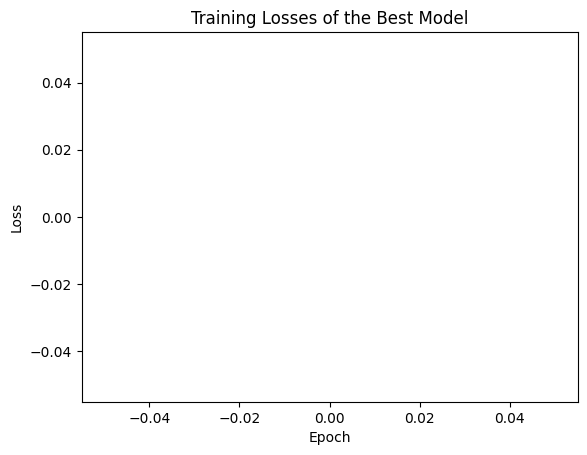

AttributeError: 'NoneType' object has no attribute 'eval'

In [15]:
print("Best Hyperparameters:")
print(best_hyperparams)

plt.plot(best_losses)
plt.title("Training Losses of the Best Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

test_acc, test_loss, true_labels, predicted_labels = testing(best_model, loss_function, test_loader)
print("Test Accuracy: {:.2f}%".format(test_acc))
print("Test Loss: {:.4f}".format(test_loss))

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()